**Inisialisasi Dependensi Yang di gunakan**

In [1]:
import os, csv, re, random, math, time
from pathlib import Path
from tqdm import tqdm
import torchvision.transforms as T
from ultralytics import YOLO
from PIL import Image
import pandas as pd
import cv2
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import ast

**Ekstrak 16 Frame dari tiap video**

In [3]:
def extract_frames_from_folder(input_dir, output_dir, num_frames=16):
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for video_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            video_path = os.path.join(class_path, video_name)
            video_id = os.path.splitext(video_name)[0]
            save_path = os.path.join(output_dir, class_name, video_id)
            os.makedirs(save_path, exist_ok=True)

            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            step = max(1, total_frames // num_frames)
            count = 0
            saved = 0

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                if count % step == 0 and saved < num_frames:
                    frame_file = os.path.join(save_path, f"frame_{saved:02d}.jpg")
                    cv2.imwrite(frame_file, frame)
                    saved += 1
                count += 1

            cap.release()


In [ ]:
# Jalankan ekstraksi untuk train dan val
extract_frames_from_folder("RWF-2000/train", "frames/train", num_frames=16)
extract_frames_from_folder("RWF-2000/val", "frames/val", num_frames=16)

In [ ]:
extract_frames_from_folder("Primer/train", "frames/train", num_frames=16)
extract_frames_from_folder("Primer/val", "frames/val", num_frames=16)


Processing Non-Fight: 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


**Masukkan path hasil ekstraksi ke csv**

In [5]:
def buat_csv(folder_frame, nama_csv):
    data = []
    for label in os.listdir(folder_frame):
        path_label = os.path.join(folder_frame, label)
        if not os.path.isdir(path_label):
            continue
        for nama_video in os.listdir(path_label):
            path_video = os.path.join(path_label, nama_video)
            if not os.path.isdir(path_video):
                continue
            data.append({
                "folder_frame": path_video,
                "label": label,
                "nama_video": nama_video
            })
    with open(nama_csv, "w", newline="", encoding="utf-8") as file_csv:
        writer = csv.DictWriter(file_csv, fieldnames=["folder_frame", "label", "nama_video"])
        writer.writeheader()
        for baris in data:
            writer.writerow(baris)

# Membuat CSV untuk data train dan val
buat_csv("frames/train", "data_train.csv")
buat_csv("frames/val", "data_val.csv")

**Load Yolo 11n**

In [6]:
model_yolo = YOLO('yolo11n.pt')

**Deteksi dengan Yolo**

In [9]:
def hitung_optical_flow(prev_img, curr_img):
    prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_RGB2GRAY)
    curr_gray = cv2.cvtColor(curr_img, cv2.COLOR_RGB2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    return np.mean(np.sqrt(flow[..., 0] ** 2 + flow[..., 1] ** 2))

def hitung_iou(boxA, boxB):
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0: return 0.0
    boxAArea = (boxA[2]-boxA[0])*(boxA[3]-boxA[1])
    boxBArea = (boxB[2]-boxB[0])*(boxB[3]-boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)

def hitung_overlap_count(boxes, threshold=0.2):
    return sum(1 for i in range(len(boxes)) for j in range(i+1, len(boxes)) if hitung_iou(boxes[i], boxes[j]) > threshold)

def deteksi_video_yolo(folder_frame):
    frames = sorted(os.listdir(folder_frame))
    jumlah_orang, avg_speed_list, overlap_list = [], [], []
    prev_frame = None

    for f in frames:
        img_path = os.path.join(folder_frame, f)
        img_pil = Image.open(img_path).convert("RGB")
        img_np = np.array(img_pil)

        hasil = model_yolo(img_pil)
        orang_boxes = [b.xyxy[0].cpu().numpy() for b in hasil[0].boxes if int(b.cls) == 0]

        # Hitung fitur
        avg_speed = hitung_optical_flow(prev_frame, img_np) if prev_frame is not None else 0.0
        overlap_count = hitung_overlap_count(orang_boxes)

        jumlah_orang.append(len(orang_boxes))
        avg_speed_list.append(avg_speed)
        overlap_list.append(overlap_count)
        prev_frame = img_np

    return jumlah_orang, avg_speed_list, overlap_list

def proses_dataset(csv_path, output_path):
    data_csv = pd.read_csv(csv_path)
    hasil = []

    for _, row in tqdm(data_csv.iterrows(), total=len(data_csv), desc=f"Proses {csv_path}"):
        folder_frame, label, nama_video = row["folder_frame"], row["label"], row["nama_video"]
        jml_orang, avg_speed, overlap = deteksi_video_yolo(folder_frame)

        hasil.append({
            "nama_video": nama_video,
            "label": label,
            "jumlah_orang_per_frame": json.dumps([int(x) for x in jml_orang]),
            "avg_speed": json.dumps([float(x) for x in avg_speed]),
            "overlap_count": json.dumps([int(x) for x in overlap])
        })

    # Simpan CSV
    with open(output_path, "w", encoding="utf-8", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["nama_video", "label", "jumlah_orang_per_frame", "avg_speed", "overlap_count"])
        writer.writeheader()
        writer.writerows(hasil)

**Run Fungsi yang telah di buat**

In [10]:
proses_dataset("data_train.csv", "hasil_deteksi_yolo_train.csv")

Proses data_train.csv:   0%|          | 0/1604 [00:00<?, ?it/s]


0: 384x640 1 person, 240.1ms
Speed: 12.1ms preprocess, 240.1ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 142.6ms
Speed: 6.0ms preprocess, 142.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 163.2ms
Speed: 1.7ms preprocess, 163.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 154.9ms
Speed: 1.9ms preprocess, 154.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 181.0ms
Speed: 1.8ms preprocess, 181.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 120.4ms
Speed: 1.5ms preprocess, 120.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 130.1ms
Speed: 1.8ms preprocess, 130.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 118.5ms
Speed: 1.5ms preprocess, 118.5ms inference, 1.5ms postprocess per

Proses data_train.csv:   0%|          | 1/1604 [00:04<1:52:11,  4.20s/it]


0: 384x640 2 persons, 145.6ms
Speed: 2.0ms preprocess, 145.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 135.1ms
Speed: 3.5ms preprocess, 135.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 121.4ms
Speed: 1.5ms preprocess, 121.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 136.2ms
Speed: 2.0ms preprocess, 136.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 159.9ms
Speed: 1.7ms preprocess, 159.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 136.5ms
Speed: 1.6ms preprocess, 136.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 122.3ms
Speed: 1.6ms preprocess, 122.3ms infer

Proses data_train.csv:   0%|          | 2/1604 [00:08<1:52:51,  4.23s/it]


0: 384x640 (no detections), 158.4ms
Speed: 1.8ms preprocess, 158.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 122.5ms
Speed: 1.5ms preprocess, 122.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 208.3ms
Speed: 2.5ms preprocess, 208.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 124.6ms
Speed: 2.0ms preprocess, 124.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 143.6ms
Speed: 3.1ms preprocess, 143.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 148.3ms
Speed: 1.9ms preprocess, 148.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 125.7ms
Speed: 3.6ms preprocess, 125.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 132.6ms
Speed: 1.7m

Proses data_train.csv:   0%|          | 3/1604 [00:12<1:52:41,  4.22s/it]


0: 384x640 11 persons, 1 suitcase, 1 tv, 132.3ms
Speed: 4.7ms preprocess, 132.3ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 suitcases, 1 tv, 125.8ms
Speed: 2.5ms preprocess, 125.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 suitcase, 1 tv, 149.3ms
Speed: 2.6ms preprocess, 149.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 suitcase, 1 skateboard, 1 tv, 153.4ms
Speed: 2.2ms preprocess, 153.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 1 suitcase, 1 tv, 156.5ms
Speed: 4.2ms preprocess, 156.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 1 suitcase, 1 tv, 120.4ms
Speed: 2.7ms preprocess, 120.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 tv, 132.5ms
Speed: 2.7ms preprocess, 132.5ms inference, 1.5ms postproces

Proses data_train.csv:   0%|          | 4/1604 [00:22<2:47:36,  6.29s/it]


0: 384x640 8 persons, 1 tv, 138.5ms
Speed: 3.1ms preprocess, 138.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 1 tv, 168.2ms
Speed: 2.4ms preprocess, 168.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 chair, 1 tv, 124.6ms
Speed: 2.5ms preprocess, 124.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 suitcase, 1 chair, 1 tv, 123.1ms
Speed: 2.2ms preprocess, 123.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 chair, 1 tv, 142.8ms
Speed: 1.9ms preprocess, 142.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 1 tv, 152.3ms
Speed: 2.0ms preprocess, 152.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 tv, 185.1ms
Speed: 3.0ms preprocess, 185.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384,

Proses data_train.csv:   0%|          | 5/1604 [00:31<3:18:01,  7.43s/it]


0: 384x640 11 persons, 1 suitcase, 1 tv, 169.9ms
Speed: 2.7ms preprocess, 169.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 suitcases, 1 tv, 129.7ms
Speed: 2.1ms preprocess, 129.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 suitcase, 1 tv, 130.4ms
Speed: 3.1ms preprocess, 130.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 tv, 111.9ms
Speed: 2.7ms preprocess, 111.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 149.7ms
Speed: 3.4ms preprocess, 149.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 tv, 136.7ms
Speed: 2.2ms preprocess, 136.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 tv, 124.6ms
Speed: 2.0ms preprocess, 124.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 

Proses data_train.csv:   0%|          | 6/1604 [00:41<3:37:30,  8.17s/it]


0: 384x640 9 persons, 1 tv, 151.0ms
Speed: 4.6ms preprocess, 151.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 motorcycle, 1 suitcase, 1 tv, 141.9ms
Speed: 3.4ms preprocess, 141.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 tv, 150.9ms
Speed: 2.4ms preprocess, 150.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 tv, 195.2ms
Speed: 2.5ms preprocess, 195.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 tv, 172.3ms
Speed: 2.5ms preprocess, 172.3ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 backpack, 1 tv, 151.7ms
Speed: 2.2ms preprocess, 151.7ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 tv, 195.1ms
Speed: 8.3ms preprocess, 195.1ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11

Proses data_train.csv:   0%|          | 7/1604 [00:50<3:49:47,  8.63s/it]


0: 384x640 8 persons, 1 backpack, 1 skateboard, 1 tv, 100.8ms
Speed: 2.3ms preprocess, 100.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 tv, 94.1ms
Speed: 2.0ms preprocess, 94.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 tv, 101.1ms
Speed: 2.2ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 103.1ms
Speed: 2.2ms preprocess, 103.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 116.2ms
Speed: 2.2ms preprocess, 116.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 104.4ms
Speed: 2.4ms preprocess, 104.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 tv, 100.5ms
Speed: 2.5ms preprocess, 100.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 10

Proses data_train.csv:   0%|          | 8/1604 [00:59<3:48:09,  8.58s/it]


0: 480x640 2 persons, 1 car, 1 motorcycle, 167.0ms
Speed: 3.8ms preprocess, 167.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 car, 2 motorcycles, 124.3ms
Speed: 3.5ms preprocess, 124.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 1 motorcycle, 119.1ms
Speed: 2.9ms preprocess, 119.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 motorcycles, 1 skateboard, 154.3ms
Speed: 3.1ms preprocess, 154.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 3 motorcycles, 152.4ms
Speed: 3.0ms preprocess, 152.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 3 motorcycles, 128.4ms
Speed: 2.7ms preprocess, 128.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 2 motorcycles, 123.2ms
Speed: 4.3ms preprocess, 123.2ms infe

Proses data_train.csv:   1%|          | 9/1604 [01:02<3:00:52,  6.80s/it]


0: 480x640 8 persons, 117.2ms
Speed: 4.7ms preprocess, 117.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 112.3ms
Speed: 4.0ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 123.5ms
Speed: 2.7ms preprocess, 123.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 117.3ms
Speed: 3.0ms preprocess, 117.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 110.5ms
Speed: 2.7ms preprocess, 110.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 113.4ms
Speed: 2.6ms preprocess, 113.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 motorcycle, 151.9ms
Speed: 2.7ms preprocess, 151.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 motorcycle, 2 skateboards, 136.4ms
Speed: 2.7ms preprocess

Proses data_train.csv:   1%|          | 10/1604 [01:05<2:29:05,  5.61s/it]


0: 480x640 3 persons, 1 motorcycle, 155.4ms
Speed: 3.4ms preprocess, 155.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 motorcycle, 142.3ms
Speed: 3.6ms preprocess, 142.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 135.8ms
Speed: 3.5ms preprocess, 135.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 152.7ms
Speed: 2.8ms preprocess, 152.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 motorcycle, 150.4ms
Speed: 3.4ms preprocess, 150.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 138.7ms
Speed: 2.9ms preprocess, 138.7ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 motorcycle, 138.2ms
Speed: 2.9ms preprocess, 138.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 skateboard, 149.5ms
Speed: 

Proses data_train.csv:   1%|          | 11/1604 [01:08<2:11:09,  4.94s/it]


0: 480x640 3 persons, 1 motorcycle, 1 horse, 148.4ms
Speed: 4.3ms preprocess, 148.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 162.9ms
Speed: 3.2ms preprocess, 162.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3 motorcycles, 152.6ms
Speed: 3.6ms preprocess, 152.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 motorcycles, 155.4ms
Speed: 3.4ms preprocess, 155.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 161.8ms
Speed: 3.5ms preprocess, 161.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 motorcycles, 144.6ms
Speed: 2.9ms preprocess, 144.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 motorcycle, 173.5ms
Speed: 2.9ms preprocess, 173.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 pe

Proses data_train.csv:   1%|          | 12/1604 [01:14<2:17:09,  5.17s/it]


0: 384x640 1 person, 1 suitcase, 316.5ms
Speed: 3.4ms preprocess, 316.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 254.2ms
Speed: 7.6ms preprocess, 254.2ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 361.7ms
Speed: 7.7ms preprocess, 361.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 247.5ms
Speed: 3.0ms preprocess, 247.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 233.9ms
Speed: 3.7ms preprocess, 233.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 248.6ms
Speed: 3.3ms preprocess, 248.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 162.4ms
Speed: 2.8ms preprocess, 162.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 oven, 147.6ms
Speed: 3.0ms preprocess, 14

Proses data_train.csv:   1%|          | 13/1604 [01:19<2:20:16,  5.29s/it]


0: 384x640 1 sink, 124.5ms
Speed: 3.1ms preprocess, 124.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 oven, 131.5ms
Speed: 3.4ms preprocess, 131.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 oven, 141.8ms
Speed: 3.3ms preprocess, 141.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 128.1ms
Speed: 3.0ms preprocess, 128.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 126.8ms
Speed: 3.0ms preprocess, 126.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cup, 135.2ms
Speed: 2.9ms preprocess, 135.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 oven, 144.7ms
Speed: 3.2ms preprocess, 144.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 oven, 159.8ms
Speed: 3.4ms preprocess, 159.8ms inference, 2.3ms pos

Proses data_train.csv:   1%|          | 14/1604 [01:24<2:15:52,  5.13s/it]


0: 384x640 5 persons, 1 handbag, 212.2ms
Speed: 3.4ms preprocess, 212.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 tennis racket, 157.1ms
Speed: 1.9ms preprocess, 157.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 169.1ms
Speed: 1.9ms preprocess, 169.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tennis racket, 175.1ms
Speed: 1.8ms preprocess, 175.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 132.1ms
Speed: 1.7ms preprocess, 132.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 156.5ms
Speed: 1.9ms preprocess, 156.5ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 chair, 164.4ms
Speed: 2.2ms preprocess, 164.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 

Proses data_train.csv:   1%|          | 15/1604 [01:28<2:10:27,  4.93s/it]


0: 384x640 3 persons, 3 cars, 1 bus, 1 truck, 199.7ms
Speed: 4.2ms preprocess, 199.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 285.3ms
Speed: 2.4ms preprocess, 285.3ms inference, 8.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 1 bus, 1 truck, 1 suitcase, 183.4ms
Speed: 2.3ms preprocess, 183.4ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 cars, 154.8ms
Speed: 4.6ms preprocess, 154.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 1 bus, 144.6ms
Speed: 2.1ms preprocess, 144.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 cars, 142.2ms
Speed: 2.9ms preprocess, 142.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 6 cars, 127.3ms
Speed: 2.9ms preprocess, 127.3ms inference, 1.6ms postprocess per image at shape (1, 3, 

Proses data_train.csv:   1%|          | 16/1604 [01:38<2:47:33,  6.33s/it]


0: 384x640 11 persons, 2 suitcases, 1 skateboard, 240.0ms
Speed: 2.2ms preprocess, 240.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 skateboards, 232.6ms
Speed: 2.9ms preprocess, 232.6ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 suitcase, 1 skateboard, 195.4ms
Speed: 2.7ms preprocess, 195.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 suitcases, 1 skateboard, 175.7ms
Speed: 3.4ms preprocess, 175.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 suitcase, 176.1ms
Speed: 2.7ms preprocess, 176.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 handbag, 1 suitcase, 141.0ms
Speed: 2.8ms preprocess, 141.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 suitcase, 200.9ms
Speed: 3.1ms preprocess, 200.9ms inference, 2.6

Proses data_train.csv:   1%|          | 17/1604 [01:48<3:16:37,  7.43s/it]


0: 384x640 13 persons, 1 suitcase, 1 skateboard, 168.8ms
Speed: 2.7ms preprocess, 168.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 suitcase, 1 skateboard, 163.2ms
Speed: 3.6ms preprocess, 163.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 suitcases, 167.7ms
Speed: 2.7ms preprocess, 167.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 skateboard, 127.1ms
Speed: 2.4ms preprocess, 127.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 suitcase, 1 skateboard, 1 chair, 129.2ms
Speed: 2.3ms preprocess, 129.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 suitcases, 1 skateboard, 126.1ms
Speed: 3.3ms preprocess, 126.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 suitcase, 1 skateboard, 1 chair, 127.5ms
Speed: 2.2ms pre

Proses data_train.csv:   1%|          | 18/1604 [01:58<3:33:40,  8.08s/it]


0: 384x640 6 persons, 3 suitcases, 3 skateboards, 174.8ms
Speed: 2.4ms preprocess, 174.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 suitcases, 1 skateboard, 151.5ms
Speed: 3.7ms preprocess, 151.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 suitcase, 1 skateboard, 202.0ms
Speed: 2.5ms preprocess, 202.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 suitcase, 1 skateboard, 149.9ms
Speed: 2.2ms preprocess, 149.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 skateboards, 215.6ms
Speed: 3.6ms preprocess, 215.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 suitcase, 1 skateboard, 1 chair, 207.4ms
Speed: 8.9ms preprocess, 207.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 skateboard, 191.6ms
Speed: 5.9ms prepro

Proses data_train.csv:   1%|          | 19/1604 [02:08<3:53:39,  8.85s/it]


0: 384x640 10 persons, 1 suitcase, 1 skateboard, 1 chair, 252.9ms
Speed: 3.2ms preprocess, 252.9ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 bird, 1 suitcase, 1 skateboard, 1 chair, 374.7ms
Speed: 5.2ms preprocess, 374.7ms inference, 11.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 suitcases, 1 skateboard, 300.9ms
Speed: 5.3ms preprocess, 300.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 suitcase, 1 skateboard, 1 chair, 200.4ms
Speed: 3.1ms preprocess, 200.4ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 suitcases, 1 skateboard, 383.4ms
Speed: 10.6ms preprocess, 383.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 suitcase, 1 skateboard, 1 chair, 207.2ms
Speed: 5.9ms preprocess, 207.2ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 pe

Proses data_train.csv:   1%|          | 20/1604 [02:20<4:18:13,  9.78s/it]


0: 384x640 7 persons, 1 chair, 163.7ms
Speed: 2.9ms preprocess, 163.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 170.7ms
Speed: 2.3ms preprocess, 170.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1068.4ms
Speed: 2.9ms preprocess, 1068.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 140.2ms
Speed: 3.4ms preprocess, 140.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 132.7ms
Speed: 2.2ms preprocess, 132.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 129.1ms
Speed: 2.4ms preprocess, 129.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 117.2ms
Speed: 2.2ms preprocess, 117.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 141.5ms
Speed: 2.3ms preprocess, 141.5ms inference, 2.2ms post

Proses data_train.csv:   1%|▏         | 21/1604 [02:31<4:23:18,  9.98s/it]


0: 384x640 1 person, 1 refrigerator, 163.1ms
Speed: 5.1ms preprocess, 163.1ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 couchs, 2 refrigerators, 139.1ms
Speed: 5.9ms preprocess, 139.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 1 couch, 2 refrigerators, 120.4ms
Speed: 2.7ms preprocess, 120.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 bottles, 1 couch, 1 refrigerator, 120.1ms
Speed: 2.3ms preprocess, 120.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 1 couch, 1 refrigerator, 116.3ms
Speed: 4.5ms preprocess, 116.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 couch, 2 refrigerators, 1 book, 119.7ms
Speed: 2.1ms preprocess, 119.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 handbag, 1 couch, 1 refrigerator, 129.6ms
Sp

Proses data_train.csv:   1%|▏         | 22/1604 [02:40<4:17:42,  9.77s/it]


0: 384x640 2 persons, 1 bottle, 1 couch, 151.0ms
Speed: 2.4ms preprocess, 151.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bottle, 1 couch, 1 refrigerator, 110.0ms
Speed: 2.3ms preprocess, 110.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 1 couch, 1 refrigerator, 114.1ms
Speed: 2.2ms preprocess, 114.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bottle, 1 couch, 1 refrigerator, 117.4ms
Speed: 2.1ms preprocess, 117.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 1 couch, 1 refrigerator, 117.3ms
Speed: 2.8ms preprocess, 117.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 1 couch, 122.2ms
Speed: 3.5ms preprocess, 122.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 1 couch, 1 refrigerator, 116.

Proses data_train.csv:   1%|▏         | 23/1604 [02:48<4:07:20,  9.39s/it]


0: 384x640 1 person, 2 couchs, 1 refrigerator, 119.7ms
Speed: 2.7ms preprocess, 119.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 couch, 1 refrigerator, 110.1ms
Speed: 2.2ms preprocess, 110.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 2 couchs, 1 refrigerator, 92.9ms
Speed: 2.2ms preprocess, 92.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 2 couchs, 105.2ms
Speed: 2.5ms preprocess, 105.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 1 couch, 104.2ms
Speed: 3.0ms preprocess, 104.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 1 couch, 2 refrigerators, 106.0ms
Speed: 2.2ms preprocess, 106.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 2 couchs, 2 refrigerators, 112.4ms
Speed: 2.4ms preprocess, 112.4ms inference, 1.5ms postprocess per imag

Proses data_train.csv:   1%|▏         | 24/1604 [02:57<3:57:27,  9.02s/it]


0: 384x640 1 person, 1 couch, 1 refrigerator, 104.8ms
Speed: 2.6ms preprocess, 104.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 couch, 1 refrigerator, 94.2ms
Speed: 2.0ms preprocess, 94.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 couch, 1 bed, 2 refrigerators, 130.7ms
Speed: 2.3ms preprocess, 130.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 2 couchs, 2 refrigerators, 131.4ms
Speed: 2.3ms preprocess, 131.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 couchs, 3 refrigerators, 112.2ms
Speed: 2.1ms preprocess, 112.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 couchs, 3 refrigerators, 98.3ms
Speed: 2.4ms preprocess, 98.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 2 couchs, 2 refrigerators, 109.0ms
Speed: 2.5ms preprocess, 109.0ms inference, 1

Proses data_train.csv:   2%|▏         | 25/1604 [03:05<3:50:37,  8.76s/it]


0: 480x640 7 persons, 3 skateboards, 136.0ms
Speed: 3.4ms preprocess, 136.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 skateboards, 122.8ms
Speed: 2.8ms preprocess, 122.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 skateboard, 125.0ms
Speed: 3.2ms preprocess, 125.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 121.6ms
Speed: 2.9ms preprocess, 121.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 126.1ms
Speed: 3.0ms preprocess, 126.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 119.7ms
Speed: 2.8ms preprocess, 119.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 139.1ms
Speed: 2.6ms preprocess, 139.1ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 125.5ms
Speed: 2.8ms preproces

Proses data_train.csv:   2%|▏         | 26/1604 [03:08<3:04:49,  7.03s/it]


0: 480x640 5 persons, 126.7ms
Speed: 2.8ms preprocess, 126.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 120.4ms
Speed: 2.8ms preprocess, 120.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 124.9ms
Speed: 2.8ms preprocess, 124.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 127.2ms
Speed: 2.9ms preprocess, 127.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 baseball glove, 139.9ms
Speed: 2.7ms preprocess, 139.9ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 146.4ms
Speed: 3.1ms preprocess, 146.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 120.6ms
Speed: 4.0ms preprocess, 120.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 134.9ms
Speed: 2.8ms preprocess, 134.9ms inference

Proses data_train.csv:   2%|▏         | 27/1604 [03:11<2:35:31,  5.92s/it]


0: 384x640 1 person, 2 suitcases, 140.6ms
Speed: 2.3ms preprocess, 140.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 164.0ms
Speed: 2.7ms preprocess, 164.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 156.4ms
Speed: 2.2ms preprocess, 156.4ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 123.1ms
Speed: 2.5ms preprocess, 123.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 121.5ms
Speed: 2.7ms preprocess, 121.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 125.0ms
Speed: 3.0ms preprocess, 125.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.6ms
Speed: 2.1ms preprocess, 111.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.3ms
Speed: 2.2ms preprocess, 111.3m

Proses data_train.csv:   2%|▏         | 28/1604 [03:20<2:56:56,  6.74s/it]


0: 384x640 1 person, 106.0ms
Speed: 2.3ms preprocess, 106.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 95.8ms
Speed: 1.9ms preprocess, 95.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 113.0ms
Speed: 2.2ms preprocess, 113.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 121.7ms
Speed: 4.4ms preprocess, 121.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 93.0ms
Speed: 2.5ms preprocess, 93.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 102.6ms
Speed: 2.2ms preprocess, 102.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 92.6ms
Speed: 2.4ms preprocess, 92.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 113.3ms
Speed: 2.6ms preprocess, 113.3ms inf

Proses data_train.csv:   2%|▏         | 29/1604 [03:28<3:10:16,  7.25s/it]


0: 384x640 1 chair, 131.5ms
Speed: 2.4ms preprocess, 131.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 chairs, 134.2ms
Speed: 4.1ms preprocess, 134.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 160.5ms
Speed: 2.2ms preprocess, 160.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 137.4ms
Speed: 2.7ms preprocess, 137.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 133.3ms
Speed: 2.4ms preprocess, 133.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 115.5ms
Speed: 2.1ms preprocess, 115.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 135.1ms
Speed: 5.8ms preprocess, 135.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 102.5ms
Speed: 2.2ms preprocess, 102.5

Proses data_train.csv:   2%|▏         | 30/1604 [03:37<3:20:51,  7.66s/it]


0: 384x640 1 person, 134.2ms
Speed: 5.3ms preprocess, 134.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 120.5ms
Speed: 2.4ms preprocess, 120.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 155.1ms
Speed: 2.8ms preprocess, 155.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 119.6ms
Speed: 2.4ms preprocess, 119.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 122.9ms
Speed: 2.7ms preprocess, 122.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 135.9ms
Speed: 2.5ms preprocess, 135.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 136.0ms
Speed: 2.2ms preprocess, 136.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 208.9ms
Speed: 2.2ms preprocess, 208.9ms inference, 2.9ms postprocess per im

Proses data_train.csv:   2%|▏         | 31/1604 [03:46<3:29:57,  8.01s/it]


0: 384x640 3 persons, 131.7ms
Speed: 3.4ms preprocess, 131.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 123.1ms
Speed: 2.0ms preprocess, 123.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 123.7ms
Speed: 2.2ms preprocess, 123.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 121.7ms
Speed: 3.4ms preprocess, 121.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 123.1ms
Speed: 2.4ms preprocess, 123.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 123.9ms
Speed: 2.2ms preprocess, 123.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 129.5ms
Speed: 2.4ms preprocess, 129.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 114.9ms
Speed: 3.0ms preprocess, 114.9ms inference, 1.5ms postprocess per image 

Proses data_train.csv:   2%|▏         | 32/1604 [03:54<3:32:15,  8.10s/it]


0: 480x640 1 bottle, 136.1ms
Speed: 6.1ms preprocess, 136.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bottle, 118.6ms
Speed: 3.2ms preprocess, 118.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bottle, 116.8ms
Speed: 2.6ms preprocess, 116.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cakes, 122.6ms
Speed: 2.6ms preprocess, 122.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.4ms
Speed: 3.5ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bottle, 143.4ms
Speed: 2.9ms preprocess, 143.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bottle, 212.1ms
Speed: 2.6ms preprocess, 212.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 bottles, 205.7ms
Speed: 3.7m

Proses data_train.csv:   2%|▏         | 33/1604 [03:57<2:52:05,  6.57s/it]


0: 384x640 6 persons, 115.7ms
Speed: 6.3ms preprocess, 115.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 100.8ms
Speed: 1.5ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 99.9ms
Speed: 1.4ms preprocess, 99.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 99.2ms
Speed: 1.5ms preprocess, 99.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 dog, 101.5ms
Speed: 1.8ms preprocess, 101.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 98.5ms
Speed: 1.5ms preprocess, 98.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 100.8ms
Speed: 1.3ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 dogs, 107.7ms
Speed: 1.6ms preprocess, 107.7ms inference, 1.5ms postpro

Proses data_train.csv:   2%|▏         | 34/1604 [04:00<2:28:07,  5.66s/it]


0: 480x640 6 persons, 135.3ms
Speed: 6.2ms preprocess, 135.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 114.1ms
Speed: 3.5ms preprocess, 114.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 119.2ms
Speed: 3.6ms preprocess, 119.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 116.4ms
Speed: 2.5ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 suitcase, 126.4ms
Speed: 3.0ms preprocess, 126.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 125.1ms
Speed: 4.7ms preprocess, 125.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 121.0ms
Speed: 2.7ms preprocess, 121.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 backpack, 129.9ms
Speed: 6.3ms preprocess, 129.9ms inference

Proses data_train.csv:   2%|▏         | 35/1604 [04:03<2:05:47,  4.81s/it]


0: 480x640 7 persons, 205.9ms
Speed: 3.3ms preprocess, 205.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 130.0ms
Speed: 2.8ms preprocess, 130.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 128.5ms
Speed: 3.9ms preprocess, 128.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 131.3ms
Speed: 2.8ms preprocess, 131.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 129.4ms
Speed: 2.7ms preprocess, 129.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 141.7ms
Speed: 3.9ms preprocess, 141.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 144.2ms
Speed: 3.3ms preprocess, 144.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 137.8ms
Speed: 3.1ms preprocess, 137.8ms inference, 1.8ms postprocess per 

Proses data_train.csv:   2%|▏         | 36/1604 [04:06<1:52:33,  4.31s/it]


0: 384x640 5 persons, 124.4ms
Speed: 2.7ms preprocess, 124.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 tv, 114.2ms
Speed: 2.1ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 114.1ms
Speed: 2.2ms preprocess, 114.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 117.1ms
Speed: 2.3ms preprocess, 117.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 114.9ms
Speed: 2.1ms preprocess, 114.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 120.3ms
Speed: 2.8ms preprocess, 120.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 120.1ms
Speed: 4.7ms preprocess, 120.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 119.4ms
Speed: 2.7ms preprocess, 119.4ms inference, 1.6ms post

Proses data_train.csv:   2%|▏         | 37/1604 [04:15<2:25:30,  5.57s/it]


0: 448x640 1 backpack, 1 suitcase, 1 dining table, 193.5ms
Speed: 3.3ms preprocess, 193.5ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 backpack, 1 suitcase, 1 dining table, 136.6ms
Speed: 3.3ms preprocess, 136.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 chair, 1 dining table, 134.4ms
Speed: 2.9ms preprocess, 134.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 chair, 1 dining table, 204.2ms
Speed: 2.9ms preprocess, 204.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 suitcase, 1 dining table, 127.8ms
Speed: 2.8ms preprocess, 127.8ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 dining table, 123.6ms
Speed: 2.9ms preprocess, 123.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 suitcase, 1 dining table, 128.8ms
Speed: 2.9ms prepro

Proses data_train.csv:   2%|▏         | 38/1604 [04:19<2:12:54,  5.09s/it]


0: 448x640 4 persons, 1 chair, 148.6ms
Speed: 3.3ms preprocess, 148.6ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 chair, 107.9ms
Speed: 3.1ms preprocess, 107.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 107.9ms
Speed: 3.1ms preprocess, 107.9ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 107.6ms
Speed: 3.2ms preprocess, 107.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 skateboard, 110.2ms
Speed: 2.7ms preprocess, 110.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 109.5ms
Speed: 2.7ms preprocess, 109.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 109.3ms
Speed: 3.1ms preprocess, 109.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 108.8ms
Speed: 3.1ms preprocess, 108.8ms i

Proses data_train.csv:   2%|▏         | 39/1604 [04:22<1:59:45,  4.59s/it]


0: 448x640 3 persons, 1 backpack, 1 handbag, 139.2ms
Speed: 3.5ms preprocess, 139.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 backpack, 1 handbag, 118.1ms
Speed: 3.4ms preprocess, 118.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 118.4ms
Speed: 3.5ms preprocess, 118.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 109.7ms
Speed: 2.7ms preprocess, 109.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 1 backpack, 109.3ms
Speed: 2.6ms preprocess, 109.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 suitcase, 108.3ms
Speed: 3.1ms preprocess, 108.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 backpack, 1 suitcase, 112.3ms
Speed: 3.0ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0:

Proses data_train.csv:   2%|▏         | 40/1604 [04:26<1:52:13,  4.31s/it]


0: 448x640 2 persons, 1 dog, 128.0ms
Speed: 3.5ms preprocess, 128.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 dog, 110.6ms
Speed: 2.7ms preprocess, 110.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 skateboard, 111.2ms
Speed: 2.7ms preprocess, 111.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 skateboard, 110.9ms
Speed: 4.3ms preprocess, 110.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 107.6ms
Speed: 2.7ms preprocess, 107.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 backpack, 1 suitcase, 106.1ms
Speed: 3.3ms preprocess, 106.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 backpack, 1 suitcase, 109.2ms
Speed: 2.7ms preprocess, 109.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448

Proses data_train.csv:   3%|▎         | 41/1604 [04:29<1:45:06,  4.03s/it]


0: 448x640 1 person, 1 dog, 1 suitcase, 133.9ms
Speed: 4.1ms preprocess, 133.9ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 suitcase, 109.1ms
Speed: 2.9ms preprocess, 109.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 suitcases, 111.6ms
Speed: 3.4ms preprocess, 111.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 suitcases, 107.2ms
Speed: 2.6ms preprocess, 107.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 backpack, 110.8ms
Speed: 2.7ms preprocess, 110.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 116.4ms
Speed: 2.7ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 suitcase, 109.1ms
Speed: 2.6ms preprocess, 109.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 per

Proses data_train.csv:   3%|▎         | 42/1604 [04:33<1:40:26,  3.86s/it]


0: 448x640 2 persons, 1 dining table, 201.0ms
Speed: 4.1ms preprocess, 201.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 chair, 1 dining table, 110.6ms
Speed: 2.6ms preprocess, 110.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 dining table, 118.2ms
Speed: 3.3ms preprocess, 118.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 dining table, 108.1ms
Speed: 2.7ms preprocess, 108.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 chair, 1 dining table, 111.3ms
Speed: 2.6ms preprocess, 111.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 dining table, 108.2ms
Speed: 2.7ms preprocess, 108.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 dining table, 134.6ms
Speed: 3.2ms preprocess, 134.6ms inference, 1.8ms postprocess per

Proses data_train.csv:   3%|▎         | 43/1604 [04:37<1:39:35,  3.83s/it]


0: 448x640 4 persons, 138.6ms
Speed: 9.8ms preprocess, 138.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 chair, 1 dining table, 121.7ms
Speed: 3.4ms preprocess, 121.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 124.7ms
Speed: 3.5ms preprocess, 124.7ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 123.7ms
Speed: 2.8ms preprocess, 123.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 suitcase, 2 chairs, 122.1ms
Speed: 3.0ms preprocess, 122.1ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 boat, 123.5ms
Speed: 2.9ms preprocess, 123.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 boat, 128.1ms
Speed: 3.0ms preprocess, 128.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 suitcase, 123.1ms
Speed: 2.9ms preprocess,

Proses data_train.csv:   3%|▎         | 44/1604 [04:40<1:38:27,  3.79s/it]


0: 448x640 1 person, 1 bench, 1 handbag, 1 dining table, 140.5ms
Speed: 3.7ms preprocess, 140.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 benchs, 1 handbag, 1 dining table, 127.1ms
Speed: 3.2ms preprocess, 127.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 benchs, 1 dining table, 122.5ms
Speed: 3.8ms preprocess, 122.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 benchs, 1 dining table, 125.5ms
Speed: 3.9ms preprocess, 125.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 chair, 1 dining table, 122.4ms
Speed: 3.9ms preprocess, 122.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 1 dining table, 122.7ms
Speed: 3.4ms preprocess, 122.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 1 dining table, 146.6ms
Speed: 4.2ms preproces

Proses data_train.csv:   3%|▎         | 45/1604 [04:44<1:38:52,  3.81s/it]


0: 640x640 (no detections), 279.5ms
Speed: 7.4ms preprocess, 279.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 171.7ms
Speed: 7.1ms preprocess, 171.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 175.1ms
Speed: 6.9ms preprocess, 175.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 165.7ms
Speed: 6.3ms preprocess, 165.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 182.8ms
Speed: 5.8ms preprocess, 182.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 tv, 171.4ms
Speed: 6.0ms preprocess, 171.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 161.4ms
Speed: 5.8ms preprocess, 161.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 tv, 159.7ms
Speed: 5.6ms preprocess, 159.7ms inference, 1.9ms pos

Proses data_train.csv:   3%|▎         | 46/1604 [04:51<2:01:16,  4.67s/it]


0: 448x640 4 cars, 1 motorcycle, 141.7ms
Speed: 5.3ms preprocess, 141.7ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 motorcycle, 111.2ms
Speed: 3.3ms preprocess, 111.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 cars, 1 motorcycle, 121.4ms
Speed: 4.2ms preprocess, 121.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 motorcycles, 121.1ms
Speed: 3.0ms preprocess, 121.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 motorcycles, 110.2ms
Speed: 2.7ms preprocess, 110.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 1 motorcycle, 182.0ms
Speed: 3.0ms preprocess, 182.0ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 cars, 1 motorcycle, 137.7ms
Speed: 2.7ms preprocess, 137.7ms inference, 2.0ms postprocess per image at shap

Proses data_train.csv:   3%|▎         | 47/1604 [04:55<1:54:41,  4.42s/it]


0: 448x640 1 person, 1 motorcycle, 212.0ms
Speed: 4.3ms preprocess, 212.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 car, 1 motorcycle, 1 truck, 122.5ms
Speed: 3.0ms preprocess, 122.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 motorcycle, 1 truck, 141.5ms
Speed: 2.6ms preprocess, 141.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 1 motorcycle, 131.1ms
Speed: 3.0ms preprocess, 131.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 car, 2 motorcycles, 119.5ms
Speed: 2.9ms preprocess, 119.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 car, 1 motorcycle, 110.8ms
Speed: 3.3ms preprocess, 110.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 car, 141.5ms
Speed: 2.9ms preprocess, 141.5ms inference, 1.9ms postprocess per imag

Proses data_train.csv:   3%|▎         | 48/1604 [04:58<1:49:06,  4.21s/it]


0: 384x640 3 persons, 1 dog, 125.1ms
Speed: 3.6ms preprocess, 125.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 118.8ms
Speed: 2.3ms preprocess, 118.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 104.6ms
Speed: 2.6ms preprocess, 104.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 110.0ms
Speed: 2.6ms preprocess, 110.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 113.2ms
Speed: 2.1ms preprocess, 113.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.9ms
Speed: 2.5ms preprocess, 102.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 120.5ms
Speed: 2.6ms preprocess, 120.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 98.0ms
Speed: 2.7ms preprocess, 98.0ms inference, 2.0ms postprocess 

Proses data_train.csv:   3%|▎         | 49/1604 [05:01<1:38:56,  3.82s/it]


0: 384x640 (no detections), 191.5ms
Speed: 7.6ms preprocess, 191.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.1ms
Speed: 4.0ms preprocess, 99.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.8ms
Speed: 3.3ms preprocess, 99.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.7ms
Speed: 2.4ms preprocess, 99.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.7ms
Speed: 2.1ms preprocess, 99.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.1ms
Speed: 1.9ms preprocess, 105.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.8ms
Speed: 2.0ms preprocess, 101.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.9ms
Speed: 2.3ms preprocess, 99.9ms in

Proses data_train.csv:   3%|▎         | 50/1604 [05:04<1:29:52,  3.47s/it]


0: 384x640 (no detections), 110.1ms
Speed: 2.2ms preprocess, 110.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 130.3ms
Speed: 2.2ms preprocess, 130.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 127.4ms
Speed: 3.4ms preprocess, 127.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 118.8ms
Speed: 2.4ms preprocess, 118.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cake, 125.6ms
Speed: 2.2ms preprocess, 125.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 122.4ms
Speed: 2.7ms preprocess, 122.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 121.8ms
Speed: 2.8ms preprocess, 121.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 129.7ms
Speed: 2.8ms preprocess, 129.7ms inference, 1.6ms p

Proses data_train.csv:   3%|▎         | 51/1604 [05:07<1:25:55,  3.32s/it]


0: 384x640 4 suitcases, 140.0ms
Speed: 2.6ms preprocess, 140.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 backpack, 1 suitcase, 124.0ms
Speed: 2.5ms preprocess, 124.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 123.4ms
Speed: 2.7ms preprocess, 123.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 131.3ms
Speed: 2.4ms preprocess, 131.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 125.8ms
Speed: 3.8ms preprocess, 125.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 126.8ms
Speed: 2.2ms preprocess, 126.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 118.7ms
Speed: 2.6ms preprocess, 118.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 128.6ms
Speed: 2.2ms preproc

Proses data_train.csv:   3%|▎         | 52/1604 [05:10<1:24:39,  3.27s/it]


0: 384x640 (no detections), 196.0ms
Speed: 10.8ms preprocess, 196.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 115.1ms
Speed: 2.7ms preprocess, 115.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 114.9ms
Speed: 2.5ms preprocess, 114.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 113.8ms
Speed: 3.3ms preprocess, 113.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 113.6ms
Speed: 3.4ms preprocess, 113.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bench, 114.5ms
Speed: 2.4ms preprocess, 114.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 115.7ms
Speed: 2.5ms preprocess, 115.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 112.7ms
Speed: 2.4ms preprocess, 112.7ms inference, 1.7ms postproce

Proses data_train.csv:   3%|▎         | 53/1604 [05:13<1:22:08,  3.18s/it]


0: 384x640 (no detections), 134.0ms
Speed: 2.8ms preprocess, 134.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 115.6ms
Speed: 2.7ms preprocess, 115.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bed, 117.3ms
Speed: 2.8ms preprocess, 117.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 119.9ms
Speed: 2.4ms preprocess, 119.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 114.8ms
Speed: 2.3ms preprocess, 114.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 113.5ms
Speed: 2.4ms preprocess, 113.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 111.2ms
Speed: 2.4ms preprocess, 111.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 110.8ms
Speed: 3.0ms preprocess, 110.8ms inference, 2.3ms postprocess per imag

Proses data_train.csv:   3%|▎         | 54/1604 [05:16<1:20:04,  3.10s/it]


0: 384x640 1 bench, 1 dog, 1 bed, 138.4ms
Speed: 2.8ms preprocess, 138.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 114.2ms
Speed: 2.4ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 110.8ms
Speed: 2.3ms preprocess, 110.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 1 bed, 114.6ms
Speed: 2.3ms preprocess, 114.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bed, 114.6ms
Speed: 2.3ms preprocess, 114.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 123.6ms
Speed: 2.8ms preprocess, 123.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 117.8ms
Speed: 3.1ms preprocess, 117.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 119.4ms
Speed: 2.3ms preprocess, 119.4ms inference, 

Proses data_train.csv:   3%|▎         | 55/1604 [05:19<1:19:56,  3.10s/it]


0: 384x640 1 suitcase, 1 bed, 133.5ms
Speed: 3.0ms preprocess, 133.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 1 bed, 99.4ms
Speed: 2.2ms preprocess, 99.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 97.1ms
Speed: 2.1ms preprocess, 97.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 107.6ms
Speed: 2.2ms preprocess, 107.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.0ms
Speed: 2.2ms preprocess, 101.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bed, 102.1ms
Speed: 2.7ms preprocess, 102.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 99.7ms
Speed: 2.6ms preprocess, 99.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 backpack, 1 bed, 97.1ms
Speed: 2.7ms preprocess, 97.1ms inference, 2.2ms postp

Proses data_train.csv:   3%|▎         | 56/1604 [05:22<1:16:33,  2.97s/it]


0: 384x640 5 persons, 118.5ms
Speed: 2.4ms preprocess, 118.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 suitcases, 100.9ms
Speed: 2.7ms preprocess, 100.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.2ms
Speed: 2.5ms preprocess, 111.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 99.7ms
Speed: 2.5ms preprocess, 99.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 103.4ms
Speed: 2.5ms preprocess, 103.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.3ms
Speed: 2.2ms preprocess, 103.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 106.9ms
Speed: 2.2ms preprocess, 106.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 105.7ms
Speed: 2.7ms preprocess, 105.7ms 

Proses data_train.csv:   4%|▎         | 57/1604 [05:30<1:57:59,  4.58s/it]


0: 384x640 3 persons, 110.1ms
Speed: 5.3ms preprocess, 110.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bus, 113.1ms
Speed: 1.9ms preprocess, 113.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 104.6ms
Speed: 2.3ms preprocess, 104.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.7ms
Speed: 2.2ms preprocess, 98.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 109.2ms
Speed: 3.8ms preprocess, 109.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 100.6ms
Speed: 3.9ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 100.8ms
Speed: 2.6ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 104.7ms
Speed: 2.2ms preprocess, 104.7ms inference, 0.9ms 

Proses data_train.csv:   4%|▎         | 58/1604 [05:39<2:28:59,  5.78s/it]


0: 384x640 2 persons, 1 car, 1 bus, 2 suitcases, 211.4ms
Speed: 3.2ms preprocess, 211.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 158.3ms
Speed: 3.0ms preprocess, 158.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 truck, 180.6ms
Speed: 2.4ms preprocess, 180.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 124.3ms
Speed: 3.0ms preprocess, 124.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 3 dogs, 122.6ms
Speed: 3.7ms preprocess, 122.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 132.6ms
Speed: 2.2ms preprocess, 132.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 2 dogs, 122.8ms
Speed: 2.6ms preprocess, 122.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 

Proses data_train.csv:   4%|▎         | 59/1604 [05:48<2:53:13,  6.73s/it]


0: 384x640 1 bus, 1 dog, 129.4ms
Speed: 2.4ms preprocess, 129.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 135.4ms
Speed: 2.5ms preprocess, 135.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 120.7ms
Speed: 2.3ms preprocess, 120.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 117.0ms
Speed: 2.2ms preprocess, 117.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bus, 113.0ms
Speed: 2.5ms preprocess, 113.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bus, 138.5ms
Speed: 2.6ms preprocess, 138.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 155.4ms
Speed: 2.2ms preprocess, 155.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bus, 114.0ms
Speed: 2.7ms preprocess, 114.0ms inference, 1.8ms pos

Proses data_train.csv:   4%|▎         | 60/1604 [05:56<3:08:55,  7.34s/it]


0: 384x640 2 persons, 132.0ms
Speed: 5.5ms preprocess, 132.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 117.4ms
Speed: 2.4ms preprocess, 117.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bus, 114.6ms
Speed: 2.2ms preprocess, 114.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 112.7ms
Speed: 2.8ms preprocess, 112.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 126.3ms
Speed: 2.2ms preprocess, 126.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 2 buss, 1 dog, 134.5ms
Speed: 2.7ms preprocess, 134.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 135.5ms
Speed: 2.4ms preprocess, 135.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 166.4ms
Speed: 2.9ms preprocess, 

Proses data_train.csv:   4%|▍         | 61/1604 [06:05<3:20:37,  7.80s/it]


0: 384x640 1 person, 122.5ms
Speed: 3.3ms preprocess, 122.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.2ms
Speed: 2.0ms preprocess, 102.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 107.5ms
Speed: 2.2ms preprocess, 107.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 105.4ms
Speed: 2.2ms preprocess, 105.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.6ms
Speed: 2.8ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 106.3ms
Speed: 2.4ms preprocess, 106.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 234.2ms
Speed: 2.0ms preprocess, 234.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.9ms
Speed: 2.8ms preprocess, 102.9ms inference, 1.4ms postprocess per ima

Proses data_train.csv:   4%|▍         | 62/1604 [06:13<3:24:11,  7.94s/it]


0: 384x640 2 persons, 110.5ms
Speed: 2.9ms preprocess, 110.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.8ms
Speed: 2.4ms preprocess, 99.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 109.5ms
Speed: 2.2ms preprocess, 109.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.8ms
Speed: 2.6ms preprocess, 103.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.3ms
Speed: 3.6ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.8ms
Speed: 2.2ms preprocess, 107.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 108.1ms
Speed: 2.9ms preprocess, 108.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 109.7ms
Speed: 2.1ms preprocess, 109.7ms inference, 1.5ms postprocess per image a

Proses data_train.csv:   4%|▍         | 63/1604 [06:22<3:24:59,  7.98s/it]


0: 384x640 2 persons, 10 cars, 105.6ms
Speed: 5.3ms preprocess, 105.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11 cars, 1 dog, 98.7ms
Speed: 3.4ms preprocess, 98.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 10 cars, 107.3ms
Speed: 3.0ms preprocess, 107.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 8 cars, 109.5ms
Speed: 3.8ms preprocess, 109.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 9 cars, 101.2ms
Speed: 4.0ms preprocess, 101.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 9 cars, 103.8ms
Speed: 3.2ms preprocess, 103.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 111.3ms
Speed: 3.8ms preprocess, 111.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 11

Proses data_train.csv:   4%|▍         | 64/1604 [06:37<4:24:24, 10.30s/it]


0: 640x384 3 persons, 1 bus, 169.6ms
Speed: 18.8ms preprocess, 169.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 bus, 99.6ms
Speed: 3.4ms preprocess, 99.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 car, 1 handbag, 1 tie, 98.2ms
Speed: 2.3ms preprocess, 98.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 bus, 106.0ms
Speed: 2.6ms preprocess, 106.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 bus, 99.9ms
Speed: 2.5ms preprocess, 99.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 bus, 99.9ms
Speed: 2.1ms preprocess, 99.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 1 handbag, 1 tie, 101.0ms
Speed: 2.5ms preprocess, 101.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 99.

Proses data_train.csv:   4%|▍         | 65/1604 [06:41<3:37:01,  8.46s/it]


0: 640x384 2 persons, 116.0ms
Speed: 8.6ms preprocess, 116.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 dog, 100.2ms
Speed: 2.8ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 car, 103.6ms
Speed: 2.6ms preprocess, 103.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 1 bus, 2 tvs, 99.6ms
Speed: 2.5ms preprocess, 99.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 bus, 1 tv, 105.3ms
Speed: 2.5ms preprocess, 105.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 1 car, 1 bus, 101.3ms
Speed: 2.5ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 1 car, 1 bus, 167.9ms
Speed: 2.9ms preprocess, 167.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 car, 104.9ms
Speed

Proses data_train.csv:   4%|▍         | 66/1604 [06:46<3:03:27,  7.16s/it]


0: 384x640 7 persons, 1 chair, 118.9ms
Speed: 3.2ms preprocess, 118.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 chairs, 99.1ms
Speed: 2.0ms preprocess, 99.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 98.1ms
Speed: 2.9ms preprocess, 98.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 104.9ms
Speed: 2.2ms preprocess, 104.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 99.8ms
Speed: 2.2ms preprocess, 99.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 1 dining table, 103.7ms
Speed: 2.1ms preprocess, 103.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bowl, 1 dining table, 102.9ms
Speed: 2.2ms preprocess, 102.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 104

Proses data_train.csv:   4%|▍         | 67/1604 [06:54<3:11:18,  7.47s/it]


0: 384x640 5 persons, 1 chair, 115.0ms
Speed: 7.7ms preprocess, 115.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 cup, 1 chair, 1 dining table, 99.7ms
Speed: 2.5ms preprocess, 99.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 dining table, 106.1ms
Speed: 2.2ms preprocess, 106.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 106.6ms
Speed: 2.1ms preprocess, 106.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 1 dining table, 101.7ms
Speed: 2.5ms preprocess, 101.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 chairs, 1 dining table, 103.0ms
Speed: 2.2ms preprocess, 103.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 172.1ms
Speed: 3.5ms preprocess, 172.1ms inference, 1.4ms postproces

Proses data_train.csv:   4%|▍         | 68/1604 [07:02<3:17:34,  7.72s/it]


0: 384x640 4 chairs, 1 dining table, 108.8ms
Speed: 2.3ms preprocess, 108.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 chairs, 1 dining table, 100.9ms
Speed: 4.6ms preprocess, 100.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 6 chairs, 1 dining table, 103.1ms
Speed: 2.9ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 6 chairs, 2 dining tables, 112.0ms
Speed: 2.4ms preprocess, 112.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 6 chairs, 1 dining table, 100.8ms
Speed: 2.9ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 chairs, 1 dining table, 97.7ms
Speed: 2.5ms preprocess, 97.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 6 chairs, 2 dining tables, 108.8ms
Speed: 2.9ms preprocess,

Proses data_train.csv:   4%|▍         | 69/1604 [07:10<3:21:35,  7.88s/it]


0: 384x640 5 persons, 3 chairs, 3 dining tables, 108.8ms
Speed: 2.1ms preprocess, 108.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 chairs, 2 dining tables, 98.8ms
Speed: 2.1ms preprocess, 98.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 chairs, 2 dining tables, 105.9ms
Speed: 2.1ms preprocess, 105.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 chairs, 3 dining tables, 101.6ms
Speed: 2.9ms preprocess, 101.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 chairs, 2 dining tables, 101.3ms
Speed: 5.7ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 chairs, 2 dining tables, 99.3ms
Speed: 2.1ms preprocess, 99.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 umbrella, 4 chairs, 2 dining tables, 1 vase, 105.7ms
Sp

Proses data_train.csv:   4%|▍         | 70/1604 [07:18<3:23:52,  7.97s/it]


0: 384x640 4 persons, 4 chairs, 1 dining table, 113.5ms
Speed: 6.7ms preprocess, 113.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 chairs, 1 dining table, 97.1ms
Speed: 2.5ms preprocess, 97.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 chairs, 1 dining table, 104.1ms
Speed: 3.1ms preprocess, 104.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 chairs, 1 dining table, 103.8ms
Speed: 4.4ms preprocess, 103.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 chairs, 1 dining table, 107.7ms
Speed: 3.5ms preprocess, 107.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 chairs, 1 dining table, 100.7ms
Speed: 2.4ms preprocess, 100.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 chairs, 1 dining table, 107.1ms
Speed: 3.2ms pr

Proses data_train.csv:   4%|▍         | 71/1604 [07:27<3:25:31,  8.04s/it]


0: 384x640 3 persons, 5 chairs, 2 dining tables, 111.5ms
Speed: 2.1ms preprocess, 111.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 chairs, 2 dining tables, 169.8ms
Speed: 2.6ms preprocess, 169.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 chairs, 1 dining table, 102.3ms
Speed: 2.2ms preprocess, 102.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cup, 4 chairs, 2 dining tables, 102.2ms
Speed: 2.4ms preprocess, 102.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bottle, 3 chairs, 3 dining tables, 106.6ms
Speed: 3.5ms preprocess, 106.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 chairs, 1 dining table, 108.0ms
Speed: 3.2ms preprocess, 108.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bowl, 5 chairs, 2 dining

Proses data_train.csv:   4%|▍         | 72/1604 [07:35<3:26:48,  8.10s/it]


0: 384x640 4 chairs, 1 dining table, 111.0ms
Speed: 2.8ms preprocess, 111.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 chairs, 2 dining tables, 100.7ms
Speed: 2.2ms preprocess, 100.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 chairs, 103.1ms
Speed: 2.3ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 chairs, 103.2ms
Speed: 2.5ms preprocess, 103.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 6 chairs, 101.7ms
Speed: 2.6ms preprocess, 101.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 chairs, 100.5ms
Speed: 2.2ms preprocess, 100.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 chairs, 99.9ms
Speed: 1.9ms preprocess, 99.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 chairs, 102.1ms
Speed: 2.7ms pre

Proses data_train.csv:   5%|▍         | 73/1604 [07:43<3:28:19,  8.16s/it]


0: 384x640 2 persons, 4 chairs, 199.0ms
Speed: 3.4ms preprocess, 199.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 5 chairs, 2 dining tables, 125.1ms
Speed: 2.4ms preprocess, 125.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 chairs, 1 dining table, 137.2ms
Speed: 3.8ms preprocess, 137.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 chairs, 1 dining table, 146.3ms
Speed: 3.3ms preprocess, 146.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 chairs, 1 dining table, 1 remote, 211.2ms
Speed: 4.6ms preprocess, 211.2ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 1 dining table, 186.5ms
Speed: 2.4ms preprocess, 186.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 chairs, 1 dining table, 174.5ms
Speed: 2.8ms p

Proses data_train.csv:   5%|▍         | 74/1604 [07:53<3:40:28,  8.65s/it]


0: 384x640 1 person, 6 chairs, 126.7ms
Speed: 2.3ms preprocess, 126.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 cup, 5 chairs, 134.5ms
Speed: 2.8ms preprocess, 134.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 5 chairs, 118.4ms
Speed: 3.3ms preprocess, 118.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 chairs, 1 dining table, 126.2ms
Speed: 2.2ms preprocess, 126.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 chairs, 2 dining tables, 110.4ms
Speed: 2.6ms preprocess, 110.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 chairs, 2 dining tables, 115.4ms
Speed: 2.1ms preprocess, 115.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 5 chairs, 2 dining tables, 148.6ms
Speed: 2.3ms preprocess, 148.6ms inference, 1.8ms po

Proses data_train.csv:   5%|▍         | 75/1604 [08:02<3:41:26,  8.69s/it]


0: 480x640 3 persons, 239.4ms
Speed: 14.9ms preprocess, 239.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 130.2ms
Speed: 3.5ms preprocess, 130.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 133.6ms
Speed: 4.1ms preprocess, 133.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 140.5ms
Speed: 3.7ms preprocess, 140.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 133.0ms
Speed: 2.9ms preprocess, 133.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 123.7ms
Speed: 3.5ms preprocess, 123.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 159.3ms
Speed: 3.7ms preprocess, 159.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 135.9ms
Speed: 2.9ms preprocess, 135.9ms inference, 1.6ms postprocess per 

Proses data_train.csv:   5%|▍         | 76/1604 [08:06<3:05:22,  7.28s/it]


0: 480x640 2 persons, 147.6ms
Speed: 3.6ms preprocess, 147.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 125.2ms
Speed: 3.6ms preprocess, 125.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 128.0ms
Speed: 2.9ms preprocess, 128.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 150.9ms
Speed: 2.9ms preprocess, 150.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 139.7ms
Speed: 3.8ms preprocess, 139.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 122.8ms
Speed: 2.8ms preprocess, 122.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 132.1ms
Speed: 2.8ms preprocess, 132.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 129.2ms
Speed: 3.3ms preprocess, 129.2ms inference, 1.7ms postprocess per 

Proses data_train.csv:   5%|▍         | 77/1604 [08:10<2:38:54,  6.24s/it]


0: 480x640 1 person, 137.7ms
Speed: 13.5ms preprocess, 137.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 126.2ms
Speed: 3.7ms preprocess, 126.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 124.4ms
Speed: 2.8ms preprocess, 124.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 133.3ms
Speed: 2.9ms preprocess, 133.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 125.1ms
Speed: 2.9ms preprocess, 125.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 137.2ms
Speed: 2.9ms preprocess, 137.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 125.6ms
Speed: 3.5ms preprocess, 125.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 skis, 130.5ms
Speed: 3.7ms preprocess, 130.5ms inference, 1.5ms pos

Proses data_train.csv:   5%|▍         | 78/1604 [08:13<2:20:11,  5.51s/it]


0: 480x640 1 person, 1 car, 160.9ms
Speed: 3.8ms preprocess, 160.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 137.4ms
Speed: 4.3ms preprocess, 137.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 143.9ms
Speed: 3.0ms preprocess, 143.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 137.6ms
Speed: 3.1ms preprocess, 137.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 132.0ms
Speed: 3.4ms preprocess, 132.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 130.2ms
Speed: 2.9ms preprocess, 130.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 130.4ms
Speed: 2.8ms preprocess, 130.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 139.1ms
Speed: 2.9ms preprocess, 139.1ms inference, 1.7m

Proses data_train.csv:   5%|▍         | 79/1604 [08:17<2:07:14,  5.01s/it]


0: 480x640 2 persons, 154.6ms
Speed: 3.7ms preprocess, 154.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 135.1ms
Speed: 3.2ms preprocess, 135.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 133.6ms
Speed: 3.1ms preprocess, 133.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 124.5ms
Speed: 2.9ms preprocess, 124.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 148.4ms
Speed: 3.1ms preprocess, 148.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 148.0ms
Speed: 3.0ms preprocess, 148.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 145.0ms
Speed: 2.9ms preprocess, 145.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 134.3ms
Speed: 4.4ms preprocess, 134.3ms infere

Proses data_train.csv:   5%|▍         | 80/1604 [08:21<1:58:27,  4.66s/it]


0: 480x640 2 persons, 157.0ms
Speed: 5.4ms preprocess, 157.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 134.4ms
Speed: 3.5ms preprocess, 134.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 123.7ms
Speed: 3.0ms preprocess, 123.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 138.4ms
Speed: 4.9ms preprocess, 138.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 131.0ms
Speed: 3.0ms preprocess, 131.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 134.2ms
Speed: 3.6ms preprocess, 134.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 137.2ms
Speed: 3.2ms preprocess, 137.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 122.6ms
Speed: 3.0ms preprocess, 122.6ms inference, 1.6ms postprocess per 

Proses data_train.csv:   5%|▌         | 81/1604 [08:25<1:51:23,  4.39s/it]


0: 480x640 4 persons, 1 bowl, 172.0ms
Speed: 4.9ms preprocess, 172.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 129.6ms
Speed: 3.3ms preprocess, 129.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 121.6ms
Speed: 2.6ms preprocess, 121.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 129.8ms
Speed: 2.7ms preprocess, 129.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 motorcycle, 123.8ms
Speed: 3.6ms preprocess, 123.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 137.1ms
Speed: 3.6ms preprocess, 137.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 124.7ms
Speed: 3.1ms preprocess, 124.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 129.5ms
Speed: 3.3ms preprocess, 129.5ms inference, 

Proses data_train.csv:   5%|▌         | 82/1604 [08:28<1:42:16,  4.03s/it]


0: 384x640 3 persons, 132.2ms
Speed: 4.1ms preprocess, 132.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 125.2ms
Speed: 2.1ms preprocess, 125.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 backpacks, 137.8ms
Speed: 2.7ms preprocess, 137.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 113.7ms
Speed: 2.2ms preprocess, 113.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 117.9ms
Speed: 3.7ms preprocess, 117.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 107.7ms
Speed: 2.7ms preprocess, 107.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 118.0ms
Speed: 2.3ms preprocess, 118.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 120.8ms
Speed: 2.2ms preprocess, 120.8ms inferenc

Proses data_train.csv:   5%|▌         | 83/1604 [08:37<2:16:38,  5.39s/it]


0: 384x640 13 persons, 120.9ms
Speed: 4.5ms preprocess, 120.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 99.8ms
Speed: 3.4ms preprocess, 99.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 116.2ms
Speed: 3.0ms preprocess, 116.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 112.1ms
Speed: 3.3ms preprocess, 112.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 103.4ms
Speed: 4.0ms preprocess, 103.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 96.9ms
Speed: 2.9ms preprocess, 96.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 103.0ms
Speed: 3.8ms preprocess, 103.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 99.5ms
Speed: 3.1ms preprocess, 99.5ms inference, 1.4ms postprocess per im

Proses data_train.csv:   5%|▌         | 84/1604 [08:53<3:37:30,  8.59s/it]


0: 384x640 9 persons, 1 backpack, 108.3ms
Speed: 4.2ms preprocess, 108.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 backpacks, 98.2ms
Speed: 3.1ms preprocess, 98.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 backpack, 101.8ms
Speed: 3.1ms preprocess, 101.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 backpack, 1 handbag, 1 suitcase, 103.1ms
Speed: 3.3ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 113.9ms
Speed: 3.0ms preprocess, 113.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 99.9ms
Speed: 3.0ms preprocess, 99.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 152.1ms
Speed: 3.4ms preprocess, 152.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 126.

Proses data_train.csv:   5%|▌         | 85/1604 [09:09<4:35:32, 10.88s/it]


0: 384x640 8 persons, 132.1ms
Speed: 3.2ms preprocess, 132.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 motorcycle, 198.7ms
Speed: 8.1ms preprocess, 198.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 118.8ms
Speed: 3.8ms preprocess, 118.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 backpack, 157.4ms
Speed: 4.1ms preprocess, 157.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 138.8ms
Speed: 3.7ms preprocess, 138.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 138.7ms
Speed: 4.3ms preprocess, 138.7ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 backpack, 125.0ms
Speed: 2.9ms preprocess, 125.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 backpacks, 122.4ms
Speed: 5.4ms pr

Proses data_train.csv:   5%|▌         | 86/1604 [09:25<5:16:51, 12.52s/it]


0: 384x640 5 persons, 2 handbags, 137.9ms
Speed: 7.8ms preprocess, 137.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 118.2ms
Speed: 4.3ms preprocess, 118.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 handbag, 115.9ms
Speed: 3.8ms preprocess, 115.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 115.2ms
Speed: 3.0ms preprocess, 115.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 handbag, 130.5ms
Speed: 3.0ms preprocess, 130.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 train, 161.2ms
Speed: 3.5ms preprocess, 161.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 train, 106.8ms
Speed: 3.9ms preprocess, 106.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 train, 108.9ms
Speed

Proses data_train.csv:   5%|▌         | 87/1604 [09:42<5:46:56, 13.72s/it]


0: 384x640 5 persons, 1 train, 1 backpack, 114.3ms
Speed: 4.6ms preprocess, 114.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 1 suitcase, 97.6ms
Speed: 3.0ms preprocess, 97.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 train, 1 backpack, 106.9ms
Speed: 3.0ms preprocess, 106.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 train, 1 backpack, 126.8ms
Speed: 3.8ms preprocess, 126.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 train, 126.8ms
Speed: 3.4ms preprocess, 126.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 train, 104.3ms
Speed: 3.4ms preprocess, 104.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 116.0ms
Speed: 36.0ms preprocess, 116.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384

Proses data_train.csv:   5%|▌         | 88/1604 [09:58<6:03:28, 14.39s/it]


0: 384x640 6 persons, 117.3ms
Speed: 3.6ms preprocess, 117.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 train, 95.8ms
Speed: 3.6ms preprocess, 95.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 suitcase, 129.0ms
Speed: 3.1ms preprocess, 129.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 127.3ms
Speed: 4.0ms preprocess, 127.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 tv, 110.0ms
Speed: 3.4ms preprocess, 110.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.4ms
Speed: 3.0ms preprocess, 107.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 131.6ms
Speed: 3.8ms preprocess, 131.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 127.3ms
Speed: 8.5ms preprocess, 127.3ms inferenc

Proses data_train.csv:   6%|▌         | 89/1604 [10:14<6:16:43, 14.92s/it]


0: 384x640 6 cars, 126.9ms
Speed: 2.4ms preprocess, 126.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 98.6ms
Speed: 1.9ms preprocess, 98.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 133.4ms
Speed: 2.3ms preprocess, 133.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 107.6ms
Speed: 2.4ms preprocess, 107.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 108.4ms
Speed: 2.5ms preprocess, 108.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 136.4ms
Speed: 2.5ms preprocess, 136.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 bus, 135.1ms
Speed: 4.9ms preprocess, 135.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 131.3ms
Speed: 2.8ms preprocess, 131.3ms inference, 1.7ms postprocess per image at 

Proses data_train.csv:   6%|▌         | 90/1604 [10:22<5:26:46, 12.95s/it]


0: 384x640 3 cars, 123.5ms
Speed: 4.1ms preprocess, 123.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 99.4ms
Speed: 2.3ms preprocess, 99.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 98.8ms
Speed: 2.2ms preprocess, 98.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 108.8ms
Speed: 2.4ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 bird, 115.0ms
Speed: 2.2ms preprocess, 115.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 bird, 107.6ms
Speed: 2.3ms preprocess, 107.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 108.7ms
Speed: 2.4ms preprocess, 108.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 110.7ms
Speed: 2.8ms preprocess, 110.7ms inference, 1.4ms postprocess per image at sha

Proses data_train.csv:   6%|▌         | 91/1604 [10:30<4:50:58, 11.54s/it]


0: 384x640 2 cars, 1 bus, 121.7ms
Speed: 2.5ms preprocess, 121.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 100.2ms
Speed: 2.0ms preprocess, 100.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 101.2ms
Speed: 2.2ms preprocess, 101.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 110.1ms
Speed: 2.1ms preprocess, 110.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 113.2ms
Speed: 2.2ms preprocess, 113.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 108.6ms
Speed: 2.5ms preprocess, 108.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 108.6ms
Speed: 2.2ms preprocess, 108.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 136.5ms
Speed: 2.7ms preprocess, 136.5ms inference, 1.4ms postprocess per image at shape (1

Proses data_train.csv:   6%|▌         | 92/1604 [10:39<4:25:34, 10.54s/it]


0: 480x640 1 train, 202.2ms
Speed: 4.5ms preprocess, 202.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 train, 117.9ms
Speed: 2.7ms preprocess, 117.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 train, 116.1ms
Speed: 2.7ms preprocess, 116.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 train, 1 truck, 115.5ms
Speed: 2.6ms preprocess, 115.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 train, 116.4ms
Speed: 2.2ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 train, 115.8ms
Speed: 2.6ms preprocess, 115.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.2ms
Speed: 2.4ms preprocess, 115.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 train, 112.9ms
Speed: 2.7ms preprocess, 112.9ms inference, 1.5ms post

Proses data_train.csv:   6%|▌         | 93/1604 [10:42<3:28:57,  8.30s/it]


0: 480x640 2 persons, 131.8ms
Speed: 3.9ms preprocess, 131.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 train, 117.4ms
Speed: 3.5ms preprocess, 117.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 116.7ms
Speed: 2.7ms preprocess, 116.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.4ms
Speed: 3.0ms preprocess, 116.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 train, 115.2ms
Speed: 2.6ms preprocess, 115.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.9ms
Speed: 3.0ms preprocess, 112.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 116.3ms
Speed: 3.2ms preprocess, 116.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 117.7ms
Speed: 2.6ms preprocess, 117.7ms inference, 1.5ms postprocess 

Proses data_train.csv:   6%|▌         | 94/1604 [10:45<2:48:30,  6.70s/it]


0: 480x640 1 train, 134.4ms
Speed: 2.7ms preprocess, 134.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 125.1ms
Speed: 3.0ms preprocess, 125.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.8ms
Speed: 2.7ms preprocess, 115.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.1ms
Speed: 2.6ms preprocess, 115.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 train, 114.0ms
Speed: 2.6ms preprocess, 114.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 121.3ms
Speed: 2.6ms preprocess, 121.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 116.7ms
Speed: 2.7ms preprocess, 116.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.0ms
Speed: 2.7ms preprocess, 118.0ms inference, 0.9

Proses data_train.csv:   6%|▌         | 95/1604 [10:48<2:20:48,  5.60s/it]


0: 480x640 1 person, 139.2ms
Speed: 3.0ms preprocess, 139.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.8ms
Speed: 3.5ms preprocess, 113.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 121.5ms
Speed: 2.6ms preprocess, 121.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 truck, 113.3ms
Speed: 2.6ms preprocess, 113.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 truck, 114.6ms
Speed: 2.7ms preprocess, 114.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 118.4ms
Speed: 2.7ms preprocess, 118.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 126.0ms
Speed: 2.9ms preprocess, 126.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 113.6ms
Speed: 2.6ms preprocess, 113.6ms inference, 1.5ms pos

Proses data_train.csv:   6%|▌         | 96/1604 [10:51<2:01:04,  4.82s/it]


0: 480x640 1 person, 132.1ms
Speed: 2.8ms preprocess, 132.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 116.4ms
Speed: 2.8ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 114.6ms
Speed: 2.7ms preprocess, 114.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 118.0ms
Speed: 2.7ms preprocess, 118.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 114.2ms
Speed: 2.6ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 118.4ms
Speed: 3.0ms preprocess, 118.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 115.8ms
Speed: 2.7ms preprocess, 115.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 131.7ms
Speed: 2.6ms preprocess, 131.7ms inference, 1.0ms postprocess

Proses data_train.csv:   6%|▌         | 97/1604 [10:54<1:47:04,  4.26s/it]


0: 384x640 3 persons, 129.0ms
Speed: 11.1ms preprocess, 129.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.6ms
Speed: 3.7ms preprocess, 95.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 118.4ms
Speed: 4.4ms preprocess, 118.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 98.7ms
Speed: 2.9ms preprocess, 98.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.6ms
Speed: 3.7ms preprocess, 105.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.0ms
Speed: 4.7ms preprocess, 103.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 97.2ms
Speed: 2.9ms preprocess, 97.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 101.0ms
Speed: 3.1ms preprocess, 101.0ms inference, 1.4ms postprocess per image at sh

Proses data_train.csv:   6%|▌         | 98/1604 [11:09<3:13:32,  7.71s/it]


0: 384x640 1 person, 1 car, 115.2ms
Speed: 2.6ms preprocess, 115.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 100.0ms
Speed: 1.9ms preprocess, 100.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 102.8ms
Speed: 2.8ms preprocess, 102.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 105.3ms
Speed: 2.2ms preprocess, 105.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 100.6ms
Speed: 2.2ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 101.8ms
Speed: 2.2ms preprocess, 101.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 122.5ms
Speed: 4.5ms preprocess, 122.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 113.5ms
Speed: 2.3ms p

Proses data_train.csv:   6%|▌         | 99/1604 [11:18<3:17:25,  7.87s/it]


0: 384x640 2 persons, 2 cars, 118.8ms
Speed: 8.2ms preprocess, 118.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 173.7ms
Speed: 3.1ms preprocess, 173.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 teddy bear, 112.1ms
Speed: 2.2ms preprocess, 112.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 teddy bear, 108.8ms
Speed: 2.7ms preprocess, 108.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 112.2ms
Speed: 2.3ms preprocess, 112.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 104.1ms
Speed: 2.7ms preprocess, 104.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 2 dogs, 117.8ms
Speed: 2.3ms preprocess, 117.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 

Proses data_train.csv:   6%|▌         | 100/1604 [11:27<3:25:35,  8.20s/it]


0: 384x640 10 persons, 1 bottle, 5 laptops, 2 keyboards, 143.6ms
Speed: 13.9ms preprocess, 143.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 bottle, 1 chair, 4 laptops, 2 keyboards, 113.1ms
Speed: 2.3ms preprocess, 113.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bottle, 2 chairs, 5 laptops, 2 keyboards, 106.6ms
Speed: 2.6ms preprocess, 106.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 bottle, 1 chair, 4 laptops, 2 keyboards, 102.2ms
Speed: 2.3ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 bottle, 1 chair, 3 laptops, 2 keyboards, 116.4ms
Speed: 2.1ms preprocess, 116.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 bottle, 1 chair, 3 laptops, 2 keyboards, 105.2ms
Speed: 2.8ms preprocess, 105.2ms inference, 1.4ms postprocess per im

Proses data_train.csv:   6%|▋         | 101/1604 [11:36<3:30:29,  8.40s/it]


0: 384x640 10 persons, 1 bottle, 1 chair, 5 laptops, 4 keyboards, 240.4ms
Speed: 10.4ms preprocess, 240.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 bottle, 5 laptops, 4 keyboards, 179.2ms
Speed: 2.9ms preprocess, 179.2ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 bottle, 1 chair, 5 laptops, 4 keyboards, 126.5ms
Speed: 2.4ms preprocess, 126.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 bottle, 8 laptops, 5 keyboards, 143.4ms
Speed: 3.3ms preprocess, 143.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bottle, 6 laptops, 3 keyboards, 100.0ms
Speed: 2.2ms preprocess, 100.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bottle, 6 laptops, 1 keyboard, 107.7ms
Speed: 2.5ms preprocess, 107.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Proses data_train.csv:   6%|▋         | 102/1604 [11:44<3:32:15,  8.48s/it]


0: 384x640 8 persons, 1 bottle, 3 laptops, 4 keyboards, 120.6ms
Speed: 2.2ms preprocess, 120.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bottle, 4 laptops, 5 keyboards, 100.4ms
Speed: 2.8ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bottle, 4 laptops, 5 keyboards, 106.1ms
Speed: 2.2ms preprocess, 106.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bottle, 3 laptops, 3 keyboards, 112.3ms
Speed: 2.5ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bottle, 4 laptops, 4 keyboards, 113.1ms
Speed: 2.5ms preprocess, 113.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bottle, 3 laptops, 5 keyboards, 107.8ms
Speed: 2.5ms preprocess, 107.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons

Proses data_train.csv:   6%|▋         | 103/1604 [11:53<3:31:19,  8.45s/it]


0: 384x640 4 persons, 1 bottle, 1 banana, 1 tv, 123.1ms
Speed: 2.5ms preprocess, 123.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tv, 100.4ms
Speed: 2.4ms preprocess, 100.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 banana, 3 tvs, 100.8ms
Speed: 2.2ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 108.0ms
Speed: 2.3ms preprocess, 108.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bottle, 2 tvs, 109.2ms
Speed: 2.2ms preprocess, 109.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 tvs, 116.7ms
Speed: 2.5ms preprocess, 116.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tv, 112.1ms
Speed: 2.7ms preprocess, 112.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 

Proses data_train.csv:   6%|▋         | 104/1604 [12:01<3:30:02,  8.40s/it]


0: 480x640 6 persons, 3 cars, 1 traffic light, 140.8ms
Speed: 3.1ms preprocess, 140.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 cars, 1 traffic light, 116.2ms
Speed: 3.5ms preprocess, 116.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 3 cars, 113.2ms
Speed: 3.0ms preprocess, 113.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 114.7ms
Speed: 2.8ms preprocess, 114.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3 cars, 131.4ms
Speed: 3.0ms preprocess, 131.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 1 traffic light, 160.0ms
Speed: 2.8ms preprocess, 160.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 1 traffic light, 125.1ms
Speed: 3.3ms preprocess, 125.1ms inference, 1.6ms postprocess per image

Proses data_train.csv:   7%|▋         | 105/1604 [12:04<2:53:37,  6.95s/it]


0: 480x640 4 persons, 3 cars, 1 traffic light, 140.8ms
Speed: 3.6ms preprocess, 140.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 cars, 1 umbrella, 118.5ms
Speed: 3.0ms preprocess, 118.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 3 cars, 115.4ms
Speed: 3.5ms preprocess, 115.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 1 traffic light, 116.0ms
Speed: 3.1ms preprocess, 116.0ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 cars, 118.9ms
Speed: 3.5ms preprocess, 118.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 116.5ms
Speed: 2.9ms preprocess, 116.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 117.6ms
Speed: 3.6ms preprocess, 117.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 

Proses data_train.csv:   7%|▋         | 106/1604 [12:08<2:27:17,  5.90s/it]


0: 384x640 4 persons, 2 cars, 1 skateboard, 122.7ms
Speed: 2.2ms preprocess, 122.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 110.7ms
Speed: 8.3ms preprocess, 110.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 104.9ms
Speed: 3.2ms preprocess, 104.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 107.9ms
Speed: 2.5ms preprocess, 107.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 131.8ms
Speed: 2.2ms preprocess, 131.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 118.9ms
Speed: 2.3ms preprocess, 118.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 128.5ms
Speed: 2.4ms preprocess, 128.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 dog, 

Proses data_train.csv:   7%|▋         | 107/1604 [12:16<2:45:55,  6.65s/it]


0: 480x640 14 persons, 3 cars, 137.3ms
Speed: 2.6ms preprocess, 137.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 2 cars, 117.1ms
Speed: 2.8ms preprocess, 117.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 2 cars, 116.0ms
Speed: 2.6ms preprocess, 116.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 2 cars, 120.7ms
Speed: 2.9ms preprocess, 120.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 2 cars, 130.7ms
Speed: 2.6ms preprocess, 130.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 2 cars, 117.7ms
Speed: 2.9ms preprocess, 117.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 2 cars, 116.2ms
Speed: 2.6ms preprocess, 116.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 2 cars, 11

Proses data_train.csv:   7%|▋         | 108/1604 [12:19<2:17:13,  5.50s/it]


0: 384x640 (no detections), 187.6ms
Speed: 1.8ms preprocess, 187.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.0ms
Speed: 1.8ms preprocess, 102.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 101.5ms
Speed: 1.4ms preprocess, 101.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 114.6ms
Speed: 1.5ms preprocess, 114.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 133.8ms
Speed: 2.1ms preprocess, 133.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.2ms
Speed: 1.4ms preprocess, 111.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 117.6ms
Speed: 1.5ms preprocess, 117.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.5ms
Speed: 1.3ms preprocess, 99.5ms inferenc

Proses data_train.csv:   7%|▋         | 109/1604 [12:23<2:03:44,  4.97s/it]


0: 384x640 3 persons, 1 suitcase, 2 chairs, 1 clock, 114.2ms
Speed: 2.4ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 1 clock, 112.7ms
Speed: 2.9ms preprocess, 112.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 chairs, 1 clock, 130.1ms
Speed: 2.3ms preprocess, 130.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 1 clock, 114.7ms
Speed: 2.6ms preprocess, 114.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 1 tv, 1 clock, 134.2ms
Speed: 2.4ms preprocess, 134.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 1 tv, 1 clock, 136.2ms
Speed: 2.2ms preprocess, 136.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 1 tv, 1 clock, 152.8ms
Speed: 2.2ms preprocess, 152.8ms

Proses data_train.csv:   7%|▋         | 110/1604 [12:32<2:38:02,  6.35s/it]


0: 384x640 3 persons, 2 chairs, 1 clock, 239.6ms
Speed: 7.2ms preprocess, 239.6ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 1 tv, 1 clock, 134.5ms
Speed: 2.2ms preprocess, 134.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 2 chairs, 1 clock, 172.8ms
Speed: 2.7ms preprocess, 172.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 2 chairs, 1 tv, 1 clock, 149.9ms
Speed: 2.3ms preprocess, 149.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 dog, 1 suitcase, 2 chairs, 1 tv, 1 clock, 119.0ms
Speed: 2.2ms preprocess, 119.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 2 chairs, 1 tv, 1 clock, 112.9ms
Speed: 2.3ms preprocess, 112.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 1 tv, 

Proses data_train.csv:   7%|▋         | 111/1604 [12:43<3:07:00,  7.52s/it]


0: 384x640 2 persons, 2 chairs, 1 tv, 1 clock, 139.9ms
Speed: 3.0ms preprocess, 139.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 1 clock, 112.5ms
Speed: 3.7ms preprocess, 112.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 1 tv, 1 clock, 120.1ms
Speed: 2.8ms preprocess, 120.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 clock, 123.3ms
Speed: 2.6ms preprocess, 123.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 suitcases, 1 chair, 131.8ms
Speed: 2.3ms preprocess, 131.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 suitcases, 1 chair, 124.5ms
Speed: 2.3ms preprocess, 124.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 suitcases, 150.8ms
Speed: 2.3ms preprocess, 150.8ms inference, 1.6ms p

Proses data_train.csv:   7%|▋         | 112/1604 [12:51<3:15:01,  7.84s/it]


0: 384x640 4 cars, 1 boat, 193.8ms
Speed: 4.9ms preprocess, 193.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 boat, 106.4ms
Speed: 2.0ms preprocess, 106.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 boat, 128.5ms
Speed: 2.5ms preprocess, 128.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 150.0ms
Speed: 2.3ms preprocess, 150.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 141.7ms
Speed: 2.6ms preprocess, 141.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 159.0ms
Speed: 3.0ms preprocess, 159.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 131.1ms
Speed: 2.4ms preprocess, 131.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 1 truck, 145.3ms
Speed: 3.5ms pr

Proses data_train.csv:   7%|▋         | 113/1604 [13:00<3:22:02,  8.13s/it]


0: 384x640 3 cars, 120.8ms
Speed: 2.4ms preprocess, 120.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 117.1ms
Speed: 2.3ms preprocess, 117.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 105.9ms
Speed: 2.4ms preprocess, 105.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 116.5ms
Speed: 2.1ms preprocess, 116.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 141.2ms
Speed: 2.7ms preprocess, 141.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 114.8ms
Speed: 2.8ms preprocess, 114.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 129.9ms
Speed: 3.0ms preprocess, 129.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 124.7ms
Speed: 2.3ms preprocess, 124.7ms inference, 2.2ms postproces

Proses data_train.csv:   7%|▋         | 114/1604 [13:09<3:31:19,  8.51s/it]


0: 384x640 1 person, 8 cars, 202.6ms
Speed: 3.5ms preprocess, 202.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 9 cars, 101.4ms
Speed: 2.2ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 10 cars, 108.6ms
Speed: 2.3ms preprocess, 108.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 9 cars, 112.6ms
Speed: 3.0ms preprocess, 112.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 8 cars, 107.5ms
Speed: 2.2ms preprocess, 107.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 8 cars, 109.6ms
Speed: 2.4ms preprocess, 109.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10 cars, 122.9ms
Speed: 2.2ms preprocess, 122.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 9 cars, 109.9ms
Speed: 

Proses data_train.csv:   7%|▋         | 115/1604 [13:18<3:34:08,  8.63s/it]


0: 480x640 5 persons, 148.3ms
Speed: 3.1ms preprocess, 148.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 138.4ms
Speed: 3.7ms preprocess, 138.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 132.2ms
Speed: 2.7ms preprocess, 132.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 120.3ms
Speed: 3.1ms preprocess, 120.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 117.2ms
Speed: 2.6ms preprocess, 117.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 umbrella, 118.5ms
Speed: 3.5ms preprocess, 118.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 116.6ms
Speed: 2.6ms preprocess, 116.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 116.2ms
Speed: 2.6ms preprocess, 116.2ms inference, 1.5ms pos

Proses data_train.csv:   7%|▋         | 116/1604 [13:21<2:51:15,  6.91s/it]


0: 480x640 2 persons, 135.6ms
Speed: 7.2ms preprocess, 135.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 122.3ms
Speed: 3.3ms preprocess, 122.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.8ms
Speed: 3.0ms preprocess, 113.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.5ms
Speed: 3.0ms preprocess, 112.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.4ms
Speed: 3.1ms preprocess, 116.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.5ms
Speed: 3.3ms preprocess, 114.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 118.9ms
Speed: 3.4ms preprocess, 118.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 117.6ms
Speed: 2.9ms preprocess, 117.6ms inference, 1.6ms postprocess per image 

Proses data_train.csv:   7%|▋         | 117/1604 [13:25<2:26:39,  5.92s/it]


0: 384x640 1 person, 6 cars, 2 trucks, 134.1ms
Speed: 6.2ms preprocess, 134.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 7 cars, 2 trucks, 119.4ms
Speed: 2.1ms preprocess, 119.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 2 trucks, 108.5ms
Speed: 2.1ms preprocess, 108.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 3 trucks, 105.4ms
Speed: 2.9ms preprocess, 105.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 10 cars, 4 trucks, 114.8ms
Speed: 2.5ms preprocess, 114.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 7 cars, 3 trucks, 105.8ms
Speed: 2.2ms preprocess, 105.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 8 cars, 1 truck, 104.4ms
Speed: 2.7ms preprocess, 104.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 64

Proses data_train.csv:   7%|▋         | 118/1604 [13:33<2:44:07,  6.63s/it]


0: 384x640 6 persons, 1 chair, 1 tv, 1 laptop, 1 mouse, 111.9ms
Speed: 3.9ms preprocess, 111.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 1 tv, 1 laptop, 1 mouse, 2 keyboards, 175.6ms
Speed: 3.7ms preprocess, 175.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 1 tv, 1 laptop, 1 mouse, 1 keyboard, 106.3ms
Speed: 2.4ms preprocess, 106.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tv, 1 laptop, 1 mouse, 104.8ms
Speed: 2.5ms preprocess, 104.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 2 tvs, 1 mouse, 1 keyboard, 105.7ms
Speed: 3.0ms preprocess, 105.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 2 tvs, 1 laptop, 1 mouse, 2 keyboards, 100.9ms
Speed: 2.4ms preprocess, 100.9ms inference, 2.0ms postprocess per image at shape (1, 3,

Proses data_train.csv:   7%|▋         | 119/1604 [13:42<2:57:01,  7.15s/it]


0: 384x640 1 chair, 3 tvs, 1 mouse, 113.0ms
Speed: 3.9ms preprocess, 113.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 chairs, 2 tvs, 1 mouse, 1 keyboard, 98.7ms
Speed: 3.2ms preprocess, 98.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 2 tvs, 1 mouse, 106.5ms
Speed: 2.6ms preprocess, 106.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 chairs, 2 tvs, 1 mouse, 1 keyboard, 107.3ms
Speed: 2.3ms preprocess, 107.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 chairs, 3 tvs, 1 keyboard, 115.8ms
Speed: 2.4ms preprocess, 115.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 1 tv, 2 laptops, 1 mouse, 107.5ms
Speed: 2.2ms preprocess, 107.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 chairs, 1 tv, 1 mouse, 107.5ms
Speed:

Proses data_train.csv:   7%|▋         | 120/1604 [13:50<3:05:44,  7.51s/it]


0: 384x640 1 person, 1 banana, 3 chairs, 1 tv, 1 laptop, 1 mouse, 1 keyboard, 186.0ms
Speed: 6.2ms preprocess, 186.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 chairs, 1 tv, 3 laptops, 1 mouse, 1 keyboard, 103.3ms
Speed: 1.9ms preprocess, 103.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cats, 2 chairs, 1 laptop, 1 keyboard, 121.8ms
Speed: 2.6ms preprocess, 121.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 2 tvs, 1 laptop, 1 mouse, 1 keyboard, 116.9ms
Speed: 2.3ms preprocess, 116.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 chairs, 2 tvs, 1 mouse, 1 keyboard, 108.8ms
Speed: 2.4ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 2 tvs, 1 mouse, 1 keyboard, 110.8ms
Speed: 2.5ms preprocess, 110.8ms inference, 1.4ms postprocess per image

Proses data_train.csv:   8%|▊         | 121/1604 [13:58<3:12:18,  7.78s/it]


0: 384x640 3 persons, 6 chairs, 2 tvs, 118.5ms
Speed: 6.8ms preprocess, 118.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 chairs, 2 tvs, 101.6ms
Speed: 1.9ms preprocess, 101.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 chairs, 97.8ms
Speed: 2.0ms preprocess, 97.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 chairs, 107.8ms
Speed: 2.3ms preprocess, 107.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 chairs, 115.2ms
Speed: 2.9ms preprocess, 115.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cat, 4 chairs, 111.1ms
Speed: 2.6ms preprocess, 111.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 5 chairs, 114.4ms
Speed: 3.4ms preprocess, 114.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2

Proses data_train.csv:   8%|▊         | 122/1604 [14:07<3:16:03,  7.94s/it]


0: 384x640 2 persons, 3 chairs, 190.1ms
Speed: 9.6ms preprocess, 190.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 101.5ms
Speed: 5.6ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 140.9ms
Speed: 2.4ms preprocess, 140.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 115.0ms
Speed: 2.8ms preprocess, 115.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 114.7ms
Speed: 2.7ms preprocess, 114.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 chairs, 110.7ms
Speed: 2.2ms preprocess, 110.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 109.0ms
Speed: 2.3ms preprocess, 109.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 spor

Proses data_train.csv:   8%|▊         | 123/1604 [14:15<3:20:35,  8.13s/it]


0: 384x640 3 persons, 1 bicycle, 112.3ms
Speed: 2.1ms preprocess, 112.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 103.5ms
Speed: 3.0ms preprocess, 103.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 102.2ms
Speed: 2.8ms preprocess, 102.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 motorcycle, 117.3ms
Speed: 2.5ms preprocess, 117.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 115.3ms
Speed: 2.6ms preprocess, 115.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 motorcycle, 111.3ms
Speed: 2.7ms preprocess, 111.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 102.3ms
Speed: 2.1ms preprocess, 102.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 120.2ms
Speed: 3

Proses data_train.csv:   8%|▊         | 124/1604 [14:24<3:23:04,  8.23s/it]


0: 384x640 3 persons, 1 motorcycle, 1 fire hydrant, 203.2ms
Speed: 2.8ms preprocess, 203.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 fire hydrant, 109.7ms
Speed: 2.2ms preprocess, 109.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 123.5ms
Speed: 2.8ms preprocess, 123.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 108.7ms
Speed: 2.5ms preprocess, 108.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 121.5ms
Speed: 2.3ms preprocess, 121.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 umbrella, 272.9ms
Speed: 14.7ms preprocess, 272.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 124.2ms
Speed: 3.2ms preprocess, 124.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 108.1ms
Speed: 

Proses data_train.csv:   8%|▊         | 125/1604 [14:33<3:31:24,  8.58s/it]


0: 384x640 1 person, 233.9ms
Speed: 5.1ms preprocess, 233.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 154.0ms
Speed: 2.2ms preprocess, 154.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 157.5ms
Speed: 2.5ms preprocess, 157.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 163.5ms
Speed: 2.5ms preprocess, 163.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 119.8ms
Speed: 3.3ms preprocess, 119.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 133.4ms
Speed: 2.0ms preprocess, 133.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 121.5ms
Speed: 2.2ms preprocess, 121.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 126.7ms
Speed: 5.1ms preprocess, 126.7ms inference, 2.3ms postp

Proses data_train.csv:   8%|▊         | 126/1604 [14:43<3:41:05,  8.97s/it]


0: 448x640 1 suitcase, 1 tv, 334.0ms
Speed: 12.4ms preprocess, 334.0ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 tvs, 134.7ms
Speed: 4.1ms preprocess, 134.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 tv, 140.1ms
Speed: 3.1ms preprocess, 140.1ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 tv, 166.2ms
Speed: 3.6ms preprocess, 166.2ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 1 tv, 128.4ms
Speed: 2.7ms preprocess, 128.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 tv, 116.4ms
Speed: 2.8ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 1 tv, 125.2ms
Speed: 3.2ms preprocess, 125.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 tv, 114.2ms
Speed: 2.6ms preprocess, 114.2ms inference, 1.5ms postprocess per image at

Proses data_train.csv:   8%|▊         | 127/1604 [14:47<3:04:17,  7.49s/it]


0: 448x640 1 person, 1 suitcase, 1 chair, 2 tvs, 184.8ms
Speed: 3.5ms preprocess, 184.8ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 2 tvs, 193.5ms
Speed: 3.8ms preprocess, 193.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 2 tvs, 116.1ms
Speed: 2.7ms preprocess, 116.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 tvs, 122.4ms
Speed: 2.5ms preprocess, 122.4ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 chair, 2 tvs, 123.7ms
Speed: 3.1ms preprocess, 123.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 1 tv, 122.5ms
Speed: 3.0ms preprocess, 122.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 chairs, 1 tv, 115.4ms
Speed: 2.6ms preprocess, 115.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 chairs, 1 tv, 134.8ms
Spee

Proses data_train.csv:   8%|▊         | 128/1604 [14:51<2:37:46,  6.41s/it]


0: 480x640 4 persons, 1 suitcase, 148.0ms
Speed: 3.4ms preprocess, 148.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 suitcase, 124.7ms
Speed: 3.4ms preprocess, 124.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 suitcase, 117.4ms
Speed: 2.8ms preprocess, 117.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 suitcase, 119.7ms
Speed: 2.5ms preprocess, 119.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 suitcase, 117.4ms
Speed: 2.9ms preprocess, 117.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 suitcase, 117.6ms
Speed: 2.5ms preprocess, 117.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 114.5ms
Speed: 2.3ms preprocess, 114.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 12

Proses data_train.csv:   8%|▊         | 129/1604 [14:54<2:13:00,  5.41s/it]


0: 384x640 1 person, 1 dog, 1 couch, 1 bed, 147.5ms
Speed: 6.1ms preprocess, 147.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 couch, 1 bed, 116.8ms
Speed: 2.4ms preprocess, 116.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 couch, 1 bed, 128.9ms
Speed: 8.0ms preprocess, 128.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 couchs, 114.7ms
Speed: 2.3ms preprocess, 114.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 1 couch, 1 bed, 122.9ms
Speed: 2.1ms preprocess, 122.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 couch, 1 bed, 122.7ms
Speed: 2.6ms preprocess, 122.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 couchs, 1 bed, 126.0ms
Speed: 3.2ms preprocess, 126.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640

Proses data_train.csv:   8%|▊         | 130/1604 [15:02<2:35:29,  6.33s/it]


0: 384x640 1 person, 3 couchs, 1 bed, 118.8ms
Speed: 3.3ms preprocess, 118.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 couchs, 1 bed, 102.1ms
Speed: 2.1ms preprocess, 102.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 couchs, 1 bed, 113.7ms
Speed: 2.2ms preprocess, 113.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 couchs, 1 bed, 105.6ms
Speed: 3.8ms preprocess, 105.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 couchs, 1 bed, 107.1ms
Speed: 2.7ms preprocess, 107.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 couchs, 1 bed, 103.6ms
Speed: 2.2ms preprocess, 103.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 couchs, 1 bed, 121.6ms
Speed: 2.1ms preprocess, 121.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 3

Proses data_train.csv:   8%|▊         | 131/1604 [15:11<2:49:52,  6.92s/it]


0: 384x640 2 couchs, 1 bed, 114.1ms
Speed: 4.1ms preprocess, 114.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 2 couchs, 1 bed, 101.6ms
Speed: 2.0ms preprocess, 101.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 couchs, 125.1ms
Speed: 2.1ms preprocess, 125.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 couchs, 1 bed, 103.1ms
Speed: 2.2ms preprocess, 103.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 couchs, 123.7ms
Speed: 2.1ms preprocess, 123.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 couchs, 1 bed, 109.3ms
Speed: 5.1ms preprocess, 109.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 couch, 1 bed, 108.0ms
Speed: 2.4ms preprocess, 108.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 

Proses data_train.csv:   8%|▊         | 132/1604 [15:19<2:59:37,  7.32s/it]


0: 384x640 1 cat, 1 dog, 1 couch, 1 bed, 145.0ms
Speed: 2.1ms preprocess, 145.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 couch, 1 bed, 120.7ms
Speed: 2.4ms preprocess, 120.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 couch, 2 beds, 105.2ms
Speed: 2.6ms preprocess, 105.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 couch, 1 bed, 139.0ms
Speed: 2.2ms preprocess, 139.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 couch, 2 beds, 163.9ms
Speed: 2.8ms preprocess, 163.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 couchs, 1 bed, 123.1ms
Speed: 2.2ms preprocess, 123.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 2 couchs, 127.1ms
Speed: 2.7ms preprocess, 127.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 couchs, 1

Proses data_train.csv:   8%|▊         | 133/1604 [15:31<3:34:29,  8.75s/it]


0: 384x640 1 person, 1 couch, 1 bed, 402.9ms
Speed: 22.5ms preprocess, 402.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 couchs, 1 bed, 156.5ms
Speed: 2.8ms preprocess, 156.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 couchs, 1 bed, 181.0ms
Speed: 2.7ms preprocess, 181.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 couch, 1 bed, 259.0ms
Speed: 2.1ms preprocess, 259.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 couchs, 1 bed, 161.3ms
Speed: 2.4ms preprocess, 161.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 couch, 1 bed, 186.6ms
Speed: 2.4ms preprocess, 186.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 couch, 1 bed, 158.3ms
Speed: 2.1ms preprocess, 158.3ms inference, 1.5ms postprocess per image at shape (1, 3

Proses data_train.csv:   8%|▊         | 134/1604 [15:41<3:40:02,  8.98s/it]


0: 384x640 3 couchs, 1 bed, 141.2ms
Speed: 6.9ms preprocess, 141.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 couchs, 117.1ms
Speed: 2.1ms preprocess, 117.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 3 couchs, 1 bed, 134.9ms
Speed: 2.3ms preprocess, 134.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 couchs, 1 bed, 113.0ms
Speed: 2.2ms preprocess, 113.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 couchs, 115.1ms
Speed: 2.2ms preprocess, 115.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 couchs, 1 bed, 109.8ms
Speed: 2.2ms preprocess, 109.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 couchs, 108.9ms
Speed: 2.1ms preprocess, 108.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 couchs, 1 bed, 112.5ms
Speed: 2.2ms preproces

Proses data_train.csv:   8%|▊         | 135/1604 [15:49<3:35:43,  8.81s/it]


0: 384x640 10 persons, 121.7ms
Speed: 3.2ms preprocess, 121.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 101.1ms
Speed: 2.0ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 handbag, 135.4ms
Speed: 2.4ms preprocess, 135.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 sports ball, 110.4ms
Speed: 3.6ms preprocess, 110.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 119.4ms
Speed: 3.4ms preprocess, 119.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 110.8ms
Speed: 2.4ms preprocess, 110.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 121.0ms
Speed: 4.4ms preprocess, 121.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 115.3ms
Speed: 2.2ms preprocess, 115.3ms

Proses data_train.csv:   8%|▊         | 136/1604 [15:58<3:34:30,  8.77s/it]


0: 384x640 15 persons, 121.8ms
Speed: 2.6ms preprocess, 121.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 125.0ms
Speed: 4.1ms preprocess, 125.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 119.2ms
Speed: 2.0ms preprocess, 119.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 121.9ms
Speed: 3.5ms preprocess, 121.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 suitcase, 123.1ms
Speed: 5.8ms preprocess, 123.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 suitcase, 220.2ms
Speed: 2.8ms preprocess, 220.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 138.7ms
Speed: 3.5ms preprocess, 138.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 121.7ms
Speed: 2.3ms preprocess, 121.7ms i

Proses data_train.csv:   9%|▊         | 137/1604 [16:06<3:34:34,  8.78s/it]


0: 384x640 15 persons, 1 bus, 145.5ms
Speed: 7.1ms preprocess, 145.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 bus, 105.2ms
Speed: 2.0ms preprocess, 105.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 112.9ms
Speed: 2.1ms preprocess, 112.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 horse, 109.1ms
Speed: 2.6ms preprocess, 109.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 112.1ms
Speed: 3.4ms preprocess, 112.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 110.0ms
Speed: 2.5ms preprocess, 110.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 104.4ms
Speed: 2.3ms preprocess, 104.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 120.6ms
Speed: 2.4ms preprocess, 120.6ms in

Proses data_train.csv:   9%|▊         | 138/1604 [16:15<3:32:59,  8.72s/it]


0: 384x640 18 persons, 130.2ms
Speed: 6.4ms preprocess, 130.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 114.2ms
Speed: 2.0ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 217.8ms
Speed: 2.9ms preprocess, 217.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 116.8ms
Speed: 2.2ms preprocess, 116.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 116.6ms
Speed: 2.2ms preprocess, 116.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 112.1ms
Speed: 2.5ms preprocess, 112.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 127.8ms
Speed: 2.3ms preprocess, 127.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 122.8ms
Speed: 2.4ms preprocess, 122.8ms inference, 1.6ms postproc

Proses data_train.csv:   9%|▊         | 139/1604 [16:24<3:32:51,  8.72s/it]


0: 384x640 (no detections), 133.0ms
Speed: 2.4ms preprocess, 133.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 102.2ms
Speed: 2.5ms preprocess, 102.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 117.4ms
Speed: 2.6ms preprocess, 117.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 109.2ms
Speed: 3.0ms preprocess, 109.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 113.7ms
Speed: 2.3ms preprocess, 113.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 128.1ms
Speed: 2.7ms preprocess, 128.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 157.7ms
Speed: 2.8ms preprocess, 157.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 bananas, 1 tv, 124.7ms
Speed: 3.1ms preprocess, 124.7

Proses data_train.csv:   9%|▊         | 140/1604 [16:33<3:34:45,  8.80s/it]


0: 384x640 1 person, 126.3ms
Speed: 3.8ms preprocess, 126.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 113.7ms
Speed: 2.1ms preprocess, 113.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 145.8ms
Speed: 14.3ms preprocess, 145.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 113.0ms
Speed: 2.3ms preprocess, 113.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 115.0ms
Speed: 3.5ms preprocess, 115.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 107.0ms
Speed: 2.2ms preprocess, 107.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 122.4ms
Speed: 2.6ms preprocess, 122.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.5ms
Speed: 2.4ms preprocess, 111.5ms infe

Proses data_train.csv:   9%|▉         | 141/1604 [16:41<3:32:07,  8.70s/it]


0: 384x640 2 persons, 1 backpack, 136.9ms
Speed: 2.4ms preprocess, 136.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 106.3ms
Speed: 2.2ms preprocess, 106.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.9ms
Speed: 1.5ms preprocess, 107.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 100.8ms
Speed: 1.4ms preprocess, 100.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.9ms
Speed: 1.4ms preprocess, 99.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 103.8ms
Speed: 1.7ms preprocess, 103.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 103.9ms
Speed: 1.4ms preprocess, 103.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 102.5ms
Speed: 1.4ms preprocess, 102.5ms i

Proses data_train.csv:   9%|▉         | 142/1604 [16:45<2:54:50,  7.18s/it]


0: 384x640 3 persons, 1 suitcase, 179.6ms
Speed: 1.9ms preprocess, 179.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 laptop, 103.2ms
Speed: 2.0ms preprocess, 103.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.7ms
Speed: 1.4ms preprocess, 107.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.4ms
Speed: 1.4ms preprocess, 100.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 108.6ms
Speed: 1.4ms preprocess, 108.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 131.4ms
Speed: 1.8ms preprocess, 131.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 105.3ms
Speed: 1.4ms preprocess, 105.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 104.3ms
Speed: 1.5ms preprocess, 104.3ms inference, 1

Proses data_train.csv:   9%|▉         | 143/1604 [16:48<2:29:23,  6.14s/it]


0: 384x640 1 person, 3 cars, 1 umbrella, 133.8ms
Speed: 3.0ms preprocess, 133.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 umbrella, 105.3ms
Speed: 3.8ms preprocess, 105.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 1 umbrella, 101.6ms
Speed: 1.4ms preprocess, 101.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 truck, 107.9ms
Speed: 1.4ms preprocess, 107.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 cars, 102.8ms
Speed: 1.3ms preprocess, 102.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 truck, 1 umbrella, 1 suitcase, 111.0ms
Speed: 1.4ms preprocess, 111.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 1 truck, 1 umbrella, 102.7ms
Speed: 1.4ms preprocess, 102.7ms inference, 1.8ms po

Proses data_train.csv:   9%|▉         | 144/1604 [16:52<2:10:44,  5.37s/it]


0: 384x640 2 cars, 1 dog, 1 umbrella, 141.7ms
Speed: 2.1ms preprocess, 141.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 umbrella, 99.9ms
Speed: 2.0ms preprocess, 99.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 umbrella, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 umbrella, 104.5ms
Speed: 1.5ms preprocess, 104.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 umbrella, 97.5ms
Speed: 1.8ms preprocess, 97.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 101.6ms
Speed: 1.4ms preprocess, 101.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 umbrella, 102.6ms
Speed: 1.4ms preprocess, 102.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 umbrella, 1

Proses data_train.csv:   9%|▉         | 145/1604 [16:56<1:57:50,  4.85s/it]


0: 352x640 2 persons, 2 cars, 2 suitcases, 187.6ms
Speed: 1.9ms preprocess, 187.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 1 car, 4 suitcases, 95.6ms
Speed: 1.5ms preprocess, 95.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 3 cars, 97.9ms
Speed: 1.2ms preprocess, 97.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 1 car, 3 suitcases, 98.0ms
Speed: 1.2ms preprocess, 98.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 1 car, 4 suitcases, 96.8ms
Speed: 1.7ms preprocess, 96.8ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 1 car, 1 dog, 4 suitcases, 96.5ms
Speed: 1.6ms preprocess, 96.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 1 car, 4 suitcases, 99.2ms
Speed: 1.3ms preprocess, 99.2ms inference, 1.4ms postprocess per image at

Proses data_train.csv:   9%|▉         | 146/1604 [16:59<1:50:00,  4.53s/it]


0: 352x640 2 persons, 5 suitcases, 352.9ms
Speed: 24.6ms preprocess, 352.9ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 suitcases, 137.8ms
Speed: 2.2ms preprocess, 137.8ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 4 suitcases, 147.3ms
Speed: 1.4ms preprocess, 147.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 4 suitcases, 131.2ms
Speed: 1.6ms preprocess, 131.2ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 suitcases, 123.7ms
Speed: 1.3ms preprocess, 123.7ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 2 suitcases, 128.3ms
Speed: 1.4ms preprocess, 128.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 suitcases, 133.0ms
Speed: 1.8ms preprocess, 133.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640

Proses data_train.csv:   9%|▉         | 147/1604 [17:04<1:49:21,  4.50s/it]


0: 384x640 1 cell phone, 156.5ms
Speed: 9.0ms preprocess, 156.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cell phone, 130.1ms
Speed: 7.6ms preprocess, 130.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cell phones, 141.6ms
Speed: 3.0ms preprocess, 141.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cell phone, 142.8ms
Speed: 2.8ms preprocess, 142.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 150.1ms
Speed: 2.2ms preprocess, 150.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 167.7ms
Speed: 7.5ms preprocess, 167.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cell phones, 154.5ms
Speed: 2.4ms preprocess, 154.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 131.4ms
Speed: 3.8ms prep

Proses data_train.csv:   9%|▉         | 148/1604 [17:13<2:24:56,  5.97s/it]


0: 512x640 1 person, 4 cars, 258.0ms
Speed: 13.7ms preprocess, 258.0ms inference, 3.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 4 cars, 1 suitcase, 206.5ms
Speed: 5.3ms preprocess, 206.5ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 3 cars, 1 suitcase, 184.7ms
Speed: 3.8ms preprocess, 184.7ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 4 cars, 1 suitcase, 179.7ms
Speed: 3.4ms preprocess, 179.7ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 4 cars, 1 suitcase, 229.9ms
Speed: 4.5ms preprocess, 229.9ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 4 cars, 199.5ms
Speed: 4.3ms preprocess, 199.5ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 4 cars, 172.7ms
Speed: 3.6ms preprocess, 172.7ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 64

Proses data_train.csv:   9%|▉         | 149/1604 [17:22<2:42:31,  6.70s/it]


0: 512x640 1 person, 4 cars, 198.1ms
Speed: 4.6ms preprocess, 198.1ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 4 cars, 160.8ms
Speed: 3.6ms preprocess, 160.8ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 4 cars, 193.3ms
Speed: 4.8ms preprocess, 193.3ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 4 cars, 1 dog, 163.4ms
Speed: 3.7ms preprocess, 163.4ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 3 cars, 1 dog, 164.0ms
Speed: 3.4ms preprocess, 164.0ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 3 cars, 1 fire hydrant, 188.8ms
Speed: 5.5ms preprocess, 188.8ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 cars, 164.3ms
Speed: 3.9ms preprocess, 164.3ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 3 car

Proses data_train.csv:   9%|▉         | 150/1604 [17:30<2:50:43,  7.04s/it]


0: 384x640 1 person, 167.4ms
Speed: 19.5ms preprocess, 167.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 133.5ms
Speed: 2.6ms preprocess, 133.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 142.4ms
Speed: 4.3ms preprocess, 142.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 139.1ms
Speed: 2.6ms preprocess, 139.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 158.9ms
Speed: 2.3ms preprocess, 158.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 149.7ms
Speed: 2.6ms preprocess, 149.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 241.0ms
Speed: 2.6ms preprocess, 241.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 148.8ms
Speed: 2.5ms preprocess, 148.8ms inference, 2.1ms postp

Proses data_train.csv:   9%|▉         | 151/1604 [17:39<3:07:05,  7.73s/it]


0: 384x640 1 person, 171.4ms
Speed: 6.0ms preprocess, 171.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 162.6ms
Speed: 6.4ms preprocess, 162.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 144.3ms
Speed: 2.7ms preprocess, 144.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 158.7ms
Speed: 2.4ms preprocess, 158.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 143.8ms
Speed: 2.3ms preprocess, 143.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 150.3ms
Speed: 2.1ms preprocess, 150.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 154.3ms
Speed: 2.5ms preprocess, 154.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 171.1ms
Speed: 3.3ms preprocess, 171.1ms inference, 1.6ms postprocess pe

Proses data_train.csv:   9%|▉         | 152/1604 [17:49<3:24:26,  8.45s/it]


0: 384x640 4 persons, 1 boat, 143.8ms
Speed: 7.4ms preprocess, 143.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 109.0ms
Speed: 2.0ms preprocess, 109.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 111.2ms
Speed: 2.1ms preprocess, 111.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 116.1ms
Speed: 2.6ms preprocess, 116.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 113.6ms
Speed: 2.0ms preprocess, 113.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 118.6ms
Speed: 2.8ms preprocess, 118.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 149.9ms
Speed: 2.8ms preprocess, 149.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 113.8ms
Speed: 2.7ms preprocess, 113.8ms inference, 1.6ms postproc

Proses data_train.csv:  10%|▉         | 153/1604 [17:58<3:25:04,  8.48s/it]


0: 384x640 5 persons, 138.5ms
Speed: 4.3ms preprocess, 138.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 109.1ms
Speed: 2.1ms preprocess, 109.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 112.4ms
Speed: 3.0ms preprocess, 112.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 128.3ms
Speed: 2.4ms preprocess, 128.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 116.3ms
Speed: 2.6ms preprocess, 116.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 cell phone, 128.6ms
Speed: 2.3ms preprocess, 128.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 122.2ms
Speed: 2.2ms preprocess, 122.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 115.1ms
Speed: 2.1ms preprocess, 115.1ms inference, 1.5ms po

Proses data_train.csv:  10%|▉         | 154/1604 [18:06<3:25:06,  8.49s/it]


0: 384x640 4 persons, 1 cup, 1 cell phone, 132.8ms
Speed: 9.1ms preprocess, 132.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 cell phone, 111.0ms
Speed: 2.1ms preprocess, 111.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 106.1ms
Speed: 2.2ms preprocess, 106.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 128.7ms
Speed: 2.4ms preprocess, 128.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 116.8ms
Speed: 2.2ms preprocess, 116.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 126.0ms
Speed: 2.2ms preprocess, 126.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 130.4ms
Speed: 3.5ms preprocess, 130.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 122.0ms
Speed: 2.3ms preprocess, 122.0m

Proses data_train.csv:  10%|▉         | 155/1604 [18:15<3:26:11,  8.54s/it]


0: 384x640 3 persons, 146.0ms
Speed: 2.4ms preprocess, 146.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 118.9ms
Speed: 3.3ms preprocess, 118.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 111.1ms
Speed: 2.1ms preprocess, 111.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 119.6ms
Speed: 2.2ms preprocess, 119.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 128.7ms
Speed: 2.6ms preprocess, 128.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 120.5ms
Speed: 2.8ms preprocess, 120.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 113.2ms
Speed: 2.2ms preprocess, 113.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 115.0ms
Speed: 2.3ms preprocess, 115.0ms inference, 1.7ms postprocess per 

Proses data_train.csv:  10%|▉         | 156/1604 [18:23<3:26:28,  8.56s/it]


0: 384x640 4 persons, 138.7ms
Speed: 12.6ms preprocess, 138.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 119.6ms
Speed: 2.5ms preprocess, 119.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 118.6ms
Speed: 2.4ms preprocess, 118.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 122.1ms
Speed: 2.6ms preprocess, 122.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 124.6ms
Speed: 2.3ms preprocess, 124.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 cell phone, 205.0ms
Speed: 2.6ms preprocess, 205.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 cup, 119.1ms
Speed: 2.1ms preprocess, 119.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 125.0ms
Speed: 2.5ms preprocess, 125.0

Proses data_train.csv:  10%|▉         | 157/1604 [18:32<3:27:31,  8.61s/it]


0: 384x640 2 persons, 134.9ms
Speed: 4.9ms preprocess, 134.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 106.6ms
Speed: 3.0ms preprocess, 106.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.8ms
Speed: 2.2ms preprocess, 111.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 117.3ms
Speed: 2.3ms preprocess, 117.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 121.8ms
Speed: 2.2ms preprocess, 121.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 119.8ms
Speed: 2.5ms preprocess, 119.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 121.2ms
Speed: 2.5ms preprocess, 121.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 125.9ms
Speed: 2.6ms preprocess, 125.9ms inference,

Proses data_train.csv:  10%|▉         | 158/1604 [18:41<3:27:42,  8.62s/it]


0: 384x640 1 person, 235.5ms
Speed: 2.8ms preprocess, 235.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 111.0ms
Speed: 2.1ms preprocess, 111.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 119.0ms
Speed: 2.3ms preprocess, 119.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 109.9ms
Speed: 2.1ms preprocess, 109.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 120.2ms
Speed: 2.3ms preprocess, 120.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 122.8ms
Speed: 3.4ms preprocess, 122.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 127.4ms
Speed: 2.7ms preprocess, 127.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 116.1ms
Speed: 2.5ms preprocess, 1

Proses data_train.csv:  10%|▉         | 159/1604 [18:49<3:28:17,  8.65s/it]


0: 384x640 3 persons, 148.9ms
Speed: 10.0ms preprocess, 148.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 oven, 108.7ms
Speed: 2.3ms preprocess, 108.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 114.1ms
Speed: 2.2ms preprocess, 114.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 cell phone, 123.4ms
Speed: 2.1ms preprocess, 123.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 119.3ms
Speed: 2.9ms preprocess, 119.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 124.1ms
Speed: 2.4ms preprocess, 124.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 116.4ms
Speed: 2.3ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 124.5ms
Speed: 2.2ms preprocess, 124.5ms inference,

Proses data_train.csv:  10%|▉         | 160/1604 [18:58<3:28:38,  8.67s/it]


0: 480x640 3 persons, 2 cars, 1 truck, 260.5ms
Speed: 3.3ms preprocess, 260.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 129.0ms
Speed: 3.8ms preprocess, 129.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 1 truck, 144.7ms
Speed: 3.1ms preprocess, 144.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 car, 1 airplane, 1 truck, 137.4ms
Speed: 3.6ms preprocess, 137.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 132.3ms
Speed: 2.9ms preprocess, 132.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 cars, 1 truck, 126.9ms
Speed: 2.9ms preprocess, 126.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 cars, 125.6ms
Speed: 2.9ms preprocess, 125.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 

Proses data_train.csv:  10%|█         | 161/1604 [19:02<2:53:35,  7.22s/it]


0: 384x640 2 persons, 1 tv, 1 laptop, 133.7ms
Speed: 2.6ms preprocess, 133.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 1 laptop, 109.1ms
Speed: 2.4ms preprocess, 109.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 1 laptop, 138.3ms
Speed: 2.7ms preprocess, 138.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 1 laptop, 119.6ms
Speed: 2.7ms preprocess, 119.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 1 laptop, 114.0ms
Speed: 2.3ms preprocess, 114.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 laptop, 109.4ms
Speed: 2.4ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 1 tv, 1 laptop, 1 keyboard, 112.8ms
Speed: 2.6ms preprocess, 112.8ms inferen

Proses data_train.csv:  10%|█         | 162/1604 [19:11<3:03:01,  7.62s/it]


0: 384x640 1 person, 1 chair, 3 tvs, 1 laptop, 137.6ms
Speed: 15.9ms preprocess, 137.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 1 laptop, 1 keyboard, 119.1ms
Speed: 4.1ms preprocess, 119.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 3 tvs, 1 laptop, 1 keyboard, 117.8ms
Speed: 5.5ms preprocess, 117.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 3 tvs, 1 laptop, 1 keyboard, 120.9ms
Speed: 2.5ms preprocess, 120.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 3 tvs, 1 laptop, 1 keyboard, 115.4ms
Speed: 2.7ms preprocess, 115.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 2 tvs, 1 laptop, 1 keyboard, 116.7ms
Speed: 2.2ms preprocess, 116.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 ch

Proses data_train.csv:  10%|█         | 163/1604 [19:19<3:10:46,  7.94s/it]


0: 384x640 1 chair, 2 tvs, 1 laptop, 1 keyboard, 154.4ms
Speed: 2.9ms preprocess, 154.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 2 tvs, 1 laptop, 1 keyboard, 111.8ms
Speed: 2.3ms preprocess, 111.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 2 tvs, 1 laptop, 1 keyboard, 115.3ms
Speed: 2.0ms preprocess, 115.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 2 tvs, 1 laptop, 1 keyboard, 114.7ms
Speed: 2.4ms preprocess, 114.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 2 tvs, 1 laptop, 1 keyboard, 113.3ms
Speed: 2.5ms preprocess, 113.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 2 tvs, 1 laptop, 1 keyboard, 118.0ms
Speed: 2.2ms preprocess, 118.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 2 tvs, 1 laptop, 1 keyboard, 129.2ms
Speed:

Proses data_train.csv:  10%|█         | 164/1604 [19:28<3:14:57,  8.12s/it]


0: 384x640 2 persons, 1 chair, 2 tvs, 1 keyboard, 233.2ms
Speed: 7.2ms preprocess, 233.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 2 tvs, 1 keyboard, 123.3ms
Speed: 3.0ms preprocess, 123.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 backpack, 1 chair, 1 keyboard, 126.7ms
Speed: 2.6ms preprocess, 126.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 2 tvs, 1 keyboard, 132.9ms
Speed: 2.2ms preprocess, 132.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 1 tv, 1 keyboard, 118.5ms
Speed: 2.1ms preprocess, 118.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 1 tv, 1 laptop, 1 keyboard, 127.1ms
Speed: 2.2ms preprocess, 127.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 1 keyboard, 121.7ms
Speed: 2.3ms preprocess, 121.7ms 

Proses data_train.csv:  10%|█         | 165/1604 [19:36<3:18:48,  8.29s/it]


0: 384x640 1 chair, 2 tvs, 145.2ms
Speed: 6.2ms preprocess, 145.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 chairs, 2 tvs, 117.7ms
Speed: 2.6ms preprocess, 117.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 2 tvs, 115.2ms
Speed: 2.5ms preprocess, 115.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 2 tvs, 122.9ms
Speed: 2.8ms preprocess, 122.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 113.1ms
Speed: 2.3ms preprocess, 113.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 2 tvs, 121.8ms
Speed: 3.0ms preprocess, 121.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 147.1ms
Speed: 2.2ms preprocess, 147.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 tvs, 133.7ms
Speed: 5.3ms preprocess, 133.7ms inference, 

Proses data_train.csv:  10%|█         | 166/1604 [19:45<3:21:12,  8.40s/it]


0: 384x640 3 persons, 1 chair, 2 tvs, 210.7ms
Speed: 3.4ms preprocess, 210.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 tv, 112.6ms
Speed: 2.8ms preprocess, 112.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 117.3ms
Speed: 2.6ms preprocess, 117.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 tv, 121.0ms
Speed: 2.3ms preprocess, 121.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 116.0ms
Speed: 2.2ms preprocess, 116.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 118.0ms
Speed: 2.6ms preprocess, 118.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 2 tvs, 117.8ms
Speed: 2.4ms preprocess, 117.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

Proses data_train.csv:  10%|█         | 167/1604 [19:54<3:22:51,  8.47s/it]


0: 384x640 (no detections), 155.7ms
Speed: 3.5ms preprocess, 155.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 128.6ms
Speed: 2.7ms preprocess, 128.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.8ms
Speed: 2.1ms preprocess, 111.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 115.2ms
Speed: 2.7ms preprocess, 115.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 145.1ms
Speed: 2.2ms preprocess, 145.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 123.4ms
Speed: 2.6ms preprocess, 123.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 139.8ms
Speed: 2.7ms preprocess, 139.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 123.2ms
Speed: 2.6ms preprocess, 123.2ms infere

Proses data_train.csv:  10%|█         | 168/1604 [20:02<3:24:03,  8.53s/it]


0: 480x640 (no detections), 166.5ms
Speed: 3.6ms preprocess, 166.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 214.1ms
Speed: 3.4ms preprocess, 214.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 130.9ms
Speed: 2.8ms preprocess, 130.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 138.9ms
Speed: 2.8ms preprocess, 138.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 126.6ms
Speed: 3.7ms preprocess, 126.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 133.5ms
Speed: 3.5ms preprocess, 133.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 129.7ms
Speed: 3.0ms preprocess, 129.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 sink, 140.8ms
Speed: 3.6ms preprocess, 140.8ms inference, 1.5ms p

Proses data_train.csv:  11%|█         | 169/1604 [20:06<2:50:29,  7.13s/it]


0: 480x640 2 persons, 165.6ms
Speed: 15.6ms preprocess, 165.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cat, 138.0ms
Speed: 3.5ms preprocess, 138.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 133.4ms
Speed: 2.8ms preprocess, 133.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 139.0ms
Speed: 3.0ms preprocess, 139.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 133.1ms
Speed: 3.3ms preprocess, 133.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 131.7ms
Speed: 2.9ms preprocess, 131.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 130.2ms
Speed: 3.7ms preprocess, 130.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 132.0ms
Speed: 3.4ms preprocess, 132.0ms inference, 2.7ms 

Proses data_train.csv:  11%|█         | 170/1604 [20:10<2:26:07,  6.11s/it]


0: 384x640 4 persons, 1 suitcase, 1 tv, 139.5ms
Speed: 7.0ms preprocess, 139.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 1 tv, 119.2ms
Speed: 2.2ms preprocess, 119.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 tv, 130.8ms
Speed: 4.7ms preprocess, 130.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 1 tv, 117.2ms
Speed: 2.7ms preprocess, 117.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 124.8ms
Speed: 2.6ms preprocess, 124.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 motorcycle, 1 tv, 116.7ms
Speed: 2.4ms preprocess, 116.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 motorcycles, 1 tv, 119.7ms
Speed: 2.4ms preprocess, 119.7ms inference, 1.5ms postprocess per image at shape (1, 3, 

Proses data_train.csv:  11%|█         | 171/1604 [20:19<2:44:44,  6.90s/it]


0: 384x640 1 person, 1 car, 159.7ms
Speed: 2.6ms preprocess, 159.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 suitcase, 123.0ms
Speed: 1.7ms preprocess, 123.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 118.4ms
Speed: 1.4ms preprocess, 118.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 suitcases, 108.8ms
Speed: 1.6ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 suitcase, 108.7ms
Speed: 1.5ms preprocess, 108.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 110.7ms
Speed: 1.4ms preprocess, 110.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 suitcase, 119.5ms
Speed: 2.6ms preprocess, 119.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640

Proses data_train.csv:  11%|█         | 172/1604 [20:23<2:22:34,  5.97s/it]


0: 384x640 1 boat, 6 suitcases, 152.1ms
Speed: 1.7ms preprocess, 152.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 125.3ms
Speed: 1.4ms preprocess, 125.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 118.9ms
Speed: 1.5ms preprocess, 118.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 suitcases, 116.5ms
Speed: 1.4ms preprocess, 116.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 suitcases, 1 tv, 119.9ms
Speed: 1.5ms preprocess, 119.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 1 chair, 1 laptop, 113.7ms
Speed: 1.7ms preprocess, 113.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 117.0ms
Speed: 1.4ms preprocess, 117.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 

Proses data_train.csv:  11%|█         | 173/1604 [20:26<2:06:57,  5.32s/it]


0: 480x640 5 persons, 235.8ms
Speed: 3.4ms preprocess, 235.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 suitcase, 124.7ms
Speed: 8.5ms preprocess, 124.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 129.7ms
Speed: 3.1ms preprocess, 129.7ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 126.1ms
Speed: 3.6ms preprocess, 126.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 126.7ms
Speed: 2.5ms preprocess, 126.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 137.2ms
Speed: 3.0ms preprocess, 137.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 132.5ms
Speed: 3.1ms preprocess, 132.5ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 131.7ms
Speed: 3.3ms preprocess, 131.7ms inference, 1.8

Proses data_train.csv:  11%|█         | 174/1604 [20:30<1:55:45,  4.86s/it]


0: 480x640 4 persons, 1 umbrella, 167.8ms
Speed: 3.9ms preprocess, 167.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 141.0ms
Speed: 3.3ms preprocess, 141.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 137.3ms
Speed: 2.9ms preprocess, 137.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 umbrella, 130.5ms
Speed: 2.7ms preprocess, 130.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 138.0ms
Speed: 3.1ms preprocess, 138.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 133.6ms
Speed: 3.2ms preprocess, 133.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 124.7ms
Speed: 3.1ms preprocess, 124.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 121.9ms
Speed: 3.6ms preprocess, 121.9ms inference,

Proses data_train.csv:  11%|█         | 175/1604 [20:34<1:47:51,  4.53s/it]


0: 480x640 4 persons, 1 handbag, 175.7ms
Speed: 3.2ms preprocess, 175.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 222.9ms
Speed: 3.5ms preprocess, 222.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 176.7ms
Speed: 3.3ms preprocess, 176.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 132.8ms
Speed: 3.8ms preprocess, 132.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 suitcase, 137.3ms
Speed: 2.9ms preprocess, 137.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 136.9ms
Speed: 2.9ms preprocess, 136.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 135.0ms
Speed: 2.9ms preprocess, 135.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 130.9ms
Speed: 3.2ms preprocess, 130.9ms inference,

Proses data_train.csv:  11%|█         | 176/1604 [20:38<1:44:14,  4.38s/it]


0: 480x640 1 person, 1 suitcase, 171.8ms
Speed: 3.6ms preprocess, 171.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 suitcases, 131.5ms
Speed: 2.9ms preprocess, 131.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 suitcases, 137.8ms
Speed: 4.3ms preprocess, 137.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 backpack, 149.8ms
Speed: 2.9ms preprocess, 149.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 suitcases, 127.2ms
Speed: 2.9ms preprocess, 127.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 suitcase, 124.9ms
Speed: 2.9ms preprocess, 124.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 suitcases, 128.9ms
Speed: 3.1ms preprocess, 128.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 suitcas

Proses data_train.csv:  11%|█         | 177/1604 [20:42<1:39:48,  4.20s/it]


0: 480x640 4 persons, 1 backpack, 231.7ms
Speed: 3.9ms preprocess, 231.7ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 backpack, 138.2ms
Speed: 3.6ms preprocess, 138.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 backpack, 126.5ms
Speed: 3.1ms preprocess, 126.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 backpack, 129.8ms
Speed: 3.1ms preprocess, 129.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 backpack, 125.3ms
Speed: 3.1ms preprocess, 125.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 backpack, 127.9ms
Speed: 3.6ms preprocess, 127.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 backpack, 133.6ms
Speed: 3.4ms preprocess, 133.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4

Proses data_train.csv:  11%|█         | 178/1604 [20:46<1:38:21,  4.14s/it]


0: 480x640 3 persons, 1 potted plant, 268.1ms
Speed: 3.1ms preprocess, 268.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 236.1ms
Speed: 10.3ms preprocess, 236.1ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 309.2ms
Speed: 4.3ms preprocess, 309.2ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 255.8ms
Speed: 3.4ms preprocess, 255.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 214.6ms
Speed: 10.0ms preprocess, 214.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 180.8ms
Speed: 3.1ms preprocess, 180.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 182.4ms
Speed: 3.3ms preprocess, 182.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 horses, 168.6ms
Speed: 4.0ms preprocess, 168.6ms inferen

Proses data_train.csv:  11%|█         | 179/1604 [20:50<1:38:21,  4.14s/it]


0: 480x640 2 persons, 1 potted plant, 292.7ms
Speed: 14.4ms preprocess, 292.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 potted plant, 179.1ms
Speed: 4.8ms preprocess, 179.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 potted plant, 173.2ms
Speed: 2.9ms preprocess, 173.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 195.8ms
Speed: 2.7ms preprocess, 195.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 177.7ms
Speed: 4.3ms preprocess, 177.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 169.5ms
Speed: 3.6ms preprocess, 169.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 potted plant, 175.3ms
Speed: 3.4ms preprocess, 175.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 154.6ms
Spe

Proses data_train.csv:  11%|█         | 180/1604 [20:54<1:37:02,  4.09s/it]


0: 480x640 1 person, 1 suitcase, 207.7ms
Speed: 7.9ms preprocess, 207.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 potted plant, 182.8ms
Speed: 3.2ms preprocess, 182.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 170.6ms
Speed: 2.7ms preprocess, 170.6ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 168.6ms
Speed: 2.9ms preprocess, 168.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 170.7ms
Speed: 3.0ms preprocess, 170.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 potted plant, 173.4ms
Speed: 2.8ms preprocess, 173.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 1 potted plant, 158.5ms
Speed: 4.3ms preprocess, 158.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 4

Proses data_train.csv:  11%|█▏        | 181/1604 [20:58<1:34:29,  3.98s/it]


0: 384x640 1 person, 1 tv, 252.5ms
Speed: 25.1ms preprocess, 252.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 138.4ms
Speed: 8.6ms preprocess, 138.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 152.7ms
Speed: 3.2ms preprocess, 152.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 171.6ms
Speed: 2.2ms preprocess, 171.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 151.3ms
Speed: 2.4ms preprocess, 151.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 165.8ms
Speed: 3.5ms preprocess, 165.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 153.6ms
Speed: 2.8ms preprocess, 153.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 144.4ms
Speed: 3.2ms preprocess, 144.4ms inference, 1.5ms postproces

Proses data_train.csv:  11%|█▏        | 182/1604 [21:07<2:12:31,  5.59s/it]


0: 384x640 1 person, 171.6ms
Speed: 2.8ms preprocess, 171.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 160.5ms
Speed: 2.0ms preprocess, 160.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 207.6ms
Speed: 2.7ms preprocess, 207.6ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 160.4ms
Speed: 2.1ms preprocess, 160.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 160.9ms
Speed: 2.2ms preprocess, 160.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 161.2ms
Speed: 2.2ms preprocess, 161.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 150.1ms
Speed: 5.3ms preprocess, 150.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 140.5ms
Speed: 2.8ms preprocess, 140.5ms in

Proses data_train.csv:  11%|█▏        | 183/1604 [21:16<2:38:30,  6.69s/it]


0: 384x640 (no detections), 299.0ms
Speed: 3.2ms preprocess, 299.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 152.8ms
Speed: 2.9ms preprocess, 152.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 176.7ms
Speed: 2.2ms preprocess, 176.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 146.8ms
Speed: 2.1ms preprocess, 146.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 142.7ms
Speed: 2.2ms preprocess, 142.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 161.1ms
Speed: 2.3ms preprocess, 161.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 153.9ms
Speed: 2.6ms preprocess, 153.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 152.7ms
Speed: 2.7ms preprocess, 

Proses data_train.csv:  11%|█▏        | 184/1604 [21:26<3:01:00,  7.65s/it]


0: 384x640 (no detections), 361.2ms
Speed: 2.9ms preprocess, 361.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 282.3ms
Speed: 10.3ms preprocess, 282.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 286.3ms
Speed: 3.1ms preprocess, 286.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 136.9ms
Speed: 4.0ms preprocess, 136.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 143.1ms
Speed: 3.1ms preprocess, 143.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 128.1ms
Speed: 2.1ms preprocess, 128.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 146.3ms
Speed: 2.7ms preprocess, 146.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 122.5ms
Speed: 2.6ms preprocess, 122.5ms infer

Proses data_train.csv:  12%|█▏        | 185/1604 [21:35<3:12:34,  8.14s/it]


0: 384x640 (no detections), 144.4ms
Speed: 3.2ms preprocess, 144.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 115.3ms
Speed: 3.2ms preprocess, 115.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 115.8ms
Speed: 2.3ms preprocess, 115.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 121.8ms
Speed: 3.2ms preprocess, 121.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 123.2ms
Speed: 2.1ms preprocess, 123.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 116.0ms
Speed: 2.4ms preprocess, 116.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 114.7ms
Speed: 2.1ms preprocess, 114.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 109.6ms
Speed: 3.3ms preprocess, 109.6ms inference, 0.

Proses data_train.csv:  12%|█▏        | 186/1604 [21:44<3:14:56,  8.25s/it]


0: 384x640 1 person, 147.8ms
Speed: 10.2ms preprocess, 147.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 120.6ms
Speed: 2.9ms preprocess, 120.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.0ms
Speed: 2.3ms preprocess, 111.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 126.8ms
Speed: 2.6ms preprocess, 126.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 119.4ms
Speed: 2.8ms preprocess, 119.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 117.6ms
Speed: 3.1ms preprocess, 117.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 119.4ms
Speed: 2.3ms preprocess, 119.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 114.3ms
Speed: 2.2ms preprocess, 114.3ms inference, 0.

Proses data_train.csv:  12%|█▏        | 187/1604 [21:52<3:16:41,  8.33s/it]


0: 384x640 (no detections), 130.0ms
Speed: 10.2ms preprocess, 130.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 106.6ms
Speed: 2.1ms preprocess, 106.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 109.3ms
Speed: 2.5ms preprocess, 109.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.0ms
Speed: 2.2ms preprocess, 111.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 112.0ms
Speed: 4.2ms preprocess, 112.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 112.3ms
Speed: 2.2ms preprocess, 112.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 115.5ms
Speed: 2.5ms preprocess, 115.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.6ms
Speed: 2.5ms preprocess,

Proses data_train.csv:  12%|█▏        | 188/1604 [22:01<3:16:39,  8.33s/it]


0: 384x640 5 persons, 1 suitcase, 137.7ms
Speed: 2.6ms preprocess, 137.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 suitcases, 113.3ms
Speed: 2.0ms preprocess, 113.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 117.9ms
Speed: 2.4ms preprocess, 117.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 113.9ms
Speed: 4.1ms preprocess, 113.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 113.6ms
Speed: 3.5ms preprocess, 113.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 118.0ms
Speed: 2.9ms preprocess, 118.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 116.4ms
Speed: 2.5ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 handbags, 10

Proses data_train.csv:  12%|█▏        | 189/1604 [22:09<3:17:20,  8.37s/it]


0: 384x640 2 persons, 135.5ms
Speed: 3.3ms preprocess, 135.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 117.8ms
Speed: 2.1ms preprocess, 117.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 115.6ms
Speed: 4.0ms preprocess, 115.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 110.1ms
Speed: 2.2ms preprocess, 110.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 116.1ms
Speed: 5.9ms preprocess, 116.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 124.8ms
Speed: 2.3ms preprocess, 124.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 142.1ms
Speed: 2.6ms preprocess, 142.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 112.3ms
Speed: 2.4ms preprocess, 112.3ms inference, 1.4ms postprocess per imag

Proses data_train.csv:  12%|█▏        | 190/1604 [22:18<3:18:17,  8.41s/it]


0: 384x640 1 person, 138.8ms
Speed: 2.7ms preprocess, 138.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 110.8ms
Speed: 5.3ms preprocess, 110.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 123.0ms
Speed: 2.4ms preprocess, 123.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 115.6ms
Speed: 2.3ms preprocess, 115.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 126.2ms
Speed: 2.7ms preprocess, 126.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 110.2ms
Speed: 2.4ms preprocess, 110.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 120.7ms
Speed: 2.4ms preprocess, 120.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 110.1ms
Speed: 2.6ms preprocess, 110.1ms inference, 1.5ms postprocess per ima

Proses data_train.csv:  12%|█▏        | 191/1604 [22:26<3:18:41,  8.44s/it]


0: 480x640 5 persons, 170.1ms
Speed: 4.1ms preprocess, 170.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 3 cars, 132.0ms
Speed: 3.4ms preprocess, 132.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 1 truck, 129.9ms
Speed: 3.0ms preprocess, 129.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 141.9ms
Speed: 3.5ms preprocess, 141.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 129.9ms
Speed: 3.3ms preprocess, 129.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 135.7ms
Speed: 3.1ms preprocess, 135.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 cars, 142.6ms
Speed: 3.2ms preprocess, 142.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 126.9ms
Speed: 3.0ms preproce

Proses data_train.csv:  12%|█▏        | 192/1604 [22:30<2:45:33,  7.04s/it]


0: 480x640 7 persons, 169.0ms
Speed: 3.0ms preprocess, 169.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 car, 1 motorcycle, 137.7ms
Speed: 3.3ms preprocess, 137.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 1 truck, 134.0ms
Speed: 3.3ms preprocess, 134.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 motorcycle, 125.7ms
Speed: 3.4ms preprocess, 125.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 130.0ms
Speed: 3.0ms preprocess, 130.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 126.8ms
Speed: 3.4ms preprocess, 126.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 127.5ms
Speed: 2.9ms preprocess, 127.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 125.9ms
Speed: 3.

Proses data_train.csv:  12%|█▏        | 193/1604 [22:34<2:22:05,  6.04s/it]


0: 384x640 1 person, 2 cars, 1 banana, 143.1ms
Speed: 3.9ms preprocess, 143.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 horse, 110.9ms
Speed: 2.6ms preprocess, 110.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bicycle, 3 cars, 1 boat, 109.5ms
Speed: 2.5ms preprocess, 109.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 motorcycle, 112.0ms
Speed: 2.5ms preprocess, 112.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 motorcycle, 106.1ms
Speed: 3.0ms preprocess, 106.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 110.0ms
Speed: 2.5ms preprocess, 110.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 117.1ms
Speed: 2.4ms preprocess, 117.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0:

Proses data_train.csv:  12%|█▏        | 194/1604 [22:39<2:15:01,  5.75s/it]


0: 384x640 1 car, 2 suitcases, 145.5ms
Speed: 2.9ms preprocess, 145.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 2 suitcases, 128.1ms
Speed: 3.1ms preprocess, 128.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 147.2ms
Speed: 2.7ms preprocess, 147.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 151.2ms
Speed: 3.5ms preprocess, 151.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 115.1ms
Speed: 2.4ms preprocess, 115.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 119.0ms
Speed: 2.9ms preprocess, 119.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 116.5ms
Speed: 2.7ms preprocess, 116.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 dog, 110.4ms
Speed: 2.8

Proses data_train.csv:  12%|█▏        | 195/1604 [22:44<2:11:52,  5.62s/it]


0: 384x640 3 persons, 6 cars, 144.8ms
Speed: 2.7ms preprocess, 144.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 113.9ms
Speed: 3.5ms preprocess, 113.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 1 motorcycle, 115.1ms
Speed: 2.5ms preprocess, 115.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 111.4ms
Speed: 2.6ms preprocess, 111.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 126.2ms
Speed: 3.2ms preprocess, 126.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 112.8ms
Speed: 2.4ms preprocess, 112.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1 motorcycle, 1 horse, 111.4ms
Speed: 3.2ms preprocess, 111.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 

Proses data_train.csv:  12%|█▏        | 196/1604 [22:49<2:08:11,  5.46s/it]


0: 384x640 1 person, 5 cars, 140.4ms
Speed: 5.5ms preprocess, 140.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 114.2ms
Speed: 3.0ms preprocess, 114.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 118.6ms
Speed: 3.1ms preprocess, 118.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 112.8ms
Speed: 2.5ms preprocess, 112.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 109.2ms
Speed: 2.8ms preprocess, 109.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 horse, 112.4ms
Speed: 2.4ms preprocess, 112.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 104.4ms
Speed: 2.7ms preprocess, 104.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 109.4ms
Speed: 2.6ms preprocess, 109.4

Proses data_train.csv:  12%|█▏        | 197/1604 [22:54<2:05:07,  5.34s/it]


0: 384x640 9 persons, 120.2ms
Speed: 51.4ms preprocess, 120.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bicycle, 2 tvs, 114.7ms
Speed: 2.1ms preprocess, 114.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 125.6ms
Speed: 2.6ms preprocess, 125.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bicycle, 1 tv, 116.1ms
Speed: 2.6ms preprocess, 116.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 tvs, 117.4ms
Speed: 2.5ms preprocess, 117.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 tvs, 121.6ms
Speed: 2.3ms preprocess, 121.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 110.1ms
Speed: 2.4ms preprocess, 110.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 tv, 107.5ms
S

Proses data_train.csv:  12%|█▏        | 198/1604 [23:03<2:28:42,  6.35s/it]


0: 384x640 4 persons, 1 tv, 169.5ms
Speed: 6.0ms preprocess, 169.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 tv, 155.1ms
Speed: 2.6ms preprocess, 155.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 1 tv, 138.1ms
Speed: 2.5ms preprocess, 138.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 120.0ms
Speed: 2.2ms preprocess, 120.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bicycle, 1 suitcase, 1 tv, 117.8ms
Speed: 2.4ms preprocess, 117.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 sports ball, 1 tv, 122.5ms
Speed: 2.9ms preprocess, 122.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 111.9ms
Speed: 2.3ms preprocess, 111.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

Proses data_train.csv:  12%|█▏        | 199/1604 [23:12<2:45:29,  7.07s/it]


0: 384x640 5 persons, 312.8ms
Speed: 4.9ms preprocess, 312.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 112.5ms
Speed: 3.5ms preprocess, 112.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 121.2ms
Speed: 2.5ms preprocess, 121.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bicycle, 1 backpack, 119.1ms
Speed: 2.2ms preprocess, 119.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 suitcases, 1 tv, 117.9ms
Speed: 3.0ms preprocess, 117.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bicycle, 3 suitcases, 112.6ms
Speed: 2.3ms preprocess, 112.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 tv, 1 cell phone, 117.0ms
Speed: 2.3ms preprocess, 117.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x64

Proses data_train.csv:  12%|█▏        | 200/1604 [23:20<2:56:32,  7.54s/it]


0: 384x640 9 persons, 2 tvs, 130.1ms
Speed: 3.3ms preprocess, 130.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 tvs, 111.4ms
Speed: 2.0ms preprocess, 111.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 111.6ms
Speed: 2.4ms preprocess, 111.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bicycle, 1 tv, 109.2ms
Speed: 2.3ms preprocess, 109.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bicycle, 1 tv, 117.1ms
Speed: 2.1ms preprocess, 117.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 tv, 109.1ms
Speed: 2.4ms preprocess, 109.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 tv, 116.1ms
Speed: 2.4ms preprocess, 116.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 tvs,

Proses data_train.csv:  13%|█▎        | 201/1604 [23:29<3:03:06,  7.83s/it]


0: 384x640 2 persons, 4 suitcases, 1 tv, 139.9ms
Speed: 3.6ms preprocess, 139.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bicycle, 2 suitcases, 184.7ms
Speed: 2.5ms preprocess, 184.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 tv, 115.1ms
Speed: 2.2ms preprocess, 115.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bicycle, 121.1ms
Speed: 2.6ms preprocess, 121.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 118.0ms
Speed: 3.0ms preprocess, 118.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tv, 114.0ms
Speed: 2.1ms preprocess, 114.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 tv, 120.4ms
Speed: 2.5ms preprocess, 120.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2

Proses data_train.csv:  13%|█▎        | 202/1604 [23:37<3:07:59,  8.05s/it]


0: 480x640 1 chair, 162.3ms
Speed: 4.1ms preprocess, 162.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 133.1ms
Speed: 3.5ms preprocess, 133.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 122.6ms
Speed: 2.6ms preprocess, 122.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 133.5ms
Speed: 2.6ms preprocess, 133.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 chairs, 126.0ms
Speed: 3.7ms preprocess, 126.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 123.6ms
Speed: 2.7ms preprocess, 123.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 123.8ms
Speed: 2.7ms preprocess, 123.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 131.9ms
Speed: 2.8ms preprocess, 131.

Proses data_train.csv:  13%|█▎        | 203/1604 [23:40<2:32:33,  6.53s/it]


0: 480x640 1 chair, 161.0ms
Speed: 3.1ms preprocess, 161.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 124.3ms
Speed: 3.4ms preprocess, 124.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 126.4ms
Speed: 3.0ms preprocess, 126.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 125.8ms
Speed: 2.8ms preprocess, 125.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 train, 1 chair, 204.3ms
Speed: 2.7ms preprocess, 204.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 128.1ms
Speed: 3.0ms preprocess, 128.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 125.9ms
Speed: 2.6ms preprocess, 125.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 134.6ms
Speed: 4.4ms preprocess, 134.6ms inference,

Proses data_train.csv:  13%|█▎        | 204/1604 [23:43<2:08:19,  5.50s/it]


0: 384x640 8 persons, 1 handbag, 187.0ms
Speed: 2.4ms preprocess, 187.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 116.0ms
Speed: 1.9ms preprocess, 116.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 backpack, 103.6ms
Speed: 1.5ms preprocess, 103.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 108.4ms
Speed: 1.8ms preprocess, 108.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 147.6ms
Speed: 6.4ms preprocess, 147.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 110.3ms
Speed: 1.5ms preprocess, 110.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 106.0ms
Speed: 1.9ms preprocess, 106.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 handbag, 105.3ms
Speed: 2.1ms preprocess, 105.3m

Proses data_train.csv:  13%|█▎        | 205/1604 [23:47<1:56:28,  5.00s/it]


0: 384x640 7 persons, 146.2ms
Speed: 1.8ms preprocess, 146.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 107.9ms
Speed: 1.8ms preprocess, 107.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 109.1ms
Speed: 1.7ms preprocess, 109.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 suitcase, 109.8ms
Speed: 1.4ms preprocess, 109.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 110.6ms
Speed: 1.5ms preprocess, 110.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 107.3ms
Speed: 1.7ms preprocess, 107.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 111.4ms
Speed: 1.5ms preprocess, 111.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 107.2ms
Speed: 1.5ms preprocess, 107.2ms inference, 1.9ms post

Proses data_train.csv:  13%|█▎        | 206/1604 [23:51<1:47:57,  4.63s/it]


0: 352x640 2 persons, 2 cars, 152.2ms
Speed: 1.7ms preprocess, 152.2ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 3 cars, 105.4ms
Speed: 1.7ms preprocess, 105.4ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 3 cars, 110.7ms
Speed: 1.3ms preprocess, 110.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 2 cars, 105.0ms
Speed: 1.3ms preprocess, 105.0ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 3 cars, 103.2ms
Speed: 1.6ms preprocess, 103.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 2 cars, 112.1ms
Speed: 1.5ms preprocess, 112.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 cars, 1 motorcycle, 104.4ms
Speed: 1.3ms preprocess, 104.4ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 3 cars

Proses data_train.csv:  13%|█▎        | 207/1604 [23:55<1:40:35,  4.32s/it]


0: 352x640 4 cars, 142.5ms
Speed: 1.8ms preprocess, 142.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 cars, 105.0ms
Speed: 1.5ms preprocess, 105.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 cars, 103.3ms
Speed: 1.3ms preprocess, 103.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 cars, 102.2ms
Speed: 1.3ms preprocess, 102.2ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 6 cars, 102.4ms
Speed: 1.5ms preprocess, 102.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 cars, 103.9ms
Speed: 1.7ms preprocess, 103.9ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 cars, 106.4ms
Speed: 1.6ms preprocess, 106.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 5 cars, 1 motorcycle, 98.5ms
Speed: 1.7ms preprocess, 98.5ms inference, 1.9ms postproc

Proses data_train.csv:  13%|█▎        | 208/1604 [23:58<1:35:38,  4.11s/it]


0: 384x640 16 persons, 1 handbag, 287.1ms
Speed: 3.9ms preprocess, 287.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 141.5ms
Speed: 3.0ms preprocess, 141.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 142.8ms
Speed: 2.2ms preprocess, 142.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 121.9ms
Speed: 3.8ms preprocess, 121.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 137.0ms
Speed: 2.0ms preprocess, 137.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 suitcases, 115.7ms
Speed: 2.4ms preprocess, 115.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 suitcase, 120.9ms
Speed: 2.5ms preprocess, 120.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 110.6ms
Speed: 2.4ms preproces

Proses data_train.csv:  13%|█▎        | 209/1604 [24:07<2:09:09,  5.56s/it]


0: 384x640 9 persons, 1 car, 1 suitcase, 2 chairs, 132.2ms
Speed: 3.1ms preprocess, 132.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 1 suitcase, 2 chairs, 108.9ms
Speed: 3.4ms preprocess, 108.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 1 suitcase, 2 chairs, 114.8ms
Speed: 2.4ms preprocess, 114.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 1 suitcase, 2 chairs, 108.1ms
Speed: 2.5ms preprocess, 108.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 2 chairs, 118.4ms
Speed: 2.2ms preprocess, 118.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 chairs, 113.1ms
Speed: 2.2ms preprocess, 113.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 2 chairs, 111.2ms
Speed: 2.2ms preprocess, 111.2ms in

Proses data_train.csv:  13%|█▎        | 210/1604 [24:16<2:28:48,  6.40s/it]


0: 384x640 7 persons, 1 car, 2 chairs, 130.6ms
Speed: 3.1ms preprocess, 130.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 2 chairs, 123.8ms
Speed: 25.0ms preprocess, 123.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 chairs, 110.5ms
Speed: 2.5ms preprocess, 110.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 2 chairs, 114.5ms
Speed: 2.7ms preprocess, 114.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 chairs, 108.2ms
Speed: 2.0ms preprocess, 108.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 chairs, 107.5ms
Speed: 2.3ms preprocess, 107.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 107.1ms
Speed: 2.2ms preprocess, 107.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 38

Proses data_train.csv:  13%|█▎        | 211/1604 [24:24<2:43:02,  7.02s/it]


0: 384x640 10 persons, 1 chair, 133.4ms
Speed: 11.2ms preprocess, 133.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 suitcase, 2 chairs, 107.6ms
Speed: 2.8ms preprocess, 107.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 1 suitcase, 2 chairs, 113.4ms
Speed: 2.3ms preprocess, 113.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 suitcase, 2 chairs, 110.2ms
Speed: 2.3ms preprocess, 110.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 suitcase, 2 chairs, 109.8ms
Speed: 2.8ms preprocess, 109.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 suitcase, 2 chairs, 113.0ms
Speed: 2.6ms preprocess, 113.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 suitcase, 2 chairs, 111.7ms
Speed: 2.5ms preprocess, 111.7ms inference, 

Proses data_train.csv:  13%|█▎        | 212/1604 [24:32<2:52:28,  7.43s/it]


0: 384x640 11 persons, 2 cars, 1 handbag, 1 suitcase, 2 chairs, 130.9ms
Speed: 2.9ms preprocess, 130.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 2 chairs, 189.3ms
Speed: 2.7ms preprocess, 189.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 car, 1 handbag, 1 chair, 116.9ms
Speed: 2.3ms preprocess, 116.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 cars, 2 chairs, 116.2ms
Speed: 2.5ms preprocess, 116.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 car, 2 chairs, 114.2ms
Speed: 3.5ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 2 chairs, 109.4ms
Speed: 2.9ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 1 truck, 2 chairs, 113.7ms
Speed: 2.3ms preprocess

Proses data_train.csv:  13%|█▎        | 213/1604 [24:41<3:00:22,  7.78s/it]


0: 384x640 10 persons, 1 car, 1 suitcase, 2 chairs, 140.0ms
Speed: 3.9ms preprocess, 140.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 1 suitcase, 2 chairs, 156.0ms
Speed: 2.0ms preprocess, 156.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 1 suitcase, 2 chairs, 107.9ms
Speed: 3.8ms preprocess, 107.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 car, 1 suitcase, 2 chairs, 121.9ms
Speed: 2.3ms preprocess, 121.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 1 suitcase, 2 chairs, 122.1ms
Speed: 2.2ms preprocess, 122.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 cars, 2 chairs, 124.3ms
Speed: 2.8ms preprocess, 124.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 1 suitcase, 2 chairs, 114.6ms
S

Proses data_train.csv:  13%|█▎        | 214/1604 [24:50<3:05:45,  8.02s/it]


0: 384x640 8 persons, 1 car, 1 bus, 1 suitcase, 214.0ms
Speed: 2.0ms preprocess, 214.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 1 bus, 1 suitcase, 112.0ms
Speed: 2.6ms preprocess, 112.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 1 suitcase, 126.3ms
Speed: 2.2ms preprocess, 126.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 car, 1 bus, 1 suitcase, 123.5ms
Speed: 2.4ms preprocess, 123.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 1 suitcase, 1 skateboard, 124.3ms
Speed: 3.1ms preprocess, 124.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 car, 1 suitcase, 124.5ms
Speed: 2.1ms preprocess, 124.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 1 handbag, 1 suitcase, 124.7ms
Speed: 2.9ms

Proses data_train.csv:  13%|█▎        | 215/1604 [24:58<3:10:03,  8.21s/it]


0: 384x640 1 person, 150.5ms
Speed: 1.9ms preprocess, 150.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 109.4ms
Speed: 2.1ms preprocess, 109.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 114.4ms
Speed: 1.8ms preprocess, 114.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 105.4ms
Speed: 1.7ms preprocess, 105.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 106.5ms
Speed: 1.6ms preprocess, 106.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.5ms
Speed: 1.3ms preprocess, 107.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 horse, 105.9ms
Speed: 1.5ms preprocess, 105.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 109.4ms
Speed: 1.6ms preprocess, 109.4ms inference, 1.4ms 

Proses data_train.csv:  13%|█▎        | 216/1604 [25:02<2:38:43,  6.86s/it]


0: 384x640 1 bench, 209.3ms
Speed: 2.5ms preprocess, 209.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 110.1ms
Speed: 6.7ms preprocess, 110.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 122.9ms
Speed: 2.3ms preprocess, 122.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 120.4ms
Speed: 2.5ms preprocess, 120.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 111.2ms
Speed: 3.6ms preprocess, 111.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 108.3ms
Speed: 2.0ms preprocess, 108.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 114.3ms
Speed: 2.4ms preprocess, 114.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 109.6ms
Speed: 2.6ms preprocess, 109.6ms inference, 1.4ms postprocess per image at shape (1, 3

Proses data_train.csv:  14%|█▎        | 217/1604 [25:10<2:49:48,  7.35s/it]


0: 384x640 1 bench, 1 chair, 138.1ms
Speed: 4.9ms preprocess, 138.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 108.4ms
Speed: 4.0ms preprocess, 108.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 170.9ms
Speed: 3.3ms preprocess, 170.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 119.3ms
Speed: 2.7ms preprocess, 119.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 123.6ms
Speed: 5.0ms preprocess, 123.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 123.5ms
Speed: 2.1ms preprocess, 123.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 119.6ms
Speed: 2.5ms preprocess, 119.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bench, 1 chair, 115.0ms
Speed: 2.4ms preprocess, 115.0ms i

Proses data_train.csv:  14%|█▎        | 218/1604 [25:19<2:57:13,  7.67s/it]


0: 384x640 2 chairs, 214.5ms
Speed: 4.0ms preprocess, 214.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 chairs, 114.9ms
Speed: 2.3ms preprocess, 114.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 127.0ms
Speed: 2.2ms preprocess, 127.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 116.0ms
Speed: 2.3ms preprocess, 116.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 chairs, 114.3ms
Speed: 3.6ms preprocess, 114.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 120.0ms
Speed: 2.3ms preprocess, 120.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bench, 1 chair, 116.2ms
Speed: 2.6ms preprocess, 116.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 120.5ms
Speed: 2.3ms preprocess, 120.5ms inference, 0.9ms postprocess 

Proses data_train.csv:  14%|█▎        | 219/1604 [25:27<3:02:18,  7.90s/it]


0: 384x640 1 person, 1 bench, 1 chair, 144.1ms
Speed: 3.2ms preprocess, 144.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 110.3ms
Speed: 1.8ms preprocess, 110.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 109.4ms
Speed: 2.8ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 121.2ms
Speed: 2.2ms preprocess, 121.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 116.3ms
Speed: 2.2ms preprocess, 116.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 121.9ms
Speed: 2.4ms preprocess, 121.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 127.4ms
Speed: 2.8ms preprocess, 127.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 113.4ms
Speed: 2.2ms 

Proses data_train.csv:  14%|█▎        | 220/1604 [25:36<3:05:59,  8.06s/it]


0: 320x640 7 persons, 285.2ms
Speed: 7.4ms preprocess, 285.2ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 persons, 116.2ms
Speed: 2.4ms preprocess, 116.2ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 7 persons, 99.4ms
Speed: 1.2ms preprocess, 99.4ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 persons, 1 suitcase, 1 chair, 98.2ms
Speed: 1.2ms preprocess, 98.2ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 5 persons, 2 chairs, 108.3ms
Speed: 1.5ms preprocess, 108.3ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 5 persons, 1 chair, 93.8ms
Speed: 1.2ms preprocess, 93.8ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 5 persons, 1 chair, 96.7ms
Speed: 1.2ms preprocess, 96.7ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 persons, 1 chair, 95.9ms
Speed: 1.3ms prep

Proses data_train.csv:  14%|█▍        | 221/1604 [25:39<2:34:59,  6.72s/it]


0: 320x640 6 persons, 2 chairs, 2 dining tables, 1 tv, 135.3ms
Speed: 1.2ms preprocess, 135.3ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 5 persons, 2 chairs, 1 tv, 100.9ms
Speed: 1.2ms preprocess, 100.9ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 7 persons, 2 chairs, 1 tv, 101.7ms
Speed: 1.6ms preprocess, 101.7ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 persons, 1 chair, 96.7ms
Speed: 1.2ms preprocess, 96.7ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 4 persons, 2 donuts, 1 chair, 1 tv, 95.6ms
Speed: 1.1ms preprocess, 95.6ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 4 persons, 2 chairs, 1 tv, 101.5ms
Speed: 1.5ms preprocess, 101.5ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 1 chair, 1 tv, 96.6ms
Speed: 1.2ms preprocess, 96.6ms inference, 1.4ms postprocess per image

Proses data_train.csv:  14%|█▍        | 222/1604 [25:43<2:11:42,  5.72s/it]


0: 320x640 3 persons, 1 cake, 4 chairs, 1 tv, 1 clock, 214.2ms
Speed: 1.8ms preprocess, 214.2ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 2 persons, 1 cake, 2 chairs, 1 tv, 101.5ms
Speed: 1.5ms preprocess, 101.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 1 banana, 1 donut, 1 cake, 1 chair, 1 tv, 96.1ms
Speed: 1.3ms preprocess, 96.1ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 1 banana, 1 donut, 1 cake, 1 tv, 98.6ms
Speed: 1.8ms preprocess, 98.6ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 5 persons, 1 cake, 1 chair, 1 tv, 95.0ms
Speed: 1.5ms preprocess, 95.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 4 persons, 1 cake, 1 chair, 1 tv, 103.2ms
Speed: 1.2ms preprocess, 103.2ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 1 cake, 1 chair, 1 potted plant

Proses data_train.csv:  14%|█▍        | 223/1604 [25:46<1:55:57,  5.04s/it]


0: 384x640 2 persons, 147.1ms
Speed: 2.4ms preprocess, 147.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.1ms
Speed: 1.9ms preprocess, 111.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 120.6ms
Speed: 2.8ms preprocess, 120.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 106.8ms
Speed: 2.2ms preprocess, 106.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 109.9ms
Speed: 2.3ms preprocess, 109.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 116.6ms
Speed: 2.7ms preprocess, 116.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 108.6ms
Speed: 2.4ms preprocess, 108.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 108.8ms
Speed: 2.2ms preprocess, 108.8ms inference, 1.4ms postprocess per image 

Proses data_train.csv:  14%|█▍        | 224/1604 [25:55<2:20:36,  6.11s/it]


0: 480x640 4 persons, 227.2ms
Speed: 3.6ms preprocess, 227.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 129.4ms
Speed: 3.2ms preprocess, 129.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 128.6ms
Speed: 3.0ms preprocess, 128.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 122.5ms
Speed: 2.9ms preprocess, 122.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 125.2ms
Speed: 2.7ms preprocess, 125.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 126.5ms
Speed: 2.8ms preprocess, 126.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 126.1ms
Speed: 4.0ms preprocess, 126.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 124.4ms
Speed: 2.6ms preprocess, 124.4ms inference, 1.5ms postprocess per 

Proses data_train.csv:  14%|█▍        | 225/1604 [25:58<1:59:25,  5.20s/it]


0: 480x640 3 persons, 1 tv, 156.9ms
Speed: 2.7ms preprocess, 156.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 128.1ms
Speed: 2.7ms preprocess, 128.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 128.5ms
Speed: 3.0ms preprocess, 128.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 backpack, 2 suitcases, 1 tv, 124.4ms
Speed: 2.7ms preprocess, 124.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 124.4ms
Speed: 2.7ms preprocess, 124.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 123.1ms
Speed: 2.6ms preprocess, 123.1ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 122.7ms
Speed: 2.8ms preprocess, 122.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 124.0ms
Speed: 2.6ms preprocess, 124.

Proses data_train.csv:  14%|█▍        | 226/1604 [26:01<1:44:05,  4.53s/it]


0: 480x640 4 persons, 174.8ms
Speed: 2.7ms preprocess, 174.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 120.0ms
Speed: 2.9ms preprocess, 120.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 refrigerator, 129.1ms
Speed: 2.9ms preprocess, 129.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 refrigerator, 120.7ms
Speed: 3.0ms preprocess, 120.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 refrigerator, 128.0ms
Speed: 3.1ms preprocess, 128.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 refrigerator, 131.1ms
Speed: 2.7ms preprocess, 131.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 128.9ms
Speed: 2.7ms preprocess, 128.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 124.5ms
Sp

Proses data_train.csv:  14%|█▍        | 227/1604 [26:04<1:33:58,  4.10s/it]


0: 480x640 2 persons, 1 suitcase, 216.7ms
Speed: 2.9ms preprocess, 216.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 127.7ms
Speed: 3.3ms preprocess, 127.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 125.1ms
Speed: 2.8ms preprocess, 125.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 refrigerator, 121.8ms
Speed: 2.7ms preprocess, 121.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 129.3ms
Speed: 2.6ms preprocess, 129.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 refrigerator, 128.0ms
Speed: 2.8ms preprocess, 128.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 125.7ms
Speed: 3.1ms preprocess, 125.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 122.6ms
Speed: 2.6ms preproces

Proses data_train.csv:  14%|█▍        | 228/1604 [26:07<1:26:36,  3.78s/it]


0: 384x640 2 persons, 136.9ms
Speed: 3.4ms preprocess, 136.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 traffic lights, 114.1ms
Speed: 1.9ms preprocess, 114.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 123.4ms
Speed: 2.5ms preprocess, 123.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 134.0ms
Speed: 2.0ms preprocess, 134.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 110.8ms
Speed: 2.2ms preprocess, 110.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 traffic light, 114.7ms
Speed: 2.4ms preprocess, 114.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 115.4ms
Speed: 2.3ms preprocess, 115.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 107.2ms
Speed: 2.1ms preprocess, 107.2ms infere

Proses data_train.csv:  14%|█▍        | 229/1604 [26:15<1:58:48,  5.18s/it]


0: 384x640 1 car, 1 truck, 225.7ms
Speed: 2.7ms preprocess, 225.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 truck, 1 dog, 112.0ms
Speed: 2.5ms preprocess, 112.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 1 dog, 106.9ms
Speed: 2.4ms preprocess, 106.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 1 dog, 107.7ms
Speed: 2.3ms preprocess, 107.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 1 dog, 105.3ms
Speed: 2.3ms preprocess, 105.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 1 dog, 109.3ms
Speed: 2.5ms preprocess, 109.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 truck, 1 dog, 114.0ms
Speed: 2.8ms preprocess, 114.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 ca

Proses data_train.csv:  14%|█▍        | 230/1604 [26:19<1:47:03,  4.67s/it]


0: 384x640 2 persons, 2 suitcases, 1 tv, 140.4ms
Speed: 1.8ms preprocess, 140.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 suitcases, 1 tv, 107.3ms
Speed: 1.9ms preprocess, 107.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 suitcases, 1 tv, 113.3ms
Speed: 1.5ms preprocess, 113.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 1 tv, 107.2ms
Speed: 1.6ms preprocess, 107.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 suitcases, 1 tv, 110.2ms
Speed: 1.8ms preprocess, 110.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 109.9ms
Speed: 1.4ms preprocess, 109.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 suitcases, 1 tv, 108.8ms
Speed: 1.8ms preprocess, 108.8ms inference, 1.6ms postprocess per imag

Proses data_train.csv:  14%|█▍        | 231/1604 [26:23<1:40:25,  4.39s/it]


0: 384x640 1 person, 1 dining table, 142.2ms
Speed: 1.9ms preprocess, 142.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dining table, 105.9ms
Speed: 1.9ms preprocess, 105.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dining table, 104.9ms
Speed: 1.9ms preprocess, 104.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dining table, 109.6ms
Speed: 1.5ms preprocess, 109.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dining table, 106.8ms
Speed: 1.7ms preprocess, 106.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dining table, 111.1ms
Speed: 2.0ms preprocess, 111.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 umbrella, 197.8ms
Speed: 1.4ms preprocess, 197.8ms inference, 1.4ms postprocess per image at shape (1, 3, 

Proses data_train.csv:  14%|█▍        | 232/1604 [26:26<1:36:08,  4.20s/it]


0: 384x640 1 person, 2 suitcases, 150.3ms
Speed: 2.0ms preprocess, 150.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 104.9ms
Speed: 1.9ms preprocess, 104.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 110.6ms
Speed: 1.4ms preprocess, 110.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 127.5ms
Speed: 1.5ms preprocess, 127.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dining table, 127.4ms
Speed: 2.0ms preprocess, 127.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 suitcases, 116.6ms
Speed: 1.4ms preprocess, 116.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 131.8ms
Speed: 1.8ms preprocess, 131.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 sui

Proses data_train.csv:  15%|█▍        | 233/1604 [26:30<1:34:03,  4.12s/it]


0: 544x640 (no detections), 220.6ms
Speed: 7.3ms preprocess, 220.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 136.6ms
Speed: 4.7ms preprocess, 136.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 cell phone, 135.7ms
Speed: 5.0ms preprocess, 135.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 cell phone, 132.9ms
Speed: 4.6ms preprocess, 132.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 cell phone, 149.3ms
Speed: 4.7ms preprocess, 149.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 142.9ms
Speed: 4.7ms preprocess, 142.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 137.9ms
Speed: 5.3ms preprocess, 137.9ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 136.3ms
Speed: 4.8ms preprocess, 13

Proses data_train.csv:  15%|█▍        | 234/1604 [26:34<1:32:32,  4.05s/it]


0: 544x640 1 person, 1 suitcase, 175.4ms
Speed: 5.9ms preprocess, 175.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 suitcase, 134.3ms
Speed: 5.1ms preprocess, 134.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 142.1ms
Speed: 4.6ms preprocess, 142.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 136.9ms
Speed: 6.1ms preprocess, 136.9ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 cell phone, 137.5ms
Speed: 4.8ms preprocess, 137.5ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 cat, 134.8ms
Speed: 5.1ms preprocess, 134.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 cell phone, 141.5ms
Speed: 5.0ms preprocess, 141.5ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 cell phone, 140.9ms
Speed: 4.6ms preprocess, 140.9ms i

Proses data_train.csv:  15%|█▍        | 235/1604 [26:38<1:30:58,  3.99s/it]


0: 384x640 2 persons, 131.7ms
Speed: 12.7ms preprocess, 131.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 108.8ms
Speed: 2.0ms preprocess, 108.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 113.1ms
Speed: 2.3ms preprocess, 113.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 112.7ms
Speed: 2.2ms preprocess, 112.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 113.2ms
Speed: 2.2ms preprocess, 113.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 109.5ms
Speed: 2.7ms preprocess, 109.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 118.4ms
Speed: 2.4ms preprocess, 118.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 114.4ms
Speed: 3.6ms preprocess, 114.4ms inference, 1.4ms postpro

Proses data_train.csv:  15%|█▍        | 236/1604 [26:47<2:02:01,  5.35s/it]


0: 384x640 2 clocks, 122.3ms
Speed: 53.7ms preprocess, 122.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 112.1ms
Speed: 2.3ms preprocess, 112.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 122.7ms
Speed: 2.6ms preprocess, 122.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 119.6ms
Speed: 2.2ms preprocess, 119.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 113.4ms
Speed: 2.9ms preprocess, 113.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 114.3ms
Speed: 2.3ms preprocess, 114.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 121.7ms
Speed: 2.4ms preprocess, 121.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 apple, 116.7ms
Speed: 2.7ms preprocess, 116.7ms inference, 1.6ms postproce

Proses data_train.csv:  15%|█▍        | 237/1604 [26:55<2:23:48,  6.31s/it]


0: 384x640 5 persons, 1 car, 1 backpack, 198.3ms
Speed: 4.8ms preprocess, 198.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 backpack, 114.1ms
Speed: 2.5ms preprocess, 114.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 118.0ms
Speed: 2.9ms preprocess, 118.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 backpack, 116.0ms
Speed: 2.3ms preprocess, 116.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 114.4ms
Speed: 2.4ms preprocess, 114.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 109.6ms
Speed: 2.3ms preprocess, 109.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 backpack, 111.1ms
Speed: 2.3ms preprocess, 111.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Proses data_train.csv:  15%|█▍        | 238/1604 [27:04<2:38:32,  6.96s/it]


0: 384x640 3 persons, 1 car, 1 backpack, 222.0ms
Speed: 3.3ms preprocess, 222.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 113.7ms
Speed: 2.6ms preprocess, 113.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 114.3ms
Speed: 2.3ms preprocess, 114.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 112.3ms
Speed: 2.2ms preprocess, 112.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 154.8ms
Speed: 2.0ms preprocess, 154.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 113.3ms
Speed: 3.1ms preprocess, 113.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 horse, 113.1ms
Speed: 2.1ms preprocess, 113.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 

Proses data_train.csv:  15%|█▍        | 239/1604 [27:12<2:49:26,  7.45s/it]


0: 384x640 3 persons, 1 car, 1 horse, 136.9ms
Speed: 3.4ms preprocess, 136.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 114.9ms
Speed: 2.1ms preprocess, 114.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 110.2ms
Speed: 4.2ms preprocess, 110.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 108.4ms
Speed: 2.4ms preprocess, 108.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 suitcase, 136.8ms
Speed: 2.0ms preprocess, 136.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 110.9ms
Speed: 2.1ms preprocess, 110.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 suitcase, 130.9ms
Speed: 2.6ms preprocess, 130.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3

Proses data_train.csv:  15%|█▍        | 240/1604 [27:21<2:57:07,  7.79s/it]


0: 384x640 5 persons, 3 cars, 1 suitcase, 206.0ms
Speed: 2.9ms preprocess, 206.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 108.9ms
Speed: 3.0ms preprocess, 108.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 112.3ms
Speed: 2.6ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 112.8ms
Speed: 2.4ms preprocess, 112.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 115.4ms
Speed: 2.6ms preprocess, 115.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 114.8ms
Speed: 2.3ms preprocess, 114.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 112.7ms
Speed: 2.2ms preprocess, 112.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars

Proses data_train.csv:  15%|█▌        | 241/1604 [27:29<3:02:12,  8.02s/it]


0: 384x640 3 persons, 2 cars, 129.0ms
Speed: 3.1ms preprocess, 129.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 suitcase, 110.8ms
Speed: 5.7ms preprocess, 110.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 suitcase, 112.3ms
Speed: 3.1ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 108.9ms
Speed: 2.2ms preprocess, 108.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 1 dog, 107.9ms
Speed: 2.2ms preprocess, 107.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 dog, 1 suitcase, 114.8ms
Speed: 2.3ms preprocess, 114.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 suitcase, 112.1ms
Speed: 2.9ms preprocess, 112.1ms inference, 1.5ms postprocess per image at sh

Proses data_train.csv:  15%|█▌        | 242/1604 [27:38<3:05:19,  8.16s/it]


0: 384x640 3 persons, 2 cars, 1 suitcase, 198.8ms
Speed: 2.6ms preprocess, 198.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 suitcase, 109.4ms
Speed: 5.1ms preprocess, 109.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 truck, 1 suitcase, 117.1ms
Speed: 2.3ms preprocess, 117.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 truck, 1 suitcase, 117.5ms
Speed: 2.9ms preprocess, 117.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 1 truck, 1 suitcase, 114.9ms
Speed: 2.8ms preprocess, 114.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 suitcase, 121.6ms
Speed: 2.6ms preprocess, 121.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 suitcase, 114.1ms
Speed: 2.4ms preprocess, 114

Proses data_train.csv:  15%|█▌        | 243/1604 [27:46<3:07:56,  8.29s/it]


0: 384x640 5 persons, 2 cars, 134.1ms
Speed: 4.2ms preprocess, 134.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 cars, 1 truck, 1 handbag, 1 suitcase, 109.5ms
Speed: 2.7ms preprocess, 109.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 115.8ms
Speed: 2.9ms preprocess, 115.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 1 dog, 119.8ms
Speed: 2.8ms preprocess, 119.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 1 suitcase, 111.1ms
Speed: 2.7ms preprocess, 111.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 1 suitcase, 111.2ms
Speed: 2.9ms preprocess, 111.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bicycle, 2 cars, 115.1ms
Speed: 2.2ms preprocess, 115.1ms inference, 1.8ms postprocess per

Proses data_train.csv:  15%|█▌        | 244/1604 [27:55<3:09:15,  8.35s/it]


0: 480x640 (no detections), 366.3ms
Speed: 4.4ms preprocess, 366.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 127.3ms
Speed: 2.2ms preprocess, 127.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 129.7ms
Speed: 1.7ms preprocess, 129.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 124.5ms
Speed: 2.2ms preprocess, 124.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 126.5ms
Speed: 1.8ms preprocess, 126.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 129.0ms
Speed: 1.8ms preprocess, 129.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 122.6ms
Speed: 2.1ms preprocess, 122.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 122.0ms
Speed: 1.7ms preprocess, 122.0ms inference, 1.7ms postproces

Proses data_train.csv:  15%|█▌        | 245/1604 [28:00<2:44:38,  7.27s/it]


0: 480x640 1 suitcase, 162.1ms
Speed: 1.8ms preprocess, 162.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 1 refrigerator, 131.4ms
Speed: 2.2ms preprocess, 131.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 132.2ms
Speed: 1.9ms preprocess, 132.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 127.1ms
Speed: 1.7ms preprocess, 127.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 126.0ms
Speed: 1.9ms preprocess, 126.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 122.7ms
Speed: 2.6ms preprocess, 122.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 126.7ms
Speed: 1.7ms preprocess, 126.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 127.9ms
Speed: 2.2ms pre

Proses data_train.csv:  15%|█▌        | 246/1604 [28:04<2:26:02,  6.45s/it]


0: 384x640 3 persons, 195.8ms
Speed: 2.1ms preprocess, 195.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 187.0ms
Speed: 2.5ms preprocess, 187.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 642.2ms
Speed: 2.4ms preprocess, 642.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 386.3ms
Speed: 2.9ms preprocess, 386.3ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 150.5ms
Speed: 1.7ms preprocess, 150.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 150.6ms
Speed: 2.1ms preprocess, 150.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 172.2ms
Speed: 3.6ms preprocess, 172.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 backpack, 157.7ms
Speed: 1.7ms preprocess, 157.7

Proses data_train.csv:  15%|█▌        | 247/1604 [28:09<2:16:50,  6.05s/it]


0: 384x640 5 persons, 167.1ms
Speed: 2.1ms preprocess, 167.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 109.4ms
Speed: 1.6ms preprocess, 109.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 suitcases, 110.2ms
Speed: 1.6ms preprocess, 110.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 suitcase, 103.7ms
Speed: 1.6ms preprocess, 103.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 suitcases, 107.6ms
Speed: 1.3ms preprocess, 107.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 suitcase, 103.5ms
Speed: 1.4ms preprocess, 103.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 suitcase, 110.2ms
Speed: 1.4ms preprocess, 110.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 suitcases,

Proses data_train.csv:  15%|█▌        | 248/1604 [28:13<2:00:49,  5.35s/it]


0: 480x640 7 persons, 2 cars, 1 truck, 155.7ms
Speed: 3.4ms preprocess, 155.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 3 cars, 1 truck, 118.2ms
Speed: 5.1ms preprocess, 118.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 2 cars, 1 bus, 1 truck, 1 suitcase, 121.2ms
Speed: 2.7ms preprocess, 121.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 2 cars, 1 truck, 121.2ms
Speed: 3.2ms preprocess, 121.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 2 cars, 1 truck, 1 handbag, 1 suitcase, 127.2ms
Speed: 3.0ms preprocess, 127.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 3 cars, 1 truck, 124.6ms
Speed: 3.2ms preprocess, 124.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 car, 1 truck, 1 handbag, 1 suitcase, 125.7ms
Speed: 3.0m

Proses data_train.csv:  16%|█▌        | 249/1604 [28:16<1:44:25,  4.62s/it]


0: 384x640 2 persons, 213.7ms
Speed: 2.3ms preprocess, 213.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 112.1ms
Speed: 1.6ms preprocess, 112.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.6ms
Speed: 1.6ms preprocess, 103.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 125.7ms
Speed: 3.1ms preprocess, 125.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 106.7ms
Speed: 1.8ms preprocess, 106.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 126.3ms
Speed: 1.5ms preprocess, 126.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 110.5ms
Speed: 1.4ms preprocess, 110.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 107.0ms
Speed: 1.6ms preprocess, 107.0ms inference, 1.0ms postprocess

Proses data_train.csv:  16%|█▌        | 250/1604 [28:20<1:38:43,  4.37s/it]


0: 480x640 2 persons, 2 chairs, 118.2ms
Speed: 2.9ms preprocess, 118.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 chairs, 116.4ms
Speed: 2.6ms preprocess, 116.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 115.4ms
Speed: 2.6ms preprocess, 115.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 119.6ms
Speed: 3.5ms preprocess, 119.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.6ms
Speed: 2.5ms preprocess, 114.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 112.8ms
Speed: 2.7ms preprocess, 112.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.7ms
Speed: 2.7ms preprocess, 117.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 115.5ms
Speed: 2.5ms preprocess, 115

Proses data_train.csv:  16%|█▌        | 251/1604 [28:22<1:27:52,  3.90s/it]


0: 384x640 2 persons, 13 cars, 107.6ms
Speed: 2.0ms preprocess, 107.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 12 cars, 99.2ms
Speed: 1.4ms preprocess, 99.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 13 cars, 100.7ms
Speed: 1.7ms preprocess, 100.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 14 cars, 98.2ms
Speed: 1.4ms preprocess, 98.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11 cars, 99.8ms
Speed: 1.8ms preprocess, 99.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 12 cars, 99.7ms
Speed: 1.4ms preprocess, 99.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13 cars, 104.2ms
Speed: 1.7ms preprocess, 104.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12 cars, 99.8ms
Speed

Proses data_train.csv:  16%|█▌        | 252/1604 [28:26<1:25:14,  3.78s/it]


0: 384x640 1 person, 106.4ms
Speed: 4.3ms preprocess, 106.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 101.8ms
Speed: 2.0ms preprocess, 101.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 114.5ms
Speed: 2.5ms preprocess, 114.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 113.2ms
Speed: 2.3ms preprocess, 113.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.0ms
Speed: 2.3ms preprocess, 111.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 112.6ms
Speed: 2.6ms preprocess, 112.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 1 book, 108.9ms
Speed: 2.3ms preprocess, 108.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 1 book, 108.1ms
Speed: 2.3ms preprocess, 108.1ms inference, 1.3ms postpr

Proses data_train.csv:  16%|█▌        | 253/1604 [28:34<1:55:37,  5.14s/it]


0: 384x640 1 person, 199.2ms
Speed: 2.3ms preprocess, 199.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 100.0ms
Speed: 2.3ms preprocess, 100.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 110.6ms
Speed: 2.5ms preprocess, 110.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 104.6ms
Speed: 2.5ms preprocess, 104.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 112.0ms
Speed: 2.7ms preprocess, 112.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 chairs, 120.3ms
Speed: 3.1ms preprocess, 120.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 111.4ms
Speed: 2.5ms preprocess, 111.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 105.0ms
Speed: 3.0ms pre

Proses data_train.csv:  16%|█▌        | 254/1604 [28:43<2:16:56,  6.09s/it]


0: 384x640 1 person, 1 cup, 5 chairs, 1 dining table, 121.7ms
Speed: 1.6ms preprocess, 121.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 cup, 6 chairs, 2 dining tables, 97.8ms
Speed: 1.8ms preprocess, 97.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cup, 4 chairs, 2 dining tables, 103.0ms
Speed: 1.4ms preprocess, 103.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 4 chairs, 3 dining tables, 102.7ms
Speed: 3.0ms preprocess, 102.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 cup, 7 chairs, 1 dining table, 100.5ms
Speed: 2.0ms preprocess, 100.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cup, 6 chairs, 1 dining table, 102.8ms
Speed: 1.5ms preprocess, 102.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 bottle, 1 bowl, 2 chairs, 2 

Proses data_train.csv:  16%|█▌        | 255/1604 [28:46<2:00:02,  5.34s/it]


0: 384x640 1 person, 5 chairs, 4 dining tables, 105.5ms
Speed: 2.0ms preprocess, 105.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 1 cup, 6 chairs, 4 dining tables, 93.7ms
Speed: 1.7ms preprocess, 93.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 1 cup, 7 chairs, 4 dining tables, 94.3ms
Speed: 1.4ms preprocess, 94.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 1 cup, 8 chairs, 4 dining tables, 103.6ms
Speed: 1.4ms preprocess, 103.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 wine glass, 1 cup, 7 chairs, 5 dining tables, 1 clock, 97.7ms
Speed: 1.4ms preprocess, 97.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cup, 8 chairs, 4 dining tables, 99.6ms
Speed: 1.7ms preprocess, 99.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle

Proses data_train.csv:  16%|█▌        | 256/1604 [28:50<1:47:39,  4.79s/it]


0: 384x640 1 chair, 1 dining table, 113.9ms
Speed: 2.0ms preprocess, 113.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 4 chairs, 3 dining tables, 95.3ms
Speed: 1.7ms preprocess, 95.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 1 cup, 4 chairs, 4 dining tables, 99.5ms
Speed: 1.4ms preprocess, 99.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 1 cup, 1 bowl, 3 chairs, 3 dining tables, 1 clock, 111.2ms
Speed: 1.5ms preprocess, 111.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 1 clock, 104.3ms
Speed: 1.7ms preprocess, 104.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 3 chairs, 3 dining tables, 98.6ms
Speed: 1.6ms preprocess, 98.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 bottle, 1 wine glass, 3 chairs, 5 dining tables, 1 cloc

Proses data_train.csv:  16%|█▌        | 257/1604 [28:53<1:39:11,  4.42s/it]


0: 384x640 2 dining tables, 101.7ms
Speed: 1.6ms preprocess, 101.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 3 dining tables, 1 clock, 101.5ms
Speed: 2.7ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 2 chairs, 4 dining tables, 1 clock, 99.2ms
Speed: 1.4ms preprocess, 99.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 3 chairs, 4 dining tables, 1 clock, 97.6ms
Speed: 1.8ms preprocess, 97.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 cup, 2 chairs, 4 dining tables, 1 clock, 108.1ms
Speed: 1.4ms preprocess, 108.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 bottle, 2 cups, 2 chairs, 4 dining tables, 1 clock, 102.6ms
Speed: 1.4ms preprocess, 102.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0:

Proses data_train.csv:  16%|█▌        | 258/1604 [28:57<1:33:46,  4.18s/it]


0: 480x640 2 persons, 121.3ms
Speed: 3.2ms preprocess, 121.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 113.7ms
Speed: 2.7ms preprocess, 113.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 116.6ms
Speed: 2.7ms preprocess, 116.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 115.7ms
Speed: 2.8ms preprocess, 115.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 114.8ms
Speed: 2.6ms preprocess, 114.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 115.1ms
Speed: 2.9ms preprocess, 115.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 120.1ms
Speed: 2.6ms preprocess, 120.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 backpack, 119.9ms
Speed: 3.1ms preprocess, 119.9ms inference, 1.5ms post

Proses data_train.csv:  16%|█▌        | 259/1604 [29:00<1:24:08,  3.75s/it]


0: 480x640 1 person, 1 elephant, 1 backpack, 118.0ms
Speed: 3.0ms preprocess, 118.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 113.6ms
Speed: 3.3ms preprocess, 113.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 124.9ms
Speed: 3.1ms preprocess, 124.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 118.1ms
Speed: 2.7ms preprocess, 118.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 backpack, 124.8ms
Speed: 3.1ms preprocess, 124.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 backpack, 115.1ms
Speed: 3.0ms preprocess, 115.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 120.4ms
Speed: 2.8ms preprocess, 120.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 pers

Proses data_train.csv:  16%|█▌        | 260/1604 [29:02<1:17:40,  3.47s/it]


0: 480x640 2 persons, 1 backpack, 125.2ms
Speed: 3.1ms preprocess, 125.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 118.8ms
Speed: 3.2ms preprocess, 118.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.3ms
Speed: 2.7ms preprocess, 114.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.9ms
Speed: 2.5ms preprocess, 114.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 117.5ms
Speed: 2.8ms preprocess, 117.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 117.6ms
Speed: 2.6ms preprocess, 117.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 backpacks, 114.8ms
Speed: 2.7ms preprocess, 114.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 118.3ms
Speed: 2.6ms preprocess, 118.3ms in

Proses data_train.csv:  16%|█▋        | 261/1604 [29:05<1:13:19,  3.28s/it]


0: 480x640 1 umbrella, 121.6ms
Speed: 3.3ms preprocess, 121.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.0ms
Speed: 2.7ms preprocess, 116.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 umbrella, 113.6ms
Speed: 2.6ms preprocess, 113.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 skateboard, 111.2ms
Speed: 2.6ms preprocess, 111.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.6ms
Speed: 3.0ms preprocess, 113.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 122.1ms
Speed: 2.9ms preprocess, 122.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 115.0ms
Speed: 2.8ms preprocess, 115.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 120.5ms
Speed: 2.6ms preprocess, 120.5ms infere

Proses data_train.csv:  16%|█▋        | 262/1604 [29:08<1:09:55,  3.13s/it]


0: 480x640 2 persons, 1 backpack, 200.4ms
Speed: 3.2ms preprocess, 200.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.3ms
Speed: 2.7ms preprocess, 116.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.4ms
Speed: 3.0ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 119.9ms
Speed: 2.6ms preprocess, 119.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 115.7ms
Speed: 3.1ms preprocess, 115.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.7ms
Speed: 3.3ms preprocess, 114.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 117.1ms
Speed: 2.8ms preprocess, 117.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.0ms
Speed: 3.0ms preprocess, 114.0ms inference, 1.5ms p

Proses data_train.csv:  16%|█▋        | 263/1604 [29:11<1:07:53,  3.04s/it]


0: 384x640 4 persons, 2 cars, 104.4ms
Speed: 2.4ms preprocess, 104.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 98.0ms
Speed: 2.3ms preprocess, 98.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 101.5ms
Speed: 2.7ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 110.1ms
Speed: 2.6ms preprocess, 110.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 111.0ms
Speed: 2.2ms preprocess, 111.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 102.7ms
Speed: 5.6ms preprocess, 102.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 cars, 1 backpack, 108.7ms
Speed: 3.7ms preprocess, 108.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 

Proses data_train.csv:  16%|█▋        | 264/1604 [29:19<1:42:56,  4.61s/it]


0: 384x640 5 persons, 2 cars, 1 dog, 108.5ms
Speed: 2.5ms preprocess, 108.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 dog, 1 suitcase, 1 skateboard, 106.5ms
Speed: 2.0ms preprocess, 106.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 dog, 1 suitcase, 106.7ms
Speed: 4.4ms preprocess, 106.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 1 dog, 107.1ms
Speed: 2.3ms preprocess, 107.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 2 dogs, 100.7ms
Speed: 2.3ms preprocess, 100.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 2 dogs, 135.7ms
Speed: 2.7ms preprocess, 135.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 dog, 129.4ms
Speed: 2.9ms preprocess, 129.4ms inference, 1.5ms 

Proses data_train.csv:  17%|█▋        | 265/1604 [29:27<2:07:28,  5.71s/it]


0: 384x640 2 persons, 1 car, 1 suitcase, 113.0ms
Speed: 1.7ms preprocess, 113.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 99.7ms
Speed: 1.4ms preprocess, 99.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 99.7ms
Speed: 1.4ms preprocess, 99.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 97.7ms
Speed: 1.7ms preprocess, 97.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 100.0ms
Speed: 1.3ms preprocess, 100.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 98.9ms
Speed: 1.9ms preprocess, 98.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 102.4ms
Speed: 1.4ms preprocess, 102.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 98.9ms
Speed:

Proses data_train.csv:  17%|█▋        | 266/1604 [29:31<1:53:59,  5.11s/it]


0: 384x640 1 person, 3 cars, 109.9ms
Speed: 1.5ms preprocess, 109.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 97.4ms
Speed: 1.5ms preprocess, 97.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 99.3ms
Speed: 1.5ms preprocess, 99.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 100.6ms
Speed: 1.6ms preprocess, 100.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 100.2ms
Speed: 1.4ms preprocess, 100.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 98.3ms
Speed: 1.5ms preprocess, 98.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 102.7ms
Speed: 1.4ms preprocess, 102.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 117.8ms
Speed: 2.0m

Proses data_train.csv:  17%|█▋        | 267/1604 [29:35<1:43:36,  4.65s/it]


0: 384x640 2 cars, 1 truck, 100.5ms
Speed: 1.9ms preprocess, 100.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 98.2ms
Speed: 1.8ms preprocess, 98.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 98.9ms
Speed: 1.5ms preprocess, 98.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 99.2ms
Speed: 1.3ms preprocess, 99.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 101.8ms
Speed: 1.5ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 106.3ms
Speed: 1.4ms preprocess, 106.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 114.6ms
Speed: 3.5ms preprocess, 114.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 100.9ms
Speed: 1.4ms preprocess, 100.9ms inference, 1.4ms p

Proses data_train.csv:  17%|█▋        | 268/1604 [29:38<1:36:05,  4.32s/it]


0: 384x640 3 cars, 1 truck, 112.5ms
Speed: 2.0ms preprocess, 112.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 103.3ms
Speed: 1.5ms preprocess, 103.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 98.6ms
Speed: 1.6ms preprocess, 98.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 98.1ms
Speed: 1.4ms preprocess, 98.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 98.8ms
Speed: 1.4ms preprocess, 98.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 1 truck, 102.3ms
Speed: 1.5ms preprocess, 102.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 truck, 99.4ms
Speed: 1.4ms preprocess, 99.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 99.8ms
Spee

Proses data_train.csv:  17%|█▋        | 269/1604 [29:42<1:30:47,  4.08s/it]


0: 384x640 2 persons, 1 car, 1 backpack, 1 skis, 105.4ms
Speed: 1.4ms preprocess, 105.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 104.7ms
Speed: 1.4ms preprocess, 104.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 101.8ms
Speed: 1.4ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 98.5ms
Speed: 1.8ms preprocess, 98.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 104.7ms
Speed: 1.5ms preprocess, 104.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 101.3ms
Speed: 1.5ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 truck, 2 horses, 97.5ms
Speed: 1.5ms preprocess, 97.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384

Proses data_train.csv:  17%|█▋        | 270/1604 [29:45<1:27:02,  3.91s/it]


0: 384x640 4 persons, 3 cars, 101.2ms
Speed: 1.4ms preprocess, 101.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 97.0ms
Speed: 1.3ms preprocess, 97.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 101.3ms
Speed: 1.5ms preprocess, 101.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 98.0ms
Speed: 1.4ms preprocess, 98.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 100.4ms
Speed: 1.4ms preprocess, 100.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 97.4ms
Speed: 1.5ms preprocess, 97.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.5ms
Speed: 1.4ms preprocess, 100.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 117.4ms
Speed: 1.6ms preproc

Proses data_train.csv:  17%|█▋        | 271/1604 [29:49<1:24:40,  3.81s/it]


0: 384x640 1 person, 3 cars, 110.3ms
Speed: 2.0ms preprocess, 110.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 99.4ms
Speed: 1.5ms preprocess, 99.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 1 backpack, 98.9ms
Speed: 1.4ms preprocess, 98.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 100.1ms
Speed: 1.7ms preprocess, 100.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 101.8ms
Speed: 1.8ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 103.3ms
Speed: 1.5ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 100.9ms
Speed: 1.7ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 102.8ms

Proses data_train.csv:  17%|█▋        | 272/1604 [29:52<1:22:42,  3.73s/it]


0: 384x640 3 persons, 3 cars, 1 truck, 111.1ms
Speed: 1.6ms preprocess, 111.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 truck, 97.2ms
Speed: 1.7ms preprocess, 97.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 truck, 103.3ms
Speed: 1.4ms preprocess, 103.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 102.1ms
Speed: 1.9ms preprocess, 102.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 1 elephant, 102.7ms
Speed: 1.4ms preprocess, 102.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 100.2ms
Speed: 1.4ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 100.4ms
Speed: 1.9ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 38

Proses data_train.csv:  17%|█▋        | 273/1604 [29:56<1:21:15,  3.66s/it]


0: 384x640 2 persons, 1 car, 110.7ms
Speed: 1.8ms preprocess, 110.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 95.3ms
Speed: 1.4ms preprocess, 95.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 107.6ms
Speed: 1.6ms preprocess, 107.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 99.1ms
Speed: 1.6ms preprocess, 99.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 truck, 94.9ms
Speed: 1.5ms preprocess, 94.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 1 truck, 97.4ms
Speed: 2.1ms preprocess, 97.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 truck, 99.9ms
Speed: 1.6ms preprocess, 99.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 t

Proses data_train.csv:  17%|█▋        | 274/1604 [29:59<1:20:11,  3.62s/it]


0: 384x640 1 person, 1 car, 1 truck, 200.8ms
Speed: 1.8ms preprocess, 200.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 truck, 1 dog, 122.0ms
Speed: 5.1ms preprocess, 122.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 truck, 1 dog, 99.0ms
Speed: 1.6ms preprocess, 99.0ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 truck, 99.1ms
Speed: 1.5ms preprocess, 99.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 2 trucks, 107.3ms
Speed: 1.4ms preprocess, 107.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 truck, 105.2ms
Speed: 1.2ms preprocess, 105.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 truck, 101.8ms
Speed: 1.4ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 

Proses data_train.csv:  17%|█▋        | 275/1604 [30:03<1:20:24,  3.63s/it]


0: 384x640 1 car, 1 truck, 1 elephant, 178.0ms
Speed: 1.8ms preprocess, 178.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 3 trucks, 110.1ms
Speed: 1.4ms preprocess, 110.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 1 dog, 99.5ms
Speed: 1.4ms preprocess, 99.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 98.4ms
Speed: 1.6ms preprocess, 98.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 100.1ms
Speed: 1.4ms preprocess, 100.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 99.4ms
Speed: 1.5ms preprocess, 99.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 107.0ms
Speed: 1.4ms preprocess, 107.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 1 dog, 101.4ms
Speed: 1.4ms pre

Proses data_train.csv:  17%|█▋        | 276/1604 [30:07<1:20:17,  3.63s/it]


0: 384x640 2 cars, 104.4ms
Speed: 1.8ms preprocess, 104.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 98.2ms
Speed: 1.4ms preprocess, 98.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 103.2ms
Speed: 1.7ms preprocess, 103.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 97.0ms
Speed: 1.3ms preprocess, 97.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 101.4ms
Speed: 1.5ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 97.5ms
Speed: 1.7ms preprocess, 97.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 97.8ms
Speed: 1.4ms preprocess, 97.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 100.2ms
Speed: 1.4ms preprocess, 100.2ms inference, 1.5ms postprocess per i

Proses data_train.csv:  17%|█▋        | 277/1604 [30:10<1:19:24,  3.59s/it]


0: 480x640 2 persons, 1 car, 133.1ms
Speed: 2.8ms preprocess, 133.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 120.0ms
Speed: 3.2ms preprocess, 120.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 114.2ms
Speed: 2.5ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 121.9ms
Speed: 3.2ms preprocess, 121.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 114.5ms
Speed: 2.9ms preprocess, 114.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 123.6ms
Speed: 3.4ms preprocess, 123.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 114.4ms
Speed: 2.7ms preprocess, 114.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 115.7ms
Speed: 2.7ms preprocess, 115.7ms inference, 1

Proses data_train.csv:  17%|█▋        | 278/1604 [30:13<1:13:53,  3.34s/it]


0: 480x640 2 cars, 126.1ms
Speed: 3.2ms preprocess, 126.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 113.2ms
Speed: 2.6ms preprocess, 113.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 118.0ms
Speed: 3.2ms preprocess, 118.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 113.2ms
Speed: 2.7ms preprocess, 113.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 112.2ms
Speed: 2.7ms preprocess, 112.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 122.0ms
Speed: 3.1ms preprocess, 122.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 114.9ms
Speed: 4.2ms preprocess, 114.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 115.2ms
Speed: 2.9ms preprocess, 115.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 64

Proses data_train.csv:  17%|█▋        | 279/1604 [30:16<1:09:49,  3.16s/it]


0: 480x640 1 car, 122.1ms
Speed: 3.1ms preprocess, 122.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 117.2ms
Speed: 3.2ms preprocess, 117.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 123.7ms
Speed: 2.6ms preprocess, 123.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 116.6ms
Speed: 3.2ms preprocess, 116.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 115.1ms
Speed: 2.5ms preprocess, 115.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 113.2ms
Speed: 3.1ms preprocess, 113.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 125.7ms
Speed: 2.7ms preprocess, 125.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 117.4ms
Speed: 2.7ms preprocess, 117.4ms inference, 1.5ms postprocess per

Proses data_train.csv:  17%|█▋        | 280/1604 [30:18<1:07:04,  3.04s/it]


0: 480x640 1 car, 201.2ms
Speed: 3.2ms preprocess, 201.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 115.5ms
Speed: 2.8ms preprocess, 115.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 114.3ms
Speed: 3.0ms preprocess, 114.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 114.0ms
Speed: 3.1ms preprocess, 114.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 117.5ms
Speed: 3.0ms preprocess, 117.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 116.3ms
Speed: 2.6ms preprocess, 116.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 113.0ms
Speed: 3.1ms preprocess, 113.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 114.6ms
Speed: 3.0ms preprocess, 114.6ms inference, 1.6ms postprocess per image at shape (1

Proses data_train.csv:  18%|█▊        | 281/1604 [30:21<1:05:33,  2.97s/it]


0: 480x640 2 cars, 122.8ms
Speed: 3.6ms preprocess, 122.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 118.2ms
Speed: 2.7ms preprocess, 118.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 121.2ms
Speed: 2.6ms preprocess, 121.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 116.9ms
Speed: 3.0ms preprocess, 116.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 117.8ms
Speed: 2.6ms preprocess, 117.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 113.7ms
Speed: 3.0ms preprocess, 113.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 118.9ms
Speed: 2.7ms preprocess, 118.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 115.1ms
Speed: 2.6ms preprocess, 115.1ms inference, 1.5ms postp

Proses data_train.csv:  18%|█▊        | 282/1604 [30:24<1:04:04,  2.91s/it]


0: 480x640 1 car, 120.6ms
Speed: 2.9ms preprocess, 120.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 116.9ms
Speed: 2.8ms preprocess, 116.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 115.0ms
Speed: 2.7ms preprocess, 115.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 114.0ms
Speed: 3.2ms preprocess, 114.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 114.9ms
Speed: 2.5ms preprocess, 114.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 120.8ms
Speed: 2.9ms preprocess, 120.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 116.6ms
Speed: 2.7ms preprocess, 116.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 113.2ms
Speed: 2.7ms preprocess, 113.2ms inference, 1.6ms postprocess per image at sh

Proses data_train.csv:  18%|█▊        | 283/1604 [30:27<1:02:56,  2.86s/it]


0: 480x640 1 person, 1 car, 117.6ms
Speed: 3.2ms preprocess, 117.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 114.5ms
Speed: 2.7ms preprocess, 114.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 123.0ms
Speed: 3.2ms preprocess, 123.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 113.9ms
Speed: 2.9ms preprocess, 113.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 118.3ms
Speed: 2.8ms preprocess, 118.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 127.0ms
Speed: 2.8ms preprocess, 127.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 115.6ms
Speed: 2.8ms preprocess, 115.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 113.6ms
Speed: 2.7ms prep

Proses data_train.csv:  18%|█▊        | 284/1604 [30:30<1:02:16,  2.83s/it]


0: 384x640 2 persons, 102.3ms
Speed: 2.3ms preprocess, 102.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 102.5ms
Speed: 2.2ms preprocess, 102.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 166.4ms
Speed: 2.3ms preprocess, 166.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 142.5ms
Speed: 2.6ms preprocess, 142.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 107.8ms
Speed: 2.1ms preprocess, 107.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 106.8ms
Speed: 2.4ms preprocess, 106.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 104.2ms
Speed: 2.4ms preprocess, 104.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 102.8ms
Speed: 2.2ms preprocess, 102.8ms inference, 1.9ms postprocess per 

Proses data_train.csv:  18%|█▊        | 285/1604 [30:38<1:39:52,  4.54s/it]


0: 384x640 2 persons, 109.2ms
Speed: 3.2ms preprocess, 109.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 98.5ms
Speed: 2.1ms preprocess, 98.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 109.8ms
Speed: 2.2ms preprocess, 109.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 103.6ms
Speed: 2.9ms preprocess, 103.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 113.9ms
Speed: 2.6ms preprocess, 113.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 129.7ms
Speed: 2.5ms preprocess, 129.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 98.4ms
Speed: 2.5ms preprocess, 98.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 114.3ms
Speed: 2.2ms preprocess, 114.3ms inference, 1.4ms postprocess p

Proses data_train.csv:  18%|█▊        | 286/1604 [30:46<2:04:41,  5.68s/it]


0: 384x640 3 persons, 105.3ms
Speed: 2.4ms preprocess, 105.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 108.6ms
Speed: 2.0ms preprocess, 108.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 99.5ms
Speed: 2.6ms preprocess, 99.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.7ms
Speed: 2.4ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 112.8ms
Speed: 2.6ms preprocess, 112.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 115.3ms
Speed: 2.2ms preprocess, 115.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 oven, 130.9ms
Speed: 3.0ms preprocess, 130.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 98.9ms
Speed: 2.2ms preprocess, 98.9ms inference, 1.4ms 

Proses data_train.csv:  18%|█▊        | 287/1604 [30:55<2:21:40,  6.45s/it]


0: 384x640 1 person, 4 cars, 1 umbrella, 1 bowl, 113.2ms
Speed: 1.7ms preprocess, 113.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 7 cars, 1 umbrella, 1 chair, 98.1ms
Speed: 1.6ms preprocess, 98.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 1 umbrella, 1 bowl, 2 chairs, 102.5ms
Speed: 1.5ms preprocess, 102.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 1 umbrella, 2 chairs, 101.0ms
Speed: 1.4ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 1 bus, 1 umbrella, 1 bowl, 3 chairs, 99.8ms
Speed: 1.6ms preprocess, 99.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 1 umbrella, 1 chair, 99.0ms
Speed: 1.4ms preprocess, 99.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 bus

Proses data_train.csv:  18%|█▊        | 288/1604 [30:58<2:02:23,  5.58s/it]


0: 384x640 2 persons, 2 cars, 1 umbrella, 130.7ms
Speed: 18.2ms preprocess, 130.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 umbrella, 99.7ms
Speed: 2.3ms preprocess, 99.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 104.5ms
Speed: 2.7ms preprocess, 104.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 131.9ms
Speed: 2.6ms preprocess, 131.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 100.5ms
Speed: 2.2ms preprocess, 100.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 116.3ms
Speed: 2.5ms preprocess, 116.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 104.8ms
Speed: 2.7ms preprocess, 104.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car

Proses data_train.csv:  18%|█▊        | 289/1604 [31:07<2:20:28,  6.41s/it]


0: 480x640 6 persons, 1 wine glass, 1 dining table, 132.3ms
Speed: 3.6ms preprocess, 132.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 wine glass, 1 cup, 2 dining tables, 121.0ms
Speed: 2.7ms preprocess, 121.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 wine glass, 1 chair, 1 dining table, 113.0ms
Speed: 2.8ms preprocess, 113.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 wine glass, 1 cup, 1 chair, 1 dining table, 119.4ms
Speed: 3.1ms preprocess, 119.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 cup, 1 chair, 2 dining tables, 114.7ms
Speed: 2.6ms preprocess, 114.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 wine glass, 1 cup, 1 chair, 3 dining tables, 118.0ms
Speed: 2.9ms preprocess, 118.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480

Proses data_train.csv:  18%|█▊        | 290/1604 [31:09<1:56:42,  5.33s/it]


0: 384x640 1 chair, 1 tv, 107.4ms
Speed: 2.9ms preprocess, 107.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 chair, 1 toilet, 1 tv, 101.6ms
Speed: 2.2ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 chair, 1 toilet, 1 tv, 1 refrigerator, 108.0ms
Speed: 2.3ms preprocess, 108.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 toilet, 1 tv, 134.2ms
Speed: 2.7ms preprocess, 134.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 1 toilet, 1 refrigerator, 109.2ms
Speed: 2.3ms preprocess, 109.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 1 tv, 219.1ms
Speed: 12.4ms preprocess, 219.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 220.6ms
Speed: 2.7ms preprocess, 220.6ms inference, 1.9ms postprocess per image at 

Proses data_train.csv:  18%|█▊        | 291/1604 [31:19<2:22:22,  6.51s/it]


0: 384x640 1 tv, 183.8ms
Speed: 3.5ms preprocess, 183.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 156.6ms
Speed: 5.6ms preprocess, 156.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 toilet, 1 tv, 163.4ms
Speed: 2.9ms preprocess, 163.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 toilet, 1 tv, 144.9ms
Speed: 2.6ms preprocess, 144.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 1 toilet, 1 tv, 131.4ms
Speed: 2.3ms preprocess, 131.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 toilet, 1 tv, 142.6ms
Speed: 2.5ms preprocess, 142.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 150.3ms
Speed: 2.2ms preprocess, 150.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 chair, 1 tv, 398.7ms
Speed: 6.4ms pre

Proses data_train.csv:  18%|█▊        | 292/1604 [31:28<2:42:36,  7.44s/it]


0: 384x640 2 persons, 1 train, 1 tv, 175.8ms
Speed: 2.9ms preprocess, 175.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 166.2ms
Speed: 3.3ms preprocess, 166.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 train, 1 tv, 152.7ms
Speed: 3.2ms preprocess, 152.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 148.1ms
Speed: 2.8ms preprocess, 148.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 tv, 143.2ms
Speed: 3.2ms preprocess, 143.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 149.8ms
Speed: 3.0ms preprocess, 149.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 train, 1 tv, 149.0ms
Speed: 3.2ms preprocess, 149.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 pers

Proses data_train.csv:  18%|█▊        | 293/1604 [31:32<2:21:16,  6.47s/it]


0: 384x640 4 persons, 1 tv, 138.2ms
Speed: 3.6ms preprocess, 138.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 135.6ms
Speed: 2.5ms preprocess, 135.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bench, 1 tv, 128.7ms
Speed: 2.8ms preprocess, 128.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 train, 1 tv, 121.0ms
Speed: 2.8ms preprocess, 121.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 train, 1 tv, 123.9ms
Speed: 3.1ms preprocess, 123.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 1 tv, 130.5ms
Speed: 3.0ms preprocess, 130.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 1 tv, 130.7ms
Speed: 3.0ms preprocess, 130.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x64

Proses data_train.csv:  18%|█▊        | 294/1604 [31:36<2:05:16,  5.74s/it]


0: 384x640 3 persons, 1 tv, 254.8ms
Speed: 3.1ms preprocess, 254.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tv, 154.6ms
Speed: 3.1ms preprocess, 154.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tv, 119.2ms
Speed: 3.8ms preprocess, 119.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 122.5ms
Speed: 2.8ms preprocess, 122.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 train, 1 tv, 119.3ms
Speed: 3.1ms preprocess, 119.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 train, 1 tv, 144.7ms
Speed: 3.1ms preprocess, 144.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 train, 1 tv, 124.4ms
Speed: 2.8ms preprocess, 124.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tra

Proses data_train.csv:  18%|█▊        | 295/1604 [31:41<1:54:55,  5.27s/it]


0: 384x640 5 persons, 1 tv, 156.4ms
Speed: 3.4ms preprocess, 156.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 122.5ms
Speed: 2.8ms preprocess, 122.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 124.1ms
Speed: 2.6ms preprocess, 124.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 1 tv, 119.9ms
Speed: 2.8ms preprocess, 119.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 dog, 1 tv, 136.4ms
Speed: 2.9ms preprocess, 136.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 125.7ms
Speed: 3.2ms preprocess, 125.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 1 tv, 123.0ms
Speed: 2.5ms preprocess, 123.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tra

Proses data_train.csv:  18%|█▊        | 296/1604 [31:45<1:46:50,  4.90s/it]


0: 384x640 1 person, 1 chair, 154.4ms
Speed: 2.2ms preprocess, 154.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 chairs, 122.7ms
Speed: 1.7ms preprocess, 122.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 chairs, 124.2ms
Speed: 1.8ms preprocess, 124.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 chairs, 111.2ms
Speed: 1.8ms preprocess, 111.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 chairs, 130.1ms
Speed: 1.8ms preprocess, 130.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 188.8ms
Speed: 1.7ms preprocess, 188.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 chairs, 146.0ms
Speed: 1.9ms preprocess, 146.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 chairs, 1 dining table, 121.4ms
Speed: 1.8ms prepr

Proses data_train.csv:  19%|█▊        | 297/1604 [31:49<1:44:50,  4.81s/it]


0: 384x640 4 persons, 1 suitcase, 2 chairs, 1 dining table, 203.3ms
Speed: 43.4ms preprocess, 203.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 chairs, 1 dining table, 151.7ms
Speed: 1.9ms preprocess, 151.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 chairs, 1 dining table, 1 book, 134.3ms
Speed: 2.0ms preprocess, 134.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 chairs, 1 dining table, 107.0ms
Speed: 1.4ms preprocess, 107.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 chairs, 101.0ms
Speed: 1.6ms preprocess, 101.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 chairs, 102.4ms
Speed: 1.5ms preprocess, 102.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 2 chairs, 98.4ms
Speed: 1.4ms preprocess, 98.4

Proses data_train.csv:  19%|█▊        | 298/1604 [31:53<1:38:17,  4.52s/it]


0: 384x640 3 persons, 105.8ms
Speed: 1.8ms preprocess, 105.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 suitcase, 96.1ms
Speed: 1.4ms preprocess, 96.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 98.6ms
Speed: 1.4ms preprocess, 98.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 95.8ms
Speed: 1.5ms preprocess, 95.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 96.9ms
Speed: 1.4ms preprocess, 96.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 96.4ms
Speed: 1.6ms preprocess, 96.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 1 chair, 96.1ms
Speed: 1.4ms preprocess, 96.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 chairs, 110.2ms
Speed: 1.4ms p

Proses data_train.csv:  19%|█▊        | 299/1604 [31:57<1:31:47,  4.22s/it]


0: 480x640 4 persons, 129.5ms
Speed: 2.9ms preprocess, 129.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 122.0ms
Speed: 2.7ms preprocess, 122.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 119.3ms
Speed: 2.9ms preprocess, 119.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 116.7ms
Speed: 3.0ms preprocess, 116.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 115.7ms
Speed: 2.6ms preprocess, 115.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 149.5ms
Speed: 34.5ms preprocess, 149.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.4ms
Speed: 2.7ms preprocess, 114.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 117.6ms
Speed: 2.7ms preprocess, 117.6ms inference, 1.7ms postprocess per

Proses data_train.csv:  19%|█▊        | 300/1604 [32:00<1:23:28,  3.84s/it]


0: 480x640 4 persons, 130.5ms
Speed: 2.9ms preprocess, 130.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 122.5ms
Speed: 3.1ms preprocess, 122.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 120.2ms
Speed: 3.2ms preprocess, 120.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 114.3ms
Speed: 2.5ms preprocess, 114.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 121.7ms
Speed: 2.7ms preprocess, 121.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 115.5ms
Speed: 2.6ms preprocess, 115.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 118.4ms
Speed: 3.3ms preprocess, 118.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 120.3ms
Speed: 2.5ms preprocess, 120.3ms inference, 1.9ms postprocess per 

Proses data_train.csv:  19%|█▉        | 301/1604 [32:02<1:16:42,  3.53s/it]


0: 384x640 9 persons, 3 cars, 105.6ms
Speed: 2.5ms preprocess, 105.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 cars, 1 bus, 1 truck, 101.2ms
Speed: 2.2ms preprocess, 101.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 1 truck, 107.3ms
Speed: 2.6ms preprocess, 107.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 cars, 104.9ms
Speed: 2.5ms preprocess, 104.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 1 truck, 105.9ms
Speed: 2.8ms preprocess, 105.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 cars, 1 truck, 105.4ms
Speed: 2.3ms preprocess, 105.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 cars, 1 bus, 107.0ms
Speed: 2.5ms preprocess, 107.0ms inference, 1.9ms postprocess per image at shape (1, 3, 38

Proses data_train.csv:  19%|█▉        | 302/1604 [32:11<1:48:28,  5.00s/it]


0: 384x640 7 persons, 1 car, 1 cow, 108.8ms
Speed: 3.6ms preprocess, 108.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 car, 100.4ms
Speed: 2.0ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 cow, 102.3ms
Speed: 2.3ms preprocess, 102.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 cow, 101.3ms
Speed: 2.4ms preprocess, 101.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 104.4ms
Speed: 2.6ms preprocess, 104.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 111.2ms
Speed: 2.9ms preprocess, 111.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 132.5ms
Speed: 2.6ms preprocess, 132.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 101.5ms
Speed: 2.5ms preprocess, 101.5

Proses data_train.csv:  19%|█▉        | 303/1604 [32:19<2:09:48,  5.99s/it]


0: 384x640 6 persons, 122.7ms
Speed: 71.8ms preprocess, 122.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 suitcase, 98.5ms
Speed: 2.4ms preprocess, 98.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 motorcycle, 103.3ms
Speed: 2.9ms preprocess, 103.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 103.0ms
Speed: 4.2ms preprocess, 103.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 100.9ms
Speed: 2.2ms preprocess, 100.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 101.0ms
Speed: 2.5ms preprocess, 101.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 107.3ms
Speed: 2.5ms preprocess, 107.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 101.6ms
Speed: 2.3ms preprocess, 101.6ms i

Proses data_train.csv:  19%|█▉        | 304/1604 [32:28<2:25:34,  6.72s/it]


0: 384x640 6 persons, 1 car, 108.2ms
Speed: 2.4ms preprocess, 108.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 94.8ms
Speed: 2.2ms preprocess, 94.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 106.1ms
Speed: 2.6ms preprocess, 106.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 107.3ms
Speed: 2.6ms preprocess, 107.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 1 skateboard, 108.9ms
Speed: 2.3ms preprocess, 108.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 99.6ms
Speed: 2.1ms preprocess, 99.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 115.3ms
Speed: 2.4ms preprocess, 115.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 109.3ms


Proses data_train.csv:  19%|█▉        | 305/1604 [32:36<2:35:23,  7.18s/it]


0: 384x640 11 persons, 1 car, 105.3ms
Speed: 2.7ms preprocess, 105.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 1 truck, 101.4ms
Speed: 2.1ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 truck, 103.2ms
Speed: 3.3ms preprocess, 103.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 102.3ms
Speed: 2.3ms preprocess, 102.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 cars, 108.4ms
Speed: 3.0ms preprocess, 108.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 truck, 109.7ms
Speed: 2.5ms preprocess, 109.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 107.7ms
Speed: 2.1ms preprocess, 107.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 1 t

Proses data_train.csv:  19%|█▉        | 306/1604 [32:44<2:42:47,  7.52s/it]


0: 384x640 6 persons, 2 cars, 1 truck, 180.8ms
Speed: 2.4ms preprocess, 180.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 1 truck, 94.7ms
Speed: 2.8ms preprocess, 94.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 cars, 100.7ms
Speed: 5.0ms preprocess, 100.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 cars, 1 truck, 122.5ms
Speed: 2.3ms preprocess, 122.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 cars, 1 truck, 105.6ms
Speed: 2.9ms preprocess, 105.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 1 truck, 102.8ms
Speed: 2.2ms preprocess, 102.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 cars, 1 truck, 104.8ms
Speed: 2.4ms preprocess, 104.8ms inference, 1.5ms postprocess per image at shape (1, 3, 

Proses data_train.csv:  19%|█▉        | 307/1604 [32:53<2:48:09,  7.78s/it]


0: 384x640 6 persons, 1 truck, 111.9ms
Speed: 2.5ms preprocess, 111.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 1 truck, 98.1ms
Speed: 2.3ms preprocess, 98.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 truck, 106.4ms
Speed: 3.0ms preprocess, 106.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 101.1ms
Speed: 3.1ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 truck, 130.1ms
Speed: 3.5ms preprocess, 130.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 108.9ms
Speed: 2.7ms preprocess, 108.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 98.0ms
Speed: 2.1ms preprocess, 98.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 

Proses data_train.csv:  19%|█▉        | 308/1604 [33:01<2:51:59,  7.96s/it]


0: 384x640 1 person, 5 cars, 107.6ms
Speed: 3.3ms preprocess, 107.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 110.5ms
Speed: 2.3ms preprocess, 110.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 97.2ms
Speed: 2.1ms preprocess, 97.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 96.6ms
Speed: 2.6ms preprocess, 96.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 1 truck, 98.7ms
Speed: 2.4ms preprocess, 98.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 1 truck, 97.5ms
Speed: 2.5ms preprocess, 97.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 96.9ms
Speed: 2.4ms preprocess, 96.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 98.0m

Proses data_train.csv:  19%|█▉        | 309/1604 [33:04<2:23:19,  6.64s/it]


0: 480x640 1 person, 201.7ms
Speed: 4.2ms preprocess, 201.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 123.0ms
Speed: 2.9ms preprocess, 123.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 124.4ms
Speed: 3.5ms preprocess, 124.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.6ms
Speed: 3.2ms preprocess, 114.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.2ms
Speed: 3.3ms preprocess, 116.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 121.2ms
Speed: 3.1ms preprocess, 121.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.6ms
Speed: 3.0ms preprocess, 114.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 117.9ms
Speed: 3.0ms preprocess, 117.9ms inference, 1.6ms postproce

Proses data_train.csv:  19%|█▉        | 310/1604 [33:08<2:03:14,  5.71s/it]


0: 384x640 4 persons, 108.2ms
Speed: 3.1ms preprocess, 108.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 100.1ms
Speed: 2.4ms preprocess, 100.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bed, 97.6ms
Speed: 2.4ms preprocess, 97.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bed, 1 laptop, 97.9ms
Speed: 2.4ms preprocess, 97.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 1 laptop, 103.0ms
Speed: 2.3ms preprocess, 103.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 1 skateboard, 104.4ms
Speed: 2.3ms preprocess, 104.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 102.3ms
Speed: 2.4ms preprocess, 102.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bed,

Proses data_train.csv:  19%|█▉        | 311/1604 [33:11<1:45:12,  4.88s/it]


0: 384x640 3 persons, 107.5ms
Speed: 2.4ms preprocess, 107.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 boat, 1 bed, 1 tv, 104.0ms
Speed: 2.4ms preprocess, 104.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bed, 109.0ms
Speed: 2.3ms preprocess, 109.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 boat, 1 bed, 112.7ms
Speed: 2.3ms preprocess, 112.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bed, 100.7ms
Speed: 2.4ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 100.1ms
Speed: 2.4ms preprocess, 100.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 umbrella, 97.5ms
Speed: 2.7ms preprocess, 97.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 boat, 100.1m

Proses data_train.csv:  19%|█▉        | 312/1604 [33:14<1:32:45,  4.31s/it]


0: 480x640 (no detections), 125.8ms
Speed: 3.4ms preprocess, 125.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 119.6ms
Speed: 3.2ms preprocess, 119.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.1ms
Speed: 2.9ms preprocess, 117.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.4ms
Speed: 2.9ms preprocess, 118.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 119.9ms
Speed: 2.9ms preprocess, 119.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 121.2ms
Speed: 3.5ms preprocess, 121.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.0ms
Speed: 2.8ms preprocess, 114.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.2ms
Speed: 2.9ms prepr

Proses data_train.csv:  20%|█▉        | 313/1604 [33:17<1:26:47,  4.03s/it]


0: 480x640 (no detections), 193.7ms
Speed: 3.5ms preprocess, 193.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 122.6ms
Speed: 3.0ms preprocess, 122.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.9ms
Speed: 2.9ms preprocess, 115.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.9ms
Speed: 3.1ms preprocess, 115.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 120.2ms
Speed: 3.0ms preprocess, 120.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.2ms
Speed: 2.9ms preprocess, 111.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 127.1ms
Speed: 3.6ms preprocess, 127.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.1ms
Speed: 3.1ms prepr

Proses data_train.csv:  20%|█▉        | 314/1604 [33:21<1:22:55,  3.86s/it]


0: 480x640 (no detections), 120.7ms
Speed: 3.2ms preprocess, 120.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 boat, 1 stop sign, 116.0ms
Speed: 2.6ms preprocess, 116.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 124.2ms
Speed: 2.8ms preprocess, 124.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 112.7ms
Speed: 3.1ms preprocess, 112.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 114.5ms
Speed: 2.7ms preprocess, 114.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 116.1ms
Speed: 2.6ms preprocess, 116.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 142.3ms
Speed: 4.3ms preprocess, 142.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 sports ball, 119.1ms
Speed: 3.1ms preprocess, 119.1ms inference, 1

Proses data_train.csv:  20%|█▉        | 315/1604 [33:24<1:15:58,  3.54s/it]


0: 480x640 2 persons, 1 car, 123.3ms
Speed: 3.3ms preprocess, 123.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 125.8ms
Speed: 2.9ms preprocess, 125.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 116.7ms
Speed: 2.6ms preprocess, 116.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 116.0ms
Speed: 2.7ms preprocess, 116.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 124.1ms
Speed: 4.0ms preprocess, 124.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 113.0ms
Speed: 2.5ms preprocess, 113.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 116.3ms
Speed: 3.1ms preprocess, 116.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 113.9ms
Speed: 2.6ms preprocess, 113.9ms inference, 1.6ms postprocess per image

Proses data_train.csv:  20%|█▉        | 316/1604 [33:26<1:11:04,  3.31s/it]


0: 480x640 1 car, 133.7ms
Speed: 3.1ms preprocess, 133.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 119.7ms
Speed: 2.8ms preprocess, 119.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 118.6ms
Speed: 3.0ms preprocess, 118.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 117.3ms
Speed: 2.6ms preprocess, 117.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 115.2ms
Speed: 2.9ms preprocess, 115.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 115.5ms
Speed: 2.5ms preprocess, 115.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bicycle, 3 cars, 112.8ms
Speed: 2.5ms preprocess, 112.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 116.8ms
Speed: 2.4ms preprocess, 116.8ms inference, 1.6m

Proses data_train.csv:  20%|█▉        | 317/1604 [33:29<1:07:43,  3.16s/it]


0: 384x640 6 persons, 168.2ms
Speed: 2.0ms preprocess, 168.2ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 100.4ms
Speed: 2.2ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 suitcase, 1 skateboard, 1 refrigerator, 104.3ms
Speed: 2.2ms preprocess, 104.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 suitcases, 113.1ms
Speed: 2.4ms preprocess, 113.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 106.9ms
Speed: 3.3ms preprocess, 106.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 refrigerator, 104.1ms
Speed: 2.1ms preprocess, 104.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 107.2ms
Speed: 3.2ms preprocess, 107.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 

Proses data_train.csv:  20%|█▉        | 318/1604 [33:37<1:40:52,  4.71s/it]


0: 384x640 5 persons, 1 suitcase, 110.3ms
Speed: 2.2ms preprocess, 110.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 100.2ms
Speed: 2.1ms preprocess, 100.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 suitcases, 107.8ms
Speed: 2.2ms preprocess, 107.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 suitcases, 104.7ms
Speed: 2.3ms preprocess, 104.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 103.0ms
Speed: 2.4ms preprocess, 103.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 102.5ms
Speed: 2.4ms preprocess, 102.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 suitcases, 123.8ms
Speed: 2.2ms preprocess, 123.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 103.8ms
Speed: 2.3ms pr

Proses data_train.csv:  20%|█▉        | 319/1604 [33:46<2:03:24,  5.76s/it]


0: 384x640 4 persons, 1 dog, 121.4ms
Speed: 2.1ms preprocess, 121.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 dog, 129.4ms
Speed: 2.7ms preprocess, 129.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 suitcase, 100.2ms
Speed: 2.1ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 dogs, 1 suitcase, 123.2ms
Speed: 2.2ms preprocess, 123.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 dogs, 121.8ms
Speed: 2.7ms preprocess, 121.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 dogs, 126.1ms
Speed: 2.0ms preprocess, 126.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 backpack, 1 suitcase, 112.6ms
Speed: 2.4ms preprocess, 112.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640

Proses data_train.csv:  20%|█▉        | 320/1604 [33:54<2:21:24,  6.61s/it]


0: 384x640 5 persons, 9 cars, 181.2ms
Speed: 2.1ms preprocess, 181.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 8 cars, 100.9ms
Speed: 2.5ms preprocess, 100.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 10 cars, 206.4ms
Speed: 3.0ms preprocess, 206.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 10 cars, 134.4ms
Speed: 2.8ms preprocess, 134.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 9 cars, 99.4ms
Speed: 2.2ms preprocess, 99.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 8 cars, 99.1ms
Speed: 2.5ms preprocess, 99.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 10 cars, 102.4ms
Speed: 2.3ms preprocess, 102.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 9 cars, 100.3ms
Spe

Proses data_train.csv:  20%|██        | 321/1604 [34:03<2:32:52,  7.15s/it]


0: 384x640 3 persons, 8 cars, 1 truck, 184.1ms
Speed: 2.9ms preprocess, 184.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 10 cars, 102.4ms
Speed: 2.1ms preprocess, 102.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 10 cars, 123.1ms
Speed: 2.1ms preprocess, 123.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 9 cars, 107.6ms
Speed: 2.3ms preprocess, 107.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 9 cars, 114.0ms
Speed: 2.5ms preprocess, 114.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 11 cars, 105.4ms
Speed: 2.5ms preprocess, 105.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 9 cars, 108.8ms
Speed: 2.4ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars

Proses data_train.csv:  20%|██        | 322/1604 [34:11<2:40:16,  7.50s/it]


0: 384x640 2 persons, 115.6ms
Speed: 2.3ms preprocess, 115.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 101.8ms
Speed: 2.1ms preprocess, 101.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 110.2ms
Speed: 2.6ms preprocess, 110.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.8ms
Speed: 2.3ms preprocess, 103.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.4ms
Speed: 2.5ms preprocess, 103.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.6ms
Speed: 2.5ms preprocess, 104.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.0ms
Speed: 2.2ms preprocess, 103.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 104.7ms
Speed: 2.3ms preprocess, 104.7ms inference, 1.4ms postpr

Proses data_train.csv:  20%|██        | 323/1604 [34:19<2:44:47,  7.72s/it]


0: 384x640 1 person, 114.2ms
Speed: 3.0ms preprocess, 114.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.4ms
Speed: 1.9ms preprocess, 102.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.4ms
Speed: 3.1ms preprocess, 105.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 110.9ms
Speed: 2.5ms preprocess, 110.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 106.7ms
Speed: 2.6ms preprocess, 106.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 106.6ms
Speed: 2.8ms preprocess, 106.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 101.1ms
Speed: 2.6ms preprocess, 101.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.9ms
Speed: 3.3ms preprocess, 104.9ms inference, 1.8ms postprocess per image at

Proses data_train.csv:  20%|██        | 324/1604 [34:27<2:47:33,  7.85s/it]


0: 480x640 6 persons, 1 handbag, 1 skis, 1 snowboard, 123.2ms
Speed: 2.8ms preprocess, 123.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 2 skateboards, 115.6ms
Speed: 3.2ms preprocess, 115.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 skateboard, 119.3ms
Speed: 2.8ms preprocess, 119.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 skis, 1 skateboard, 115.4ms
Speed: 2.8ms preprocess, 115.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 2 skateboards, 115.4ms
Speed: 2.6ms preprocess, 115.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 skateboards, 114.1ms
Speed: 2.5ms preprocess, 114.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 skateboards, 196.4ms
Speed: 2.6ms preprocess, 196.4ms inference, 1.6ms postprocess per i

Proses data_train.csv:  20%|██        | 325/1604 [34:30<2:15:32,  6.36s/it]


0: 384x640 9 persons, 107.3ms
Speed: 3.3ms preprocess, 107.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 101.6ms
Speed: 2.9ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 106.8ms
Speed: 3.1ms preprocess, 106.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 suitcases, 105.1ms
Speed: 3.4ms preprocess, 105.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 121.8ms
Speed: 2.9ms preprocess, 121.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 136.9ms
Speed: 3.3ms preprocess, 136.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 suitcase, 108.0ms
Speed: 3.3ms preprocess, 108.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 suitcases, 104.1ms
Speed: 3.1ms pre

Proses data_train.csv:  20%|██        | 326/1604 [34:39<2:28:02,  6.95s/it]


0: 384x640 11 persons, 5 suitcases, 115.3ms
Speed: 3.1ms preprocess, 115.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 suitcases, 98.8ms
Speed: 2.9ms preprocess, 98.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 suitcases, 104.3ms
Speed: 2.9ms preprocess, 104.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 104.4ms
Speed: 3.4ms preprocess, 104.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 chair, 105.7ms
Speed: 3.5ms preprocess, 105.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 suitcase, 99.5ms
Speed: 3.1ms preprocess, 99.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 100.4ms
Speed: 4.1ms preprocess, 100.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 chairs, 103.7m

Proses data_train.csv:  20%|██        | 327/1604 [34:47<2:37:22,  7.39s/it]


0: 384x640 1 person, 1 chair, 129.5ms
Speed: 1.8ms preprocess, 129.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 dining table, 120.3ms
Speed: 1.6ms preprocess, 120.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 137.4ms
Speed: 1.8ms preprocess, 137.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 119.3ms
Speed: 1.6ms preprocess, 119.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 122.3ms
Speed: 1.6ms preprocess, 122.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 123.3ms
Speed: 2.1ms preprocess, 123.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 118.6ms
Speed: 1.7ms preprocess, 118.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 c

Proses data_train.csv:  20%|██        | 328/1604 [34:51<2:15:29,  6.37s/it]


0: 384x640 1 person, 2 suitcases, 214.1ms
Speed: 1.7ms preprocess, 214.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 121.3ms
Speed: 1.7ms preprocess, 121.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 suitcases, 131.2ms
Speed: 2.0ms preprocess, 131.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 suitcases, 119.1ms
Speed: 1.7ms preprocess, 119.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 145.4ms
Speed: 1.8ms preprocess, 145.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 handbag, 3 suitcases, 126.0ms
Speed: 1.8ms preprocess, 126.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 suitcases, 121.9ms
Speed: 1.6ms preprocess, 121.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 suitcases, 134.5ms


Proses data_train.csv:  21%|██        | 329/1604 [34:55<2:01:02,  5.70s/it]


0: 480x640 8 persons, 147.7ms
Speed: 3.7ms preprocess, 147.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 136.7ms
Speed: 3.3ms preprocess, 136.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 179.4ms
Speed: 2.8ms preprocess, 179.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 142.0ms
Speed: 2.7ms preprocess, 142.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 140.1ms
Speed: 3.2ms preprocess, 140.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 135.0ms
Speed: 3.1ms preprocess, 135.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 144.9ms
Speed: 2.9ms preprocess, 144.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 horse, 138.8ms
Speed: 3.9ms preprocess, 138.8ms inference, 1.9ms po

Proses data_train.csv:  21%|██        | 330/1604 [34:58<1:45:37,  4.97s/it]


0: 480x640 2 persons, 1 suitcase, 153.6ms
Speed: 3.5ms preprocess, 153.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 151.3ms
Speed: 3.2ms preprocess, 151.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 131.4ms
Speed: 2.9ms preprocess, 131.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 133.9ms
Speed: 3.3ms preprocess, 133.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 133.1ms
Speed: 2.9ms preprocess, 133.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 136.6ms
Speed: 3.0ms preprocess, 136.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 155.6ms
Speed: 2.7ms preprocess, 155.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 143.8ms
Speed: 3.3ms preprocess,

Proses data_train.csv:  21%|██        | 331/1604 [35:02<1:34:27,  4.45s/it]


0: 480x640 5 cars, 151.7ms
Speed: 3.5ms preprocess, 151.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 157.7ms
Speed: 4.3ms preprocess, 157.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 140.2ms
Speed: 3.3ms preprocess, 140.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 159.3ms
Speed: 3.3ms preprocess, 159.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 145.0ms
Speed: 3.0ms preprocess, 145.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 152.5ms
Speed: 3.4ms preprocess, 152.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 138.7ms
Speed: 3.4ms preprocess, 138.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 142.1ms
Speed: 3.4ms preprocess, 142.1ms inference, 1.9ms postprocess per image at shape (1, 3, 48

Proses data_train.csv:  21%|██        | 332/1604 [35:05<1:27:07,  4.11s/it]


0: 480x640 5 cars, 148.2ms
Speed: 3.4ms preprocess, 148.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 163.9ms
Speed: 3.2ms preprocess, 163.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 137.3ms
Speed: 3.1ms preprocess, 137.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 139.4ms
Speed: 3.4ms preprocess, 139.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 150.5ms
Speed: 3.1ms preprocess, 150.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 136.8ms
Speed: 3.1ms preprocess, 136.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 138.9ms
Speed: 2.9ms preprocess, 138.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 143.8ms
Speed: 3.1ms preprocess, 143.8ms inference, 1.8ms postprocess per image at shape (1, 3, 48

Proses data_train.csv:  21%|██        | 333/1604 [35:08<1:22:01,  3.87s/it]


0: 480x640 5 cars, 173.7ms
Speed: 3.6ms preprocess, 173.7ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 282.1ms
Speed: 2.9ms preprocess, 282.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 181.5ms
Speed: 3.3ms preprocess, 181.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 155.0ms
Speed: 3.6ms preprocess, 155.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 135.0ms
Speed: 3.2ms preprocess, 135.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 139.5ms
Speed: 3.3ms preprocess, 139.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 parking meter, 138.5ms
Speed: 3.3ms preprocess, 138.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 131.8ms
Speed: 2.9ms preprocess, 131.8ms inference,

Proses data_train.csv:  21%|██        | 334/1604 [35:12<1:21:23,  3.85s/it]


0: 384x640 6 persons, 158.1ms
Speed: 11.4ms preprocess, 158.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 100.0ms
Speed: 3.7ms preprocess, 100.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 101.7ms
Speed: 2.7ms preprocess, 101.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 104.7ms
Speed: 3.3ms preprocess, 104.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 106.6ms
Speed: 2.3ms preprocess, 106.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 100.0ms
Speed: 2.1ms preprocess, 100.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 99.8ms
Speed: 2.3ms preprocess, 99.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 98.7ms
Speed: 2.3ms preprocess, 98.7ms inference, 1.6ms postprocess per im

Proses data_train.csv:  21%|██        | 335/1604 [35:21<1:51:11,  5.26s/it]


0: 384x640 1 bird, 116.4ms
Speed: 2.6ms preprocess, 116.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.6ms
Speed: 2.5ms preprocess, 104.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.5ms
Speed: 2.3ms preprocess, 105.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 101.7ms
Speed: 2.5ms preprocess, 101.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 97.6ms
Speed: 2.2ms preprocess, 97.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 103.8ms
Speed: 2.5ms preprocess, 103.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 107.8ms
Speed: 2.5ms preprocess, 107.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.7ms
Speed: 2.5ms preprocess, 102.7ms inference, 1.4ms postprocess per image at

Proses data_train.csv:  21%|██        | 336/1604 [35:29<2:10:43,  6.19s/it]


0: 384x640 (no detections), 111.9ms
Speed: 2.9ms preprocess, 111.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 101.9ms
Speed: 2.0ms preprocess, 101.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 101.6ms
Speed: 2.2ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 105.1ms
Speed: 2.4ms preprocess, 105.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 105.2ms
Speed: 3.1ms preprocess, 105.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 101.7ms
Speed: 3.4ms preprocess, 101.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.8ms
Speed: 2.4ms preprocess, 101.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 102.7ms
Speed: 3.0ms preprocess, 102.7ms inference, 1.5ms

Proses data_train.csv:  21%|██        | 337/1604 [35:37<2:23:48,  6.81s/it]


0: 384x640 1 person, 123.4ms
Speed: 2.5ms preprocess, 123.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.3ms
Speed: 2.0ms preprocess, 103.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.3ms
Speed: 2.4ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 104.2ms
Speed: 3.3ms preprocess, 104.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 113.0ms
Speed: 2.4ms preprocess, 113.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 133.6ms
Speed: 2.6ms preprocess, 133.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 clock, 107.4ms
Speed: 2.7ms preprocess, 107.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bird, 112.2ms
Speed: 2.2ms preprocess, 112.2ms inference, 1.5ms postprocess pe

Proses data_train.csv:  21%|██        | 338/1604 [35:46<2:33:08,  7.26s/it]


0: 384x640 (no detections), 115.7ms
Speed: 27.8ms preprocess, 115.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.2ms
Speed: 2.2ms preprocess, 101.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 106.2ms
Speed: 6.7ms preprocess, 106.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 109.6ms
Speed: 2.5ms preprocess, 109.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 105.2ms
Speed: 2.3ms preprocess, 105.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 106.5ms
Speed: 2.3ms preprocess, 106.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.5ms
Speed: 3.1ms preprocess, 111.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.6ms
Speed: 2.5ms prep

Proses data_train.csv:  21%|██        | 339/1604 [35:54<2:39:44,  7.58s/it]


0: 384x640 4 persons, 1 cup, 1 chair, 2 tvs, 1 book, 109.5ms
Speed: 2.2ms preprocess, 109.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 2 tvs, 1 book, 101.0ms
Speed: 2.3ms preprocess, 101.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 2 tvs, 1 book, 113.4ms
Speed: 2.4ms preprocess, 113.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 2 tvs, 1 book, 105.7ms
Speed: 2.1ms preprocess, 105.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 2 tvs, 1 book, 110.6ms
Speed: 2.4ms preprocess, 110.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 2 tvs, 1 book, 106.6ms
Speed: 2.2ms preprocess, 106.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 2 tvs, 1 book, 105.8ms
Speed: 3.0ms preproc

Proses data_train.csv:  21%|██        | 340/1604 [36:02<2:43:49,  7.78s/it]


0: 384x640 2 persons, 2 tvs, 107.2ms
Speed: 2.8ms preprocess, 107.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 tvs, 98.2ms
Speed: 2.6ms preprocess, 98.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 tvs, 100.0ms
Speed: 2.8ms preprocess, 100.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 tvs, 109.9ms
Speed: 2.3ms preprocess, 109.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 108.3ms
Speed: 2.3ms preprocess, 108.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 1 book, 105.6ms
Speed: 2.1ms preprocess, 105.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 1 book, 96.9ms
Speed: 2.2ms preprocess, 96.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 102.8ms
Sp

Proses data_train.csv:  21%|██▏       | 341/1604 [36:10<2:47:01,  7.93s/it]


0: 384x640 2 persons, 1 tv, 1 book, 197.3ms
Speed: 2.3ms preprocess, 197.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 1 book, 113.5ms
Speed: 2.4ms preprocess, 113.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 1 book, 104.9ms
Speed: 3.1ms preprocess, 104.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 book, 107.8ms
Speed: 2.2ms preprocess, 107.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 book, 104.7ms
Speed: 2.7ms preprocess, 104.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 book, 102.2ms
Speed: 4.0ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 book, 108.3ms
Speed: 2.3ms preprocess, 108.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0:

Proses data_train.csv:  21%|██▏       | 342/1604 [36:19<2:49:26,  8.06s/it]


0: 384x640 2 persons, 1 bottle, 107.9ms
Speed: 2.8ms preprocess, 107.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.1ms
Speed: 2.1ms preprocess, 100.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 124.8ms
Speed: 2.3ms preprocess, 124.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 101.8ms
Speed: 2.3ms preprocess, 101.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 tv, 1 book, 107.5ms
Speed: 2.7ms preprocess, 107.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 2 tvs, 1 book, 107.4ms
Speed: 2.3ms preprocess, 107.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 2 tvs, 1 book, 99.7ms
Speed: 2.3ms preprocess, 99.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 pers

Proses data_train.csv:  21%|██▏       | 343/1604 [36:27<2:51:15,  8.15s/it]


0: 384x640 2 persons, 1 car, 108.7ms
Speed: 2.9ms preprocess, 108.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 98.2ms
Speed: 1.8ms preprocess, 98.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 105.6ms
Speed: 2.2ms preprocess, 105.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bicycle, 1 car, 103.7ms
Speed: 2.2ms preprocess, 103.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 102.4ms
Speed: 2.4ms preprocess, 102.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 108.4ms
Speed: 2.5ms preprocess, 108.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bench, 109.8ms
Speed: 2.2ms preprocess, 109.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bicycle, 103.9ms
Sp

Proses data_train.csv:  21%|██▏       | 344/1604 [36:35<2:51:30,  8.17s/it]


0: 384x640 5 persons, 1 bicycle, 1 car, 188.4ms
Speed: 2.6ms preprocess, 188.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bicycle, 1 car, 1 suitcase, 106.2ms
Speed: 2.1ms preprocess, 106.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 bicycles, 1 motorcycle, 2 suitcases, 112.2ms
Speed: 2.2ms preprocess, 112.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bicycle, 1 motorcycle, 1 suitcase, 101.0ms
Speed: 2.9ms preprocess, 101.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bicycle, 1 car, 107.1ms
Speed: 2.5ms preprocess, 107.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 suitcase, 103.0ms
Speed: 2.6ms preprocess, 103.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bicycle, 2 cars, 104.1ms
Speed: 2.4ms pr

Proses data_train.csv:  22%|██▏       | 345/1604 [36:44<2:52:34,  8.22s/it]


0: 384x640 3 persons, 8 cars, 2 motorcycles, 1 stop sign, 106.1ms
Speed: 3.0ms preprocess, 106.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 1 motorcycle, 1 stop sign, 98.7ms
Speed: 1.9ms preprocess, 98.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 7 cars, 1 bus, 1 stop sign, 120.7ms
Speed: 2.3ms preprocess, 120.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 6 cars, 1 stop sign, 105.7ms
Speed: 2.4ms preprocess, 105.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bicycle, 5 cars, 1 stop sign, 100.2ms
Speed: 2.3ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 7 cars, 1 stop sign, 128.4ms
Speed: 3.1ms preprocess, 128.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 bicycles, 5 cars, 1 stop sign,

Proses data_train.csv:  22%|██▏       | 346/1604 [36:52<2:52:38,  8.23s/it]


0: 480x640 5 persons, 137.4ms
Speed: 3.4ms preprocess, 137.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 125.1ms
Speed: 3.3ms preprocess, 125.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 121.6ms
Speed: 2.8ms preprocess, 121.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 125.0ms
Speed: 3.3ms preprocess, 125.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 119.0ms
Speed: 3.1ms preprocess, 119.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 118.3ms
Speed: 2.7ms preprocess, 118.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 baseball bat, 117.6ms
Speed: 2.6ms preprocess, 117.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.4ms
Speed: 2.7ms preprocess, 116.4ms inference, 1.6ms 

Proses data_train.csv:  22%|██▏       | 347/1604 [36:55<2:18:27,  6.61s/it]


0: 480x640 3 persons, 121.0ms
Speed: 2.9ms preprocess, 121.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 114.6ms
Speed: 2.7ms preprocess, 114.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 116.1ms
Speed: 2.9ms preprocess, 116.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 117.4ms
Speed: 2.8ms preprocess, 117.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 113.0ms
Speed: 3.0ms preprocess, 113.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 117.4ms
Speed: 2.7ms preprocess, 117.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 113.2ms
Speed: 2.7ms preprocess, 113.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 118.5ms
Speed: 3.4ms preprocess, 118.5ms inference, 1.6ms postprocess per 

Proses data_train.csv:  22%|██▏       | 348/1604 [36:58<1:54:11,  5.45s/it]


0: 384x640 (no detections), 183.0ms
Speed: 2.0ms preprocess, 183.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 101.0ms
Speed: 3.3ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 96.7ms
Speed: 2.5ms preprocess, 96.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 112.0ms
Speed: 2.7ms preprocess, 112.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 104.0ms
Speed: 2.2ms preprocess, 104.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 book, 100.1ms
Speed: 2.5ms preprocess, 100.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 130.1ms
Speed: 3.0ms preprocess, 130.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 129.2ms
Speed: 2.5ms preprocess, 129.2ms inference, 1.

Proses data_train.csv:  22%|██▏       | 349/1604 [37:06<2:11:41,  6.30s/it]


0: 384x640 (no detections), 107.3ms
Speed: 2.3ms preprocess, 107.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.7ms
Speed: 2.2ms preprocess, 101.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.3ms
Speed: 2.6ms preprocess, 100.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 book, 134.2ms
Speed: 3.9ms preprocess, 134.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 105.7ms
Speed: 3.4ms preprocess, 105.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.8ms
Speed: 2.2ms preprocess, 99.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 106.6ms
Speed: 2.2ms preprocess, 106.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 141.3ms
Speed: 2.2ms preprocess, 141.3ms inference, 1

Proses data_train.csv:  22%|██▏       | 350/1604 [37:14<2:23:26,  6.86s/it]


0: 384x640 1 person, 116.0ms
Speed: 3.1ms preprocess, 116.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 105.3ms
Speed: 2.6ms preprocess, 105.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 126.1ms
Speed: 2.1ms preprocess, 126.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 128.3ms
Speed: 2.0ms preprocess, 128.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 128.9ms
Speed: 2.3ms preprocess, 128.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 book, 107.3ms
Speed: 2.2ms preprocess, 107.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.0ms
Speed: 2.9ms preprocess, 103.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 106.5ms
Speed: 3.6ms preprocess, 106.5ms inference, 1.4ms postp

Proses data_train.csv:  22%|██▏       | 351/1604 [37:22<2:32:24,  7.30s/it]


0: 384x640 7 persons, 104.9ms
Speed: 2.9ms preprocess, 104.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 101.7ms
Speed: 2.0ms preprocess, 101.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 114.7ms
Speed: 2.2ms preprocess, 114.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.8ms
Speed: 2.2ms preprocess, 102.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.1ms
Speed: 2.5ms preprocess, 111.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 107.3ms
Speed: 2.4ms preprocess, 107.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.2ms
Speed: 2.1ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 109.7ms
Speed: 2.3ms preprocess, 109.7ms inference, 1.8ms postproces

Proses data_train.csv:  22%|██▏       | 352/1604 [37:31<2:38:07,  7.58s/it]


0: 384x640 7 persons, 105.3ms
Speed: 3.6ms preprocess, 105.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 97.9ms
Speed: 2.0ms preprocess, 97.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 100.7ms
Speed: 2.3ms preprocess, 100.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.5ms
Speed: 2.2ms preprocess, 104.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.4ms
Speed: 2.8ms preprocess, 103.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 104.0ms
Speed: 2.2ms preprocess, 104.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 107.9ms
Speed: 2.5ms preprocess, 107.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 109.0ms
Speed: 2.2ms preprocess, 109.0ms inference, 1.3ms postprocess per ima

Proses data_train.csv:  22%|██▏       | 353/1604 [37:39<2:41:11,  7.73s/it]


0: 480x640 1 banana, 1 broccoli, 124.6ms
Speed: 2.8ms preprocess, 124.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 banana, 113.2ms
Speed: 3.2ms preprocess, 113.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 121.4ms
Speed: 2.6ms preprocess, 121.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 121.2ms
Speed: 2.7ms preprocess, 121.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.7ms
Speed: 2.8ms preprocess, 115.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 banana, 117.3ms
Speed: 2.7ms preprocess, 117.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 119.4ms
Speed: 2.6ms preprocess, 119.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.9ms
Speed: 2.6ms preprocess, 11

Proses data_train.csv:  22%|██▏       | 354/1604 [37:41<2:10:03,  6.24s/it]


0: 480x640 1 person, 125.7ms
Speed: 3.6ms preprocess, 125.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 121.0ms
Speed: 2.5ms preprocess, 121.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.0ms
Speed: 2.8ms preprocess, 116.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.9ms
Speed: 2.9ms preprocess, 116.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.9ms
Speed: 2.7ms preprocess, 114.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.5ms
Speed: 2.7ms preprocess, 114.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.8ms
Speed: 2.7ms preprocess, 116.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.6ms
Speed: 2.5ms preprocess, 114.6ms inference, 1.5ms postprocess per image

Proses data_train.csv:  22%|██▏       | 355/1604 [37:44<1:48:19,  5.20s/it]


0: 480x640 1 train, 195.5ms
Speed: 3.9ms preprocess, 195.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 117.1ms
Speed: 2.6ms preprocess, 117.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.6ms
Speed: 2.6ms preprocess, 115.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.6ms
Speed: 2.7ms preprocess, 117.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 118.2ms
Speed: 2.8ms preprocess, 118.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.2ms
Speed: 2.7ms preprocess, 119.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.0ms
Speed: 3.0ms preprocess, 113.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 119.0ms
Speed: 3.6ms preprocess, 119.0ms inference, 1.1

Proses data_train.csv:  22%|██▏       | 356/1604 [37:47<1:33:30,  4.50s/it]


0: 384x640 2 persons, 1 train, 104.9ms
Speed: 2.5ms preprocess, 104.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 98.1ms
Speed: 1.9ms preprocess, 98.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 111.0ms
Speed: 3.9ms preprocess, 111.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 118.0ms
Speed: 3.0ms preprocess, 118.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 110.1ms
Speed: 2.3ms preprocess, 110.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 104.3ms
Speed: 2.8ms preprocess, 104.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.8ms
Speed: 2.6ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 111.1ms
Speed: 2.2ms preprocess, 111.1ms inference, 1

Proses data_train.csv:  22%|██▏       | 357/1604 [37:55<1:56:58,  5.63s/it]


0: 384x640 3 persons, 106.0ms
Speed: 3.6ms preprocess, 106.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 98.3ms
Speed: 2.0ms preprocess, 98.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 102.0ms
Speed: 3.8ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 162.3ms
Speed: 3.8ms preprocess, 162.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 133.6ms
Speed: 2.5ms preprocess, 133.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 113.0ms
Speed: 3.3ms preprocess, 113.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 120.4ms
Speed: 2.2ms preprocess, 120.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 124.5ms
Speed: 2.3ms preprocess, 124.5ms inference, 2.0ms postprocess per im

Proses data_train.csv:  22%|██▏       | 358/1604 [38:04<2:13:44,  6.44s/it]


0: 384x640 3 persons, 142.9ms
Speed: 2.7ms preprocess, 142.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 skateboard, 117.9ms
Speed: 26.9ms preprocess, 117.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 109.7ms
Speed: 2.6ms preprocess, 109.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 skateboards, 104.4ms
Speed: 2.3ms preprocess, 104.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 133.9ms
Speed: 4.2ms preprocess, 133.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 131.5ms
Speed: 2.8ms preprocess, 131.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 107.1ms
Speed: 2.7ms preprocess, 107.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640

Proses data_train.csv:  22%|██▏       | 359/1604 [38:12<2:28:20,  7.15s/it]


0: 384x640 1 person, 1 microwave, 125.4ms
Speed: 2.2ms preprocess, 125.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 microwave, 119.6ms
Speed: 3.0ms preprocess, 119.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 microwave, 124.4ms
Speed: 2.5ms preprocess, 124.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 microwave, 126.3ms
Speed: 2.8ms preprocess, 126.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 microwave, 140.5ms
Speed: 2.5ms preprocess, 140.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 microwave, 115.7ms
Speed: 2.5ms preprocess, 115.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 microwave, 118.4ms
Speed: 2.3ms preprocess, 118.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x64

Proses data_train.csv:  22%|██▏       | 360/1604 [38:16<2:03:14,  5.94s/it]


0: 384x640 (no detections), 127.0ms
Speed: 3.0ms preprocess, 127.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 125.4ms
Speed: 2.4ms preprocess, 125.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 150.6ms
Speed: 2.7ms preprocess, 150.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 137.8ms
Speed: 2.8ms preprocess, 137.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 129.3ms
Speed: 2.6ms preprocess, 129.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 121.1ms
Speed: 2.4ms preprocess, 121.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 121.1ms
Speed: 3.0ms preprocess, 121.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 122.9ms
Speed: 2.6ms preprocess, 122.9ms i

Proses data_train.csv:  23%|██▎       | 361/1604 [38:19<1:46:00,  5.12s/it]


0: 384x640 13 persons, 5 cars, 147.9ms
Speed: 8.1ms preprocess, 147.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 3 cars, 118.8ms
Speed: 2.2ms preprocess, 118.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 cars, 148.3ms
Speed: 2.4ms preprocess, 148.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 cars, 151.1ms
Speed: 2.4ms preprocess, 151.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 3 cars, 1 suitcase, 127.5ms
Speed: 6.7ms preprocess, 127.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 140.1ms
Speed: 2.6ms preprocess, 140.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 5 cars, 137.3ms
Speed: 2.5ms preprocess, 137.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 

Proses data_train.csv:  23%|██▎       | 362/1604 [38:28<2:13:06,  6.43s/it]


0: 416x640 1 person, 1 bus, 1 bear, 241.5ms
Speed: 3.7ms preprocess, 241.5ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 137.1ms
Speed: 3.9ms preprocess, 137.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 (no detections), 150.9ms
Speed: 3.6ms preprocess, 150.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 (no detections), 158.2ms
Speed: 2.5ms preprocess, 158.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 (no detections), 136.3ms
Speed: 3.8ms preprocess, 136.3ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 (no detections), 196.7ms
Speed: 3.8ms preprocess, 196.7ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 174.0ms
Speed: 3.8ms preprocess, 174.0ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 148.8ms
Speed: 4.3ms preprocess, 148.8m

Proses data_train.csv:  23%|██▎       | 363/1604 [38:34<2:10:35,  6.31s/it]


0: 416x640 1 person, 113.5ms
Speed: 2.8ms preprocess, 113.5ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 1 dog, 105.2ms
Speed: 2.9ms preprocess, 105.2ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 1 dog, 1 cow, 109.8ms
Speed: 2.8ms preprocess, 109.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 1 dog, 1 cow, 102.9ms
Speed: 3.3ms preprocess, 102.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 1 donut, 1 cell phone, 1 refrigerator, 105.2ms
Speed: 2.9ms preprocess, 105.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 1 donut, 1 cell phone, 1 refrigerator, 105.5ms
Speed: 3.1ms preprocess, 105.5ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 1 donut, 1 cell phone, 1 refrigerator, 103.5ms
Speed: 3.4ms preprocess, 103.5ms inference, 1.7

Proses data_train.csv:  23%|██▎       | 364/1604 [38:39<2:00:03,  5.81s/it]


0: 416x640 1 person, 114.5ms
Speed: 3.2ms preprocess, 114.5ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 108.3ms
Speed: 2.7ms preprocess, 108.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 1 cell phone, 103.5ms
Speed: 2.7ms preprocess, 103.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 1 tv, 1 cell phone, 102.7ms
Speed: 2.8ms preprocess, 102.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 1 tv, 1 cell phone, 101.3ms
Speed: 2.8ms preprocess, 101.3ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 111.5ms
Speed: 2.5ms preprocess, 111.5ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 100.8ms
Speed: 2.8ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 195.3ms
Speed: 2.2ms 

Proses data_train.csv:  23%|██▎       | 365/1604 [38:44<1:53:53,  5.52s/it]


0: 480x640 4 persons, 129.8ms
Speed: 2.7ms preprocess, 129.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 119.5ms
Speed: 3.2ms preprocess, 119.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 115.4ms
Speed: 2.6ms preprocess, 115.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 117.0ms
Speed: 2.8ms preprocess, 117.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 120.1ms
Speed: 3.0ms preprocess, 120.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 117.1ms
Speed: 2.8ms preprocess, 117.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 132.4ms
Speed: 5.9ms preprocess, 132.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 119.7ms
Speed: 2.8ms preprocess, 119.7ms inference, 1.7ms postprocess per 

Proses data_train.csv:  23%|██▎       | 366/1604 [38:47<1:37:07,  4.71s/it]


0: 480x640 2 persons, 126.9ms
Speed: 3.0ms preprocess, 126.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 117.5ms
Speed: 2.7ms preprocess, 117.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 114.8ms
Speed: 3.3ms preprocess, 114.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 117.0ms
Speed: 2.6ms preprocess, 117.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 114.6ms
Speed: 2.7ms preprocess, 114.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 118.8ms
Speed: 2.9ms preprocess, 118.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 pizza, 117.9ms
Speed: 2.6ms preprocess, 117.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 119.5ms
Speed: 4.1ms preprocess, 119.5ms inference, 1.5ms postproc

Proses data_train.csv:  23%|██▎       | 367/1604 [38:49<1:25:07,  4.13s/it]


0: 384x640 (no detections), 105.5ms
Speed: 2.0ms preprocess, 105.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.9ms
Speed: 1.7ms preprocess, 99.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 airplane, 101.5ms
Speed: 1.4ms preprocess, 101.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.5ms
Speed: 1.5ms preprocess, 101.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.1ms
Speed: 1.7ms preprocess, 100.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 boat, 99.7ms
Speed: 1.5ms preprocess, 99.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.9ms
Speed: 1.5ms preprocess, 100.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.3ms
Speed: 1.5ms preprocess, 100.3ms inference,

Proses data_train.csv:  23%|██▎       | 368/1604 [38:53<1:21:23,  3.95s/it]


0: 384x640 2 persons, 1 car, 1 airplane, 1 truck, 114.4ms
Speed: 1.9ms preprocess, 114.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 178.3ms
Speed: 1.5ms preprocess, 178.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.6ms
Speed: 1.5ms preprocess, 99.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 airplane, 103.6ms
Speed: 1.4ms preprocess, 103.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 airplane, 97.2ms
Speed: 1.5ms preprocess, 97.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 102.2ms
Speed: 1.4ms preprocess, 102.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 airplane, 98.4ms
Speed: 1.9ms preprocess, 98.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 94.3ms
Speed: 1.8m

Proses data_train.csv:  23%|██▎       | 369/1604 [38:56<1:19:08,  3.84s/it]


0: 384x640 2 persons, 106.2ms
Speed: 1.5ms preprocess, 106.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 5 motorcycles, 1 cow, 101.3ms
Speed: 1.4ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 cars, 5 motorcycles, 98.9ms
Speed: 1.4ms preprocess, 98.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 cars, 4 motorcycles, 100.7ms
Speed: 2.5ms preprocess, 100.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 5 motorcycles, 103.4ms
Speed: 1.4ms preprocess, 103.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 cars, 6 motorcycles, 100.4ms
Speed: 1.8ms preprocess, 100.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 cars, 8 motorcycles, 104.8ms
Speed: 1.4ms preprocess, 104.8ms inference, 1.7ms 

Proses data_train.csv:  23%|██▎       | 370/1604 [39:00<1:17:40,  3.78s/it]


0: 384x640 9 persons, 1 car, 3 motorcycles, 114.0ms
Speed: 1.5ms preprocess, 114.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 3 motorcycles, 100.3ms
Speed: 1.4ms preprocess, 100.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 4 motorcycles, 104.5ms
Speed: 1.3ms preprocess, 104.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 3 motorcycles, 100.1ms
Speed: 1.4ms preprocess, 100.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 5 cars, 4 motorcycles, 99.1ms
Speed: 1.4ms preprocess, 99.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 3 motorcycles, 1 handbag, 105.4ms
Speed: 1.4ms preprocess, 105.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 3 motorcycles, 98.4ms
Speed: 1.7ms preprocess, 98.4

Proses data_train.csv:  23%|██▎       | 371/1604 [39:04<1:16:18,  3.71s/it]


0: 384x640 4 persons, 4 cars, 3 motorcycles, 106.8ms
Speed: 1.6ms preprocess, 106.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 3 motorcycles, 97.3ms
Speed: 1.5ms preprocess, 97.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 2 motorcycles, 1 horse, 101.6ms
Speed: 1.4ms preprocess, 101.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 5 motorcycles, 99.7ms
Speed: 1.5ms preprocess, 99.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 3 motorcycles, 104.6ms
Speed: 1.4ms preprocess, 104.6ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 cars, 2 motorcycles, 102.0ms
Speed: 1.5ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 1 motorcycle, 99.8ms
Speed: 1.5ms preprocess, 99.8ms

Proses data_train.csv:  23%|██▎       | 372/1604 [39:07<1:15:06,  3.66s/it]


0: 384x640 5 persons, 4 motorcycles, 106.5ms
Speed: 1.6ms preprocess, 106.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 motorcycles, 1 dog, 1 cow, 102.5ms
Speed: 1.5ms preprocess, 102.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bicycle, 2 motorcycles, 98.0ms
Speed: 1.8ms preprocess, 98.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bicycle, 1 car, 2 motorcycles, 98.5ms
Speed: 1.4ms preprocess, 98.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bicycle, 2 cars, 2 motorcycles, 102.7ms
Speed: 1.4ms preprocess, 102.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bicycle, 4 cars, 2 motorcycles, 103.4ms
Speed: 1.5ms preprocess, 103.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bicycle, 4 cars, 3 motorcycles, 98

Proses data_train.csv:  23%|██▎       | 373/1604 [39:11<1:14:39,  3.64s/it]


0: 480x640 3 persons, 129.5ms
Speed: 3.1ms preprocess, 129.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 114.9ms
Speed: 2.7ms preprocess, 114.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 116.1ms
Speed: 2.7ms preprocess, 116.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.7ms
Speed: 2.6ms preprocess, 116.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 122.4ms
Speed: 2.7ms preprocess, 122.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.4ms
Speed: 2.6ms preprocess, 112.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 115.7ms
Speed: 2.7ms preprocess, 115.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 113.9ms
Speed: 2.6ms preprocess, 113.9ms inference, 1.3ms postprocess per im

Proses data_train.csv:  23%|██▎       | 374/1604 [39:14<1:09:10,  3.37s/it]


0: 480x640 3 persons, 1 skateboard, 133.5ms
Speed: 3.2ms preprocess, 133.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 112.7ms
Speed: 2.8ms preprocess, 112.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 skateboard, 120.7ms
Speed: 4.1ms preprocess, 120.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 110.4ms
Speed: 3.2ms preprocess, 110.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 121.4ms
Speed: 2.7ms preprocess, 121.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 dog, 112.1ms
Speed: 3.2ms preprocess, 112.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 117.3ms
Speed: 2.5ms preprocess, 117.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 114.4ms
Speed: 2.9ms preprocess, 

Proses data_train.csv:  23%|██▎       | 375/1604 [39:16<1:05:24,  3.19s/it]


0: 384x640 (no detections), 108.0ms
Speed: 1.7ms preprocess, 108.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 97.2ms
Speed: 1.6ms preprocess, 97.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.4ms
Speed: 1.6ms preprocess, 99.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 104.4ms
Speed: 1.4ms preprocess, 104.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.1ms
Speed: 1.5ms preprocess, 105.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.5ms
Speed: 1.8ms preprocess, 102.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.2ms
Speed: 1.4ms preprocess, 99.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.3ms
Speed: 3.0ms preprocess, 103.3ms inference, 1.5ms postprocess per 

Proses data_train.csv:  23%|██▎       | 376/1604 [39:20<1:07:52,  3.32s/it]


0: 384x640 1 person, 2 suitcases, 1 chair, 112.7ms
Speed: 2.7ms preprocess, 112.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 179.0ms
Speed: 2.2ms preprocess, 179.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 chair, 99.1ms
Speed: 2.3ms preprocess, 99.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 103.5ms
Speed: 2.3ms preprocess, 103.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 108.4ms
Speed: 2.0ms preprocess, 108.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 1 chair, 103.9ms
Speed: 2.6ms preprocess, 103.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 dining table, 112.5ms
Speed: 2.4ms preprocess, 112.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640

Proses data_train.csv:  24%|██▎       | 377/1604 [39:23<1:04:34,  3.16s/it]


0: 384x640 2 persons, 1 tv, 108.8ms
Speed: 2.6ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 107.9ms
Speed: 2.6ms preprocess, 107.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 97.8ms
Speed: 2.2ms preprocess, 97.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.0ms
Speed: 2.3ms preprocess, 99.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.9ms
Speed: 2.5ms preprocess, 99.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.2ms
Speed: 2.5ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 97.1ms
Speed: 2.4ms preprocess, 97.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 98.7ms
Speed: 2.2ms preprocess, 98.7ms inference, 1.6ms postprocess per

Proses data_train.csv:  24%|██▎       | 378/1604 [39:25<1:01:29,  3.01s/it]


0: 384x640 3 persons, 119.1ms
Speed: 2.8ms preprocess, 119.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 99.6ms
Speed: 2.3ms preprocess, 99.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.9ms
Speed: 2.2ms preprocess, 105.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.1ms
Speed: 2.2ms preprocess, 101.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.7ms
Speed: 2.0ms preprocess, 99.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 100.4ms
Speed: 2.2ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 tv, 100.4ms
Speed: 2.4ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 101.1ms
Speed: 2.2ms preprocess, 101.1ms infere

Proses data_train.csv:  24%|██▎       | 379/1604 [39:28<59:30,  2.91s/it]  


0: 448x640 2 persons, 1 donut, 1 chair, 144.5ms
Speed: 3.4ms preprocess, 144.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 108.5ms
Speed: 2.9ms preprocess, 108.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 112.4ms
Speed: 2.7ms preprocess, 112.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 109.7ms
Speed: 2.7ms preprocess, 109.7ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 107.3ms
Speed: 2.8ms preprocess, 107.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 110.7ms
Speed: 2.7ms preprocess, 110.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 107.7ms
Speed: 2.6ms preprocess, 107.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 108.4ms
Speed: 2.7ms preprocess, 108.4ms inference, 

Proses data_train.csv:  24%|██▎       | 380/1604 [39:31<1:02:21,  3.06s/it]


0: 352x640 1 person, 2 tvs, 122.5ms
Speed: 1.3ms preprocess, 122.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 2 tvs, 101.8ms
Speed: 1.6ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 persons, 1 tv, 94.9ms
Speed: 1.4ms preprocess, 94.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 2 tvs, 91.8ms
Speed: 1.4ms preprocess, 91.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 2 suitcases, 94.2ms
Speed: 1.4ms preprocess, 94.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 1 chair, 2 tvs, 98.2ms
Speed: 1.6ms preprocess, 98.2ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 1 suitcase, 1 tv, 95.9ms
Speed: 1.8ms preprocess, 95.9ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 5 persons, 1 chair, 2 t

Proses data_train.csv:  24%|██▍       | 381/1604 [39:35<1:04:11,  3.15s/it]


0: 352x640 4 persons, 1 suitcase, 1 chair, 1 tv, 101.8ms
Speed: 2.5ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 persons, 2 suitcases, 1 tv, 94.4ms
Speed: 1.4ms preprocess, 94.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 1 suitcase, 1 chair, 4 tvs, 93.7ms
Speed: 1.6ms preprocess, 93.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 5 persons, 2 suitcases, 1 chair, 92.1ms
Speed: 1.4ms preprocess, 92.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 6 persons, 1 chair, 5 tvs, 106.6ms
Speed: 1.3ms preprocess, 106.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 5 persons, 2 chairs, 3 tvs, 93.0ms
Speed: 1.7ms preprocess, 93.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 1 suitcase, 2 chairs, 1 tv, 93.4ms
Speed: 1.3ms preprocess, 93.4ms inference, 1.5m

Proses data_train.csv:  24%|██▍       | 382/1604 [39:38<1:05:06,  3.20s/it]


0: 480x640 (no detections), 130.2ms
Speed: 3.7ms preprocess, 130.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 116.4ms
Speed: 3.1ms preprocess, 116.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.3ms
Speed: 2.6ms preprocess, 118.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.5ms
Speed: 3.0ms preprocess, 117.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.2ms
Speed: 2.6ms preprocess, 119.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.5ms
Speed: 2.6ms preprocess, 113.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 horse, 122.1ms
Speed: 2.9ms preprocess, 122.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.5ms
Speed: 2.6ms preprocess, 115.5ms 

Proses data_train.csv:  24%|██▍       | 383/1604 [39:41<1:03:02,  3.10s/it]


0: 480x640 1 person, 2 horses, 126.8ms
Speed: 2.8ms preprocess, 126.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 117.8ms
Speed: 2.5ms preprocess, 117.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 horse, 113.7ms
Speed: 3.2ms preprocess, 113.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.4ms
Speed: 2.6ms preprocess, 115.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 horses, 121.3ms
Speed: 3.3ms preprocess, 121.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 4 horses, 118.8ms
Speed: 2.8ms preprocess, 118.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 horses, 125.1ms
Speed: 2.6ms preprocess, 125.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 115.1ms
Speed: 2.6ms 

Proses data_train.csv:  24%|██▍       | 384/1604 [39:44<1:01:15,  3.01s/it]


0: 480x640 5 persons, 120.8ms
Speed: 3.0ms preprocess, 120.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.4ms
Speed: 2.9ms preprocess, 117.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 113.3ms
Speed: 3.3ms preprocess, 113.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 horse, 118.5ms
Speed: 2.8ms preprocess, 118.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 horses, 115.1ms
Speed: 2.8ms preprocess, 115.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 horses, 126.1ms
Speed: 2.7ms preprocess, 126.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 horses, 115.7ms
Speed: 2.9ms preprocess, 115.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 horse, 114.2ms
Speed: 2.6ms preprocess, 114.2ms infe

Proses data_train.csv:  24%|██▍       | 385/1604 [39:47<59:56,  2.95s/it]  


0: 480x640 1 dog, 126.7ms
Speed: 3.1ms preprocess, 126.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 117.9ms
Speed: 3.5ms preprocess, 117.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.7ms
Speed: 2.6ms preprocess, 114.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.2ms
Speed: 2.7ms preprocess, 112.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 horse, 118.1ms
Speed: 2.7ms preprocess, 118.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.5ms
Speed: 2.6ms preprocess, 114.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 119.0ms
Speed: 3.0ms preprocess, 119.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.9ms
Speed: 2.6ms preprocess, 112.9ms inference, 1.6ms postprocess per imag

Proses data_train.csv:  24%|██▍       | 386/1604 [39:49<58:48,  2.90s/it]


0: 384x640 4 persons, 2 sandwichs, 1 dining table, 105.7ms
Speed: 2.6ms preprocess, 105.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 motorcycles, 1 dining table, 1 cell phone, 103.2ms
Speed: 3.2ms preprocess, 103.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 motorcycles, 1 chair, 1 dining table, 1 cell phone, 104.7ms
Speed: 2.2ms preprocess, 104.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 motorcycle, 2 sandwichs, 1 dining table, 1 cell phone, 110.5ms
Speed: 2.3ms preprocess, 110.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 cup, 1 dining table, 1 cell phone, 107.4ms
Speed: 2.4ms preprocess, 107.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dining table, 1 cell phone, 118.1ms
Speed: 2.4ms preprocess, 118.1ms inference, 1.5ms postprocess per image a

Proses data_train.csv:  24%|██▍       | 387/1604 [39:58<1:31:21,  4.50s/it]


0: 384x640 1 person, 1 motorcycle, 1 dining table, 109.6ms
Speed: 2.5ms preprocess, 109.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 dining table, 1 cell phone, 100.5ms
Speed: 2.4ms preprocess, 100.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 dining table, 1 cell phone, 110.8ms
Speed: 2.7ms preprocess, 110.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 dining table, 1 cell phone, 124.5ms
Speed: 2.7ms preprocess, 124.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dining table, 1 cell phone, 105.6ms
Speed: 2.5ms preprocess, 105.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dining table, 1 cell phone, 104.6ms
Speed: 2.3ms preprocess, 104.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 person

Proses data_train.csv:  24%|██▍       | 388/1604 [40:06<1:54:01,  5.63s/it]


0: 384x640 2 persons, 1 dining table, 1 cell phone, 121.8ms
Speed: 42.3ms preprocess, 121.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 1 dining table, 102.4ms
Speed: 2.0ms preprocess, 102.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cake, 1 dining table, 103.1ms
Speed: 3.0ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dining table, 129.7ms
Speed: 2.7ms preprocess, 129.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 dining table, 1 cell phone, 129.5ms
Speed: 5.3ms preprocess, 129.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cake, 1 chair, 1 dining table, 103.5ms
Speed: 2.7ms preprocess, 103.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 cake, 1 chair, 1 dining table, 10

Proses data_train.csv:  24%|██▍       | 389/1604 [40:14<2:10:14,  6.43s/it]


0: 384x640 4 persons, 1 cell phone, 115.2ms
Speed: 2.3ms preprocess, 115.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 dining table, 1 cell phone, 100.2ms
Speed: 2.2ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 1 dining table, 1 cell phone, 101.6ms
Speed: 2.6ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dining table, 104.3ms
Speed: 2.6ms preprocess, 104.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 105.3ms
Speed: 2.2ms preprocess, 105.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 110.4ms
Speed: 2.4ms preprocess, 110.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 103.1ms
Speed: 3.3ms preprocess, 103.1ms inference, 1.5ms postprocess per image at sha

Proses data_train.csv:  24%|██▍       | 390/1604 [40:22<2:20:54,  6.96s/it]


0: 384x640 3 persons, 1 tv, 104.3ms
Speed: 2.9ms preprocess, 104.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 100.6ms
Speed: 2.3ms preprocess, 100.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 104.9ms
Speed: 2.2ms preprocess, 104.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 101.4ms
Speed: 3.2ms preprocess, 101.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 103.4ms
Speed: 2.2ms preprocess, 103.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 108.5ms
Speed: 2.2ms preprocess, 108.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 103.3ms
Speed: 2.3ms preprocess, 103.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 103.4ms
Speed:

Proses data_train.csv:  24%|██▍       | 391/1604 [40:31<2:27:52,  7.31s/it]


0: 384x640 2 suitcases, 183.5ms
Speed: 2.4ms preprocess, 183.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 99.2ms
Speed: 2.4ms preprocess, 99.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 103.2ms
Speed: 2.3ms preprocess, 103.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 104.1ms
Speed: 2.3ms preprocess, 104.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 109.7ms
Speed: 2.5ms preprocess, 109.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 101.2ms
Speed: 2.3ms preprocess, 101.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 1 laptop, 105.1ms
Speed: 2.2ms preprocess, 105.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bottle, 105.2ms
Speed: 3.1ms preprocess, 105.2ms i

Proses data_train.csv:  24%|██▍       | 392/1604 [40:39<2:34:02,  7.63s/it]


0: 384x640 1 person, 112.2ms
Speed: 2.2ms preprocess, 112.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 100.7ms
Speed: 2.0ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 109.8ms
Speed: 2.3ms preprocess, 109.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 106.8ms
Speed: 2.4ms preprocess, 106.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.9ms
Speed: 2.4ms preprocess, 105.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 112.2ms
Speed: 2.7ms preprocess, 112.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 112.4ms
Speed: 2.4ms preprocess, 112.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 101.8ms
Speed: 2.5ms preprocess, 101.8ms inference, 1.4ms postprocess p

Proses data_train.csv:  25%|██▍       | 393/1604 [40:47<2:37:05,  7.78s/it]


0: 384x640 1 person, 1 bottle, 115.7ms
Speed: 3.0ms preprocess, 115.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.9ms
Speed: 2.0ms preprocess, 98.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.5ms
Speed: 2.5ms preprocess, 105.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 suitcases, 112.3ms
Speed: 3.7ms preprocess, 112.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.2ms
Speed: 2.4ms preprocess, 103.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 106.6ms
Speed: 5.1ms preprocess, 106.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 1 bottle, 107.1ms
Speed: 2.5ms preprocess, 107.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.6ms
Speed: 2.4ms preprocess, 99.6ms i

Proses data_train.csv:  25%|██▍       | 394/1604 [40:55<2:39:39,  7.92s/it]


0: 384x640 3 persons, 1 bottle, 1 tv, 186.7ms
Speed: 3.2ms preprocess, 186.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.5ms
Speed: 2.0ms preprocess, 99.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 bottles, 1 tv, 102.8ms
Speed: 2.9ms preprocess, 102.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 bottles, 1 tv, 103.5ms
Speed: 2.9ms preprocess, 103.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 bottles, 104.7ms
Speed: 2.7ms preprocess, 104.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 motorcycle, 122.6ms
Speed: 2.2ms preprocess, 122.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.9ms
Speed: 2.5ms preprocess, 103.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 bottles, 108.2ms
S

Proses data_train.csv:  25%|██▍       | 395/1604 [41:04<2:41:48,  8.03s/it]


0: 384x640 1 person, 1 car, 113.2ms
Speed: 2.3ms preprocess, 113.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 102.4ms
Speed: 3.2ms preprocess, 102.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 106.8ms
Speed: 2.3ms preprocess, 106.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 100.2ms
Speed: 2.5ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 skateboard, 100.9ms
Speed: 2.4ms preprocess, 100.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 106.5ms
Speed: 2.2ms preprocess, 106.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 108.4ms
Speed: 2.6ms preprocess, 108.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 99.5ms
Sp

Proses data_train.csv:  25%|██▍       | 396/1604 [41:12<2:42:32,  8.07s/it]


0: 480x640 2 persons, 129.6ms
Speed: 3.1ms preprocess, 129.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 110.1ms
Speed: 2.9ms preprocess, 110.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 115.2ms
Speed: 3.0ms preprocess, 115.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.3ms
Speed: 3.0ms preprocess, 114.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.4ms
Speed: 2.9ms preprocess, 113.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.4ms
Speed: 2.9ms preprocess, 116.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.5ms
Speed: 3.4ms preprocess, 116.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 124.4ms
Speed: 3.2ms preprocess, 124.4ms inference, 0.9ms postprocess

Proses data_train.csv:  25%|██▍       | 397/1604 [41:15<2:13:58,  6.66s/it]


0: 480x640 1 person, 129.2ms
Speed: 3.5ms preprocess, 129.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 115.3ms
Speed: 3.4ms preprocess, 115.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.3ms
Speed: 3.0ms preprocess, 116.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 117.0ms
Speed: 2.9ms preprocess, 117.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 115.4ms
Speed: 3.2ms preprocess, 115.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 120.7ms
Speed: 2.9ms preprocess, 120.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 117.5ms
Speed: 2.9ms preprocess, 117.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 119.1ms
Speed: 3.0ms preprocess, 119.1ms inference, 1.6ms postprocess per 

Proses data_train.csv:  25%|██▍       | 398/1604 [41:18<1:54:18,  5.69s/it]


0: 480x640 1 boat, 137.2ms
Speed: 4.3ms preprocess, 137.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 129.1ms
Speed: 3.0ms preprocess, 129.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.5ms
Speed: 3.0ms preprocess, 117.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 1 umbrella, 112.9ms
Speed: 2.5ms preprocess, 112.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 119.8ms
Speed: 3.2ms preprocess, 119.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 1 umbrella, 119.4ms
Speed: 3.4ms preprocess, 119.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.1ms
Speed: 3.6ms preprocess, 113.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 boats, 115.3ms
Speed: 2.9ms preprocess, 115.

Proses data_train.csv:  25%|██▍       | 399/1604 [41:22<1:40:20,  5.00s/it]


0: 384x640 5 cars, 116.7ms
Speed: 2.1ms preprocess, 116.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 99.1ms
Speed: 2.1ms preprocess, 99.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 142.3ms
Speed: 10.6ms preprocess, 142.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 120.6ms
Speed: 2.4ms preprocess, 120.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 110.9ms
Speed: 3.2ms preprocess, 110.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 5 cars, 102.5ms
Speed: 2.3ms preprocess, 102.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 98.0ms
Speed: 2.9ms preprocess, 98.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 102.2ms
Speed: 2.1ms preprocess, 102.2ms inference, 1.4ms 

Proses data_train.csv:  25%|██▍       | 400/1604 [41:30<2:01:04,  6.03s/it]


0: 384x640 2 persons, 6 cars, 211.7ms
Speed: 2.8ms preprocess, 211.7ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 133.5ms
Speed: 2.9ms preprocess, 133.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 5 cars, 130.7ms
Speed: 2.6ms preprocess, 130.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 120.8ms
Speed: 2.4ms preprocess, 120.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 168.3ms
Speed: 2.5ms preprocess, 168.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 125.2ms
Speed: 2.4ms preprocess, 125.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 139.3ms
Speed: 2.3ms preprocess, 139.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 114.8ms
Spee

Proses data_train.csv:  25%|██▌       | 401/1604 [41:39<2:18:43,  6.92s/it]


0: 384x640 1 person, 1 car, 237.2ms
Speed: 1.9ms preprocess, 237.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 149.6ms
Speed: 2.8ms preprocess, 149.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 123.4ms
Speed: 1.9ms preprocess, 123.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 118.9ms
Speed: 1.7ms preprocess, 118.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 137.5ms
Speed: 2.0ms preprocess, 137.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 133.4ms
Speed: 2.0ms preprocess, 133.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 121.3ms
Speed: 1.5ms preprocess, 121.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 117.2ms
Speed: 1.5ms preprocess, 117.2ms inference, 1.5ms postpr

Proses data_train.csv:  25%|██▌       | 402/1604 [41:44<2:02:28,  6.11s/it]


0: 384x640 2 persons, 1 backpack, 151.4ms
Speed: 2.2ms preprocess, 151.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 124.7ms
Speed: 3.0ms preprocess, 124.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 111.9ms
Speed: 1.7ms preprocess, 111.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 121.6ms
Speed: 1.4ms preprocess, 121.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 124.4ms
Speed: 1.5ms preprocess, 124.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 116.7ms
Speed: 2.1ms preprocess, 116.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 121.1ms
Speed: 1.7ms preprocess, 121.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 117.0ms
Speed: 1.5ms preprocess, 117.0ms inference, 1.7ms post

Proses data_train.csv:  25%|██▌       | 403/1604 [41:48<1:49:52,  5.49s/it]


0: 384x640 5 persons, 1 teddy bear, 130.9ms
Speed: 2.3ms preprocess, 130.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 116.4ms
Speed: 1.9ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 123.4ms
Speed: 1.7ms preprocess, 123.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 teddy bear, 129.6ms
Speed: 2.0ms preprocess, 129.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 135.9ms
Speed: 3.3ms preprocess, 135.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 121.3ms
Speed: 1.8ms preprocess, 121.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 133.2ms
Speed: 1.8ms preprocess, 133.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 119.4ms
Speed: 1.7ms preprocess, 119.4ms infere

Proses data_train.csv:  25%|██▌       | 404/1604 [41:52<1:41:30,  5.08s/it]


0: 384x640 1 person, 197.9ms
Speed: 2.8ms preprocess, 197.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 1 cow, 129.6ms
Speed: 2.7ms preprocess, 129.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 118.2ms
Speed: 2.3ms preprocess, 118.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 125.3ms
Speed: 2.5ms preprocess, 125.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 161.9ms
Speed: 2.9ms preprocess, 161.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 131.2ms
Speed: 2.7ms preprocess, 131.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.7ms
Speed: 2.8ms preprocess, 111.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 501.0ms
Speed: 2.8ms preprocess, 501.0ms inference

Proses data_train.csv:  25%|██▌       | 405/1604 [42:01<2:06:41,  6.34s/it]


0: 384x640 1 dog, 110.5ms
Speed: 3.1ms preprocess, 110.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 suitcases, 101.4ms
Speed: 2.0ms preprocess, 101.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 1 backpack, 5 suitcases, 112.2ms
Speed: 2.2ms preprocess, 112.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 backpack, 2 suitcases, 106.5ms
Speed: 2.6ms preprocess, 106.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.5ms
Speed: 2.3ms preprocess, 105.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 104.5ms
Speed: 5.8ms preprocess, 104.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 motorcycle, 1 backpack, 1 suitcase, 196.0ms
Speed: 2.9ms preprocess, 196.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 b

Proses data_train.csv:  25%|██▌       | 406/1604 [42:09<2:18:41,  6.95s/it]


0: 384x640 1 person, 1 car, 1 suitcase, 112.1ms
Speed: 2.4ms preprocess, 112.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 cow, 105.3ms
Speed: 2.1ms preprocess, 105.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.6ms
Speed: 2.6ms preprocess, 103.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 1 suitcase, 104.0ms
Speed: 2.4ms preprocess, 104.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 130.2ms
Speed: 2.4ms preprocess, 130.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 suitcase, 118.2ms
Speed: 2.3ms preprocess, 118.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 dogs, 101.6ms
Speed: 2.2ms preprocess, 101.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x64

Proses data_train.csv:  25%|██▌       | 407/1604 [42:18<2:26:49,  7.36s/it]


0: 384x640 (no detections), 111.3ms
Speed: 1.8ms preprocess, 111.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.4ms
Speed: 1.7ms preprocess, 100.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 95.4ms
Speed: 1.8ms preprocess, 95.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 95.6ms
Speed: 1.5ms preprocess, 95.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.6ms
Speed: 1.5ms preprocess, 103.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.1ms
Speed: 3.2ms preprocess, 103.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.8ms
Speed: 1.4ms preprocess, 105.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 100.1ms
Speed: 1.4ms preprocess, 100.1ms inference

Proses data_train.csv:  25%|██▌       | 408/1604 [42:21<2:03:39,  6.20s/it]


0: 384x640 2 persons, 102.3ms
Speed: 2.5ms preprocess, 102.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 100.7ms
Speed: 1.5ms preprocess, 100.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 100.6ms
Speed: 1.5ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.0ms
Speed: 1.6ms preprocess, 102.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.2ms
Speed: 1.6ms preprocess, 99.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.0ms
Speed: 1.7ms preprocess, 95.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.9ms
Speed: 1.5ms preprocess, 99.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 skateboard, 102.4ms
Speed: 1.4ms preprocess, 102.4ms inference, 1.5ms postpro

Proses data_train.csv:  25%|██▌       | 409/1604 [42:25<1:47:24,  5.39s/it]


0: 384x640 3 persons, 188.7ms
Speed: 1.9ms preprocess, 188.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 motorcycle, 97.7ms
Speed: 1.4ms preprocess, 97.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.6ms
Speed: 1.4ms preprocess, 103.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 99.1ms
Speed: 1.4ms preprocess, 99.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.9ms
Speed: 1.4ms preprocess, 99.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 98.0ms
Speed: 1.9ms preprocess, 98.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 104.0ms
Speed: 1.5ms preprocess, 104.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 baseball glove, 98.7ms
Speed: 1.7ms preprocess, 98.7

Proses data_train.csv:  26%|██▌       | 410/1604 [42:28<1:37:52,  4.92s/it]


0: 384x640 4 persons, 1 skateboard, 128.6ms
Speed: 2.0ms preprocess, 128.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 186.2ms
Speed: 1.7ms preprocess, 186.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 skateboard, 114.9ms
Speed: 1.7ms preprocess, 114.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 99.9ms
Speed: 1.6ms preprocess, 99.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 97.5ms
Speed: 1.5ms preprocess, 97.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.2ms
Speed: 1.6ms preprocess, 111.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 100.7ms
Speed: 1.4ms preprocess, 100.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 birds, 100.3ms
Speed: 1.6ms preprocess, 100.3ms

Proses data_train.csv:  26%|██▌       | 411/1604 [42:32<1:30:26,  4.55s/it]


0: 480x640 2 persons, 1 suitcase, 131.1ms
Speed: 3.6ms preprocess, 131.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 116.5ms
Speed: 2.8ms preprocess, 116.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 120.3ms
Speed: 2.7ms preprocess, 120.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 117.8ms
Speed: 2.6ms preprocess, 117.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 117.5ms
Speed: 2.7ms preprocess, 117.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 114.5ms
Speed: 2.6ms preprocess, 114.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 117.2ms
Speed: 2.6ms preprocess, 117.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2

Proses data_train.csv:  26%|██▌       | 412/1604 [42:35<1:19:59,  4.03s/it]


0: 480x640 3 persons, 117.4ms
Speed: 3.3ms preprocess, 117.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 111.3ms
Speed: 3.1ms preprocess, 111.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 115.0ms
Speed: 3.3ms preprocess, 115.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bicycle, 109.6ms
Speed: 2.7ms preprocess, 109.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 skis, 121.2ms
Speed: 2.7ms preprocess, 121.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 125.0ms
Speed: 3.0ms preprocess, 125.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 horse, 1 skis, 2 chairs, 115.2ms
Speed: 2.7ms preprocess, 115.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 chairs, 

Proses data_train.csv:  26%|██▌       | 413/1604 [42:38<1:12:25,  3.65s/it]


0: 384x640 8 persons, 1 suitcase, 189.2ms
Speed: 2.7ms preprocess, 189.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 102.8ms
Speed: 1.6ms preprocess, 102.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 99.5ms
Speed: 1.4ms preprocess, 99.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 98.9ms
Speed: 1.9ms preprocess, 98.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 99.7ms
Speed: 2.1ms preprocess, 99.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 car, 99.5ms
Speed: 1.4ms preprocess, 99.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 suitcase, 104.3ms
Speed: 1.4ms preprocess, 104.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 110.0ms
Speed: 1.5ms preprocess, 110.0ms inferen

Proses data_train.csv:  26%|██▌       | 414/1604 [42:41<1:12:28,  3.65s/it]


0: 384x640 1 person, 1 dog, 106.1ms
Speed: 2.9ms preprocess, 106.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 skateboard, 102.3ms
Speed: 2.3ms preprocess, 102.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 112.8ms
Speed: 2.4ms preprocess, 112.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 112.1ms
Speed: 2.3ms preprocess, 112.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 106.9ms
Speed: 2.3ms preprocess, 106.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 116.9ms
Speed: 3.3ms preprocess, 116.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 109.7ms
Speed: 2.6ms preprocess, 109.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 108.2ms
Speed: 2.2ms prep

Proses data_train.csv:  26%|██▌       | 415/1604 [42:50<1:39:42,  5.03s/it]


0: 384x640 1 person, 1 dog, 114.8ms
Speed: 4.5ms preprocess, 114.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 dogs, 99.6ms
Speed: 2.1ms preprocess, 99.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 107.8ms
Speed: 2.2ms preprocess, 107.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 107.1ms
Speed: 2.9ms preprocess, 107.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 104.3ms
Speed: 2.2ms preprocess, 104.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cow, 1 chair, 137.3ms
Speed: 2.7ms preprocess, 137.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 108.9ms
Speed: 2.6ms preprocess, 108.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 104.8ms
Speed: 2.2ms prepr

Proses data_train.csv:  26%|██▌       | 416/1604 [42:58<1:58:35,  5.99s/it]


0: 384x640 1 person, 1 chair, 186.7ms
Speed: 2.8ms preprocess, 186.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 chair, 97.3ms
Speed: 2.1ms preprocess, 97.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 chair, 106.8ms
Speed: 3.1ms preprocess, 106.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 104.2ms
Speed: 2.2ms preprocess, 104.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 apple, 1 chair, 109.4ms
Speed: 4.6ms preprocess, 109.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 104.3ms
Speed: 3.0ms preprocess, 104.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 106.2ms
Speed: 2.5ms preprocess, 106.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suit

Proses data_train.csv:  26%|██▌       | 417/1604 [43:06<2:12:18,  6.69s/it]


0: 384x640 1 person, 1 umbrella, 124.3ms
Speed: 3.0ms preprocess, 124.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 umbrella, 98.2ms
Speed: 2.2ms preprocess, 98.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 umbrellas, 109.8ms
Speed: 2.7ms preprocess, 109.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 109.4ms
Speed: 2.1ms preprocess, 109.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.7ms
Speed: 2.2ms preprocess, 102.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.4ms
Speed: 2.1ms preprocess, 103.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 109.1ms
Speed: 2.1ms preprocess, 109.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.9ms
Speed: 2.8ms preprocess, 98.9ms infe

Proses data_train.csv:  26%|██▌       | 418/1604 [43:14<2:21:19,  7.15s/it]


0: 384x640 2 persons, 104.8ms
Speed: 2.3ms preprocess, 104.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.1ms
Speed: 2.4ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 109.3ms
Speed: 2.3ms preprocess, 109.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 105.4ms
Speed: 2.3ms preprocess, 105.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.0ms
Speed: 2.7ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 103.2ms
Speed: 2.2ms preprocess, 103.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 112.0ms
Speed: 2.6ms preprocess, 112.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.5ms
Speed: 2.9ms preprocess, 105.5ms inference, 1.4ms postprocess per i

Proses data_train.csv:  26%|██▌       | 419/1604 [43:23<2:27:06,  7.45s/it]


0: 384x640 1 person, 1 suitcase, 191.5ms
Speed: 2.7ms preprocess, 191.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 99.0ms
Speed: 2.1ms preprocess, 99.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 103.1ms
Speed: 2.5ms preprocess, 103.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 110.1ms
Speed: 2.4ms preprocess, 110.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 umbrella, 1 suitcase, 105.7ms
Speed: 2.2ms preprocess, 105.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 106.6ms
Speed: 2.7ms preprocess, 106.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 108.5ms
Speed: 2.1ms preprocess, 108.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 p

Proses data_train.csv:  26%|██▌       | 420/1604 [43:31<2:31:43,  7.69s/it]


0: 384x640 2 persons, 1 skateboard, 111.2ms
Speed: 2.5ms preprocess, 111.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.4ms
Speed: 2.0ms preprocess, 99.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.1ms
Speed: 2.3ms preprocess, 104.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.8ms
Speed: 2.4ms preprocess, 105.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 111.6ms
Speed: 2.2ms preprocess, 111.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 108.0ms
Speed: 2.2ms preprocess, 108.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.4ms
Speed: 2.2ms preprocess, 103.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 frisbee, 1 sports ball, 104.8ms
Speed: 2.4ms pre

Proses data_train.csv:  26%|██▌       | 421/1604 [43:39<2:34:45,  7.85s/it]


0: 384x640 1 person, 1 skateboard, 111.7ms
Speed: 2.6ms preprocess, 111.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.6ms
Speed: 2.0ms preprocess, 98.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 97.9ms
Speed: 2.6ms preprocess, 97.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 suitcase, 104.6ms
Speed: 3.0ms preprocess, 104.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.9ms
Speed: 2.3ms preprocess, 104.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 103.6ms
Speed: 3.0ms preprocess, 103.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 106.2ms
Speed: 2.6ms preprocess, 106.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 104.4ms
Speed: 2.9ms pr

Proses data_train.csv:  26%|██▋       | 422/1604 [43:47<2:36:24,  7.94s/it]


0: 480x640 1 refrigerator, 204.6ms
Speed: 3.4ms preprocess, 204.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 114.7ms
Speed: 3.4ms preprocess, 114.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 116.1ms
Speed: 3.4ms preprocess, 116.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 112.7ms
Speed: 2.8ms preprocess, 112.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 refrigerators, 121.1ms
Speed: 3.5ms preprocess, 121.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.0ms
Speed: 3.0ms preprocess, 116.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 118.4ms
Speed: 3.0ms preprocess, 118.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.7ms


Proses data_train.csv:  26%|██▋       | 423/1604 [43:51<2:10:12,  6.62s/it]


0: 480x640 1 person, 1 skateboard, 129.5ms
Speed: 3.2ms preprocess, 129.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 117.3ms
Speed: 3.4ms preprocess, 117.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 117.8ms
Speed: 3.3ms preprocess, 117.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 116.1ms
Speed: 3.0ms preprocess, 116.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 baseball glove, 113.6ms
Speed: 3.1ms preprocess, 113.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.4ms
Speed: 3.0ms preprocess, 114.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 143.2ms
Speed: 3.5ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 115.2ms
Speed: 2.8

Proses data_train.csv:  26%|██▋       | 424/1604 [43:54<1:51:21,  5.66s/it]


0: 384x640 3 persons, 108.4ms
Speed: 2.6ms preprocess, 108.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 102.8ms
Speed: 1.8ms preprocess, 102.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 103.1ms
Speed: 3.1ms preprocess, 103.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 107.5ms
Speed: 2.3ms preprocess, 107.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 112.3ms
Speed: 2.4ms preprocess, 112.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 103.5ms
Speed: 2.2ms preprocess, 103.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 109.0ms
Speed: 2.4ms preprocess, 109.0m

Proses data_train.csv:  26%|██▋       | 425/1604 [44:02<2:06:28,  6.44s/it]


0: 384x640 2 persons, 116.4ms
Speed: 2.6ms preprocess, 116.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 97.8ms
Speed: 1.9ms preprocess, 97.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 114.4ms
Speed: 2.6ms preprocess, 114.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.7ms
Speed: 2.7ms preprocess, 111.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 104.8ms
Speed: 2.9ms preprocess, 104.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 107.1ms
Speed: 2.5ms preprocess, 107.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 108.9ms
Speed: 2.6ms preprocess, 108.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 109.7ms
Speed: 2.5ms preprocess, 109.7ms inference, 1.4ms postpr

Proses data_train.csv:  27%|██▋       | 426/1604 [44:11<2:17:38,  7.01s/it]


0: 384x640 (no detections), 121.6ms
Speed: 42.0ms preprocess, 121.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 traffic light, 101.3ms
Speed: 2.1ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 traffic light, 105.8ms
Speed: 2.6ms preprocess, 105.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.8ms
Speed: 3.6ms preprocess, 99.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 109.4ms
Speed: 2.2ms preprocess, 109.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.5ms
Speed: 2.3ms preprocess, 111.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 traffic lights, 104.0ms
Speed: 2.0ms preprocess, 104.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 103.5

Proses data_train.csv:  27%|██▋       | 427/1604 [44:19<2:24:54,  7.39s/it]


0: 384x640 7 persons, 128.1ms
Speed: 2.9ms preprocess, 128.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 chair, 99.2ms
Speed: 2.3ms preprocess, 99.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 98.8ms
Speed: 2.3ms preprocess, 98.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 103.1ms
Speed: 3.3ms preprocess, 103.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 99.5ms
Speed: 2.3ms preprocess, 99.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 99.7ms
Speed: 2.3ms preprocess, 99.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 97.6ms
Speed: 2.3ms preprocess, 97.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 97.4ms
Speed: 2.3ms preprocess, 97.4ms inference, 1.5ms postprocess per im

Proses data_train.csv:  27%|██▋       | 428/1604 [44:22<1:59:15,  6.08s/it]


0: 384x640 8 persons, 106.7ms
Speed: 2.4ms preprocess, 106.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 97.6ms
Speed: 2.9ms preprocess, 97.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 99.1ms
Speed: 2.4ms preprocess, 99.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 108.3ms
Speed: 2.2ms preprocess, 108.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 103.8ms
Speed: 2.3ms preprocess, 103.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 99.8ms
Speed: 2.4ms preprocess, 99.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 99.5ms
Speed: 2.7ms preprocess, 99.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 suitcase, 98.1ms
Speed: 2.6ms preprocess, 98.1ms inference, 1.5ms postproces

Proses data_train.csv:  27%|██▋       | 429/1604 [44:25<1:41:08,  5.16s/it]


0: 384x640 1 person, 115.3ms
Speed: 3.2ms preprocess, 115.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 99.6ms
Speed: 2.1ms preprocess, 99.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 107.8ms
Speed: 2.7ms preprocess, 107.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 104.4ms
Speed: 3.3ms preprocess, 104.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 109.5ms
Speed: 2.5ms preprocess, 109.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 106.8ms
Speed: 2.5ms preprocess, 106.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 103.8ms
Speed: 2.2ms preprocess, 103.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 104.9ms
Speed: 2.6ms preprocess, 104.9ms inference, 1.4ms postprocess per ima

Proses data_train.csv:  27%|██▋       | 430/1604 [44:33<1:59:56,  6.13s/it]


0: 384x640 3 persons, 105.8ms
Speed: 2.8ms preprocess, 105.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 102.3ms
Speed: 1.9ms preprocess, 102.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 107.8ms
Speed: 2.2ms preprocess, 107.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 101.7ms
Speed: 2.2ms preprocess, 101.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 134.2ms
Speed: 2.3ms preprocess, 134.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 113.2ms
Speed: 2.3ms preprocess, 113.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 105.6ms
Speed: 2.7ms preprocess, 105.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 104.4ms
Speed: 2.4ms preprocess, 104.4ms inference, 1.5ms postprocess per 

Proses data_train.csv:  27%|██▋       | 431/1604 [44:42<2:12:27,  6.78s/it]


0: 384x640 4 persons, 133.9ms
Speed: 2.5ms preprocess, 133.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 99.9ms
Speed: 4.0ms preprocess, 99.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 107.6ms
Speed: 2.8ms preprocess, 107.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 108.1ms
Speed: 2.4ms preprocess, 108.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 101.1ms
Speed: 2.2ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 108.0ms
Speed: 2.3ms preprocess, 108.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 107.1ms
Speed: 2.3ms preprocess, 107.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 99.2ms
Speed: 2.0ms preprocess, 99.2ms inference, 1.5ms postproc

Proses data_train.csv:  27%|██▋       | 432/1604 [44:50<2:20:19,  7.18s/it]


0: 384x640 5 persons, 111.0ms
Speed: 4.6ms preprocess, 111.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 99.5ms
Speed: 2.2ms preprocess, 99.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.3ms
Speed: 2.2ms preprocess, 100.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 109.2ms
Speed: 2.7ms preprocess, 109.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 109.4ms
Speed: 2.2ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 102.9ms
Speed: 5.0ms preprocess, 102.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 101.0ms
Speed: 2.2ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 dog, 139.5ms
Speed: 2.6ms preprocess, 139.5ms inference, 1.8ms postp

Proses data_train.csv:  27%|██▋       | 433/1604 [44:58<2:27:39,  7.57s/it]


0: 384x640 3 persons, 1 car, 139.5ms
Speed: 3.0ms preprocess, 139.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 117.7ms
Speed: 2.6ms preprocess, 117.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 120.5ms
Speed: 2.8ms preprocess, 120.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 118.5ms
Speed: 2.2ms preprocess, 118.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 127.1ms
Speed: 2.2ms preprocess, 127.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 cars, 120.1ms
Speed: 2.3ms preprocess, 120.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 cars, 127.0ms
Speed: 3.9ms preprocess, 127.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 cars, 131.8ms
Spe

Proses data_train.csv:  27%|██▋       | 434/1604 [45:01<2:01:48,  6.25s/it]


0: 384x640 2 persons, 3 cars, 126.5ms
Speed: 2.4ms preprocess, 126.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 142.3ms
Speed: 2.9ms preprocess, 142.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 116.6ms
Speed: 2.2ms preprocess, 116.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 118.3ms
Speed: 2.2ms preprocess, 118.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 128.1ms
Speed: 3.0ms preprocess, 128.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 131.0ms
Speed: 2.7ms preprocess, 131.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 135.3ms
Speed: 2.3ms preprocess, 135.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 122.7ms
Sp

Proses data_train.csv:  27%|██▋       | 435/1604 [45:05<1:48:09,  5.55s/it]


0: 384x640 (no detections), 122.1ms
Speed: 2.8ms preprocess, 122.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vases, 137.6ms
Speed: 2.3ms preprocess, 137.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 508.1ms
Speed: 128.3ms preprocess, 508.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 136.0ms
Speed: 2.6ms preprocess, 136.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 108.3ms
Speed: 2.5ms preprocess, 108.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 121.6ms
Speed: 2.9ms preprocess, 121.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vase, 156.2ms
Speed: 3.9ms preprocess, 156.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 vase, 143.7ms
Speed: 2.3ms preprocess, 143.7ms

Proses data_train.csv:  27%|██▋       | 436/1604 [45:15<2:13:15,  6.85s/it]


0: 384x640 1 person, 162.6ms
Speed: 2.4ms preprocess, 162.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 134.6ms
Speed: 4.6ms preprocess, 134.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 169.4ms
Speed: 2.2ms preprocess, 169.4ms inference, 7.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vase, 192.0ms
Speed: 2.7ms preprocess, 192.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vase, 127.9ms
Speed: 2.6ms preprocess, 127.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 435.4ms
Speed: 2.8ms preprocess, 435.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vase, 151.5ms
Speed: 2.6ms preprocess, 151.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 vase, 158.9ms
Speed: 3.1ms preprocess, 158.9ms inference, 1.5ms postproc

Proses data_train.csv:  27%|██▋       | 437/1604 [45:24<2:26:42,  7.54s/it]


0: 384x640 1 person, 1 vase, 107.5ms
Speed: 2.9ms preprocess, 107.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.8ms
Speed: 2.1ms preprocess, 99.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 108.1ms
Speed: 3.1ms preprocess, 108.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 101.9ms
Speed: 2.7ms preprocess, 101.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.2ms
Speed: 2.5ms preprocess, 100.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 111.0ms
Speed: 2.6ms preprocess, 111.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 donut, 102.7ms
Speed: 2.2ms preprocess, 102.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 133.6ms
Speed: 2.5ms preprocess, 133.6ms inference, 1.6ms postprocess per i

Proses data_train.csv:  27%|██▋       | 438/1604 [45:33<2:31:21,  7.79s/it]


0: 480x640 2 persons, 1 bench, 2 chairs, 144.3ms
Speed: 4.8ms preprocess, 144.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 benchs, 2 chairs, 137.5ms
Speed: 4.2ms preprocess, 137.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 benchs, 1 chair, 115.0ms
Speed: 3.4ms preprocess, 115.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bench, 3 chairs, 132.6ms
Speed: 3.4ms preprocess, 132.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bench, 2 chairs, 123.2ms
Speed: 3.7ms preprocess, 123.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 benchs, 2 chairs, 123.7ms
Speed: 3.5ms preprocess, 123.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bench, 1 chair, 119.5ms
Speed: 3.7ms preprocess, 119.5ms inference, 1.5ms postprocess per image at shape (1, 3

Proses data_train.csv:  27%|██▋       | 439/1604 [45:40<2:27:24,  7.59s/it]


0: 384x640 2 persons, 114.7ms
Speed: 4.3ms preprocess, 114.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 96.8ms
Speed: 3.0ms preprocess, 96.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 113.2ms
Speed: 3.5ms preprocess, 113.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 138.1ms
Speed: 4.5ms preprocess, 138.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.4ms
Speed: 3.2ms preprocess, 111.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 120.0ms
Speed: 3.1ms preprocess, 120.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.5ms
Speed: 3.4ms preprocess, 98.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 123.1ms
Speed: 3.3ms preprocess, 123.1ms inference, 1.6ms postprocess per i

Proses data_train.csv:  27%|██▋       | 440/1604 [45:56<3:17:10, 10.16s/it]


0: 384x640 3 persons, 1 car, 1 bus, 188.1ms
Speed: 3.0ms preprocess, 188.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 bus, 98.2ms
Speed: 2.3ms preprocess, 98.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 bus, 95.5ms
Speed: 3.0ms preprocess, 95.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 bus, 1 backpack, 100.3ms
Speed: 3.3ms preprocess, 100.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 bus, 129.2ms
Speed: 2.4ms preprocess, 129.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1 bus, 1 truck, 125.4ms
Speed: 3.4ms preprocess, 125.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1 bus, 126.5ms
Speed: 2.8ms preprocess, 126.5ms inference, 1.5ms postprocess per image at

Proses data_train.csv:  27%|██▋       | 441/1604 [46:05<3:06:42,  9.63s/it]


0: 384x640 5 persons, 1 bicycle, 4 cars, 1 motorcycle, 1 bus, 1 truck, 108.0ms
Speed: 2.7ms preprocess, 108.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bicycle, 2 cars, 1 bus, 109.0ms
Speed: 2.3ms preprocess, 109.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bicycle, 4 cars, 1 bus, 127.3ms
Speed: 2.3ms preprocess, 127.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 cars, 1 motorcycle, 1 bus, 108.1ms
Speed: 2.8ms preprocess, 108.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 1 bus, 103.8ms
Speed: 2.2ms preprocess, 103.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 1 bus, 102.1ms
Speed: 2.4ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 bus, 1 truck, 114.1ms
Speed: 2.3m

Proses data_train.csv:  28%|██▊       | 442/1604 [46:13<2:59:05,  9.25s/it]


0: 384x640 1 person, 2 cars, 113.7ms
Speed: 3.0ms preprocess, 113.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 2 suitcases, 102.6ms
Speed: 2.0ms preprocess, 102.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 3 suitcases, 104.5ms
Speed: 2.1ms preprocess, 104.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 traffic light, 2 suitcases, 97.5ms
Speed: 2.2ms preprocess, 97.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 131.4ms
Speed: 2.2ms preprocess, 131.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 traffic light, 3 suitcases, 104.2ms
Speed: 2.4ms preprocess, 104.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1 traffic light, 1 suitcase, 107.9ms
Speed: 2.1ms preprocess, 1

Proses data_train.csv:  28%|██▊       | 443/1604 [46:21<2:53:04,  8.94s/it]


0: 512x640 3 persons, 5 cars, 253.9ms
Speed: 6.3ms preprocess, 253.9ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 4 cars, 133.4ms
Speed: 3.3ms preprocess, 133.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 4 cars, 121.5ms
Speed: 5.5ms preprocess, 121.5ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 3 cars, 1 traffic light, 1 umbrella, 125.3ms
Speed: 3.2ms preprocess, 125.3ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 3 cars, 124.1ms
Speed: 3.5ms preprocess, 124.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 3 cars, 2 umbrellas, 124.4ms
Speed: 3.4ms preprocess, 124.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 3 cars, 121.6ms
Speed: 3.2ms preprocess, 121.6ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

Proses data_train.csv:  28%|██▊       | 444/1604 [46:26<2:27:48,  7.65s/it]


0: 512x640 3 persons, 4 cars, 1 truck, 136.2ms
Speed: 3.8ms preprocess, 136.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 5 cars, 1 truck, 1 traffic light, 124.6ms
Speed: 3.2ms preprocess, 124.6ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 5 cars, 1 traffic light, 119.9ms
Speed: 3.2ms preprocess, 119.9ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 5 cars, 120.6ms
Speed: 2.7ms preprocess, 120.6ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 5 cars, 121.7ms
Speed: 3.1ms preprocess, 121.7ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 4 cars, 117.7ms
Speed: 3.2ms preprocess, 117.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 4 cars, 120.2ms
Speed: 3.2ms preprocess, 120.2ms inference, 1.5ms postprocess per image at shape (1, 3,

Proses data_train.csv:  28%|██▊       | 445/1604 [46:30<2:09:16,  6.69s/it]


0: 480x640 3 persons, 1 boat, 121.1ms
Speed: 3.0ms preprocess, 121.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 boat, 115.7ms
Speed: 3.0ms preprocess, 115.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 boats, 114.8ms
Speed: 2.5ms preprocess, 114.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 114.4ms
Speed: 2.6ms preprocess, 114.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.3ms
Speed: 3.3ms preprocess, 116.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 boat, 112.4ms
Speed: 2.7ms preprocess, 112.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 boat, 123.3ms
Speed: 2.6ms preprocess, 123.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 114.0ms
Speed: 2.8ms preprocess, 114.

Proses data_train.csv:  28%|██▊       | 446/1604 [46:33<1:46:19,  5.51s/it]


0: 480x640 1 person, 2 boats, 119.6ms
Speed: 3.5ms preprocess, 119.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 120.3ms
Speed: 2.7ms preprocess, 120.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 boat, 117.9ms
Speed: 2.6ms preprocess, 117.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 boat, 113.9ms
Speed: 3.0ms preprocess, 113.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 115.9ms
Speed: 2.8ms preprocess, 115.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 113.4ms
Speed: 2.9ms preprocess, 113.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 115.8ms
Speed: 2.9ms preprocess, 115.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.8ms
Speed: 2.7ms preprocess, 116.8ms inference, 1

Proses data_train.csv:  28%|██▊       | 447/1604 [46:36<1:30:21,  4.69s/it]


0: 480x640 2 persons, 120.0ms
Speed: 3.2ms preprocess, 120.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 112.1ms
Speed: 3.2ms preprocess, 112.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 128.5ms
Speed: 3.2ms preprocess, 128.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 117.4ms
Speed: 2.8ms preprocess, 117.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 122.4ms
Speed: 2.9ms preprocess, 122.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 truck, 1 boat, 124.7ms
Speed: 2.7ms preprocess, 124.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 118.4ms
Speed: 2.6ms preprocess, 118.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 114.8ms
Speed: 2.6ms preprocess, 114.8ms inference, 1.3ms

Proses data_train.csv:  28%|██▊       | 448/1604 [46:39<1:19:43,  4.14s/it]


0: 480x640 4 boats, 125.0ms
Speed: 3.2ms preprocess, 125.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 116.4ms
Speed: 2.8ms preprocess, 116.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 boat, 115.5ms
Speed: 2.6ms preprocess, 115.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 115.8ms
Speed: 3.2ms preprocess, 115.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 boat, 117.5ms
Speed: 2.7ms preprocess, 117.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 116.9ms
Speed: 2.9ms preprocess, 116.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 boats, 119.3ms
Speed: 2.6ms preprocess, 119.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 boats, 120.0ms
Speed: 3.3ms preprocess, 120.0ms inference, 

Proses data_train.csv:  28%|██▊       | 449/1604 [46:41<1:11:48,  3.73s/it]


0: 480x640 3 persons, 1 cup, 126.0ms
Speed: 3.2ms preprocess, 126.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 boat, 116.0ms
Speed: 2.9ms preprocess, 116.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 115.9ms
Speed: 2.8ms preprocess, 115.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 boat, 116.4ms
Speed: 2.7ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 boat, 123.1ms
Speed: 3.0ms preprocess, 123.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 boat, 1 elephant, 113.7ms
Speed: 3.1ms preprocess, 113.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.5ms
Speed: 2.6ms preprocess, 114.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 117.3ms
Speed: 3.0ms pr

Proses data_train.csv:  28%|██▊       | 450/1604 [46:44<1:06:17,  3.45s/it]


0: 384x640 8 persons, 107.3ms
Speed: 2.6ms preprocess, 107.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 103.7ms
Speed: 2.0ms preprocess, 103.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 106.9ms
Speed: 2.5ms preprocess, 106.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 120.2ms
Speed: 2.3ms preprocess, 120.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 103.6ms
Speed: 3.0ms preprocess, 103.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 100.0ms
Speed: 2.2ms preprocess, 100.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 102.5ms
Speed: 2.2ms preprocess, 102.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 134.2ms
Speed: 2.4ms preprocess, 134.2ms inference, 1.6ms postprocess 

Proses data_train.csv:  28%|██▊       | 451/1604 [46:52<1:33:53,  4.89s/it]


0: 384x640 4 persons, 189.5ms
Speed: 3.0ms preprocess, 189.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 102.5ms
Speed: 1.9ms preprocess, 102.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 103.2ms
Speed: 2.2ms preprocess, 103.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 105.3ms
Speed: 2.1ms preprocess, 105.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 104.9ms
Speed: 2.4ms preprocess, 104.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 107.1ms
Speed: 2.5ms preprocess, 107.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 96.3ms
Speed: 2.4ms preprocess, 96.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 train, 102.4ms
Speed: 2.2ms preprocess, 102.4ms inference, 1.7ms postproc

Proses data_train.csv:  28%|██▊       | 452/1604 [47:01<1:53:26,  5.91s/it]


0: 384x640 11 persons, 119.7ms
Speed: 2.7ms preprocess, 119.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 97.1ms
Speed: 2.4ms preprocess, 97.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 104.5ms
Speed: 2.2ms preprocess, 104.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 102.8ms
Speed: 2.5ms preprocess, 102.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 108.5ms
Speed: 2.7ms preprocess, 108.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 104.9ms
Speed: 2.4ms preprocess, 104.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 train, 104.5ms
Speed: 2.6ms preprocess, 104.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 102.7ms
Speed: 2.3ms preprocess, 102.7ms inference, 1.5ms postp

Proses data_train.csv:  28%|██▊       | 453/1604 [47:09<2:06:43,  6.61s/it]


0: 384x640 (no detections), 115.5ms
Speed: 2.1ms preprocess, 115.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.3ms
Speed: 1.4ms preprocess, 102.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.5ms
Speed: 1.4ms preprocess, 98.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.1ms
Speed: 1.4ms preprocess, 102.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.7ms
Speed: 1.5ms preprocess, 98.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 97.8ms
Speed: 1.7ms preprocess, 97.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.2ms
Speed: 1.5ms preprocess, 99.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 107.3ms
Speed: 1.4ms preprocess, 107.3ms inference, 1.6ms postprocess per image at 

Proses data_train.csv:  28%|██▊       | 454/1604 [47:12<1:49:00,  5.69s/it]


0: 384x640 3 persons, 103.3ms
Speed: 1.9ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bowl, 105.3ms
Speed: 1.5ms preprocess, 105.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.2ms
Speed: 1.6ms preprocess, 100.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 177.8ms
Speed: 1.5ms preprocess, 177.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 113.9ms
Speed: 1.4ms preprocess, 113.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bowl, 99.4ms
Speed: 1.5ms preprocess, 99.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 114.2ms
Speed: 1.5ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bowl, 99.0ms
Speed: 1.7ms preprocess, 99.0ms inference, 2.1ms 

Proses data_train.csv:  28%|██▊       | 455/1604 [47:16<1:37:19,  5.08s/it]


0: 384x640 1 person, 15 cars, 123.5ms
Speed: 2.9ms preprocess, 123.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 15 cars, 1 motorcycle, 96.3ms
Speed: 3.1ms preprocess, 96.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15 cars, 1 motorcycle, 99.5ms
Speed: 2.7ms preprocess, 99.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 16 cars, 1 motorcycle, 122.8ms
Speed: 2.7ms preprocess, 122.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 13 cars, 1 motorcycle, 130.8ms
Speed: 3.4ms preprocess, 130.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 13 cars, 128.9ms
Speed: 2.8ms preprocess, 128.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 13 cars, 1 motorcycle, 99.8ms
Speed: 3.1ms preprocess, 99.8ms inference, 1.5ms postprocess per imag

Proses data_train.csv:  28%|██▊       | 456/1604 [47:20<1:28:41,  4.64s/it]


0: 384x640 3 persons, 14 cars, 108.7ms
Speed: 2.9ms preprocess, 108.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 15 cars, 102.3ms
Speed: 2.6ms preprocess, 102.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 16 cars, 100.6ms
Speed: 2.7ms preprocess, 100.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 17 cars, 99.6ms
Speed: 2.6ms preprocess, 99.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 17 cars, 100.0ms
Speed: 2.7ms preprocess, 100.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 16 cars, 109.7ms
Speed: 2.4ms preprocess, 109.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 16 cars, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 15 cars, 1 tr

Proses data_train.csv:  28%|██▊       | 457/1604 [47:23<1:21:56,  4.29s/it]


0: 384x640 14 cars, 1 motorcycle, 103.9ms
Speed: 2.7ms preprocess, 103.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 cars, 1 motorcycle, 97.7ms
Speed: 2.4ms preprocess, 97.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 14 cars, 97.2ms
Speed: 2.6ms preprocess, 97.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 14 cars, 99.0ms
Speed: 2.8ms preprocess, 99.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 16 cars, 1 motorcycle, 96.5ms
Speed: 2.6ms preprocess, 96.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 16 cars, 1 truck, 96.2ms
Speed: 2.9ms preprocess, 96.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 13 cars, 1 truck, 98.7ms
Speed: 2.7ms preprocess, 98.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x

Proses data_train.csv:  29%|██▊       | 458/1604 [47:27<1:16:57,  4.03s/it]


0: 384x640 2 persons, 15 cars, 106.0ms
Speed: 2.5ms preprocess, 106.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 15 cars, 97.4ms
Speed: 2.5ms preprocess, 97.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 16 cars, 101.1ms
Speed: 2.9ms preprocess, 101.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 18 cars, 1 truck, 98.0ms
Speed: 2.7ms preprocess, 98.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 16 cars, 97.5ms
Speed: 2.8ms preprocess, 97.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 16 cars, 98.1ms
Speed: 2.5ms preprocess, 98.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 17 cars, 103.4ms
Speed: 2.5ms preprocess, 103.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 cars, 99.5ms
Speed:

Proses data_train.csv:  29%|██▊       | 459/1604 [47:30<1:13:44,  3.86s/it]


0: 384x640 2 persons, 190.2ms
Speed: 1.7ms preprocess, 190.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 horse, 100.5ms
Speed: 1.7ms preprocess, 100.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.4ms
Speed: 1.5ms preprocess, 98.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 101.5ms
Speed: 2.0ms preprocess, 101.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 96.8ms
Speed: 1.4ms preprocess, 96.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 97.8ms
Speed: 1.5ms preprocess, 97.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.7ms
Speed: 1.5ms preprocess, 98.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 105.7ms
Speed: 1.8ms preprocess, 105.7ms inference, 1.0ms post

Proses data_train.csv:  29%|██▊       | 460/1604 [47:34<1:12:12,  3.79s/it]


0: 384x640 1 person, 107.5ms
Speed: 1.5ms preprocess, 107.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.1ms
Speed: 1.5ms preprocess, 99.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cow, 99.2ms
Speed: 1.5ms preprocess, 99.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.5ms
Speed: 1.4ms preprocess, 99.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.3ms
Speed: 1.8ms preprocess, 98.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 99.7ms
Speed: 1.5ms preprocess, 99.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 suitcases, 102.5ms
Speed: 1.4ms preprocess, 102.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.4ms
Speed: 1.5ms preprocess, 99.4ms inference, 0.9ms postpr

Proses data_train.csv:  29%|██▊       | 461/1604 [47:37<1:10:28,  3.70s/it]


0: 384x640 2 persons, 173.9ms
Speed: 2.8ms preprocess, 173.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 148.5ms
Speed: 1.9ms preprocess, 148.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 101.1ms
Speed: 1.5ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 101.4ms
Speed: 1.4ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.1ms
Speed: 1.7ms preprocess, 99.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.6ms
Speed: 1.4ms preprocess, 103.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.1ms
Speed: 1.9ms preprocess, 99.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 106.8ms
Speed: 1.4ms preprocess, 106.8ms inference, 1.5ms postproce

Proses data_train.csv:  29%|██▉       | 462/1604 [47:41<1:10:22,  3.70s/it]


0: 384x640 (no detections), 120.2ms
Speed: 1.9ms preprocess, 120.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 112.6ms
Speed: 1.8ms preprocess, 112.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 107.5ms
Speed: 1.4ms preprocess, 107.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 100.2ms
Speed: 2.2ms preprocess, 100.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 107.5ms
Speed: 1.5ms preprocess, 107.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 134.5ms
Speed: 2.0ms preprocess, 134.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cow, 159.7ms
Speed: 2.3ms preprocess, 159.7ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 416.5ms
Speed: 2.2ms preprocess, 416.5ms inference, 1.6ms postpro

Proses data_train.csv:  29%|██▉       | 463/1604 [47:45<1:13:20,  3.86s/it]


0: 480x640 3 persons, 2 bicycles, 1 car, 5 motorcycles, 1 umbrella, 128.0ms
Speed: 2.7ms preprocess, 128.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 bicycles, 1 car, 4 motorcycles, 1 umbrella, 193.4ms
Speed: 3.3ms preprocess, 193.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 bicycles, 1 car, 5 motorcycles, 1 umbrella, 118.0ms
Speed: 3.7ms preprocess, 118.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 5 motorcycles, 1 umbrella, 120.5ms
Speed: 3.1ms preprocess, 120.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bicycle, 1 car, 5 motorcycles, 1 umbrella, 127.0ms
Speed: 2.8ms preprocess, 127.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 5 motorcycles, 128.3ms
Speed: 3.7ms preprocess, 128.3ms inference, 1.7ms postprocess per image at shape (1, 

Proses data_train.csv:  29%|██▉       | 464/1604 [47:48<1:08:25,  3.60s/it]


0: 480x640 6 persons, 5 motorcycles, 123.1ms
Speed: 3.2ms preprocess, 123.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 4 motorcycles, 1 horse, 130.2ms
Speed: 2.5ms preprocess, 130.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 4 motorcycles, 116.8ms
Speed: 2.7ms preprocess, 116.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 motorcycles, 1 umbrella, 143.9ms
Speed: 2.8ms preprocess, 143.9ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 4 motorcycles, 132.3ms
Speed: 2.7ms preprocess, 132.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 5 motorcycles, 1 umbrella, 113.7ms
Speed: 2.7ms preprocess, 113.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 4 motorcycles, 1 umbrella, 114.8ms
Speed: 3.0ms preprocess, 114.8ms inference, 1

Proses data_train.csv:  29%|██▉       | 465/1604 [47:51<1:04:43,  3.41s/it]


0: 480x640 3 persons, 5 motorcycles, 1 umbrella, 126.7ms
Speed: 3.1ms preprocess, 126.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bicycle, 4 motorcycles, 1 umbrella, 127.0ms
Speed: 3.4ms preprocess, 127.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 4 motorcycles, 1 umbrella, 128.6ms
Speed: 4.2ms preprocess, 128.6ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 motorcycles, 1 umbrella, 129.8ms
Speed: 2.3ms preprocess, 129.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 4 motorcycles, 114.2ms
Speed: 2.7ms preprocess, 114.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 6 motorcycles, 1 umbrella, 120.4ms
Speed: 2.7ms preprocess, 120.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 6 motorcycles, 1 umbrella, 122.9ms
Speed: 

Proses data_train.csv:  29%|██▉       | 466/1604 [47:54<1:01:50,  3.26s/it]


0: 480x640 3 persons, 1 bicycle, 1 car, 3 motorcycles, 130.4ms
Speed: 3.2ms preprocess, 130.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 bicycles, 2 cars, 4 motorcycles, 1 umbrella, 122.5ms
Speed: 2.7ms preprocess, 122.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 bicycles, 2 cars, 5 motorcycles, 1 umbrella, 132.4ms
Speed: 3.0ms preprocess, 132.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 bicycles, 1 car, 5 motorcycles, 123.3ms
Speed: 2.9ms preprocess, 123.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bicycle, 1 car, 4 motorcycles, 1 umbrella, 131.8ms
Speed: 2.7ms preprocess, 131.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 bicycles, 2 cars, 5 motorcycles, 112.6ms
Speed: 2.6ms preprocess, 112.6ms inference, 1.6ms postprocess per image at shape (1

Proses data_train.csv:  29%|██▉       | 467/1604 [47:57<59:08,  3.12s/it]  


0: 384x640 2 persons, 2 cars, 1 bus, 1 traffic light, 176.7ms
Speed: 2.0ms preprocess, 176.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 traffic light, 98.4ms
Speed: 1.4ms preprocess, 98.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 bus, 1 traffic light, 94.2ms
Speed: 1.3ms preprocess, 94.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 bus, 1 traffic light, 94.1ms
Speed: 1.5ms preprocess, 94.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 bus, 1 traffic light, 97.8ms
Speed: 1.5ms preprocess, 97.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 truck, 1 traffic light, 97.1ms
Speed: 1.6ms preprocess, 97.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 bus, 1 traffic light,

Proses data_train.csv:  29%|██▉       | 468/1604 [48:00<1:01:20,  3.24s/it]


0: 384x640 5 persons, 1 car, 1 bus, 107.5ms
Speed: 1.9ms preprocess, 107.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 bus, 1 traffic light, 97.1ms
Speed: 1.4ms preprocess, 97.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 bus, 1 traffic light, 102.2ms
Speed: 1.4ms preprocess, 102.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 1 traffic light, 96.7ms
Speed: 1.4ms preprocess, 96.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 bus, 2 trucks, 1 traffic light, 96.9ms
Speed: 1.4ms preprocess, 96.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 2 trucks, 1 traffic light, 97.3ms
Speed: 1.4ms preprocess, 97.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 2 trucks, 94.3ms
Speed: 1.6m

Proses data_train.csv:  29%|██▉       | 469/1604 [48:04<1:02:35,  3.31s/it]


0: 384x640 2 persons, 1 car, 1 bus, 1 truck, 108.7ms
Speed: 1.6ms preprocess, 108.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 2 trucks, 1 traffic light, 95.6ms
Speed: 1.6ms preprocess, 95.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 bus, 2 traffic lights, 94.4ms
Speed: 1.4ms preprocess, 94.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 bus, 2 traffic lights, 103.0ms
Speed: 1.4ms preprocess, 103.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 bus, 1 traffic light, 94.5ms
Speed: 1.9ms preprocess, 94.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 bus, 1 traffic light, 99.6ms
Speed: 1.5ms preprocess, 99.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 bus, 1 traffic light, 99.0ms
Sp

Proses data_train.csv:  29%|██▉       | 470/1604 [48:07<1:03:18,  3.35s/it]


0: 384x640 3 persons, 1 car, 1 bus, 1 traffic light, 105.1ms
Speed: 1.7ms preprocess, 105.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 bus, 1 traffic light, 96.8ms
Speed: 1.4ms preprocess, 96.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 bus, 1 traffic light, 99.7ms
Speed: 1.3ms preprocess, 99.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 bus, 1 traffic light, 94.6ms
Speed: 1.4ms preprocess, 94.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 bus, 1 traffic light, 95.5ms
Speed: 1.3ms preprocess, 95.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 bus, 1 traffic light, 100.1ms
Speed: 1.7ms preprocess, 100.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 bus, 1 traffic l

Proses data_train.csv:  29%|██▉       | 471/1604 [48:11<1:03:51,  3.38s/it]


0: 384x640 1 person, 1 car, 1 motorcycle, 1 bus, 1 traffic light, 166.4ms
Speed: 1.7ms preprocess, 166.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 bus, 1 truck, 1 traffic light, 96.2ms
Speed: 1.7ms preprocess, 96.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 motorcycle, 1 bus, 1 truck, 1 traffic light, 94.7ms
Speed: 1.3ms preprocess, 94.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 bus, 1 truck, 1 traffic light, 100.7ms
Speed: 1.5ms preprocess, 100.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 bus, 1 truck, 1 traffic light, 93.5ms
Speed: 1.6ms preprocess, 93.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 bus, 1 traffic light, 95.5ms
Speed: 2.0ms preprocess, 95.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384,

Proses data_train.csv:  29%|██▉       | 472/1604 [48:14<1:04:38,  3.43s/it]


0: 512x640 3 persons, 1 bench, 1 suitcase, 132.9ms
Speed: 4.1ms preprocess, 132.9ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 bench, 117.9ms
Speed: 3.1ms preprocess, 117.9ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 1 bench, 117.0ms
Speed: 3.0ms preprocess, 117.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 bicycle, 1 bench, 133.8ms
Speed: 3.6ms preprocess, 133.8ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 bicycle, 1 bench, 1 skateboard, 129.4ms
Speed: 4.4ms preprocess, 129.4ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 bench, 1 dog, 1 suitcase, 151.2ms
Speed: 3.7ms preprocess, 151.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 bicycle, 1 bench, 1 skateboard, 124.1ms
Speed: 3.4ms preprocess, 124.1ms inference

Proses data_train.csv:  29%|██▉       | 473/1604 [48:18<1:05:01,  3.45s/it]


0: 512x640 4 persons, 1 bench, 1 suitcase, 127.4ms
Speed: 3.3ms preprocess, 127.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 1 bench, 1 dog, 1 skateboard, 125.1ms
Speed: 3.6ms preprocess, 125.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 1 bench, 1 skateboard, 121.1ms
Speed: 3.2ms preprocess, 121.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 bench, 1 dog, 1 horse, 120.2ms
Speed: 3.1ms preprocess, 120.2ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 1 bench, 1 skateboard, 119.6ms
Speed: 2.8ms preprocess, 119.6ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 1 bench, 1 horse, 124.6ms
Speed: 3.1ms preprocess, 124.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 1 bench, 1 horse, 123.8ms
Speed: 3.5ms preprocess, 123.8ms infe

Proses data_train.csv:  30%|██▉       | 474/1604 [48:21<1:05:08,  3.46s/it]


0: 480x640 1 person, 1 bed, 2 tvs, 128.5ms
Speed: 3.2ms preprocess, 128.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bed, 2 tvs, 122.5ms
Speed: 3.2ms preprocess, 122.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 125.8ms
Speed: 3.8ms preprocess, 125.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bed, 2 tvs, 112.4ms
Speed: 2.9ms preprocess, 112.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 1 bed, 2 tvs, 116.9ms
Speed: 3.1ms preprocess, 116.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 tvs, 1 book, 115.5ms
Speed: 2.8ms preprocess, 115.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 tvs, 114.2ms
Speed: 2.9ms preprocess, 114.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tv

Proses data_train.csv:  30%|██▉       | 475/1604 [48:24<1:01:17,  3.26s/it]


0: 480x640 1 tv, 195.3ms
Speed: 2.7ms preprocess, 195.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 tvs, 111.4ms
Speed: 3.2ms preprocess, 111.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 123.5ms
Speed: 2.7ms preprocess, 123.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 tvs, 121.5ms
Speed: 2.5ms preprocess, 121.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 118.4ms
Speed: 2.8ms preprocess, 118.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 tvs, 115.4ms
Speed: 2.6ms preprocess, 115.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 tvs, 117.5ms
Speed: 3.0ms preprocess, 117.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 117.6ms
Speed: 2.5ms preprocess, 117.6ms inference, 1.5ms postprocess per ima

Proses data_train.csv:  30%|██▉       | 476/1604 [48:27<58:57,  3.14s/it]  


0: 480x640 1 person, 1 bed, 2 tvs, 116.3ms
Speed: 2.9ms preprocess, 116.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bed, 2 tvs, 110.7ms
Speed: 2.6ms preprocess, 110.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 112.5ms
Speed: 2.8ms preprocess, 112.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bed, 2 tvs, 116.4ms
Speed: 2.9ms preprocess, 116.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 110.6ms
Speed: 2.7ms preprocess, 110.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 tvs, 113.9ms
Speed: 2.8ms preprocess, 113.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 115.2ms
Speed: 2.7ms preprocess, 115.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 113

Proses data_train.csv:  30%|██▉       | 477/1604 [48:30<56:30,  3.01s/it]


0: 480x640 2 persons, 1 skateboard, 1 tv, 117.3ms
Speed: 3.3ms preprocess, 117.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 112.0ms
Speed: 2.7ms preprocess, 112.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 110.8ms
Speed: 2.9ms preprocess, 110.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 1 tv, 110.7ms
Speed: 3.1ms preprocess, 110.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 120.2ms
Speed: 2.9ms preprocess, 120.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 tv, 108.9ms
Speed: 2.5ms preprocess, 108.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 112.2ms
Speed: 2.6ms preprocess, 112.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 1 t

Proses data_train.csv:  30%|██▉       | 478/1604 [48:32<54:42,  2.92s/it]


0: 480x640 2 tvs, 120.3ms
Speed: 3.2ms preprocess, 120.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 113.4ms
Speed: 3.1ms preprocess, 113.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 117.1ms
Speed: 2.6ms preprocess, 117.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 110.4ms
Speed: 2.6ms preprocess, 110.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bed, 2 tvs, 111.6ms
Speed: 2.6ms preprocess, 111.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 beds, 2 tvs, 122.7ms
Speed: 3.0ms preprocess, 122.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bed, 2 tvs, 116.8ms
Speed: 3.2ms preprocess, 116.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bed, 2 tvs, 114.2ms
Speed: 2.5

Proses data_train.csv:  30%|██▉       | 479/1604 [48:35<53:37,  2.86s/it]


0: 384x640 1 cat, 173.1ms
Speed: 2.2ms preprocess, 173.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 94.0ms
Speed: 1.5ms preprocess, 94.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 97.0ms
Speed: 1.4ms preprocess, 97.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.3ms
Speed: 1.4ms preprocess, 103.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.3ms
Speed: 1.4ms preprocess, 95.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 96.1ms
Speed: 1.4ms preprocess, 96.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.6ms
Speed: 1.4ms preprocess, 98.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 94.2ms
Speed: 1.8ms preprocess, 94.2ms inference, 1.8ms postprocess per image at shape (1, 3, 3

Proses data_train.csv:  30%|██▉       | 480/1604 [48:38<57:17,  3.06s/it]


0: 384x640 1 cat, 108.5ms
Speed: 1.4ms preprocess, 108.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 103.8ms
Speed: 1.4ms preprocess, 103.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.7ms
Speed: 1.5ms preprocess, 93.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.1ms
Speed: 1.4ms preprocess, 98.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 93.6ms
Speed: 1.6ms preprocess, 93.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 1 dog, 97.3ms
Speed: 1.4ms preprocess, 97.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 95.2ms
Speed: 1.4ms preprocess, 95.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 98.8ms
Speed: 1.4ms preprocess, 98.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

Proses data_train.csv:  30%|██▉       | 481/1604 [48:42<59:28,  3.18s/it]


0: 384x640 (no detections), 108.6ms
Speed: 2.1ms preprocess, 108.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bear, 1 suitcase, 96.4ms
Speed: 2.0ms preprocess, 96.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 126.2ms
Speed: 3.1ms preprocess, 126.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 131.4ms
Speed: 2.4ms preprocess, 131.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tennis racket, 1 cell phone, 98.6ms
Speed: 2.2ms preprocess, 98.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 traffic light, 1 dog, 1 tennis racket, 99.7ms
Speed: 2.7ms preprocess, 99.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 cell phone, 98.5ms
Speed: 2.2ms preprocess, 98.5ms inference, 1.5ms postprocess per image at shape (1, 3, 38

Proses data_train.csv:  30%|███       | 482/1604 [48:50<1:28:18,  4.72s/it]


0: 480x640 4 persons, 1 bicycle, 1 suitcase, 122.8ms
Speed: 3.0ms preprocess, 122.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 suitcase, 113.5ms
Speed: 2.6ms preprocess, 113.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 111.3ms
Speed: 2.7ms preprocess, 111.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 112.1ms
Speed: 2.8ms preprocess, 112.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 109.1ms
Speed: 2.6ms preprocess, 109.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 109.9ms
Speed: 2.3ms preprocess, 109.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 114.4ms
Speed: 2.6ms preprocess, 114.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 116.3ms
Speed: 2.7ms preprocess, 116.3m

Proses data_train.csv:  30%|███       | 483/1604 [48:53<1:17:07,  4.13s/it]


0: 384x640 4 persons, 173.9ms
Speed: 2.7ms preprocess, 173.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 96.7ms
Speed: 2.2ms preprocess, 96.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 106.0ms
Speed: 2.6ms preprocess, 106.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 1 tv, 98.5ms
Speed: 2.3ms preprocess, 98.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 tvs, 101.5ms
Speed: 2.7ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tv, 102.7ms
Speed: 2.2ms preprocess, 102.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 umbrella, 1 tv, 105.0ms
Speed: 2.4ms preprocess, 105.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 tvs, 101.2ms
Speed: 2.1ms prep

Proses data_train.csv:  30%|███       | 484/1604 [49:01<1:39:49,  5.35s/it]


0: 384x640 1 tv, 110.9ms
Speed: 2.6ms preprocess, 110.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 tv, 96.5ms
Speed: 2.0ms preprocess, 96.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 106.9ms
Speed: 2.9ms preprocess, 106.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 tv, 95.2ms
Speed: 2.4ms preprocess, 95.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 103.2ms
Speed: 2.2ms preprocess, 103.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 96.0ms
Speed: 2.2ms preprocess, 96.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 1 tv, 101.3ms
Speed: 2.2ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 97.4ms
Spee

Proses data_train.csv:  30%|███       | 485/1604 [49:09<1:55:07,  6.17s/it]


0: 384x640 1 person, 2 tvs, 110.3ms
Speed: 2.2ms preprocess, 110.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 102.5ms
Speed: 1.8ms preprocess, 102.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 132.8ms
Speed: 3.0ms preprocess, 132.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 104.2ms
Speed: 2.1ms preprocess, 104.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 105.6ms
Speed: 2.3ms preprocess, 105.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 108.2ms
Speed: 2.9ms preprocess, 108.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 book, 100.9ms
Speed: 2.2ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.7ms


Proses data_train.csv:  30%|███       | 486/1604 [49:18<2:06:23,  6.78s/it]


0: 448x640 5 cars, 199.5ms
Speed: 2.9ms preprocess, 199.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 112.4ms
Speed: 2.9ms preprocess, 112.4ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 112.8ms
Speed: 3.0ms preprocess, 112.8ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 1 truck, 108.8ms
Speed: 2.8ms preprocess, 108.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 119.3ms
Speed: 3.0ms preprocess, 119.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 cars, 2 motorcycles, 104.7ms
Speed: 3.2ms preprocess, 104.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 3 motorcycles, 1 truck, 103.8ms
Speed: 3.3ms preprocess, 103.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 1 truck, 

Proses data_train.csv:  30%|███       | 487/1604 [49:22<1:53:42,  6.11s/it]


0: 448x640 1 person, 1 car, 1 motorcycle, 112.4ms
Speed: 3.3ms preprocess, 112.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 1 donut, 110.4ms
Speed: 2.9ms preprocess, 110.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 106.0ms
Speed: 3.5ms preprocess, 106.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 2 cars, 1 suitcase, 105.2ms
Speed: 3.4ms preprocess, 105.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 motorcycle, 104.7ms
Speed: 2.9ms preprocess, 104.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 cars, 1 motorcycle, 1 truck, 106.6ms
Speed: 2.8ms preprocess, 106.6ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 motorcycle, 1 suitcase, 116.0ms
Speed: 2.4ms preprocess, 116.0ms inference, 1.9ms postprocess p

Proses data_train.csv:  30%|███       | 488/1604 [49:26<1:44:21,  5.61s/it]


0: 448x640 1 person, 1 car, 1 motorcycle, 111.4ms
Speed: 3.9ms preprocess, 111.4ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 car, 1 motorcycle, 108.9ms
Speed: 2.6ms preprocess, 108.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 cars, 116.2ms
Speed: 2.9ms preprocess, 116.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 car, 4 motorcycles, 105.3ms
Speed: 3.0ms preprocess, 105.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 1 motorcycle, 104.5ms
Speed: 2.9ms preprocess, 104.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 motorcycle, 103.6ms
Speed: 3.1ms preprocess, 103.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 motorcycle, 105.6ms
Speed: 2.8ms preprocess, 105.6ms inference, 1.6ms postprocess per image at sh

Proses data_train.csv:  30%|███       | 489/1604 [49:31<1:37:48,  5.26s/it]


0: 384x640 4 persons, 104.6ms
Speed: 2.4ms preprocess, 104.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 horse, 95.7ms
Speed: 1.8ms preprocess, 95.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.9ms
Speed: 2.3ms preprocess, 103.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 134.0ms
Speed: 2.5ms preprocess, 134.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 skateboard, 157.9ms
Speed: 2.4ms preprocess, 157.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.8ms
Speed: 2.3ms preprocess, 103.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 96.9ms
Speed: 2.2ms preprocess, 96.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 105.3ms
Speed: 2.5ms preprocess, 105.3ms

Proses data_train.csv:  31%|███       | 490/1604 [49:39<1:54:40,  6.18s/it]


0: 384x640 (no detections), 127.3ms
Speed: 38.2ms preprocess, 127.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 103.0ms
Speed: 2.4ms preprocess, 103.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 96.7ms
Speed: 2.4ms preprocess, 96.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 128.5ms
Speed: 2.5ms preprocess, 128.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.7ms
Speed: 2.3ms preprocess, 101.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 107.0ms
Speed: 2.1ms preprocess, 107.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 100.8ms
Speed: 3.3ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 102.9ms
Speed: 2.7ms preprocess, 102.9ms inference, 0.9ms 

Proses data_train.csv:  31%|███       | 491/1604 [49:48<2:06:08,  6.80s/it]


0: 384x640 1 person, 1 umbrella, 1 book, 104.1ms
Speed: 2.7ms preprocess, 104.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 umbrella, 1 book, 98.4ms
Speed: 1.9ms preprocess, 98.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 book, 101.3ms
Speed: 2.8ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 book, 102.7ms
Speed: 2.5ms preprocess, 102.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 2 books, 100.8ms
Speed: 2.7ms preprocess, 100.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 books, 128.9ms
Speed: 2.4ms preprocess, 128.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 book, 130.5ms
Speed: 2.3ms preprocess, 130.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cow, 1 book, 101.3ms
Speed: 3.3m

Proses data_train.csv:  31%|███       | 492/1604 [49:56<2:14:17,  7.25s/it]


0: 384x640 (no detections), 104.6ms
Speed: 2.1ms preprocess, 104.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 96.1ms
Speed: 1.9ms preprocess, 96.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.8ms
Speed: 2.2ms preprocess, 100.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 95.6ms
Speed: 2.1ms preprocess, 95.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 96.9ms
Speed: 3.3ms preprocess, 96.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 112.3ms
Speed: 2.6ms preprocess, 112.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 100.2ms
Speed: 2.8ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.9ms
Speed: 2.5ms preprocess, 101.9ms inference, 

Proses data_train.csv:  31%|███       | 493/1604 [50:04<2:18:40,  7.49s/it]


0: 384x640 1 person, 132.7ms
Speed: 50.0ms preprocess, 132.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.8ms
Speed: 2.4ms preprocess, 93.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.0ms
Speed: 2.4ms preprocess, 103.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.2ms
Speed: 2.7ms preprocess, 100.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 100.0ms
Speed: 2.2ms preprocess, 100.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.4ms
Speed: 2.2ms preprocess, 111.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 105.4ms
Speed: 2.1ms preprocess, 105.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.1ms
Speed: 2.3ms preprocess, 103.1ms inferen

Proses data_train.csv:  31%|███       | 494/1604 [50:12<2:22:09,  7.68s/it]


0: 384x640 1 person, 131.5ms
Speed: 2.9ms preprocess, 131.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 93.6ms
Speed: 2.1ms preprocess, 93.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 110.1ms
Speed: 2.6ms preprocess, 110.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 97.2ms
Speed: 3.1ms preprocess, 97.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.5ms
Speed: 2.4ms preprocess, 100.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.0ms
Speed: 2.2ms preprocess, 103.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 134.8ms
Speed: 2.5ms preprocess, 134.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 122.3ms
Speed: 2.4ms preprocess, 122.3ms inf

Proses data_train.csv:  31%|███       | 495/1604 [50:20<2:24:50,  7.84s/it]


0: 480x640 3 persons, 118.0ms
Speed: 3.0ms preprocess, 118.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 111.5ms
Speed: 2.7ms preprocess, 111.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 111.9ms
Speed: 3.3ms preprocess, 111.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 donut, 115.2ms
Speed: 2.8ms preprocess, 115.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 donut, 112.4ms
Speed: 2.6ms preprocess, 112.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 donut, 112.0ms
Speed: 2.6ms preprocess, 112.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 umbrella, 111.8ms
Speed: 2.6ms preprocess, 111.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 buss, 117.4ms
Speed: 3.4ms preproces

Proses data_train.csv:  31%|███       | 496/1604 [50:23<1:56:18,  6.30s/it]


0: 480x640 2 persons, 116.0ms
Speed: 3.1ms preprocess, 116.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 umbrella, 110.2ms
Speed: 2.8ms preprocess, 110.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 110.9ms
Speed: 2.6ms preprocess, 110.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.9ms
Speed: 2.6ms preprocess, 113.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 truck, 109.7ms
Speed: 2.9ms preprocess, 109.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 donut, 114.4ms
Speed: 3.0ms preprocess, 114.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bus, 111.9ms
Speed: 2.6ms preprocess, 111.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 donut, 112.7ms
Speed: 2.6ms preproce

Proses data_train.csv:  31%|███       | 497/1604 [50:26<1:36:13,  5.22s/it]


0: 480x640 2 persons, 1 donut, 196.9ms
Speed: 2.7ms preprocess, 196.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 donut, 110.9ms
Speed: 2.7ms preprocess, 110.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 donut, 121.1ms
Speed: 3.4ms preprocess, 121.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 donut, 112.5ms
Speed: 2.6ms preprocess, 112.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 111.3ms
Speed: 2.6ms preprocess, 111.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.8ms
Speed: 2.6ms preprocess, 114.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 112.4ms
Speed: 2.7ms preprocess, 112.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 donut, 112.7ms
Speed: 3.0ms preproces

Proses data_train.csv:  31%|███       | 498/1604 [50:28<1:22:34,  4.48s/it]


0: 384x640 3 cars, 100.6ms
Speed: 2.2ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 93.3ms
Speed: 2.2ms preprocess, 93.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 97.9ms
Speed: 2.1ms preprocess, 97.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 128.9ms
Speed: 2.4ms preprocess, 128.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 126.1ms
Speed: 2.5ms preprocess, 126.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 99.0ms
Speed: 2.4ms preprocess, 99.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 122.9ms
Speed: 2.5ms preprocess, 122.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 98.8ms
Speed: 2.5ms preprocess, 98.8ms inference, 1.6ms post

Proses data_train.csv:  31%|███       | 499/1604 [50:37<1:43:51,  5.64s/it]


0: 384x640 2 persons, 1 refrigerator, 113.8ms
Speed: 2.4ms preprocess, 113.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 101.1ms
Speed: 2.8ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 96.6ms
Speed: 2.3ms preprocess, 96.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 99.3ms
Speed: 2.3ms preprocess, 99.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 1 chair, 98.1ms
Speed: 2.8ms preprocess, 98.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 handbag, 1 suitcase, 1 chair, 96.5ms
Speed: 2.5ms preprocess, 96.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 96.4ms
Speed: 2.4ms preprocess, 96.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



Proses data_train.csv:  31%|███       | 500/1604 [50:40<1:30:07,  4.90s/it]


0: 384x640 1 person, 1 chair, 97.8ms
Speed: 2.9ms preprocess, 97.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 oven, 1 refrigerator, 97.3ms
Speed: 2.5ms preprocess, 97.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 oven, 97.3ms
Speed: 2.3ms preprocess, 97.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 96.1ms
Speed: 2.3ms preprocess, 96.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 95.8ms
Speed: 2.3ms preprocess, 95.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 97.7ms
Speed: 2.3ms preprocess, 97.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 96.9ms
Speed: 2.6ms preprocess, 96.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 backpack, 1 suitcase, 1 chair, 1 refrigerator, 104.8ms
Speed:

Proses data_train.csv:  31%|███       | 501/1604 [50:43<1:20:28,  4.38s/it]


0: 384x640 1 umbrella, 179.7ms
Speed: 2.9ms preprocess, 179.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 96.5ms
Speed: 2.5ms preprocess, 96.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.8ms
Speed: 2.3ms preprocess, 98.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 97.2ms
Speed: 2.3ms preprocess, 97.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 oven, 1 refrigerator, 104.9ms
Speed: 2.4ms preprocess, 104.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 oven, 1 refrigerator, 95.2ms
Speed: 2.6ms preprocess, 95.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 93.9ms
Speed: 2.7ms preprocess, 93.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.0ms
Speed: 2.4ms preprocess, 95.

Proses data_train.csv:  31%|███▏      | 502/1604 [50:46<1:13:59,  4.03s/it]


0: 384x640 1 book, 102.4ms
Speed: 2.7ms preprocess, 102.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 95.2ms
Speed: 2.7ms preprocess, 95.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 94.8ms
Speed: 2.4ms preprocess, 94.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 94.8ms
Speed: 2.3ms preprocess, 94.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 book, 94.6ms
Speed: 3.0ms preprocess, 94.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 96.6ms
Speed: 2.4ms preprocess, 96.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 tv, 1 book, 101.5ms
Speed: 2.3ms preprocess, 101.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 1 remote, 93.5ms
Speed: 2.6ms pr

Proses data_train.csv:  31%|███▏      | 503/1604 [50:49<1:08:58,  3.76s/it]


0: 384x640 (no detections), 104.3ms
Speed: 2.8ms preprocess, 104.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 95.7ms
Speed: 2.4ms preprocess, 95.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 98.2ms
Speed: 2.3ms preprocess, 98.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 93.7ms
Speed: 2.8ms preprocess, 93.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 umbrella, 1 tv, 94.3ms
Speed: 2.8ms preprocess, 94.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tv, 96.6ms
Speed: 2.6ms preprocess, 96.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 94.2ms
Speed: 2.8ms preprocess, 94.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 93.8ms
Speed: 2.8ms prepro

Proses data_train.csv:  31%|███▏      | 504/1604 [50:53<1:05:34,  3.58s/it]


0: 384x640 1 person, 3 cars, 103.3ms
Speed: 2.0ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 98.3ms
Speed: 2.0ms preprocess, 98.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 104.0ms
Speed: 2.3ms preprocess, 104.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 105.9ms
Speed: 2.2ms preprocess, 105.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 motorcycle, 95.0ms
Speed: 2.6ms preprocess, 95.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 1 truck, 2 suitcases, 102.8ms
Speed: 2.5ms preprocess, 102.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 1 truck, 96.4ms
Speed: 2.6ms preprocess, 96.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384

Proses data_train.csv:  31%|███▏      | 505/1604 [51:01<1:30:46,  4.96s/it]


0: 384x640 2 persons, 3 cars, 1 umbrella, 201.5ms
Speed: 2.7ms preprocess, 201.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 1 umbrella, 95.5ms
Speed: 2.0ms preprocess, 95.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 cars, 1 umbrella, 104.4ms
Speed: 3.0ms preprocess, 104.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 5 cars, 94.6ms
Speed: 2.2ms preprocess, 94.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 cars, 1 umbrella, 104.8ms
Speed: 2.1ms preprocess, 104.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 cars, 1 suitcase, 131.5ms
Speed: 2.7ms preprocess, 131.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 cars, 1 suitcase, 127.7ms
Speed: 2.5ms preprocess, 127.7ms inference, 1.7ms postprocess per image

Proses data_train.csv:  32%|███▏      | 506/1604 [51:09<1:49:36,  5.99s/it]


0: 384x640 6 persons, 2 cars, 1 umbrella, 150.5ms
Speed: 2.2ms preprocess, 150.5ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 umbrella, 1 suitcase, 143.9ms
Speed: 2.7ms preprocess, 143.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 cars, 1 motorcycle, 1 umbrella, 103.1ms
Speed: 2.3ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 6 cars, 1 motorcycle, 95.0ms
Speed: 2.1ms preprocess, 95.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 5 cars, 131.6ms
Speed: 2.4ms preprocess, 131.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 129.7ms
Speed: 2.4ms preprocess, 129.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 cars, 1 umbrella, 136.0ms
Speed: 3.2ms preprocess, 136.0ms inference, 1.7ms post

Proses data_train.csv:  32%|███▏      | 507/1604 [51:17<2:02:32,  6.70s/it]


0: 384x640 6 persons, 5 cars, 1 umbrella, 102.9ms
Speed: 2.5ms preprocess, 102.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 6 cars, 1 umbrella, 95.9ms
Speed: 2.1ms preprocess, 95.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 cars, 1 umbrella, 101.5ms
Speed: 2.3ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 cars, 1 umbrella, 105.9ms
Speed: 2.5ms preprocess, 105.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 cars, 1 umbrella, 97.1ms
Speed: 2.3ms preprocess, 97.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 123.2ms
Speed: 2.4ms preprocess, 123.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 cars, 99.4ms
Speed: 2.2ms preprocess, 99.4ms inference, 1.5ms postprocess per image at shape (1, 

Proses data_train.csv:  32%|███▏      | 508/1604 [51:26<2:11:47,  7.21s/it]


0: 384x640 1 umbrella, 112.9ms
Speed: 2.3ms preprocess, 112.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 umbrella, 113.0ms
Speed: 31.4ms preprocess, 113.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 109.2ms
Speed: 2.5ms preprocess, 109.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 104.9ms
Speed: 2.5ms preprocess, 104.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 112.1ms
Speed: 2.4ms preprocess, 112.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 114.9ms
Speed: 2.1ms preprocess, 114.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 umbrella, 128.0ms
Speed: 2.4ms preprocess, 128.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.7ms
Speed: 2.0ms preprocess, 94.7ms i

Proses data_train.csv:  32%|███▏      | 509/1604 [51:34<2:17:20,  7.53s/it]


0: 384x640 1 person, 1 car, 116.1ms
Speed: 3.0ms preprocess, 116.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 91.4ms
Speed: 3.0ms preprocess, 91.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 105.2ms
Speed: 2.9ms preprocess, 105.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 truck, 95.8ms
Speed: 2.9ms preprocess, 95.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 truck, 103.1ms
Speed: 3.4ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 truck, 131.6ms
Speed: 3.4ms preprocess, 131.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 truck, 125.9ms
Speed: 5.1ms preprocess, 125.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 p

Proses data_train.csv:  32%|███▏      | 510/1604 [51:50<3:03:27, 10.06s/it]


0: 384x640 4 cars, 1 truck, 110.4ms
Speed: 3.4ms preprocess, 110.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 96.9ms
Speed: 3.0ms preprocess, 96.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 123.4ms
Speed: 4.1ms preprocess, 123.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 1 truck, 102.4ms
Speed: 3.4ms preprocess, 102.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 truck, 96.9ms
Speed: 3.3ms preprocess, 96.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 1 truck, 127.4ms
Speed: 3.3ms preprocess, 127.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 131.2ms
Speed: 3.2ms preprocess, 131.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 

Proses data_train.csv:  32%|███▏      | 511/1604 [52:06<3:34:43, 11.79s/it]


0: 384x640 2 persons, 1 bottle, 2 chairs, 1 book, 140.4ms
Speed: 27.9ms preprocess, 140.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 97.4ms
Speed: 2.0ms preprocess, 97.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bench, 1 chair, 100.5ms
Speed: 2.6ms preprocess, 100.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bench, 1 suitcase, 1 book, 101.4ms
Speed: 5.7ms preprocess, 101.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bench, 1 suitcase, 102.3ms
Speed: 3.1ms preprocess, 102.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bench, 3 suitcases, 97.7ms
Speed: 2.4ms preprocess, 97.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bench, 1 suitcase, 1 chair, 1 dining table, 100.9ms
Speed: 2.8ms preprocess, 100.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384

Proses data_train.csv:  32%|███▏      | 512/1604 [52:14<3:15:31, 10.74s/it]


0: 384x640 1 person, 1 chair, 113.3ms
Speed: 2.6ms preprocess, 113.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 laptop, 98.4ms
Speed: 2.0ms preprocess, 98.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 95.5ms
Speed: 2.1ms preprocess, 95.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 1 dining table, 123.7ms
Speed: 2.2ms preprocess, 123.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 98.6ms
Speed: 2.0ms preprocess, 98.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 103.1ms
Speed: 2.2ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 1 dining table, 117.0ms
Speed: 2.6ms preprocess, 117.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons

Proses data_train.csv:  32%|███▏      | 513/1604 [52:23<3:02:00, 10.01s/it]


0: 384x640 4 suitcases, 109.9ms
Speed: 2.4ms preprocess, 109.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 1 suitcase, 104.8ms
Speed: 2.7ms preprocess, 104.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 99.0ms
Speed: 2.6ms preprocess, 99.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 suitcases, 100.3ms
Speed: 3.5ms preprocess, 100.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 tv, 117.4ms
Speed: 2.2ms preprocess, 117.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 suitcases, 114.2ms
Speed: 2.3ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 112.4ms
Speed: 2.9ms preprocess, 112.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 121.7ms
Spee

Proses data_train.csv:  32%|███▏      | 514/1604 [52:31<2:52:41,  9.51s/it]


0: 384x640 1 suitcase, 1 book, 142.0ms
Speed: 32.4ms preprocess, 142.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 book, 99.6ms
Speed: 2.2ms preprocess, 99.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 book, 99.7ms
Speed: 2.2ms preprocess, 99.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 book, 101.8ms
Speed: 2.4ms preprocess, 101.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 book, 107.5ms
Speed: 2.2ms preprocess, 107.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 book, 111.8ms
Speed: 2.4ms preprocess, 111.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 book, 97.1ms
Speed: 3.1ms preprocess, 97.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 1 book, 100.7ms
Speed: 2.3ms preprocess, 100.7ms

Proses data_train.csv:  32%|███▏      | 515/1604 [52:39<2:45:31,  9.12s/it]


0: 384x640 4 persons, 2 chairs, 112.3ms
Speed: 2.1ms preprocess, 112.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 93.2ms
Speed: 2.1ms preprocess, 93.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 chairs, 104.3ms
Speed: 3.0ms preprocess, 104.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 2 chairs, 98.4ms
Speed: 2.3ms preprocess, 98.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 1 chair, 110.5ms
Speed: 2.3ms preprocess, 110.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 106.4ms
Speed: 2.1ms preprocess, 106.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 chairs, 126.7ms
Speed: 2.8ms preprocess, 126.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.8ms
S

Proses data_train.csv:  32%|███▏      | 516/1604 [52:47<2:40:48,  8.87s/it]


0: 384x640 1 person, 1 bench, 6 suitcases, 114.0ms
Speed: 2.6ms preprocess, 114.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 suitcases, 1 chair, 1 dining table, 97.1ms
Speed: 1.9ms preprocess, 97.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 101.7ms
Speed: 2.2ms preprocess, 101.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 1 laptop, 1 book, 109.2ms
Speed: 2.1ms preprocess, 109.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 laptop, 1 book, 103.9ms
Speed: 2.4ms preprocess, 103.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 sink, 110.2ms
Speed: 2.4ms preprocess, 110.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 108.0ms
Speed: 3.3ms preprocess, 108.0ms inference, 1.4ms postpro

Proses data_train.csv:  32%|███▏      | 517/1604 [52:56<2:37:06,  8.67s/it]


0: 384x640 2 persons, 1 chair, 1 laptop, 1 book, 271.8ms
Speed: 2.2ms preprocess, 271.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 laptop, 1 book, 101.6ms
Speed: 4.3ms preprocess, 101.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 chairs, 1 laptop, 96.6ms
Speed: 2.0ms preprocess, 96.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 laptop, 1 book, 109.4ms
Speed: 2.7ms preprocess, 109.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 1 laptop, 135.2ms
Speed: 4.2ms preprocess, 135.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 laptop, 1 book, 129.6ms
Speed: 2.8ms preprocess, 129.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 laptop, 1 book, 135.5ms
Speed: 2.9ms preprocess, 135.5ms inference, 1.

Proses data_train.csv:  32%|███▏      | 518/1604 [53:04<2:37:01,  8.68s/it]


0: 384x640 2 persons, 3 chairs, 129.8ms
Speed: 2.2ms preprocess, 129.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 113.5ms
Speed: 2.1ms preprocess, 113.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 102.7ms
Speed: 2.6ms preprocess, 102.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 2 chairs, 112.3ms
Speed: 2.3ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 102.0ms
Speed: 2.5ms preprocess, 102.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 98.2ms
Speed: 3.1ms preprocess, 98.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 125.6ms
Speed: 2.2ms preprocess, 125.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 114.4ms
Speed: 2.

Proses data_train.csv:  32%|███▏      | 519/1604 [53:13<2:36:36,  8.66s/it]


0: 384x640 2 persons, 1 backpack, 120.1ms
Speed: 3.4ms preprocess, 120.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 1 suitcase, 92.5ms
Speed: 2.4ms preprocess, 92.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 108.3ms
Speed: 2.4ms preprocess, 108.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 106.0ms
Speed: 2.4ms preprocess, 106.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.9ms
Speed: 2.4ms preprocess, 100.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 108.3ms
Speed: 1.8ms preprocess, 108.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 109.4ms
Speed: 2.4ms preprocess, 109.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 117.3ms
Speed: 2.5ms preprocess, 117.3ms inf

Proses data_train.csv:  32%|███▏      | 520/1604 [53:21<2:35:03,  8.58s/it]


0: 384x640 (no detections), 203.1ms
Speed: 2.2ms preprocess, 203.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 oven, 107.7ms
Speed: 2.0ms preprocess, 107.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 105.8ms
Speed: 2.1ms preprocess, 105.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 127.3ms
Speed: 2.9ms preprocess, 127.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 backpack, 1 suitcase, 106.9ms
Speed: 2.5ms preprocess, 106.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.5ms
Speed: 2.6ms preprocess, 98.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 113.4ms
Speed: 3.5ms preprocess, 113.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 103.7ms
Speed: 2.2ms preprocess, 103.7ms 

Proses data_train.csv:  32%|███▏      | 521/1604 [53:30<2:34:22,  8.55s/it]


0: 384x640 3 persons, 2 chairs, 130.8ms
Speed: 3.3ms preprocess, 130.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 97.7ms
Speed: 2.3ms preprocess, 97.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 117.5ms
Speed: 2.2ms preprocess, 117.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 117.0ms
Speed: 3.2ms preprocess, 117.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 chair, 1 tv, 112.7ms
Speed: 2.1ms preprocess, 112.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 chairs, 1 laptop, 105.4ms
Speed: 3.0ms preprocess, 105.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 chairs, 110.1ms
Speed: 2.1ms preprocess, 110.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 

Proses data_train.csv:  33%|███▎      | 522/1604 [53:38<2:33:41,  8.52s/it]


0: 480x640 (no detections), 130.3ms
Speed: 2.7ms preprocess, 130.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 112.5ms
Speed: 3.3ms preprocess, 112.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.6ms
Speed: 2.8ms preprocess, 113.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 123.3ms
Speed: 2.7ms preprocess, 123.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bird, 123.1ms
Speed: 3.3ms preprocess, 123.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 122.6ms
Speed: 3.0ms preprocess, 122.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 129.4ms
Speed: 2.9ms preprocess, 129.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 127.9ms
Speed: 2.4ms preprocess, 127.9ms inference, 1

Proses data_train.csv:  33%|███▎      | 523/1604 [53:42<2:06:34,  7.03s/it]


0: 480x640 2 persons, 191.0ms
Speed: 3.7ms preprocess, 191.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 128.0ms
Speed: 2.9ms preprocess, 128.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 skateboard, 127.5ms
Speed: 3.3ms preprocess, 127.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 123.8ms
Speed: 3.3ms preprocess, 123.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 125.8ms
Speed: 2.8ms preprocess, 125.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 119.4ms
Speed: 3.0ms preprocess, 119.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 126.2ms
Speed: 3.3ms preprocess, 126.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 skateboard, 121.0ms
Speed: 2.9ms preprocess, 121.0ms infer

Proses data_train.csv:  33%|███▎      | 524/1604 [53:45<1:48:23,  6.02s/it]


0: 480x640 4 persons, 127.5ms
Speed: 2.9ms preprocess, 127.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 115.6ms
Speed: 3.4ms preprocess, 115.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 120.5ms
Speed: 3.3ms preprocess, 120.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 113.4ms
Speed: 2.4ms preprocess, 113.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 117.6ms
Speed: 2.9ms preprocess, 117.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 skis, 115.4ms
Speed: 2.7ms preprocess, 115.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 125.3ms
Speed: 4.0ms preprocess, 125.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 117.2ms
Speed: 2.9ms preprocess, 117.2ms inference, 1.9ms postproc

Proses data_train.csv:  33%|███▎      | 525/1604 [53:49<1:34:32,  5.26s/it]


0: 352x640 10 persons, 122.0ms
Speed: 2.3ms preprocess, 122.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 6 persons, 92.4ms
Speed: 2.6ms preprocess, 92.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 5 persons, 98.3ms
Speed: 2.0ms preprocess, 98.3ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 7 persons, 106.6ms
Speed: 2.6ms preprocess, 106.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 persons, 102.2ms
Speed: 2.4ms preprocess, 102.2ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 9 persons, 98.7ms
Speed: 2.9ms preprocess, 98.7ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 6 persons, 1 sports ball, 100.4ms
Speed: 2.0ms preprocess, 100.4ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 9 persons, 98.4ms
Speed: 2.0ms preprocess, 98.4ms inference, 1.4ms postproc

Proses data_train.csv:  33%|███▎      | 526/1604 [53:51<1:19:58,  4.45s/it]


0: 352x640 7 persons, 101.5ms
Speed: 2.0ms preprocess, 101.5ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 persons, 90.8ms
Speed: 2.1ms preprocess, 90.8ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 5 persons, 97.3ms
Speed: 2.1ms preprocess, 97.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 5 persons, 89.9ms
Speed: 2.0ms preprocess, 89.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 105.2ms
Speed: 2.1ms preprocess, 105.2ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 7 persons, 97.3ms
Speed: 2.4ms preprocess, 97.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 99.8ms
Speed: 2.1ms preprocess, 99.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 96.3ms
Speed: 2.1ms preprocess, 96.3ms inference, 1.7ms postprocess per image at shap

Proses data_train.csv:  33%|███▎      | 527/1604 [53:54<1:09:30,  3.87s/it]


0: 352x640 2 persons, 1 horse, 121.4ms
Speed: 2.4ms preprocess, 121.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 129.2ms
Speed: 36.8ms preprocess, 129.2ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 1 chair, 96.5ms
Speed: 3.6ms preprocess, 96.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 99.4ms
Speed: 2.6ms preprocess, 99.4ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 99.6ms
Speed: 2.0ms preprocess, 99.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 6 persons, 97.5ms
Speed: 2.3ms preprocess, 97.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 97.1ms
Speed: 2.3ms preprocess, 97.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 96.7ms
Speed: 2.8ms preprocess, 96.7ms inference, 1.4ms postproce

Proses data_train.csv:  33%|███▎      | 528/1604 [53:57<1:02:35,  3.49s/it]


0: 352x640 7 persons, 97.4ms
Speed: 2.3ms preprocess, 97.4ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 6 persons, 88.7ms
Speed: 2.1ms preprocess, 88.7ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 7 persons, 92.4ms
Speed: 2.0ms preprocess, 92.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 6 persons, 97.9ms
Speed: 2.1ms preprocess, 97.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 persons, 96.9ms
Speed: 2.0ms preprocess, 96.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 9 persons, 2 ties, 94.7ms
Speed: 2.7ms preprocess, 94.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 9 persons, 91.3ms
Speed: 2.9ms preprocess, 91.3ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 5 persons, 88.8ms
Speed: 2.2ms preprocess, 88.8ms inference, 2.2ms postprocess per image a

Proses data_train.csv:  33%|███▎      | 529/1604 [53:59<56:52,  3.17s/it]  


0: 352x640 1 teddy bear, 97.4ms
Speed: 2.3ms preprocess, 97.4ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 1 teddy bear, 88.0ms
Speed: 2.0ms preprocess, 88.0ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 88.8ms
Speed: 2.4ms preprocess, 88.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 6 persons, 90.0ms
Speed: 2.2ms preprocess, 90.0ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 persons, 89.6ms
Speed: 2.4ms preprocess, 89.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 5 persons, 89.7ms
Speed: 2.1ms preprocess, 89.7ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 7 persons, 90.5ms
Speed: 2.0ms preprocess, 90.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 91.4ms
Speed: 2.1ms preprocess, 91.4ms inference, 1.6ms postprocess per

Proses data_train.csv:  33%|███▎      | 530/1604 [54:01<52:37,  2.94s/it]


0: 384x640 3 persons, 153.7ms
Speed: 2.0ms preprocess, 153.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 140.9ms
Speed: 6.4ms preprocess, 140.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 104.0ms
Speed: 2.2ms preprocess, 104.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 102.2ms
Speed: 2.3ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 100.2ms
Speed: 2.2ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 101.3ms
Speed: 2.6ms preprocess, 101.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 106.8ms
Speed: 2.3ms preprocess, 106.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 104.4ms
Speed: 2.2ms preprocess, 104.4ms inference, 1.9ms postprocess per 

Proses data_train.csv:  33%|███▎      | 531/1604 [54:10<1:21:07,  4.54s/it]


0: 384x640 4 persons, 185.2ms
Speed: 3.7ms preprocess, 185.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 96.7ms
Speed: 2.2ms preprocess, 96.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 124.4ms
Speed: 2.4ms preprocess, 124.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 110.0ms
Speed: 2.2ms preprocess, 110.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 114.6ms
Speed: 2.5ms preprocess, 114.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 112.7ms
Speed: 2.4ms preprocess, 112.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 106.6ms
Speed: 2.4ms preprocess, 106.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 105.7ms
Speed: 2.7ms preprocess, 105.7ms inference, 1.7ms postpr

Proses data_train.csv:  33%|███▎      | 532/1604 [54:18<1:41:44,  5.69s/it]


0: 384x640 3 persons, 1 bird, 1 clock, 125.8ms
Speed: 2.6ms preprocess, 125.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 clock, 98.5ms
Speed: 2.0ms preprocess, 98.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 clock, 104.4ms
Speed: 2.3ms preprocess, 104.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 clock, 100.5ms
Speed: 3.4ms preprocess, 100.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 clock, 103.7ms
Speed: 2.6ms preprocess, 103.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 clock, 103.7ms
Speed: 2.5ms preprocess, 103.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 clock, 109.1ms
Speed: 2.4ms preprocess, 109.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 cloc

Proses data_train.csv:  33%|███▎      | 533/1604 [54:27<1:57:39,  6.59s/it]


0: 384x640 1 clock, 119.5ms
Speed: 2.4ms preprocess, 119.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 106.8ms
Speed: 2.4ms preprocess, 106.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.7ms
Speed: 2.7ms preprocess, 102.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.6ms
Speed: 2.2ms preprocess, 103.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.3ms
Speed: 2.8ms preprocess, 101.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 98.9ms
Speed: 2.3ms preprocess, 98.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cake, 103.0ms
Speed: 2.3ms preprocess, 103.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 97.8ms
Speed: 2.7ms preprocess, 97.8ms inference, 1.5ms postprocess per image a

Proses data_train.csv:  33%|███▎      | 534/1604 [54:35<2:06:30,  7.09s/it]


0: 384x640 1 person, 1 clock, 112.7ms
Speed: 2.8ms preprocess, 112.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 1 clock, 176.8ms
Speed: 1.9ms preprocess, 176.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 clock, 106.1ms
Speed: 2.5ms preprocess, 106.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 clock, 108.5ms
Speed: 2.5ms preprocess, 108.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 clock, 108.3ms
Speed: 2.5ms preprocess, 108.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 clock, 100.8ms
Speed: 2.3ms preprocess, 100.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 clock, 104.5ms
Speed: 2.6ms preprocess, 104.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 clock, 102.1ms
Speed: 2.2ms preprocess, 102.1ms inference, 1.4ms pos

Proses data_train.csv:  33%|███▎      | 535/1604 [54:43<2:12:53,  7.46s/it]


0: 480x640 2 persons, 135.2ms
Speed: 3.4ms preprocess, 135.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 112.1ms
Speed: 2.9ms preprocess, 112.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.2ms
Speed: 2.9ms preprocess, 114.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.3ms
Speed: 2.6ms preprocess, 113.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bear, 111.6ms
Speed: 2.6ms preprocess, 111.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.0ms
Speed: 2.7ms preprocess, 113.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 112.1ms
Speed: 3.2ms preprocess, 112.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.8ms
Speed: 3.3ms preprocess, 112.8ms inference, 1.4ms postprocess per

Proses data_train.csv:  33%|███▎      | 536/1604 [54:46<1:47:47,  6.06s/it]


0: 480x640 2 persons, 125.9ms
Speed: 3.1ms preprocess, 125.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.9ms
Speed: 2.8ms preprocess, 112.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.3ms
Speed: 3.1ms preprocess, 111.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 110.6ms
Speed: 3.0ms preprocess, 110.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.1ms
Speed: 3.1ms preprocess, 113.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.1ms
Speed: 3.0ms preprocess, 114.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 121.5ms
Speed: 2.8ms preprocess, 121.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.2ms
Speed: 2.9ms preprocess, 113.2ms infer

Proses data_train.csv:  33%|███▎      | 537/1604 [54:49<1:29:53,  5.05s/it]


0: 480x640 (no detections), 121.1ms
Speed: 3.0ms preprocess, 121.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.1ms
Speed: 2.8ms preprocess, 113.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.2ms
Speed: 2.8ms preprocess, 115.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.7ms
Speed: 2.6ms preprocess, 113.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 121.0ms
Speed: 2.7ms preprocess, 121.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.3ms
Speed: 3.1ms preprocess, 113.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 115.4ms
Speed: 3.1ms preprocess, 115.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 toilet, 114.6ms
Speed: 2.6ms preprocess, 114.6ms inf

Proses data_train.csv:  34%|███▎      | 538/1604 [54:52<1:17:20,  4.35s/it]


0: 480x640 1 person, 120.0ms
Speed: 3.0ms preprocess, 120.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 188.2ms
Speed: 3.0ms preprocess, 188.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.6ms
Speed: 2.7ms preprocess, 114.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.2ms
Speed: 3.1ms preprocess, 119.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 120.3ms
Speed: 2.3ms preprocess, 120.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 umbrella, 115.7ms
Speed: 2.9ms preprocess, 115.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.7ms
Speed: 2.6ms preprocess, 115.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 122.9ms
Speed: 2.9ms preprocess, 122.9ms inference, 1.5ms postproc

Proses data_train.csv:  34%|███▎      | 539/1604 [54:54<1:09:02,  3.89s/it]


0: 384x640 2 persons, 107.9ms
Speed: 2.4ms preprocess, 107.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 101.3ms
Speed: 2.0ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 114.9ms
Speed: 3.5ms preprocess, 114.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.1ms
Speed: 2.5ms preprocess, 100.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 100.4ms
Speed: 2.3ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 104.2ms
Speed: 2.3ms preprocess, 104.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 136.7ms
Speed: 2.4ms preprocess, 136.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 110.8ms
Speed: 2.1ms preprocess, 110.8ms inference, 1.5ms postprocess per 

Proses data_train.csv:  34%|███▎      | 540/1604 [55:03<1:32:31,  5.22s/it]


0: 384x640 5 persons, 1 laptop, 120.6ms
Speed: 3.2ms preprocess, 120.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 tv, 96.1ms
Speed: 1.9ms preprocess, 96.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 suitcase, 1 tv, 99.2ms
Speed: 2.2ms preprocess, 99.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 108.3ms
Speed: 2.5ms preprocess, 108.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.3ms
Speed: 2.6ms preprocess, 102.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 tvs, 107.6ms
Speed: 2.4ms preprocess, 107.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 102.3ms
Speed: 2.2ms preprocess, 102.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 105.0ms
Speed: 2.5ms preprocess

Proses data_train.csv:  34%|███▎      | 541/1604 [55:11<1:49:07,  6.16s/it]


0: 384x640 3 cars, 124.1ms
Speed: 3.1ms preprocess, 124.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 101.1ms
Speed: 2.1ms preprocess, 101.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 106.4ms
Speed: 2.9ms preprocess, 106.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 motorcycle, 102.2ms
Speed: 2.3ms preprocess, 102.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 103.7ms
Speed: 3.4ms preprocess, 103.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 104.7ms
Speed: 2.9ms preprocess, 104.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 106.7ms
Speed: 2.2ms preprocess, 106.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 104.8ms
Speed: 2.5ms preprocess, 104.8ms inference, 1.6ms postprocess per i

Proses data_train.csv:  34%|███▍      | 542/1604 [55:19<2:00:40,  6.82s/it]


0: 384x640 3 cars, 1 truck, 115.0ms
Speed: 2.3ms preprocess, 115.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 97.6ms
Speed: 2.5ms preprocess, 97.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 2 trucks, 101.6ms
Speed: 2.1ms preprocess, 101.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 105.4ms
Speed: 2.2ms preprocess, 105.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 108.4ms
Speed: 2.7ms preprocess, 108.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 1 truck, 106.8ms
Speed: 2.2ms preprocess, 106.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 truck, 108.5ms
Speed: 2.2ms preprocess, 108.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 106.5ms
Speed: 

Proses data_train.csv:  34%|███▍      | 543/1604 [55:28<2:08:19,  7.26s/it]


0: 384x640 3 cars, 119.7ms
Speed: 3.4ms preprocess, 119.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 100.0ms
Speed: 2.5ms preprocess, 100.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 101.3ms
Speed: 2.4ms preprocess, 101.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 105.0ms
Speed: 2.2ms preprocess, 105.0ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 104.1ms
Speed: 5.1ms preprocess, 104.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 103.3ms
Speed: 2.2ms preprocess, 103.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 107.0ms
Speed: 2.2ms preprocess, 107.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 2 motorcycles, 106.5ms
Speed: 2.6ms preprocess, 106.5ms inference, 1.4ms postprocess per image at 

Proses data_train.csv:  34%|███▍      | 544/1604 [55:36<2:13:46,  7.57s/it]


0: 480x640 4 persons, 218.9ms
Speed: 3.1ms preprocess, 218.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 114.2ms
Speed: 2.9ms preprocess, 114.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 113.0ms
Speed: 2.5ms preprocess, 113.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 115.8ms
Speed: 2.8ms preprocess, 115.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 120.4ms
Speed: 2.7ms preprocess, 120.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 113.0ms
Speed: 2.8ms preprocess, 113.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.4ms
Speed: 2.7ms preprocess, 111.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 1 bed, 118.4ms
Speed: 3.1ms preprocess, 118.4ms infer

Proses data_train.csv:  34%|███▍      | 545/1604 [55:39<1:50:12,  6.24s/it]


0: 480x640 1 person, 125.9ms
Speed: 3.3ms preprocess, 125.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.5ms
Speed: 3.1ms preprocess, 111.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.4ms
Speed: 2.7ms preprocess, 113.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.6ms
Speed: 2.7ms preprocess, 116.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 118.2ms
Speed: 3.2ms preprocess, 118.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 112.8ms
Speed: 2.7ms preprocess, 112.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.2ms
Speed: 3.1ms preprocess, 113.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.6ms
Speed: 2.8ms preprocess, 115.6ms infere

Proses data_train.csv:  34%|███▍      | 546/1604 [55:42<1:33:16,  5.29s/it]


0: 480x640 6 persons, 119.2ms
Speed: 3.4ms preprocess, 119.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 suitcase, 111.3ms
Speed: 2.8ms preprocess, 111.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 backpack, 1 suitcase, 114.1ms
Speed: 2.7ms preprocess, 114.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 112.6ms
Speed: 3.0ms preprocess, 112.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 116.7ms
Speed: 2.8ms preprocess, 116.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 115.5ms
Speed: 2.8ms preprocess, 115.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 116.3ms
Speed: 3.4ms preprocess, 116.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 114.5ms
Speed: 3.1ms preprocess, 114.5

Proses data_train.csv:  34%|███▍      | 547/1604 [55:45<1:21:25,  4.62s/it]


0: 384x640 1 person, 118.1ms
Speed: 1.8ms preprocess, 118.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 96.9ms
Speed: 1.6ms preprocess, 96.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 180.8ms
Speed: 1.5ms preprocess, 180.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.5ms
Speed: 1.6ms preprocess, 103.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 95.9ms
Speed: 1.7ms preprocess, 95.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.9ms
Speed: 1.5ms preprocess, 99.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 99.3ms
Speed: 1.5ms preprocess, 99.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 98.5ms
Speed: 1.4ms preprocess, 98.5ms inferenc

Proses data_train.csv:  34%|███▍      | 548/1604 [55:49<1:16:16,  4.33s/it]


0: 384x640 (no detections), 117.0ms
Speed: 1.7ms preprocess, 117.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 traffic light, 95.1ms
Speed: 2.3ms preprocess, 95.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 96.1ms
Speed: 1.7ms preprocess, 96.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 97.1ms
Speed: 1.7ms preprocess, 97.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 96.7ms
Speed: 1.8ms preprocess, 96.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 98.8ms
Speed: 1.9ms preprocess, 98.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.4ms
Speed: 1.6ms preprocess, 102.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.8ms
Speed: 1.6ms preprocess, 98.8ms inference, 1.7ms po

Proses data_train.csv:  34%|███▍      | 549/1604 [55:53<1:12:26,  4.12s/it]


0: 384x640 1 person, 1 traffic light, 109.0ms
Speed: 1.4ms preprocess, 109.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.7ms
Speed: 2.4ms preprocess, 100.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 98.0ms
Speed: 1.8ms preprocess, 98.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.5ms
Speed: 1.3ms preprocess, 102.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.5ms
Speed: 1.9ms preprocess, 102.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.4ms
Speed: 1.4ms preprocess, 103.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 98.8ms
Speed: 1.4ms preprocess, 98.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 93.8ms
Speed: 1.3ms preprocess, 93.8ms inference, 1.6ms postpro

Proses data_train.csv:  34%|███▍      | 550/1604 [55:56<1:09:39,  3.97s/it]


0: 384x640 1 person, 107.4ms
Speed: 1.7ms preprocess, 107.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 100.7ms
Speed: 1.4ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 97.9ms
Speed: 1.4ms preprocess, 97.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 96.3ms
Speed: 1.8ms preprocess, 96.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 109.5ms
Speed: 1.5ms preprocess, 109.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 102.9ms
Speed: 1.8ms preprocess, 102.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.4ms
Speed: 1.4ms preprocess, 102.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.9ms
Speed: 1.4ms preprocess, 102.9ms inference, 1.7ms postprocess

Proses data_train.csv:  34%|███▍      | 551/1604 [56:00<1:07:49,  3.86s/it]


0: 384x640 (no detections), 182.1ms
Speed: 2.0ms preprocess, 182.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 104.6ms
Speed: 1.6ms preprocess, 104.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.4ms
Speed: 1.6ms preprocess, 99.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.9ms
Speed: 1.6ms preprocess, 98.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.3ms
Speed: 1.8ms preprocess, 100.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.6ms
Speed: 1.5ms preprocess, 99.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 109.1ms
Speed: 1.8ms preprocess, 109.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.0ms
Speed: 1.4ms preprocess, 101.0

Proses data_train.csv:  34%|███▍      | 552/1604 [56:03<1:06:51,  3.81s/it]


0: 384x640 3 persons, 1 suitcase, 108.2ms
Speed: 2.0ms preprocess, 108.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 102.5ms
Speed: 4.0ms preprocess, 102.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 99.7ms
Speed: 2.2ms preprocess, 99.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 115.8ms
Speed: 2.8ms preprocess, 115.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 115.4ms
Speed: 2.2ms preprocess, 115.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 106.0ms
Speed: 2.1ms preprocess, 106.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.2ms
Speed: 2.9ms preprocess, 103.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 121.6ms
Speed: 2.7ms preprocess, 121.6ms i

Proses data_train.csv:  34%|███▍      | 553/1604 [56:12<1:31:18,  5.21s/it]


0: 480x640 2 persons, 1 bench, 126.5ms
Speed: 3.4ms preprocess, 126.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bench, 116.9ms
Speed: 3.0ms preprocess, 116.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bench, 1 skateboard, 113.4ms
Speed: 3.3ms preprocess, 113.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bench, 118.2ms
Speed: 2.8ms preprocess, 118.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.4ms
Speed: 3.1ms preprocess, 119.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.5ms
Speed: 3.4ms preprocess, 114.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 122.7ms
Speed: 3.2ms preprocess, 122.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.6ms
Speed: 2.7ms p

Proses data_train.csv:  35%|███▍      | 554/1604 [56:15<1:21:10,  4.64s/it]


0: 352x640 2 persons, 1 potted plant, 1 tv, 283.2ms
Speed: 1.8ms preprocess, 283.2ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 1 potted plant, 107.0ms
Speed: 2.0ms preprocess, 107.0ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 1 potted plant, 91.2ms
Speed: 1.3ms preprocess, 91.2ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 1 motorcycle, 1 potted plant, 92.1ms
Speed: 1.2ms preprocess, 92.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 persons, 1 motorcycle, 1 potted plant, 93.0ms
Speed: 1.3ms preprocess, 93.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 1 motorcycle, 1 potted plant, 93.3ms
Speed: 1.2ms preprocess, 93.3ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 persons, 1 potted plant, 98.3ms
Speed: 1.3ms preprocess, 98.3ms inference, 1.4m

Proses data_train.csv:  35%|███▍      | 555/1604 [56:19<1:15:40,  4.33s/it]


0: 352x640 4 persons, 1 tv, 106.5ms
Speed: 1.5ms preprocess, 106.5ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 persons, 93.0ms
Speed: 1.6ms preprocess, 93.0ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 5 persons, 1 suitcase, 91.9ms
Speed: 1.3ms preprocess, 91.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 persons, 93.6ms
Speed: 1.3ms preprocess, 93.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 5 persons, 1 suitcase, 102.0ms
Speed: 1.2ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 5 persons, 1 tv, 114.9ms
Speed: 1.3ms preprocess, 114.9ms inference, 2.3ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 persons, 1 suitcase, 110.7ms
Speed: 1.3ms preprocess, 110.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 persons, 101.3ms
Speed: 1.4ms preprocess,

Proses data_train.csv:  35%|███▍      | 556/1604 [56:22<1:11:45,  4.11s/it]


0: 352x640 1 person, 1 suitcase, 147.9ms
Speed: 1.8ms preprocess, 147.9ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 1 potted plant, 1 tv, 114.6ms
Speed: 1.3ms preprocess, 114.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 1 potted plant, 1 tv, 1 laptop, 131.8ms
Speed: 1.8ms preprocess, 131.8ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 1 potted plant, 2 tvs, 105.0ms
Speed: 1.5ms preprocess, 105.0ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 1 dog, 1 potted plant, 1 tv, 115.4ms
Speed: 1.8ms preprocess, 115.4ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 1 tv, 111.4ms
Speed: 1.8ms preprocess, 111.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 1 tv, 249.5ms
Speed: 1.3ms preprocess, 249.5ms inference, 1.6ms postprocess per imag

Proses data_train.csv:  35%|███▍      | 557/1604 [56:27<1:15:05,  4.30s/it]


0: 352x640 2 persons, 1 motorcycle, 1 suitcase, 1 potted plant, 288.7ms
Speed: 6.4ms preprocess, 288.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 1 motorcycle, 1 potted plant, 152.8ms
Speed: 1.5ms preprocess, 152.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 1 motorcycle, 1 potted plant, 156.6ms
Speed: 3.9ms preprocess, 156.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 1 motorcycle, 1 potted plant, 154.1ms
Speed: 1.9ms preprocess, 154.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 177.9ms
Speed: 1.5ms preprocess, 177.9ms inference, 2.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 1 motorcycle, 133.6ms
Speed: 1.9ms preprocess, 133.6ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 persons, 163.0ms
Speed: 2.1ms preprocess, 163.0ms inference, 1.6ms

Proses data_train.csv:  35%|███▍      | 558/1604 [56:32<1:16:54,  4.41s/it]


0: 352x640 4 persons, 232.5ms
Speed: 14.1ms preprocess, 232.5ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 1 motorcycle, 127.7ms
Speed: 1.7ms preprocess, 127.7ms inference, 2.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 persons, 1 motorcycle, 135.2ms
Speed: 1.6ms preprocess, 135.2ms inference, 2.3ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 122.0ms
Speed: 1.6ms preprocess, 122.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 116.7ms
Speed: 1.5ms preprocess, 116.7ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 120.7ms
Speed: 1.7ms preprocess, 120.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 138.1ms
Speed: 1.6ms preprocess, 138.1ms inference, 2.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 1 motorcycle, 152.7ms
Speed: 1.6ms preprocess

Proses data_train.csv:  35%|███▍      | 559/1604 [56:36<1:17:49,  4.47s/it]


0: 384x640 3 persons, 162.1ms
Speed: 3.6ms preprocess, 162.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 332.5ms
Speed: 2.3ms preprocess, 332.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 motorcycle, 284.4ms
Speed: 2.5ms preprocess, 284.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 384.9ms
Speed: 27.3ms preprocess, 384.9ms inference, 8.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 243.8ms
Speed: 4.5ms preprocess, 243.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 motorcycle, 198.4ms
Speed: 3.4ms preprocess, 198.4ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 167.3ms
Speed: 2.7ms preprocess, 167.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 airplane, 148.2ms
Speed: 2.3ms 

Proses data_train.csv:  35%|███▍      | 560/1604 [56:47<1:51:22,  6.40s/it]


0: 320x640 4 persons, 7 cars, 202.2ms
Speed: 2.1ms preprocess, 202.2ms inference, 2.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 4 persons, 6 cars, 112.6ms
Speed: 1.6ms preprocess, 112.6ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 6 cars, 123.5ms
Speed: 1.5ms preprocess, 123.5ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 6 cars, 112.7ms
Speed: 1.7ms preprocess, 112.7ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 2 persons, 7 cars, 110.0ms
Speed: 1.3ms preprocess, 110.0ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 2 persons, 6 cars, 109.6ms
Speed: 1.3ms preprocess, 109.6ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 5 persons, 6 cars, 102.4ms
Speed: 2.1ms preprocess, 102.4ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 6 cars, 107.6ms
Sp

Proses data_train.csv:  35%|███▍      | 561/1604 [56:51<1:38:05,  5.64s/it]


0: 320x640 5 persons, 7 cars, 141.5ms
Speed: 4.3ms preprocess, 141.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 person, 7 cars, 107.7ms
Speed: 1.4ms preprocess, 107.7ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 2 persons, 7 cars, 119.1ms
Speed: 1.9ms preprocess, 119.1ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 4 persons, 6 cars, 113.2ms
Speed: 1.9ms preprocess, 113.2ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 4 persons, 6 cars, 111.9ms
Speed: 1.5ms preprocess, 111.9ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 4 persons, 6 cars, 116.4ms
Speed: 1.5ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 2 persons, 6 cars, 103.5ms
Speed: 1.7ms preprocess, 103.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 6 cars, 119.0ms
Spe

Proses data_train.csv:  35%|███▌      | 562/1604 [56:55<1:28:29,  5.10s/it]


0: 320x640 1 person, 7 cars, 127.2ms
Speed: 1.4ms preprocess, 127.2ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 person, 6 cars, 107.5ms
Speed: 1.7ms preprocess, 107.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 5 persons, 6 cars, 145.7ms
Speed: 2.1ms preprocess, 145.7ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 4 persons, 6 cars, 116.2ms
Speed: 1.3ms preprocess, 116.2ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 6 cars, 115.9ms
Speed: 5.9ms preprocess, 115.9ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 7 cars, 116.0ms
Speed: 1.6ms preprocess, 116.0ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 7 cars, 120.2ms
Speed: 1.8ms preprocess, 120.2ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 8 cars, 121.0ms
Spee

Proses data_train.csv:  35%|███▌      | 563/1604 [56:59<1:21:40,  4.71s/it]


0: 480x640 3 persons, 168.8ms
Speed: 3.4ms preprocess, 168.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 154.2ms
Speed: 3.1ms preprocess, 154.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 146.2ms
Speed: 3.4ms preprocess, 146.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 145.2ms
Speed: 3.4ms preprocess, 145.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 156.2ms
Speed: 3.3ms preprocess, 156.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 150.8ms
Speed: 3.5ms preprocess, 150.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 train, 149.5ms
Speed: 3.0ms preprocess, 149.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 159.0ms
Speed: 3.4ms preprocess, 159.0ms inference, 2.7ms postpro

Proses data_train.csv:  35%|███▌      | 564/1604 [57:03<1:16:08,  4.39s/it]


0: 480x640 1 person, 489.0ms
Speed: 7.7ms preprocess, 489.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 350.2ms
Speed: 4.5ms preprocess, 350.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 200.0ms
Speed: 3.3ms preprocess, 200.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 174.8ms
Speed: 3.8ms preprocess, 174.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 176.0ms
Speed: 3.2ms preprocess, 176.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 motorcycle, 149.2ms
Speed: 3.3ms preprocess, 149.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 148.9ms
Speed: 2.7ms preprocess, 148.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 motorcycles, 154.2ms
Speed: 2.7ms preprocess, 154.2ms inference, 7.6ms postpr

Proses data_train.csv:  35%|███▌      | 565/1604 [57:08<1:20:28,  4.65s/it]


0: 480x640 1 dog, 1 laptop, 193.8ms
Speed: 3.4ms preprocess, 193.8ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 565.5ms
Speed: 7.0ms preprocess, 565.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 183.8ms
Speed: 4.0ms preprocess, 183.8ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cup, 1 tv, 1 laptop, 261.9ms
Speed: 4.0ms preprocess, 261.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 236.2ms
Speed: 4.2ms preprocess, 236.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 193.2ms
Speed: 4.2ms preprocess, 193.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 181.4ms
Speed: 4.0ms preprocess, 181.4ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 197.1ms
Speed: 3.3ms preproce

Proses data_train.csv:  35%|███▌      | 566/1604 [57:13<1:25:40,  4.95s/it]


0: 544x640 2 persons, 213.3ms
Speed: 7.6ms preprocess, 213.3ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 5 persons, 164.4ms
Speed: 5.9ms preprocess, 164.4ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 5 persons, 192.9ms
Speed: 4.7ms preprocess, 192.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 horse, 285.5ms
Speed: 5.1ms preprocess, 285.5ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 5 persons, 184.4ms
Speed: 6.7ms preprocess, 184.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 6 persons, 403.5ms
Speed: 5.1ms preprocess, 403.5ms inference, 3.6ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 289.7ms
Speed: 5.5ms preprocess, 289.7ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 256.5ms
Speed: 5.0ms preprocess, 256.5ms inference, 2.5ms postpro

Proses data_train.csv:  35%|███▌      | 567/1604 [57:19<1:28:20,  5.11s/it]


0: 544x640 3 persons, 243.4ms
Speed: 14.5ms preprocess, 243.4ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 221.8ms
Speed: 7.4ms preprocess, 221.8ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 1 suitcase, 281.2ms
Speed: 5.6ms preprocess, 281.2ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 243.5ms
Speed: 8.9ms preprocess, 243.5ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 horse, 281.3ms
Speed: 5.8ms preprocess, 281.3ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 474.9ms
Speed: 5.3ms preprocess, 474.9ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 290.2ms
Speed: 5.1ms preprocess, 290.2ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 193.9ms
Speed: 5.6ms preprocess, 193.9ms inference, 

Proses data_train.csv:  35%|███▌      | 568/1604 [57:25<1:31:18,  5.29s/it]


0: 640x384 1 person, 1 refrigerator, 326.4ms
Speed: 5.0ms preprocess, 326.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 2 refrigerators, 150.9ms
Speed: 2.9ms preprocess, 150.9ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 cat, 3 refrigerators, 176.2ms
Speed: 2.4ms preprocess, 176.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 2 refrigerators, 158.4ms
Speed: 2.6ms preprocess, 158.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 2 refrigerators, 150.9ms
Speed: 2.2ms preprocess, 150.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 cat, 1 refrigerator, 135.7ms
Speed: 2.4ms preprocess, 135.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 124.6ms
Speed: 5.5ms preprocess, 124.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x3

Proses data_train.csv:  35%|███▌      | 569/1604 [57:28<1:23:52,  4.86s/it]


0: 640x384 1 person, 1 refrigerator, 135.1ms
Speed: 3.3ms preprocess, 135.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 3 refrigerators, 128.3ms
Speed: 2.6ms preprocess, 128.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 2 refrigerators, 120.6ms
Speed: 3.0ms preprocess, 120.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 2 refrigerators, 126.7ms
Speed: 2.1ms preprocess, 126.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 135.1ms
Speed: 2.7ms preprocess, 135.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 cat, 104.0ms
Speed: 2.1ms preprocess, 104.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 dog, 112.5ms
Speed: 2.1ms preprocess, 112.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons,

Proses data_train.csv:  36%|███▌      | 570/1604 [57:31<1:12:53,  4.23s/it]


0: 640x384 (no detections), 160.7ms
Speed: 10.7ms preprocess, 160.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 124.6ms
Speed: 2.3ms preprocess, 124.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 refrigerator, 148.9ms
Speed: 2.1ms preprocess, 148.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 refrigerator, 104.6ms
Speed: 2.4ms preprocess, 104.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 horse, 99.8ms
Speed: 2.2ms preprocess, 99.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 110.1ms
Speed: 2.1ms preprocess, 110.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 refrigerator, 123.2ms
Speed: 2.4ms preprocess, 123.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 155.0ms
Speed: 3.0ms preproc

Proses data_train.csv:  36%|███▌      | 571/1604 [57:34<1:06:46,  3.88s/it]


0: 640x384 1 person, 1 refrigerator, 174.7ms
Speed: 2.5ms preprocess, 174.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 cake, 1 refrigerator, 169.1ms
Speed: 5.1ms preprocess, 169.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 1 refrigerator, 186.7ms
Speed: 2.8ms preprocess, 186.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 2 refrigerators, 115.4ms
Speed: 2.3ms preprocess, 115.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 138.3ms
Speed: 2.1ms preprocess, 138.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 1 refrigerator, 216.0ms
Speed: 2.4ms preprocess, 216.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 1 refrigerator, 102.0ms
Speed: 2.7ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640,

Proses data_train.csv:  36%|███▌      | 572/1604 [57:37<1:03:00,  3.66s/it]


0: 640x384 3 refrigerators, 222.8ms
Speed: 3.2ms preprocess, 222.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 refrigerators, 148.5ms
Speed: 3.1ms preprocess, 148.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 refrigerators, 179.4ms
Speed: 2.3ms preprocess, 179.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 refrigerators, 314.6ms
Speed: 5.7ms preprocess, 314.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 refrigerator, 173.6ms
Speed: 4.5ms preprocess, 173.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 refrigerators, 173.3ms
Speed: 2.8ms preprocess, 173.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 2 refrigerators, 140.4ms
Speed: 9.1ms preprocess, 140.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 refrigerator, 122.0ms


Proses data_train.csv:  36%|███▌      | 573/1604 [57:41<1:01:20,  3.57s/it]


0: 384x640 11 persons, 179.8ms
Speed: 2.9ms preprocess, 179.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 handbag, 127.7ms
Speed: 2.5ms preprocess, 127.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 121.6ms
Speed: 2.5ms preprocess, 121.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 vase, 105.5ms
Speed: 2.7ms preprocess, 105.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 131.6ms
Speed: 2.4ms preprocess, 131.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 vase, 125.1ms
Speed: 2.8ms preprocess, 125.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 vases, 124.3ms
Speed: 2.6ms preprocess, 124.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 129.2ms
Speed: 2.5ms preprocess, 129.2

Proses data_train.csv:  36%|███▌      | 574/1604 [57:44<1:00:05,  3.50s/it]


0: 384x640 7 persons, 148.1ms
Speed: 2.9ms preprocess, 148.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 handbag, 129.5ms
Speed: 2.5ms preprocess, 129.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 113.9ms
Speed: 2.3ms preprocess, 113.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 suitcase, 133.9ms
Speed: 2.6ms preprocess, 133.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 dining table, 138.0ms
Speed: 5.1ms preprocess, 138.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 suitcases, 262.8ms
Speed: 59.3ms preprocess, 262.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 161.2ms
Speed: 7.1ms preprocess, 161.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 151.0ms
Speed: 21.2m

Proses data_train.csv:  36%|███▌      | 575/1604 [57:48<1:02:13,  3.63s/it]


0: 384x640 10 persons, 124.0ms
Speed: 4.4ms preprocess, 124.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 suitcase, 105.5ms
Speed: 2.4ms preprocess, 105.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 116.6ms
Speed: 2.8ms preprocess, 116.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 131.6ms
Speed: 2.9ms preprocess, 131.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 123.7ms
Speed: 3.1ms preprocess, 123.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 215.5ms
Speed: 2.3ms preprocess, 215.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 112.1ms
Speed: 2.4ms preprocess, 112.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 suitcase, 99.6ms
Speed: 2.4ms preprocess, 99.6ms inferenc

Proses data_train.csv:  36%|███▌      | 576/1604 [57:51<1:00:48,  3.55s/it]


0: 384x640 1 person, 123.7ms
Speed: 2.7ms preprocess, 123.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 130.8ms
Speed: 2.5ms preprocess, 130.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 119.1ms
Speed: 3.1ms preprocess, 119.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 186.9ms
Speed: 2.3ms preprocess, 186.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 suitcases, 103.2ms
Speed: 2.5ms preprocess, 103.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 122.1ms
Speed: 2.2ms preprocess, 122.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 205.2ms
Speed: 2.7ms preprocess, 205.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 192.9ms
Speed: 6.1ms preprocess, 192.9

Proses data_train.csv:  36%|███▌      | 577/1604 [57:55<1:01:31,  3.59s/it]


0: 384x640 6 persons, 134.2ms
Speed: 2.8ms preprocess, 134.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 101.0ms
Speed: 2.8ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 104.0ms
Speed: 2.7ms preprocess, 104.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 121.9ms
Speed: 2.4ms preprocess, 121.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 183.2ms
Speed: 2.6ms preprocess, 183.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 297.8ms
Speed: 6.1ms preprocess, 297.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 294.7ms
Speed: 2.9ms preprocess, 294.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 283.1ms
Speed: 5.2ms preprocess, 283.1ms inference, 1.9ms postprocess per 

Proses data_train.csv:  36%|███▌      | 578/1604 [57:59<1:04:02,  3.75s/it]


0: 384x640 6 persons, 120.3ms
Speed: 2.7ms preprocess, 120.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 111.7ms
Speed: 2.3ms preprocess, 111.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 104.9ms
Speed: 2.7ms preprocess, 104.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 107.5ms
Speed: 2.2ms preprocess, 107.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 95.6ms
Speed: 2.3ms preprocess, 95.6ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 102.7ms
Speed: 2.7ms preprocess, 102.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 110.7ms
Speed: 2.7ms preprocess, 110.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 120.2ms
Speed: 2.4ms preprocess, 120.2ms inference, 2.0ms postprocess per im

Proses data_train.csv:  36%|███▌      | 579/1604 [58:02<1:00:26,  3.54s/it]


0: 384x640 5 persons, 124.3ms
Speed: 2.4ms preprocess, 124.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 103.8ms
Speed: 3.0ms preprocess, 103.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 133.9ms
Speed: 2.2ms preprocess, 133.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 154.0ms
Speed: 2.8ms preprocess, 154.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 110.6ms
Speed: 2.4ms preprocess, 110.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 125.0ms
Speed: 2.4ms preprocess, 125.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 101.5ms
Speed: 2.9ms preprocess, 101.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 143.4ms
Speed: 3.0ms preprocess, 143.4ms inference, 2.6ms postprocess per 

Proses data_train.csv:  36%|███▌      | 580/1604 [58:06<1:00:12,  3.53s/it]


0: 480x640 4 persons, 166.3ms
Speed: 3.9ms preprocess, 166.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 141.5ms
Speed: 3.4ms preprocess, 141.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 130.8ms
Speed: 3.7ms preprocess, 130.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 135.5ms
Speed: 3.0ms preprocess, 135.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 155.6ms
Speed: 3.4ms preprocess, 155.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 145.2ms
Speed: 3.2ms preprocess, 145.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 121.8ms
Speed: 2.9ms preprocess, 121.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 135.6ms
Speed: 4.1ms preprocess, 135.6ms inference, 1.7ms postprocess per 

Proses data_train.csv:  36%|███▌      | 581/1604 [58:10<1:02:34,  3.67s/it]


0: 480x640 10 persons, 240.9ms
Speed: 4.0ms preprocess, 240.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 motorcycle, 175.6ms
Speed: 4.3ms preprocess, 175.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 130.3ms
Speed: 3.5ms preprocess, 130.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 117.8ms
Speed: 3.1ms preprocess, 117.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 113.6ms
Speed: 2.9ms preprocess, 113.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 horse, 132.7ms
Speed: 3.0ms preprocess, 132.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 127.3ms
Speed: 3.2ms preprocess, 127.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 124.3ms
Speed: 3.2ms preprocess, 124.3ms inferen

Proses data_train.csv:  36%|███▋      | 582/1604 [58:14<1:03:04,  3.70s/it]


0: 480x640 12 persons, 1 train, 130.6ms
Speed: 3.2ms preprocess, 130.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 train, 115.6ms
Speed: 2.8ms preprocess, 115.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 train, 1 dog, 120.4ms
Speed: 3.5ms preprocess, 120.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 train, 1 dog, 128.7ms
Speed: 2.8ms preprocess, 128.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 2 trains, 125.3ms
Speed: 3.0ms preprocess, 125.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 backpack, 149.0ms
Speed: 3.4ms preprocess, 149.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 train, 1 umbrella, 1 snowboard, 123.7ms
Speed: 3.1ms preprocess, 123.7ms inference, 1.6ms postprocess per image at shape (1,

Proses data_train.csv:  36%|███▋      | 583/1604 [58:18<1:05:05,  3.83s/it]


0: 480x640 3 persons, 203.2ms
Speed: 3.1ms preprocess, 203.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 157.2ms
Speed: 12.1ms preprocess, 157.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 136.7ms
Speed: 3.7ms preprocess, 136.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 142.6ms
Speed: 2.8ms preprocess, 142.6ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 skateboard, 156.0ms
Speed: 4.1ms preprocess, 156.0ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 127.4ms
Speed: 2.9ms preprocess, 127.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 129.4ms
Speed: 2.6ms preprocess, 129.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 135.3ms
Speed: 2.7ms preprocess, 135.3ms inference, 1.5ms p

Proses data_train.csv:  36%|███▋      | 584/1604 [58:21<1:02:01,  3.65s/it]


0: 480x640 3 persons, 132.9ms
Speed: 3.1ms preprocess, 132.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 131.3ms
Speed: 2.8ms preprocess, 131.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 128.4ms
Speed: 3.7ms preprocess, 128.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 132.6ms
Speed: 3.2ms preprocess, 132.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 134.2ms
Speed: 3.7ms preprocess, 134.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 125.9ms
Speed: 2.8ms preprocess, 125.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 133.4ms
Speed: 3.1ms preprocess, 133.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 152.8ms
Speed: 2.7ms preprocess, 152.8ms inference, 3.0ms postprocess per 

Proses data_train.csv:  36%|███▋      | 585/1604 [58:24<1:00:58,  3.59s/it]


0: 640x640 1 person, 1 clock, 298.2ms
Speed: 7.6ms preprocess, 298.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 1 clock, 182.2ms
Speed: 7.4ms preprocess, 182.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 clock, 153.7ms
Speed: 6.5ms preprocess, 153.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 clock, 166.8ms
Speed: 6.2ms preprocess, 166.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 clock, 154.0ms
Speed: 6.6ms preprocess, 154.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 clock, 162.0ms
Speed: 7.1ms preprocess, 162.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 clock, 176.2ms
Speed: 7.2ms preprocess, 176.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 clock, 172.8ms
Speed: 7.6ms preprocess, 172.8ms inference, 1.8ms p

Proses data_train.csv:  37%|███▋      | 586/1604 [58:29<1:03:50,  3.76s/it]


0: 640x640 1 person, 173.4ms
Speed: 11.6ms preprocess, 173.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 dog, 158.5ms
Speed: 7.6ms preprocess, 158.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 157.2ms
Speed: 6.8ms preprocess, 157.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 158.6ms
Speed: 6.0ms preprocess, 158.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 161.4ms
Speed: 5.8ms preprocess, 161.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 179.7ms
Speed: 6.7ms preprocess, 179.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 172.6ms
Speed: 6.5ms preprocess, 172.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 177.9ms
Speed: 6.3ms preprocess, 177.9ms inference, 1.9ms postprocess

Proses data_train.csv:  37%|███▋      | 587/1604 [58:35<1:18:37,  4.64s/it]


0: 640x640 1 person, 251.2ms
Speed: 8.6ms preprocess, 251.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 170.2ms
Speed: 6.7ms preprocess, 170.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 176.1ms
Speed: 5.8ms preprocess, 176.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 147.7ms
Speed: 6.0ms preprocess, 147.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 155.5ms
Speed: 6.4ms preprocess, 155.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 skateboard, 165.1ms
Speed: 6.3ms preprocess, 165.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 170.4ms
Speed: 7.0ms preprocess, 170.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 168.6ms
Speed: 6.3ms preprocess, 168.6ms inference, 2.1ms p

Proses data_train.csv:  37%|███▋      | 588/1604 [58:42<1:28:59,  5.26s/it]


0: 640x640 (no detections), 263.4ms
Speed: 6.5ms preprocess, 263.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 145.3ms
Speed: 6.4ms preprocess, 145.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 249.3ms
Speed: 6.2ms preprocess, 249.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 159.2ms
Speed: 10.9ms preprocess, 159.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 168.5ms
Speed: 6.4ms preprocess, 168.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 162.9ms
Speed: 6.0ms preprocess, 162.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 158.5ms
Speed: 7.5ms preprocess, 158.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 156.0ms
Speed: 9.1ms preprocess, 156.0ms inference, 1.0ms po

Proses data_train.csv:  37%|███▋      | 589/1604 [58:49<1:36:33,  5.71s/it]


0: 640x640 2 persons, 171.5ms
Speed: 9.8ms preprocess, 171.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 152.1ms
Speed: 7.7ms preprocess, 152.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 1 frisbee, 175.5ms
Speed: 6.7ms preprocess, 175.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 1 dog, 166.8ms
Speed: 5.8ms preprocess, 166.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 160.0ms
Speed: 6.5ms preprocess, 160.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 164.8ms
Speed: 6.6ms preprocess, 164.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 167.6ms
Speed: 6.0ms preprocess, 167.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 161.1ms
Speed: 5.8ms preprocess, 161.1ms inference, 1.4ms

Proses data_train.csv:  37%|███▋      | 590/1604 [58:55<1:41:22,  6.00s/it]


0: 640x640 1 person, 154.8ms
Speed: 5.9ms preprocess, 154.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 143.6ms
Speed: 6.4ms preprocess, 143.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 161.9ms
Speed: 6.0ms preprocess, 161.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 159.5ms
Speed: 6.4ms preprocess, 159.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 cat, 163.9ms
Speed: 5.6ms preprocess, 163.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 163.8ms
Speed: 6.4ms preprocess, 163.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 169.6ms
Speed: 6.1ms preprocess, 169.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 163.5ms
Speed: 8.0ms preprocess, 163.5ms inference, 1.7ms postprocess per im

Proses data_train.csv:  37%|███▋      | 591/1604 [59:02<1:44:09,  6.17s/it]


0: 640x640 1 person, 249.9ms
Speed: 20.8ms preprocess, 249.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 147.2ms
Speed: 6.4ms preprocess, 147.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 152.5ms
Speed: 5.7ms preprocess, 152.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 143.1ms
Speed: 6.4ms preprocess, 143.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 169.5ms
Speed: 7.0ms preprocess, 169.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 167.9ms
Speed: 6.3ms preprocess, 167.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 163.6ms
Speed: 6.6ms preprocess, 163.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 147.3ms
Speed: 5.9ms preprocess, 147.3ms inference, 2.1ms postprocess per image a

Proses data_train.csv:  37%|███▋      | 592/1604 [59:08<1:45:55,  6.28s/it]


0: 448x640 2 persons, 13 cars, 155.3ms
Speed: 3.3ms preprocess, 155.3ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 13 cars, 107.5ms
Speed: 3.2ms preprocess, 107.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 11 cars, 106.9ms
Speed: 3.2ms preprocess, 106.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 11 cars, 117.4ms
Speed: 3.9ms preprocess, 117.4ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 12 cars, 113.9ms
Speed: 2.7ms preprocess, 113.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 14 cars, 107.7ms
Speed: 2.7ms preprocess, 107.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 7 cars, 113.4ms
Speed: 2.9ms preprocess, 113.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 8 cars, 107.

Proses data_train.csv:  37%|███▋      | 593/1604 [59:12<1:31:31,  5.43s/it]


0: 448x640 1 person, 8 cars, 113.5ms
Speed: 3.3ms preprocess, 113.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 12 cars, 106.8ms
Speed: 2.7ms preprocess, 106.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 10 cars, 109.1ms
Speed: 2.6ms preprocess, 109.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 11 cars, 108.5ms
Speed: 3.0ms preprocess, 108.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 11 cars, 110.6ms
Speed: 2.8ms preprocess, 110.6ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 10 cars, 108.1ms
Speed: 3.2ms preprocess, 108.1ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 12 cars, 115.4ms
Speed: 2.8ms preprocess, 115.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 12 cars, 106.1

Proses data_train.csv:  37%|███▋      | 594/1604 [59:15<1:21:25,  4.84s/it]


0: 384x640 5 persons, 1 truck, 103.9ms
Speed: 1.5ms preprocess, 103.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 102.1ms
Speed: 1.5ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 100.8ms
Speed: 1.6ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 truck, 99.0ms
Speed: 1.4ms preprocess, 99.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 100.8ms
Speed: 1.4ms preprocess, 100.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 skateboard, 99.5ms
Speed: 1.6ms preprocess, 99.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 103.0ms
Speed: 1.5ms preprocess, 103.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 100.8ms
Speed: 1.5ms preprocess, 100.8m

Proses data_train.csv:  37%|███▋      | 595/1604 [59:19<1:15:12,  4.47s/it]


0: 384x640 7 persons, 195.6ms
Speed: 2.2ms preprocess, 195.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 99.8ms
Speed: 1.5ms preprocess, 99.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 99.0ms
Speed: 1.5ms preprocess, 99.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 backpack, 103.4ms
Speed: 1.5ms preprocess, 103.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 95.0ms
Speed: 1.5ms preprocess, 95.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 102.8ms
Speed: 1.4ms preprocess, 102.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 97.4ms
Speed: 1.6ms preprocess, 97.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 tvs, 95.3ms
Speed: 1.5ms preprocess, 95.3ms inference, 2.0ms postpr

Proses data_train.csv:  37%|███▋      | 596/1604 [59:23<1:11:14,  4.24s/it]


0: 480x640 1 person, 1 airplane, 1 tv, 134.0ms
Speed: 3.3ms preprocess, 134.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 oven, 115.9ms
Speed: 5.0ms preprocess, 115.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 114.1ms
Speed: 3.2ms preprocess, 114.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 sports ball, 1 tv, 115.3ms
Speed: 3.1ms preprocess, 115.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 117.4ms
Speed: 2.9ms preprocess, 117.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 sports ball, 1 tv, 118.4ms
Speed: 3.1ms preprocess, 118.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 sports ball, 1 tv, 114.2ms
Speed: 2.8ms preprocess, 114.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 sports ball, 1 tv, 114

Proses data_train.csv:  37%|███▋      | 597/1604 [59:26<1:07:29,  4.02s/it]


0: 480x640 1 person, 123.6ms
Speed: 3.0ms preprocess, 123.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.2ms
Speed: 3.2ms preprocess, 114.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.9ms
Speed: 4.0ms preprocess, 114.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.9ms
Speed: 3.1ms preprocess, 113.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.0ms
Speed: 2.8ms preprocess, 116.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 121.2ms
Speed: 3.0ms preprocess, 121.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.9ms
Speed: 2.6ms preprocess, 111.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cat, 119.0ms
Speed: 2.6ms preprocess, 119.0ms inference, 2.0ms postproc

Proses data_train.csv:  37%|███▋      | 598/1604 [59:29<1:01:06,  3.64s/it]


0: 480x640 (no detections), 127.9ms
Speed: 3.7ms preprocess, 127.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 117.6ms
Speed: 2.6ms preprocess, 117.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 154.9ms
Speed: 13.9ms preprocess, 154.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 130.1ms
Speed: 2.6ms preprocess, 130.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 131.2ms
Speed: 2.6ms preprocess, 131.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 115.2ms
Speed: 2.6ms preprocess, 115.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.6ms
Speed: 2.7ms preprocess, 118.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 122.8ms
Speed: 2.6ms preprocess, 122.8ms inference

Proses data_train.csv:  37%|███▋      | 599/1604 [59:32<57:26,  3.43s/it]  


0: 384x640 2 persons, 1 suitcase, 105.2ms
Speed: 2.4ms preprocess, 105.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 101.2ms
Speed: 2.6ms preprocess, 101.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 100.0ms
Speed: 2.7ms preprocess, 100.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 171.0ms
Speed: 3.3ms preprocess, 171.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 110.8ms
Speed: 4.3ms preprocess, 110.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 train, 105.6ms
Speed: 2.4ms preprocess, 105.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 96.9ms
Speed: 2.4ms preprocess, 96.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1

Proses data_train.csv:  37%|███▋      | 600/1604 [59:35<57:00,  3.41s/it]


0: 384x640 (no detections), 113.1ms
Speed: 2.1ms preprocess, 113.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 117.2ms
Speed: 2.2ms preprocess, 117.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 107.1ms
Speed: 2.4ms preprocess, 107.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 113.6ms
Speed: 2.9ms preprocess, 113.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bird, 1 dog, 98.6ms
Speed: 2.1ms preprocess, 98.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 laptop, 111.2ms
Speed: 2.2ms preprocess, 111.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.4ms
Speed: 2.4ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 kite, 101.7ms
Speed: 2.3ms preprocess, 101.7m

Proses data_train.csv:  37%|███▋      | 601/1604 [59:44<1:21:57,  4.90s/it]


0: 384x640 5 persons, 186.5ms
Speed: 2.2ms preprocess, 186.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 97.1ms
Speed: 1.7ms preprocess, 97.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 101.0ms
Speed: 1.5ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 104.8ms
Speed: 1.7ms preprocess, 104.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 96.3ms
Speed: 1.4ms preprocess, 96.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 97.1ms
Speed: 1.4ms preprocess, 97.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 105.3ms
Speed: 1.4ms preprocess, 105.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 98.1ms
Speed: 1.9ms preprocess, 98.1ms inference, 1.4ms postprocess per image at

Proses data_train.csv:  38%|███▊      | 602/1604 [59:47<1:15:21,  4.51s/it]


0: 384x640 4 persons, 124.8ms
Speed: 2.6ms preprocess, 124.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 suitcase, 97.0ms
Speed: 1.8ms preprocess, 97.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 95.9ms
Speed: 1.5ms preprocess, 95.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 127.6ms
Speed: 1.8ms preprocess, 127.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 98.0ms
Speed: 1.4ms preprocess, 98.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 102.3ms
Speed: 1.5ms preprocess, 102.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 100.6ms
Speed: 1.4ms preprocess, 100.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 101.1ms
Speed: 1.4ms preprocess, 101.1ms inference, 1.4ms pos

Proses data_train.csv:  38%|███▊      | 603/1604 [59:51<1:10:37,  4.23s/it]


0: 384x640 3 persons, 112.6ms
Speed: 1.5ms preprocess, 112.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 97.4ms
Speed: 1.6ms preprocess, 97.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 train, 99.8ms
Speed: 1.6ms preprocess, 99.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 train, 95.5ms
Speed: 1.5ms preprocess, 95.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 98.9ms
Speed: 1.4ms preprocess, 98.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 97.3ms
Speed: 1.6ms preprocess, 97.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 109.0ms
Speed: 1.8ms preprocess, 109.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.5ms postproc

Proses data_train.csv:  38%|███▊      | 604/1604 [59:54<1:06:56,  4.02s/it]


0: 384x640 2 persons, 3 chairs, 1 couch, 1 laptop, 103.6ms
Speed: 2.4ms preprocess, 103.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 couch, 94.0ms
Speed: 2.0ms preprocess, 94.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 chairs, 1 couch, 1 laptop, 107.5ms
Speed: 2.2ms preprocess, 107.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 chairs, 1 couch, 104.1ms
Speed: 2.9ms preprocess, 104.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 1 couch, 103.4ms
Speed: 3.0ms preprocess, 103.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 chairs, 1 couch, 1 dining table, 1 laptop, 98.2ms
Speed: 3.8ms preprocess, 98.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 chairs, 1 couch, 1 dining table, 105.2ms
Speed

Proses data_train.csv:  38%|███▊      | 605/1604 [1:00:03<1:28:05,  5.29s/it]


0: 384x640 1 person, 7 chairs, 1 couch, 1 dining table, 125.0ms
Speed: 2.6ms preprocess, 125.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 chairs, 1 couch, 1 dining table, 97.4ms
Speed: 2.5ms preprocess, 97.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 chairs, 1 couch, 1 dining table, 105.7ms
Speed: 2.2ms preprocess, 105.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 chairs, 1 couch, 1 dining table, 105.0ms
Speed: 2.3ms preprocess, 105.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 chairs, 1 couch, 1 dining table, 97.4ms
Speed: 2.3ms preprocess, 97.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 chairs, 1 couch, 1 dining table, 1 tv, 100.8ms
Speed: 2.3ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 perso

Proses data_train.csv:  38%|███▊      | 606/1604 [1:00:11<1:42:33,  6.17s/it]


0: 384x640 6 persons, 1 bottle, 1 cup, 1 chair, 1 potted plant, 2 dining tables, 106.2ms
Speed: 3.4ms preprocess, 106.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bottle, 1 bowl, 1 chair, 1 potted plant, 1 dining table, 99.6ms
Speed: 2.0ms preprocess, 99.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bottle, 1 bowl, 1 potted plant, 2 dining tables, 101.6ms
Speed: 2.1ms preprocess, 101.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bowl, 1 potted plant, 1 dining table, 105.5ms
Speed: 2.6ms preprocess, 105.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bottle, 1 bowl, 1 potted plant, 1 dining table, 102.0ms
Speed: 2.5ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 potted plant, 1 dining table, 107.2ms
Speed: 2.3ms preprocess, 107.2ms in

Proses data_train.csv:  38%|███▊      | 607/1604 [1:00:19<1:52:56,  6.80s/it]


0: 384x640 2 persons, 191.5ms
Speed: 2.4ms preprocess, 191.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 96.4ms
Speed: 2.4ms preprocess, 96.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 102.3ms
Speed: 3.1ms preprocess, 102.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 97.7ms
Speed: 2.1ms preprocess, 97.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 97.2ms
Speed: 2.8ms preprocess, 97.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 104.0ms
Speed: 3.1ms preprocess, 104.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 124.2ms
Speed: 3.0ms preprocess, 124.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 123.8ms
Speed: 5.8ms preprocess, 123.8ms inference, 1.4ms post

Proses data_train.csv:  38%|███▊      | 608/1604 [1:00:27<2:00:41,  7.27s/it]


0: 384x640 3 persons, 132.8ms
Speed: 3.4ms preprocess, 132.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 97.6ms
Speed: 2.4ms preprocess, 97.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 95.3ms
Speed: 2.3ms preprocess, 95.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 100.8ms
Speed: 2.5ms preprocess, 100.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 103.9ms
Speed: 2.6ms preprocess, 103.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 104.2ms
Speed: 2.7ms preprocess, 104.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 99.4ms
Speed: 3.5ms preprocess, 99.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 99.5ms
Speed: 2.4ms preprocess, 99.5ms inference, 1.5ms postprocess per

Proses data_train.csv:  38%|███▊      | 609/1604 [1:00:36<2:05:44,  7.58s/it]


0: 480x640 1 person, 15 cars, 131.8ms
Speed: 3.0ms preprocess, 131.8ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 15 cars, 147.2ms
Speed: 3.5ms preprocess, 147.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 15 cars, 126.9ms
Speed: 3.0ms preprocess, 126.9ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 14 cars, 131.5ms
Speed: 3.0ms preprocess, 131.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 15 cars, 121.1ms
Speed: 3.1ms preprocess, 121.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 16 cars, 116.8ms
Speed: 2.6ms preprocess, 116.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 17 cars, 143.3ms
Speed: 3.3ms preprocess, 143.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 17 cars, 115.1ms


Proses data_train.csv:  38%|███▊      | 610/1604 [1:00:39<1:42:09,  6.17s/it]


0: 480x640 1 person, 16 cars, 297.0ms
Speed: 3.1ms preprocess, 297.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 13 cars, 134.9ms
Speed: 3.4ms preprocess, 134.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 14 cars, 117.1ms
Speed: 2.7ms preprocess, 117.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 14 cars, 1 truck, 112.0ms
Speed: 3.1ms preprocess, 112.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 13 cars, 131.6ms
Speed: 3.1ms preprocess, 131.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 15 cars, 137.4ms
Speed: 3.5ms preprocess, 137.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 15 cars, 134.1ms
Speed: 3.2ms preprocess, 134.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 16 

Proses data_train.csv:  38%|███▊      | 611/1604 [1:00:42<1:26:26,  5.22s/it]


0: 480x640 2 persons, 16 cars, 127.9ms
Speed: 2.9ms preprocess, 127.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 17 cars, 114.0ms
Speed: 3.2ms preprocess, 114.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 17 cars, 111.3ms
Speed: 2.7ms preprocess, 111.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 16 cars, 111.5ms
Speed: 3.1ms preprocess, 111.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 19 cars, 116.2ms
Speed: 2.8ms preprocess, 116.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 17 cars, 116.4ms
Speed: 2.5ms preprocess, 116.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 16 cars, 112.0ms
Speed: 2.7ms preprocess, 112.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 cars, 113.0ms
Speed: 2.6ms prepr

Proses data_train.csv:  38%|███▊      | 612/1604 [1:00:44<1:14:00,  4.48s/it]


0: 544x640 3 persons, 135.6ms
Speed: 5.3ms preprocess, 135.6ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 1 motorcycle, 134.8ms
Speed: 4.4ms preprocess, 134.8ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 138.2ms
Speed: 4.6ms preprocess, 138.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 motorcycle, 127.2ms
Speed: 4.7ms preprocess, 127.2ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 124.8ms
Speed: 5.0ms preprocess, 124.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 bicycle, 1 motorcycle, 126.2ms
Speed: 4.8ms preprocess, 126.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 2 bicycles, 128.3ms
Speed: 4.6ms preprocess, 128.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 bicycles, 1 motorcycle, 129.1ms
Spe

Proses data_train.csv:  38%|███▊      | 613/1604 [1:00:48<1:07:29,  4.09s/it]


0: 544x640 1 person, 2 bicycles, 129.0ms
Speed: 4.9ms preprocess, 129.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 bicycle, 124.1ms
Speed: 4.8ms preprocess, 124.1ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 122.2ms
Speed: 4.7ms preprocess, 122.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 bicycles, 135.4ms
Speed: 5.2ms preprocess, 135.4ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 horse, 126.1ms
Speed: 4.7ms preprocess, 126.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 bicycle, 132.1ms
Speed: 4.7ms preprocess, 132.1ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 horse, 125.3ms
Speed: 5.1ms preprocess, 125.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 bicycle, 1 motorcycle, 128.0ms
Speed

Proses data_train.csv:  38%|███▊      | 614/1604 [1:00:51<1:02:45,  3.80s/it]


0: 544x640 1 person, 1 bicycle, 130.0ms
Speed: 5.9ms preprocess, 130.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 bicycle, 198.7ms
Speed: 4.6ms preprocess, 198.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 123.4ms
Speed: 4.7ms preprocess, 123.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 177.2ms
Speed: 5.4ms preprocess, 177.2ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 126.1ms
Speed: 4.0ms preprocess, 126.1ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 265.3ms
Speed: 6.2ms preprocess, 265.3ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 348.3ms
Speed: 22.6ms preprocess, 348.3ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 162.5ms
Speed: 7.4ms preprocess, 162.5ms inference, 1

Proses data_train.csv:  38%|███▊      | 615/1604 [1:00:54<1:02:44,  3.81s/it]


0: 544x640 2 persons, 136.9ms
Speed: 6.2ms preprocess, 136.9ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 140.1ms
Speed: 5.3ms preprocess, 140.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 125.8ms
Speed: 4.8ms preprocess, 125.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 129.9ms
Speed: 4.8ms preprocess, 129.9ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 127.9ms
Speed: 5.8ms preprocess, 127.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 144.3ms
Speed: 5.0ms preprocess, 144.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 130.0ms
Speed: 5.0ms preprocess, 130.0ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 umbrella, 133.4ms
Speed: 4.4ms preprocess, 133.4ms inference, 2.1ms post

Proses data_train.csv:  38%|███▊      | 616/1604 [1:00:58<59:45,  3.63s/it]  


0: 544x640 2 persons, 140.4ms
Speed: 6.0ms preprocess, 140.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 train, 1 suitcase, 128.6ms
Speed: 4.8ms preprocess, 128.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 130.7ms
Speed: 4.7ms preprocess, 130.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 127.7ms
Speed: 5.5ms preprocess, 127.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 train, 126.6ms
Speed: 5.3ms preprocess, 126.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 134.7ms
Speed: 5.2ms preprocess, 134.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 train, 1 dog, 128.5ms
Speed: 4.6ms preprocess, 128.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 130.1ms
Speed: 4.5ms preproce

Proses data_train.csv:  38%|███▊      | 617/1604 [1:01:01<57:29,  3.50s/it]


0: 544x640 3 persons, 2 suitcases, 132.3ms
Speed: 4.8ms preprocess, 132.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 suitcase, 126.0ms
Speed: 5.0ms preprocess, 126.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 suitcase, 129.5ms
Speed: 4.8ms preprocess, 129.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 suitcase, 125.1ms
Speed: 4.9ms preprocess, 125.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 128.0ms
Speed: 5.2ms preprocess, 128.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 128.7ms
Speed: 4.8ms preprocess, 128.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 132.2ms
Speed: 5.0ms preprocess, 132.2ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 123.1ms
Speed: 

Proses data_train.csv:  39%|███▊      | 618/1604 [1:01:04<55:43,  3.39s/it]


0: 480x640 1 person, 198.8ms
Speed: 3.0ms preprocess, 198.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bus, 110.0ms
Speed: 3.3ms preprocess, 110.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.0ms
Speed: 2.9ms preprocess, 113.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 112.4ms
Speed: 2.8ms preprocess, 112.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.1ms
Speed: 2.4ms preprocess, 114.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 116.3ms
Speed: 2.8ms preprocess, 116.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 111.3ms
Speed: 2.8ms preprocess, 111.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 112.1ms
Speed: 2.8ms preprocess, 112.1ms inference,

Proses data_train.csv:  39%|███▊      | 619/1604 [1:01:07<55:59,  3.41s/it]


0: 480x640 1 bus, 124.1ms
Speed: 3.2ms preprocess, 124.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bus, 111.9ms
Speed: 3.8ms preprocess, 111.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 bus, 109.1ms
Speed: 3.4ms preprocess, 109.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bus, 111.4ms
Speed: 2.8ms preprocess, 111.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.6ms
Speed: 2.8ms preprocess, 111.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.4ms
Speed: 2.8ms preprocess, 111.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.7ms
Speed: 3.0ms preprocess, 118.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 110.7ms
Speed: 2.4ms preprocess, 110.7ms inference, 1.0ms p

Proses data_train.csv:  39%|███▊      | 620/1604 [1:01:11<56:19,  3.43s/it]


0: 480x640 1 car, 123.5ms
Speed: 3.2ms preprocess, 123.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bus, 113.2ms
Speed: 2.8ms preprocess, 113.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.9ms
Speed: 2.8ms preprocess, 113.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 112.7ms
Speed: 2.9ms preprocess, 112.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 111.5ms
Speed: 2.8ms preprocess, 111.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 116.4ms
Speed: 2.8ms preprocess, 116.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bus, 117.3ms
Speed: 2.9ms preprocess, 117.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.6ms
Speed: 2.8ms preprocess, 117.6ms inference, 1.0ms postproc

Proses data_train.csv:  39%|███▊      | 621/1604 [1:01:14<56:10,  3.43s/it]


0: 384x640 4 persons, 2 cars, 103.8ms
Speed: 1.5ms preprocess, 103.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 97.5ms
Speed: 1.4ms preprocess, 97.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 97.2ms
Speed: 1.4ms preprocess, 97.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 104.7ms
Speed: 1.4ms preprocess, 104.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 96.8ms
Speed: 1.4ms preprocess, 96.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 97.2ms
Speed: 1.4ms preprocess, 97.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 99.0ms
Speed: 1.4ms preprocess, 99.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 cars, 97.4ms
Speed: 1.4ms p

Proses data_train.csv:  39%|███▉      | 622/1604 [1:01:18<56:36,  3.46s/it]


0: 512x640 1 person, 1 toilet, 223.9ms
Speed: 3.1ms preprocess, 223.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 toilet, 120.5ms
Speed: 3.1ms preprocess, 120.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 toilet, 118.2ms
Speed: 3.5ms preprocess, 118.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 toilet, 132.7ms
Speed: 3.1ms preprocess, 132.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 toilet, 161.5ms
Speed: 3.1ms preprocess, 161.5ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 toilet, 116.7ms
Speed: 2.9ms preprocess, 116.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 toilet, 121.1ms
Speed: 2.9ms preprocess, 121.1ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 (no detections), 118.1ms
Speed: 3.8ms preprocess, 118.1ms inf

Proses data_train.csv:  39%|███▉      | 623/1604 [1:01:22<57:24,  3.51s/it]


0: 512x640 2 persons, 1 toilet, 130.8ms
Speed: 3.6ms preprocess, 130.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 toilet, 129.3ms
Speed: 3.0ms preprocess, 129.3ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 toilet, 116.8ms
Speed: 3.0ms preprocess, 116.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 toilet, 121.7ms
Speed: 2.9ms preprocess, 121.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 toilet, 128.5ms
Speed: 3.0ms preprocess, 128.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 bird, 1 toilet, 298.7ms
Speed: 4.6ms preprocess, 298.7ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 bird, 135.9ms
Speed: 15.8ms preprocess, 135.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 toilet, 125.9ms
Speed: 2.9ms preprocess, 125.9ms inf

Proses data_train.csv:  39%|███▉      | 624/1604 [1:01:25<58:42,  3.59s/it]


0: 512x640 (no detections), 181.1ms
Speed: 3.1ms preprocess, 181.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 170.6ms
Speed: 4.4ms preprocess, 170.6ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 129.5ms
Speed: 3.0ms preprocess, 129.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 toilet, 118.1ms
Speed: 3.1ms preprocess, 118.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 115.3ms
Speed: 3.2ms preprocess, 115.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 toilet, 116.6ms
Speed: 3.4ms preprocess, 116.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 skateboard, 1 toilet, 125.0ms
Speed: 2.9ms preprocess, 125.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 121.6ms
Speed: 5.5ms preproce

Proses data_train.csv:  39%|███▉      | 625/1604 [1:01:29<58:45,  3.60s/it]


0: 384x640 (no detections), 208.0ms
Speed: 3.3ms preprocess, 208.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 124.9ms
Speed: 3.1ms preprocess, 124.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 1 refrigerator, 97.0ms
Speed: 2.5ms preprocess, 97.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 skateboard, 94.0ms
Speed: 2.7ms preprocess, 94.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 refrigerator, 96.9ms
Speed: 2.7ms preprocess, 96.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 95.9ms
Speed: 2.4ms preprocess, 95.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cats, 1 refrigerator, 95.7ms
Speed: 2.5ms preprocess, 95.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 99.

Proses data_train.csv:  39%|███▉      | 626/1604 [1:01:33<58:59,  3.62s/it]


0: 384x640 (no detections), 129.2ms
Speed: 2.5ms preprocess, 129.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 94.6ms
Speed: 3.0ms preprocess, 94.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 97.1ms
Speed: 2.7ms preprocess, 97.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 refrigerator, 95.1ms
Speed: 2.9ms preprocess, 95.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 1 dog, 1 refrigerator, 97.7ms
Speed: 2.4ms preprocess, 97.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 98.4ms
Speed: 2.5ms preprocess, 98.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 1 dog, 1 refrigerator, 95.3ms
Speed: 2.5ms preprocess, 95.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 1 refrige

Proses data_train.csv:  39%|███▉      | 627/1604 [1:01:36<58:29,  3.59s/it]


0: 384x640 3 persons, 111.9ms
Speed: 2.7ms preprocess, 111.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 94.5ms
Speed: 2.7ms preprocess, 94.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 96.7ms
Speed: 2.6ms preprocess, 96.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 94.7ms
Speed: 2.5ms preprocess, 94.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 99.9ms
Speed: 2.5ms preprocess, 99.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 95.0ms
Speed: 2.4ms preprocess, 95.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 103.6ms
Speed: 2.4ms preprocess, 103.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 98.5ms
Speed: 2.6ms preprocess, 98.5ms inference, 1.4ms

Proses data_train.csv:  39%|███▉      | 628/1604 [1:01:40<58:07,  3.57s/it]


0: 384x640 3 persons, 196.3ms
Speed: 2.9ms preprocess, 196.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 102.1ms
Speed: 2.8ms preprocess, 102.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 refrigerator, 106.9ms
Speed: 2.5ms preprocess, 106.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 109.7ms
Speed: 3.5ms preprocess, 109.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 104.3ms
Speed: 2.5ms preprocess, 104.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 backpack, 97.8ms
Speed: 2.4ms preprocess, 97.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 93.9ms
Speed: 2.9ms preprocess, 93.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 98.7ms
Spee

Proses data_train.csv:  39%|███▉      | 629/1604 [1:01:43<58:27,  3.60s/it]


0: 384x640 2 persons, 1 car, 1 dog, 101.8ms
Speed: 2.5ms preprocess, 101.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 backpack, 96.4ms
Speed: 2.5ms preprocess, 96.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 1 refrigerator, 99.6ms
Speed: 2.6ms preprocess, 99.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 96.8ms
Speed: 2.0ms preprocess, 96.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 96.1ms
Speed: 2.5ms preprocess, 96.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 102.6ms
Speed: 2.5ms preprocess, 102.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 96.1ms
Speed: 2.9ms preprocess, 96.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 98.6ms
Spee

Proses data_train.csv:  39%|███▉      | 630/1604 [1:01:47<58:02,  3.58s/it]


0: 384x640 7 persons, 1 sandwich, 3 chairs, 1 dining table, 1 tv, 111.7ms
Speed: 1.4ms preprocess, 111.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 4 chairs, 1 dining table, 1 tv, 94.7ms
Speed: 1.9ms preprocess, 94.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 5 chairs, 1 dining table, 1 tv, 96.6ms
Speed: 1.4ms preprocess, 96.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 4 chairs, 1 dining table, 1 tv, 96.4ms
Speed: 1.4ms preprocess, 96.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 chairs, 1 dining table, 1 tv, 94.6ms
Speed: 1.5ms preprocess, 94.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 5 chairs, 1 dining table, 1 tv, 99.1ms
Speed: 1.4ms preprocess, 99.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bottle,

Proses data_train.csv:  39%|███▉      | 631/1604 [1:01:50<57:54,  3.57s/it]


0: 384x640 6 persons, 1 pizza, 3 chairs, 2 dining tables, 1 tv, 104.2ms
Speed: 1.8ms preprocess, 104.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 sandwich, 3 chairs, 1 tv, 96.8ms
Speed: 1.4ms preprocess, 96.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 5 chairs, 1 dining table, 1 tv, 95.5ms
Speed: 1.4ms preprocess, 95.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 sandwich, 3 chairs, 1 dining table, 1 tv, 100.0ms
Speed: 1.4ms preprocess, 100.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 chairs, 1 tv, 97.0ms
Speed: 1.4ms preprocess, 97.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 chairs, 1 dining table, 1 tv, 96.6ms
Speed: 1.4ms preprocess, 96.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 1 dining

Proses data_train.csv:  39%|███▉      | 632/1604 [1:01:54<57:50,  3.57s/it]


0: 384x640 5 persons, 2 chairs, 1 dining table, 1 tv, 187.8ms
Speed: 1.5ms preprocess, 187.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 chairs, 1 tv, 102.7ms
Speed: 2.1ms preprocess, 102.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 1 tv, 92.5ms
Speed: 1.8ms preprocess, 92.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 chairs, 1 tv, 96.4ms
Speed: 1.5ms preprocess, 96.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 1 dining table, 1 tv, 96.9ms
Speed: 1.7ms preprocess, 96.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 1 dining table, 1 tv, 94.1ms
Speed: 1.6ms preprocess, 94.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 dining table, 1 tv, 97.8ms
Speed: 1.6ms preprocess, 97.8ms

Proses data_train.csv:  39%|███▉      | 633/1604 [1:01:58<57:49,  3.57s/it]


0: 384x640 3 persons, 2 chairs, 1 tv, 101.4ms
Speed: 1.5ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 100.7ms
Speed: 1.4ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 1 tv, 94.9ms
Speed: 1.8ms preprocess, 94.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 dining table, 1 tv, 99.1ms
Speed: 1.4ms preprocess, 99.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 1 tv, 95.3ms
Speed: 1.5ms preprocess, 95.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 1 dining table, 1 tv, 94.2ms
Speed: 1.4ms preprocess, 94.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 chairs, 1 dining table, 1 tv, 98.1ms
Speed: 1.4ms preprocess, 98.1ms inference, 1.5ms postpro

Proses data_train.csv:  40%|███▉      | 634/1604 [1:02:01<57:21,  3.55s/it]


0: 384x640 4 persons, 2 chairs, 1 tv, 111.2ms
Speed: 1.8ms preprocess, 111.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 chairs, 1 dining table, 1 tv, 101.0ms
Speed: 1.4ms preprocess, 101.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 chairs, 1 dining table, 2 tvs, 98.1ms
Speed: 1.4ms preprocess, 98.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 chairs, 1 dining table, 1 tv, 95.5ms
Speed: 1.5ms preprocess, 95.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 chairs, 1 dining table, 2 tvs, 95.8ms
Speed: 1.7ms preprocess, 95.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 chairs, 1 dining table, 2 tvs, 96.0ms
Speed: 1.4ms preprocess, 96.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 5 chairs, 1 dining table, 1 tv, 

Proses data_train.csv:  40%|███▉      | 635/1604 [1:02:05<57:07,  3.54s/it]


0: 384x640 3 persons, 4 chairs, 1 dining table, 1 tv, 131.7ms
Speed: 1.5ms preprocess, 131.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 chairs, 1 dining table, 1 tv, 156.1ms
Speed: 2.0ms preprocess, 156.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 chairs, 1 dining table, 1 tv, 96.9ms
Speed: 1.4ms preprocess, 96.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 chairs, 1 dining table, 1 tv, 95.3ms
Speed: 1.4ms preprocess, 95.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 dog, 4 chairs, 1 dining table, 1 tv, 99.2ms
Speed: 1.5ms preprocess, 99.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 chairs, 1 dining table, 2 tvs, 95.5ms
Speed: 1.5ms preprocess, 95.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 chairs, 1

Proses data_train.csv:  40%|███▉      | 636/1604 [1:02:08<57:27,  3.56s/it]


0: 384x640 1 person, 4 chairs, 1 tv, 112.3ms
Speed: 1.5ms preprocess, 112.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 chairs, 1 tv, 93.0ms
Speed: 1.8ms preprocess, 93.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 chairs, 1 tv, 93.3ms
Speed: 1.5ms preprocess, 93.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 chairs, 1 dining table, 1 tv, 95.1ms
Speed: 1.4ms preprocess, 95.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 chairs, 1 dining table, 1 tv, 100.8ms
Speed: 1.4ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 chairs, 1 dining table, 1 tv, 96.7ms
Speed: 1.4ms preprocess, 96.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 chairs, 1 dining table, 1 tv, 97.4ms
Speed: 2.0ms preprocess, 97.4

Proses data_train.csv:  40%|███▉      | 637/1604 [1:02:12<57:00,  3.54s/it]


0: 384x640 1 person, 1 bottle, 2 sinks, 105.4ms
Speed: 2.1ms preprocess, 105.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 94.9ms
Speed: 2.5ms preprocess, 94.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 106.6ms
Speed: 3.0ms preprocess, 106.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 1 cell phone, 101.2ms
Speed: 2.1ms preprocess, 101.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 1 book, 99.8ms
Speed: 2.2ms preprocess, 99.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.9ms
Speed: 2.3ms preprocess, 103.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.0ms
Speed: 2.2ms preprocess, 100.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 10

Proses data_train.csv:  40%|███▉      | 638/1604 [1:02:20<1:20:31,  5.00s/it]


0: 384x640 3 persons, 203.3ms
Speed: 2.5ms preprocess, 203.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 121.9ms
Speed: 3.0ms preprocess, 121.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 132.2ms
Speed: 3.1ms preprocess, 132.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 156.0ms
Speed: 2.8ms preprocess, 156.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 115.7ms
Speed: 2.7ms preprocess, 115.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 130.0ms
Speed: 2.2ms preprocess, 130.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 123.6ms
Speed: 2.8ms preprocess, 123.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pizza, 122.4ms
Speed: 2.4ms preprocess, 122.4ms inference, 1.7ms postprocess per ima

Proses data_train.csv:  40%|███▉      | 639/1604 [1:02:23<1:11:28,  4.44s/it]


0: 384x640 1 person, 110.6ms
Speed: 2.2ms preprocess, 110.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.5ms
Speed: 3.0ms preprocess, 95.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 107.2ms
Speed: 2.2ms preprocess, 107.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 boat, 96.0ms
Speed: 2.2ms preprocess, 96.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 97.2ms
Speed: 2.2ms preprocess, 97.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 pizza, 94.0ms
Speed: 2.3ms preprocess, 94.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.8ms
Speed: 2.6ms preprocess, 94.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pizza, 97.9ms
Speed: 2.2ms preprocess, 97.9ms inference, 1.4ms postpr

Proses data_train.csv:  40%|███▉      | 640/1604 [1:02:26<1:02:41,  3.90s/it]


0: 480x640 3 persons, 124.2ms
Speed: 3.3ms preprocess, 124.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 121.0ms
Speed: 2.7ms preprocess, 121.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 111.2ms
Speed: 2.6ms preprocess, 111.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 109.8ms
Speed: 3.0ms preprocess, 109.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.3ms
Speed: 3.0ms preprocess, 111.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 118.2ms
Speed: 3.1ms preprocess, 118.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 110.4ms
Speed: 2.6ms preprocess, 110.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 113.3ms
Speed: 2.7ms preprocess, 113.3ms inference, 1.5ms postpro

Proses data_train.csv:  40%|███▉      | 641/1604 [1:02:29<56:54,  3.55s/it]  


0: 384x640 3 persons, 2 cars, 1 skateboard, 103.0ms
Speed: 2.9ms preprocess, 103.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 105.4ms
Speed: 2.4ms preprocess, 105.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 95.1ms
Speed: 2.4ms preprocess, 95.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 94.1ms
Speed: 3.1ms preprocess, 94.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 2 motorcycles, 97.6ms
Speed: 2.5ms preprocess, 97.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 99.7ms
Speed: 2.9ms preprocess, 99.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 motorcycle, 97.6ms
Speed: 2.4ms preprocess, 97.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x6

Proses data_train.csv:  40%|████      | 642/1604 [1:02:32<56:49,  3.54s/it]


0: 384x640 3 persons, 1 car, 1 skateboard, 184.2ms
Speed: 1.6ms preprocess, 184.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 93.6ms
Speed: 1.7ms preprocess, 93.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 97.6ms
Speed: 1.4ms preprocess, 97.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 96.3ms
Speed: 1.4ms preprocess, 96.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 95.1ms
Speed: 1.4ms preprocess, 95.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 horse, 100.9ms
Speed: 1.7ms preprocess, 100.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 102.1ms
Speed: 1.4ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 106

Proses data_train.csv:  40%|████      | 643/1604 [1:02:36<57:08,  3.57s/it]


0: 480x640 2 persons, 2 cars, 1 motorcycle, 130.9ms
Speed: 3.3ms preprocess, 130.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 1 motorcycle, 111.8ms
Speed: 3.0ms preprocess, 111.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 1 motorcycle, 112.8ms
Speed: 2.7ms preprocess, 112.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 1 motorcycle, 112.9ms
Speed: 2.6ms preprocess, 112.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 1 motorcycle, 112.8ms
Speed: 2.6ms preprocess, 112.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 motorcycle, 113.1ms
Speed: 3.0ms preprocess, 113.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 1 motorcycle, 113.9ms
Speed: 2.7ms preprocess, 113.9ms inference

Proses data_train.csv:  40%|████      | 644/1604 [1:02:38<53:01,  3.31s/it]


0: 480x640 2 persons, 2 cars, 1 motorcycle, 119.5ms
Speed: 2.8ms preprocess, 119.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 motorcycle, 111.9ms
Speed: 2.6ms preprocess, 111.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 motorcycle, 116.4ms
Speed: 2.6ms preprocess, 116.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 1 motorcycle, 111.7ms
Speed: 2.6ms preprocess, 111.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 1 motorcycle, 112.5ms
Speed: 2.6ms preprocess, 112.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 1 motorcycle, 111.6ms
Speed: 2.6ms preprocess, 111.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 1 motorcycle, 113.1ms
Speed: 3.9ms preprocess, 113.1ms inference,

Proses data_train.csv:  40%|████      | 645/1604 [1:02:41<50:07,  3.14s/it]


0: 480x640 4 cars, 1 motorcycle, 118.1ms
Speed: 2.9ms preprocess, 118.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 1 motorcycle, 111.5ms
Speed: 3.0ms preprocess, 111.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 motorcycle, 118.0ms
Speed: 3.2ms preprocess, 118.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 motorcycle, 111.4ms
Speed: 2.7ms preprocess, 111.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 2 motorcycles, 118.5ms
Speed: 2.7ms preprocess, 118.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 1 motorcycle, 112.6ms
Speed: 2.7ms preprocess, 112.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 1 motorcycle, 109.9ms
Speed: 3.0ms preprocess, 109.9ms inference, 1.4ms postprocess pe

Proses data_train.csv:  40%|████      | 646/1604 [1:02:44<48:01,  3.01s/it]


0: 480x640 2 persons, 2 cars, 1 motorcycle, 203.4ms
Speed: 3.2ms preprocess, 203.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 1 motorcycle, 109.6ms
Speed: 3.1ms preprocess, 109.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 1 motorcycle, 111.5ms
Speed: 3.6ms preprocess, 111.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 4 cars, 1 motorcycle, 114.1ms
Speed: 2.6ms preprocess, 114.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 1 motorcycle, 113.9ms
Speed: 3.2ms preprocess, 113.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 1 motorcycle, 111.7ms
Speed: 2.7ms preprocess, 111.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 6 cars, 1 motorcycle, 111.8ms
Speed: 2.6ms preprocess, 111.8ms inference

Proses data_train.csv:  40%|████      | 647/1604 [1:02:47<47:02,  2.95s/it]


0: 480x640 3 persons, 3 cars, 1 motorcycle, 128.7ms
Speed: 3.3ms preprocess, 128.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 2 motorcycles, 113.6ms
Speed: 2.6ms preprocess, 113.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 cars, 3 motorcycles, 115.4ms
Speed: 2.7ms preprocess, 115.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 1 motorcycle, 110.6ms
Speed: 3.1ms preprocess, 110.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 1 motorcycle, 109.4ms
Speed: 3.1ms preprocess, 109.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 1 motorcycle, 115.0ms
Speed: 2.7ms preprocess, 115.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 1 motorcycle, 115.3ms
Speed: 2.7ms preprocess, 115.3ms infere

Proses data_train.csv:  40%|████      | 648/1604 [1:02:49<45:52,  2.88s/it]


0: 480x640 1 person, 118.8ms
Speed: 3.2ms preprocess, 118.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 113.7ms
Speed: 2.6ms preprocess, 113.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 108.8ms
Speed: 3.2ms preprocess, 108.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 112.2ms
Speed: 2.8ms preprocess, 112.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 111.2ms
Speed: 2.6ms preprocess, 111.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 112.3ms
Speed: 2.7ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 111.4ms
Speed: 2.7ms preprocess, 111.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.8ms
Speed: 2.7ms preprocess, 115.8ms i

Proses data_train.csv:  40%|████      | 649/1604 [1:02:52<45:01,  2.83s/it]


0: 480x640 2 persons, 207.7ms
Speed: 3.1ms preprocess, 207.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 108.0ms
Speed: 3.4ms preprocess, 108.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.5ms
Speed: 3.3ms preprocess, 113.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.3ms
Speed: 2.8ms preprocess, 114.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 112.5ms
Speed: 2.7ms preprocess, 112.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.0ms
Speed: 2.7ms preprocess, 114.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 110.1ms
Speed: 3.2ms preprocess, 110.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 113.4ms
Speed: 3.2ms preprocess, 113.4ms inference, 

Proses data_train.csv:  41%|████      | 650/1604 [1:02:55<44:47,  2.82s/it]


0: 480x640 2 persons, 1 chair, 121.1ms
Speed: 2.7ms preprocess, 121.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 112.3ms
Speed: 2.8ms preprocess, 112.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 111.8ms
Speed: 2.6ms preprocess, 111.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 112.7ms
Speed: 2.6ms preprocess, 112.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 111.5ms
Speed: 3.0ms preprocess, 111.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 dog, 112.4ms
Speed: 3.4ms preprocess, 112.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 110.8ms
Speed: 2.6ms preprocess, 110.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 113.7ms
Speed: 2.9ms preprocess, 113.7ms inference, 

Proses data_train.csv:  41%|████      | 651/1604 [1:02:58<44:13,  2.78s/it]


0: 480x640 3 persons, 1 skateboard, 124.1ms
Speed: 3.7ms preprocess, 124.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 109.9ms
Speed: 3.0ms preprocess, 109.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 112.4ms
Speed: 3.1ms preprocess, 112.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 113.2ms
Speed: 2.6ms preprocess, 113.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 113.6ms
Speed: 2.6ms preprocess, 113.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 111.0ms
Speed: 3.1ms preprocess, 111.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 115.2ms
Speed: 3.3ms preprocess, 115.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 111.6ms
Speed: 2.6ms preprocess, 111.6ms i

Proses data_train.csv:  41%|████      | 652/1604 [1:03:00<43:53,  2.77s/it]


0: 384x640 1 person, 2 chairs, 2 tvs, 104.4ms
Speed: 2.0ms preprocess, 104.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 2 tvs, 1 vase, 95.3ms
Speed: 2.3ms preprocess, 95.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 chairs, 2 tvs, 95.6ms
Speed: 2.3ms preprocess, 95.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 2 tvs, 103.3ms
Speed: 2.4ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 chair, 2 tvs, 99.2ms
Speed: 2.7ms preprocess, 99.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 2 tvs, 99.9ms
Speed: 2.4ms preprocess, 99.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 1 dining table, 2 tvs, 106.7ms
Speed: 2.3ms preprocess, 106.7ms inference, 1.6ms postproces

Proses data_train.csv:  41%|████      | 653/1604 [1:03:09<1:11:05,  4.49s/it]


0: 384x640 2 persons, 1 chair, 2 tvs, 185.2ms
Speed: 3.1ms preprocess, 185.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 2 tvs, 98.3ms
Speed: 2.5ms preprocess, 98.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 2 tvs, 101.1ms
Speed: 2.4ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 2 tvs, 100.4ms
Speed: 2.4ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 2 tvs, 104.8ms
Speed: 2.3ms preprocess, 104.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 2 tvs, 95.0ms
Speed: 2.1ms preprocess, 95.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 2 tvs, 104.7ms
Speed: 2.3ms preprocess, 104.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0

Proses data_train.csv:  41%|████      | 654/1604 [1:03:17<1:30:23,  5.71s/it]


0: 384x640 1 person, 1 chair, 2 tvs, 121.0ms
Speed: 2.9ms preprocess, 121.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 2 tvs, 104.5ms
Speed: 2.0ms preprocess, 104.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 2 tvs, 101.3ms
Speed: 4.3ms preprocess, 101.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 2 tvs, 100.6ms
Speed: 2.6ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 2 tvs, 103.3ms
Speed: 2.4ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 2 tvs, 100.2ms
Speed: 2.4ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 chairs, 1 dining table, 2 tvs, 98.4ms
Speed: 2.5ms preprocess, 98.4ms inference, 1.8ms postprocess per image at shape (

Proses data_train.csv:  41%|████      | 655/1604 [1:03:26<1:42:56,  6.51s/it]


0: 480x640 6 persons, 122.0ms
Speed: 3.7ms preprocess, 122.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 115.3ms
Speed: 3.0ms preprocess, 115.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 111.4ms
Speed: 3.3ms preprocess, 111.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 114.5ms
Speed: 2.9ms preprocess, 114.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 car, 114.2ms
Speed: 2.9ms preprocess, 114.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 112.3ms
Speed: 2.8ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 112.4ms
Speed: 3.5ms preprocess, 112.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 114.4ms
Speed: 2.9ms preprocess, 114.4ms inference, 1.5ms postproce

Proses data_train.csv:  41%|████      | 656/1604 [1:03:29<1:27:38,  5.55s/it]


0: 480x640 3 persons, 119.0ms
Speed: 2.9ms preprocess, 119.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 116.2ms
Speed: 3.0ms preprocess, 116.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 161.5ms
Speed: 10.2ms preprocess, 161.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 111.7ms
Speed: 2.9ms preprocess, 111.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 119.9ms
Speed: 3.4ms preprocess, 119.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 dog, 110.9ms
Speed: 3.3ms preprocess, 110.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 dog, 1 tv, 112.7ms
Speed: 3.1ms preprocess, 112.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 114.3ms
Speed: 3.2ms preprocess, 114.3ms inference, 

Proses data_train.csv:  41%|████      | 657/1604 [1:03:32<1:17:12,  4.89s/it]


0: 384x640 6 persons, 156.4ms
Speed: 2.5ms preprocess, 156.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 motorcycle, 142.9ms
Speed: 2.8ms preprocess, 142.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 1 cell phone, 101.6ms
Speed: 2.1ms preprocess, 101.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 101.8ms
Speed: 2.2ms preprocess, 101.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 127.2ms
Speed: 2.4ms preprocess, 127.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 106.9ms
Speed: 2.3ms preprocess, 106.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 94.5ms
Speed: 2.5ms preprocess, 94.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 1 tv, 97.2ms
Speed: 2.4ms preproc

Proses data_train.csv:  41%|████      | 658/1604 [1:03:41<1:33:49,  5.95s/it]


0: 384x640 1 person, 1 horse, 113.7ms
Speed: 2.5ms preprocess, 113.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 boat, 97.0ms
Speed: 2.6ms preprocess, 97.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 103.9ms
Speed: 2.3ms preprocess, 103.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.8ms
Speed: 2.8ms preprocess, 99.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 1 tv, 98.3ms
Speed: 2.1ms preprocess, 98.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 1 tv, 120.8ms
Speed: 2.5ms preprocess, 120.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 chair, 1 tv, 125.3ms
Speed: 2.3ms preprocess, 125.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 99.7ms

Proses data_train.csv:  41%|████      | 659/1604 [1:03:49<1:45:12,  6.68s/it]


0: 384x640 5 persons, 1 chair, 2 tvs, 187.2ms
Speed: 2.7ms preprocess, 187.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 tvs, 95.8ms
Speed: 2.2ms preprocess, 95.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 tvs, 101.1ms
Speed: 2.5ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 tvs, 96.3ms
Speed: 2.3ms preprocess, 96.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 tvs, 97.2ms
Speed: 2.0ms preprocess, 97.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 tvs, 122.9ms
Speed: 2.5ms preprocess, 122.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 tvs, 101.6ms
Speed: 2.2ms preprocess, 101.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 tvs, 99.2ms
Speed: 2

Proses data_train.csv:  41%|████      | 660/1604 [1:03:58<1:52:44,  7.17s/it]


0: 480x640 1 person, 122.5ms
Speed: 4.1ms preprocess, 122.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 119.4ms
Speed: 2.7ms preprocess, 119.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.1ms
Speed: 2.6ms preprocess, 111.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.1ms
Speed: 2.7ms preprocess, 111.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.4ms
Speed: 2.6ms preprocess, 111.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 110.2ms
Speed: 2.6ms preprocess, 110.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.9ms
Speed: 2.6ms preprocess, 113.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 suitcases, 111.5ms
Speed: 3.1ms preprocess, 111.5ms inference, 1.9ms postprocess p

Proses data_train.csv:  41%|████      | 661/1604 [1:04:00<1:31:34,  5.83s/it]


0: 480x640 1 person, 1 handbag, 121.7ms
Speed: 3.1ms preprocess, 121.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bird, 111.8ms
Speed: 2.8ms preprocess, 111.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 120.1ms
Speed: 2.6ms preprocess, 120.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.0ms
Speed: 2.6ms preprocess, 115.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.4ms
Speed: 2.6ms preprocess, 113.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.9ms
Speed: 2.6ms preprocess, 111.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.5ms
Speed: 2.6ms preprocess, 113.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 109.8ms
Speed: 2.7ms preprocess, 109.8ms infe

Proses data_train.csv:  41%|████▏     | 662/1604 [1:04:03<1:16:50,  4.89s/it]


0: 480x640 (no detections), 196.3ms
Speed: 3.4ms preprocess, 196.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.1ms
Speed: 2.9ms preprocess, 117.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 112.8ms
Speed: 2.7ms preprocess, 112.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.0ms
Speed: 2.7ms preprocess, 113.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.9ms
Speed: 3.0ms preprocess, 111.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 skateboard, 109.0ms
Speed: 2.7ms preprocess, 109.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.2ms
Speed: 2.7ms preprocess, 114.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 112.2ms
Speed: 2.7ms preprocess, 112.2ms inferenc

Proses data_train.csv:  41%|████▏     | 663/1604 [1:04:06<1:06:49,  4.26s/it]


0: 384x640 6 persons, 1 backpack, 1 handbag, 1 suitcase, 104.7ms
Speed: 2.2ms preprocess, 104.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 backpack, 96.5ms
Speed: 1.8ms preprocess, 96.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 1 tv, 112.0ms
Speed: 2.3ms preprocess, 112.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 1 tv, 104.0ms
Speed: 2.3ms preprocess, 104.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 1 suitcase, 101.5ms
Speed: 2.2ms preprocess, 101.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bicycle, 1 backpack, 107.1ms
Speed: 2.3ms preprocess, 107.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bicycle, 1 backpack, 1 suitcase, 105.2ms
Speed: 2.2ms preprocess, 105.2ms

Proses data_train.csv:  41%|████▏     | 664/1604 [1:04:14<1:25:42,  5.47s/it]


0: 384x640 6 persons, 1 backpack, 1 suitcase, 109.4ms
Speed: 2.5ms preprocess, 109.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 backpack, 1 suitcase, 99.5ms
Speed: 2.0ms preprocess, 99.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 backpack, 1 suitcase, 98.4ms
Speed: 2.2ms preprocess, 98.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 backpack, 1 suitcase, 95.6ms
Speed: 2.1ms preprocess, 95.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 backpack, 2 suitcases, 101.6ms
Speed: 2.3ms preprocess, 101.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 backpack, 1 suitcase, 102.1ms
Speed: 2.2ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 backpack, 3 suitcases, 103.5ms
Speed: 2.2ms preprocess, 103.5m

Proses data_train.csv:  41%|████▏     | 665/1604 [1:04:22<1:38:16,  6.28s/it]


0: 384x640 4 persons, 3 donuts, 190.8ms
Speed: 2.1ms preprocess, 190.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 97.8ms
Speed: 3.3ms preprocess, 97.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 104.9ms
Speed: 2.2ms preprocess, 104.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 donut, 95.1ms
Speed: 2.4ms preprocess, 95.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 105.4ms
Speed: 2.2ms preprocess, 105.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 101.5ms
Speed: 2.8ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 chair, 103.3ms
Speed: 2.3ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 101.9ms
Speed: 2.9ms preprocess, 101.9

Proses data_train.csv:  42%|████▏     | 666/1604 [1:04:31<1:47:41,  6.89s/it]


0: 384x640 4 persons, 1 suitcase, 107.5ms
Speed: 3.4ms preprocess, 107.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 suitcases, 95.1ms
Speed: 2.8ms preprocess, 95.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 suitcase, 2 chairs, 133.7ms
Speed: 2.5ms preprocess, 133.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 suitcase, 1 chair, 104.0ms
Speed: 3.2ms preprocess, 104.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 suitcase, 111.6ms
Speed: 2.3ms preprocess, 111.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 suitcase, 102.9ms
Speed: 2.8ms preprocess, 102.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 96.6ms
Speed: 2.7ms preprocess, 96.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x6

Proses data_train.csv:  42%|████▏     | 667/1604 [1:04:39<1:53:54,  7.29s/it]


0: 512x640 3 persons, 2 cars, 1 bus, 141.8ms
Speed: 4.1ms preprocess, 141.8ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 2 cars, 1 cow, 193.8ms
Speed: 3.4ms preprocess, 193.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 2 cars, 1 horse, 118.0ms
Speed: 3.3ms preprocess, 118.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 car, 1 umbrella, 121.7ms
Speed: 2.9ms preprocess, 121.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 car, 1 cow, 118.0ms
Speed: 3.0ms preprocess, 118.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 2 cars, 116.6ms
Speed: 3.0ms preprocess, 116.6ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 2 cars, 120.6ms
Speed: 3.6ms preprocess, 120.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 5

Proses data_train.csv:  42%|████▏     | 668/1604 [1:04:42<1:35:59,  6.15s/it]


0: 512x640 2 persons, 3 cars, 1 bus, 170.6ms
Speed: 3.2ms preprocess, 170.6ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 4 cars, 180.8ms
Speed: 4.0ms preprocess, 180.8ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 2 cars, 1 bus, 119.9ms
Speed: 3.0ms preprocess, 119.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 1 umbrella, 120.5ms
Speed: 3.1ms preprocess, 120.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 boat, 1 umbrella, 117.7ms
Speed: 2.9ms preprocess, 117.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 1 umbrella, 117.2ms
Speed: 3.0ms preprocess, 117.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 1 motorcycle, 1 umbrella, 121.4ms
Speed: 3.5ms preprocess, 121.4ms inference, 1.6ms postprocess per image at shape (1, 3,

Proses data_train.csv:  42%|████▏     | 669/1604 [1:04:46<1:23:32,  5.36s/it]


0: 512x640 1 person, 1 umbrella, 122.1ms
Speed: 3.4ms preprocess, 122.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 car, 1 truck, 1 umbrella, 117.7ms
Speed: 3.0ms preprocess, 117.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 3 cars, 117.2ms
Speed: 3.1ms preprocess, 117.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 cars, 1 truck, 120.3ms
Speed: 3.7ms preprocess, 120.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 car, 1 truck, 117.9ms
Speed: 3.5ms preprocess, 117.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 cars, 119.9ms
Speed: 3.0ms preprocess, 119.9ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 cars, 115.4ms
Speed: 3.0ms preprocess, 115.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 7 cars, 1 bus, 129.3ms
Sp

Proses data_train.csv:  42%|████▏     | 670/1604 [1:04:49<1:14:14,  4.77s/it]


0: 512x640 2 persons, 1 car, 204.2ms
Speed: 3.6ms preprocess, 204.2ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 8 cars, 1 bus, 122.1ms
Speed: 3.4ms preprocess, 122.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 4 cars, 121.9ms
Speed: 3.4ms preprocess, 121.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 5 cars, 122.0ms
Speed: 3.5ms preprocess, 122.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 3 cars, 121.3ms
Speed: 3.3ms preprocess, 121.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 4 cars, 119.8ms
Speed: 3.1ms preprocess, 119.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 chair, 120.1ms
Speed: 3.3ms preprocess, 120.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 2 cars, 1 cha

Proses data_train.csv:  42%|████▏     | 671/1604 [1:04:53<1:08:11,  4.39s/it]


0: 480x640 3 persons, 1 dog, 124.1ms
Speed: 3.8ms preprocess, 124.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 117.2ms
Speed: 3.6ms preprocess, 117.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 119.8ms
Speed: 3.4ms preprocess, 119.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 dog, 123.0ms
Speed: 3.3ms preprocess, 123.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 120.3ms
Speed: 3.6ms preprocess, 120.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 115.3ms
Speed: 3.3ms preprocess, 115.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 119.2ms
Speed: 4.3ms preprocess, 119.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 114.3ms
Speed: 3.8ms preprocess, 114.3ms inferen

Proses data_train.csv:  42%|████▏     | 672/1604 [1:05:00<1:20:03,  5.15s/it]


0: 480x640 2 persons, 1 tv, 139.8ms
Speed: 3.4ms preprocess, 139.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 clock, 113.5ms
Speed: 3.6ms preprocess, 113.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 clock, 116.6ms
Speed: 3.7ms preprocess, 116.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 clock, 117.8ms
Speed: 3.7ms preprocess, 117.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 150.5ms
Speed: 3.7ms preprocess, 150.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 125.0ms
Speed: 3.7ms preprocess, 125.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 121.0ms
Speed: 3.3ms preprocess, 121.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 116.4ms
Speed: 3.5ms preprocess, 116.4ms inference, 1.5ms p

Proses data_train.csv:  42%|████▏     | 673/1604 [1:05:07<1:28:31,  5.71s/it]


0: 480x640 1 person, 1 clock, 199.7ms
Speed: 3.6ms preprocess, 199.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.8ms
Speed: 3.9ms preprocess, 114.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.6ms
Speed: 3.6ms preprocess, 118.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cat, 117.4ms
Speed: 3.8ms preprocess, 117.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 123.4ms
Speed: 3.6ms preprocess, 123.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.2ms
Speed: 3.6ms preprocess, 114.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 112.0ms
Speed: 3.4ms preprocess, 112.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 110.4ms
Speed: 3.3ms preprocess, 110.4ms inference, 1.5ms pos

Proses data_train.csv:  42%|████▏     | 674/1604 [1:05:14<1:34:14,  6.08s/it]


0: 480x640 3 persons, 2 skateboards, 131.7ms
Speed: 3.7ms preprocess, 131.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 110.6ms
Speed: 3.4ms preprocess, 110.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 skateboard, 115.8ms
Speed: 3.4ms preprocess, 115.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 skateboard, 122.9ms
Speed: 3.7ms preprocess, 122.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bird, 1 laptop, 120.6ms
Speed: 3.4ms preprocess, 120.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bird, 141.2ms
Speed: 3.6ms preprocess, 141.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bird, 2 laptops, 120.1ms
Speed: 3.6ms preprocess, 120.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bird, 2 laptops, 

Proses data_train.csv:  42%|████▏     | 675/1604 [1:05:20<1:38:07,  6.34s/it]


0: 480x640 3 persons, 1 tv, 156.2ms
Speed: 4.1ms preprocess, 156.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 umbrella, 1 tv, 111.6ms
Speed: 3.5ms preprocess, 111.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cat, 1 tv, 2 laptops, 117.3ms
Speed: 3.7ms preprocess, 117.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cat, 1 tv, 2 laptops, 114.3ms
Speed: 3.5ms preprocess, 114.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cat, 2 laptops, 110.7ms
Speed: 3.4ms preprocess, 110.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 laptops, 120.3ms
Speed: 3.6ms preprocess, 120.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.8ms
Speed: 3.4ms preprocess, 114.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640

Proses data_train.csv:  42%|████▏     | 676/1604 [1:05:27<1:40:55,  6.52s/it]


0: 480x640 1 person, 1 tv, 155.0ms
Speed: 4.6ms preprocess, 155.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 113.9ms
Speed: 3.4ms preprocess, 113.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 traffic light, 122.8ms
Speed: 3.2ms preprocess, 122.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 120.3ms
Speed: 4.9ms preprocess, 120.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 skateboards, 1 laptop, 128.9ms
Speed: 4.2ms preprocess, 128.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.0ms
Speed: 3.2ms preprocess, 116.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 124.8ms
Speed: 3.3ms preprocess, 124.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 117.1ms
Speed: 3.5ms preprocess

Proses data_train.csv:  42%|████▏     | 677/1604 [1:05:34<1:42:33,  6.64s/it]


0: 480x640 1 person, 120.3ms
Speed: 3.3ms preprocess, 120.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 laptop, 111.4ms
Speed: 3.5ms preprocess, 111.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.7ms
Speed: 3.4ms preprocess, 118.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 skateboard, 121.0ms
Speed: 3.3ms preprocess, 121.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 132.5ms
Speed: 3.4ms preprocess, 132.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 suitcases, 1 skateboard, 125.2ms
Speed: 3.3ms preprocess, 125.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 116.6ms
Speed: 3.7ms preprocess, 116.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 116.1ms
Speed: 3.3

Proses data_train.csv:  42%|████▏     | 678/1604 [1:05:41<1:44:20,  6.76s/it]


0: 384x640 2 persons, 276.6ms
Speed: 3.1ms preprocess, 276.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 108.5ms
Speed: 3.8ms preprocess, 108.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.5ms
Speed: 2.2ms preprocess, 103.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 128.0ms
Speed: 2.5ms preprocess, 128.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 121.8ms
Speed: 2.8ms preprocess, 121.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.8ms
Speed: 2.6ms preprocess, 100.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 131.5ms
Speed: 2.6ms preprocess, 131.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 119.3ms
Speed: 4.0ms preprocess, 119.3ms inference, 1.4ms postprocess p

Proses data_train.csv:  42%|████▏     | 679/1604 [1:05:50<1:53:06,  7.34s/it]


0: 384x640 (no detections), 111.9ms
Speed: 2.2ms preprocess, 111.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cow, 1 tv, 95.5ms
Speed: 2.0ms preprocess, 95.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 laptop, 101.5ms
Speed: 3.0ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 1 laptop, 98.0ms
Speed: 2.3ms preprocess, 98.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 1 laptop, 107.4ms
Speed: 2.2ms preprocess, 107.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 laptop, 96.1ms
Speed: 2.2ms preprocess, 96.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 laptop, 97.2ms
Speed: 2.0ms preprocess, 97.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person,

Proses data_train.csv:  42%|████▏     | 680/1604 [1:05:58<1:56:58,  7.60s/it]


0: 384x640 4 persons, 4 cars, 137.2ms
Speed: 2.3ms preprocess, 137.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 5 cars, 109.9ms
Speed: 2.5ms preprocess, 109.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 113.7ms
Speed: 5.0ms preprocess, 113.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 5 cars, 102.7ms
Speed: 3.2ms preprocess, 102.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 cars, 1 truck, 109.5ms
Speed: 2.6ms preprocess, 109.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 101.0ms
Speed: 2.4ms preprocess, 101.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 5 cars, 120.1ms
Speed: 3.3ms preprocess, 120.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1

Proses data_train.csv:  42%|████▏     | 681/1604 [1:06:07<2:02:12,  7.94s/it]


0: 384x640 1 person, 4 cars, 2 trucks, 202.0ms
Speed: 2.1ms preprocess, 202.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 truck, 128.5ms
Speed: 2.0ms preprocess, 128.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 104.2ms
Speed: 2.6ms preprocess, 104.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 1 airplane, 101.6ms
Speed: 2.2ms preprocess, 101.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1 truck, 120.1ms
Speed: 2.3ms preprocess, 120.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 truck, 96.8ms
Speed: 2.7ms preprocess, 96.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 1 truck, 100.5ms
Speed: 2.2ms preprocess, 100.5ms inference, 1.4ms postprocess per image at shape (1, 3, 3

Proses data_train.csv:  43%|████▎     | 682/1604 [1:06:15<2:03:33,  8.04s/it]


0: 480x640 3 persons, 4 cars, 1 suitcase, 134.3ms
Speed: 3.8ms preprocess, 134.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 1 umbrella, 109.5ms
Speed: 3.9ms preprocess, 109.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 4 cars, 1 truck, 113.3ms
Speed: 2.9ms preprocess, 113.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 1 motorcycle, 111.8ms
Speed: 2.9ms preprocess, 111.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 1 motorcycle, 111.0ms
Speed: 2.8ms preprocess, 111.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 4 cars, 1 motorcycle, 1 truck, 113.9ms
Speed: 3.3ms preprocess, 113.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 110.0ms
Speed: 3.3ms preprocess, 110.0ms inference, 1.6ms postp

Proses data_train.csv:  43%|████▎     | 683/1604 [1:06:19<1:41:57,  6.64s/it]


0: 480x640 4 persons, 2 cars, 1 motorcycle, 127.0ms
Speed: 3.2ms preprocess, 127.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 110.1ms
Speed: 2.8ms preprocess, 110.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 cars, 112.0ms
Speed: 2.9ms preprocess, 112.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 cars, 107.9ms
Speed: 3.4ms preprocess, 107.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 1 truck, 112.1ms
Speed: 3.1ms preprocess, 112.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 5 cars, 111.3ms
Speed: 2.9ms preprocess, 111.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 cars, 110.0ms
Speed: 3.1ms preprocess, 110.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 pers

Proses data_train.csv:  43%|████▎     | 684/1604 [1:06:22<1:26:39,  5.65s/it]


0: 384x640 8 persons, 108.6ms
Speed: 1.5ms preprocess, 108.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 95.2ms
Speed: 1.5ms preprocess, 95.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 167.1ms
Speed: 1.7ms preprocess, 167.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 96.7ms
Speed: 1.4ms preprocess, 96.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 94.1ms
Speed: 1.4ms preprocess, 94.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 94.0ms
Speed: 1.4ms preprocess, 94.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 94.4ms
Speed: 1.5ms preprocess, 94.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 94.9ms
Speed: 1.7ms preprocess, 94.9ms inference, 1.5ms postprocess per image at sha

Proses data_train.csv:  43%|████▎     | 685/1604 [1:06:26<1:16:43,  5.01s/it]


0: 384x640 10 persons, 109.7ms
Speed: 1.5ms preprocess, 109.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 120.6ms
Speed: 2.1ms preprocess, 120.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 suitcase, 99.4ms
Speed: 1.4ms preprocess, 99.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 suitcase, 93.9ms
Speed: 1.8ms preprocess, 93.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 92.1ms
Speed: 2.0ms preprocess, 92.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 skateboard, 94.2ms
Speed: 1.6ms preprocess, 94.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 93.1ms
Speed: 1.4ms preprocess, 93.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 97.4ms
Speed: 1.4ms preprocess, 97.4ms inf

Proses data_train.csv:  43%|████▎     | 686/1604 [1:06:29<1:09:36,  4.55s/it]


0: 384x640 (no detections), 107.0ms
Speed: 2.7ms preprocess, 107.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.6ms
Speed: 3.5ms preprocess, 98.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 91.9ms
Speed: 2.6ms preprocess, 91.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 95.0ms
Speed: 2.8ms preprocess, 95.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 93.0ms
Speed: 2.8ms preprocess, 93.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.4ms
Speed: 2.8ms preprocess, 95.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.8ms
Speed: 2.5ms preprocess, 93.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.1ms
Speed: 2.5ms preprocess, 98.1ms inference, 1.8ms pos

Proses data_train.csv:  43%|████▎     | 687/1604 [1:06:33<1:04:43,  4.24s/it]


0: 384x640 1 person, 313.9ms
Speed: 3.0ms preprocess, 313.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 156.5ms
Speed: 7.4ms preprocess, 156.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.7ms
Speed: 2.6ms preprocess, 99.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.7ms
Speed: 3.4ms preprocess, 103.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.0ms
Speed: 2.7ms preprocess, 104.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.8ms
Speed: 2.8ms preprocess, 102.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.6ms
Speed: 3.3ms preprocess, 103.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 109.3ms
Speed: 2.6ms preprocess, 109.3ms inference, 1.4ms pos

Proses data_train.csv:  43%|████▎     | 688/1604 [1:06:36<1:03:07,  4.13s/it]


0: 384x640 3 persons, 111.2ms
Speed: 2.9ms preprocess, 111.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 124.7ms
Speed: 2.7ms preprocess, 124.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.3ms
Speed: 2.6ms preprocess, 105.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 106.1ms
Speed: 3.1ms preprocess, 106.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 113.3ms
Speed: 2.8ms preprocess, 113.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 109.2ms
Speed: 2.5ms preprocess, 109.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 111.6ms
Speed: 2.9ms preprocess, 111.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 110.3ms
Speed: 2.5ms preprocess, 110.3ms inference, 1.9ms postproc

Proses data_train.csv:  43%|████▎     | 689/1604 [1:06:40<1:00:56,  4.00s/it]


0: 384x640 (no detections), 117.3ms
Speed: 3.4ms preprocess, 117.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 106.4ms
Speed: 2.6ms preprocess, 106.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 113.1ms
Speed: 2.5ms preprocess, 113.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 107.4ms
Speed: 2.9ms preprocess, 107.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.7ms
Speed: 2.8ms preprocess, 102.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.4ms
Speed: 2.7ms preprocess, 99.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.5ms
Speed: 2.5ms preprocess, 103.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 102.8ms
Speed: 2.5ms preprocess, 102.8ms inference, 1.2ms postp

Proses data_train.csv:  43%|████▎     | 690/1604 [1:06:44<59:06,  3.88s/it]  


0: 384x640 (no detections), 122.7ms
Speed: 2.3ms preprocess, 122.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 101.2ms
Speed: 2.4ms preprocess, 101.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 114.2ms
Speed: 2.2ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 114.6ms
Speed: 2.6ms preprocess, 114.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 107.3ms
Speed: 2.3ms preprocess, 107.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 109.5ms
Speed: 2.3ms preprocess, 109.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 122.4ms
Speed: 3.3ms preprocess, 122.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 107.6ms
Speed: 2.7ms preprocess, 107.6ms infere

Proses data_train.csv:  43%|████▎     | 691/1604 [1:06:52<1:19:07,  5.20s/it]


0: 384x640 1 person, 195.9ms
Speed: 12.6ms preprocess, 195.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 96.4ms
Speed: 2.2ms preprocess, 96.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 remote, 1 teddy bear, 102.3ms
Speed: 2.6ms preprocess, 102.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.1ms
Speed: 2.7ms preprocess, 94.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.7ms
Speed: 2.2ms preprocess, 105.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 96.8ms
Speed: 2.3ms preprocess, 96.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.9ms
Speed: 2.5ms preprocess, 100.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.7ms
Speed: 2.8ms preprocess, 93.7ms inference, 1.

Proses data_train.csv:  43%|████▎     | 692/1604 [1:07:00<1:32:19,  6.07s/it]


0: 384x640 (no detections), 102.7ms
Speed: 2.5ms preprocess, 102.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 96.0ms
Speed: 2.0ms preprocess, 96.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.5ms
Speed: 3.4ms preprocess, 94.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 104.1ms
Speed: 2.3ms preprocess, 104.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.9ms
Speed: 2.1ms preprocess, 94.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 101.7ms
Speed: 4.3ms preprocess, 101.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.1ms
Speed: 2.6ms preprocess, 102.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.4ms
Speed: 2.5ms preprocess, 105.4ms inference,

Proses data_train.csv:  43%|████▎     | 693/1604 [1:07:08<1:41:47,  6.70s/it]


0: 384x640 3 persons, 119.4ms
Speed: 2.9ms preprocess, 119.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 116.9ms
Speed: 2.8ms preprocess, 116.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.1ms
Speed: 2.1ms preprocess, 104.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.7ms
Speed: 2.2ms preprocess, 98.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.0ms
Speed: 2.5ms preprocess, 99.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.6ms
Speed: 2.2ms preprocess, 102.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.6ms
Speed: 2.5ms preprocess, 93.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 129.4ms
Speed: 2.5ms preprocess, 129.4ms inference, 1.2ms postprocess per image at sha

Proses data_train.csv:  43%|████▎     | 694/1604 [1:07:17<1:48:40,  7.17s/it]


0: 384x640 1 person, 106.4ms
Speed: 2.6ms preprocess, 106.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 93.3ms
Speed: 2.4ms preprocess, 93.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 97.2ms
Speed: 2.2ms preprocess, 97.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 97.6ms
Speed: 3.4ms preprocess, 97.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 cup, 107.4ms
Speed: 2.1ms preprocess, 107.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 101.3ms
Speed: 2.3ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.3ms
Speed: 2.1ms preprocess, 93.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.3ms
Speed: 2.2ms preprocess, 103.3ms inference, 1.9

Proses data_train.csv:  43%|████▎     | 695/1604 [1:07:25<1:54:52,  7.58s/it]


0: 384x640 3 persons, 1 refrigerator, 184.9ms
Speed: 2.7ms preprocess, 184.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 2 handbags, 147.4ms
Speed: 5.8ms preprocess, 147.4ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 224.5ms
Speed: 4.4ms preprocess, 224.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 337.4ms
Speed: 3.7ms preprocess, 337.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 235.7ms
Speed: 2.7ms preprocess, 235.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 100.4ms
Speed: 2.6ms preprocess, 100.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 1 refrigerator, 115.4ms
Speed: 2.2ms preprocess, 115.4ms inference, 1.6ms postprocess per i

Proses data_train.csv:  43%|████▎     | 696/1604 [1:07:34<2:01:58,  8.06s/it]


0: 384x640 3 persons, 1 suitcase, 249.3ms
Speed: 2.4ms preprocess, 249.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 131.7ms
Speed: 3.0ms preprocess, 131.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 125.6ms
Speed: 2.4ms preprocess, 125.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 105.7ms
Speed: 2.3ms preprocess, 105.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 110.3ms
Speed: 2.1ms preprocess, 110.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 101.3ms
Speed: 2.2ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 backpack, 1 refrigerator, 100.9ms
Speed: 2.4ms preprocess, 100.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 104.6ms
Speed: 2.8m

Proses data_train.csv:  43%|████▎     | 697/1604 [1:07:43<2:03:02,  8.14s/it]


0: 384x640 1 car, 1 suitcase, 109.5ms
Speed: 2.3ms preprocess, 109.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 95.1ms
Speed: 2.4ms preprocess, 95.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 95.6ms
Speed: 2.1ms preprocess, 95.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 104.5ms
Speed: 2.6ms preprocess, 104.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 93.8ms
Speed: 2.4ms preprocess, 93.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 133.7ms
Speed: 2.2ms preprocess, 133.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 132.7ms
Speed: 3.5ms preprocess, 132.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 105.0ms
Speed: 2.6ms preprocess, 105.0ms inference, 1

Proses data_train.csv:  44%|████▎     | 698/1604 [1:07:51<2:02:50,  8.14s/it]


0: 384x640 2 persons, 117.8ms
Speed: 2.3ms preprocess, 117.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 94.1ms
Speed: 1.8ms preprocess, 94.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 116.0ms
Speed: 2.2ms preprocess, 116.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 105.0ms
Speed: 2.5ms preprocess, 105.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 95.8ms
Speed: 2.2ms preprocess, 95.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 100.5ms
Speed: 2.6ms preprocess, 100.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 105.6ms
Speed: 2.4ms preprocess, 105.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 110.8ms
Speed: 2.2ms preprocess, 110.8ms inference, 2.0ms postprocess per imag

Proses data_train.csv:  44%|████▎     | 699/1604 [1:07:59<2:03:16,  8.17s/it]


0: 384x640 7 persons, 1 car, 1 umbrella, 150.1ms
Speed: 8.8ms preprocess, 150.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 1 umbrella, 97.5ms
Speed: 2.0ms preprocess, 97.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 1 umbrella, 99.2ms
Speed: 2.1ms preprocess, 99.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 1 motorcycle, 111.6ms
Speed: 6.1ms preprocess, 111.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 1 umbrella, 100.8ms
Speed: 2.5ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 95.5ms
Speed: 2.3ms preprocess, 95.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 99.2ms
Speed: 2.1ms preprocess, 99.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384,

Proses data_train.csv:  44%|████▎     | 700/1604 [1:08:08<2:06:56,  8.43s/it]


0: 384x640 2 persons, 1 car, 159.1ms
Speed: 9.6ms preprocess, 159.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 135.2ms
Speed: 3.1ms preprocess, 135.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 149.7ms
Speed: 4.8ms preprocess, 149.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 chair, 142.9ms
Speed: 3.0ms preprocess, 142.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 136.4ms
Speed: 3.0ms preprocess, 136.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 143.4ms
Speed: 2.2ms preprocess, 143.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 100.5ms
Speed: 2.3ms preprocess, 100.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 bird, 1

Proses data_train.csv:  44%|████▎     | 701/1604 [1:08:17<2:09:16,  8.59s/it]


0: 384x640 2 persons, 2 cars, 1 backpack, 1 suitcase, 121.6ms
Speed: 2.5ms preprocess, 121.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 backpack, 112.5ms
Speed: 2.0ms preprocess, 112.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 dog, 1 horse, 1 backpack, 120.9ms
Speed: 2.8ms preprocess, 120.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 backpack, 132.5ms
Speed: 2.7ms preprocess, 132.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 backpack, 137.2ms
Speed: 2.2ms preprocess, 137.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 horse, 1 backpack, 110.1ms
Speed: 3.0ms preprocess, 110.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 dog, 1 backpack, 104.8ms
Speed: 2.1ms pre

Proses data_train.csv:  44%|████▍     | 702/1604 [1:08:25<2:08:52,  8.57s/it]


0: 384x640 2 persons, 2 cars, 1 backpack, 1 suitcase, 121.4ms
Speed: 3.1ms preprocess, 121.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 backpack, 1 handbag, 101.9ms
Speed: 2.3ms preprocess, 101.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 backpack, 113.1ms
Speed: 2.5ms preprocess, 113.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 dog, 1 backpack, 102.3ms
Speed: 2.3ms preprocess, 102.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 backpack, 1 suitcase, 107.9ms
Speed: 2.1ms preprocess, 107.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 104.0ms
Speed: 1.9ms preprocess, 104.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 112.6ms
Speed: 2.2ms preprocess, 112.6ms inferenc

Proses data_train.csv:  44%|████▍     | 703/1604 [1:08:34<2:07:56,  8.52s/it]


0: 384x640 2 cars, 1 suitcase, 130.2ms
Speed: 3.3ms preprocess, 130.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 handbag, 104.5ms
Speed: 3.2ms preprocess, 104.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 suitcase, 102.6ms
Speed: 2.1ms preprocess, 102.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 suitcase, 104.7ms
Speed: 2.6ms preprocess, 104.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 109.9ms
Speed: 3.0ms preprocess, 109.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 suitcase, 104.1ms
Speed: 2.1ms preprocess, 104.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 suitcase, 111.8ms
Speed: 2.3ms preprocess, 111.8ms inference, 1.5ms postprocess per image at shape (1

Proses data_train.csv:  44%|████▍     | 704/1604 [1:08:42<2:06:31,  8.43s/it]


0: 384x640 8 persons, 1 backpack, 6 chairs, 1 dining table, 226.5ms
Speed: 1.7ms preprocess, 226.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 cup, 7 chairs, 2 dining tables, 150.7ms
Speed: 2.0ms preprocess, 150.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 backpack, 1 cup, 1 bowl, 8 chairs, 1 dining table, 108.5ms
Speed: 1.8ms preprocess, 108.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 backpack, 1 cup, 1 bowl, 8 chairs, 1 dining table, 104.0ms
Speed: 1.5ms preprocess, 104.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 backpack, 1 cup, 1 bowl, 8 chairs, 3 dining tables, 95.8ms
Speed: 1.4ms preprocess, 95.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 backpack, 1 bowl, 7 chairs, 2 dining tables, 93.0ms
Speed: 1.4ms preprocess, 93.0ms inference, 1.

Proses data_train.csv:  44%|████▍     | 705/1604 [1:08:46<1:45:00,  7.01s/it]


0: 480x640 1 person, 1 backpack, 134.9ms
Speed: 3.0ms preprocess, 134.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 1 refrigerator, 114.9ms
Speed: 3.1ms preprocess, 114.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 112.2ms
Speed: 2.7ms preprocess, 112.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 skateboard, 1 refrigerator, 110.0ms
Speed: 2.7ms preprocess, 110.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 109.8ms
Speed: 3.1ms preprocess, 109.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 111.0ms
Speed: 3.3ms preprocess, 111.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.1ms
Speed: 3.6ms preprocess, 111.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640

Proses data_train.csv:  44%|████▍     | 706/1604 [1:08:49<1:26:42,  5.79s/it]


0: 480x640 3 persons, 127.1ms
Speed: 2.8ms preprocess, 127.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 112.5ms
Speed: 3.0ms preprocess, 112.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.5ms
Speed: 2.7ms preprocess, 112.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 108.9ms
Speed: 3.2ms preprocess, 108.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 handbag, 110.6ms
Speed: 3.3ms preprocess, 110.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 115.3ms
Speed: 2.8ms preprocess, 115.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 111.2ms
Speed: 2.7ms preprocess, 111.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 refrigerator, 119.2ms
Speed: 2.6ms preprocess, 119.2ms inferen

Proses data_train.csv:  44%|████▍     | 707/1604 [1:08:52<1:13:49,  4.94s/it]


0: 480x640 2 persons, 119.1ms
Speed: 3.4ms preprocess, 119.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 110.2ms
Speed: 2.9ms preprocess, 110.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 refrigerator, 123.6ms
Speed: 3.2ms preprocess, 123.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 110.0ms
Speed: 2.7ms preprocess, 110.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 109.7ms
Speed: 2.8ms preprocess, 109.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.0ms
Speed: 3.0ms preprocess, 112.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 108.9ms
Speed: 3.1ms preprocess, 108.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 skis, 111.6ms
Speed: 2.9ms preprocess, 111

Proses data_train.csv:  44%|████▍     | 708/1604 [1:08:55<1:04:54,  4.35s/it]


0: 480x640 4 persons, 202.3ms
Speed: 3.0ms preprocess, 202.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 109.7ms
Speed: 3.1ms preprocess, 109.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 refrigerator, 109.6ms
Speed: 3.1ms preprocess, 109.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 refrigerator, 111.8ms
Speed: 3.1ms preprocess, 111.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 108.5ms
Speed: 2.8ms preprocess, 108.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 110.0ms
Speed: 3.3ms preprocess, 110.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 tie, 109.3ms
Speed: 2.8ms preprocess, 109.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 109.8ms
Speed: 2.8ms preprocess, 10

Proses data_train.csv:  44%|████▍     | 709/1604 [1:08:58<58:47,  3.94s/it]  


0: 480x640 4 persons, 122.0ms
Speed: 3.0ms preprocess, 122.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 110.5ms
Speed: 3.2ms preprocess, 110.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.6ms
Speed: 3.2ms preprocess, 111.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 108.6ms
Speed: 2.9ms preprocess, 108.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 107.9ms
Speed: 2.9ms preprocess, 107.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 109.6ms
Speed: 3.2ms preprocess, 109.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 107.3ms
Speed: 2.8ms preprocess, 107.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 110.9ms
Speed: 2.7ms preprocess, 110.9ms inference, 1.5

Proses data_train.csv:  44%|████▍     | 710/1604 [1:09:01<54:05,  3.63s/it]


0: 480x640 1 person, 1 suitcase, 122.0ms
Speed: 7.5ms preprocess, 122.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 116.0ms
Speed: 2.9ms preprocess, 116.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 suitcases, 112.4ms
Speed: 2.7ms preprocess, 112.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 111.1ms
Speed: 2.7ms preprocess, 111.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 111.0ms
Speed: 3.4ms preprocess, 111.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 110.5ms
Speed: 2.9ms preprocess, 110.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.8ms
Speed: 2.6ms preprocess, 111.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.3ms
Speed: 2.7ms preprocess, 116.3ms infe

Proses data_train.csv:  44%|████▍     | 711/1604 [1:09:04<50:59,  3.43s/it]


0: 480x640 (no detections), 122.1ms
Speed: 2.7ms preprocess, 122.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.6ms
Speed: 2.8ms preprocess, 111.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 128.9ms
Speed: 9.4ms preprocess, 128.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.2ms
Speed: 3.3ms preprocess, 112.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 123.3ms
Speed: 2.8ms preprocess, 123.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 110.4ms
Speed: 3.1ms preprocess, 110.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 120.3ms
Speed: 3.0ms preprocess, 120.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 109.9ms
Speed: 2.6ms preprocess, 109.9ms inference, 1

Proses data_train.csv:  44%|████▍     | 712/1604 [1:09:06<48:53,  3.29s/it]


0: 384x640 1 person, 1 motorcycle, 120.5ms
Speed: 2.7ms preprocess, 120.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 1 potted plant, 95.6ms
Speed: 3.0ms preprocess, 95.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 potted plant, 95.5ms
Speed: 2.4ms preprocess, 95.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 potted plant, 99.9ms
Speed: 2.5ms preprocess, 99.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 potted plant, 95.0ms
Speed: 2.4ms preprocess, 95.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 potted plant, 97.5ms
Speed: 2.4ms preprocess, 97.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 1 potted plant, 102.6ms
Speed: 2.4ms preprocess, 102.6ms inference, 1.4ms postprocess per image 

Proses data_train.csv:  44%|████▍     | 713/1604 [1:09:11<55:31,  3.74s/it]


0: 384x640 2 persons, 2 cars, 2 potted plants, 108.8ms
Speed: 2.6ms preprocess, 108.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 2 potted plants, 93.8ms
Speed: 3.0ms preprocess, 93.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 2 potted plants, 96.4ms
Speed: 2.7ms preprocess, 96.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 motorcycle, 2 potted plants, 96.2ms
Speed: 2.6ms preprocess, 96.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 2 potted plants, 104.2ms
Speed: 2.4ms preprocess, 104.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 potted plant, 98.5ms
Speed: 2.7ms preprocess, 98.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 2 potted plants, 93.3ms
Speed: 2.7ms preproces

Proses data_train.csv:  45%|████▍     | 714/1604 [1:09:16<1:00:11,  4.06s/it]


0: 384x640 3 persons, 1 potted plant, 109.6ms
Speed: 2.5ms preprocess, 109.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 potted plant, 158.5ms
Speed: 2.1ms preprocess, 158.5ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 potted plant, 94.8ms
Speed: 2.5ms preprocess, 94.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 92.8ms
Speed: 2.7ms preprocess, 92.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.1ms
Speed: 2.4ms preprocess, 102.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 94.2ms
Speed: 2.4ms preprocess, 94.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 potted plant, 101.1ms
Speed: 2.4ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 potted plant, 109

Proses data_train.csv:  45%|████▍     | 715/1604 [1:09:21<1:03:39,  4.30s/it]


0: 384x640 2 persons, 1 car, 1 potted plant, 101.0ms
Speed: 2.9ms preprocess, 101.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 potted plant, 95.8ms
Speed: 2.6ms preprocess, 95.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 potted plant, 94.6ms
Speed: 2.3ms preprocess, 94.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 potted plant, 96.3ms
Speed: 2.4ms preprocess, 96.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 potted plant, 95.0ms
Speed: 2.4ms preprocess, 95.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 potted plant, 94.3ms
Speed: 2.5ms preprocess, 94.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 potted plant, 96.7ms
Speed: 2.4ms preprocess, 96.7ms inference, 1.6ms

Proses data_train.csv:  45%|████▍     | 716/1604 [1:09:26<1:05:34,  4.43s/it]


0: 384x640 2 persons, 1 car, 112.7ms
Speed: 3.2ms preprocess, 112.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 96.0ms
Speed: 2.6ms preprocess, 96.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 98.0ms
Speed: 2.4ms preprocess, 98.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 95.4ms
Speed: 2.9ms preprocess, 95.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 potted plant, 95.5ms
Speed: 2.5ms preprocess, 95.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 101.8ms
Speed: 2.4ms preprocess, 101.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 98.4ms
Speed: 2.4ms preprocess, 98.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 97.9ms
Speed: 2.2ms preprocess, 97.

Proses data_train.csv:  45%|████▍     | 717/1604 [1:09:30<1:07:05,  4.54s/it]


0: 384x640 2 persons, 1 car, 164.5ms
Speed: 2.4ms preprocess, 164.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 potted plant, 95.9ms
Speed: 3.2ms preprocess, 95.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 potted plant, 94.6ms
Speed: 2.4ms preprocess, 94.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 motorcycle, 1 potted plant, 95.7ms
Speed: 3.8ms preprocess, 95.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 1 potted plant, 99.1ms
Speed: 2.5ms preprocess, 99.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 1 potted plant, 103.8ms
Speed: 3.0ms preprocess, 103.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 potted plant, 96.1ms
Speed: 2.4ms preprocess, 96.1ms inference, 1.4ms postpr

Proses data_train.csv:  45%|████▍     | 718/1604 [1:09:35<1:08:08,  4.61s/it]


0: 384x640 2 persons, 3 cars, 1 motorcycle, 1 potted plant, 108.3ms
Speed: 2.5ms preprocess, 108.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 2 motorcycles, 2 potted plants, 96.5ms
Speed: 2.5ms preprocess, 96.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bicycle, 2 cars, 2 motorcycles, 1 potted plant, 106.0ms
Speed: 2.4ms preprocess, 106.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 motorcycle, 1 potted plant, 98.1ms
Speed: 2.4ms preprocess, 98.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 motorcycle, 1 potted plant, 94.5ms
Speed: 2.4ms preprocess, 94.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 motorcycle, 1 potted plant, 96.7ms
Speed: 2.4ms preprocess, 96.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 6

Proses data_train.csv:  45%|████▍     | 719/1604 [1:09:40<1:09:40,  4.72s/it]


0: 384x640 3 persons, 1 car, 2 potted plants, 118.9ms
Speed: 2.7ms preprocess, 118.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 potted plants, 96.5ms
Speed: 3.3ms preprocess, 96.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 potted plant, 101.9ms
Speed: 2.7ms preprocess, 101.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 sports ball, 1 potted plant, 114.3ms
Speed: 2.8ms preprocess, 114.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 potted plants, 107.9ms
Speed: 2.4ms preprocess, 107.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 potted plant, 101.1ms
Speed: 2.5ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 2 potted plants, 96.8ms
Speed: 2.6ms prepr

Proses data_train.csv:  45%|████▍     | 720/1604 [1:09:45<1:10:43,  4.80s/it]


0: 480x640 2 motorcycles, 210.0ms
Speed: 3.0ms preprocess, 210.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 motorcycle, 116.3ms
Speed: 2.6ms preprocess, 116.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 motorcycles, 117.9ms
Speed: 3.0ms preprocess, 117.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 motorcycle, 110.4ms
Speed: 2.6ms preprocess, 110.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 motorcycle, 120.2ms
Speed: 2.9ms preprocess, 120.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 108.9ms
Speed: 2.9ms preprocess, 108.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 motorcycles, 118.1ms
Speed: 3.1ms preprocess, 118.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 motorcycle, 122.4ms
Speed: 2.5

Proses data_train.csv:  45%|████▍     | 721/1604 [1:09:48<1:01:57,  4.21s/it]


0: 480x640 1 person, 1 motorcycle, 122.5ms
Speed: 3.1ms preprocess, 122.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.4ms
Speed: 3.2ms preprocess, 117.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 118.6ms
Speed: 2.6ms preprocess, 118.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 117.8ms
Speed: 2.8ms preprocess, 117.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 116.9ms
Speed: 2.6ms preprocess, 116.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.4ms
Speed: 3.0ms preprocess, 118.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 motorcycle, 112.8ms
Speed: 2.6ms preprocess, 112.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 motorcycle, 110.2ms
Speed: 2.6ms preprocess, 

Proses data_train.csv:  45%|████▌     | 722/1604 [1:09:51<55:16,  3.76s/it]  


0: 480x640 1 person, 1 car, 1 motorcycle, 126.3ms
Speed: 2.8ms preprocess, 126.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bicycle, 2 cars, 2 motorcycles, 1 truck, 107.5ms
Speed: 3.3ms preprocess, 107.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 3 motorcycles, 109.2ms
Speed: 2.8ms preprocess, 109.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 3 motorcycles, 111.3ms
Speed: 2.8ms preprocess, 111.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 3 motorcycles, 109.0ms
Speed: 2.6ms preprocess, 109.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 motorcycles, 1 umbrella, 111.2ms
Speed: 2.6ms preprocess, 111.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 5 motorcycles, 109.4ms
Speed: 2.4ms pre

Proses data_train.csv:  45%|████▌     | 723/1604 [1:09:53<50:32,  3.44s/it]


0: 480x640 4 motorcycles, 121.3ms
Speed: 3.3ms preprocess, 121.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 motorcycles, 1 boat, 191.8ms
Speed: 3.0ms preprocess, 191.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 motorcycles, 1 boat, 111.0ms
Speed: 3.0ms preprocess, 111.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 motorcycles, 109.3ms
Speed: 3.1ms preprocess, 109.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 motorcycles, 110.2ms
Speed: 3.1ms preprocess, 110.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 motorcycles, 110.7ms
Speed: 2.9ms preprocess, 110.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 motorcycles, 112.3ms
Speed: 2.6ms preprocess, 112.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons,

Proses data_train.csv:  45%|████▌     | 724/1604 [1:09:56<47:43,  3.25s/it]


0: 480x640 1 car, 1 motorcycle, 1 umbrella, 122.1ms
Speed: 3.0ms preprocess, 122.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 4 motorcycles, 111.1ms
Speed: 3.4ms preprocess, 111.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 5 motorcycles, 118.8ms
Speed: 2.7ms preprocess, 118.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 3 motorcycles, 118.0ms
Speed: 3.5ms preprocess, 118.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 5 motorcycles, 113.8ms
Speed: 2.6ms preprocess, 113.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 3 motorcycles, 122.8ms
Speed: 2.6ms preprocess, 122.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 5 motorcycles, 114.2ms
Speed: 2.6ms preprocess, 114.2ms inferen

Proses data_train.csv:  45%|████▌     | 725/1604 [1:09:59<45:28,  3.10s/it]


0: 480x640 3 persons, 1 bicycle, 2 motorcycles, 1 suitcase, 118.5ms
Speed: 3.0ms preprocess, 118.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 4 motorcycles, 115.8ms
Speed: 2.7ms preprocess, 115.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 4 motorcycles, 110.8ms
Speed: 2.6ms preprocess, 110.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 4 motorcycles, 1 truck, 114.7ms
Speed: 2.7ms preprocess, 114.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 bicycle, 3 cars, 3 motorcycles, 1 truck, 110.0ms
Speed: 3.0ms preprocess, 110.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 motorcycles, 1 truck, 110.0ms
Speed: 2.6ms preprocess, 110.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 motorcycles, 114.6ms
Speed: 2.7ms preproces

Proses data_train.csv:  45%|████▌     | 726/1604 [1:10:02<43:39,  2.98s/it]


0: 480x640 4 persons, 1 car, 2 motorcycles, 1 truck, 119.2ms
Speed: 3.1ms preprocess, 119.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 2 motorcycles, 1 truck, 111.9ms
Speed: 2.6ms preprocess, 111.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 3 motorcycles, 117.6ms
Speed: 3.1ms preprocess, 117.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 3 motorcycles, 1 truck, 112.3ms
Speed: 2.6ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 2 motorcycles, 1 truck, 109.5ms
Speed: 2.6ms preprocess, 109.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 3 motorcycles, 1 bus, 2 trucks, 113.4ms
Speed: 3.0ms preprocess, 113.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 2 motorcycles, 1 bus, 1 truck,

Proses data_train.csv:  45%|████▌     | 727/1604 [1:10:04<42:22,  2.90s/it]


0: 384x640 4 persons, 186.4ms
Speed: 1.4ms preprocess, 186.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 109.1ms
Speed: 1.6ms preprocess, 109.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 97.9ms
Speed: 1.4ms preprocess, 97.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.1ms
Speed: 1.5ms preprocess, 95.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.4ms
Speed: 1.4ms preprocess, 93.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 93.8ms
Speed: 1.3ms preprocess, 93.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 96.5ms
Speed: 1.4ms preprocess, 96.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 93.7ms
Speed: 1.5ms preprocess, 93.7ms inference, 1.8ms postproc

Proses data_train.csv:  45%|████▌     | 728/1604 [1:10:08<45:16,  3.10s/it]


0: 384x640 6 cars, 102.8ms
Speed: 2.0ms preprocess, 102.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 94.1ms
Speed: 1.9ms preprocess, 94.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 5 cars, 101.0ms
Speed: 3.1ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 cars, 103.2ms
Speed: 2.5ms preprocess, 103.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 cars, 132.6ms
Speed: 2.5ms preprocess, 132.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 cars, 101.0ms
Speed: 2.3ms preprocess, 101.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 cars, 93.3ms
Speed: 2.1ms preprocess, 93.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 cars, 104.3ms
Speed: 2.2ms preprocess, 104

Proses data_train.csv:  45%|████▌     | 729/1604 [1:10:16<1:08:12,  4.68s/it]


0: 384x640 4 persons, 5 cars, 110.4ms
Speed: 2.4ms preprocess, 110.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 5 cars, 97.0ms
Speed: 2.0ms preprocess, 97.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 cars, 126.4ms
Speed: 2.3ms preprocess, 126.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 5 cars, 128.9ms
Speed: 3.5ms preprocess, 128.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 5 cars, 110.8ms
Speed: 2.5ms preprocess, 110.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 7 cars, 103.2ms
Speed: 2.2ms preprocess, 103.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 cars, 96.1ms
Speed: 2.2ms preprocess, 96.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 100.5ms
Speed:

Proses data_train.csv:  46%|████▌     | 730/1604 [1:10:25<1:23:43,  5.75s/it]


0: 544x640 5 persons, 247.3ms
Speed: 7.2ms preprocess, 247.3ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 5 persons, 122.3ms
Speed: 4.0ms preprocess, 122.3ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 121.4ms
Speed: 4.5ms preprocess, 121.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 120.1ms
Speed: 4.0ms preprocess, 120.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 traffic light, 128.1ms
Speed: 4.5ms preprocess, 128.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 124.7ms
Speed: 4.0ms preprocess, 124.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 8 persons, 120.5ms
Speed: 3.9ms preprocess, 120.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 122.6ms
Speed: 4.4ms preprocess, 122.6ms infer

Proses data_train.csv:  46%|████▌     | 731/1604 [1:10:28<1:12:34,  4.99s/it]


0: 384x640 2 persons, 1 suitcase, 110.3ms
Speed: 2.8ms preprocess, 110.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 96.4ms
Speed: 2.5ms preprocess, 96.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 94.4ms
Speed: 2.6ms preprocess, 94.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 95.7ms
Speed: 2.7ms preprocess, 95.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 skateboard, 93.3ms
Speed: 2.7ms preprocess, 93.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 96.0ms
Speed: 2.4ms preprocess, 96.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 95.9ms
Speed: 2.3ms preprocess, 95.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 96.2ms
Speed: 2.3ms preprocess, 96.2ms inference, 1.4ms post

Proses data_train.csv:  46%|████▌     | 732/1604 [1:10:31<1:04:24,  4.43s/it]


0: 384x640 2 persons, 1 traffic light, 100.8ms
Speed: 2.2ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 94.3ms
Speed: 1.5ms preprocess, 94.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 traffic light, 95.0ms
Speed: 2.1ms preprocess, 95.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 traffic light, 97.7ms
Speed: 1.4ms preprocess, 97.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.3ms
Speed: 1.9ms preprocess, 99.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 94.2ms
Speed: 1.7ms preprocess, 94.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 97.7ms
Speed: 1.5ms preprocess, 97.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 94.3ms
Speed: 1.6ms prep

Proses data_train.csv:  46%|████▌     | 733/1604 [1:10:34<1:00:16,  4.15s/it]


0: 384x640 2 persons, 1 suitcase, 182.4ms
Speed: 1.6ms preprocess, 182.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cat, 1 suitcase, 102.8ms
Speed: 1.9ms preprocess, 102.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cat, 100.2ms
Speed: 1.4ms preprocess, 100.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 94.9ms
Speed: 1.4ms preprocess, 94.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 96.8ms
Speed: 1.5ms preprocess, 96.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 94.3ms
Speed: 1.9ms preprocess, 94.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.3ms
Speed: 1.6ms preprocess, 94.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 109.4ms
Speed: 2.0ms preprocess, 109.4ms i

Proses data_train.csv:  46%|████▌     | 734/1604 [1:10:38<57:58,  4.00s/it]  


0: 384x640 1 car, 1 umbrella, 108.8ms
Speed: 1.8ms preprocess, 108.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 umbrella, 99.4ms
Speed: 1.8ms preprocess, 99.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 umbrella, 118.4ms
Speed: 2.0ms preprocess, 118.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 umbrella, 134.5ms
Speed: 1.5ms preprocess, 134.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 umbrella, 92.4ms
Speed: 1.5ms preprocess, 92.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 94.0ms
Speed: 1.3ms preprocess, 94.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 umbrella, 94.1ms
Speed: 1.4ms preprocess, 94.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.4ms
Speed: 1.4ms preprocess, 95.4ms i

Proses data_train.csv:  46%|████▌     | 735/1604 [1:10:42<55:59,  3.87s/it]


0: 384x640 1 car, 1 bus, 110.8ms
Speed: 1.6ms preprocess, 110.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 94.9ms
Speed: 1.5ms preprocess, 94.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 93.0ms
Speed: 1.6ms preprocess, 93.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.6ms
Speed: 1.5ms preprocess, 94.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 umbrella, 93.9ms
Speed: 1.4ms preprocess, 93.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 umbrella, 102.4ms
Speed: 1.4ms preprocess, 102.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 umbrella, 92.9ms
Speed: 1.4ms preprocess, 92.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 105.6ms
Speed: 1.4ms preproce

Proses data_train.csv:  46%|████▌     | 736/1604 [1:10:45<54:16,  3.75s/it]


0: 384x640 (no detections), 102.9ms
Speed: 1.5ms preprocess, 102.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 98.7ms
Speed: 1.4ms preprocess, 98.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 92.9ms
Speed: 1.4ms preprocess, 92.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 106.0ms
Speed: 1.5ms preprocess, 106.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 97.0ms
Speed: 1.3ms preprocess, 97.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 95.2ms
Speed: 1.4ms preprocess, 95.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 93.1ms
Speed: 2.1ms preprocess, 93.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 97.9ms
Speed: 1.4ms preprocess, 97.9ms inference, 1.6ms pos

Proses data_train.csv:  46%|████▌     | 737/1604 [1:10:49<53:10,  3.68s/it]


0: 384x640 1 person, 194.9ms
Speed: 1.6ms preprocess, 194.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.3ms
Speed: 2.3ms preprocess, 93.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.1ms
Speed: 1.5ms preprocess, 95.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 94.2ms
Speed: 1.8ms preprocess, 94.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 93.0ms
Speed: 2.0ms preprocess, 93.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 97.3ms
Speed: 1.8ms preprocess, 97.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 96.3ms
Speed: 1.5ms preprocess, 96.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 96.1ms
Speed: 1.4ms preprocess, 96.1ms inference, 1.7ms postprocess per image at shap

Proses data_train.csv:  46%|████▌     | 738/1604 [1:10:52<52:42,  3.65s/it]


0: 384x640 2 persons, 1 suitcase, 108.7ms
Speed: 1.5ms preprocess, 108.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 99.0ms
Speed: 1.4ms preprocess, 99.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 94.1ms
Speed: 1.6ms preprocess, 94.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 handbag, 1 suitcase, 101.2ms
Speed: 1.4ms preprocess, 101.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.5ms
Speed: 1.4ms preprocess, 100.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 95.4ms
Speed: 1.4ms preprocess, 95.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 93.3ms
Speed: 2.1ms preprocess, 93.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 93.9ms
Speed: 1.4ms preprocess, 93.9ms in

Proses data_train.csv:  46%|████▌     | 739/1604 [1:10:56<52:05,  3.61s/it]


0: 384x640 3 persons, 1 umbrella, 108.8ms
Speed: 1.7ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 93.5ms
Speed: 1.8ms preprocess, 93.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 90.5ms
Speed: 1.7ms preprocess, 90.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 boat, 92.4ms
Speed: 1.9ms preprocess, 92.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 motorcycle, 91.2ms
Speed: 1.6ms preprocess, 91.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 horse, 96.8ms
Speed: 1.7ms preprocess, 96.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 91.1ms
Speed: 2.5ms preprocess, 91.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 95.1ms
Speed: 1.4ms preprocess, 95.1ms in

Proses data_train.csv:  46%|████▌     | 740/1604 [1:10:59<51:22,  3.57s/it]


0: 384x640 2 persons, 108.9ms
Speed: 1.5ms preprocess, 108.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 94.2ms
Speed: 2.0ms preprocess, 94.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 umbrella, 1 handbag, 96.9ms
Speed: 1.8ms preprocess, 96.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 152.5ms
Speed: 1.5ms preprocess, 152.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 umbrella, 94.0ms
Speed: 1.7ms preprocess, 94.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 97.5ms
Speed: 1.4ms preprocess, 97.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 98.0ms
Speed: 1.4ms preprocess, 98.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 motorcycle, 94.1ms
Speed: 5.5ms pre

Proses data_train.csv:  46%|████▌     | 741/1604 [1:11:03<51:21,  3.57s/it]


0: 384x640 2 persons, 2 cars, 1 backpack, 109.4ms
Speed: 1.5ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 motorcycle, 1 airplane, 95.1ms
Speed: 1.8ms preprocess, 95.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 94.6ms
Speed: 1.4ms preprocess, 94.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 96.8ms
Speed: 1.4ms preprocess, 96.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 99.5ms
Speed: 1.5ms preprocess, 99.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 motorcycle, 96.1ms
Speed: 1.5ms preprocess, 96.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 airplane, 93.7ms
Speed: 1.8ms preprocess, 93.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3

Proses data_train.csv:  46%|████▋     | 742/1604 [1:11:06<50:59,  3.55s/it]


0: 384x640 4 persons, 2 cars, 1 truck, 114.4ms
Speed: 2.3ms preprocess, 114.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 1 truck, 99.2ms
Speed: 1.5ms preprocess, 99.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 truck, 99.1ms
Speed: 1.4ms preprocess, 99.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 97.1ms
Speed: 1.4ms preprocess, 97.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 cars, 1 airplane, 93.3ms
Speed: 1.4ms preprocess, 93.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 truck, 94.6ms
Speed: 1.5ms preprocess, 94.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 1 truck, 92.6ms
Speed: 2.0ms preprocess, 92.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640

Proses data_train.csv:  46%|████▋     | 743/1604 [1:11:10<50:42,  3.53s/it]


0: 384x640 3 persons, 3 cars, 184.1ms
Speed: 2.0ms preprocess, 184.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 tv, 96.6ms
Speed: 1.5ms preprocess, 96.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 truck, 95.1ms
Speed: 1.7ms preprocess, 95.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 truck, 96.7ms
Speed: 1.4ms preprocess, 96.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 truck, 93.4ms
Speed: 1.5ms preprocess, 93.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 92.8ms
Speed: 1.7ms preprocess, 92.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 93.0ms
Speed: 1.7ms preprocess, 93.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 tv, 94.2ms
Speed: 1.

Proses data_train.csv:  46%|████▋     | 744/1604 [1:11:13<50:44,  3.54s/it]


0: 384x640 3 persons, 3 cars, 2 airplanes, 107.3ms
Speed: 1.5ms preprocess, 107.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 97.6ms
Speed: 1.5ms preprocess, 97.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 truck, 93.9ms
Speed: 1.9ms preprocess, 93.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 airplane, 1 truck, 95.0ms
Speed: 1.8ms preprocess, 95.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 cars, 1 truck, 93.8ms
Speed: 1.4ms preprocess, 93.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 truck, 92.8ms
Speed: 1.7ms preprocess, 92.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1 truck, 95.2ms
Speed: 1.4ms preprocess, 95.2ms inference, 1.6ms postprocess per image at shape (

Proses data_train.csv:  46%|████▋     | 745/1604 [1:11:17<50:25,  3.52s/it]


0: 480x640 2 persons, 118.7ms
Speed: 3.1ms preprocess, 118.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 108.8ms
Speed: 3.3ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 111.4ms
Speed: 3.4ms preprocess, 111.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 109.6ms
Speed: 3.1ms preprocess, 109.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bear, 111.7ms
Speed: 2.6ms preprocess, 111.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 1 bear, 116.2ms
Speed: 2.6ms preprocess, 116.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.6ms
Speed: 3.0ms preprocess, 114.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 110.0ms
Speed: 2.8ms preprocess, 110.0ms inference, 1.7ms po

Proses data_train.csv:  47%|████▋     | 746/1604 [1:11:20<46:48,  3.27s/it]


0: 480x640 2 persons, 1 chair, 119.0ms
Speed: 3.7ms preprocess, 119.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 111.4ms
Speed: 2.7ms preprocess, 111.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 109.8ms
Speed: 3.1ms preprocess, 109.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 110.7ms
Speed: 3.0ms preprocess, 110.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 109.5ms
Speed: 3.0ms preprocess, 109.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 109.5ms
Speed: 2.9ms preprocess, 109.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 108.9ms
Speed: 3.0ms preprocess, 108.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 109.1ms
Speed: 3.0ms preprocess, 109.1ms infere

Proses data_train.csv:  47%|████▋     | 747/1604 [1:11:22<44:14,  3.10s/it]


0: 480x640 4 persons, 191.1ms
Speed: 2.7ms preprocess, 191.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 222.2ms
Speed: 2.7ms preprocess, 222.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 275.3ms
Speed: 13.1ms preprocess, 275.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 124.5ms
Speed: 3.3ms preprocess, 124.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 113.7ms
Speed: 3.3ms preprocess, 113.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 115.9ms
Speed: 2.7ms preprocess, 115.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 113.1ms
Speed: 2.7ms preprocess, 113.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 suitcase, 1 chair, 122.3ms

Proses data_train.csv:  47%|████▋     | 748/1604 [1:11:25<44:21,  3.11s/it]


0: 480x640 1 person, 127.3ms
Speed: 2.7ms preprocess, 127.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 115.2ms
Speed: 3.0ms preprocess, 115.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 127.4ms
Speed: 3.0ms preprocess, 127.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 123.5ms
Speed: 3.0ms preprocess, 123.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 131.6ms
Speed: 3.0ms preprocess, 131.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 124.3ms
Speed: 3.0ms preprocess, 124.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 115.2ms
Speed: 3.6ms preprocess, 115.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.8ms
Speed: 2.6ms preprocess, 112.8ms inference, 1.5ms postprocess per image at

Proses data_train.csv:  47%|████▋     | 749/1604 [1:11:28<42:55,  3.01s/it]


0: 480x640 (no detections), 124.0ms
Speed: 3.2ms preprocess, 124.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.8ms
Speed: 2.3ms preprocess, 112.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 112.6ms
Speed: 2.8ms preprocess, 112.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 119.4ms
Speed: 3.4ms preprocess, 119.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 teddy bear, 145.0ms
Speed: 3.4ms preprocess, 145.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 136.8ms
Speed: 3.0ms preprocess, 136.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 142.9ms
Speed: 3.4ms preprocess, 142.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 142.3ms
Speed: 3.3ms preprocess, 142.3ms inference, 1.9

Proses data_train.csv:  47%|████▋     | 750/1604 [1:11:31<42:15,  2.97s/it]


0: 480x640 (no detections), 122.8ms
Speed: 2.7ms preprocess, 122.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 dog, 109.8ms
Speed: 3.3ms preprocess, 109.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 118.2ms
Speed: 2.6ms preprocess, 118.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.7ms
Speed: 2.7ms preprocess, 113.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 109.5ms
Speed: 3.1ms preprocess, 109.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cat, 111.8ms
Speed: 3.0ms preprocess, 111.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 109.4ms
Speed: 2.7ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.5ms
Speed: 3.1ms preprocess, 114.5ms inference, 1.7ms postprocess p

Proses data_train.csv:  47%|████▋     | 751/1604 [1:11:34<41:02,  2.89s/it]


0: 320x640 1 person, 190.8ms
Speed: 2.4ms preprocess, 190.8ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 person, 85.2ms
Speed: 1.9ms preprocess, 85.2ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 86.7ms
Speed: 1.9ms preprocess, 86.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 87.3ms
Speed: 2.0ms preprocess, 87.3ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 85.1ms
Speed: 1.8ms preprocess, 85.1ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 person, 94.3ms
Speed: 2.4ms preprocess, 94.3ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 92.4ms
Speed: 2.1ms preprocess, 92.4ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 2 persons, 90.5ms
Speed: 2.2ms preprocess, 90.5ms inference, 1.2ms postprocess per image at 

Proses data_train.csv:  47%|████▋     | 752/1604 [1:11:36<38:47,  2.73s/it]


0: 384x640 2 persons, 3 donuts, 2 chairs, 1 dining table, 107.4ms
Speed: 2.0ms preprocess, 107.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 donuts, 2 chairs, 1 dining table, 96.1ms
Speed: 2.0ms preprocess, 96.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 donuts, 2 chairs, 1 dining table, 98.5ms
Speed: 2.4ms preprocess, 98.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 donuts, 2 chairs, 1 dining table, 1 tv, 97.8ms
Speed: 2.3ms preprocess, 97.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 donut, 3 cakes, 1 chair, 1 dining table, 111.1ms
Speed: 2.2ms preprocess, 111.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 donut, 3 cakes, 1 chair, 1 dining table, 110.9ms
Speed: 3.0ms preprocess, 110.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640

Proses data_train.csv:  47%|████▋     | 753/1604 [1:11:44<1:02:28,  4.41s/it]


0: 480x640 2 persons, 121.5ms
Speed: 2.7ms preprocess, 121.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 110.7ms
Speed: 2.6ms preprocess, 110.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.2ms
Speed: 2.7ms preprocess, 111.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 110.1ms
Speed: 2.6ms preprocess, 110.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 110.7ms
Speed: 2.6ms preprocess, 110.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 110.0ms
Speed: 2.6ms preprocess, 110.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 118.5ms
Speed: 2.6ms preprocess, 118.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 113.7ms
Speed: 2.6ms preprocess, 113.7ms inference, 1.5ms postprocess

Proses data_train.csv:  47%|████▋     | 754/1604 [1:11:47<55:07,  3.89s/it]  


0: 480x640 (no detections), 195.2ms
Speed: 3.2ms preprocess, 195.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 113.7ms
Speed: 2.9ms preprocess, 113.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.6ms
Speed: 2.6ms preprocess, 111.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 108.9ms
Speed: 2.8ms preprocess, 108.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 109.8ms
Speed: 2.6ms preprocess, 109.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.0ms
Speed: 2.6ms preprocess, 111.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 111.0ms
Speed: 2.6ms preprocess, 111.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 110.7ms
Speed: 3.0ms preprocess, 110.7ms inference, 1.5ms postproces

Proses data_train.csv:  47%|████▋     | 755/1604 [1:11:50<50:08,  3.54s/it]


0: 480x640 4 persons, 116.9ms
Speed: 2.6ms preprocess, 116.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 109.4ms
Speed: 3.4ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 109.4ms
Speed: 3.0ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 110.5ms
Speed: 3.1ms preprocess, 110.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 109.6ms
Speed: 3.1ms preprocess, 109.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 115.8ms
Speed: 3.3ms preprocess, 115.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.2ms
Speed: 2.7ms preprocess, 113.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cat, 110.6ms
Speed: 2.3ms preprocess, 110.6ms inference, 1.5ms postprocess

Proses data_train.csv:  47%|████▋     | 756/1604 [1:11:52<46:24,  3.28s/it]


0: 480x640 3 persons, 122.9ms
Speed: 2.7ms preprocess, 122.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 110.9ms
Speed: 2.7ms preprocess, 110.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 114.4ms
Speed: 2.6ms preprocess, 114.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 112.3ms
Speed: 2.6ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 115.6ms
Speed: 2.6ms preprocess, 115.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cat, 114.4ms
Speed: 2.6ms preprocess, 114.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 111.2ms
Speed: 2.6ms preprocess, 111.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 115.3ms
Speed: 2.6ms preprocess, 115.3ms inference, 1.5ms postproce

Proses data_train.csv:  47%|████▋     | 757/1604 [1:11:55<43:51,  3.11s/it]


0: 480x640 2 persons, 134.8ms
Speed: 3.4ms preprocess, 134.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 109.6ms
Speed: 3.1ms preprocess, 109.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 122.8ms
Speed: 2.6ms preprocess, 122.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.6ms
Speed: 2.6ms preprocess, 113.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 110.4ms
Speed: 2.6ms preprocess, 110.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.3ms
Speed: 2.6ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 110.3ms
Speed: 2.6ms preprocess, 110.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.3ms
Speed: 2.6ms preprocess, 111.3ms inference, 0.8ms p

Proses data_train.csv:  47%|████▋     | 758/1604 [1:11:58<43:37,  3.09s/it]


0: 480x640 1 dog, 252.2ms
Speed: 3.5ms preprocess, 252.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.8ms
Speed: 2.8ms preprocess, 111.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 110.8ms
Speed: 3.2ms preprocess, 110.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 108.8ms
Speed: 3.0ms preprocess, 108.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 110.6ms
Speed: 3.1ms preprocess, 110.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 109.6ms
Speed: 3.2ms preprocess, 109.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.0ms
Speed: 3.1ms preprocess, 111.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 116.7ms
Speed: 3.1ms preprocess, 116.7ms inference, 1.0ms postprocess p

Proses data_train.csv:  47%|████▋     | 759/1604 [1:12:01<42:20,  3.01s/it]


0: 480x640 2 persons, 119.5ms
Speed: 2.8ms preprocess, 119.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 108.8ms
Speed: 2.9ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 108.0ms
Speed: 2.7ms preprocess, 108.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 110.6ms
Speed: 3.0ms preprocess, 110.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 112.6ms
Speed: 3.1ms preprocess, 112.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 108.6ms
Speed: 2.8ms preprocess, 108.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 108.4ms
Speed: 3.0ms preprocess, 108.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.9ms
Speed: 3.1ms preprocess, 111.9ms inference, 1.5ms postprocess per imag

Proses data_train.csv:  47%|████▋     | 760/1604 [1:12:04<40:53,  2.91s/it]


0: 384x640 8 persons, 106.7ms
Speed: 2.0ms preprocess, 106.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 101.3ms
Speed: 2.0ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 suitcase, 1 bottle, 108.7ms
Speed: 2.3ms preprocess, 108.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 suitcases, 106.9ms
Speed: 2.5ms preprocess, 106.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 suitcase, 1 chair, 127.9ms
Speed: 2.2ms preprocess, 127.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 5 suitcases, 109.5ms
Speed: 2.7ms preprocess, 109.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bottle, 1 chair, 118.4ms
Speed: 2.4ms preprocess, 118.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 38

Proses data_train.csv:  47%|████▋     | 761/1604 [1:12:12<1:04:33,  4.60s/it]


0: 384x640 2 persons, 1 train, 207.3ms
Speed: 3.8ms preprocess, 207.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 train, 114.4ms
Speed: 1.9ms preprocess, 114.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 103.4ms
Speed: 1.8ms preprocess, 103.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 train, 121.2ms
Speed: 1.7ms preprocess, 121.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 train, 106.3ms
Speed: 1.6ms preprocess, 106.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 106.9ms
Speed: 1.7ms preprocess, 106.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 99.3ms
Speed: 1.4ms preprocess, 99.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 94.9ms
Speed: 1.4ms preprocess,

Proses data_train.csv:  48%|████▊     | 762/1604 [1:12:16<1:00:52,  4.34s/it]


0: 384x640 3 persons, 1 train, 121.4ms
Speed: 1.7ms preprocess, 121.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 102.3ms
Speed: 1.7ms preprocess, 102.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 train, 99.9ms
Speed: 1.8ms preprocess, 99.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 train, 112.5ms
Speed: 1.4ms preprocess, 112.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 109.3ms
Speed: 2.9ms preprocess, 109.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 100.2ms
Speed: 1.5ms preprocess, 100.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 99.1ms
Speed: 1.5ms preprocess, 99.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 122.7ms
Speed: 10.8ms prep

Proses data_train.csv:  48%|████▊     | 763/1604 [1:12:20<58:02,  4.14s/it]  


0: 384x640 4 persons, 118.8ms
Speed: 2.1ms preprocess, 118.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 97.4ms
Speed: 2.0ms preprocess, 97.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 96.1ms
Speed: 1.5ms preprocess, 96.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bus, 1 train, 96.3ms
Speed: 1.4ms preprocess, 96.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.9ms
Speed: 1.7ms preprocess, 102.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bus, 118.6ms
Speed: 1.8ms preprocess, 118.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 124.3ms
Speed: 2.2ms preprocess, 124.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 109.4ms
Speed: 1.5ms preprocess, 109.4ms inference, 1.5ms

Proses data_train.csv:  48%|████▊     | 764/1604 [1:12:23<56:22,  4.03s/it]


0: 384x640 6 persons, 111.3ms
Speed: 1.8ms preprocess, 111.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 101.2ms
Speed: 1.4ms preprocess, 101.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 bus, 97.9ms
Speed: 1.8ms preprocess, 97.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 bus, 98.2ms
Speed: 1.8ms preprocess, 98.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bus, 102.4ms
Speed: 2.3ms preprocess, 102.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 106.4ms
Speed: 1.3ms preprocess, 106.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bus, 121.6ms
Speed: 2.8ms preprocess, 121.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 101.3ms
Speed: 2.1ms preprocess, 101.3ms inferen

Proses data_train.csv:  48%|████▊     | 765/1604 [1:12:27<54:51,  3.92s/it]


0: 384x640 7 persons, 204.3ms
Speed: 1.6ms preprocess, 204.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 train, 112.9ms
Speed: 1.4ms preprocess, 112.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 112.8ms
Speed: 2.5ms preprocess, 112.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bus, 102.6ms
Speed: 1.5ms preprocess, 102.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bus, 111.0ms
Speed: 1.6ms preprocess, 111.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.5ms
Speed: 1.6ms preprocess, 105.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bus, 104.4ms
Speed: 1.6ms preprocess, 104.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bus, 102.1ms
Speed: 1.4ms preprocess, 102.1m

Proses data_train.csv:  48%|████▊     | 766/1604 [1:12:31<54:13,  3.88s/it]


0: 384x640 1 person, 2 cars, 1 suitcase, 126.9ms
Speed: 4.2ms preprocess, 126.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 suitcase, 105.5ms
Speed: 2.7ms preprocess, 105.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 suitcase, 110.3ms
Speed: 2.2ms preprocess, 110.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 suitcase, 101.7ms
Speed: 2.1ms preprocess, 101.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 suitcase, 99.1ms
Speed: 2.1ms preprocess, 99.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 suitcase, 106.4ms
Speed: 2.1ms preprocess, 106.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 suitcase, 110.8ms
Speed: 2.7ms preprocess, 110.8ms inference, 2.1ms postproce

Proses data_train.csv:  48%|████▊     | 767/1604 [1:12:34<49:07,  3.52s/it]


0: 384x640 1 person, 1 car, 1 suitcase, 110.7ms
Speed: 2.3ms preprocess, 110.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 suitcase, 101.5ms
Speed: 2.2ms preprocess, 101.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 suitcase, 105.5ms
Speed: 3.8ms preprocess, 105.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 suitcase, 100.4ms
Speed: 2.7ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 cow, 98.4ms
Speed: 2.9ms preprocess, 98.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 suitcase, 98.4ms
Speed: 2.1ms preprocess, 98.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 suitcase, 102.1ms
Speed: 2.2ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 

Proses data_train.csv:  48%|████▊     | 768/1604 [1:12:36<45:35,  3.27s/it]


0: 384x640 (no detections), 123.0ms
Speed: 2.6ms preprocess, 123.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 106.0ms
Speed: 2.7ms preprocess, 106.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.3ms
Speed: 8.7ms preprocess, 111.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 95.4ms
Speed: 2.3ms preprocess, 95.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.0ms
Speed: 2.2ms preprocess, 100.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 94.8ms
Speed: 2.5ms preprocess, 94.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.3ms
Speed: 2.1ms preprocess, 100.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 104.7ms
Speed: 2.7ms preprocess, 104.7ms inference

Proses data_train.csv:  48%|████▊     | 769/1604 [1:12:39<42:47,  3.07s/it]


0: 384x640 2 persons, 1 traffic light, 127.2ms
Speed: 2.2ms preprocess, 127.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 traffic light, 154.3ms
Speed: 3.7ms preprocess, 154.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bus, 1 traffic light, 98.5ms
Speed: 2.1ms preprocess, 98.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bus, 1 traffic light, 95.0ms
Speed: 2.2ms preprocess, 95.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bus, 1 traffic light, 94.8ms
Speed: 2.4ms preprocess, 94.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bus, 1 traffic light, 95.0ms
Speed: 2.1ms preprocess, 95.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 93.1ms
Speed: 2.6ms preprocess, 93.1ms inference, 1.4ms postprocess per image 

Proses data_train.csv:  48%|████▊     | 770/1604 [1:12:41<40:49,  2.94s/it]


0: 384x640 1 person, 109.2ms
Speed: 2.6ms preprocess, 109.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.3ms
Speed: 3.0ms preprocess, 93.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 96.2ms
Speed: 2.1ms preprocess, 96.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cat, 96.0ms
Speed: 2.1ms preprocess, 96.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.5ms
Speed: 2.1ms preprocess, 95.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.2ms
Speed: 2.1ms preprocess, 98.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 97.9ms
Speed: 2.1ms preprocess, 97.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.3ms
Speed: 3.1ms preprocess, 95.3ms inference, 1.4ms postprocess per image at shape 

Proses data_train.csv:  48%|████▊     | 771/1604 [1:12:44<38:58,  2.81s/it]


0: 384x640 1 person, 107.6ms
Speed: 2.3ms preprocess, 107.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.5ms
Speed: 2.4ms preprocess, 99.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.3ms
Speed: 4.0ms preprocess, 98.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.4ms
Speed: 2.1ms preprocess, 95.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 94.2ms
Speed: 2.4ms preprocess, 94.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.1ms
Speed: 2.1ms preprocess, 101.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.4ms
Speed: 2.2ms preprocess, 99.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 95.2ms
Speed: 3.0ms preprocess, 95.2ms inference, 0.9ms postpro

Proses data_train.csv:  48%|████▊     | 772/1604 [1:12:47<37:56,  2.74s/it]


0: 384x640 2 cars, 1 suitcase, 103.1ms
Speed: 2.2ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 suitcase, 94.6ms
Speed: 2.5ms preprocess, 94.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 95.6ms
Speed: 2.1ms preprocess, 95.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 suitcase, 95.8ms
Speed: 2.1ms preprocess, 95.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 suitcase, 96.7ms
Speed: 2.1ms preprocess, 96.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 suitcase, 100.6ms
Speed: 2.1ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 suitcase, 96.4ms
Speed: 2.5ms preprocess, 96.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 per

Proses data_train.csv:  48%|████▊     | 773/1604 [1:12:49<36:59,  2.67s/it]


0: 384x640 5 persons, 119.6ms
Speed: 3.1ms preprocess, 119.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 107.6ms
Speed: 2.1ms preprocess, 107.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 107.1ms
Speed: 2.3ms preprocess, 107.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 110.5ms
Speed: 3.3ms preprocess, 110.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 96.7ms
Speed: 2.6ms preprocess, 96.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 95.0ms
Speed: 2.1ms preprocess, 95.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 107.5ms
Speed: 3.0ms preprocess, 107.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 104.3ms
Speed: 2.2ms preprocess, 104.3ms inference, 1.5ms postprocess per imag

Proses data_train.csv:  48%|████▊     | 774/1604 [1:12:52<37:02,  2.68s/it]


0: 384x640 6 persons, 201.7ms
Speed: 2.4ms preprocess, 201.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 98.3ms
Speed: 2.2ms preprocess, 98.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 98.7ms
Speed: 2.3ms preprocess, 98.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 train, 1 suitcase, 104.9ms
Speed: 2.1ms preprocess, 104.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 100.7ms
Speed: 2.7ms preprocess, 100.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 96.3ms
Speed: 2.9ms preprocess, 96.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 train, 98.7ms
Speed: 2.2ms preprocess, 98.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 95.0ms
Speed: 2.2ms preprocess, 95.0ms inference, 2.

Proses data_train.csv:  48%|████▊     | 775/1604 [1:12:54<36:53,  2.67s/it]


0: 384x640 3 persons, 124.4ms
Speed: 2.5ms preprocess, 124.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 94.6ms
Speed: 2.5ms preprocess, 94.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cell phone, 98.2ms
Speed: 2.1ms preprocess, 98.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 96.2ms
Speed: 2.1ms preprocess, 96.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 97.6ms
Speed: 2.7ms preprocess, 97.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.0ms
Speed: 2.4ms preprocess, 99.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 96.3ms
Speed: 2.2ms preprocess, 96.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 96.9ms
Speed: 2.1ms preprocess, 96.9ms inference, 0.9ms postprocess per image a

Proses data_train.csv:  48%|████▊     | 776/1604 [1:12:57<36:24,  2.64s/it]


0: 384x640 (no detections), 105.7ms
Speed: 2.2ms preprocess, 105.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.4ms
Speed: 2.3ms preprocess, 101.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 97.0ms
Speed: 2.4ms preprocess, 97.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 95.2ms
Speed: 2.1ms preprocess, 95.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.9ms
Speed: 2.2ms preprocess, 93.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 94.6ms
Speed: 2.1ms preprocess, 94.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 98.7ms
Speed: 2.1ms preprocess, 98.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 93.8ms
Speed: 2.1ms preprocess, 93.8ms inference, 1.5

Proses data_train.csv:  48%|████▊     | 777/1604 [1:13:00<35:58,  2.61s/it]


0: 384x640 1 person, 178.6ms
Speed: 2.4ms preprocess, 178.6ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.9ms
Speed: 2.1ms preprocess, 99.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.9ms
Speed: 2.1ms preprocess, 99.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 97.1ms
Speed: 2.6ms preprocess, 97.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.9ms
Speed: 2.1ms preprocess, 103.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 97.6ms
Speed: 2.1ms preprocess, 97.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 toilet, 98.3ms
Speed: 2.1ms preprocess, 98.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 96.1ms
Speed: 2.8ms preprocess, 96.1ms inference, 1.4ms postprocess per i

Proses data_train.csv:  49%|████▊     | 778/1604 [1:13:02<36:17,  2.64s/it]


0: 384x640 1 person, 133.0ms
Speed: 2.7ms preprocess, 133.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 106.2ms
Speed: 2.7ms preprocess, 106.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 108.3ms
Speed: 3.1ms preprocess, 108.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.0ms
Speed: 2.5ms preprocess, 104.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.9ms
Speed: 2.5ms preprocess, 111.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.6ms
Speed: 2.3ms preprocess, 107.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 102.7ms
Speed: 2.6ms preprocess, 102.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 117.5ms
Speed: 2.2ms preprocess, 117.5ms inference, 0.

Proses data_train.csv:  49%|████▊     | 779/1604 [1:13:05<36:34,  2.66s/it]


0: 384x640 (no detections), 108.9ms
Speed: 2.7ms preprocess, 108.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 97.0ms
Speed: 2.2ms preprocess, 97.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 baseball glove, 120.8ms
Speed: 2.7ms preprocess, 120.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 94.3ms
Speed: 2.5ms preprocess, 94.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.8ms
Speed: 2.1ms preprocess, 102.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.9ms
Speed: 2.1ms preprocess, 104.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 106.7ms
Speed: 2.1ms preprocess, 106.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 skateboard, 108.8ms
Speed: 2.2ms preprocess, 108.8m

Proses data_train.csv:  49%|████▊     | 780/1604 [1:13:08<36:50,  2.68s/it]


0: 480x640 3 persons, 1 car, 123.1ms
Speed: 2.9ms preprocess, 123.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 113.2ms
Speed: 2.9ms preprocess, 113.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 frisbee, 116.0ms
Speed: 2.8ms preprocess, 116.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 119.4ms
Speed: 3.7ms preprocess, 119.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 131.2ms
Speed: 2.8ms preprocess, 131.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 113.2ms
Speed: 2.9ms preprocess, 113.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 111.1ms
Speed: 2.9ms preprocess, 111.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 153.4m

Proses data_train.csv:  49%|████▊     | 781/1604 [1:13:11<40:38,  2.96s/it]


0: 480x640 1 person, 1 car, 186.6ms
Speed: 3.0ms preprocess, 186.6ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 109.9ms
Speed: 2.9ms preprocess, 109.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 115.7ms
Speed: 2.8ms preprocess, 115.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 111.2ms
Speed: 2.9ms preprocess, 111.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 112.3ms
Speed: 2.9ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 115.7ms
Speed: 2.9ms preprocess, 115.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 114.2ms
Speed: 2.9ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 1 truck, 111.5m

Proses data_train.csv:  49%|████▉     | 782/1604 [1:13:15<42:30,  3.10s/it]


0: 384x640 7 persons, 1 train, 103.6ms
Speed: 2.0ms preprocess, 103.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 train, 96.8ms
Speed: 2.2ms preprocess, 96.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 train, 116.4ms
Speed: 2.2ms preprocess, 116.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 handbag, 98.6ms
Speed: 2.1ms preprocess, 98.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 car, 1 handbag, 101.3ms
Speed: 2.4ms preprocess, 101.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 handbags, 104.9ms
Speed: 2.3ms preprocess, 104.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 126.6ms
Speed: 2.6ms preprocess, 126.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1

Proses data_train.csv:  49%|████▉     | 783/1604 [1:13:23<1:03:54,  4.67s/it]


0: 480x640 1 car, 201.7ms
Speed: 3.4ms preprocess, 201.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 109.5ms
Speed: 3.1ms preprocess, 109.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 125.4ms
Speed: 3.5ms preprocess, 125.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 113.2ms
Speed: 2.6ms preprocess, 113.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 108.9ms
Speed: 2.6ms preprocess, 108.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.8ms
Speed: 2.6ms preprocess, 111.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.8ms
Speed: 2.6ms preprocess, 114.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 111.7ms
Speed: 2.7ms preprocess, 111.7ms inference, 1.5ms postprocess per 

Proses data_train.csv:  49%|████▉     | 784/1604 [1:13:26<56:57,  4.17s/it]  


0: 480x640 2 persons, 121.6ms
Speed: 2.8ms preprocess, 121.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bird, 112.6ms
Speed: 3.1ms preprocess, 112.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 114.3ms
Speed: 2.8ms preprocess, 114.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 113.3ms
Speed: 2.7ms preprocess, 113.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 119.6ms
Speed: 2.7ms preprocess, 119.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 109.4ms
Speed: 2.9ms preprocess, 109.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 110.5ms
Speed: 2.7ms preprocess, 110.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 119.8ms
Speed: 2.4ms preprocess, 119.8ms inference, 1.5ms p

Proses data_train.csv:  49%|████▉     | 785/1604 [1:13:29<51:44,  3.79s/it]


0: 480x640 (no detections), 115.6ms
Speed: 2.7ms preprocess, 115.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 108.3ms
Speed: 3.3ms preprocess, 108.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 109.0ms
Speed: 2.9ms preprocess, 109.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 108.7ms
Speed: 2.7ms preprocess, 108.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 110.5ms
Speed: 2.7ms preprocess, 110.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 112.3ms
Speed: 2.7ms preprocess, 112.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 110.0ms
Speed: 2.6ms preprocess, 110.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.9ms
Speed: 2.6ms preprocess, 111.9ms inference, 1.0ms

Proses data_train.csv:  49%|████▉     | 786/1604 [1:13:32<48:01,  3.52s/it]


0: 480x640 4 persons, 193.2ms
Speed: 3.1ms preprocess, 193.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.5ms
Speed: 3.0ms preprocess, 116.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 112.9ms
Speed: 2.7ms preprocess, 112.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.6ms
Speed: 2.7ms preprocess, 111.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.0ms
Speed: 2.9ms preprocess, 114.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 115.6ms
Speed: 2.7ms preprocess, 115.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 109.2ms
Speed: 3.0ms preprocess, 109.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 117.1ms
Speed: 3.3ms preprocess, 117.1ms inference, 1.5ms postprocess per imag

Proses data_train.csv:  49%|████▉     | 787/1604 [1:13:35<45:49,  3.36s/it]


0: 384x640 6 persons, 1 suitcase, 105.1ms
Speed: 2.9ms preprocess, 105.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 suitcase, 101.5ms
Speed: 2.6ms preprocess, 101.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 suitcase, 95.8ms
Speed: 2.4ms preprocess, 95.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 93.0ms
Speed: 2.3ms preprocess, 93.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 suitcases, 94.9ms
Speed: 2.4ms preprocess, 94.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 5 suitcases, 96.8ms
Speed: 2.7ms preprocess, 96.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 suitcases, 1 tv, 107.1ms
Speed: 2.4ms preprocess, 107.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 

Proses data_train.csv:  49%|████▉     | 788/1604 [1:13:40<51:38,  3.80s/it]


0: 384x640 4 persons, 2 suitcases, 103.4ms
Speed: 2.6ms preprocess, 103.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 1 suitcase, 92.4ms
Speed: 2.8ms preprocess, 92.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 1 suitcase, 1 chair, 94.8ms
Speed: 2.5ms preprocess, 94.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 92.3ms
Speed: 2.7ms preprocess, 92.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 suitcases, 121.9ms
Speed: 2.3ms preprocess, 121.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 1 suitcase, 96.8ms
Speed: 2.4ms preprocess, 96.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 2 suitcases, 94.8ms
Speed: 2.4ms preprocess, 94.8ms inference, 1.5ms postprocess

Proses data_train.csv:  49%|████▉     | 789/1604 [1:13:44<55:43,  4.10s/it]


0: 384x640 1 person, 1 backpack, 1 suitcase, 110.5ms
Speed: 2.6ms preprocess, 110.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 1 suitcase, 149.4ms
Speed: 9.5ms preprocess, 149.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 1 suitcase, 1 cup, 107.8ms
Speed: 3.3ms preprocess, 107.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 95.7ms
Speed: 2.5ms preprocess, 95.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 1 backpack, 95.0ms
Speed: 2.4ms preprocess, 95.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 1 suitcase, 93.4ms
Speed: 2.4ms preprocess, 93.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 1 suitcase, 1 chair, 106.4ms
Speed: 2.6ms preprocess, 106.

Proses data_train.csv:  49%|████▉     | 790/1604 [1:13:49<58:51,  4.34s/it]


0: 384x640 5 persons, 1 backpack, 4 suitcases, 108.2ms
Speed: 2.9ms preprocess, 108.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 backpack, 4 suitcases, 95.5ms
Speed: 2.2ms preprocess, 95.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 4 suitcases, 96.3ms
Speed: 2.4ms preprocess, 96.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 5 suitcases, 1 tv, 96.1ms
Speed: 2.4ms preprocess, 96.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 3 suitcases, 1 cup, 2 tvs, 96.2ms
Speed: 2.5ms preprocess, 96.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 backpack, 4 suitcases, 1 cup, 1 tv, 94.4ms
Speed: 2.4ms preprocess, 94.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 2 suitcases, 1 cup

Proses data_train.csv:  49%|████▉     | 791/1604 [1:13:54<1:00:45,  4.48s/it]


0: 384x640 2 persons, 2 chairs, 1 tv, 1 laptop, 106.3ms
Speed: 2.8ms preprocess, 106.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.4ms
Speed: 2.5ms preprocess, 102.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 97.3ms
Speed: 2.4ms preprocess, 97.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 95.3ms
Speed: 2.5ms preprocess, 95.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 93.3ms
Speed: 2.4ms preprocess, 93.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 98.3ms
Speed: 2.4ms preprocess, 98.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 102.4ms
Speed: 2.6ms preprocess, 102.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 1 tv, 97.6ms
Speed: 2.4ms pre

Proses data_train.csv:  49%|████▉     | 792/1604 [1:13:59<1:01:54,  4.57s/it]


0: 384x640 1 suitcase, 2 tvs, 170.9ms
Speed: 2.2ms preprocess, 170.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 1 suitcase, 2 tvs, 1 refrigerator, 90.7ms
Speed: 2.6ms preprocess, 90.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 backpack, 1 tv, 92.8ms
Speed: 2.8ms preprocess, 92.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 backpack, 1 suitcase, 3 tvs, 93.7ms
Speed: 2.5ms preprocess, 93.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 tv, 1 refrigerator, 96.3ms
Speed: 2.7ms preprocess, 96.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 backpack, 1 suitcase, 1 tv, 94.1ms
Speed: 2.5ms preprocess, 94.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 96.4ms
Speed: 2.3ms preprocess, 96.4ms inference, 1.5ms postprocess per image at shape (1, 

Proses data_train.csv:  49%|████▉     | 793/1604 [1:14:02<55:26,  4.10s/it]  


0: 384x640 1 person, 3 chairs, 1 laptop, 100.6ms
Speed: 2.4ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 1 laptop, 92.3ms
Speed: 2.7ms preprocess, 92.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 chairs, 1 dining table, 95.5ms
Speed: 2.2ms preprocess, 95.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 chairs, 1 dining table, 96.8ms
Speed: 2.2ms preprocess, 96.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 chairs, 1 laptop, 98.0ms
Speed: 2.7ms preprocess, 98.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 chairs, 1 laptop, 100.2ms
Speed: 2.2ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 chairs, 1 tv, 1 laptop, 107.9ms
Speed: 2.3ms preprocess, 107.9ms inference, 1.7ms postprocess per image at shape (

Proses data_train.csv:  50%|████▉     | 794/1604 [1:14:05<50:25,  3.74s/it]


0: 384x640 2 persons, 1 suitcase, 4 chairs, 101.3ms
Speed: 3.0ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 1 laptop, 99.2ms
Speed: 2.7ms preprocess, 99.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 5 chairs, 1 laptop, 97.8ms
Speed: 2.6ms preprocess, 97.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 chairs, 1 laptop, 96.0ms
Speed: 2.3ms preprocess, 96.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 chairs, 96.6ms
Speed: 2.5ms preprocess, 96.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 96.3ms
Speed: 3.1ms preprocess, 96.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 chairs, 96.3ms
Speed: 2.2ms preprocess, 96.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person

Proses data_train.csv:  50%|████▉     | 795/1604 [1:14:08<46:54,  3.48s/it]


0: 384x640 2 persons, 1 suitcase, 4 chairs, 119.0ms
Speed: 3.0ms preprocess, 119.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 1 laptop, 144.8ms
Speed: 8.4ms preprocess, 144.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 5 chairs, 1 laptop, 105.3ms
Speed: 2.6ms preprocess, 105.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 chairs, 1 laptop, 106.2ms
Speed: 2.9ms preprocess, 106.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 chairs, 94.5ms
Speed: 2.3ms preprocess, 94.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 98.2ms
Speed: 2.3ms preprocess, 98.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 chairs, 106.5ms
Speed: 2.3ms preprocess, 106.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 

Proses data_train.csv:  50%|████▉     | 796/1604 [1:14:11<44:50,  3.33s/it]


0: 384x640 3 persons, 1 car, 2 motorcycles, 1 backpack, 119.2ms
Speed: 3.0ms preprocess, 119.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 2 potted plants, 108.2ms
Speed: 2.9ms preprocess, 108.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 2 motorcycles, 1 potted plant, 95.2ms
Speed: 2.4ms preprocess, 95.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 1 potted plant, 96.7ms
Speed: 2.7ms preprocess, 96.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 1 potted plant, 101.3ms
Speed: 2.4ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 1 potted plant, 101.5ms
Speed: 2.4ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 3

Proses data_train.csv:  50%|████▉     | 797/1604 [1:14:16<50:47,  3.78s/it]


0: 384x640 3 persons, 1 car, 2 motorcycles, 2 potted plants, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 3 motorcycles, 2 potted plants, 98.6ms
Speed: 2.5ms preprocess, 98.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 3 motorcycles, 2 potted plants, 95.6ms
Speed: 2.4ms preprocess, 95.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 2 motorcycles, 3 potted plants, 102.2ms
Speed: 2.4ms preprocess, 102.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bicycle, 1 car, 2 motorcycles, 1 potted plant, 97.5ms
Speed: 2.4ms preprocess, 97.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 3 motorcycles, 2 potted plants, 95.5ms
Speed: 2.2ms preprocess, 95.5ms inference, 1.8ms postprocess per image at shape (1, 3, 

Proses data_train.csv:  50%|████▉     | 798/1604 [1:14:20<54:48,  4.08s/it]


0: 384x640 3 persons, 1 car, 2 motorcycles, 1 potted plant, 109.9ms
Speed: 2.6ms preprocess, 109.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 potted plant, 170.0ms
Speed: 2.5ms preprocess, 170.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 2 motorcycles, 2 potted plants, 105.7ms
Speed: 2.4ms preprocess, 105.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 1 potted plant, 93.3ms
Speed: 2.4ms preprocess, 93.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 3 motorcycles, 1 potted plant, 93.8ms
Speed: 2.4ms preprocess, 93.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 2 motorcycles, 1 potted plant, 94.8ms
Speed: 2.4ms preprocess, 94.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 pers

Proses data_train.csv:  50%|████▉     | 799/1604 [1:14:25<57:43,  4.30s/it]


0: 384x640 3 persons, 1 car, 3 motorcycles, 1 potted plant, 108.0ms
Speed: 2.8ms preprocess, 108.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 3 motorcycles, 2 potted plants, 94.0ms
Speed: 2.7ms preprocess, 94.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 3 motorcycles, 2 potted plants, 96.2ms
Speed: 2.5ms preprocess, 96.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 3 motorcycles, 2 potted plants, 97.6ms
Speed: 2.9ms preprocess, 97.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 4 motorcycles, 2 potted plants, 97.3ms
Speed: 2.4ms preprocess, 97.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 4 motorcycles, 3 potted plants, 98.0ms
Speed: 2.5ms preprocess, 98.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0:

Proses data_train.csv:  50%|████▉     | 800/1604 [1:14:30<1:00:00,  4.48s/it]


0: 384x640 3 persons, 1 car, 3 motorcycles, 2 potted plants, 111.0ms
Speed: 2.8ms preprocess, 111.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 3 motorcycles, 1 potted plant, 108.3ms
Speed: 2.9ms preprocess, 108.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 3 motorcycles, 1 potted plant, 108.8ms
Speed: 2.6ms preprocess, 108.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 2 motorcycles, 1 backpack, 1 potted plant, 99.6ms
Speed: 2.4ms preprocess, 99.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bicycle, 1 car, 2 motorcycles, 2 potted plants, 100.9ms
Speed: 3.0ms preprocess, 100.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 2 motorcycles, 2 potted plants, 96.8ms
Speed: 4.2ms preprocess, 96.8ms inference, 1.6ms postprocess per image at

Proses data_train.csv:  50%|████▉     | 801/1604 [1:14:35<1:01:52,  4.62s/it]


0: 384x640 4 persons, 1 car, 2 motorcycles, 2 potted plants, 185.5ms
Speed: 2.5ms preprocess, 185.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 2 potted plants, 96.0ms
Speed: 2.8ms preprocess, 96.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 2 potted plants, 99.4ms
Speed: 2.6ms preprocess, 99.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 3 motorcycles, 2 potted plants, 101.8ms
Speed: 2.8ms preprocess, 101.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 3 potted plants, 98.0ms
Speed: 3.1ms preprocess, 98.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 2 handbags, 1 potted plant, 100.5ms
Speed: 2.9ms preprocess, 100.5ms inference, 1.9ms postprocess per image at shape (1, 

Proses data_train.csv:  50%|█████     | 802/1604 [1:14:40<1:03:13,  4.73s/it]


0: 384x640 3 persons, 1 car, 2 motorcycles, 2 potted plants, 114.9ms
Speed: 3.0ms preprocess, 114.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 2 potted plants, 97.9ms
Speed: 2.7ms preprocess, 97.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 1 potted plant, 104.8ms
Speed: 2.4ms preprocess, 104.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 2 potted plants, 97.1ms
Speed: 2.4ms preprocess, 97.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 2 potted plants, 99.7ms
Speed: 2.4ms preprocess, 99.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 3 motorcycles, 1 potted plant, 96.9ms
Speed: 2.5ms preprocess, 96.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0

Proses data_train.csv:  50%|█████     | 803/1604 [1:14:45<1:04:04,  4.80s/it]


0: 384x640 3 persons, 1 car, 4 motorcycles, 2 potted plants, 186.1ms
Speed: 2.7ms preprocess, 186.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bicycle, 1 car, 2 motorcycles, 2 potted plants, 97.3ms
Speed: 2.2ms preprocess, 97.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 1 backpack, 3 potted plants, 99.2ms
Speed: 2.5ms preprocess, 99.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 4 motorcycles, 3 potted plants, 98.0ms
Speed: 2.4ms preprocess, 98.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bicycle, 1 car, 2 motorcycles, 1 potted plant, 98.5ms
Speed: 2.4ms preprocess, 98.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 1 potted plant, 97.5ms
Speed: 2.9ms preprocess, 97.5ms inference, 1.8ms postprocess per im

Proses data_train.csv:  50%|█████     | 804/1604 [1:14:50<1:04:40,  4.85s/it]


0: 384x640 1 person, 110.1ms
Speed: 1.9ms preprocess, 110.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 90.8ms
Speed: 1.4ms preprocess, 90.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 91.3ms
Speed: 1.5ms preprocess, 91.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.9ms
Speed: 1.4ms preprocess, 94.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.5ms
Speed: 1.4ms preprocess, 94.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 95.3ms
Speed: 1.4ms preprocess, 95.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 99.1ms
Speed: 1.5ms preprocess, 99.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 93.3ms
Speed: 1.4ms preprocess, 93.3ms inference, 1.6m

Proses data_train.csv:  50%|█████     | 805/1604 [1:14:53<59:00,  4.43s/it]  


0: 384x640 2 persons, 108.1ms
Speed: 1.4ms preprocess, 108.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 167.3ms
Speed: 1.5ms preprocess, 167.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 94.6ms
Speed: 1.4ms preprocess, 94.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 94.8ms
Speed: 1.5ms preprocess, 94.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 95.3ms
Speed: 1.4ms preprocess, 95.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 1 handbag, 92.9ms
Speed: 1.4ms preprocess, 92.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 94.5ms
Speed: 1.5ms preprocess, 94.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 1 handbag, 97.7ms
S

Proses data_train.csv:  50%|█████     | 806/1604 [1:14:57<55:24,  4.17s/it]


0: 480x640 2 cars, 1 stop sign, 126.2ms
Speed: 2.7ms preprocess, 126.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 stop sign, 115.5ms
Speed: 2.8ms preprocess, 115.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 stop sign, 108.6ms
Speed: 2.9ms preprocess, 108.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 stop sign, 111.7ms
Speed: 2.9ms preprocess, 111.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 stop sign, 109.4ms
Speed: 3.1ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 stop sign, 117.2ms
Speed: 2.8ms preprocess, 117.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 stop sign, 112.0ms
Speed: 2.6ms preprocess, 112.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 stop 

Proses data_train.csv:  50%|█████     | 807/1604 [1:15:00<49:28,  3.73s/it]


0: 480x640 (no detections), 194.4ms
Speed: 2.8ms preprocess, 194.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 112.9ms
Speed: 2.8ms preprocess, 112.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 110.5ms
Speed: 2.6ms preprocess, 110.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 112.8ms
Speed: 2.6ms preprocess, 112.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 111.6ms
Speed: 2.6ms preprocess, 111.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 110.5ms
Speed: 2.6ms preprocess, 110.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.1ms
Speed: 2.6ms preprocess, 113.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 109.6ms
Speed: 3.2ms preprocess, 109.6ms inference,

Proses data_train.csv:  50%|█████     | 808/1604 [1:15:02<45:33,  3.43s/it]


0: 384x640 6 persons, 1 tv, 104.0ms
Speed: 2.0ms preprocess, 104.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 skateboard, 1 tv, 171.0ms
Speed: 2.0ms preprocess, 171.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 tv, 109.5ms
Speed: 2.5ms preprocess, 109.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 106.1ms
Speed: 2.2ms preprocess, 106.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 102.6ms
Speed: 2.3ms preprocess, 102.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 skateboards, 1 tv, 97.3ms
Speed: 2.6ms preprocess, 97.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 skateboard, 1 tv, 98.0ms
Speed: 2.9ms preprocess, 98.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 pe

Proses data_train.csv:  50%|█████     | 809/1604 [1:15:11<1:04:38,  4.88s/it]


0: 384x640 7 persons, 1 skateboard, 1 tv, 104.6ms
Speed: 2.3ms preprocess, 104.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 skateboard, 1 tv, 95.4ms
Speed: 2.1ms preprocess, 95.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 130.8ms
Speed: 2.4ms preprocess, 130.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 102.4ms
Speed: 2.1ms preprocess, 102.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 108.7ms
Speed: 2.5ms preprocess, 108.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 99.6ms
Speed: 2.8ms preprocess, 99.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 94.9ms
Speed: 2.3ms preprocess, 94.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 tv, 102.

Proses data_train.csv:  50%|█████     | 810/1604 [1:15:19<1:18:08,  5.91s/it]


0: 384x640 7 persons, 1 tv, 121.3ms
Speed: 3.3ms preprocess, 121.3ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 99.8ms
Speed: 2.6ms preprocess, 99.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 95.3ms
Speed: 2.3ms preprocess, 95.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 100.7ms
Speed: 2.1ms preprocess, 100.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 107.7ms
Speed: 2.2ms preprocess, 107.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 95.5ms
Speed: 2.5ms preprocess, 95.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 tv, 106.7ms
Speed: 2.2ms preprocess, 106.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 skateboard, 1 tv, 110.1ms
Speed: 2.3

Proses data_train.csv:  51%|█████     | 811/1604 [1:15:27<1:28:12,  6.67s/it]


0: 480x640 (no detections), 211.2ms
Speed: 3.4ms preprocess, 211.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 123.7ms
Speed: 3.2ms preprocess, 123.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 120.0ms
Speed: 3.2ms preprocess, 120.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 117.8ms
Speed: 2.9ms preprocess, 117.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 116.2ms
Speed: 3.0ms preprocess, 116.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 111.2ms
Speed: 2.8ms preprocess, 111.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 115.9ms
Speed: 3.0ms preprocess, 115.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 130.7ms
Speed: 2.9ms preprocess, 130.7ms inference, 1.2ms postprocess per

Proses data_train.csv:  51%|█████     | 812/1604 [1:15:31<1:15:30,  5.72s/it]


0: 384x640 1 person, 4 cars, 1 truck, 104.5ms
Speed: 2.0ms preprocess, 104.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 2 trucks, 95.9ms
Speed: 1.9ms preprocess, 95.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 truck, 97.8ms
Speed: 3.5ms preprocess, 97.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 truck, 103.9ms
Speed: 2.3ms preprocess, 103.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 truck, 101.5ms
Speed: 2.0ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 truck, 93.6ms
Speed: 2.2ms preprocess, 93.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 truck, 117.2ms
Speed: 2.7ms preprocess, 117.2ms inference, 1.8ms postprocess per image at shape (1, 3, 

Proses data_train.csv:  51%|█████     | 813/1604 [1:15:39<1:25:13,  6.46s/it]


0: 384x640 1 person, 6 cars, 1 truck, 186.4ms
Speed: 2.2ms preprocess, 186.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 7 cars, 95.5ms
Speed: 1.9ms preprocess, 95.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 94.4ms
Speed: 2.4ms preprocess, 94.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 93.5ms
Speed: 1.9ms preprocess, 93.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 97.3ms
Speed: 2.3ms preprocess, 97.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 133.7ms
Speed: 2.5ms preprocess, 133.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 7 cars, 121.2ms
Speed: 2.4ms preprocess, 121.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 1 bus, 102.1ms
Sp

Proses data_train.csv:  51%|█████     | 814/1604 [1:15:47<1:32:14,  7.01s/it]


0: 384x640 1 chair, 110.2ms
Speed: 1.4ms preprocess, 110.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 97.2ms
Speed: 1.5ms preprocess, 97.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 96.4ms
Speed: 1.5ms preprocess, 96.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 94.7ms
Speed: 1.5ms preprocess, 94.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 97.9ms
Speed: 1.4ms preprocess, 97.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 95.0ms
Speed: 1.4ms preprocess, 95.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 93.6ms
Speed: 1.5ms preprocess, 93.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 1 chair, 95.1ms
Speed: 1.4ms preprocess, 95.1ms inference, 1.5ms postprocess per image at shape (1, 3, 3

Proses data_train.csv:  51%|█████     | 815/1604 [1:15:51<1:18:05,  5.94s/it]


0: 480x640 3 persons, 122.4ms
Speed: 3.1ms preprocess, 122.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 108.1ms
Speed: 3.1ms preprocess, 108.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 109.8ms
Speed: 2.9ms preprocess, 109.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 109.9ms
Speed: 2.8ms preprocess, 109.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 refrigerator, 124.2ms
Speed: 3.0ms preprocess, 124.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 teddy bear, 111.0ms
Speed: 2.9ms preprocess, 111.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 116.3ms
Speed: 2.6ms preprocess, 116.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 115.6ms
Speed: 2.6ms preprocess, 115.6ms inf

Proses data_train.csv:  51%|█████     | 816/1604 [1:15:53<1:05:15,  4.97s/it]


0: 384x640 1 person, 5 cars, 103.6ms
Speed: 2.6ms preprocess, 103.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bicycle, 3 cars, 172.5ms
Speed: 2.3ms preprocess, 172.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 127.5ms
Speed: 2.7ms preprocess, 127.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 102.8ms
Speed: 2.4ms preprocess, 102.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 97.7ms
Speed: 2.3ms preprocess, 97.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 93.8ms
Speed: 2.7ms preprocess, 93.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 102.0ms
Speed: 2.3ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 suitcas

Proses data_train.csv:  51%|█████     | 817/1604 [1:16:02<1:17:59,  5.95s/it]


0: 384x640 3 persons, 1 car, 147.4ms
Speed: 4.4ms preprocess, 147.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 119.7ms
Speed: 2.9ms preprocess, 119.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 126.2ms
Speed: 3.8ms preprocess, 126.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 99.9ms
Speed: 2.1ms preprocess, 99.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 101.1ms
Speed: 2.6ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 92.3ms
Speed: 2.1ms preprocess, 92.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 93.8ms
Speed: 2.7ms preprocess, 93.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 cars, 1 motorcycle, 96.

Proses data_train.csv:  51%|█████     | 818/1604 [1:16:10<1:26:49,  6.63s/it]


0: 384x640 6 persons, 1 car, 1 bus, 110.6ms
Speed: 2.1ms preprocess, 110.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 bus, 1 suitcase, 98.4ms
Speed: 1.9ms preprocess, 98.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 1 bus, 1 suitcase, 101.0ms
Speed: 2.8ms preprocess, 101.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 bus, 103.1ms
Speed: 2.4ms preprocess, 103.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 bus, 123.1ms
Speed: 5.8ms preprocess, 123.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 bus, 131.5ms
Speed: 2.3ms preprocess, 131.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 cars, 102.7ms
Speed: 2.6ms preprocess, 102.7ms inference, 1.7ms postprocess per image at shap

Proses data_train.csv:  51%|█████     | 819/1604 [1:16:18<1:33:07,  7.12s/it]


0: 480x640 2 persons, 210.4ms
Speed: 2.9ms preprocess, 210.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 108.2ms
Speed: 3.1ms preprocess, 108.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.9ms
Speed: 2.6ms preprocess, 114.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 110.5ms
Speed: 3.3ms preprocess, 110.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 umbrella, 108.8ms
Speed: 2.6ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 112.6ms
Speed: 2.6ms preprocess, 112.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 umbrella, 111.9ms
Speed: 2.6ms preprocess, 111.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 109.9ms
Speed: 2.7ms preprocess, 109.9ms inference

Proses data_train.csv:  51%|█████     | 820/1604 [1:16:21<1:15:57,  5.81s/it]


0: 480x640 1 person, 119.5ms
Speed: 3.2ms preprocess, 119.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.9ms
Speed: 2.8ms preprocess, 111.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 110.7ms
Speed: 3.1ms preprocess, 110.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 109.1ms
Speed: 3.4ms preprocess, 109.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 109.3ms
Speed: 3.4ms preprocess, 109.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 109.4ms
Speed: 3.4ms preprocess, 109.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 truck, 109.3ms
Speed: 3.7ms preprocess, 109.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 110.4ms
Speed: 3.1ms preprocess, 110.4ms inference, 1.5ms postprocess per

Proses data_train.csv:  51%|█████     | 821/1604 [1:16:25<1:08:52,  5.28s/it]


0: 384x640 7 persons, 1 suitcase, 1 skateboard, 169.7ms
Speed: 5.6ms preprocess, 169.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 suitcase, 1 skateboard, 1 chair, 2037.5ms
Speed: 2.3ms preprocess, 2037.5ms inference, 11.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 suitcase, 1 skateboard, 738.7ms
Speed: 8.3ms preprocess, 738.7ms inference, 8.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 suitcase, 1 skateboard, 191.3ms
Speed: 3.3ms preprocess, 191.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 suitcase, 2 skateboards, 1 chair, 300.6ms
Speed: 2.5ms preprocess, 300.6ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 suitcase, 1 skateboard, 633.8ms
Speed: 3.1ms preprocess, 633.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 suitcases, 1 skateboard

Proses data_train.csv:  51%|█████     | 822/1604 [1:16:39<1:41:46,  7.81s/it]


0: 384x640 3 persons, 1 chair, 248.1ms
Speed: 92.6ms preprocess, 248.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 199.5ms
Speed: 2.5ms preprocess, 199.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 1 chair, 208.6ms
Speed: 4.5ms preprocess, 208.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 1 chair, 169.7ms
Speed: 2.8ms preprocess, 169.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 1 chair, 156.3ms
Speed: 2.2ms preprocess, 156.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 1 chair, 155.4ms
Speed: 2.7ms preprocess, 155.4ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 164.7ms
Speed: 2.2ms preprocess, 164.7ms inference, 1.6ms postprocess per image at shape (1

Proses data_train.csv:  51%|█████▏    | 823/1604 [1:16:49<1:51:57,  8.60s/it]


0: 384x640 6 persons, 145.3ms
Speed: 3.3ms preprocess, 145.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 backpack, 1 laptop, 433.9ms
Speed: 2.5ms preprocess, 433.9ms inference, 8.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 154.3ms
Speed: 2.5ms preprocess, 154.3ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 backpack, 159.1ms
Speed: 2.5ms preprocess, 159.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 268.7ms
Speed: 2.4ms preprocess, 268.7ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 172.0ms
Speed: 2.3ms preprocess, 172.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 379.9ms
Speed: 7.1ms preprocess, 379.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 161.3ms
Speed: 2.9ms preprocess, 161.3m

Proses data_train.csv:  51%|█████▏    | 824/1604 [1:17:00<1:59:29,  9.19s/it]


0: 384x640 2 persons, 180.7ms
Speed: 2.6ms preprocess, 180.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 163.4ms
Speed: 2.6ms preprocess, 163.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 125.1ms
Speed: 2.4ms preprocess, 125.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 137.1ms
Speed: 3.5ms preprocess, 137.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 309.4ms
Speed: 3.6ms preprocess, 309.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 298.3ms
Speed: 3.8ms preprocess, 298.3ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 220.7ms
Speed: 2.7ms preprocess, 220.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 157.2ms
Speed: 3.0ms preprocess, 157.2ms inference, 2.4ms postprocess per 

Proses data_train.csv:  51%|█████▏    | 825/1604 [1:17:10<2:02:24,  9.43s/it]


0: 480x640 1 person, 6 cars, 166.9ms
Speed: 2.8ms preprocess, 166.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 cars, 147.1ms
Speed: 3.1ms preprocess, 147.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 155.9ms
Speed: 4.0ms preprocess, 155.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 175.5ms
Speed: 3.5ms preprocess, 175.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 148.9ms
Speed: 3.1ms preprocess, 148.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 cars, 169.8ms
Speed: 3.2ms preprocess, 169.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 cars, 160.2ms
Speed: 4.1ms preprocess, 160.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 155.3ms
Speed: 3.3ms preprocess, 155.3ms inference, 3.2ms 

Proses data_train.csv:  51%|█████▏    | 826/1604 [1:17:13<1:39:42,  7.69s/it]


0: 480x640 18 persons, 1 bus, 1 truck, 283.9ms
Speed: 3.7ms preprocess, 283.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 1 truck, 161.0ms
Speed: 4.0ms preprocess, 161.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 16 persons, 1 bus, 1 truck, 1 handbag, 165.8ms
Speed: 2.8ms preprocess, 165.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 car, 1 truck, 154.4ms
Speed: 3.5ms preprocess, 154.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 1 truck, 223.5ms
Speed: 2.7ms preprocess, 223.5ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 16 persons, 1 truck, 247.6ms
Speed: 2.9ms preprocess, 247.6ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 17 persons, 1 car, 291.3ms
Speed: 3.7ms preprocess, 291.3ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 64

Proses data_train.csv:  52%|█████▏    | 827/1604 [1:17:19<1:30:14,  6.97s/it]


0: 480x640 11 cars, 2 buss, 1 truck, 253.5ms
Speed: 3.3ms preprocess, 253.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 182.4ms
Speed: 3.4ms preprocess, 182.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 1 truck, 187.9ms
Speed: 4.0ms preprocess, 187.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 1 truck, 176.7ms
Speed: 3.3ms preprocess, 176.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 1 truck, 157.4ms
Speed: 2.9ms preprocess, 157.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 1 truck, 145.8ms
Speed: 3.2ms preprocess, 145.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9 cars, 1 truck, 163.4ms
Speed: 3.1ms preprocess, 163.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 1 truck, 139.1ms
Speed: 

Proses data_train.csv:  52%|█████▏    | 828/1604 [1:17:23<1:19:37,  6.16s/it]


0: 480x640 3 persons, 151.0ms
Speed: 3.5ms preprocess, 151.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 suitcase, 142.3ms
Speed: 3.0ms preprocess, 142.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 suitcases, 152.0ms
Speed: 2.8ms preprocess, 152.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 149.3ms
Speed: 3.2ms preprocess, 149.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 135.3ms
Speed: 4.1ms preprocess, 135.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 161.1ms
Speed: 3.5ms preprocess, 161.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 150.9ms
Speed: 3.3ms preprocess, 150.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 153.8ms
Speed: 3.3ms prep

Proses data_train.csv:  52%|█████▏    | 829/1604 [1:17:26<1:08:02,  5.27s/it]


0: 384x640 5 persons, 111.1ms
Speed: 3.3ms preprocess, 111.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 102.1ms
Speed: 2.0ms preprocess, 102.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 truck, 104.7ms
Speed: 2.4ms preprocess, 104.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 111.9ms
Speed: 2.5ms preprocess, 111.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 105.2ms
Speed: 2.3ms preprocess, 105.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 115.1ms
Speed: 2.4ms preprocess, 115.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 truck, 117.2ms
Speed: 2.2ms preprocess, 117.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 140.4ms
Speed: 21.1ms preprocess, 140.4ms inferen

Proses data_train.csv:  52%|█████▏    | 830/1604 [1:17:35<1:20:38,  6.25s/it]


0: 384x640 9 cars, 125.3ms
Speed: 2.3ms preprocess, 125.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 99.2ms
Speed: 2.9ms preprocess, 99.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 114.3ms
Speed: 2.1ms preprocess, 114.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 143.5ms
Speed: 2.3ms preprocess, 143.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 9 cars, 102.9ms
Speed: 2.3ms preprocess, 102.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 10 cars, 102.2ms
Speed: 2.5ms preprocess, 102.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 10 cars, 100.3ms
Speed: 2.2ms preprocess, 100.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 10 cars, 105.1ms
Speed: 3.6ms preprocess, 105.1ms inference, 2

Proses data_train.csv:  52%|█████▏    | 831/1604 [1:17:43<1:28:42,  6.88s/it]


0: 384x640 4 persons, 12 cars, 192.1ms
Speed: 2.7ms preprocess, 192.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13 cars, 96.2ms
Speed: 2.2ms preprocess, 96.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11 cars, 1 bus, 105.4ms
Speed: 2.2ms preprocess, 105.4ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 12 cars, 102.3ms
Speed: 2.3ms preprocess, 102.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 10 cars, 108.8ms
Speed: 2.7ms preprocess, 108.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 12 cars, 108.6ms
Speed: 2.6ms preprocess, 108.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 10 cars, 103.0ms
Speed: 2.3ms preprocess, 103.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 13 cars

Proses data_train.csv:  52%|█████▏    | 832/1604 [1:17:51<1:34:32,  7.35s/it]


0: 384x640 (no detections), 118.6ms
Speed: 2.3ms preprocess, 118.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 105.1ms
Speed: 2.2ms preprocess, 105.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 106.7ms
Speed: 2.0ms preprocess, 106.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.7ms
Speed: 2.5ms preprocess, 100.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 120.7ms
Speed: 2.1ms preprocess, 120.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.1ms
Speed: 2.2ms preprocess, 103.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.6ms
Speed: 2.3ms preprocess, 103.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 163.4ms
Speed: 2.7ms prepr

Proses data_train.csv:  52%|█████▏    | 833/1604 [1:18:00<1:38:30,  7.67s/it]


0: 384x640 1 couch, 2 refrigerators, 194.1ms
Speed: 2.2ms preprocess, 194.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 couch, 2 refrigerators, 103.3ms
Speed: 2.0ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 couch, 2 refrigerators, 105.1ms
Speed: 2.2ms preprocess, 105.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 couch, 2 refrigerators, 110.4ms
Speed: 2.6ms preprocess, 110.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 couch, 2 refrigerators, 133.5ms
Speed: 2.7ms preprocess, 133.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 couch, 2 refrigerators, 108.8ms
Speed: 2.1ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 couch, 2 refrigerators, 138.0ms
Speed: 2.9ms preprocess, 138.0ms inference, 1.6ms postprocess per image at shape (1, 3, 38

Proses data_train.csv:  52%|█████▏    | 834/1604 [1:18:08<1:41:13,  7.89s/it]


0: 384x640 1 person, 2 suitcases, 123.6ms
Speed: 2.9ms preprocess, 123.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 suitcase, 111.0ms
Speed: 2.0ms preprocess, 111.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 suitcase, 107.9ms
Speed: 2.1ms preprocess, 107.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 2 suitcases, 113.7ms
Speed: 2.9ms preprocess, 113.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 117.4ms
Speed: 2.4ms preprocess, 117.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 136.4ms
Speed: 2.9ms preprocess, 136.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 114.6ms
Speed: 2.2ms preprocess, 114.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pers

Proses data_train.csv:  52%|█████▏    | 835/1604 [1:18:17<1:44:50,  8.18s/it]


0: 384x640 1 person, 1 dog, 220.4ms
Speed: 3.8ms preprocess, 220.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 119.5ms
Speed: 2.6ms preprocess, 119.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 135.4ms
Speed: 3.3ms preprocess, 135.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 377.7ms
Speed: 58.9ms preprocess, 377.7ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 163.9ms
Speed: 2.6ms preprocess, 163.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 231.9ms
Speed: 4.2ms preprocess, 231.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 636.7ms
Speed: 2.5ms preprocess, 636.7ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 725.3ms
Speed: 5.7ms preprocess, 725.3ms inference,

Proses data_train.csv:  52%|█████▏    | 836/1604 [1:18:29<1:57:34,  9.19s/it]


0: 480x640 1 person, 172.3ms
Speed: 3.4ms preprocess, 172.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 128.9ms
Speed: 3.7ms preprocess, 128.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 154.2ms
Speed: 3.3ms preprocess, 154.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 136.0ms
Speed: 4.0ms preprocess, 136.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 139.5ms
Speed: 3.1ms preprocess, 139.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 141.5ms
Speed: 3.0ms preprocess, 141.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 140.0ms
Speed: 3.6ms preprocess, 140.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 153.3ms
Speed: 2.8ms preprocess, 153.3ms inference, 1.8ms postprocess per image at

Proses data_train.csv:  52%|█████▏    | 837/1604 [1:18:32<1:34:27,  7.39s/it]


0: 480x640 2 persons, 1 couch, 141.0ms
Speed: 3.0ms preprocess, 141.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 couch, 131.8ms
Speed: 2.6ms preprocess, 131.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 couch, 1 refrigerator, 125.6ms
Speed: 2.9ms preprocess, 125.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 couchs, 1 refrigerator, 115.7ms
Speed: 2.7ms preprocess, 115.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 couch, 119.7ms
Speed: 2.9ms preprocess, 119.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 couch, 133.9ms
Speed: 3.1ms preprocess, 133.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cat, 130.9ms
Speed: 2.7ms preprocess, 130.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 refrigerator, 122.7ms
Speed: 3.4ms preprocess

Proses data_train.csv:  52%|█████▏    | 838/1604 [1:18:35<1:17:39,  6.08s/it]


0: 480x640 4 persons, 1 potted plant, 234.8ms
Speed: 3.6ms preprocess, 234.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 124.5ms
Speed: 2.7ms preprocess, 124.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 potted plant, 116.1ms
Speed: 3.0ms preprocess, 116.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 potted plant, 117.7ms
Speed: 3.1ms preprocess, 117.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 potted plant, 121.8ms
Speed: 3.2ms preprocess, 121.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 potted plant, 121.0ms
Speed: 3.1ms preprocess, 121.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 128.4ms
Speed: 2.7ms preprocess, 128.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 per

Proses data_train.csv:  52%|█████▏    | 839/1604 [1:18:38<1:05:55,  5.17s/it]


0: 480x640 2 persons, 4 cars, 1 bus, 1 truck, 254.7ms
Speed: 2.6ms preprocess, 254.7ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 1 bus, 1 truck, 169.3ms
Speed: 3.5ms preprocess, 169.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 1 bus, 1 truck, 120.0ms
Speed: 2.6ms preprocess, 120.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 1 truck, 1 traffic light, 120.1ms
Speed: 2.8ms preprocess, 120.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 cars, 118.2ms
Speed: 2.6ms preprocess, 118.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 1 bus, 3 trucks, 118.9ms
Speed: 2.6ms preprocess, 118.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 2 trucks, 1 traffic light, 114.8ms
Speed: 2.6ms preprocess, 114.8ms inference, 1.

Proses data_train.csv:  52%|█████▏    | 840/1604 [1:18:41<57:35,  4.52s/it]  


0: 384x640 7 persons, 113.4ms
Speed: 1.5ms preprocess, 113.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 100.6ms
Speed: 2.8ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 107.7ms
Speed: 1.4ms preprocess, 107.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 98.5ms
Speed: 1.4ms preprocess, 98.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 101.0ms
Speed: 1.2ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 99.1ms
Speed: 1.5ms preprocess, 99.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 99.8ms
Speed: 1.5ms preprocess, 99.8ms inference, 1.6ms postprocess per image 

Proses data_train.csv:  52%|█████▏    | 841/1604 [1:18:44<53:52,  4.24s/it]


0: 384x640 9 persons, 117.2ms
Speed: 1.8ms preprocess, 117.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 96.9ms
Speed: 1.6ms preprocess, 96.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 103.7ms
Speed: 1.4ms preprocess, 103.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 101.1ms
Speed: 1.4ms preprocess, 101.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 101.8ms
Speed: 1.6ms preprocess, 101.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 102.1ms
Speed: 1.8ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 99.0ms
Speed: 1.5ms preprocess, 99.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 94.9ms
Speed: 1.7ms preprocess, 94.9ms inference, 1.8ms postprocess per image 

Proses data_train.csv:  52%|█████▏    | 842/1604 [1:18:48<51:13,  4.03s/it]


0: 384x640 7 persons, 1 handbag, 115.7ms
Speed: 1.4ms preprocess, 115.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 104.4ms
Speed: 2.0ms preprocess, 104.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 99.6ms
Speed: 1.6ms preprocess, 99.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 dog, 112.9ms
Speed: 1.4ms preprocess, 112.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 98.6ms
Speed: 1.8ms preprocess, 98.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 101.1ms
Speed: 1.4ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 99.5ms
Speed: 1.9ms preprocess, 99.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 101.1ms
Speed: 1.4ms preprocess, 101.1ms inference, 1.5ms post

Proses data_train.csv:  53%|█████▎    | 843/1604 [1:18:52<49:23,  3.89s/it]


0: 480x640 (no detections), 138.0ms
Speed: 5.6ms preprocess, 138.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 124.0ms
Speed: 3.1ms preprocess, 124.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 142.0ms
Speed: 3.1ms preprocess, 142.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 130.3ms
Speed: 3.0ms preprocess, 130.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 128.8ms
Speed: 3.3ms preprocess, 128.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 116.5ms
Speed: 2.6ms preprocess, 116.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.1ms
Speed: 2.6ms preprocess, 118.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 136.8ms
Speed: 2.7ms prepr

Proses data_train.csv:  53%|█████▎    | 844/1604 [1:18:55<45:46,  3.61s/it]


0: 448x640 1 person, 1 suitcase, 1 dining table, 159.6ms
Speed: 2.9ms preprocess, 159.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 dog, 1 suitcase, 1 dining table, 117.2ms
Speed: 3.4ms preprocess, 117.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 dog, 2 suitcases, 1 dining table, 122.7ms
Speed: 2.7ms preprocess, 122.7ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 suitcase, 1 dining table, 107.4ms
Speed: 2.7ms preprocess, 107.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 suitcase, 1 dining table, 133.1ms
Speed: 2.6ms preprocess, 133.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 dog, 1 suitcase, 1 dining table, 115.2ms
Speed: 3.3ms preprocess, 115.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 dog, 1 suitcas

Proses data_train.csv:  53%|█████▎    | 845/1604 [1:18:58<46:45,  3.70s/it]


0: 448x640 2 persons, 1 dog, 1 suitcase, 212.8ms
Speed: 3.0ms preprocess, 212.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 dog, 2 suitcases, 114.3ms
Speed: 2.9ms preprocess, 114.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 147.7ms
Speed: 2.8ms preprocess, 147.7ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 chair, 1 dining table, 167.8ms
Speed: 3.6ms preprocess, 167.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 suitcase, 1 chair, 1 dining table, 393.1ms
Speed: 4.6ms preprocess, 393.1ms inference, 10.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 dining table, 386.8ms
Speed: 17.1ms preprocess, 386.8ms inference, 3.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 dining table, 141.8ms
Speed: 3.4ms preprocess, 141.8ms inference, 1.6ms postproces

Proses data_train.csv:  53%|█████▎    | 846/1604 [1:19:03<50:03,  3.96s/it]


0: 448x640 3 persons, 1 suitcase, 128.7ms
Speed: 3.2ms preprocess, 128.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 suitcase, 108.8ms
Speed: 3.1ms preprocess, 108.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 chair, 125.3ms
Speed: 2.8ms preprocess, 125.3ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 chair, 134.1ms
Speed: 5.3ms preprocess, 134.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 242.1ms
Speed: 2.6ms preprocess, 242.1ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 suitcase, 224.5ms
Speed: 38.0ms preprocess, 224.5ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 suitcase, 156.8ms
Speed: 2.9ms preprocess, 156.8ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 suitc

Proses data_train.csv:  53%|█████▎    | 847/1604 [1:19:08<53:31,  4.24s/it]


0: 480x640 1 person, 166.5ms
Speed: 3.0ms preprocess, 166.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 142.2ms
Speed: 3.1ms preprocess, 142.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 146.8ms
Speed: 3.2ms preprocess, 146.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 166.9ms
Speed: 3.1ms preprocess, 166.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 503.6ms
Speed: 16.1ms preprocess, 503.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 199.0ms
Speed: 3.7ms preprocess, 199.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 337.8ms
Speed: 3.1ms preprocess, 337.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 155.4ms
Speed: 5.0ms preprocess, 155.4ms inference, 1.8ms postprocess per im

Proses data_train.csv:  53%|█████▎    | 848/1604 [1:19:12<52:22,  4.16s/it]


0: 480x640 6 persons, 1 suitcase, 258.0ms
Speed: 4.2ms preprocess, 258.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 145.8ms
Speed: 3.4ms preprocess, 145.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 136.3ms
Speed: 2.8ms preprocess, 136.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 160.6ms
Speed: 3.7ms preprocess, 160.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 suitcase, 183.4ms
Speed: 3.1ms preprocess, 183.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 129.1ms
Speed: 3.4ms preprocess, 129.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 133.1ms
Speed: 3.0ms preprocess, 133.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 138.0ms
Speed: 3.1ms preprocess, 138.0ms inference

Proses data_train.csv:  53%|█████▎    | 849/1604 [1:19:15<49:03,  3.90s/it]


0: 480x640 7 persons, 156.0ms
Speed: 3.3ms preprocess, 156.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 motorcycle, 136.8ms
Speed: 3.3ms preprocess, 136.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 135.7ms
Speed: 3.4ms preprocess, 135.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 133.0ms
Speed: 2.6ms preprocess, 133.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 133.0ms
Speed: 3.2ms preprocess, 133.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 124.9ms
Speed: 3.2ms preprocess, 124.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 bicycle, 131.2ms
Speed: 3.1ms preprocess, 131.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 133.3ms
Speed: 3.1ms preprocess, 133.3ms inferenc

Proses data_train.csv:  53%|█████▎    | 850/1604 [1:19:18<45:54,  3.65s/it]


0: 480x640 2 persons, 14 cars, 151.8ms
Speed: 3.3ms preprocess, 151.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 16 cars, 1 truck, 128.5ms
Speed: 4.4ms preprocess, 128.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 cars, 184.3ms
Speed: 3.1ms preprocess, 184.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 cars, 1 truck, 166.0ms
Speed: 3.7ms preprocess, 166.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 cars, 1 truck, 129.6ms
Speed: 3.3ms preprocess, 129.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 16 cars, 1 truck, 124.3ms
Speed: 3.3ms preprocess, 124.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 cars, 1 truck, 140.8ms
Speed: 3.5ms preprocess, 140.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 16 cars, 1 truck, 138.2ms
Speed: 3.5ms prep

Proses data_train.csv:  53%|█████▎    | 851/1604 [1:19:21<44:05,  3.51s/it]


0: 480x640 1 person, 1 tv, 244.3ms
Speed: 3.3ms preprocess, 244.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 130.3ms
Speed: 3.8ms preprocess, 130.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 125.4ms
Speed: 3.2ms preprocess, 125.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 128.6ms
Speed: 3.2ms preprocess, 128.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 124.0ms
Speed: 3.6ms preprocess, 124.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 127.6ms
Speed: 2.6ms preprocess, 127.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 128.1ms
Speed: 3.0ms preprocess, 128.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 2 tvs, 122.2ms
Speed: 2.6m

Proses data_train.csv:  53%|█████▎    | 852/1604 [1:19:25<43:41,  3.49s/it]


0: 448x640 3 persons, 1 car, 1 truck, 162.8ms
Speed: 4.1ms preprocess, 162.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 car, 1 truck, 145.2ms
Speed: 3.4ms preprocess, 145.2ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 car, 1 truck, 136.8ms
Speed: 2.8ms preprocess, 136.8ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 1 truck, 147.7ms
Speed: 3.7ms preprocess, 147.7ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 1 truck, 135.3ms
Speed: 3.5ms preprocess, 135.3ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 car, 1 truck, 123.0ms
Speed: 3.0ms preprocess, 123.0ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 car, 1 truck, 115.5ms
Speed: 3.2ms preprocess, 115.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 64

Proses data_train.csv:  53%|█████▎    | 853/1604 [1:19:30<49:00,  3.92s/it]


0: 384x640 1 person, 227.8ms
Speed: 2.4ms preprocess, 227.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.0ms
Speed: 2.5ms preprocess, 103.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.8ms
Speed: 2.1ms preprocess, 104.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.0ms
Speed: 2.2ms preprocess, 103.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.1ms
Speed: 2.1ms preprocess, 99.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 106.3ms
Speed: 2.2ms preprocess, 106.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.2ms
Speed: 2.3ms preprocess, 98.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 101.4ms
Speed: 2.1ms preprocess, 101.4ms inference, 1.8ms postprocess per image at sha

Proses data_train.csv:  53%|█████▎    | 854/1604 [1:19:33<44:30,  3.56s/it]


0: 384x640 1 person, 109.3ms
Speed: 2.3ms preprocess, 109.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.7ms
Speed: 2.7ms preprocess, 103.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 109.3ms
Speed: 2.2ms preprocess, 109.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.3ms
Speed: 2.4ms preprocess, 99.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.0ms
Speed: 2.2ms preprocess, 98.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.0ms
Speed: 2.1ms preprocess, 103.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 100.6ms
Speed: 2.2ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.6ms
Speed: 2.8ms preprocess, 105.6ms inference, 1.4ms postprocess per image at sha

Proses data_train.csv:  53%|█████▎    | 855/1604 [1:19:35<40:57,  3.28s/it]


0: 384x640 2 persons, 113.3ms
Speed: 2.8ms preprocess, 113.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.4ms
Speed: 2.2ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 100.0ms
Speed: 2.2ms preprocess, 100.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 98.3ms
Speed: 2.5ms preprocess, 98.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 107.2ms
Speed: 2.2ms preprocess, 107.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 99.8ms
Speed: 2.4ms preprocess, 99.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 104.0ms
Speed: 2.2ms preprocess, 104.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 96.9ms
Speed: 2.1ms preprocess, 96.9ms inference, 1.4ms postprocess per 

Proses data_train.csv:  53%|█████▎    | 856/1604 [1:19:38<38:23,  3.08s/it]


0: 480x640 3 persons, 210.5ms
Speed: 3.3ms preprocess, 210.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 113.6ms
Speed: 3.2ms preprocess, 113.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.2ms
Speed: 2.5ms preprocess, 116.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.1ms
Speed: 2.8ms preprocess, 116.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 clock, 116.5ms
Speed: 3.2ms preprocess, 116.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 clock, 116.0ms
Speed: 2.6ms preprocess, 116.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 116.6ms
Speed: 2.7ms preprocess, 116.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.8ms
Speed: 2.6ms preprocess, 114.8ms inference, 1.5ms p

Proses data_train.csv:  53%|█████▎    | 857/1604 [1:19:41<37:33,  3.02s/it]


0: 480x640 3 persons, 1 car, 1 handbag, 128.8ms
Speed: 3.3ms preprocess, 128.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 1 handbag, 116.5ms
Speed: 2.6ms preprocess, 116.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 1 handbag, 124.2ms
Speed: 3.3ms preprocess, 124.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 1 handbag, 1 bottle, 118.3ms
Speed: 2.7ms preprocess, 118.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 1 handbag, 113.6ms
Speed: 3.1ms preprocess, 113.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 1 handbag, 120.2ms
Speed: 2.8ms preprocess, 120.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 1 backpack, 1 handbag, 119.2ms
Speed: 2.7ms preprocess, 119.2ms inference, 1.6

Proses data_train.csv:  53%|█████▎    | 858/1604 [1:19:44<36:59,  2.98s/it]


0: 480x640 2 persons, 1 chair, 152.0ms
Speed: 4.0ms preprocess, 152.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 laptop, 127.4ms
Speed: 3.4ms preprocess, 127.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 laptop, 115.0ms
Speed: 3.0ms preprocess, 115.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.6ms
Speed: 2.5ms preprocess, 114.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 2 laptops, 115.3ms
Speed: 3.6ms preprocess, 115.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 1 laptop, 110.5ms
Speed: 2.6ms preprocess, 110.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 1 laptop, 114.1ms
Speed: 2.6ms preprocess, 114.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x

Proses data_train.csv:  54%|█████▎    | 859/1604 [1:19:46<36:35,  2.95s/it]


0: 480x640 (no detections), 222.0ms
Speed: 3.5ms preprocess, 222.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 130.2ms
Speed: 3.2ms preprocess, 130.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.4ms
Speed: 2.8ms preprocess, 118.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 116.5ms
Speed: 2.7ms preprocess, 116.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 117.1ms
Speed: 2.7ms preprocess, 117.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 115.6ms
Speed: 3.0ms preprocess, 115.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.0ms
Speed: 2.6ms preprocess, 114.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.2ms
Speed: 2.7ms preprocess, 119.2ms inference, 1.

Proses data_train.csv:  54%|█████▎    | 860/1604 [1:19:49<36:33,  2.95s/it]


0: 384x640 (no detections), 133.1ms
Speed: 2.7ms preprocess, 133.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.6ms
Speed: 2.5ms preprocess, 111.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bed, 113.6ms
Speed: 2.5ms preprocess, 113.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 107.4ms
Speed: 2.2ms preprocess, 107.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 104.5ms
Speed: 2.2ms preprocess, 104.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 105.7ms
Speed: 2.2ms preprocess, 105.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bench, 103.4ms
Speed: 2.9ms preprocess, 103.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bench, 99.3ms
Speed: 2.4ms 

Proses data_train.csv:  54%|█████▎    | 861/1604 [1:19:52<35:41,  2.88s/it]


0: 384x640 7 persons, 115.5ms
Speed: 2.4ms preprocess, 115.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 118.5ms
Speed: 30.9ms preprocess, 118.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 112.2ms
Speed: 2.7ms preprocess, 112.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 115.5ms
Speed: 2.4ms preprocess, 115.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 102.5ms
Speed: 3.1ms preprocess, 102.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 106.8ms
Speed: 2.3ms preprocess, 106.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 106.6ms
Speed: 2.2ms preprocess, 106.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 106.4ms
Speed: 2.8ms preprocess, 106.4ms inference, 1.6ms postproc

Proses data_train.csv:  54%|█████▎    | 862/1604 [1:20:00<56:00,  4.53s/it]


0: 480x640 2 persons, 131.0ms
Speed: 2.9ms preprocess, 131.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cat, 124.1ms
Speed: 2.9ms preprocess, 124.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cat, 120.4ms
Speed: 3.2ms preprocess, 120.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cat, 128.1ms
Speed: 2.6ms preprocess, 128.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 124.8ms
Speed: 2.9ms preprocess, 124.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cat, 121.2ms
Speed: 3.2ms preprocess, 121.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 126.1ms
Speed: 3.2ms preprocess, 126.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 120.8ms
Speed: 2.9ms preprocess, 120.8ms infer

Proses data_train.csv:  54%|█████▍    | 863/1604 [1:20:03<49:51,  4.04s/it]


0: 480x640 (no detections), 133.9ms
Speed: 3.4ms preprocess, 133.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.2ms
Speed: 2.9ms preprocess, 114.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 131.5ms
Speed: 3.4ms preprocess, 131.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 umbrella, 122.7ms
Speed: 4.4ms preprocess, 122.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 umbrella, 122.0ms
Speed: 3.6ms preprocess, 122.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 keyboard, 128.5ms
Speed: 3.0ms preprocess, 128.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 umbrella, 116.2ms
Speed: 2.3ms preprocess, 116.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 keyboard, 129.5ms
S

Proses data_train.csv:  54%|█████▍    | 864/1604 [1:20:06<46:31,  3.77s/it]


0: 480x640 1 person, 128.1ms
Speed: 2.8ms preprocess, 128.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 209.2ms
Speed: 3.1ms preprocess, 209.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.5ms
Speed: 2.8ms preprocess, 118.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.3ms
Speed: 3.4ms preprocess, 119.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.8ms
Speed: 3.2ms preprocess, 113.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 119.2ms
Speed: 2.8ms preprocess, 119.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 123.5ms
Speed: 3.3ms preprocess, 123.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.3ms
Speed: 3.0ms preprocess, 116.3ms inference, 1.9ms postprocess pe

Proses data_train.csv:  54%|█████▍    | 865/1604 [1:20:10<44:15,  3.59s/it]


0: 384x640 1 potted plant, 115.9ms
Speed: 2.4ms preprocess, 115.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 potted plant, 97.7ms
Speed: 2.4ms preprocess, 97.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 potted plant, 100.6ms
Speed: 2.5ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 potted plant, 105.3ms
Speed: 2.7ms preprocess, 105.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 potted plant, 108.7ms
Speed: 2.3ms preprocess, 108.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 potted plant, 107.0ms
Speed: 2.6ms preprocess, 107.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 109.4ms
Speed: 2.8ms preprocess, 109.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 potted plant, 106.2ms
Speed: 2.3ms preprocess, 10

Proses data_train.csv:  54%|█████▍    | 866/1604 [1:20:18<1:01:51,  5.03s/it]


0: 384x640 1 person, 278.3ms
Speed: 3.1ms preprocess, 278.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 baseball bat, 142.7ms
Speed: 2.4ms preprocess, 142.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 351.3ms
Speed: 3.7ms preprocess, 351.3ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 139.5ms
Speed: 2.9ms preprocess, 139.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 126.7ms
Speed: 3.4ms preprocess, 126.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 453.4ms
Speed: 5.3ms preprocess, 453.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 sports ball, 118.3ms
Speed: 2.2ms preprocess, 118.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 111.5ms
Speed: 2.7ms preprocess, 111.5ms inf

Proses data_train.csv:  54%|█████▍    | 867/1604 [1:20:28<1:21:07,  6.60s/it]


0: 384x640 1 person, 183.5ms
Speed: 2.8ms preprocess, 183.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 157.9ms
Speed: 3.2ms preprocess, 157.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 157.8ms
Speed: 2.4ms preprocess, 157.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 135.9ms
Speed: 2.7ms preprocess, 135.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 potted plant, 156.9ms
Speed: 2.5ms preprocess, 156.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 1 potted plant, 165.9ms
Speed: 2.3ms preprocess, 165.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 potted plant, 401.0ms
Speed: 9.9ms preprocess, 401.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 2 potted plants, 194.6ms
Sp

Proses data_train.csv:  54%|█████▍    | 868/1604 [1:20:40<1:38:31,  8.03s/it]


0: 480x640 2 persons, 6 chairs, 2 potted plants, 1 refrigerator, 306.2ms
Speed: 4.5ms preprocess, 306.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 chairs, 2 potted plants, 2 refrigerators, 180.2ms
Speed: 4.0ms preprocess, 180.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 chairs, 2 potted plants, 2 refrigerators, 185.3ms
Speed: 3.1ms preprocess, 185.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 chairs, 2 potted plants, 2 refrigerators, 177.0ms
Speed: 3.4ms preprocess, 177.0ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 5 chairs, 3 potted plants, 2 refrigerators, 165.5ms
Speed: 3.7ms preprocess, 165.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 chairs, 2 potted plants, 2 refrigerators, 146.9ms
Speed: 3.5ms preprocess, 146.9ms inference, 2.2ms postprocess 

Proses data_train.csv:  54%|█████▍    | 869/1604 [1:20:43<1:22:28,  6.73s/it]


0: 384x640 1 person, 9 cars, 159.3ms
Speed: 6.6ms preprocess, 159.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10 cars, 129.6ms
Speed: 3.6ms preprocess, 129.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10 cars, 158.4ms
Speed: 3.2ms preprocess, 158.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10 cars, 140.2ms
Speed: 3.1ms preprocess, 140.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11 cars, 130.3ms
Speed: 3.7ms preprocess, 130.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12 cars, 149.2ms
Speed: 3.7ms preprocess, 149.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13 cars, 132.5ms
Speed: 3.1ms preprocess, 132.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10 cars, 124.6ms
Spe

Proses data_train.csv:  54%|█████▍    | 870/1604 [1:21:01<2:02:04,  9.98s/it]


0: 384x640 10 cars, 717.6ms
Speed: 34.4ms preprocess, 717.6ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11 cars, 181.4ms
Speed: 4.5ms preprocess, 181.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 9 cars, 613.3ms
Speed: 25.1ms preprocess, 613.3ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 548.4ms
Speed: 22.0ms preprocess, 548.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 198.8ms
Speed: 4.1ms preprocess, 198.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 9 cars, 185.9ms
Speed: 3.4ms preprocess, 185.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 10 cars, 195.8ms
Speed: 4.5ms preprocess, 195.8ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 9 cars, 126.6ms
Speed: 4.5ms prepro

Proses data_train.csv:  54%|█████▍    | 871/1604 [1:21:22<2:41:15, 13.20s/it]


0: 480x640 2 persons, 3 bowls, 185.4ms
Speed: 3.1ms preprocess, 185.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cup, 2 bowls, 166.1ms
Speed: 3.9ms preprocess, 166.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cup, 2 bowls, 1 chair, 167.4ms
Speed: 3.1ms preprocess, 167.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 bowls, 138.7ms
Speed: 2.7ms preprocess, 138.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 bowls, 373.1ms
Speed: 5.1ms preprocess, 373.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 bowls, 1 book, 135.1ms
Speed: 3.3ms preprocess, 135.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 bowls, 136.3ms
Speed: 3.4ms preprocess, 136.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480

Proses data_train.csv:  54%|█████▍    | 872/1604 [1:21:25<2:05:08, 10.26s/it]


0: 480x640 1 person, 1 chair, 2 potted plants, 136.2ms
Speed: 2.7ms preprocess, 136.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 122.3ms
Speed: 3.1ms preprocess, 122.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 120.2ms
Speed: 2.9ms preprocess, 120.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 chair, 1 potted plant, 121.9ms
Speed: 2.8ms preprocess, 121.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 1 potted plant, 128.8ms
Speed: 2.6ms preprocess, 128.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 1 potted plant, 119.6ms
Speed: 2.8ms preprocess, 119.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 1 potted plant, 115.6ms
Speed: 2.6ms preprocess, 115.6ms inference, 1.5ms po

Proses data_train.csv:  54%|█████▍    | 873/1604 [1:21:28<1:38:01,  8.05s/it]


0: 480x640 1 tv, 133.1ms
Speed: 2.8ms preprocess, 133.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 125.1ms
Speed: 2.8ms preprocess, 125.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 129.0ms
Speed: 2.7ms preprocess, 129.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 131.0ms
Speed: 2.8ms preprocess, 131.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.4ms
Speed: 2.8ms preprocess, 118.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 146.8ms
Speed: 3.1ms preprocess, 146.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 143.3ms
Speed: 3.2ms preprocess, 143.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 153.5ms
Speed: 3.2ms preprocess, 153.

Proses data_train.csv:  54%|█████▍    | 874/1604 [1:21:31<1:19:14,  6.51s/it]


0: 480x640 1 person, 2 cars, 1 truck, 203.9ms
Speed: 3.3ms preprocess, 203.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 1 parking meter, 114.4ms
Speed: 3.2ms preprocess, 114.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 1 parking meter, 120.4ms
Speed: 3.2ms preprocess, 120.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 126.0ms
Speed: 3.0ms preprocess, 126.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 118.0ms
Speed: 2.8ms preprocess, 118.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 117.1ms
Speed: 2.6ms preprocess, 117.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 115.2ms
Speed: 2.9ms preprocess, 115.2ms inference, 2.2ms

Proses data_train.csv:  55%|█████▍    | 875/1604 [1:21:34<1:06:37,  5.48s/it]


0: 480x640 3 persons, 1 chair, 180.7ms
Speed: 3.3ms preprocess, 180.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 1 laptop, 142.8ms
Speed: 3.1ms preprocess, 142.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 chair, 139.7ms
Speed: 2.8ms preprocess, 139.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 chair, 137.5ms
Speed: 2.8ms preprocess, 137.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 chairs, 151.7ms
Speed: 3.1ms preprocess, 151.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 chairs, 130.7ms
Speed: 3.2ms preprocess, 130.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 chair, 112.8ms
Speed: 2.6ms preprocess, 112.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons,

Proses data_train.csv:  55%|█████▍    | 876/1604 [1:21:37<57:45,  4.76s/it]  


0: 480x640 8 persons, 1 potted plant, 248.5ms
Speed: 3.2ms preprocess, 248.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 potted plant, 123.9ms
Speed: 2.6ms preprocess, 123.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 surfboard, 1 potted plant, 128.6ms
Speed: 2.6ms preprocess, 128.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 potted plant, 125.1ms
Speed: 2.9ms preprocess, 125.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 potted plant, 121.5ms
Speed: 3.3ms preprocess, 121.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 potted plant, 115.2ms
Speed: 3.3ms preprocess, 115.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 potted plant, 118.2ms
Speed: 2.7ms preprocess, 118.2ms inference, 2.1ms postprocess per im

Proses data_train.csv:  55%|█████▍    | 877/1604 [1:21:40<51:21,  4.24s/it]


0: 640x384 1 car, 1 suitcase, 152.5ms
Speed: 3.1ms preprocess, 152.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 car, 1 suitcase, 101.0ms
Speed: 2.7ms preprocess, 101.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 1 suitcase, 101.4ms
Speed: 2.6ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 car, 1 suitcase, 102.1ms
Speed: 2.7ms preprocess, 102.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 107.6ms
Speed: 2.8ms preprocess, 107.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 suitcase, 105.5ms
Speed: 2.5ms preprocess, 105.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 suitcase, 111.1ms
Speed: 2.5ms preprocess, 111.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 suitcase

Proses data_train.csv:  55%|█████▍    | 878/1604 [1:21:44<51:13,  4.23s/it]


0: 640x384 3 persons, 1 suitcase, 143.8ms
Speed: 3.1ms preprocess, 143.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 105.3ms
Speed: 2.8ms preprocess, 105.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 1 car, 117.7ms
Speed: 3.2ms preprocess, 117.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 car, 1 suitcase, 117.5ms
Speed: 2.9ms preprocess, 117.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 1 car, 1 suitcase, 198.0ms
Speed: 2.9ms preprocess, 198.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 suitcase, 107.8ms
Speed: 2.5ms preprocess, 107.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 car, 1 chair, 105.9ms
Speed: 2.9ms preprocess, 105.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 

Proses data_train.csv:  55%|█████▍    | 879/1604 [1:21:49<52:24,  4.34s/it]


0: 640x384 5 persons, 1 suitcase, 123.4ms
Speed: 3.0ms preprocess, 123.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 suitcase, 102.1ms
Speed: 2.5ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 5 persons, 1 car, 1 truck, 114.7ms
Speed: 2.5ms preprocess, 114.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 7 persons, 100.8ms
Speed: 2.7ms preprocess, 100.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 car, 103.4ms
Speed: 3.1ms preprocess, 103.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 car, 99.8ms
Speed: 2.6ms preprocess, 99.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 1 car, 98.8ms
Speed: 2.5ms preprocess, 98.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 102.3ms
Speed: 2.

Proses data_train.csv:  55%|█████▍    | 880/1604 [1:21:53<51:34,  4.27s/it]


0: 640x384 4 persons, 120.3ms
Speed: 2.9ms preprocess, 120.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 5 persons, 101.2ms
Speed: 2.6ms preprocess, 101.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 5 persons, 1 bus, 99.9ms
Speed: 3.1ms preprocess, 99.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 1 bus, 102.5ms
Speed: 2.8ms preprocess, 102.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 1 bus, 110.7ms
Speed: 3.7ms preprocess, 110.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 persons, 1 tv, 107.8ms
Speed: 2.6ms preprocess, 107.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 truck, 110.3ms
Speed: 2.9ms preprocess, 110.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 111.4ms
Speed: 2.6ms preprocess, 111.4ms

Proses data_train.csv:  55%|█████▍    | 881/1604 [1:21:57<51:07,  4.24s/it]


0: 480x640 1 person, 11 cars, 1 motorcycle, 224.0ms
Speed: 2.9ms preprocess, 224.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 8 cars, 1 boat, 117.8ms
Speed: 3.1ms preprocess, 117.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 11 cars, 1 motorcycle, 118.9ms
Speed: 3.0ms preprocess, 118.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 117.2ms
Speed: 2.6ms preprocess, 117.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 11 cars, 122.2ms
Speed: 2.7ms preprocess, 122.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bicycle, 9 cars, 122.7ms
Speed: 3.4ms preprocess, 122.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bicycle, 10 cars, 113.9ms
Speed: 2.6ms preprocess, 113.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480,

Proses data_train.csv:  55%|█████▍    | 882/1604 [1:22:00<46:31,  3.87s/it]


0: 480x640 2 persons, 139.8ms
Speed: 3.0ms preprocess, 139.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.7ms
Speed: 3.0ms preprocess, 112.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 120.0ms
Speed: 2.6ms preprocess, 120.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 126.8ms
Speed: 3.0ms preprocess, 126.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.1ms
Speed: 2.6ms preprocess, 112.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 118.4ms
Speed: 3.3ms preprocess, 118.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 118.3ms
Speed: 2.6ms preprocess, 118.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.6ms
Speed: 3.1ms preprocess, 119.6ms inference, 1.5ms postprocess per image a

Proses data_train.csv:  55%|█████▌    | 883/1604 [1:22:03<42:45,  3.56s/it]


0: 384x640 2 persons, 3 chairs, 118.0ms
Speed: 3.2ms preprocess, 118.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 1 dining table, 102.4ms
Speed: 2.5ms preprocess, 102.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 chairs, 1 remote, 116.3ms
Speed: 3.1ms preprocess, 116.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 112.3ms
Speed: 2.5ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 121.1ms
Speed: 2.4ms preprocess, 121.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 115.7ms
Speed: 2.5ms preprocess, 115.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 113.6ms
Speed: 3.8ms preprocess, 113.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 

Proses data_train.csv:  55%|█████▌    | 884/1604 [1:22:11<1:00:12,  5.02s/it]


0: 384x640 4 persons, 2 chairs, 118.6ms
Speed: 50.7ms preprocess, 118.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 1 dining table, 1 remote, 101.0ms
Speed: 2.2ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 chairs, 113.4ms
Speed: 2.4ms preprocess, 113.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 chairs, 1 dining table, 114.0ms
Speed: 2.1ms preprocess, 114.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 chairs, 1 dining table, 98.7ms
Speed: 2.2ms preprocess, 98.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 chairs, 1 dining table, 112.4ms
Speed: 2.1ms preprocess, 112.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 chairs, 103.6ms
Speed: 2.3ms preprocess, 103.6ms inference, 1.4ms po

Proses data_train.csv:  55%|█████▌    | 885/1604 [1:22:20<1:12:37,  6.06s/it]


0: 384x640 6 persons, 128.8ms
Speed: 2.4ms preprocess, 128.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 106.0ms
Speed: 2.1ms preprocess, 106.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 chairs, 111.7ms
Speed: 1.9ms preprocess, 111.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 chairs, 112.1ms
Speed: 2.8ms preprocess, 112.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 130.2ms
Speed: 2.0ms preprocess, 130.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 119.2ms
Speed: 2.1ms preprocess, 119.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bottle, 133.4ms
Speed: 2.8ms preprocess, 133.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 148.4ms
Speed: 2.9ms prepr

Proses data_train.csv:  55%|█████▌    | 886/1604 [1:22:29<1:21:46,  6.83s/it]


0: 480x640 1 person, 1 car, 221.5ms
Speed: 3.0ms preprocess, 221.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 126.1ms
Speed: 3.2ms preprocess, 126.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 115.1ms
Speed: 2.6ms preprocess, 115.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 178.4ms
Speed: 3.1ms preprocess, 178.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 115.0ms
Speed: 2.6ms preprocess, 115.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 115.2ms
Speed: 2.6ms preprocess, 115.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 1 bus, 123.8ms
Speed: 2.7ms preprocess, 123.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 2 buss, 117.4ms
Speed

Proses data_train.csv:  55%|█████▌    | 887/1604 [1:22:31<1:07:46,  5.67s/it]


0: 480x640 (no detections), 147.6ms
Speed: 3.3ms preprocess, 147.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 120.2ms
Speed: 4.2ms preprocess, 120.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 dog, 121.6ms
Speed: 3.5ms preprocess, 121.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 dog, 119.1ms
Speed: 3.0ms preprocess, 119.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 dog, 116.1ms
Speed: 2.9ms preprocess, 116.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.0ms
Speed: 2.8ms preprocess, 114.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 dog, 119.4ms
Speed: 3.0ms preprocess, 119.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 1 bear, 122.2ms
Speed: 3.0

Proses data_train.csv:  55%|█████▌    | 888/1604 [1:22:35<1:00:09,  5.04s/it]


0: 480x640 4 persons, 131.7ms
Speed: 3.2ms preprocess, 131.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 134.2ms
Speed: 3.4ms preprocess, 134.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 120.0ms
Speed: 3.5ms preprocess, 120.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 135.7ms
Speed: 3.0ms preprocess, 135.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bear, 129.8ms
Speed: 2.9ms preprocess, 129.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 139.7ms
Speed: 4.8ms preprocess, 139.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 129.1ms
Speed: 3.4ms preprocess, 129.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 121.6ms
Speed: 2.9ms preprocess, 121.6ms inference, 1.9ms postproc

Proses data_train.csv:  55%|█████▌    | 889/1604 [1:22:39<55:21,  4.65s/it]  


0: 480x640 1 person, 751.6ms
Speed: 7.8ms preprocess, 751.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 255.0ms
Speed: 9.1ms preprocess, 255.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 145.8ms
Speed: 2.8ms preprocess, 145.8ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 127.4ms
Speed: 4.8ms preprocess, 127.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.7ms
Speed: 3.5ms preprocess, 119.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 121.1ms
Speed: 2.9ms preprocess, 121.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 121.0ms
Speed: 3.2ms preprocess, 121.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 126.3ms
Speed: 3.3ms preprocess, 126.3ms inference, 1.6ms postprocess per im

Proses data_train.csv:  55%|█████▌    | 890/1604 [1:22:43<54:29,  4.58s/it]


0: 384x640 2 persons, 6 cars, 130.8ms
Speed: 2.4ms preprocess, 130.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 7 cars, 106.7ms
Speed: 2.8ms preprocess, 106.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 114.5ms
Speed: 2.2ms preprocess, 114.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 102.6ms
Speed: 2.3ms preprocess, 102.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 109.1ms
Speed: 2.1ms preprocess, 109.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 118.8ms
Speed: 2.3ms preprocess, 118.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 113.3ms
Speed: 3.9ms preprocess, 113.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 109.9ms
Speed: 2.

Proses data_train.csv:  56%|█████▌    | 891/1604 [1:22:52<1:08:07,  5.73s/it]


0: 384x640 3 persons, 7 cars, 129.2ms
Speed: 2.5ms preprocess, 129.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 7 cars, 102.8ms
Speed: 2.1ms preprocess, 102.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 115.2ms
Speed: 2.2ms preprocess, 115.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 101.7ms
Speed: 2.2ms preprocess, 101.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 101.0ms
Speed: 2.2ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 103.6ms
Speed: 3.2ms preprocess, 103.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 112.6ms
Speed: 2.3ms preprocess, 112.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 105.6ms
Sp

Proses data_train.csv:  56%|█████▌    | 892/1604 [1:23:00<1:17:17,  6.51s/it]


0: 480x640 5 persons, 1 cup, 1 tv, 1 laptop, 130.9ms
Speed: 3.8ms preprocess, 130.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bottle, 1 cup, 1 tv, 3 laptops, 1 keyboard, 133.2ms
Speed: 15.4ms preprocess, 133.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bottle, 1 cup, 1 tv, 3 laptops, 120.4ms
Speed: 2.9ms preprocess, 120.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bottle, 1 cup, 1 tv, 2 laptops, 115.3ms
Speed: 3.3ms preprocess, 115.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 1 cup, 1 tv, 3 laptops, 121.1ms
Speed: 2.7ms preprocess, 121.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bottle, 1 cup, 1 tv, 3 laptops, 115.7ms
Speed: 2.6ms preprocess, 115.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 person

Proses data_train.csv:  56%|█████▌    | 893/1604 [1:23:03<1:04:23,  5.43s/it]


0: 480x640 1 person, 126.5ms
Speed: 3.2ms preprocess, 126.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 126.7ms
Speed: 2.9ms preprocess, 126.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.0ms
Speed: 2.7ms preprocess, 118.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.2ms
Speed: 2.6ms preprocess, 118.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 119.2ms
Speed: 2.7ms preprocess, 119.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 119.4ms
Speed: 2.6ms preprocess, 119.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 121.4ms
Speed: 3.1ms preprocess, 121.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 122.5ms
Speed: 3.0ms preprocess, 122.5ms

Proses data_train.csv:  56%|█████▌    | 894/1604 [1:23:06<55:03,  4.65s/it]  


0: 384x640 2 persons, 4 chairs, 1 potted plant, 118.2ms
Speed: 2.4ms preprocess, 118.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 1 potted plant, 101.4ms
Speed: 2.4ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 chairs, 1 potted plant, 111.9ms
Speed: 4.6ms preprocess, 111.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 1 potted plant, 107.6ms
Speed: 2.7ms preprocess, 107.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 chairs, 1 potted plant, 107.6ms
Speed: 2.9ms preprocess, 107.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 1 potted plant, 112.3ms
Speed: 2.2ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 chairs, 1 potted plant, 101.4ms
Speed: 2.0ms preprocess, 101.4ms inference, 1.6ms

Proses data_train.csv:  56%|█████▌    | 895/1604 [1:23:14<1:08:27,  5.79s/it]


0: 384x640 4 cars, 199.5ms
Speed: 2.7ms preprocess, 199.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 111.6ms
Speed: 2.0ms preprocess, 111.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 126.4ms
Speed: 2.7ms preprocess, 126.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 106.9ms
Speed: 2.4ms preprocess, 106.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 110.1ms
Speed: 2.8ms preprocess, 110.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 10 cars, 114.9ms
Speed: 2.3ms preprocess, 114.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 10 cars, 118.7ms
Speed: 3.1ms preprocess, 118.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 10 cars, 105.5ms
Speed: 2.9

Proses data_train.csv:  56%|█████▌    | 896/1604 [1:23:23<1:18:02,  6.61s/it]


0: 384x640 10 cars, 1 truck, 139.7ms
Speed: 3.1ms preprocess, 139.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 2 trucks, 102.6ms
Speed: 2.0ms preprocess, 102.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 109.6ms
Speed: 2.2ms preprocess, 109.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11 cars, 1 truck, 131.4ms
Speed: 2.2ms preprocess, 131.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10 cars, 1 truck, 138.9ms
Speed: 3.4ms preprocess, 138.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11 cars, 1 truck, 107.3ms
Speed: 2.5ms preprocess, 107.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10 cars, 2 trucks, 102.3ms
Speed: 3.6ms preprocess, 102.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 38

Proses data_train.csv:  56%|█████▌    | 897/1604 [1:23:31<1:24:45,  7.19s/it]


0: 384x640 8 persons, 1 traffic light, 212.5ms
Speed: 3.6ms preprocess, 212.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 bicycles, 102.2ms
Speed: 2.3ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 100.4ms
Speed: 2.2ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 108.2ms
Speed: 2.5ms preprocess, 108.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 traffic light, 100.6ms
Speed: 3.0ms preprocess, 100.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 118.0ms
Speed: 2.2ms preprocess, 118.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 109.1ms
Speed: 2.6ms preprocess, 109.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 105.4ms
Speed: 2.2ms prepro

Proses data_train.csv:  56%|█████▌    | 898/1604 [1:23:40<1:29:23,  7.60s/it]


0: 480x640 3 persons, 1 tv, 2 books, 146.5ms
Speed: 3.2ms preprocess, 146.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 1 laptop, 3 books, 122.6ms
Speed: 2.6ms preprocess, 122.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 1 laptop, 3 books, 121.6ms
Speed: 3.1ms preprocess, 121.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 tv, 3 books, 121.7ms
Speed: 2.8ms preprocess, 121.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 tv, 128.9ms
Speed: 3.1ms preprocess, 128.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 1 book, 123.9ms
Speed: 2.7ms preprocess, 123.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 1 book, 120.9ms
Speed: 3.7ms preprocess, 120.9ms inference, 1.9ms postprocess per image at shape 

Proses data_train.csv:  56%|█████▌    | 899/1604 [1:23:43<1:12:47,  6.19s/it]


0: 480x640 6 cars, 1 truck, 1 traffic light, 227.2ms
Speed: 3.2ms preprocess, 227.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 truck, 2 traffic lights, 127.9ms
Speed: 3.4ms preprocess, 127.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 traffic light, 119.8ms
Speed: 2.7ms preprocess, 119.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 traffic light, 121.2ms
Speed: 2.8ms preprocess, 121.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 2 traffic lights, 123.3ms
Speed: 3.1ms preprocess, 123.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 traffic light, 121.2ms
Speed: 3.0ms preprocess, 121.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 2 traffic lights, 119.3ms
Speed: 2.6ms preprocess, 119.3ms inference, 1.8ms postprocess per image at s

Proses data_train.csv:  56%|█████▌    | 900/1604 [1:23:46<1:01:40,  5.26s/it]


0: 384x640 5 persons, 130.2ms
Speed: 3.8ms preprocess, 130.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 114.8ms
Speed: 2.9ms preprocess, 114.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 135.9ms
Speed: 3.1ms preprocess, 135.9ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 train, 122.0ms
Speed: 3.0ms preprocess, 122.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 115.8ms
Speed: 3.0ms preprocess, 115.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 111.4ms
Speed: 3.2ms preprocess, 111.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 121.2ms
Speed: 2.9ms preprocess, 121.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 118.4ms
Speed: 4.0ms preprocess, 118.4ms inference, 1.9ms postpro

Proses data_train.csv:  56%|█████▌    | 901/1604 [1:24:02<1:41:08,  8.63s/it]


0: 384x640 8 persons, 1 skateboard, 123.3ms
Speed: 3.7ms preprocess, 123.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 116.3ms
Speed: 3.1ms preprocess, 116.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 119.1ms
Speed: 3.0ms preprocess, 119.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 122.0ms
Speed: 2.9ms preprocess, 122.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 train, 1 backpack, 117.1ms
Speed: 3.2ms preprocess, 117.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 backpack, 117.3ms
Speed: 3.2ms preprocess, 117.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 backpack, 142.0ms
Speed: 4.9ms preprocess, 142.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 backpack, 113

Proses data_train.csv:  56%|█████▌    | 902/1604 [1:24:19<2:08:08, 10.95s/it]


0: 384x640 6 persons, 2 backpacks, 184.1ms
Speed: 13.3ms preprocess, 184.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 99.3ms
Speed: 3.1ms preprocess, 99.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 train, 103.3ms
Speed: 3.3ms preprocess, 103.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 train, 121.1ms
Speed: 3.3ms preprocess, 121.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 train, 1 backpack, 105.4ms
Speed: 3.1ms preprocess, 105.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 backpack, 104.6ms
Speed: 2.9ms preprocess, 104.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 105.3ms
Speed: 3.9ms preprocess, 105.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 train, 11

Proses data_train.csv:  56%|█████▋    | 903/1604 [1:24:35<2:26:23, 12.53s/it]


0: 480x640 1 car, 1 motorcycle, 1 parking meter, 2 potted plants, 144.0ms
Speed: 3.9ms preprocess, 144.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 2 motorcycles, 4 potted plants, 116.4ms
Speed: 2.9ms preprocess, 116.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 2 motorcycles, 3 potted plants, 121.7ms
Speed: 2.7ms preprocess, 121.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 2 motorcycles, 3 potted plants, 131.3ms
Speed: 2.9ms preprocess, 131.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 2 motorcycles, 4 potted plants, 118.0ms
Speed: 2.6ms preprocess, 118.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 2 motorcycles, 4 potted plants, 122.5ms
Speed: 2.8ms preprocess, 122.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 2 motorcycles, 3 

Proses data_train.csv:  56%|█████▋    | 904/1604 [1:24:38<1:52:22,  9.63s/it]


0: 480x640 2 persons, 4 cars, 3 potted plants, 129.1ms
Speed: 3.8ms preprocess, 129.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 6 potted plants, 120.5ms
Speed: 2.9ms preprocess, 120.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 4 potted plants, 125.9ms
Speed: 3.6ms preprocess, 125.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 5 potted plants, 116.9ms
Speed: 2.7ms preprocess, 116.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 6 potted plants, 118.9ms
Speed: 3.1ms preprocess, 118.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 4 potted plants, 118.3ms
Speed: 3.3ms preprocess, 118.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 6 potted plants, 122.1ms
Speed: 3.2ms preproc

Proses data_train.csv:  56%|█████▋    | 905/1604 [1:24:41<1:29:15,  7.66s/it]


0: 384x640 (no detections), 215.2ms
Speed: 2.6ms preprocess, 215.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 123.8ms
Speed: 2.3ms preprocess, 123.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 122.6ms
Speed: 2.1ms preprocess, 122.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 123.8ms
Speed: 2.7ms preprocess, 123.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 107.0ms
Speed: 2.3ms preprocess, 107.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 104.1ms
Speed: 2.1ms preprocess, 104.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 125.1ms
Speed: 3.3ms preprocess, 125.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 107.5ms
Speed: 2.9ms preprocess, 107.5ms inference, 1.4ms postprocess per image at shape 

Proses data_train.csv:  56%|█████▋    | 906/1604 [1:24:49<1:31:58,  7.91s/it]


0: 384x640 2 cars, 130.2ms
Speed: 3.2ms preprocess, 130.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 bird, 103.3ms
Speed: 2.0ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 108.4ms
Speed: 2.4ms preprocess, 108.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 110.3ms
Speed: 2.4ms preprocess, 110.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 119.4ms
Speed: 2.3ms preprocess, 119.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 118.1ms
Speed: 2.6ms preprocess, 118.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 105.7ms
Speed: 2.2ms preprocess, 105.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 106.6ms
Speed: 2.5ms preprocess, 106.6ms inference, 1.5ms postprocess 

Proses data_train.csv:  57%|█████▋    | 907/1604 [1:24:58<1:33:11,  8.02s/it]


0: 480x640 4 persons, 129.1ms
Speed: 3.0ms preprocess, 129.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 chair, 4 tvs, 1 laptop, 112.0ms
Speed: 2.8ms preprocess, 112.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 chairs, 4 tvs, 117.0ms
Speed: 2.7ms preprocess, 117.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 5 tvs, 117.2ms
Speed: 2.7ms preprocess, 117.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 3 tvs, 117.1ms
Speed: 2.7ms preprocess, 117.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 4 tvs, 125.9ms
Speed: 3.4ms preprocess, 125.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 5 tvs, 1 laptop, 122.1ms
Speed: 3.6ms preprocess, 122.1ms inference, 1.5ms postprocess per image at shap

Proses data_train.csv:  57%|█████▋    | 908/1604 [1:25:00<1:15:08,  6.48s/it]


0: 480x640 1 person, 1 chair, 1 tv, 2 laptops, 1 clock, 229.3ms
Speed: 3.0ms preprocess, 229.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 1 tv, 2 laptops, 1 keyboard, 1 clock, 130.7ms
Speed: 3.1ms preprocess, 130.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 1 tv, 1 laptop, 1 keyboard, 1 clock, 127.3ms
Speed: 3.7ms preprocess, 127.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 1 tv, 1 keyboard, 1 clock, 121.3ms
Speed: 2.9ms preprocess, 121.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 1 tv, 1 laptop, 1 keyboard, 1 clock, 121.8ms
Speed: 2.9ms preprocess, 121.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 1 tv, 2 laptops, 1 keyboard, 1 clock, 125.7ms
Speed: 3.2ms preprocess, 125.7ms inference, 1.8ms postprocess per 

Proses data_train.csv:  57%|█████▋    | 909/1604 [1:25:03<1:02:55,  5.43s/it]


0: 480x640 5 persons, 1 potted plant, 138.0ms
Speed: 3.2ms preprocess, 138.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 potted plant, 125.0ms
Speed: 2.8ms preprocess, 125.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 123.4ms
Speed: 2.7ms preprocess, 123.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 123.3ms
Speed: 2.9ms preprocess, 123.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 120.6ms
Speed: 3.5ms preprocess, 120.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 potted plant, 1 tv, 123.7ms
Speed: 2.9ms preprocess, 123.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 125.7ms
Speed: 2.6ms preprocess, 125.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 potted plant, 118.

Proses data_train.csv:  57%|█████▋    | 910/1604 [1:25:06<54:05,  4.68s/it]  


0: 416x640 8 persons, 2 boats, 277.2ms
Speed: 4.0ms preprocess, 277.2ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 9 persons, 1 boat, 158.8ms
Speed: 4.0ms preprocess, 158.8ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 4 persons, 1 boat, 115.9ms
Speed: 2.8ms preprocess, 115.9ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 7 persons, 1 boat, 112.4ms
Speed: 2.6ms preprocess, 112.4ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 persons, 3 boats, 102.7ms
Speed: 3.0ms preprocess, 102.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 4 persons, 2 boats, 117.6ms
Speed: 2.7ms preprocess, 117.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 persons, 1 boat, 106.7ms
Speed: 2.6ms preprocess, 106.7ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 persons, 1 boat, 116.0ms

Proses data_train.csv:  57%|█████▋    | 911/1604 [1:25:10<50:56,  4.41s/it]


0: 384x640 3 persons, 1 motorcycle, 200.4ms
Speed: 3.0ms preprocess, 200.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 motorcycle, 98.2ms
Speed: 3.1ms preprocess, 98.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 116.2ms
Speed: 3.1ms preprocess, 116.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 126.8ms
Speed: 2.3ms preprocess, 126.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 114.9ms
Speed: 2.2ms preprocess, 114.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 112.1ms
Speed: 2.1ms preprocess, 112.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 111.8ms
Speed: 2.2ms preprocess, 111.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 38

Proses data_train.csv:  57%|█████▋    | 912/1604 [1:25:19<1:05:28,  5.68s/it]


0: 480x640 2 persons, 193.2ms
Speed: 4.1ms preprocess, 193.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 refrigerators, 177.9ms
Speed: 3.7ms preprocess, 177.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 refrigerators, 163.8ms
Speed: 4.5ms preprocess, 163.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 refrigerators, 145.1ms
Speed: 3.1ms preprocess, 145.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 refrigerators, 141.6ms
Speed: 3.3ms preprocess, 141.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 144.4ms
Speed: 3.2ms preprocess, 144.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 143.2ms
Speed: 3.4ms preprocess, 143.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Proses data_train.csv:  57%|█████▋    | 913/1604 [1:25:22<56:55,  4.94s/it]  


0: 480x640 8 cars, 221.6ms
Speed: 3.3ms preprocess, 221.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 127.9ms
Speed: 3.3ms preprocess, 127.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 124.1ms
Speed: 2.8ms preprocess, 124.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 122.7ms
Speed: 2.8ms preprocess, 122.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 135.1ms
Speed: 3.4ms preprocess, 135.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 140.5ms
Speed: 2.6ms preprocess, 140.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 128.9ms
Speed: 2.9ms preprocess, 128.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 120.2ms
Speed: 2.9ms preprocess, 120.2ms inference, 1.6ms postprocess per image at shape (1, 3, 48

Proses data_train.csv:  57%|█████▋    | 914/1604 [1:25:25<50:18,  4.37s/it]


0: 384x640 2 persons, 1 car, 126.2ms
Speed: 2.9ms preprocess, 126.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 109.9ms
Speed: 2.1ms preprocess, 109.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 130.7ms
Speed: 2.9ms preprocess, 130.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 skateboard, 107.9ms
Speed: 2.2ms preprocess, 107.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 1 skateboard, 123.3ms
Speed: 2.7ms preprocess, 123.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 skateboard, 110.8ms
Speed: 2.4ms preprocess, 110.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 skateboard, 111.2ms
Speed: 2.5ms preprocess, 111.2ms inference, 1.5ms postprocess per image at shape (1, 3, 38

Proses data_train.csv:  57%|█████▋    | 915/1604 [1:25:34<1:04:28,  5.61s/it]


0: 384x640 7 persons, 1 car, 140.0ms
Speed: 2.6ms preprocess, 140.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 125.7ms
Speed: 2.2ms preprocess, 125.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 114.3ms
Speed: 2.1ms preprocess, 114.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 102.9ms
Speed: 2.2ms preprocess, 102.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 112.3ms
Speed: 3.5ms preprocess, 112.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 107.7ms
Speed: 2.7ms preprocess, 107.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 125.7ms
Speed: 2.3ms preprocess, 125.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 1 skateboard, 117.

Proses data_train.csv:  57%|█████▋    | 916/1604 [1:25:42<1:14:15,  6.48s/it]


0: 384x640 8 persons, 1 bottle, 3 laptops, 1 keyboard, 211.0ms
Speed: 2.1ms preprocess, 211.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 backpack, 1 bottle, 4 laptops, 2 keyboards, 102.4ms
Speed: 2.0ms preprocess, 102.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 backpacks, 1 bottle, 6 laptops, 2 keyboards, 122.7ms
Speed: 2.5ms preprocess, 122.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 backpacks, 1 bottle, 6 laptops, 2 keyboards, 108.1ms
Speed: 2.9ms preprocess, 108.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bottle, 7 laptops, 3 keyboards, 107.3ms
Speed: 2.6ms preprocess, 107.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 backpack, 1 bottle, 1 chair, 7 laptops, 2 keyboards, 103.4ms
Speed: 2.4ms preprocess, 103.4ms inference, 1.5ms postprocess 

Proses data_train.csv:  57%|█████▋    | 917/1604 [1:25:51<1:21:23,  7.11s/it]


0: 384x640 8 persons, 1 bottle, 5 laptops, 2 keyboards, 127.3ms
Speed: 3.3ms preprocess, 127.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 bottle, 4 laptops, 4 keyboards, 98.1ms
Speed: 2.6ms preprocess, 98.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 6 laptops, 4 keyboards, 115.2ms
Speed: 2.2ms preprocess, 115.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bottle, 4 laptops, 3 keyboards, 116.8ms
Speed: 2.5ms preprocess, 116.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bottle, 5 laptops, 3 keyboards, 117.3ms
Speed: 2.5ms preprocess, 117.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bottle, 1 chair, 3 laptops, 1 mouse, 3 keyboards, 109.7ms
Speed: 2.6ms preprocess, 109.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 3

Proses data_train.csv:  57%|█████▋    | 918/1604 [1:25:59<1:26:20,  7.55s/it]


0: 480x640 3 persons, 2 chairs, 3 couchs, 1 laptop, 241.6ms
Speed: 2.8ms preprocess, 241.6ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 chairs, 3 couchs, 1 tv, 1 laptop, 125.6ms
Speed: 2.7ms preprocess, 125.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 chairs, 3 couchs, 1 tv, 2 laptops, 124.3ms
Speed: 3.2ms preprocess, 124.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 3 couchs, 1 tv, 2 laptops, 128.4ms
Speed: 3.3ms preprocess, 128.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 chairs, 3 couchs, 1 tv, 1 laptop, 124.7ms
Speed: 2.7ms preprocess, 124.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 3 couchs, 1 tv, 1 laptop, 129.8ms
Speed: 3.3ms preprocess, 129.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 

Proses data_train.csv:  57%|█████▋    | 919/1604 [1:26:02<1:10:41,  6.19s/it]


0: 480x640 5 persons, 3 cars, 3 motorcycles, 3 trucks, 134.3ms
Speed: 3.2ms preprocess, 134.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 9 cars, 3 motorcycles, 3 trucks, 130.7ms
Speed: 3.1ms preprocess, 130.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 6 cars, 3 motorcycles, 4 trucks, 118.4ms
Speed: 2.6ms preprocess, 118.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 5 cars, 4 motorcycles, 5 trucks, 126.9ms
Speed: 2.7ms preprocess, 126.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 6 cars, 5 motorcycles, 5 trucks, 117.5ms
Speed: 3.0ms preprocess, 117.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 6 cars, 3 motorcycles, 4 trucks, 127.7ms
Speed: 2.8ms preprocess, 127.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 8 c

Proses data_train.csv:  57%|█████▋    | 920/1604 [1:26:05<59:25,  5.21s/it]  


0: 480x640 1 person, 162.9ms
Speed: 3.2ms preprocess, 162.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 128.9ms
Speed: 3.4ms preprocess, 128.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 118.1ms
Speed: 2.6ms preprocess, 118.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 129.4ms
Speed: 2.7ms preprocess, 129.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 117.2ms
Speed: 2.8ms preprocess, 117.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 125.8ms
Speed: 3.0ms preprocess, 125.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 127.9ms
Speed: 2.9ms preprocess, 127.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 119.7ms
Speed: 3.6ms preprocess, 119.7ms inference, 1.5ms post

Proses data_train.csv:  57%|█████▋    | 921/1604 [1:26:08<51:37,  4.54s/it]


0: 480x640 3 cars, 1 traffic light, 225.4ms
Speed: 3.2ms preprocess, 225.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 traffic light, 130.3ms
Speed: 5.1ms preprocess, 130.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 1 traffic light, 126.1ms
Speed: 3.9ms preprocess, 126.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 1 traffic light, 144.3ms
Speed: 3.0ms preprocess, 144.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 1 traffic light, 128.5ms
Speed: 3.0ms preprocess, 128.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 1 traffic light, 124.7ms
Speed: 2.7ms preprocess, 124.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 124.1ms
Speed: 3.2ms preprocess, 124.1ms inference, 2.3ms postprocess per image at shape (

Proses data_train.csv:  57%|█████▋    | 922/1604 [1:26:12<48:52,  4.30s/it]


0: 480x640 4 persons, 3 cars, 1 traffic light, 155.4ms
Speed: 3.6ms preprocess, 155.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 129.1ms
Speed: 3.6ms preprocess, 129.1ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 134.3ms
Speed: 3.0ms preprocess, 134.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 116.7ms
Speed: 3.3ms preprocess, 116.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 125.1ms
Speed: 3.7ms preprocess, 125.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3 cars, 124.2ms
Speed: 2.9ms preprocess, 124.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 124.4ms
Speed: 2.9ms preprocess, 124.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3

Proses data_train.csv:  58%|█████▊    | 923/1604 [1:26:16<46:36,  4.11s/it]


0: 480x640 1 person, 1 suitcase, 132.9ms
Speed: 3.0ms preprocess, 132.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 126.3ms
Speed: 2.6ms preprocess, 126.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 131.6ms
Speed: 2.6ms preprocess, 131.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 119.8ms
Speed: 2.7ms preprocess, 119.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 128.8ms
Speed: 3.0ms preprocess, 128.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 129.5ms
Speed: 3.7ms preprocess, 129.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 122.9ms
Speed: 2.7ms preprocess, 122.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person

Proses data_train.csv:  58%|█████▊    | 924/1604 [1:26:18<42:29,  3.75s/it]


0: 384x640 3 persons, 1 chair, 1 tv, 1 clock, 132.7ms
Speed: 2.3ms preprocess, 132.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 1 tv, 1 clock, 176.5ms
Speed: 33.8ms preprocess, 176.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 1 tv, 1 clock, 106.0ms
Speed: 2.2ms preprocess, 106.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 1 tv, 1 clock, 105.1ms
Speed: 2.4ms preprocess, 105.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 1 tv, 1 clock, 107.6ms
Speed: 2.2ms preprocess, 107.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 1 tv, 104.5ms
Speed: 2.4ms preprocess, 104.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 1 tv, 112.2ms
Speed: 2.4ms preprocess, 112.2ms inferenc

Proses data_train.csv:  58%|█████▊    | 925/1604 [1:26:27<59:00,  5.21s/it]


0: 480x640 1 tv, 161.2ms
Speed: 4.7ms preprocess, 161.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 126.0ms
Speed: 3.1ms preprocess, 126.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.6ms
Speed: 3.0ms preprocess, 115.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.1ms
Speed: 3.5ms preprocess, 119.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 122.1ms
Speed: 2.6ms preprocess, 122.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 126.1ms
Speed: 3.1ms preprocess, 126.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 121.6ms
Speed: 2.8ms preprocess, 121.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 1 tv, 123.5ms
Speed: 3.1ms preprocess, 123.5ms inference, 1.6ms postprocess per image at shape 

Proses data_train.csv:  58%|█████▊    | 926/1604 [1:26:30<51:11,  4.53s/it]


0: 384x640 2 persons, 6 cars, 199.7ms
Speed: 2.6ms preprocess, 199.7ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 151.5ms
Speed: 3.3ms preprocess, 151.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 1 boat, 111.6ms
Speed: 2.2ms preprocess, 111.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 133.5ms
Speed: 2.4ms preprocess, 133.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 104.0ms
Speed: 2.3ms preprocess, 104.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 103.0ms
Speed: 2.3ms preprocess, 103.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 116.1ms
Speed: 2.7ms preprocess, 116.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 126.1

Proses data_train.csv:  58%|█████▊    | 927/1604 [1:26:39<1:05:32,  5.81s/it]


0: 384x640 3 persons, 5 cars, 141.8ms
Speed: 20.5ms preprocess, 141.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 5 cars, 101.7ms
Speed: 2.0ms preprocess, 101.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 cars, 109.0ms
Speed: 2.3ms preprocess, 109.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 5 cars, 108.9ms
Speed: 2.8ms preprocess, 108.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 112.9ms
Speed: 2.8ms preprocess, 112.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 104.2ms
Speed: 2.2ms preprocess, 104.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 104.5ms
Speed: 2.4ms preprocess, 104.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 110.0ms
Speed: 2.4ms p

Proses data_train.csv:  58%|█████▊    | 928/1604 [1:26:47<1:14:09,  6.58s/it]


0: 384x640 1 person, 3 cars, 128.7ms
Speed: 2.9ms preprocess, 128.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 suitcase, 100.1ms
Speed: 2.3ms preprocess, 100.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 boat, 117.2ms
Speed: 3.1ms preprocess, 117.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 121.7ms
Speed: 2.2ms preprocess, 121.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 106.3ms
Speed: 2.1ms preprocess, 106.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 107.0ms
Speed: 2.1ms preprocess, 107.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 101.5ms
Speed: 1.9ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 car

Proses data_train.csv:  58%|█████▊    | 929/1604 [1:26:56<1:20:07,  7.12s/it]


0: 480x640 (no detections), 156.0ms
Speed: 9.1ms preprocess, 156.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 122.6ms
Speed: 2.6ms preprocess, 122.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 124.4ms
Speed: 2.7ms preprocess, 124.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.9ms
Speed: 3.7ms preprocess, 115.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 123.3ms
Speed: 2.7ms preprocess, 123.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.8ms
Speed: 2.7ms preprocess, 115.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.9ms
Speed: 2.7ms preprocess, 115.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 2 potted plants, 117

Proses data_train.csv:  58%|█████▊    | 930/1604 [1:26:58<1:05:55,  5.87s/it]


0: 384x640 4 persons, 5 cars, 2 trucks, 209.9ms
Speed: 2.8ms preprocess, 209.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 2 trucks, 1 handbag, 106.4ms
Speed: 2.5ms preprocess, 106.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 2 trucks, 125.7ms
Speed: 2.7ms preprocess, 125.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 2 trucks, 1 handbag, 111.8ms
Speed: 4.0ms preprocess, 111.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 1 truck, 1 backpack, 119.1ms
Speed: 2.2ms preprocess, 119.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 2 trucks, 1 backpack, 122.0ms
Speed: 2.4ms preprocess, 122.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 2 trucks, 1 backpack, 103.9ms
Speed: 2.3ms

Proses data_train.csv:  58%|█████▊    | 931/1604 [1:27:07<1:15:00,  6.69s/it]


0: 384x640 3 persons, 7 cars, 1 truck, 132.8ms
Speed: 2.4ms preprocess, 132.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 7 cars, 1 truck, 108.6ms
Speed: 2.2ms preprocess, 108.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 1 truck, 127.7ms
Speed: 2.7ms preprocess, 127.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 1 truck, 113.6ms
Speed: 2.7ms preprocess, 113.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 1 truck, 108.8ms
Speed: 4.0ms preprocess, 108.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 6 cars, 1 truck, 105.5ms
Speed: 2.3ms preprocess, 105.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 6 cars, 1 truck, 110.2ms
Speed: 2.9ms preprocess, 110.2ms inference, 1.9ms postprocess per image at s

Proses data_train.csv:  58%|█████▊    | 932/1604 [1:27:16<1:20:52,  7.22s/it]


0: 384x640 2 persons, 7 cars, 1 truck, 122.1ms
Speed: 2.8ms preprocess, 122.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 2 trucks, 108.7ms
Speed: 2.1ms preprocess, 108.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 2 trucks, 128.8ms
Speed: 2.5ms preprocess, 128.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 2 trucks, 105.4ms
Speed: 2.2ms preprocess, 105.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 9 cars, 2 trucks, 119.3ms
Speed: 2.4ms preprocess, 119.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 2 trucks, 103.6ms
Speed: 2.3ms preprocess, 103.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 2 trucks, 150.2ms
Speed: 2.2ms preprocess, 150.2ms inference, 2.3ms postprocess per imag

Proses data_train.csv:  58%|█████▊    | 933/1604 [1:27:24<1:25:38,  7.66s/it]


0: 480x640 1 chair, 186.5ms
Speed: 3.4ms preprocess, 186.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 1 book, 166.3ms
Speed: 3.6ms preprocess, 166.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 155.3ms
Speed: 3.6ms preprocess, 155.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 152.8ms
Speed: 3.2ms preprocess, 152.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 1 cell phone, 146.8ms
Speed: 3.1ms preprocess, 146.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 2 cell phones, 135.1ms
Speed: 3.0ms preprocess, 135.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 1 laptop, 1 cell phone, 118.3ms
Speed: 2.7ms preprocess, 118.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 4

Proses data_train.csv:  58%|█████▊    | 934/1604 [1:27:27<1:10:32,  6.32s/it]


0: 384x640 1 person, 2 cars, 1 traffic light, 209.7ms
Speed: 2.2ms preprocess, 209.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1 truck, 107.6ms
Speed: 2.2ms preprocess, 107.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 1 truck, 107.2ms
Speed: 2.5ms preprocess, 107.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 104.3ms
Speed: 2.5ms preprocess, 104.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 114.0ms
Speed: 2.7ms preprocess, 114.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 111.4ms
Speed: 3.8ms preprocess, 111.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 107.2ms
Speed: 3.2ms preprocess, 107.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x64

Proses data_train.csv:  58%|█████▊    | 935/1604 [1:27:36<1:17:35,  6.96s/it]


0: 384x640 1 person, 3 cars, 1 train, 133.1ms
Speed: 3.1ms preprocess, 133.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 110.6ms
Speed: 2.0ms preprocess, 110.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 120.3ms
Speed: 2.3ms preprocess, 120.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 truck, 115.7ms
Speed: 2.2ms preprocess, 115.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 110.6ms
Speed: 2.2ms preprocess, 110.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 7 cars, 107.8ms
Speed: 3.2ms preprocess, 107.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 110.5ms
Speed: 3.8ms preprocess, 110.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 112.7ms


Proses data_train.csv:  58%|█████▊    | 936/1604 [1:27:44<1:22:24,  7.40s/it]


0: 384x640 2 cars, 1 truck, 1 traffic light, 321.3ms
Speed: 3.1ms preprocess, 321.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 1 traffic light, 142.6ms
Speed: 2.8ms preprocess, 142.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 1 traffic light, 116.6ms
Speed: 2.4ms preprocess, 116.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 105.7ms
Speed: 2.5ms preprocess, 105.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 116.6ms
Speed: 2.2ms preprocess, 116.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 111.7ms
Speed: 2.4ms preprocess, 111.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 121.6ms
Speed: 2.8ms preprocess, 121.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 

Proses data_train.csv:  58%|█████▊    | 937/1604 [1:27:53<1:26:20,  7.77s/it]


0: 480x640 3 persons, 149.0ms
Speed: 3.2ms preprocess, 149.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 117.9ms
Speed: 3.0ms preprocess, 117.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 121.6ms
Speed: 2.8ms preprocess, 121.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 118.1ms
Speed: 2.7ms preprocess, 118.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 121.6ms
Speed: 2.7ms preprocess, 121.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 132.0ms
Speed: 3.4ms preprocess, 132.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 120.9ms
Speed: 3.0ms preprocess, 120.9ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 120.8ms
Speed: 3.1ms preprocess, 120.8ms inf

Proses data_train.csv:  58%|█████▊    | 938/1604 [1:27:56<1:09:56,  6.30s/it]


0: 480x640 1 person, 6 cars, 1 bus, 131.4ms
Speed: 2.8ms preprocess, 131.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 1 bus, 118.7ms
Speed: 5.0ms preprocess, 118.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 2 buss, 123.0ms
Speed: 2.7ms preprocess, 123.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 1 bus, 118.4ms
Speed: 2.7ms preprocess, 118.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 2 buss, 120.5ms
Speed: 2.6ms preprocess, 120.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 2 buss, 119.2ms
Speed: 2.9ms preprocess, 119.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 cars, 2 buss, 117.5ms
Speed: 2.8ms preprocess, 117.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 

Proses data_train.csv:  59%|█████▊    | 939/1604 [1:27:59<58:21,  5.27s/it]  


0: 480x640 6 persons, 225.0ms
Speed: 3.2ms preprocess, 225.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 laptop, 117.4ms
Speed: 2.8ms preprocess, 117.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 119.8ms
Speed: 2.6ms preprocess, 119.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 laptop, 117.7ms
Speed: 2.7ms preprocess, 117.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 120.2ms
Speed: 2.9ms preprocess, 120.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 laptop, 115.4ms
Speed: 2.9ms preprocess, 115.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 laptop, 117.8ms
Speed: 2.8ms preprocess, 117.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 laptop, 131.4ms
Speed: 3.3ms pre

Proses data_train.csv:  59%|█████▊    | 940/1604 [1:28:02<50:42,  4.58s/it]


0: 480x640 2 chairs, 2 tvs, 1 laptop, 148.1ms
Speed: 3.1ms preprocess, 148.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 chairs, 2 tvs, 2 laptops, 2 cell phones, 1 book, 117.6ms
Speed: 3.1ms preprocess, 117.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 chairs, 2 tvs, 1 mouse, 1 book, 118.2ms
Speed: 2.6ms preprocess, 118.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 chairs, 1 potted plant, 2 tvs, 1 cell phone, 1 book, 121.5ms
Speed: 3.2ms preprocess, 121.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 chairs, 2 tvs, 1 book, 125.4ms
Speed: 3.5ms preprocess, 125.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 chairs, 1 potted plant, 2 tvs, 1 laptop, 1 book, 122.8ms
Speed: 2.6ms preprocess, 122.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 chairs, 1 potted plant, 1

Proses data_train.csv:  59%|█████▊    | 941/1604 [1:28:05<45:02,  4.08s/it]


0: 480x640 13 cars, 1 truck, 130.2ms
Speed: 3.0ms preprocess, 130.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 cars, 1 bus, 1 truck, 122.3ms
Speed: 4.2ms preprocess, 122.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 cars, 1 bus, 1 truck, 131.7ms
Speed: 3.2ms preprocess, 131.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 cars, 1 bus, 1 truck, 121.8ms
Speed: 2.6ms preprocess, 121.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 cars, 1 truck, 117.6ms
Speed: 2.7ms preprocess, 117.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 cars, 1 truck, 123.7ms
Speed: 3.0ms preprocess, 123.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 cars, 1 bus, 1 truck, 137.3ms
Speed: 3.7ms preprocess, 137.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 cars,

Proses data_train.csv:  59%|█████▊    | 942/1604 [1:28:07<41:04,  3.72s/it]


0: 416x640 3 cars, 128.3ms
Speed: 3.4ms preprocess, 128.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 cars, 143.7ms
Speed: 14.7ms preprocess, 143.7ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 3 cars, 135.1ms
Speed: 3.2ms preprocess, 135.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 3 cars, 116.3ms
Speed: 3.0ms preprocess, 116.3ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 3 cars, 111.9ms
Speed: 3.6ms preprocess, 111.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 3 cars, 115.8ms
Speed: 4.3ms preprocess, 115.8ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 4 cars, 121.4ms
Speed: 3.2ms preprocess, 121.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 4 cars, 114.5ms
Speed: 4.2ms preprocess, 114.

Proses data_train.csv:  59%|█████▉    | 943/1604 [1:28:15<55:04,  5.00s/it]


0: 480x640 1 car, 1 fire hydrant, 142.1ms
Speed: 2.6ms preprocess, 142.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 125.1ms
Speed: 3.4ms preprocess, 125.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 122.8ms
Speed: 2.9ms preprocess, 122.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 119.0ms
Speed: 3.3ms preprocess, 119.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 traffic light, 117.1ms
Speed: 2.7ms preprocess, 117.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 traffic light, 115.9ms
Speed: 3.0ms preprocess, 115.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 1 traffic light, 120.7ms
Speed: 2.7ms preprocess, 120.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 

Proses data_train.csv:  59%|█████▉    | 944/1604 [1:28:18<47:56,  4.36s/it]


0: 384x640 1 person, 8 cars, 1 truck, 123.8ms
Speed: 2.6ms preprocess, 123.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 2 trucks, 109.2ms
Speed: 2.4ms preprocess, 109.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 2 trucks, 113.4ms
Speed: 2.6ms preprocess, 113.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 3 trucks, 105.6ms
Speed: 2.6ms preprocess, 105.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 115.7ms
Speed: 2.3ms preprocess, 115.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 111.4ms
Speed: 2.7ms preprocess, 111.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 3 trucks, 112.5ms
Speed: 2.4ms preprocess, 112.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 2 trucks, 112.8ms


Proses data_train.csv:  59%|█████▉    | 945/1604 [1:28:27<1:01:13,  5.57s/it]


0: 480x640 3 cars, 233.1ms
Speed: 3.0ms preprocess, 233.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 123.3ms
Speed: 3.1ms preprocess, 123.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 121.4ms
Speed: 3.2ms preprocess, 121.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 1 truck, 122.4ms
Speed: 3.3ms preprocess, 122.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 121.1ms
Speed: 3.3ms preprocess, 121.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 130.3ms
Speed: 3.2ms preprocess, 130.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 122.3ms
Speed: 2.6ms preprocess, 122.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 125.0ms
Speed: 3.0ms preprocess, 125.0ms inference, 1.7ms postprocess per image at shape 

Proses data_train.csv:  59%|█████▉    | 946/1604 [1:28:30<52:33,  4.79s/it]  


0: 480x640 1 refrigerator, 155.2ms
Speed: 2.9ms preprocess, 155.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 refrigerator, 123.7ms
Speed: 2.8ms preprocess, 123.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 refrigerator, 118.4ms
Speed: 2.9ms preprocess, 118.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 refrigerator, 125.6ms
Speed: 3.0ms preprocess, 125.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 refrigerator, 120.9ms
Speed: 2.8ms preprocess, 120.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 refrigerator, 132.2ms
Speed: 2.9ms preprocess, 132.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 refrigerator, 119.1ms
Speed: 2.9ms preprocess, 119.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 refrigerator, 120.0ms
Speed: 2.7ms preprocess, 1

Proses data_train.csv:  59%|█████▉    | 947/1604 [1:28:33<46:13,  4.22s/it]


0: 384x640 3 persons, 2 chairs, 274.7ms
Speed: 2.3ms preprocess, 274.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 chairs, 147.7ms
Speed: 2.6ms preprocess, 147.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 chairs, 114.3ms
Speed: 3.4ms preprocess, 114.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 chairs, 107.4ms
Speed: 2.1ms preprocess, 107.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 chairs, 106.6ms
Speed: 2.4ms preprocess, 106.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 chairs, 111.1ms
Speed: 2.3ms preprocess, 111.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 chairs, 105.8ms
Speed: 2.6ms preprocess, 105.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 ch

Proses data_train.csv:  59%|█████▉    | 948/1604 [1:28:41<1:00:38,  5.55s/it]


0: 480x640 (no detections), 140.7ms
Speed: 3.1ms preprocess, 140.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 123.0ms
Speed: 2.7ms preprocess, 123.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.9ms
Speed: 2.7ms preprocess, 115.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 129.6ms
Speed: 2.9ms preprocess, 129.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 123.7ms
Speed: 2.7ms preprocess, 123.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 144.1ms
Speed: 2.9ms preprocess, 144.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 149.1ms
Speed: 3.6ms preprocess, 149.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.8ms
Speed: 3.4ms prepr

Proses data_train.csv:  59%|█████▉    | 949/1604 [1:28:45<53:41,  4.92s/it]  


0: 448x640 1 person, 2 cars, 1 skateboard, 1 chair, 283.7ms
Speed: 3.1ms preprocess, 283.7ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 cars, 2 skateboards, 1 chair, 139.5ms
Speed: 3.0ms preprocess, 139.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 cars, 1 skateboard, 1 chair, 135.4ms
Speed: 3.3ms preprocess, 135.4ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 cars, 2 skateboards, 1 chair, 133.2ms
Speed: 3.2ms preprocess, 133.2ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 cars, 2 skateboards, 1 chair, 141.3ms
Speed: 3.2ms preprocess, 141.3ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 cars, 2 skateboards, 1 chair, 143.4ms
Speed: 3.0ms preprocess, 143.4ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 cars, 2 skat

Proses data_train.csv:  59%|█████▉    | 950/1604 [1:28:49<51:26,  4.72s/it]


0: 448x640 2 persons, 2 cars, 1 chair, 151.9ms
Speed: 9.0ms preprocess, 151.9ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 cars, 126.9ms
Speed: 3.3ms preprocess, 126.9ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 cars, 1 chair, 131.2ms
Speed: 3.0ms preprocess, 131.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 cars, 1 chair, 133.0ms
Speed: 3.2ms preprocess, 133.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 car, 1 chair, 138.3ms
Speed: 4.2ms preprocess, 138.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 2 cars, 1 handbag, 1 chair, 135.9ms
Speed: 3.1ms preprocess, 135.9ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 2 cars, 1 chair, 154.5ms
Speed: 4.2ms preprocess, 154.5ms inference, 2.4ms postprocess per image at 

Proses data_train.csv:  59%|█████▉    | 951/1604 [1:28:53<49:16,  4.53s/it]


0: 448x640 1 chair, 1 couch, 1 remote, 245.3ms
Speed: 4.6ms preprocess, 245.3ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 1 couch, 1 remote, 149.1ms
Speed: 4.3ms preprocess, 149.1ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 1 couch, 1 remote, 162.0ms
Speed: 3.6ms preprocess, 162.0ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 1 couch, 1 laptop, 1 remote, 145.9ms
Speed: 3.2ms preprocess, 145.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 1 couch, 1 remote, 132.5ms
Speed: 3.3ms preprocess, 132.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 couch, 1 remote, 129.5ms
Speed: 3.3ms preprocess, 129.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 1 couch, 1 remote, 128.0ms
Speed: 3.1ms preprocess, 128.0ms inference, 1.8ms postprocess per image at 

Proses data_train.csv:  59%|█████▉    | 952/1604 [1:28:57<47:55,  4.41s/it]


0: 448x640 1 person, 1 tv, 170.7ms
Speed: 3.3ms preprocess, 170.7ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 couch, 1 tv, 1 laptop, 1 remote, 132.1ms
Speed: 3.1ms preprocess, 132.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 couch, 1 tv, 1 laptop, 1 mouse, 1 remote, 149.7ms
Speed: 3.3ms preprocess, 149.7ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 couch, 1 laptop, 1 remote, 137.3ms
Speed: 3.0ms preprocess, 137.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 couch, 1 remote, 137.9ms
Speed: 3.7ms preprocess, 137.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 mouse, 1 remote, 136.6ms
Speed: 2.8ms preprocess, 136.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 laptop, 1 mouse, 1 remote, 150.3ms
Speed: 2.9ms preprocess, 150.3ms inference, 1.6ms postprocess

Proses data_train.csv:  59%|█████▉    | 953/1604 [1:29:01<47:03,  4.34s/it]


0: 448x640 2 persons, 1 train, 258.3ms
Speed: 3.7ms preprocess, 258.3ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 train, 144.0ms
Speed: 3.4ms preprocess, 144.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 boat, 138.3ms
Speed: 4.3ms preprocess, 138.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 133.7ms
Speed: 3.1ms preprocess, 133.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 train, 136.1ms
Speed: 3.9ms preprocess, 136.1ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 boat, 140.9ms
Speed: 3.5ms preprocess, 140.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 train, 1 suitcase, 131.7ms
Speed: 2.9ms preprocess, 131.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 train, 1 suitca

Proses data_train.csv:  59%|█████▉    | 954/1604 [1:29:05<46:27,  4.29s/it]


0: 448x640 1 train, 1 suitcase, 169.5ms
Speed: 3.8ms preprocess, 169.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 train, 1 suitcase, 147.2ms
Speed: 3.3ms preprocess, 147.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 train, 1 suitcase, 144.4ms
Speed: 3.3ms preprocess, 144.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 train, 1 truck, 1 suitcase, 144.3ms
Speed: 3.2ms preprocess, 144.3ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 truck, 133.0ms
Speed: 3.1ms preprocess, 133.0ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 suitcase, 138.6ms
Speed: 3.1ms preprocess, 138.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 truck, 132.3ms
Speed: 3.3ms preprocess, 132.3ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 truck, 138.6ms
Speed: 3.3ms preproces

Proses data_train.csv:  60%|█████▉    | 955/1604 [1:29:10<45:44,  4.23s/it]


0: 480x640 6 persons, 1 bottle, 1 tv, 176.9ms
Speed: 4.4ms preprocess, 176.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bottle, 1 tv, 196.6ms
Speed: 3.4ms preprocess, 196.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 bottle, 1 tv, 139.8ms
Speed: 2.8ms preprocess, 139.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bottle, 1 tv, 154.6ms
Speed: 4.7ms preprocess, 154.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 1 tv, 143.9ms
Speed: 2.7ms preprocess, 143.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 bottle, 1 tv, 138.6ms
Speed: 3.7ms preprocess, 138.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 bottle, 1 tv, 144.9ms
Speed: 3.9ms preprocess, 144.9ms inference, 1.9ms postprocess per image at shape (1

Proses data_train.csv:  60%|█████▉    | 956/1604 [1:29:13<43:21,  4.02s/it]


0: 480x640 (no detections), 290.4ms
Speed: 4.5ms preprocess, 290.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 220.4ms
Speed: 3.0ms preprocess, 220.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 208.5ms
Speed: 3.1ms preprocess, 208.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 155.2ms
Speed: 3.8ms preprocess, 155.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 147.9ms
Speed: 3.1ms preprocess, 147.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 140.6ms
Speed: 3.1ms preprocess, 140.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 141.4ms
Speed: 2.8ms preprocess, 141.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 144.0ms
Speed: 2.8ms prepr

Proses data_train.csv:  60%|█████▉    | 957/1604 [1:29:17<42:06,  3.91s/it]


0: 480x640 1 person, 1 car, 3 trucks, 188.4ms
Speed: 4.0ms preprocess, 188.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 truck, 146.9ms
Speed: 3.4ms preprocess, 146.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 trucks, 134.5ms
Speed: 3.1ms preprocess, 134.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 2 trucks, 140.1ms
Speed: 3.7ms preprocess, 140.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 truck, 138.1ms
Speed: 3.7ms preprocess, 138.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 2 trucks, 137.4ms
Speed: 2.7ms preprocess, 137.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 3 trucks, 144.5ms
Speed: 3.2ms preprocess, 144.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 3 trucks, 162.6ms
Speed

Proses data_train.csv:  60%|█████▉    | 958/1604 [1:29:20<40:29,  3.76s/it]


0: 480x640 2 persons, 6 cars, 1 motorcycle, 2 trucks, 157.0ms
Speed: 3.7ms preprocess, 157.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 6 cars, 1 motorcycle, 1 truck, 146.5ms
Speed: 3.4ms preprocess, 146.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 7 cars, 1 motorcycle, 2 trucks, 144.1ms
Speed: 3.6ms preprocess, 144.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 7 cars, 1 motorcycle, 2 trucks, 140.7ms
Speed: 3.4ms preprocess, 140.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 6 cars, 1 motorcycle, 1 truck, 141.7ms
Speed: 2.8ms preprocess, 141.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 7 cars, 1 motorcycle, 1 truck, 146.8ms
Speed: 3.0ms preprocess, 146.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 8 cars, 1 moto

Proses data_train.csv:  60%|█████▉    | 959/1604 [1:29:23<39:02,  3.63s/it]


0: 480x640 1 person, 3 cars, 3 trucks, 279.7ms
Speed: 3.6ms preprocess, 279.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 3 trucks, 159.1ms
Speed: 3.2ms preprocess, 159.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 3 trucks, 168.4ms
Speed: 3.3ms preprocess, 168.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 3 trucks, 153.3ms
Speed: 3.9ms preprocess, 153.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 2 trucks, 146.2ms
Speed: 3.2ms preprocess, 146.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 2 trucks, 142.4ms
Speed: 3.7ms preprocess, 142.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 2 trucks, 138.2ms
Speed: 2.9ms preprocess, 138.2ms inference, 1.8ms postprocess per image at shape (1, 3

Proses data_train.csv:  60%|█████▉    | 960/1604 [1:29:27<38:22,  3.58s/it]


0: 480x640 3 persons, 1 handbag, 155.5ms
Speed: 3.8ms preprocess, 155.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 handbag, 1 couch, 146.1ms
Speed: 3.0ms preprocess, 146.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 dog, 139.2ms
Speed: 3.6ms preprocess, 139.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 141.3ms
Speed: 3.0ms preprocess, 141.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 142.5ms
Speed: 2.9ms preprocess, 142.5ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 couch, 133.4ms
Speed: 2.8ms preprocess, 133.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 133.3ms
Speed: 2.8ms preprocess, 133.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 142.1ms
Speed: 3.4ms prepro

Proses data_train.csv:  60%|█████▉    | 961/1604 [1:29:30<37:34,  3.51s/it]


0: 480x640 5 persons, 3 cars, 145.6ms
Speed: 3.5ms preprocess, 145.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 138.6ms
Speed: 3.6ms preprocess, 138.6ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 221.6ms
Speed: 28.5ms preprocess, 221.6ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3 cars, 202.4ms
Speed: 4.6ms preprocess, 202.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3 cars, 195.9ms
Speed: 5.3ms preprocess, 195.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3 cars, 117.0ms
Speed: 3.2ms preprocess, 117.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3 cars, 130.2ms
Speed: 6.1ms preprocess, 130.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3 cars, 123.3ms
S

Proses data_train.csv:  60%|█████▉    | 962/1604 [1:29:38<50:55,  4.76s/it]


0: 480x640 6 persons, 2 cars, 1 motorcycle, 139.6ms
Speed: 5.2ms preprocess, 139.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 2 cars, 121.8ms
Speed: 4.6ms preprocess, 121.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 2 cars, 125.5ms
Speed: 4.4ms preprocess, 125.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 bicycle, 2 cars, 119.6ms
Speed: 3.1ms preprocess, 119.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 2 cars, 129.6ms
Speed: 3.8ms preprocess, 129.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 3 cars, 131.9ms
Speed: 3.3ms preprocess, 131.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 3 cars, 225.8ms
Speed: 3.8ms preprocess, 225.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 p

Proses data_train.csv:  60%|██████    | 963/1604 [1:29:45<58:42,  5.49s/it]


0: 480x640 5 persons, 5 cars, 131.7ms
Speed: 4.4ms preprocess, 131.7ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3 cars, 116.5ms
Speed: 3.7ms preprocess, 116.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 3 cars, 116.3ms
Speed: 3.8ms preprocess, 116.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 3 cars, 119.9ms
Speed: 3.5ms preprocess, 119.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 4 cars, 140.9ms
Speed: 4.5ms preprocess, 140.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 4 cars, 154.8ms
Speed: 4.3ms preprocess, 154.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 3 cars, 121.4ms
Speed: 3.7ms preprocess, 121.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 3 cars, 120.5ms


Proses data_train.csv:  60%|██████    | 964/1604 [1:29:52<1:03:38,  5.97s/it]


0: 384x640 10 persons, 1 bus, 203.2ms
Speed: 2.3ms preprocess, 203.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 bus, 105.3ms
Speed: 2.0ms preprocess, 105.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 backpack, 108.5ms
Speed: 2.6ms preprocess, 108.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 108.1ms
Speed: 2.3ms preprocess, 108.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 backpack, 108.3ms
Speed: 2.3ms preprocess, 108.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 111.5ms
Speed: 3.1ms preprocess, 111.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 108.9ms
Speed: 2.4ms preprocess, 108.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 103.6ms
Speed: 2.0ms preproc

Proses data_train.csv:  60%|██████    | 965/1604 [1:30:01<1:11:31,  6.72s/it]


0: 384x640 1 tv, 134.4ms
Speed: 2.4ms preprocess, 134.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 103.8ms
Speed: 1.9ms preprocess, 103.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 106.8ms
Speed: 2.6ms preprocess, 106.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 108.9ms
Speed: 2.2ms preprocess, 108.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 clock, 111.9ms
Speed: 2.4ms preprocess, 111.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 134.5ms
Speed: 2.9ms preprocess, 134.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 clock, 113.0ms
Speed: 2.3ms preprocess, 113.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 105.0ms
Speed: 2.2ms preprocess, 105.0ms inference, 1.1ms postprocess per i

Proses data_train.csv:  60%|██████    | 966/1604 [1:30:09<1:16:47,  7.22s/it]


0: 352x640 1 person, 2 cars, 1 motorcycle, 2 suitcases, 231.6ms
Speed: 2.2ms preprocess, 231.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 2 cars, 1 motorcycle, 2 suitcases, 146.5ms
Speed: 1.4ms preprocess, 146.5ms inference, 11.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 2 cars, 2 suitcases, 152.5ms
Speed: 1.8ms preprocess, 152.5ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 cars, 2 suitcases, 136.0ms
Speed: 1.6ms preprocess, 136.0ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 1 car, 2 suitcases, 115.6ms
Speed: 1.9ms preprocess, 115.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 2 cars, 2 suitcases, 101.2ms
Speed: 1.7ms preprocess, 101.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 2 cars, 2 suitcases, 99.9ms
Speed: 3.2ms preprocess, 99.

Proses data_train.csv:  60%|██████    | 967/1604 [1:30:13<1:06:02,  6.22s/it]


0: 480x640 (no detections), 149.1ms
Speed: 3.5ms preprocess, 149.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 119.7ms
Speed: 2.8ms preprocess, 119.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 118.1ms
Speed: 3.9ms preprocess, 118.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 121.9ms
Speed: 2.6ms preprocess, 121.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.0ms
Speed: 2.8ms preprocess, 116.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 121.5ms
Speed: 3.3ms preprocess, 121.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.3ms
Speed: 2.6ms preprocess, 119.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.2ms
Speed: 2.9ms preprocess, 116.2ms inference, 1.5ms postproces

Proses data_train.csv:  60%|██████    | 968/1604 [1:30:16<55:15,  5.21s/it]  


0: 384x640 1 person, 1 bottle, 1 cell phone, 122.7ms
Speed: 2.9ms preprocess, 122.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 99.9ms
Speed: 2.7ms preprocess, 99.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 bottles, 1 cell phone, 108.1ms
Speed: 2.7ms preprocess, 108.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 bottles, 1 cell phone, 109.6ms
Speed: 2.3ms preprocess, 109.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 bottles, 1 cell phone, 104.3ms
Speed: 2.6ms preprocess, 104.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 1 cell phone, 108.5ms
Speed: 2.2ms preprocess, 108.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 111.8ms
Speed: 2.6ms preprocess, 111.8ms inference, 1.4ms postp

Proses data_train.csv:  60%|██████    | 969/1604 [1:30:24<1:04:52,  6.13s/it]


0: 384x640 (no detections), 143.5ms
Speed: 70.5ms preprocess, 143.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.2ms
Speed: 2.3ms preprocess, 99.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 105.2ms
Speed: 2.9ms preprocess, 105.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 104.4ms
Speed: 3.2ms preprocess, 104.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 107.2ms
Speed: 2.3ms preprocess, 107.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 107.3ms
Speed: 2.9ms preprocess, 107.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 102.2ms
Speed: 2.1ms preprocess, 102.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 104.0ms
Speed: 2.5ms prepro

Proses data_train.csv:  60%|██████    | 970/1604 [1:30:32<1:11:39,  6.78s/it]


0: 384x640 1 person, 3 cars, 1 traffic light, 123.9ms
Speed: 2.5ms preprocess, 123.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 105.0ms
Speed: 1.9ms preprocess, 105.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 traffic light, 103.5ms
Speed: 3.0ms preprocess, 103.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 traffic light, 119.3ms
Speed: 2.2ms preprocess, 119.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 traffic light, 104.7ms
Speed: 2.8ms preprocess, 104.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 traffic light, 112.2ms
Speed: 2.5ms preprocess, 112.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 104.5ms
Speed: 2.7ms preprocess, 104.5ms inference, 1.5ms postprocess

Proses data_train.csv:  61%|██████    | 971/1604 [1:30:41<1:16:23,  7.24s/it]


0: 384x640 1 person, 2 cars, 270.6ms
Speed: 4.3ms preprocess, 270.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 1 traffic light, 170.6ms
Speed: 3.0ms preprocess, 170.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 111.0ms
Speed: 2.6ms preprocess, 111.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 134.8ms
Speed: 2.3ms preprocess, 134.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 2 traffic lights, 132.8ms
Speed: 2.5ms preprocess, 132.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 106.7ms
Speed: 2.3ms preprocess, 106.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 2 traffic lights, 117.5ms
Speed: 2.1ms preprocess, 117.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384

Proses data_train.csv:  61%|██████    | 972/1604 [1:30:49<1:20:28,  7.64s/it]


0: 384x640 2 persons, 130.3ms
Speed: 2.6ms preprocess, 130.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 101.4ms
Speed: 2.1ms preprocess, 101.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 102.9ms
Speed: 2.2ms preprocess, 102.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 107.9ms
Speed: 2.6ms preprocess, 107.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 108.5ms
Speed: 2.2ms preprocess, 108.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 107.1ms
Speed: 3.2ms preprocess, 107.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 113.9ms
Speed: 2.3ms preprocess, 113.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 103.4ms
Speed: 2.5ms p

Proses data_train.csv:  61%|██████    | 973/1604 [1:30:58<1:22:21,  7.83s/it]


0: 384x640 3 persons, 2 cars, 119.3ms
Speed: 3.5ms preprocess, 119.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 101.9ms
Speed: 3.3ms preprocess, 101.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 106.5ms
Speed: 2.5ms preprocess, 106.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 104.2ms
Speed: 2.2ms preprocess, 104.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 188.6ms
Speed: 2.3ms preprocess, 188.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 109.3ms
Speed: 2.5ms preprocess, 109.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 107.4ms
Speed: 4.5ms preprocess, 107.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 107.5ms
Spe

Proses data_train.csv:  61%|██████    | 974/1604 [1:31:06<1:23:55,  7.99s/it]


0: 480x640 3 persons, 3 chairs, 2 couchs, 2 dining tables, 1 tv, 135.2ms
Speed: 3.8ms preprocess, 135.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 chairs, 2 couchs, 1 dining table, 1 tv, 117.9ms
Speed: 2.7ms preprocess, 117.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 2 couchs, 1 dining table, 1 tv, 121.6ms
Speed: 2.7ms preprocess, 121.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 chairs, 2 couchs, 2 dining tables, 1 tv, 120.3ms
Speed: 2.5ms preprocess, 120.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 chairs, 2 couchs, 2 dining tables, 1 tv, 120.4ms
Speed: 2.8ms preprocess, 120.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 2 couchs, 1 dining table, 1 tv, 124.7ms
Speed: 2.9ms preprocess, 124.7ms inference, 1.6ms postprocess per image at shape (

Proses data_train.csv:  61%|██████    | 975/1604 [1:31:09<1:07:38,  6.45s/it]


0: 480x640 1 potted plant, 218.0ms
Speed: 3.4ms preprocess, 218.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 potted plants, 120.0ms
Speed: 3.5ms preprocess, 120.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 potted plants, 114.8ms
Speed: 2.6ms preprocess, 114.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 1 tv, 116.3ms
Speed: 2.7ms preprocess, 116.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 117.7ms
Speed: 3.1ms preprocess, 117.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 potted plants, 116.7ms
Speed: 2.6ms preprocess, 116.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 potted plant, 119.1ms
Speed: 3.8ms preprocess, 119.1ms inference, 1.6ms postprocess per image at shape (1, 3, 48

Proses data_train.csv:  61%|██████    | 976/1604 [1:31:12<56:26,  5.39s/it]  


0: 384x640 2 boats, 123.7ms
Speed: 2.5ms preprocess, 123.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.1ms
Speed: 2.1ms preprocess, 102.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 101.3ms
Speed: 2.1ms preprocess, 101.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 laptop, 102.6ms
Speed: 2.4ms preprocess, 102.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.3ms
Speed: 3.5ms preprocess, 105.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.7ms
Speed: 2.1ms preprocess, 111.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.0ms
Speed: 2.4ms preprocess, 111.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 108.2ms
Speed: 2.3ms preprocess, 108.2ms inference, 1.4ms postprocess pe

Proses data_train.csv:  61%|██████    | 977/1604 [1:31:20<1:05:36,  6.28s/it]


0: 480x640 5 persons, 1 car, 224.3ms
Speed: 3.4ms preprocess, 224.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 121.0ms
Speed: 2.9ms preprocess, 121.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 car, 122.9ms
Speed: 3.1ms preprocess, 122.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 120.4ms
Speed: 3.2ms preprocess, 120.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 2 cars, 116.7ms
Speed: 2.9ms preprocess, 116.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 car, 820.3ms
Speed: 2.8ms preprocess, 820.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 256.1ms
Speed: 4.0ms preprocess, 256.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 car, 505.8ms
Speed: 4.

Proses data_train.csv:  61%|██████    | 978/1604 [1:31:25<1:01:21,  5.88s/it]


0: 480x640 (no detections), 134.0ms
Speed: 2.9ms preprocess, 134.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 120.0ms
Speed: 3.3ms preprocess, 120.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.5ms
Speed: 3.0ms preprocess, 117.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 120.6ms
Speed: 3.0ms preprocess, 120.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 116.9ms
Speed: 2.7ms preprocess, 116.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 125.4ms
Speed: 3.4ms preprocess, 125.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.4ms
Speed: 3.3ms preprocess, 118.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.9ms
Speed: 2.6ms prepr

Proses data_train.csv:  61%|██████    | 979/1604 [1:31:28<51:38,  4.96s/it]  


0: 480x640 1 person, 140.5ms
Speed: 3.8ms preprocess, 140.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 124.9ms
Speed: 3.2ms preprocess, 124.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.5ms
Speed: 2.9ms preprocess, 119.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 118.7ms
Speed: 2.7ms preprocess, 118.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.7ms
Speed: 2.6ms preprocess, 114.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 umbrella, 131.3ms
Speed: 2.7ms preprocess, 131.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 143.7ms
Speed: 3.1ms preprocess, 143.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 155.0ms
Speed: 3.1ms preprocess, 155.0ms inference, 1.9

Proses data_train.csv:  61%|██████    | 980/1604 [1:31:31<45:17,  4.35s/it]


0: 480x640 2 persons, 1 cup, 150.2ms
Speed: 3.0ms preprocess, 150.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 wine glass, 1 chair, 1 dining table, 124.5ms
Speed: 3.3ms preprocess, 124.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 dining table, 121.2ms
Speed: 2.6ms preprocess, 121.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 wine glass, 1 cup, 1 chair, 1 dining table, 164.4ms
Speed: 30.3ms preprocess, 164.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 wine glass, 1 cup, 1 chair, 2 dining tables, 128.1ms
Speed: 3.3ms preprocess, 128.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 2 dining tables, 116.7ms
Speed: 3.1ms preprocess, 116.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 wine glass

Proses data_train.csv:  61%|██████    | 981/1604 [1:31:34<40:55,  3.94s/it]


0: 480x640 3 persons, 2 cups, 1 dining table, 187.7ms
Speed: 2.9ms preprocess, 187.7ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 wine glass, 1 chair, 1 dining table, 213.1ms
Speed: 5.9ms preprocess, 213.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 1 dining table, 140.8ms
Speed: 2.8ms preprocess, 140.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 115.2ms
Speed: 2.6ms preprocess, 115.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 wine glass, 1 cup, 1 chair, 1 dining table, 116.3ms
Speed: 2.6ms preprocess, 116.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 wine glass, 1 chair, 1 dining table, 122.8ms
Speed: 3.0ms preprocess, 122.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 wine glass, 1 chair

Proses data_train.csv:  61%|██████    | 982/1604 [1:31:37<38:01,  3.67s/it]


0: 480x640 1 person, 1 suitcase, 141.3ms
Speed: 2.7ms preprocess, 141.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 suitcases, 115.8ms
Speed: 2.9ms preprocess, 115.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 suitcases, 119.2ms
Speed: 2.7ms preprocess, 119.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 119.3ms
Speed: 3.2ms preprocess, 119.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.5ms
Speed: 2.6ms preprocess, 119.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 116.8ms
Speed: 3.2ms preprocess, 116.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 121.2ms
Speed: 2.7ms preprocess, 121.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 123.8ms
Speed: 4.6ms preproces

Proses data_train.csv:  61%|██████▏   | 983/1604 [1:31:40<35:23,  3.42s/it]


0: 480x640 1 person, 4 suitcases, 221.4ms
Speed: 3.1ms preprocess, 221.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 suitcases, 121.0ms
Speed: 2.9ms preprocess, 121.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 suitcases, 121.0ms
Speed: 3.0ms preprocess, 121.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 121.8ms
Speed: 2.8ms preprocess, 121.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.4ms
Speed: 2.9ms preprocess, 119.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 suitcases, 127.1ms
Speed: 3.0ms preprocess, 127.1ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 118.4ms
Speed: 3.1ms preprocess, 118.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 125.6ms


Proses data_train.csv:  61%|██████▏   | 984/1604 [1:31:43<33:46,  3.27s/it]


0: 480x640 3 persons, 1 bicycle, 1 motorcycle, 139.1ms
Speed: 2.7ms preprocess, 139.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 motorcycles, 1 umbrella, 119.5ms
Speed: 3.4ms preprocess, 119.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 motorcycles, 1 bus, 1 truck, 1 umbrella, 116.2ms
Speed: 2.9ms preprocess, 116.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 6 motorcycles, 1 truck, 116.9ms
Speed: 2.7ms preprocess, 116.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 6 motorcycles, 121.3ms
Speed: 3.1ms preprocess, 121.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bicycle, 4 motorcycles, 1 umbrella, 121.6ms
Speed: 2.6ms preprocess, 121.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bicycle, 2 motorcycles, 1 umb

Proses data_train.csv:  61%|██████▏   | 985/1604 [1:31:45<32:18,  3.13s/it]


0: 480x640 3 persons, 1 bicycle, 4 motorcycles, 1 umbrella, 219.9ms
Speed: 3.0ms preprocess, 219.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bicycle, 5 motorcycles, 1 umbrella, 115.5ms
Speed: 3.2ms preprocess, 115.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bicycle, 5 motorcycles, 122.9ms
Speed: 3.1ms preprocess, 122.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bicycle, 6 motorcycles, 116.8ms
Speed: 2.7ms preprocess, 116.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bicycle, 6 motorcycles, 120.9ms
Speed: 2.7ms preprocess, 120.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 6 motorcycles, 1 umbrella, 117.2ms
Speed: 2.8ms preprocess, 117.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 6 motorcycles, 1 umbre

Proses data_train.csv:  61%|██████▏   | 986/1604 [1:31:48<31:39,  3.07s/it]


0: 480x640 6 persons, 3 cars, 2 motorcycles, 1 potted plant, 126.2ms
Speed: 2.8ms preprocess, 126.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 3 cars, 2 motorcycles, 119.5ms
Speed: 2.8ms preprocess, 119.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 2 motorcycles, 1 potted plant, 122.7ms
Speed: 3.2ms preprocess, 122.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 4 cars, 1 motorcycle, 1 truck, 1 potted plant, 118.1ms
Speed: 3.2ms preprocess, 118.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 2 motorcycles, 1 truck, 117.4ms
Speed: 2.6ms preprocess, 117.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 cars, 1 motorcycle, 1 truck, 121.9ms
Speed: 2.7ms preprocess, 121.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 p

Proses data_train.csv:  62%|██████▏   | 987/1604 [1:31:51<30:54,  3.01s/it]


0: 512x640 1 suitcase, 168.4ms
Speed: 6.5ms preprocess, 168.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 suitcase, 138.1ms
Speed: 4.1ms preprocess, 138.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 suitcase, 142.5ms
Speed: 4.2ms preprocess, 142.5ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 suitcase, 127.5ms
Speed: 3.4ms preprocess, 127.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 suitcase, 126.7ms
Speed: 4.0ms preprocess, 126.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 suitcase, 131.6ms
Speed: 3.4ms preprocess, 131.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 suitcase, 124.3ms
Speed: 4.9ms preprocess, 124.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 suitcase, 134.3ms
Speed: 3.8ms preprocess, 134.3ms inference, 1.5m

Proses data_train.csv:  62%|██████▏   | 988/1604 [1:31:58<43:43,  4.26s/it]


0: 480x640 1 person, 1 backpack, 1 dining table, 208.9ms
Speed: 3.3ms preprocess, 208.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 116.9ms
Speed: 2.7ms preprocess, 116.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 123.8ms
Speed: 3.1ms preprocess, 123.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 116.1ms
Speed: 3.1ms preprocess, 116.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 120.8ms
Speed: 2.7ms preprocess, 120.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.9ms
Speed: 3.0ms preprocess, 116.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.3ms
Speed: 2.9ms preprocess, 114.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 b

Proses data_train.csv:  62%|██████▏   | 989/1604 [1:32:01<39:27,  3.85s/it]


0: 480x640 9 persons, 1 cup, 14 chairs, 3 dining tables, 140.3ms
Speed: 3.0ms preprocess, 140.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 2 cups, 14 chairs, 3 dining tables, 125.6ms
Speed: 3.2ms preprocess, 125.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 2 cups, 13 chairs, 3 dining tables, 119.2ms
Speed: 4.3ms preprocess, 119.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 2 cups, 12 chairs, 3 dining tables, 119.6ms
Speed: 3.1ms preprocess, 119.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 cup, 16 chairs, 3 dining tables, 118.3ms
Speed: 3.0ms preprocess, 118.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 cup, 18 chairs, 3 dining tables, 116.4ms
Speed: 2.6ms preprocess, 116.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640

Proses data_train.csv:  62%|██████▏   | 990/1604 [1:32:04<36:27,  3.56s/it]


0: 480x640 2 persons, 1 umbrella, 144.5ms
Speed: 3.0ms preprocess, 144.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 umbrella, 123.6ms
Speed: 3.1ms preprocess, 123.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 umbrella, 115.6ms
Speed: 3.1ms preprocess, 115.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 121.2ms
Speed: 2.6ms preprocess, 121.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 117.1ms
Speed: 2.7ms preprocess, 117.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 kite, 120.4ms
Speed: 3.0ms preprocess, 120.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 kite, 1 cell phone, 115.6ms
Speed: 2.6ms preprocess, 115.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 umbrell

Proses data_train.csv:  62%|██████▏   | 991/1604 [1:32:07<34:11,  3.35s/it]


0: 384x640 1 person, 194.1ms
Speed: 2.8ms preprocess, 194.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 103.3ms
Speed: 2.4ms preprocess, 103.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 101.5ms
Speed: 2.0ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 101.0ms
Speed: 2.3ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 104.6ms
Speed: 2.2ms preprocess, 104.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 113.1ms
Speed: 2.6ms preprocess, 113.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 105.3ms
Speed: 2.2ms preprocess, 105.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 tvs, 104.1ms
Speed: 2.6ms preprocess, 104.

Proses data_train.csv:  62%|██████▏   | 992/1604 [1:32:15<49:33,  4.86s/it]


0: 384x640 2 persons, 1 couch, 1 potted plant, 1 book, 124.6ms
Speed: 2.6ms preprocess, 124.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 couch, 1 potted plant, 1 tv, 1 book, 98.8ms
Speed: 2.2ms preprocess, 98.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 couch, 1 potted plant, 3 tvs, 1 book, 102.0ms
Speed: 2.1ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 couch, 1 potted plant, 2 tvs, 1 book, 111.8ms
Speed: 2.2ms preprocess, 111.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 couch, 1 potted plant, 1 tv, 1 book, 98.8ms
Speed: 2.3ms preprocess, 98.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 couch, 1 potted plant, 1 book, 100.9ms
Speed: 2.3ms preprocess, 100.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 38

Proses data_train.csv:  62%|██████▏   | 993/1604 [1:32:24<1:00:01,  5.89s/it]


0: 384x640 3 persons, 1 chair, 1 tv, 1 laptop, 201.9ms
Speed: 3.0ms preprocess, 201.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 tv, 1 laptop, 101.5ms
Speed: 2.1ms preprocess, 101.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 1 tv, 1 laptop, 115.6ms
Speed: 2.5ms preprocess, 115.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 1 laptop, 128.9ms
Speed: 2.3ms preprocess, 128.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 2 tvs, 1 laptop, 131.3ms
Speed: 2.7ms preprocess, 131.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 1 tv, 1 laptop, 109.9ms
Speed: 2.7ms preprocess, 109.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 tv, 1 laptop, 106.2ms
Speed: 2.8ms preprocess, 10

Proses data_train.csv:  62%|██████▏   | 994/1604 [1:32:32<1:08:00,  6.69s/it]


0: 480x640 3 persons, 2 suitcases, 2 chairs, 2 tvs, 131.1ms
Speed: 4.1ms preprocess, 131.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 chairs, 5 tvs, 115.8ms
Speed: 2.6ms preprocess, 115.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 chairs, 3 tvs, 116.7ms
Speed: 3.0ms preprocess, 116.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 chairs, 3 tvs, 114.1ms
Speed: 2.6ms preprocess, 114.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 chairs, 5 tvs, 113.0ms
Speed: 2.9ms preprocess, 113.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 3 tvs, 121.9ms
Speed: 2.6ms preprocess, 121.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 3 tvs, 117.0ms
Speed: 3.0ms preprocess, 117.0ms inference, 1.8ms postprocess p

Proses data_train.csv:  62%|██████▏   | 995/1604 [1:32:35<56:05,  5.53s/it]  


0: 384x640 2 cars, 119.2ms
Speed: 2.3ms preprocess, 119.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 100.8ms
Speed: 2.0ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 108.7ms
Speed: 2.9ms preprocess, 108.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 112.1ms
Speed: 2.4ms preprocess, 112.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 103.1ms
Speed: 2.3ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 117.0ms
Speed: 2.6ms preprocess, 117.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 110.8ms
Speed: 2.2ms preprocess, 110.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 113.4ms
Speed: 2.4ms preprocess, 113.4ms inference, 1.7ms postprocess per image at shape (1, 3, 38

Proses data_train.csv:  62%|██████▏   | 996/1604 [1:32:43<1:04:45,  6.39s/it]


0: 480x640 1 person, 137.8ms
Speed: 3.3ms preprocess, 137.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cell phones, 117.0ms
Speed: 3.1ms preprocess, 117.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cell phones, 123.8ms
Speed: 3.4ms preprocess, 123.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cell phones, 116.9ms
Speed: 3.0ms preprocess, 116.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cell phones, 116.8ms
Speed: 2.7ms preprocess, 116.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cell phones, 117.3ms
Speed: 2.6ms preprocess, 117.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cell phones, 125.7ms
Speed: 3.2ms preprocess, 125.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 

Proses data_train.csv:  62%|██████▏   | 997/1604 [1:32:46<53:56,  5.33s/it]  


0: 480x640 1 person, 1 motorcycle, 1 handbag, 142.2ms
Speed: 3.0ms preprocess, 142.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 motorcycle, 1 handbag, 117.9ms
Speed: 3.0ms preprocess, 117.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 motorcycle, 118.5ms
Speed: 3.1ms preprocess, 118.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 motorcycle, 118.9ms
Speed: 2.6ms preprocess, 118.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 motorcycle, 1 backpack, 117.4ms
Speed: 2.8ms preprocess, 117.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 motorcycles, 128.1ms
Speed: 2.6ms preprocess, 128.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 motorcycles, 119.0ms
Speed: 3.4ms preprocess, 119.0ms inference, 1.6ms postprocess per im

Proses data_train.csv:  62%|██████▏   | 998/1604 [1:32:49<46:19,  4.59s/it]


0: 480x640 1 person, 131.3ms
Speed: 2.7ms preprocess, 131.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.0ms
Speed: 2.9ms preprocess, 116.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 119.0ms
Speed: 2.8ms preprocess, 119.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.0ms
Speed: 2.7ms preprocess, 116.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 117.2ms
Speed: 2.6ms preprocess, 117.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bird, 114.0ms
Speed: 2.6ms preprocess, 114.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bird, 114.6ms
Speed: 2.6ms preprocess, 114.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bird, 122.7ms
Speed: 3.0ms preprocess, 122.7ms in

Proses data_train.csv:  62%|██████▏   | 999/1604 [1:32:52<40:47,  4.05s/it]


0: 480x640 (no detections), 220.8ms
Speed: 2.8ms preprocess, 220.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 books, 118.3ms
Speed: 3.1ms preprocess, 118.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 books, 117.6ms
Speed: 3.5ms preprocess, 117.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 books, 116.8ms
Speed: 2.7ms preprocess, 116.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 books, 121.1ms
Speed: 3.3ms preprocess, 121.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 books, 122.6ms
Speed: 2.9ms preprocess, 122.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 books, 122.5ms
Speed: 3.2ms preprocess, 122.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 book, 121.8ms
Speed: 3.0ms preprocess, 121.8ms inference, 1.8ms postprocess per

Proses data_train.csv:  62%|██████▏   | 1000/1604 [1:32:55<37:20,  3.71s/it]


0: 480x640 5 cars, 1 sheep, 166.5ms
Speed: 3.0ms preprocess, 166.5ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 sheep, 229.3ms
Speed: 4.1ms preprocess, 229.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 dog, 1 sheep, 117.8ms
Speed: 2.9ms preprocess, 117.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 sheep, 121.5ms
Speed: 2.8ms preprocess, 121.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 118.1ms
Speed: 2.7ms preprocess, 118.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 124.8ms
Speed: 3.2ms preprocess, 124.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 122.8ms
Speed: 3.1ms preprocess, 122.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 124.9ms
Speed: 2.7ms preprocess, 124.9ms inference, 2.0

Proses data_train.csv:  62%|██████▏   | 1001/1604 [1:32:58<35:06,  3.49s/it]


0: 480x640 3 persons, 132.6ms
Speed: 3.3ms preprocess, 132.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 114.3ms
Speed: 3.1ms preprocess, 114.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 124.8ms
Speed: 2.9ms preprocess, 124.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 123.4ms
Speed: 3.3ms preprocess, 123.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 122.6ms
Speed: 2.9ms preprocess, 122.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 129.4ms
Speed: 3.0ms preprocess, 129.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 118.8ms
Speed: 3.4ms preprocess, 118.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 120.6ms
Speed: 3.0ms preproc

Proses data_train.csv:  62%|██████▏   | 1002/1604 [1:33:01<35:05,  3.50s/it]


0: 480x640 1 person, 1 suitcase, 143.9ms
Speed: 3.3ms preprocess, 143.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 195.5ms
Speed: 3.4ms preprocess, 195.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 127.3ms
Speed: 2.9ms preprocess, 127.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 119.5ms
Speed: 3.0ms preprocess, 119.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 121.8ms
Speed: 3.6ms preprocess, 121.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 suitcases, 117.3ms
Speed: 3.0ms preprocess, 117.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 117.9ms
Speed: 2.8ms preprocess, 117.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 suitca

Proses data_train.csv:  63%|██████▎   | 1003/1604 [1:33:05<35:18,  3.53s/it]


0: 480x640 4 persons, 132.1ms
Speed: 2.9ms preprocess, 132.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 116.9ms
Speed: 2.9ms preprocess, 116.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 tv, 114.9ms
Speed: 2.8ms preprocess, 114.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 tv, 121.9ms
Speed: 2.6ms preprocess, 121.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 tv, 117.8ms
Speed: 3.0ms preprocess, 117.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 tv, 121.1ms
Speed: 3.2ms preprocess, 121.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 tv, 127.1ms
Speed: 2.8ms preprocess, 127.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 tv, 120.1ms
Speed: 3.0ms preprocess,

Proses data_train.csv:  63%|██████▎   | 1004/1604 [1:33:08<33:10,  3.32s/it]


0: 384x640 1 car, 124.7ms
Speed: 6.4ms preprocess, 124.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 105.9ms
Speed: 2.1ms preprocess, 105.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 111.4ms
Speed: 2.6ms preprocess, 111.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 105.3ms
Speed: 2.8ms preprocess, 105.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 109.6ms
Speed: 3.4ms preprocess, 109.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 125.3ms
Speed: 4.2ms preprocess, 125.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 105.8ms
Speed: 2.5ms preprocess, 105.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 106.1ms
Speed: 2.3ms preprocess, 106.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Proses data_train.csv:  63%|██████▎   | 1005/1604 [1:33:16<48:19,  4.84s/it]


0: 384x640 4 persons, 5 cars, 251.9ms
Speed: 6.5ms preprocess, 251.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 132.5ms
Speed: 2.1ms preprocess, 132.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 124.0ms
Speed: 3.3ms preprocess, 124.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 cars, 117.3ms
Speed: 3.8ms preprocess, 117.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 5 cars, 119.3ms
Speed: 2.7ms preprocess, 119.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bicycle, 5 cars, 138.4ms
Speed: 3.2ms preprocess, 138.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 148.3ms
Speed: 2.8ms preprocess, 148.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 cars,

Proses data_train.csv:  63%|██████▎   | 1006/1604 [1:33:25<1:00:03,  6.03s/it]


0: 384x640 3 persons, 6 cars, 140.7ms
Speed: 2.1ms preprocess, 140.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 cars, 111.3ms
Speed: 2.4ms preprocess, 111.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 5 cars, 120.4ms
Speed: 2.8ms preprocess, 120.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 5 cars, 122.6ms
Speed: 2.2ms preprocess, 122.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 6 cars, 101.5ms
Speed: 2.2ms preprocess, 101.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 6 cars, 106.7ms
Speed: 2.6ms preprocess, 106.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 5 cars, 108.5ms
Speed: 2.3ms preprocess, 108.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 5 cars, 105.5ms
Sp

Proses data_train.csv:  63%|██████▎   | 1007/1604 [1:33:33<1:06:56,  6.73s/it]


0: 480x640 (no detections), 223.8ms
Speed: 2.8ms preprocess, 223.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 1 chair, 119.0ms
Speed: 2.8ms preprocess, 119.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 1 chair, 120.7ms
Speed: 3.0ms preprocess, 120.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 1 chair, 131.3ms
Speed: 3.0ms preprocess, 131.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 chairs, 123.2ms
Speed: 2.7ms preprocess, 123.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 116.6ms
Speed: 2.6ms preprocess, 116.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 123.7ms
Speed: 2.9ms preprocess, 123.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 2 chairs, 119.7ms
Speed: 2.9ms preprocess, 119.7ms

Proses data_train.csv:  63%|██████▎   | 1008/1604 [1:33:36<55:35,  5.60s/it]  


0: 480x640 16 persons, 140.6ms
Speed: 3.1ms preprocess, 140.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 persons, 121.0ms
Speed: 2.4ms preprocess, 121.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 20 persons, 1 bus, 1 traffic light, 118.6ms
Speed: 2.7ms preprocess, 118.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 16 persons, 1 traffic light, 120.7ms
Speed: 3.3ms preprocess, 120.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 17 persons, 117.2ms
Speed: 2.9ms preprocess, 117.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 20 persons, 1 traffic light, 114.9ms
Speed: 2.6ms preprocess, 114.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 121.6ms
Speed: 3.0ms preprocess, 121.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 traffi

Proses data_train.csv:  63%|██████▎   | 1009/1604 [1:33:39<47:22,  4.78s/it]


0: 480x640 10 cars, 125.0ms
Speed: 3.3ms preprocess, 125.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 120.9ms
Speed: 3.5ms preprocess, 120.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 cars, 116.3ms
Speed: 2.7ms preprocess, 116.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 123.5ms
Speed: 2.6ms preprocess, 123.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 1 truck, 120.2ms
Speed: 2.6ms preprocess, 120.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 1 truck, 122.7ms
Speed: 3.5ms preprocess, 122.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 1 truck, 119.5ms
Speed: 3.1ms preprocess, 119.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 cars, 120.6ms
Speed: 3.1ms preprocess, 120.6ms inference, 1.6ms postpro

Proses data_train.csv:  63%|██████▎   | 1010/1604 [1:33:42<41:28,  4.19s/it]


0: 480x640 6 persons, 2 chairs, 3 tvs, 127.1ms
Speed: 3.0ms preprocess, 127.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 6 chairs, 2 couchs, 3 tvs, 114.7ms
Speed: 3.0ms preprocess, 114.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 suitcase, 4 chairs, 1 couch, 4 tvs, 121.7ms
Speed: 2.7ms preprocess, 121.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 suitcase, 2 chairs, 3 tvs, 113.8ms
Speed: 3.0ms preprocess, 113.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 5 chairs, 3 tvs, 118.8ms
Speed: 2.8ms preprocess, 118.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 suitcase, 3 chairs, 3 tvs, 123.6ms
Speed: 2.7ms preprocess, 123.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 suitcases, 3 chairs, 3 tvs, 115.5ms
Speed: 2

Proses data_train.csv:  63%|██████▎   | 1011/1604 [1:33:45<37:22,  3.78s/it]


0: 480x640 13 persons, 1 clock, 206.4ms
Speed: 3.0ms preprocess, 206.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 clock, 124.1ms
Speed: 3.2ms preprocess, 124.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 1 clock, 116.3ms
Speed: 4.0ms preprocess, 116.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 1 clock, 117.5ms
Speed: 2.8ms preprocess, 117.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 1 clock, 122.2ms
Speed: 2.6ms preprocess, 122.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 clock, 117.4ms
Speed: 2.5ms preprocess, 117.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 bicycle, 1 clock, 120.2ms
Speed: 2.6ms preprocess, 120.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 pe

Proses data_train.csv:  63%|██████▎   | 1012/1604 [1:33:48<34:47,  3.53s/it]


0: 384x640 2 persons, 129.1ms
Speed: 2.5ms preprocess, 129.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.1ms
Speed: 2.1ms preprocess, 107.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 110.1ms
Speed: 2.6ms preprocess, 110.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.9ms
Speed: 2.7ms preprocess, 100.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 111.1ms
Speed: 3.1ms preprocess, 111.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 101.9ms
Speed: 2.3ms preprocess, 101.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.7ms
Speed: 2.2ms preprocess, 102.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.5ms
Speed: 3.2ms preprocess, 103.5ms inference, 1.4ms postprocess per im

Proses data_train.csv:  63%|██████▎   | 1013/1604 [1:33:56<48:46,  4.95s/it]


0: 384x640 4 persons, 1 suitcase, 210.4ms
Speed: 3.1ms preprocess, 210.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 103.4ms
Speed: 2.4ms preprocess, 103.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 124.1ms
Speed: 2.4ms preprocess, 124.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 165.7ms
Speed: 3.4ms preprocess, 165.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 103.2ms
Speed: 2.5ms preprocess, 103.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 106.0ms
Speed: 2.8ms preprocess, 106.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 117.8ms
Speed: 2.3ms preprocess, 117.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 105.4ms
Speed: 2.1ms prepr

Proses data_train.csv:  63%|██████▎   | 1014/1604 [1:34:04<59:05,  6.01s/it]


0: 384x640 4 persons, 1 suitcase, 132.2ms
Speed: 3.2ms preprocess, 132.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 108.5ms
Speed: 2.2ms preprocess, 108.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 handbags, 1 suitcase, 246.8ms
Speed: 3.6ms preprocess, 246.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 handbag, 140.6ms
Speed: 2.7ms preprocess, 140.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 handbag, 108.3ms
Speed: 2.6ms preprocess, 108.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 handbag, 114.9ms
Speed: 2.4ms preprocess, 114.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 104.4ms
Speed: 2.5ms preprocess, 104.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 hand

Proses data_train.csv:  63%|██████▎   | 1015/1604 [1:34:13<1:06:53,  6.81s/it]


0: 480x640 4 cars, 1 truck, 1 potted plant, 141.6ms
Speed: 2.7ms preprocess, 141.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 1 truck, 1 potted plant, 114.6ms
Speed: 2.8ms preprocess, 114.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 2 trucks, 1 potted plant, 206.6ms
Speed: 2.8ms preprocess, 206.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 2 trucks, 2 potted plants, 120.4ms
Speed: 3.3ms preprocess, 120.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 truck, 2 potted plants, 114.6ms
Speed: 2.7ms preprocess, 114.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 truck, 1 potted plant, 115.0ms
Speed: 3.1ms preprocess, 115.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 1 truck, 1 potted plant, 114.7ms
Speed: 2.6ms preprocess, 114.7ms infe

Proses data_train.csv:  63%|██████▎   | 1016/1604 [1:34:16<55:15,  5.64s/it]  


0: 480x640 5 persons, 3 dining tables, 133.4ms
Speed: 3.0ms preprocess, 133.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 cup, 3 bowls, 3 dining tables, 112.9ms
Speed: 3.0ms preprocess, 112.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 cup, 2 dining tables, 114.8ms
Speed: 2.7ms preprocess, 114.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 cup, 1 bowl, 3 dining tables, 114.5ms
Speed: 2.6ms preprocess, 114.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 cup, 3 dining tables, 117.5ms
Speed: 3.1ms preprocess, 117.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 3 dining tables, 123.1ms
Speed: 3.0ms preprocess, 123.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 2 dining tables, 120.6ms
Speed: 2.6ms preprocess, 120.6m

Proses data_train.csv:  63%|██████▎   | 1017/1604 [1:34:19<47:10,  4.82s/it]


0: 480x640 3 persons, 1 chair, 141.6ms
Speed: 2.9ms preprocess, 141.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 115.4ms
Speed: 3.3ms preprocess, 115.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 1 clock, 118.1ms
Speed: 2.6ms preprocess, 118.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 114.4ms
Speed: 3.2ms preprocess, 114.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 116.8ms
Speed: 3.1ms preprocess, 116.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 1 chair, 120.6ms
Speed: 3.6ms preprocess, 120.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 tv, 118.4ms
Speed: 2.6ms preprocess, 118.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480

Proses data_train.csv:  63%|██████▎   | 1018/1604 [1:34:22<41:13,  4.22s/it]


0: 480x640 (no detections), 229.5ms
Speed: 2.7ms preprocess, 229.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 121.4ms
Speed: 2.9ms preprocess, 121.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 120.5ms
Speed: 2.6ms preprocess, 120.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.3ms
Speed: 3.2ms preprocess, 115.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.5ms
Speed: 3.0ms preprocess, 114.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 120.3ms
Speed: 3.4ms preprocess, 120.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 116.4ms
Speed: 2.7ms preprocess, 116.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 118.2ms
Speed: 3.0ms preprocess, 

Proses data_train.csv:  64%|██████▎   | 1019/1604 [1:34:25<37:13,  3.82s/it]


0: 480x640 8 persons, 1 car, 124.1ms
Speed: 3.7ms preprocess, 124.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 2 cars, 117.9ms
Speed: 3.1ms preprocess, 117.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 car, 155.0ms
Speed: 3.2ms preprocess, 155.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 car, 1 truck, 125.0ms
Speed: 3.7ms preprocess, 125.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 car, 121.3ms
Speed: 3.5ms preprocess, 121.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 1 truck, 128.6ms
Speed: 3.1ms preprocess, 128.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 122.4ms
Speed: 3.1ms preprocess, 122.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 cars

Proses data_train.csv:  64%|██████▎   | 1020/1604 [1:34:28<36:26,  3.74s/it]


0: 480x640 9 persons, 1 car, 159.5ms
Speed: 3.6ms preprocess, 159.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 2 cars, 115.4ms
Speed: 2.9ms preprocess, 115.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 car, 116.9ms
Speed: 2.9ms preprocess, 116.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 3 cars, 113.8ms
Speed: 2.8ms preprocess, 113.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 2 cars, 114.0ms
Speed: 2.8ms preprocess, 114.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 car, 113.0ms
Speed: 3.0ms preprocess, 113.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 car, 1 truck, 117.2ms
Speed: 2.8ms preprocess, 117.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 2 cars, 1

Proses data_train.csv:  64%|██████▎   | 1021/1604 [1:34:32<35:32,  3.66s/it]


0: 480x640 1 person, 8 cars, 206.1ms
Speed: 3.0ms preprocess, 206.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 113.9ms
Speed: 3.0ms preprocess, 113.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 117.4ms
Speed: 2.7ms preprocess, 117.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 1 potted plant, 114.7ms
Speed: 3.1ms preprocess, 114.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 114.2ms
Speed: 2.8ms preprocess, 114.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 114.7ms
Speed: 2.6ms preprocess, 114.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 116.2ms
Speed: 3.1ms preprocess, 116.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 113.8ms
Speed: 2.6ms p

Proses data_train.csv:  64%|██████▎   | 1022/1604 [1:34:35<33:08,  3.42s/it]


0: 480x640 2 cars, 3 buss, 141.8ms
Speed: 3.0ms preprocess, 141.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 3 buss, 115.6ms
Speed: 3.0ms preprocess, 115.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 3 buss, 118.4ms
Speed: 2.6ms preprocess, 118.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 3 buss, 114.0ms
Speed: 2.7ms preprocess, 114.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 3 buss, 117.8ms
Speed: 3.0ms preprocess, 117.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 3 buss, 1 train, 115.0ms
Speed: 2.7ms preprocess, 115.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 3 buss, 115.4ms
Speed: 2.8ms preprocess, 115.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 3 buss, 114.5ms
Speed: 2.6ms prep

Proses data_train.csv:  64%|██████▍   | 1023/1604 [1:34:37<31:30,  3.25s/it]


0: 480x640 3 persons, 1 handbag, 1 suitcase, 236.5ms
Speed: 3.1ms preprocess, 236.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 handbag, 116.5ms
Speed: 2.8ms preprocess, 116.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 handbag, 116.9ms
Speed: 2.6ms preprocess, 116.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 handbag, 1 suitcase, 117.0ms
Speed: 2.8ms preprocess, 117.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 117.1ms
Speed: 2.6ms preprocess, 117.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 handbag, 1 suitcase, 116.9ms
Speed: 2.9ms preprocess, 116.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 handbag, 1 suitcase, 127.3ms
Speed: 2.6ms preprocess, 127.3ms inference, 1.8ms postprocess per ima

Proses data_train.csv:  64%|██████▍   | 1024/1604 [1:34:41<31:02,  3.21s/it]


0: 480x640 2 persons, 1 cup, 1 oven, 166.7ms
Speed: 3.0ms preprocess, 166.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cup, 1 oven, 128.3ms
Speed: 3.2ms preprocess, 128.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cup, 1 oven, 131.8ms
Speed: 2.8ms preprocess, 131.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cup, 1 oven, 125.2ms
Speed: 2.8ms preprocess, 125.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cup, 1 bowl, 1 oven, 127.4ms
Speed: 2.8ms preprocess, 127.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bowl, 1 oven, 136.3ms
Speed: 2.4ms preprocess, 136.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 oven, 126.6ms
Speed: 3.2ms preprocess, 126.6ms inference, 1.6ms postprocess per image at shape (1, 3, 48

Proses data_train.csv:  64%|██████▍   | 1025/1604 [1:34:44<30:30,  3.16s/it]


0: 480x640 2 persons, 1 refrigerator, 279.7ms
Speed: 3.0ms preprocess, 279.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 125.5ms
Speed: 3.2ms preprocess, 125.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 117.3ms
Speed: 2.6ms preprocess, 117.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 121.3ms
Speed: 2.9ms preprocess, 121.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 123.2ms
Speed: 3.0ms preprocess, 123.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 dining table, 121.6ms
Speed: 2.7ms preprocess, 121.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 123.3ms
Speed: 2.6ms preprocess, 123.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 person

Proses data_train.csv:  64%|██████▍   | 1026/1604 [1:34:47<30:14,  3.14s/it]


0: 384x640 4 persons, 109.8ms
Speed: 1.9ms preprocess, 109.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 102.0ms
Speed: 1.5ms preprocess, 102.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 97.7ms
Speed: 1.4ms preprocess, 97.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 100.3ms
Speed: 1.4ms preprocess, 100.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 backpack, 96.9ms
Speed: 1.6ms preprocess, 96.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 97.9ms
Speed: 1.7ms preprocess, 97.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 97.3ms
Speed: 1.9ms preprocess, 97.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 103.1ms
Speed: 1.4ms preprocess, 103.1ms inference, 1.6ms postprocess 

Proses data_train.csv:  64%|██████▍   | 1027/1604 [1:34:50<31:16,  3.25s/it]


0: 384x640 2 persons, 121.1ms
Speed: 1.6ms preprocess, 121.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 elephant, 119.4ms
Speed: 1.6ms preprocess, 119.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 103.0ms
Speed: 1.9ms preprocess, 103.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 114.4ms
Speed: 1.5ms preprocess, 114.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 98.2ms
Speed: 1.4ms preprocess, 98.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 horse, 103.3ms
Speed: 1.4ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 elephant, 100.3ms
Speed: 1.5ms preprocess, 100.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 elephant, 102.6ms
Speed: 

Proses data_train.csv:  64%|██████▍   | 1028/1604 [1:34:54<32:13,  3.36s/it]


0: 480x640 3 persons, 226.4ms
Speed: 4.5ms preprocess, 226.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.4ms
Speed: 3.0ms preprocess, 113.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.6ms
Speed: 2.8ms preprocess, 114.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.4ms
Speed: 2.9ms preprocess, 112.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.3ms
Speed: 3.1ms preprocess, 119.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 115.6ms
Speed: 2.6ms preprocess, 115.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 116.1ms
Speed: 3.5ms preprocess, 116.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 115.0ms
Speed: 2.6ms preprocess, 115.0ms inference, 1.5ms postproc

Proses data_train.csv:  64%|██████▍   | 1029/1604 [1:34:57<31:01,  3.24s/it]


0: 480x640 4 persons, 148.6ms
Speed: 3.0ms preprocess, 148.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 136.7ms
Speed: 3.2ms preprocess, 136.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 128.9ms
Speed: 3.4ms preprocess, 128.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 118.4ms
Speed: 2.7ms preprocess, 118.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 149.8ms
Speed: 4.9ms preprocess, 149.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 135.9ms
Speed: 2.7ms preprocess, 135.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 129.2ms
Speed: 2.8ms preprocess, 129.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 131.4ms
Speed: 2.8ms preprocess, 131.4ms inference, 1.7ms postprocess

Proses data_train.csv:  64%|██████▍   | 1030/1604 [1:35:00<32:18,  3.38s/it]


0: 480x640 1 person, 1 chair, 1 potted plant, 2 tvs, 1 keyboard, 253.9ms
Speed: 3.8ms preprocess, 253.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 2 tvs, 1 keyboard, 170.6ms
Speed: 50.8ms preprocess, 170.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 1 tv, 1 keyboard, 114.3ms
Speed: 3.2ms preprocess, 114.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 1 tv, 1 keyboard, 121.4ms
Speed: 2.6ms preprocess, 121.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 3 tvs, 1 keyboard, 1 vase, 152.5ms
Speed: 2.9ms preprocess, 152.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 3 tvs, 1 keyboard, 1 vase, 138.5ms
Speed: 2.9ms preprocess, 138.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640

Proses data_train.csv:  64%|██████▍   | 1031/1604 [1:35:05<34:33,  3.62s/it]


0: 480x640 2 persons, 2 cars, 1 train, 1 truck, 147.6ms
Speed: 2.8ms preprocess, 147.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 1 bus, 125.3ms
Speed: 3.3ms preprocess, 125.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 117.4ms
Speed: 2.8ms preprocess, 117.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 110.6ms
Speed: 2.8ms preprocess, 110.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 131.1ms
Speed: 2.9ms preprocess, 131.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 148.9ms
Speed: 3.1ms preprocess, 148.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 156.3ms
Speed: 3.3ms preprocess, 156.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 pe

Proses data_train.csv:  64%|██████▍   | 1032/1604 [1:35:08<34:41,  3.64s/it]


0: 352x640 1 person, 2 cars, 101.0ms
Speed: 1.4ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 3 cars, 153.4ms
Speed: 4.9ms preprocess, 153.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 2 cars, 103.2ms
Speed: 1.3ms preprocess, 103.2ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 cars, 95.3ms
Speed: 1.7ms preprocess, 95.3ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 cars, 94.1ms
Speed: 1.7ms preprocess, 94.1ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 cars, 88.7ms
Speed: 1.6ms preprocess, 88.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 cars, 91.4ms
Speed: 1.7ms preprocess, 91.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 3 cars, 95.7ms
Speed: 1.3ms prep

Proses data_train.csv:  64%|██████▍   | 1033/1604 [1:35:12<35:49,  3.77s/it]


0: 352x640 2 persons, 4 cars, 303.8ms
Speed: 3.9ms preprocess, 303.8ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 4 cars, 115.2ms
Speed: 1.7ms preprocess, 115.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 4 cars, 98.9ms
Speed: 1.7ms preprocess, 98.9ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 4 cars, 101.0ms
Speed: 1.5ms preprocess, 101.0ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 2 cars, 100.8ms
Speed: 1.9ms preprocess, 100.8ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 2 cars, 1 backpack, 95.5ms
Speed: 1.3ms preprocess, 95.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 2 cars, 1 backpack, 111.7ms
Speed: 1.3ms preprocess, 111.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons

Proses data_train.csv:  64%|██████▍   | 1034/1604 [1:35:16<35:41,  3.76s/it]


0: 352x640 3 cars, 104.1ms
Speed: 1.3ms preprocess, 104.1ms inference, 2.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 cars, 93.4ms
Speed: 1.6ms preprocess, 93.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 cars, 94.9ms
Speed: 1.2ms preprocess, 94.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 cars, 93.5ms
Speed: 1.3ms preprocess, 93.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 cars, 91.7ms
Speed: 1.3ms preprocess, 91.7ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 cars, 94.8ms
Speed: 1.7ms preprocess, 94.8ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 cars, 94.8ms
Speed: 1.4ms preprocess, 94.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 cars, 96.0ms
Speed: 1.4ms preprocess, 96.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 35

Proses data_train.csv:  65%|██████▍   | 1035/1604 [1:35:20<35:03,  3.70s/it]


0: 352x640 1 person, 3 cars, 115.8ms
Speed: 1.3ms preprocess, 115.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 cars, 94.9ms
Speed: 1.6ms preprocess, 94.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 cars, 97.9ms
Speed: 1.3ms preprocess, 97.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 cars, 95.3ms
Speed: 1.3ms preprocess, 95.3ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 cars, 96.0ms
Speed: 1.3ms preprocess, 96.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 3 cars, 99.3ms
Speed: 1.4ms preprocess, 99.3ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 4 cars, 91.8ms
Speed: 1.6ms preprocess, 91.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 4 cars, 92.9ms
Speed: 1.5ms preprocess

Proses data_train.csv:  65%|██████▍   | 1036/1604 [1:35:23<34:14,  3.62s/it]


0: 480x640 7 persons, 215.2ms
Speed: 3.5ms preprocess, 215.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 suitcase, 115.7ms
Speed: 3.1ms preprocess, 115.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 backpack, 1 suitcase, 116.5ms
Speed: 2.7ms preprocess, 116.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 suitcase, 117.8ms
Speed: 2.9ms preprocess, 117.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 suitcase, 115.1ms
Speed: 2.7ms preprocess, 115.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 handbag, 122.6ms
Speed: 3.2ms preprocess, 122.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 suitcase, 112.0ms
Speed: 3.2ms preprocess, 112.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7

Proses data_train.csv:  65%|██████▍   | 1037/1604 [1:35:26<32:10,  3.40s/it]


0: 480x640 2 persons, 6 cars, 1 truck, 125.6ms
Speed: 3.2ms preprocess, 125.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 7 cars, 1 truck, 119.3ms
Speed: 3.3ms preprocess, 119.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 7 cars, 1 truck, 117.0ms
Speed: 2.7ms preprocess, 117.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 7 cars, 1 truck, 114.3ms
Speed: 2.6ms preprocess, 114.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 9 cars, 1 truck, 115.8ms
Speed: 2.8ms preprocess, 115.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 7 cars, 1 truck, 114.8ms
Speed: 2.6ms preprocess, 114.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 7 cars, 1 truck, 113.5ms
Speed: 2.9ms preprocess, 113.5ms inference, 2.0ms postprocess per image at s

Proses data_train.csv:  65%|██████▍   | 1038/1604 [1:35:29<30:20,  3.22s/it]


0: 480x640 3 persons, 1 potted plant, 134.9ms
Speed: 2.7ms preprocess, 134.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 114.4ms
Speed: 2.7ms preprocess, 114.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 119.8ms
Speed: 2.6ms preprocess, 119.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 121.6ms
Speed: 2.8ms preprocess, 121.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 125.2ms
Speed: 3.1ms preprocess, 125.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 potted plant, 116.2ms
Speed: 2.9ms preprocess, 116.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 potted plant, 118.7ms
Speed: 2.9ms preprocess, 118.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 potted plant, 1 tv, 1 la

Proses data_train.csv:  65%|██████▍   | 1039/1604 [1:35:32<29:09,  3.10s/it]


0: 384x640 1 train, 123.3ms
Speed: 2.6ms preprocess, 123.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bench, 178.7ms
Speed: 2.2ms preprocess, 178.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 129.1ms
Speed: 3.1ms preprocess, 129.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 139.9ms
Speed: 2.6ms preprocess, 139.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 127.9ms
Speed: 2.4ms preprocess, 127.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 skateboards, 98.6ms
Speed: 2.3ms preprocess, 98.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 108.3ms
Speed: 2.3ms preprocess, 108.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 suitcase, 105.7ms
Speed: 2.6ms preprocess,

Proses data_train.csv:  65%|██████▍   | 1040/1604 [1:35:40<45:02,  4.79s/it]


0: 480x640 2 persons, 137.6ms
Speed: 2.9ms preprocess, 137.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 118.9ms
Speed: 3.8ms preprocess, 118.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 boat, 115.3ms
Speed: 2.7ms preprocess, 115.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 120.8ms
Speed: 2.9ms preprocess, 120.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 142.6ms
Speed: 3.1ms preprocess, 142.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 114.6ms
Speed: 3.1ms preprocess, 114.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 boat, 1 suitcase, 117.7ms
Speed: 3.1ms preprocess, 117.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 suitcase, 117.8ms
Speed: 2.6ms prep

Proses data_train.csv:  65%|██████▍   | 1041/1604 [1:35:43<39:27,  4.21s/it]


0: 480x640 2 persons, 125.0ms
Speed: 2.7ms preprocess, 125.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bench, 1 tv, 138.6ms
Speed: 5.1ms preprocess, 138.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.1ms
Speed: 2.6ms preprocess, 116.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 tvs, 120.0ms
Speed: 3.2ms preprocess, 120.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 115.6ms
Speed: 2.6ms preprocess, 115.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 113.0ms
Speed: 3.1ms preprocess, 113.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bench, 118.7ms
Speed: 2.9ms preprocess, 118.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bench, 1 tv, 114.7ms
Speed: 2.6ms preproce

Proses data_train.csv:  65%|██████▍   | 1042/1604 [1:35:46<35:28,  3.79s/it]


0: 480x640 11 persons, 1 traffic light, 146.6ms
Speed: 2.8ms preprocess, 146.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 195.2ms
Speed: 3.9ms preprocess, 195.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 116.6ms
Speed: 3.2ms preprocess, 116.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 158.0ms
Speed: 2.6ms preprocess, 158.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 183.7ms
Speed: 3.6ms preprocess, 183.7ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 143.7ms
Speed: 2.8ms preprocess, 143.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 137.5ms
Speed: 3.0ms preprocess, 137.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 113.2ms
Speed: 2.7ms preprocess, 113.2ms inferenc

Proses data_train.csv:  65%|██████▌   | 1043/1604 [1:35:49<33:22,  3.57s/it]


0: 480x640 3 persons, 1 bottle, 124.8ms
Speed: 3.5ms preprocess, 124.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bottle, 128.3ms
Speed: 3.2ms preprocess, 128.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bottle, 114.5ms
Speed: 2.7ms preprocess, 114.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bottle, 114.7ms
Speed: 2.6ms preprocess, 114.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bottle, 117.8ms
Speed: 2.8ms preprocess, 117.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bottle, 1 laptop, 1 book, 116.6ms
Speed: 2.6ms preprocess, 116.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bottle, 1 laptop, 117.3ms
Speed: 2.8ms preprocess, 117.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

Proses data_train.csv:  65%|██████▌   | 1044/1604 [1:35:52<31:11,  3.34s/it]


0: 480x640 9 persons, 227.7ms
Speed: 2.9ms preprocess, 227.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 17 persons, 122.1ms
Speed: 2.8ms preprocess, 122.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 116.4ms
Speed: 2.6ms preprocess, 116.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 116.4ms
Speed: 3.2ms preprocess, 116.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 116.8ms
Speed: 2.6ms preprocess, 116.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 120.0ms
Speed: 3.2ms preprocess, 120.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 116.5ms
Speed: 3.0ms preprocess, 116.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 117.0ms
Speed: 2.6ms preprocess, 117.0ms inference, 1.5ms postprocess

Proses data_train.csv:  65%|██████▌   | 1045/1604 [1:35:55<30:09,  3.24s/it]


0: 384x640 1 car, 122.6ms
Speed: 2.3ms preprocess, 122.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 103.7ms
Speed: 2.2ms preprocess, 103.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 104.7ms
Speed: 2.1ms preprocess, 104.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 133.6ms
Speed: 2.7ms preprocess, 133.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 115.6ms
Speed: 2.4ms preprocess, 115.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 sports ball, 101.4ms
Speed: 2.2ms preprocess, 101.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 105.0ms
Speed: 2.5ms preprocess, 105.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 sports ball, 105.1ms
Speed: 2.7ms preprocess, 105

Proses data_train.csv:  65%|██████▌   | 1046/1604 [1:36:03<44:27,  4.78s/it]


0: 480x640 1 person, 3 cars, 3 parking meters, 137.0ms
Speed: 2.9ms preprocess, 137.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 3 parking meters, 120.3ms
Speed: 2.8ms preprocess, 120.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 4 parking meters, 121.7ms
Speed: 2.6ms preprocess, 121.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 3 parking meters, 122.6ms
Speed: 2.6ms preprocess, 122.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 2 parking meters, 116.4ms
Speed: 2.6ms preprocess, 116.4ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 2 parking meters, 121.3ms
Speed: 3.1ms preprocess, 121.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 4 parking meters, 116.7ms
Speed: 2.6ms preproc

Proses data_train.csv:  65%|██████▌   | 1047/1604 [1:36:06<38:53,  4.19s/it]


0: 384x640 2 persons, 142.4ms
Speed: 63.3ms preprocess, 142.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 106.2ms
Speed: 2.1ms preprocess, 106.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.9ms
Speed: 3.3ms preprocess, 102.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.2ms
Speed: 2.9ms preprocess, 107.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.9ms
Speed: 2.5ms preprocess, 103.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 104.7ms
Speed: 2.5ms preprocess, 104.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 101.1ms
Speed: 2.3ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 traffic lights, 106.6ms
Speed: 3.2ms preprocess, 106.6ms inference, 1.5m

Proses data_train.csv:  65%|██████▌   | 1048/1604 [1:36:14<50:16,  5.43s/it]


0: 480x640 1 person, 1 chair, 1 tv, 131.9ms
Speed: 2.7ms preprocess, 131.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.0ms
Speed: 3.2ms preprocess, 113.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 tv, 115.6ms
Speed: 3.0ms preprocess, 115.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 114.2ms
Speed: 2.6ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 125.5ms
Speed: 3.2ms preprocess, 125.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 118.5ms
Speed: 2.7ms preprocess, 118.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 handbag, 114.0ms
Speed: 2.6ms preprocess, 114.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 117.1ms
Speed: 3.2ms preprocess, 117.1ms inf

Proses data_train.csv:  65%|██████▌   | 1049/1604 [1:36:17<42:54,  4.64s/it]


0: 480x640 3 persons, 215.5ms
Speed: 2.7ms preprocess, 215.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 horse, 114.2ms
Speed: 3.2ms preprocess, 114.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 handbag, 115.5ms
Speed: 2.6ms preprocess, 115.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 118.2ms
Speed: 2.8ms preprocess, 118.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 119.4ms
Speed: 2.8ms preprocess, 119.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 115.6ms
Speed: 2.6ms preprocess, 115.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 116.2ms
Speed: 2.8ms preprocess, 116.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 117.0ms
Speed: 2.9ms preprocess, 117.0ms inference, 1.

Proses data_train.csv:  65%|██████▌   | 1050/1604 [1:36:20<38:07,  4.13s/it]


0: 480x640 2 persons, 1 suitcase, 1 chair, 1 laptop, 129.0ms
Speed: 2.9ms preprocess, 129.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 suitcase, 1 chair, 116.4ms
Speed: 4.4ms preprocess, 116.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 114.1ms
Speed: 2.6ms preprocess, 114.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 1 chair, 1 tv, 112.9ms
Speed: 2.6ms preprocess, 112.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 1 chair, 1 laptop, 121.2ms
Speed: 3.3ms preprocess, 121.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 1 chair, 1 tv, 113.9ms
Speed: 2.6ms preprocess, 113.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 1 chair, 1 tv, 114.1ms
Speed: 3.2ms preprocess, 

Proses data_train.csv:  66%|██████▌   | 1051/1604 [1:36:23<34:22,  3.73s/it]


0: 480x640 2 persons, 2 chairs, 1 laptop, 1 refrigerator, 1 book, 126.5ms
Speed: 3.3ms preprocess, 126.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 chairs, 1 laptop, 1 book, 117.9ms
Speed: 2.9ms preprocess, 117.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 chairs, 2 laptops, 1 book, 116.4ms
Speed: 2.7ms preprocess, 116.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 2 laptops, 1 book, 117.3ms
Speed: 3.0ms preprocess, 117.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 1 laptop, 1 book, 118.3ms
Speed: 2.9ms preprocess, 118.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 chairs, 1 laptop, 1 book, 119.6ms
Speed: 3.1ms preprocess, 119.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 2 laptop

Proses data_train.csv:  66%|██████▌   | 1052/1604 [1:36:26<31:46,  3.45s/it]


0: 384x640 1 person, 3 suitcases, 1 tv, 107.4ms
Speed: 1.7ms preprocess, 107.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 1 bowl, 1 tv, 100.6ms
Speed: 1.5ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 1 bowl, 1 dining table, 1 tv, 97.0ms
Speed: 1.8ms preprocess, 97.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 1 bowl, 1 dining table, 1 tv, 96.3ms
Speed: 1.5ms preprocess, 96.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 suitcases, 1 bowl, 1 dining table, 1 tv, 101.2ms
Speed: 1.9ms preprocess, 101.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 1 bowl, 1 dining table, 1 tv, 100.5ms
Speed: 1.8ms preprocess, 100.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 1 bowl, 1 dining table, 1 tv, 98.

Proses data_train.csv:  66%|██████▌   | 1053/1604 [1:36:29<31:53,  3.47s/it]


0: 384x640 3 persons, 3 suitcases, 202.5ms
Speed: 1.8ms preprocess, 202.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 suitcases, 97.1ms
Speed: 1.4ms preprocess, 97.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 suitcases, 103.4ms
Speed: 1.4ms preprocess, 103.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 97.9ms
Speed: 1.4ms preprocess, 97.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 97.3ms
Speed: 1.4ms preprocess, 97.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 95.8ms
Speed: 1.5ms preprocess, 95.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 tvs, 97.4ms
Speed: 1.6ms preprocess, 97.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 ch

Proses data_train.csv:  66%|██████▌   | 1054/1604 [1:36:33<32:09,  3.51s/it]


0: 384x640 3 persons, 1 suitcase, 1 tv, 128.4ms
Speed: 2.1ms preprocess, 128.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 1 tv, 101.4ms
Speed: 1.4ms preprocess, 101.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 2 tvs, 99.3ms
Speed: 1.5ms preprocess, 99.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 suitcases, 3 tvs, 98.9ms
Speed: 1.8ms preprocess, 98.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 suitcases, 2 tvs, 100.1ms
Speed: 1.4ms preprocess, 100.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 suitcases, 1 tv, 99.2ms
Speed: 1.5ms preprocess, 99.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 101.9ms
Speed: 1.3ms preprocess, 101.9ms inference, 1.5ms postprocess per image at shape 

Proses data_train.csv:  66%|██████▌   | 1055/1604 [1:36:36<32:14,  3.52s/it]


0: 384x640 3 persons, 1 suitcase, 1 dining table, 110.1ms
Speed: 1.7ms preprocess, 110.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 98.8ms
Speed: 1.5ms preprocess, 98.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 suitcases, 97.7ms
Speed: 1.5ms preprocess, 97.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 suitcases, 106.4ms
Speed: 1.4ms preprocess, 106.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 2 tvs, 100.9ms
Speed: 1.4ms preprocess, 100.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 1 dining table, 96.4ms
Speed: 1.6ms preprocess, 96.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 dining table, 1 tv, 97.1ms
Speed: 1.4ms preprocess, 97.1ms inference, 1.5ms postprocess

Proses data_train.csv:  66%|██████▌   | 1056/1604 [1:36:40<32:11,  3.52s/it]


0: 480x640 3 cars, 212.6ms
Speed: 2.7ms preprocess, 212.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 113.9ms
Speed: 3.2ms preprocess, 113.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 114.7ms
Speed: 2.6ms preprocess, 114.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 111.2ms
Speed: 2.9ms preprocess, 111.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 115.3ms
Speed: 2.6ms preprocess, 115.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 116.3ms
Speed: 3.0ms preprocess, 116.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 116.3ms
Speed: 2.9ms preprocess, 116.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 118.5ms
Speed: 2.8ms preprocess, 118.5ms inference, 1.5ms postprocess per imag

Proses data_train.csv:  66%|██████▌   | 1057/1604 [1:36:43<30:12,  3.31s/it]


0: 544x640 (no detections), 164.8ms
Speed: 6.0ms preprocess, 164.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 154.8ms
Speed: 6.3ms preprocess, 154.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 130.3ms
Speed: 4.2ms preprocess, 130.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 126.7ms
Speed: 4.7ms preprocess, 126.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 128.3ms
Speed: 4.4ms preprocess, 128.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 127.0ms
Speed: 4.2ms preprocess, 127.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 131.7ms
Speed: 4.4ms preprocess, 131.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 126.5ms
Speed: 4.2ms prepr

Proses data_train.csv:  66%|██████▌   | 1058/1604 [1:36:46<30:53,  3.39s/it]


0: 480x640 3 persons, 2 chairs, 134.8ms
Speed: 3.1ms preprocess, 134.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 chairs, 116.1ms
Speed: 3.5ms preprocess, 116.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 chairs, 112.4ms
Speed: 2.6ms preprocess, 112.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 chairs, 123.9ms
Speed: 3.0ms preprocess, 123.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 chairs, 114.7ms
Speed: 3.0ms preprocess, 114.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 chairs, 121.1ms
Speed: 2.6ms preprocess, 121.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 chairs, 112.8ms
Speed: 3.1ms preprocess, 112.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 ch

Proses data_train.csv:  66%|██████▌   | 1059/1604 [1:36:49<29:09,  3.21s/it]


0: 480x640 2 persons, 205.4ms
Speed: 2.7ms preprocess, 205.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 117.8ms
Speed: 2.6ms preprocess, 117.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 112.2ms
Speed: 3.0ms preprocess, 112.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 119.5ms
Speed: 2.9ms preprocess, 119.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 oven, 114.5ms
Speed: 3.1ms preprocess, 114.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.3ms
Speed: 2.9ms preprocess, 116.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 oven, 116.8ms
Speed: 2.6ms preprocess, 116.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 oven, 115.7ms
Speed: 3.1ms preprocess, 115.7ms inference

Proses data_train.csv:  66%|██████▌   | 1060/1604 [1:36:52<28:17,  3.12s/it]


0: 480x640 (no detections), 169.0ms
Speed: 3.0ms preprocess, 169.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cup, 119.7ms
Speed: 2.8ms preprocess, 119.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cup, 127.0ms
Speed: 2.8ms preprocess, 127.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cup, 124.7ms
Speed: 2.7ms preprocess, 124.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.0ms
Speed: 2.7ms preprocess, 118.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.0ms
Speed: 2.7ms preprocess, 118.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.8ms
Speed: 2.7ms preprocess, 115.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.9ms
Speed: 3.0ms preprocess, 115.9ms inference, 1.0m

Proses data_train.csv:  66%|██████▌   | 1061/1604 [1:36:55<27:27,  3.03s/it]


0: 480x640 2 persons, 2 benchs, 1 chair, 139.0ms
Speed: 3.2ms preprocess, 139.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 bicycles, 1 chair, 114.2ms
Speed: 3.5ms preprocess, 114.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 bicycles, 1 chair, 121.1ms
Speed: 2.8ms preprocess, 121.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 116.1ms
Speed: 2.7ms preprocess, 116.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bench, 1 chair, 111.3ms
Speed: 3.0ms preprocess, 111.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bench, 1 chair, 130.4ms
Speed: 10.9ms preprocess, 130.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bench, 1 chair, 114.4ms
Speed: 2.6ms preprocess, 114.4ms inference, 1.5ms postprocess per imag

Proses data_train.csv:  66%|██████▌   | 1062/1604 [1:36:58<26:53,  2.98s/it]


0: 384x640 1 person, 121.9ms
Speed: 2.6ms preprocess, 121.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 106.0ms
Speed: 2.0ms preprocess, 106.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 101.6ms
Speed: 2.2ms preprocess, 101.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 100.5ms
Speed: 2.3ms preprocess, 100.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 105.4ms
Speed: 3.1ms preprocess, 105.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 100.1ms
Speed: 2.8ms preprocess, 100.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.3ms
Speed: 2.3ms preprocess, 102.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 108.9ms
Speed: 2.3ms preprocess, 108.9ms inference, 1.7ms postprocess per ima

Proses data_train.csv:  66%|██████▋   | 1063/1604 [1:37:06<41:41,  4.62s/it]


0: 384x640 (no detections), 115.0ms
Speed: 2.5ms preprocess, 115.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.5ms
Speed: 2.7ms preprocess, 98.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.6ms
Speed: 2.2ms preprocess, 107.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 105.2ms
Speed: 2.3ms preprocess, 105.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.3ms
Speed: 3.3ms preprocess, 102.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 105.2ms
Speed: 2.3ms preprocess, 105.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 104.3ms
Speed: 2.4ms preprocess, 104.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.2ms
Speed: 2.2ms preprocess, 111.2ms inference, 1.5ms postpro

Proses data_train.csv:  66%|██████▋   | 1064/1604 [1:37:14<51:28,  5.72s/it]


0: 480x640 3 persons, 1 tv, 1 book, 215.3ms
Speed: 3.9ms preprocess, 215.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 book, 123.7ms
Speed: 2.8ms preprocess, 123.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 keyboard, 1 book, 114.5ms
Speed: 2.6ms preprocess, 114.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 book, 117.5ms
Speed: 3.0ms preprocess, 117.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 book, 114.3ms
Speed: 2.6ms preprocess, 114.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 book, 115.0ms
Speed: 2.7ms preprocess, 115.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 books, 116.5ms
Speed: 2.6ms preprocess, 116.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 

Proses data_train.csv:  66%|██████▋   | 1065/1604 [1:37:17<43:42,  4.86s/it]


0: 384x640 3 persons, 3 cars, 1 traffic light, 124.2ms
Speed: 2.5ms preprocess, 124.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 traffic light, 103.0ms
Speed: 2.1ms preprocess, 103.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1 traffic light, 106.5ms
Speed: 2.2ms preprocess, 106.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1 traffic light, 99.2ms
Speed: 2.2ms preprocess, 99.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 traffic light, 98.5ms
Speed: 2.3ms preprocess, 98.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1 traffic light, 100.7ms
Speed: 2.3ms preprocess, 100.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 traffic light, 99.2ms
Speed: 2.7ms preprocess, 

Proses data_train.csv:  66%|██████▋   | 1066/1604 [1:37:25<52:39,  5.87s/it]


0: 384x640 5 persons, 1 car, 1 suitcase, 120.3ms
Speed: 2.7ms preprocess, 120.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 1 suitcase, 103.3ms
Speed: 2.6ms preprocess, 103.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 cars, 1 suitcase, 130.3ms
Speed: 2.6ms preprocess, 130.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 1 suitcase, 113.0ms
Speed: 2.6ms preprocess, 113.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 suitcase, 109.9ms
Speed: 2.3ms preprocess, 109.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 1 suitcase, 108.3ms
Speed: 2.1ms preprocess, 108.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 cars, 1 suitcase, 101.2ms
Speed: 2.4ms preprocess, 101.2ms inference, 1.5ms postpr

Proses data_train.csv:  67%|██████▋   | 1067/1604 [1:37:34<59:24,  6.64s/it]


0: 384x640 5 persons, 3 cars, 1 traffic light, 136.0ms
Speed: 3.2ms preprocess, 136.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 106.8ms
Speed: 2.1ms preprocess, 106.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 cars, 102.7ms
Speed: 2.5ms preprocess, 102.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 cars, 103.9ms
Speed: 3.2ms preprocess, 103.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 104.4ms
Speed: 2.3ms preprocess, 104.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 112.4ms
Speed: 2.9ms preprocess, 112.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 cars, 100.2ms
Speed: 3.4ms preprocess, 100.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2

Proses data_train.csv:  67%|██████▋   | 1068/1604 [1:37:42<1:04:21,  7.20s/it]


0: 480x640 2 persons, 6 cars, 137.4ms
Speed: 2.8ms preprocess, 137.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 7 cars, 115.8ms
Speed: 2.6ms preprocess, 115.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 122.8ms
Speed: 3.0ms preprocess, 122.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 10 cars, 118.0ms
Speed: 2.9ms preprocess, 118.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9 cars, 144.2ms
Speed: 2.6ms preprocess, 144.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 139.9ms
Speed: 4.7ms preprocess, 139.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 136.7ms
Speed: 3.2ms preprocess, 136.7ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 136.5ms
Speed: 

Proses data_train.csv:  67%|██████▋   | 1069/1604 [1:37:45<52:51,  5.93s/it]  


0: 480x640 4 persons, 2 chairs, 444.3ms
Speed: 2.7ms preprocess, 444.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 chairs, 146.7ms
Speed: 3.2ms preprocess, 146.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 chairs, 1 potted plant, 144.6ms
Speed: 3.2ms preprocess, 144.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 chairs, 165.8ms
Speed: 2.9ms preprocess, 165.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 chairs, 181.1ms
Speed: 3.4ms preprocess, 181.1ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 chairs, 165.8ms
Speed: 3.0ms preprocess, 165.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 chairs, 126.2ms
Speed: 3.1ms preprocess, 126.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640

Proses data_train.csv:  67%|██████▋   | 1070/1604 [1:37:49<46:15,  5.20s/it]


0: 480x640 (no detections), 134.2ms
Speed: 2.7ms preprocess, 134.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 119.7ms
Speed: 3.5ms preprocess, 119.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 118.7ms
Speed: 2.8ms preprocess, 118.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 117.8ms
Speed: 2.6ms preprocess, 117.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 115.6ms
Speed: 2.7ms preprocess, 115.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 123.4ms
Speed: 2.6ms preprocess, 123.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 140.2ms
Speed: 2.6ms preprocess, 140.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 135.1ms
Speed: 2.7ms preprocess, 135.1ms inference, 1.8ms postproces

Proses data_train.csv:  67%|██████▋   | 1071/1604 [1:37:52<39:59,  4.50s/it]


0: 384x640 4 persons, 1 suitcase, 133.8ms
Speed: 2.3ms preprocess, 133.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 100.3ms
Speed: 2.0ms preprocess, 100.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tv, 112.2ms
Speed: 2.2ms preprocess, 112.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 111.6ms
Speed: 1.4ms preprocess, 111.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 97.8ms
Speed: 1.9ms preprocess, 97.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 1 bottle, 98.7ms
Speed: 1.5ms preprocess, 98.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 105.4ms
Speed: 1.8ms preprocess, 105.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 99.8ms
Speed: 1.5ms prepro

Proses data_train.csv:  67%|██████▋   | 1072/1604 [1:37:55<37:33,  4.24s/it]


0: 384x640 2 persons, 2 suitcases, 109.5ms
Speed: 1.6ms preprocess, 109.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 98.2ms
Speed: 2.3ms preprocess, 98.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 98.8ms
Speed: 1.4ms preprocess, 98.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 handbag, 96.8ms
Speed: 1.7ms preprocess, 96.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 handbag, 1 suitcase, 97.5ms
Speed: 1.4ms preprocess, 97.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 104.2ms
Speed: 2.0ms preprocess, 104.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 99.8ms
Speed: 1.9ms preprocess, 99.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 handbag, 98.8ms
Speed: 1.7ms prepro

Proses data_train.csv:  67%|██████▋   | 1073/1604 [1:37:59<35:37,  4.03s/it]


0: 384x640 2 persons, 1 suitcase, 195.2ms
Speed: 1.9ms preprocess, 195.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.4ms
Speed: 1.4ms preprocess, 99.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.6ms
Speed: 1.5ms preprocess, 99.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 97.8ms
Speed: 1.7ms preprocess, 97.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 99.9ms
Speed: 1.5ms preprocess, 99.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 98.6ms
Speed: 2.0ms preprocess, 98.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 suitcases, 104.9ms
Speed: 1.4ms preprocess, 104.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.0ms
Speed: 1.4ms preprocess, 10

Proses data_train.csv:  67%|██████▋   | 1074/1604 [1:38:03<34:31,  3.91s/it]


0: 480x640 3 persons, 1 train, 4 suitcases, 169.7ms
Speed: 5.4ms preprocess, 169.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 train, 5 suitcases, 124.8ms
Speed: 3.2ms preprocess, 124.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 train, 4 suitcases, 127.0ms
Speed: 3.0ms preprocess, 127.0ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 5 suitcases, 183.3ms
Speed: 13.1ms preprocess, 183.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 train, 5 suitcases, 169.4ms
Speed: 3.1ms preprocess, 169.4ms inference, 8.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 train, 5 suitcases, 211.7ms
Speed: 7.1ms preprocess, 211.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 train, 4 suitcases, 134.4ms
Speed: 3.1ms preprocess, 134.4ms inference, 1.9ms

Proses data_train.csv:  67%|██████▋   | 1075/1604 [1:38:06<33:18,  3.78s/it]


0: 480x640 2 cars, 1 truck, 195.2ms
Speed: 3.0ms preprocess, 195.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 1 fire hydrant, 129.8ms
Speed: 2.8ms preprocess, 129.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 truck, 124.2ms
Speed: 2.9ms preprocess, 124.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 1 truck, 1 fire hydrant, 194.1ms
Speed: 2.5ms preprocess, 194.1ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 truck, 544.6ms
Speed: 4.0ms preprocess, 544.6ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 162.8ms
Speed: 3.1ms preprocess, 162.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 193.8ms
Speed: 3.4ms preprocess, 193.8ms inference, 2.3ms postprocess per imag

Proses data_train.csv:  67%|██████▋   | 1076/1604 [1:38:10<33:54,  3.85s/it]


0: 480x640 5 persons, 4 cars, 1 truck, 281.5ms
Speed: 3.2ms preprocess, 281.5ms inference, 7.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 cars, 1 truck, 218.9ms
Speed: 16.6ms preprocess, 218.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 cars, 1 truck, 169.4ms
Speed: 3.5ms preprocess, 169.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 3 cars, 1 truck, 117.1ms
Speed: 2.8ms preprocess, 117.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 3 cars, 1 truck, 144.6ms
Speed: 3.1ms preprocess, 144.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 3 cars, 1 truck, 204.9ms
Speed: 3.1ms preprocess, 204.9ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 bicycle, 2 cars, 1 truck, 366.4ms
Speed: 9.3ms preprocess, 366.4ms inference, 2.0ms postprocess p

Proses data_train.csv:  67%|██████▋   | 1077/1604 [1:38:14<34:49,  3.96s/it]


0: 480x640 12 persons, 3 cars, 1 truck, 168.0ms
Speed: 3.3ms preprocess, 168.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 truck, 131.0ms
Speed: 2.8ms preprocess, 131.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 truck, 240.3ms
Speed: 3.8ms preprocess, 240.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 car, 1 motorcycle, 1 truck, 243.0ms
Speed: 14.7ms preprocess, 243.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 car, 1 truck, 221.6ms
Speed: 3.3ms preprocess, 221.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 cars, 1 truck, 157.0ms
Speed: 3.3ms preprocess, 157.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 car, 1 motorcycle, 1 truck, 145.8ms
Speed: 4.4ms preprocess, 145.8ms inference, 1.7ms postprocess p

Proses data_train.csv:  67%|██████▋   | 1078/1604 [1:38:18<33:54,  3.87s/it]


0: 384x640 2 persons, 143.5ms
Speed: 1.9ms preprocess, 143.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 266.5ms
Speed: 2.2ms preprocess, 266.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 102.6ms
Speed: 1.5ms preprocess, 102.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 136.6ms
Speed: 2.0ms preprocess, 136.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 119.4ms
Speed: 1.9ms preprocess, 119.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 130.5ms
Speed: 1.5ms preprocess, 130.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 129.2ms
Speed: 1.5ms preprocess, 129.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 139.9ms
Speed: 1.6ms preprocess, 139.9ms 

Proses data_train.csv:  67%|██████▋   | 1079/1604 [1:38:22<35:22,  4.04s/it]


0: 480x640 2 cars, 173.7ms
Speed: 3.2ms preprocess, 173.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 146.2ms
Speed: 3.3ms preprocess, 146.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 156.2ms
Speed: 3.5ms preprocess, 156.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 1 truck, 123.4ms
Speed: 2.8ms preprocess, 123.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 122.9ms
Speed: 3.3ms preprocess, 122.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 122.7ms
Speed: 2.8ms preprocess, 122.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 130.3ms
Speed: 3.0ms preprocess, 130.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 160.3ms
Speed: 3.0ms preprocess, 160.3ms inference, 1.7ms pos

Proses data_train.csv:  67%|██████▋   | 1080/1604 [1:38:26<33:22,  3.82s/it]


0: 480x640 2 persons, 372.9ms
Speed: 3.6ms preprocess, 372.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 192.0ms
Speed: 3.3ms preprocess, 192.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 173.0ms
Speed: 3.9ms preprocess, 173.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 212.6ms
Speed: 31.9ms preprocess, 212.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 151.1ms
Speed: 6.6ms preprocess, 151.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 132.5ms
Speed: 2.8ms preprocess, 132.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 115.5ms
Speed: 3.0ms preprocess, 115.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 140.3ms
Speed: 3.0ms preprocess, 140.3ms inference, 2.0ms postprocess per

Proses data_train.csv:  67%|██████▋   | 1081/1604 [1:38:29<32:45,  3.76s/it]


0: 480x640 5 persons, 1 tv, 146.7ms
Speed: 3.1ms preprocess, 146.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 119.5ms
Speed: 2.7ms preprocess, 119.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 cup, 1 tv, 118.8ms
Speed: 2.7ms preprocess, 118.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 140.4ms
Speed: 3.5ms preprocess, 140.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 117.8ms
Speed: 3.1ms preprocess, 117.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 126.4ms
Speed: 3.1ms preprocess, 126.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 tv, 122.5ms
Speed: 3.1ms preprocess, 122.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 125.8ms
Speed: 2.8m

Proses data_train.csv:  67%|██████▋   | 1082/1604 [1:38:32<30:57,  3.56s/it]


0: 480x640 9 persons, 1 chair, 1 laptop, 1 book, 159.8ms
Speed: 3.5ms preprocess, 159.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 2 chairs, 1 dining table, 1 laptop, 144.4ms
Speed: 3.0ms preprocess, 144.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 2 chairs, 1 dining table, 1 laptop, 133.8ms
Speed: 2.9ms preprocess, 133.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 2 chairs, 1 dining table, 1 laptop, 131.7ms
Speed: 3.2ms preprocess, 131.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 2 chairs, 1 laptop, 138.6ms
Speed: 2.9ms preprocess, 138.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 chair, 1 dining table, 199.3ms
Speed: 3.7ms preprocess, 199.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 2 chairs, 1 dining 

Proses data_train.csv:  68%|██████▊   | 1083/1604 [1:38:36<30:04,  3.46s/it]


0: 480x640 2 cars, 1 truck, 2 boats, 157.5ms
Speed: 3.2ms preprocess, 157.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 138.7ms
Speed: 3.4ms preprocess, 138.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 117.8ms
Speed: 4.2ms preprocess, 117.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 truck, 129.9ms
Speed: 3.4ms preprocess, 129.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 truck, 116.8ms
Speed: 2.8ms preprocess, 116.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 112.4ms
Speed: 3.0ms preprocess, 112.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 boat, 120.1ms
Speed: 2.8ms preprocess, 120.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 boat, 125.2ms
Speed: 2.8ms preprocess, 125.2ms inferenc

Proses data_train.csv:  68%|██████▊   | 1084/1604 [1:38:39<28:43,  3.31s/it]


0: 480x640 3 persons, 9 cars, 150.1ms
Speed: 3.3ms preprocess, 150.1ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 10 cars, 138.7ms
Speed: 3.2ms preprocess, 138.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 8 cars, 127.1ms
Speed: 3.1ms preprocess, 127.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 11 cars, 127.0ms
Speed: 3.0ms preprocess, 127.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 12 cars, 122.5ms
Speed: 2.7ms preprocess, 122.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 11 cars, 123.9ms
Speed: 3.0ms preprocess, 123.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 11 cars, 126.5ms
Speed: 2.7ms preprocess, 126.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 11 cars, 121.7m

Proses data_train.csv:  68%|██████▊   | 1085/1604 [1:38:42<27:44,  3.21s/it]


0: 480x640 3 persons, 10 cars, 127.4ms
Speed: 3.0ms preprocess, 127.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 13 cars, 1 airplane, 135.4ms
Speed: 3.1ms preprocess, 135.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 13 cars, 1 airplane, 1 truck, 137.7ms
Speed: 3.3ms preprocess, 137.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 9 cars, 1 truck, 128.0ms
Speed: 3.2ms preprocess, 128.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 12 cars, 127.3ms
Speed: 3.1ms preprocess, 127.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 12 cars, 120.1ms
Speed: 2.8ms preprocess, 120.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 11 cars, 112.6ms
Speed: 2.6ms preprocess, 112.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480,

Proses data_train.csv:  68%|██████▊   | 1086/1604 [1:38:44<26:51,  3.11s/it]


0: 480x640 5 persons, 117.5ms
Speed: 2.7ms preprocess, 117.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 121.3ms
Speed: 2.9ms preprocess, 121.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 161.0ms
Speed: 2.7ms preprocess, 161.0ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 220.4ms
Speed: 6.3ms preprocess, 220.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 179.1ms
Speed: 4.2ms preprocess, 179.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 239.6ms
Speed: 3.5ms preprocess, 239.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 205.2ms
Speed: 3.5ms preprocess, 205.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 161.3ms
Speed: 3.5ms preprocess, 161.3ms inference, 2.0ms postprocess per 

Proses data_train.csv:  68%|██████▊   | 1087/1604 [1:38:48<28:05,  3.26s/it]


0: 480x640 1 person, 1 suitcase, 1 tv, 152.6ms
Speed: 3.0ms preprocess, 152.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 128.2ms
Speed: 3.3ms preprocess, 128.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 tv, 110.9ms
Speed: 3.0ms preprocess, 110.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bottle, 1 chair, 1 tv, 125.2ms
Speed: 2.9ms preprocess, 125.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bottle, 1 chair, 1 tv, 1 mouse, 101.4ms
Speed: 2.6ms preprocess, 101.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bottle, 1 tv, 105.0ms
Speed: 3.3ms preprocess, 105.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bottle, 1 chair, 2 tvs, 104.6ms
Speed: 2.7ms preprocess, 104.6ms inference, 1.5ms postpr

Proses data_train.csv:  68%|██████▊   | 1088/1604 [1:38:51<26:25,  3.07s/it]


0: 480x640 1 bicycle, 6 cars, 1 traffic light, 1 parking meter, 125.9ms
Speed: 2.7ms preprocess, 125.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 105.3ms
Speed: 3.1ms preprocess, 105.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 103.3ms
Speed: 2.6ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 103.0ms
Speed: 2.6ms preprocess, 103.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 traffic light, 105.1ms
Speed: 2.6ms preprocess, 105.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 1 traffic light, 101.3ms
Speed: 2.6ms preprocess, 101.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 cars, 106.1ms
Speed: 2.6ms preprocess, 106.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 traffic

Proses data_train.csv:  68%|██████▊   | 1089/1604 [1:38:53<25:00,  2.91s/it]


0: 480x640 18 persons, 105.1ms
Speed: 2.7ms preprocess, 105.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 persons, 101.7ms
Speed: 3.1ms preprocess, 101.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 102.5ms
Speed: 2.6ms preprocess, 102.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 17 persons, 102.0ms
Speed: 2.6ms preprocess, 102.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 persons, 101.7ms
Speed: 2.6ms preprocess, 101.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 persons, 99.9ms
Speed: 2.6ms preprocess, 99.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 105.9ms
Speed: 2.6ms preprocess, 105.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 18 persons, 1 backpack, 99.9ms
Speed: 2.7ms preprocess, 99.9ms inference, 1.6ms 

Proses data_train.csv:  68%|██████▊   | 1090/1604 [1:38:56<23:56,  2.79s/it]


0: 480x640 10 persons, 122.7ms
Speed: 2.6ms preprocess, 122.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 107.6ms
Speed: 2.6ms preprocess, 107.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 persons, 120.9ms
Speed: 2.6ms preprocess, 120.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 116.8ms
Speed: 2.8ms preprocess, 116.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 104.3ms
Speed: 3.6ms preprocess, 104.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 103.3ms
Speed: 2.5ms preprocess, 103.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 107.1ms
Speed: 2.7ms preprocess, 107.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 persons, 115.2ms
Speed: 3.1ms preprocess, 115.2ms inference, 1.6ms postproc

Proses data_train.csv:  68%|██████▊   | 1091/1604 [1:38:58<23:25,  2.74s/it]


0: 480x640 1 person, 112.8ms
Speed: 2.9ms preprocess, 112.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 104.3ms
Speed: 2.9ms preprocess, 104.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 102.6ms
Speed: 2.9ms preprocess, 102.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 102.8ms
Speed: 2.9ms preprocess, 102.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 101.6ms
Speed: 2.9ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 101.0ms
Speed: 3.0ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 102.1ms
Speed: 2.9ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 101.4ms
Speed: 3.0ms preprocess, 101.4ms inference, 1.5ms postprocess per image at

Proses data_train.csv:  68%|██████▊   | 1092/1604 [1:39:01<24:23,  2.86s/it]


0: 480x640 5 persons, 106.1ms
Speed: 2.9ms preprocess, 106.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 103.0ms
Speed: 2.7ms preprocess, 103.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 103.5ms
Speed: 2.6ms preprocess, 103.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 106.1ms
Speed: 2.9ms preprocess, 106.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 102.0ms
Speed: 2.8ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 101.9ms
Speed: 2.9ms preprocess, 101.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 101.6ms
Speed: 2.8ms preprocess, 101.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 102.6ms
Speed: 2.8ms preprocess, 102.6ms inference, 1.6ms postproce

Proses data_train.csv:  68%|██████▊   | 1093/1604 [1:39:05<25:03,  2.94s/it]


0: 480x640 6 cars, 1 motorcycle, 116.1ms
Speed: 2.7ms preprocess, 116.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 motorcycle, 103.0ms
Speed: 2.7ms preprocess, 103.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 103.6ms
Speed: 2.7ms preprocess, 103.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 103.6ms
Speed: 2.6ms preprocess, 103.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 101.0ms
Speed: 2.6ms preprocess, 101.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 1 suitcase, 105.4ms
Speed: 2.7ms preprocess, 105.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 truck, 1 suitcase, 105.5ms
Speed: 2.7ms preprocess, 105.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 truck, 123.3ms
Speed: 2.8ms preproc

Proses data_train.csv:  68%|██████▊   | 1094/1604 [1:39:07<23:58,  2.82s/it]


0: 480x640 2 persons, 1 bowl, 120.4ms
Speed: 2.6ms preprocess, 120.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 bowls, 103.3ms
Speed: 2.6ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 bowls, 104.8ms
Speed: 3.0ms preprocess, 104.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 bowls, 1 chair, 107.5ms
Speed: 2.7ms preprocess, 107.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 bowls, 1 chair, 108.7ms
Speed: 3.0ms preprocess, 108.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bowl, 1 oven, 110.0ms
Speed: 2.7ms preprocess, 110.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bowl, 104.1ms
Speed: 2.6ms preprocess, 104.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640

Proses data_train.csv:  68%|██████▊   | 1095/1604 [1:39:10<23:24,  2.76s/it]


0: 480x640 (no detections), 113.0ms
Speed: 3.0ms preprocess, 113.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 103.3ms
Speed: 2.6ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 121.2ms
Speed: 2.7ms preprocess, 121.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 109.8ms
Speed: 2.7ms preprocess, 109.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 124.5ms
Speed: 2.7ms preprocess, 124.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 115.9ms
Speed: 2.7ms preprocess, 115.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 121.9ms
Speed: 2.6ms preprocess, 121.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 120.3ms
Speed: 2.8ms preprocess, 120

Proses data_train.csv:  68%|██████▊   | 1096/1604 [1:39:12<23:07,  2.73s/it]


0: 384x640 2 persons, 2 cars, 112.3ms
Speed: 2.7ms preprocess, 112.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 115.7ms
Speed: 2.6ms preprocess, 115.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 96.2ms
Speed: 2.3ms preprocess, 96.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 109.8ms
Speed: 5.0ms preprocess, 109.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 124.0ms
Speed: 2.5ms preprocess, 124.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 118.6ms
Speed: 2.2ms preprocess, 118.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 125.4ms
Speed: 2.5ms preprocess, 125.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 119.7ms
Spee

Proses data_train.csv:  68%|██████▊   | 1097/1604 [1:39:21<37:33,  4.45s/it]


0: 384x640 4 persons, 2 cars, 125.2ms
Speed: 2.6ms preprocess, 125.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 1 backpack, 84.4ms
Speed: 1.8ms preprocess, 84.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 1 backpack, 94.3ms
Speed: 2.3ms preprocess, 94.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 1 backpack, 123.9ms
Speed: 2.5ms preprocess, 123.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 cars, 141.9ms
Speed: 2.7ms preprocess, 141.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 cars, 145.0ms
Speed: 2.6ms preprocess, 145.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 143.5ms
Speed: 2.8ms preprocess, 143.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x6

Proses data_train.csv:  68%|██████▊   | 1098/1604 [1:39:29<47:33,  5.64s/it]


0: 384x640 3 persons, 3 cars, 135.6ms
Speed: 2.6ms preprocess, 135.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 101.6ms
Speed: 2.0ms preprocess, 101.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 96.5ms
Speed: 1.4ms preprocess, 96.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 skateboard, 101.1ms
Speed: 1.4ms preprocess, 101.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 skateboard, 102.7ms
Speed: 1.7ms preprocess, 102.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 skateboard, 91.5ms
Speed: 1.5ms preprocess, 91.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 95.2ms
Speed: 1.4ms preprocess, 95.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 3

Proses data_train.csv:  69%|██████▊   | 1099/1604 [1:39:33<41:53,  4.98s/it]


0: 384x640 3 persons, 1 car, 1 truck, 90.5ms
Speed: 1.4ms preprocess, 90.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 truck, 87.0ms
Speed: 1.4ms preprocess, 87.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 bus, 1 truck, 88.9ms
Speed: 1.4ms preprocess, 88.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 bus, 89.5ms
Speed: 1.4ms preprocess, 89.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 backpack, 88.1ms
Speed: 1.4ms preprocess, 88.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 88.9ms
Speed: 1.4ms preprocess, 88.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 truck, 94.0ms
Speed: 1.4ms preprocess, 94.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 64

Proses data_train.csv:  69%|██████▊   | 1100/1604 [1:39:36<37:44,  4.49s/it]


0: 384x640 3 persons, 4 cars, 108.8ms
Speed: 1.7ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 90.9ms
Speed: 1.4ms preprocess, 90.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 95.9ms
Speed: 1.4ms preprocess, 95.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 88.2ms
Speed: 1.4ms preprocess, 88.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 87.2ms
Speed: 1.4ms preprocess, 87.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 92.9ms
Speed: 1.4ms preprocess, 92.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 85.5ms
Speed: 1.4ms preprocess, 85.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 suitcase, 88.6ms
Spe

Proses data_train.csv:  69%|██████▊   | 1101/1604 [1:39:39<34:42,  4.14s/it]


0: 384x640 1 car, 95.2ms
Speed: 1.5ms preprocess, 95.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 89.5ms
Speed: 1.9ms preprocess, 89.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 91.4ms
Speed: 1.4ms preprocess, 91.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 90.9ms
Speed: 1.4ms preprocess, 90.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 90.2ms
Speed: 1.4ms preprocess, 90.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 89.3ms
Speed: 1.4ms preprocess, 89.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 89.4ms
Speed: 1.4ms preprocess, 89.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 89.4ms
Speed: 1.3ms preprocess, 89.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ca

Proses data_train.csv:  69%|██████▊   | 1102/1604 [1:39:43<32:27,  3.88s/it]


0: 480x640 (no detections), 126.3ms
Speed: 2.7ms preprocess, 126.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 110.5ms
Speed: 3.1ms preprocess, 110.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 102.3ms
Speed: 2.6ms preprocess, 102.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 104.2ms
Speed: 2.7ms preprocess, 104.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 102.2ms
Speed: 2.7ms preprocess, 102.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 102.4ms
Speed: 2.6ms preprocess, 102.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 103.5ms
Speed: 2.6ms preprocess, 103.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 107.9ms
Speed: 3.8ms preprocess, 107.9m

Proses data_train.csv:  69%|██████▉   | 1103/1604 [1:39:45<29:00,  3.47s/it]


0: 480x640 2 persons, 116.3ms
Speed: 2.9ms preprocess, 116.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 108.9ms
Speed: 2.7ms preprocess, 108.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 106.4ms
Speed: 2.7ms preprocess, 106.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 1 oven, 109.1ms
Speed: 2.7ms preprocess, 109.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 1 oven, 103.4ms
Speed: 2.5ms preprocess, 103.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 backpack, 1 tv, 104.6ms
Speed: 2.6ms preprocess, 104.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 103.7ms
Speed: 2.6ms preprocess, 103.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 backpack

Proses data_train.csv:  69%|██████▉   | 1104/1604 [1:39:48<26:39,  3.20s/it]


0: 384x640 5 cars, 1 bus, 96.0ms
Speed: 2.3ms preprocess, 96.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 bus, 88.2ms
Speed: 2.3ms preprocess, 88.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 bus, 136.8ms
Speed: 2.7ms preprocess, 136.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 1 bus, 119.9ms
Speed: 2.7ms preprocess, 119.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 143.8ms
Speed: 2.8ms preprocess, 143.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 144.7ms
Speed: 3.3ms preprocess, 144.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 120.6ms
Speed: 2.5ms preprocess, 120.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 bus, 1 truck, 133.7ms
Speed: 2.5ms prepro

Proses data_train.csv:  69%|██████▉   | 1105/1604 [1:39:56<39:37,  4.77s/it]


0: 384x640 2 persons, 2 cars, 1 bus, 106.4ms
Speed: 2.3ms preprocess, 106.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 bus, 91.1ms
Speed: 2.6ms preprocess, 91.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 bus, 128.8ms
Speed: 2.5ms preprocess, 128.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1 bus, 123.3ms
Speed: 2.3ms preprocess, 123.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1 bus, 122.3ms
Speed: 2.5ms preprocess, 122.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 bus, 146.3ms
Speed: 2.8ms preprocess, 146.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1 bus, 128.7ms
Speed: 2.5ms preprocess, 128.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 

Proses data_train.csv:  69%|██████▉   | 1106/1604 [1:40:05<48:34,  5.85s/it]


0: 480x640 3 cars, 1 bus, 165.6ms
Speed: 3.6ms preprocess, 165.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 1 truck, 141.7ms
Speed: 3.3ms preprocess, 141.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 103.4ms
Speed: 2.6ms preprocess, 103.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 1 motorcycle, 106.3ms
Speed: 2.7ms preprocess, 106.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 truck, 103.1ms
Speed: 2.6ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 truck, 104.2ms
Speed: 2.6ms preprocess, 104.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 truck, 102.9ms
Speed: 2.6ms preprocess, 102.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 103.7ms
Speed: 2.6ms preprocess, 103.7ms i

Proses data_train.csv:  69%|██████▉   | 1107/1604 [1:40:07<40:27,  4.88s/it]


0: 480x640 9 persons, 1 chair, 109.6ms
Speed: 3.0ms preprocess, 109.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 102.7ms
Speed: 2.9ms preprocess, 102.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 103.3ms
Speed: 2.6ms preprocess, 103.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 104.7ms
Speed: 2.8ms preprocess, 104.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 106.5ms
Speed: 2.6ms preprocess, 106.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 102.5ms
Speed: 2.6ms preprocess, 102.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 104.6ms
Speed: 2.6ms preprocess, 104.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 103.0ms
Speed: 2.6ms preprocess, 103.0ms inference, 1.5ms pos

Proses data_train.csv:  69%|██████▉   | 1108/1604 [1:40:10<34:30,  4.17s/it]


0: 480x640 7 persons, 107.6ms
Speed: 2.8ms preprocess, 107.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 dining table, 105.4ms
Speed: 3.3ms preprocess, 105.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 101.4ms
Speed: 3.2ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 101.2ms
Speed: 2.8ms preprocess, 101.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 dining table, 102.6ms
Speed: 2.7ms preprocess, 102.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 dog, 1 dining table, 102.1ms
Speed: 3.4ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 dining table, 104.7ms
Speed: 2.6ms preprocess, 104.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 

Proses data_train.csv:  69%|██████▉   | 1109/1604 [1:40:12<30:20,  3.68s/it]


0: 480x640 7 persons, 1 bicycle, 1 tv, 108.8ms
Speed: 2.7ms preprocess, 108.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bench, 1 tv, 101.4ms
Speed: 2.8ms preprocess, 101.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 105.0ms
Speed: 2.7ms preprocess, 105.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bench, 1 tv, 103.1ms
Speed: 2.6ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bench, 1 tv, 102.4ms
Speed: 2.6ms preprocess, 102.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bench, 1 tv, 102.6ms
Speed: 3.0ms preprocess, 102.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 

Proses data_train.csv:  69%|██████▉   | 1110/1604 [1:40:15<27:27,  3.34s/it]


0: 480x640 4 persons, 1 suitcase, 105.9ms
Speed: 2.7ms preprocess, 105.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 102.2ms
Speed: 3.2ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 106.3ms
Speed: 2.6ms preprocess, 106.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 suitcases, 103.5ms
Speed: 2.6ms preprocess, 103.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 101.4ms
Speed: 2.6ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 102.1ms
Speed: 3.0ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 101.7ms
Speed: 2.6ms preprocess, 101.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1

Proses data_train.csv:  69%|██████▉   | 1111/1604 [1:40:17<25:21,  3.09s/it]


0: 480x640 2 persons, 2 suitcases, 3 chairs, 142.8ms
Speed: 3.1ms preprocess, 142.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 suitcases, 4 chairs, 151.6ms
Speed: 3.4ms preprocess, 151.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 4 chairs, 99.1ms
Speed: 2.6ms preprocess, 99.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 suitcases, 5 chairs, 102.5ms
Speed: 2.6ms preprocess, 102.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 suitcases, 5 chairs, 103.0ms
Speed: 2.6ms preprocess, 103.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 suitcases, 3 chairs, 105.9ms
Speed: 2.6ms preprocess, 105.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 suitcases, 2 chairs, 105.9ms
Speed: 2.6ms preprocess, 105.9ms infe

Proses data_train.csv:  69%|██████▉   | 1112/1604 [1:40:20<24:15,  2.96s/it]


0: 480x640 3 persons, 105.6ms
Speed: 2.6ms preprocess, 105.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 101.9ms
Speed: 2.8ms preprocess, 101.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 111.7ms
Speed: 2.6ms preprocess, 111.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 102.4ms
Speed: 2.6ms preprocess, 102.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 102.3ms
Speed: 2.8ms preprocess, 102.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 101.9ms
Speed: 2.6ms preprocess, 101.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 101.6ms
Speed: 2.9ms preprocess, 101.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 101.5ms
Speed: 2.9ms preprocess, 101.5ms inference, 1.3ms postprocess per 

Proses data_train.csv:  69%|██████▉   | 1113/1604 [1:40:22<23:04,  2.82s/it]


0: 480x640 1 person, 3 chairs, 2 potted plants, 2 dining tables, 111.4ms
Speed: 3.0ms preprocess, 111.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 2 potted plants, 2 dining tables, 1 tv, 106.6ms
Speed: 2.9ms preprocess, 106.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 2 potted plants, 1 dining table, 1 tv, 101.8ms
Speed: 2.6ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 2 potted plants, 2 dining tables, 2 tvs, 110.2ms
Speed: 2.6ms preprocess, 110.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 2 potted plants, 2 dining tables, 1 tv, 101.9ms
Speed: 2.7ms preprocess, 101.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 2 potted plants, 1 dining table, 1 tv, 101.3ms
Speed: 2.6ms preprocess, 101.3ms infe

Proses data_train.csv:  69%|██████▉   | 1114/1604 [1:40:25<22:16,  2.73s/it]


0: 480x640 4 persons, 107.3ms
Speed: 2.7ms preprocess, 107.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 97.5ms
Speed: 3.0ms preprocess, 97.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 102.0ms
Speed: 2.6ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 102.5ms
Speed: 2.6ms preprocess, 102.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 101.7ms
Speed: 2.6ms preprocess, 101.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 handbag, 103.2ms
Speed: 2.7ms preprocess, 103.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 102.6ms
Speed: 2.5ms preprocess, 102.6ms inference, 1.5ms postproce

Proses data_train.csv:  70%|██████▉   | 1115/1604 [1:40:27<21:39,  2.66s/it]


0: 480x640 7 persons, 1 chair, 108.7ms
Speed: 2.7ms preprocess, 108.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bowl, 1 chair, 160.4ms
Speed: 3.5ms preprocess, 160.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bowl, 1 chair, 98.9ms
Speed: 2.8ms preprocess, 98.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 bowls, 2 chairs, 102.0ms
Speed: 2.8ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bowl, 1 chair, 101.6ms
Speed: 2.6ms preprocess, 101.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bowl, 1 chair, 101.5ms
Speed: 2.6ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bowl, 1 chair, 102.7ms
Speed: 2.6ms preprocess, 102.7ms inference, 1.5ms postprocess per image at shape (1,

Proses data_train.csv:  70%|██████▉   | 1116/1604 [1:40:30<21:24,  2.63s/it]


0: 480x640 2 persons, 3 cars, 107.0ms
Speed: 2.7ms preprocess, 107.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 102.2ms
Speed: 3.0ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 104.1ms
Speed: 2.3ms preprocess, 104.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 97.8ms
Speed: 2.6ms preprocess, 97.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 105.0ms
Speed: 2.8ms preprocess, 105.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 100.8ms
Speed: 2.6ms preprocess, 100.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 100.3ms
Speed: 2.6ms preprocess, 100.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 traffic light, 101.2ms
Speed:

Proses data_train.csv:  70%|██████▉   | 1117/1604 [1:40:33<21:00,  2.59s/it]


0: 480x640 2 persons, 3 chairs, 105.3ms
Speed: 2.9ms preprocess, 105.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 chairs, 102.5ms
Speed: 2.6ms preprocess, 102.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 chairs, 106.2ms
Speed: 2.6ms preprocess, 106.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 chairs, 102.6ms
Speed: 2.6ms preprocess, 102.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 chairs, 102.9ms
Speed: 2.6ms preprocess, 102.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 chairs, 103.8ms
Speed: 2.6ms preprocess, 103.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 chairs, 104.1ms
Speed: 2.6ms preprocess, 104.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 ch

Proses data_train.csv:  70%|██████▉   | 1118/1604 [1:40:35<20:55,  2.58s/it]


0: 384x640 2 persons, 5 cars, 1 truck, 94.3ms
Speed: 2.4ms preprocess, 94.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 1 truck, 91.6ms
Speed: 2.4ms preprocess, 91.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 6 cars, 1 truck, 120.3ms
Speed: 2.2ms preprocess, 120.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 1 truck, 107.5ms
Speed: 2.2ms preprocess, 107.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 1 truck, 121.3ms
Speed: 2.3ms preprocess, 121.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 cars, 1 truck, 116.3ms
Speed: 2.5ms preprocess, 116.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 1 truck, 120.4ms
Speed: 6.2ms preprocess, 120.4ms inference, 1.8ms postprocess per image at shape

Proses data_train.csv:  70%|██████▉   | 1119/1604 [1:40:43<34:57,  4.33s/it]


0: 480x640 1 person, 1 chair, 175.3ms
Speed: 3.9ms preprocess, 175.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 113.2ms
Speed: 3.2ms preprocess, 113.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 1 potted plant, 106.8ms
Speed: 3.5ms preprocess, 106.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 potted plant, 104.0ms
Speed: 2.7ms preprocess, 104.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 1 potted plant, 101.3ms
Speed: 2.6ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 101.8ms
Speed: 2.6ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 potted plant, 101.7ms
Speed: 2.6ms preprocess, 101.7ms inference, 1.5ms postproce

Proses data_train.csv:  70%|██████▉   | 1120/1604 [1:40:46<30:42,  3.81s/it]


0: 384x640 1 train, 1 tv, 99.3ms
Speed: 2.4ms preprocess, 99.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 train, 1 tv, 87.2ms
Speed: 2.6ms preprocess, 87.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 train, 1 tv, 86.8ms
Speed: 2.5ms preprocess, 86.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 train, 89.8ms
Speed: 2.4ms preprocess, 89.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 train, 1 tv, 87.8ms
Speed: 2.5ms preprocess, 87.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 train, 1 tv, 87.4ms
Speed: 2.5ms preprocess, 87.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 86.6ms
Speed: 2.4ms preprocess, 86.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 train, 1 tv, 87.6ms
Speed: 2.4ms preprocess, 87.6ms inference, 1.6ms postprocess per

Proses data_train.csv:  70%|██████▉   | 1121/1604 [1:40:49<29:11,  3.63s/it]


0: 384x640 1 person, 1 chair, 92.6ms
Speed: 2.7ms preprocess, 92.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 chairs, 1 tv, 86.8ms
Speed: 2.4ms preprocess, 86.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 1 tv, 91.0ms
Speed: 2.7ms preprocess, 91.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 87.2ms
Speed: 2.4ms preprocess, 87.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 89.3ms
Speed: 2.4ms preprocess, 89.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 88.1ms
Speed: 2.4ms preprocess, 88.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 87.5ms
Speed: 2.4ms preprocess, 87.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 87.6ms
Speed: 2.4ms preprocess, 87.6ms inference, 

Proses data_train.csv:  70%|██████▉   | 1122/1604 [1:40:53<28:10,  3.51s/it]


0: 480x640 2 cars, 1 bus, 1 truck, 1 traffic light, 107.1ms
Speed: 2.6ms preprocess, 107.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bus, 1 traffic light, 105.6ms
Speed: 2.5ms preprocess, 105.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bus, 1 traffic light, 101.5ms
Speed: 2.6ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bus, 1 truck, 1 traffic light, 101.8ms
Speed: 2.6ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bus, 1 truck, 1 traffic light, 103.5ms
Speed: 2.6ms preprocess, 103.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 truck, 1 traffic light, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 truck, 1 traffic light, 100.4ms
Speed: 2.7ms preprocess, 100.4ms inference, 1.6ms p

Proses data_train.csv:  70%|███████   | 1123/1604 [1:40:55<25:56,  3.24s/it]


0: 384x640 1 person, 1 tv, 104.0ms
Speed: 1.5ms preprocess, 104.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 chairs, 2 dining tables, 1 book, 94.4ms
Speed: 1.8ms preprocess, 94.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 3 dining tables, 1 book, 94.4ms
Speed: 1.4ms preprocess, 94.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 1 dining table, 1 book, 111.3ms
Speed: 1.4ms preprocess, 111.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 chairs, 1 dining table, 1 book, 90.9ms
Speed: 1.4ms preprocess, 90.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 2 dining tables, 98.0ms
Speed: 1.7ms preprocess, 98.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 1 dining table, 91.2ms
Speed: 1

Proses data_train.csv:  70%|███████   | 1124/1604 [1:40:59<26:16,  3.28s/it]


0: 480x640 2 persons, 111.6ms
Speed: 2.7ms preprocess, 111.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 103.2ms
Speed: 2.6ms preprocess, 103.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 102.8ms
Speed: 3.0ms preprocess, 102.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 101.8ms
Speed: 2.6ms preprocess, 101.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 103.4ms
Speed: 2.6ms preprocess, 103.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 102.9ms
Speed: 2.6ms preprocess, 102.9ms inference, 1.5ms postprocess per im

Proses data_train.csv:  70%|███████   | 1125/1604 [1:41:01<24:19,  3.05s/it]


0: 480x640 1 chair, 1 keyboard, 105.1ms
Speed: 2.6ms preprocess, 105.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 1 keyboard, 102.5ms
Speed: 3.2ms preprocess, 102.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 1 keyboard, 101.7ms
Speed: 2.6ms preprocess, 101.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 keyboard, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 1 keyboard, 103.3ms
Speed: 2.6ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 keyboard, 653.2ms
Speed: 2.7ms preprocess, 653.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 214.6ms
Speed: 5.5ms preprocess, 214.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x6

Proses data_train.csv:  70%|███████   | 1126/1604 [1:41:05<26:08,  3.28s/it]


0: 480x640 4 persons, 128.8ms
Speed: 3.5ms preprocess, 128.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 113.2ms
Speed: 3.1ms preprocess, 113.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 134.1ms
Speed: 3.1ms preprocess, 134.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 114.8ms
Speed: 2.6ms preprocess, 114.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 127.3ms
Speed: 3.4ms preprocess, 127.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 108.2ms
Speed: 3.0ms preprocess, 108.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 107.4ms
Speed: 2.8ms preprocess, 107.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 139.7ms
Speed: 2.8ms preprocess, 139.7ms inference, 1.7ms postprocess per 

Proses data_train.csv:  70%|███████   | 1127/1604 [1:41:08<24:52,  3.13s/it]


0: 480x640 3 persons, 1 tv, 156.2ms
Speed: 2.7ms preprocess, 156.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 cup, 1 chair, 2 tvs, 1 laptop, 130.7ms
Speed: 2.9ms preprocess, 130.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 1 tv, 1 laptop, 102.8ms
Speed: 3.0ms preprocess, 102.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 2 tvs, 1 laptop, 103.2ms
Speed: 2.8ms preprocess, 103.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 1 tv, 105.7ms
Speed: 3.0ms preprocess, 105.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 cup, 1 chair, 2 tvs, 1 laptop, 101.2ms
Speed: 2.8ms preprocess, 101.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 2 tvs, 1 laptop, 103.8ms
Speed: 2.6ms preprocess, 103.8m

Proses data_train.csv:  70%|███████   | 1128/1604 [1:41:10<24:03,  3.03s/it]


0: 480x640 4 persons, 2 refrigerators, 122.3ms
Speed: 3.0ms preprocess, 122.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 refrigerator, 122.8ms
Speed: 3.6ms preprocess, 122.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 refrigerators, 115.7ms
Speed: 3.5ms preprocess, 115.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 refrigerators, 397.5ms
Speed: 2.7ms preprocess, 397.5ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 refrigerators, 267.3ms
Speed: 4.0ms preprocess, 267.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 2 refrigerators, 415.2ms
Speed: 3.3ms preprocess, 415.2ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 refrigerators, 289.0ms
Speed: 4.2ms preprocess, 289.0ms inference, 2.9ms postprocess per image at sh

Proses data_train.csv:  70%|███████   | 1129/1604 [1:41:15<27:26,  3.47s/it]


0: 480x640 6 cars, 1 bus, 179.4ms
Speed: 5.2ms preprocess, 179.4ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 167.1ms
Speed: 3.6ms preprocess, 167.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 133.8ms
Speed: 3.5ms preprocess, 133.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 127.9ms
Speed: 3.0ms preprocess, 127.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 115.5ms
Speed: 2.9ms preprocess, 115.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 166.2ms
Speed: 3.2ms preprocess, 166.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 139.1ms
Speed: 4.4ms preprocess, 139.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 156.5ms
Speed: 3.4ms preprocess, 156.5ms inference, 2.3ms postprocess per image at shape (1

Proses data_train.csv:  70%|███████   | 1130/1604 [1:41:18<26:27,  3.35s/it]


0: 480x640 2 persons, 1 chair, 1 tv, 115.2ms
Speed: 2.7ms preprocess, 115.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 potted plant, 3 tvs, 140.0ms
Speed: 2.8ms preprocess, 140.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 138.9ms
Speed: 3.2ms preprocess, 138.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 170.0ms
Speed: 3.6ms preprocess, 170.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 156.1ms
Speed: 3.5ms preprocess, 156.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 154.6ms
Speed: 3.5ms preprocess, 154.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 potted plant, 1 tv, 148.2ms
Speed: 3.6ms preprocess, 148.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x64

Proses data_train.csv:  71%|███████   | 1131/1604 [1:41:21<25:43,  3.26s/it]


0: 480x640 1 car, 109.3ms
Speed: 3.2ms preprocess, 109.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 101.8ms
Speed: 2.6ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 108.4ms
Speed: 8.9ms preprocess, 108.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 103.3ms
Speed: 2.8ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 102.8ms
Speed: 2.6ms preprocess, 102.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 104.3ms
Speed: 2.6ms preprocess, 104.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 102.4ms
Speed: 2.6ms preprocess, 102.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 199.3ms
Speed: 2.6ms preprocess, 199.3ms inference, 1.7ms postprocess per im

Proses data_train.csv:  71%|███████   | 1132/1604 [1:41:24<24:56,  3.17s/it]


0: 480x640 3 persons, 1 potted plant, 1 dining table, 3 tvs, 2 laptops, 121.1ms
Speed: 2.7ms preprocess, 121.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 1 couch, 1 potted plant, 2 tvs, 2 laptops, 102.2ms
Speed: 2.8ms preprocess, 102.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 1 couch, 2 tvs, 2 laptops, 103.6ms
Speed: 2.6ms preprocess, 103.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 1 couch, 1 potted plant, 2 tvs, 2 laptops, 101.7ms
Speed: 2.6ms preprocess, 101.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 couch, 2 tvs, 3 laptops, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 potted plant, 2 tvs, 3 laptops, 103.3ms
Speed: 2.8ms preprocess, 103.3ms inference, 2.9ms postp

Proses data_train.csv:  71%|███████   | 1133/1604 [1:41:27<23:26,  2.99s/it]


0: 384x640 8 persons, 2 cars, 2 trucks, 94.0ms
Speed: 2.7ms preprocess, 94.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 cars, 2 trucks, 91.2ms
Speed: 2.5ms preprocess, 91.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 cars, 1 truck, 88.5ms
Speed: 2.6ms preprocess, 88.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 cars, 1 truck, 88.2ms
Speed: 2.4ms preprocess, 88.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 2 trucks, 85.2ms
Speed: 2.5ms preprocess, 85.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 2 trucks, 86.0ms
Speed: 2.5ms preprocess, 86.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 cars, 2 trucks, 99.9ms
Speed: 2.4ms preprocess, 99.9ms inference, 1.5ms postprocess per image at shape (1,

Proses data_train.csv:  71%|███████   | 1134/1604 [1:41:30<24:23,  3.11s/it]


0: 384x640 6 persons, 5 cars, 1 truck, 92.0ms
Speed: 2.5ms preprocess, 92.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 cars, 2 trucks, 85.7ms
Speed: 2.6ms preprocess, 85.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 3 trucks, 87.1ms
Speed: 2.4ms preprocess, 87.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 2 trucks, 86.6ms
Speed: 2.4ms preprocess, 86.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 cars, 3 trucks, 86.9ms
Speed: 2.4ms preprocess, 86.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 2 trucks, 93.1ms
Speed: 2.5ms preprocess, 93.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 cars, 1 bus, 2 trucks, 106.6ms
Speed: 2.4ms preprocess, 106.6ms inference, 1.5ms postprocess per image at 

Proses data_train.csv:  71%|███████   | 1135/1604 [1:41:33<25:09,  3.22s/it]


0: 480x640 (no detections), 110.9ms
Speed: 3.0ms preprocess, 110.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 124.7ms
Speed: 3.6ms preprocess, 124.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.7ms
Speed: 2.9ms preprocess, 114.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 108.6ms
Speed: 3.1ms preprocess, 108.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.0ms
Speed: 3.0ms preprocess, 112.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 108.0ms
Speed: 3.0ms preprocess, 108.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 106.8ms
Speed: 3.0ms preprocess, 106.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 106.5ms
Speed: 3.1ms preprocess, 106.5ms inference, 1.9ms pos

Proses data_train.csv:  71%|███████   | 1136/1604 [1:41:37<25:21,  3.25s/it]


0: 480x640 2 cars, 105.0ms
Speed: 2.8ms preprocess, 105.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 102.0ms
Speed: 2.9ms preprocess, 102.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 104.8ms
Speed: 2.6ms preprocess, 104.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 98.9ms
Speed: 3.0ms preprocess, 98.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 101.9ms
Speed: 2.6ms preprocess, 101.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 101.7ms
Speed: 2.6ms preprocess, 101.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 101.8ms
Speed: 2.6ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 102.4ms
Speed: 2.9ms preprocess, 102.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480,

Proses data_train.csv:  71%|███████   | 1137/1604 [1:41:39<23:34,  3.03s/it]


0: 384x640 4 persons, 1 boat, 1 backpack, 1 bed, 98.9ms
Speed: 2.7ms preprocess, 98.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 1 bed, 87.3ms
Speed: 2.6ms preprocess, 87.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 1 bed, 88.4ms
Speed: 2.6ms preprocess, 88.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 1 bed, 86.4ms
Speed: 2.3ms preprocess, 86.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 backpack, 1 bed, 87.3ms
Speed: 2.3ms preprocess, 87.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 1 bed, 1 tv, 91.0ms
Speed: 2.3ms preprocess, 91.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 boat, 1 backpack, 1 bed, 87.9ms
Speed: 2.3ms preprocess, 87.9ms inference, 1.5ms post

Proses data_train.csv:  71%|███████   | 1138/1604 [1:41:42<22:57,  2.96s/it]


0: 480x640 2 persons, 10 cars, 1 truck, 1 boat, 107.6ms
Speed: 2.9ms preprocess, 107.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 12 cars, 2 trucks, 1 boat, 110.6ms
Speed: 2.5ms preprocess, 110.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 16 cars, 3 trucks, 102.4ms
Speed: 2.5ms preprocess, 102.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 14 cars, 3 trucks, 102.0ms
Speed: 2.9ms preprocess, 102.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 13 cars, 3 trucks, 100.2ms
Speed: 2.6ms preprocess, 100.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 12 cars, 2 trucks, 1 boat, 102.7ms
Speed: 2.6ms preprocess, 102.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 10 cars, 2 trucks, 102.7ms
Speed: 2.6ms preprocess, 102.7ms inferen

Proses data_train.csv:  71%|███████   | 1139/1604 [1:41:45<21:58,  2.84s/it]


0: 480x640 1 cell phone, 106.5ms
Speed: 2.9ms preprocess, 106.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 105.0ms
Speed: 2.8ms preprocess, 105.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 103.3ms
Speed: 2.6ms preprocess, 103.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 101.4ms
Speed: 2.9ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 103.9ms
Speed: 3.1ms preprocess, 103.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 101.4ms
Speed: 2.6ms preprocess, 101.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 101.3ms
Speed: 2.7ms preprocess, 101.3ms inference, 1.5ms postproces

Proses data_train.csv:  71%|███████   | 1140/1604 [1:41:47<21:10,  2.74s/it]


0: 480x640 3 persons, 1 tv, 105.5ms
Speed: 2.9ms preprocess, 105.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 108.1ms
Speed: 2.6ms preprocess, 108.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 102.6ms
Speed: 2.6ms preprocess, 102.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 101.2ms
Speed: 2.6ms preprocess, 101.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 101.8ms
Speed: 2.6ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 102.8ms
Speed: 3.0ms preprocess, 102.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 104.6ms
Speed: 2.7ms preprocess, 104.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 101.8ms
Speed: 2.7ms preprocess, 101.8ms inference

Proses data_train.csv:  71%|███████   | 1141/1604 [1:41:50<20:41,  2.68s/it]


0: 480x640 2 persons, 1 tv, 107.7ms
Speed: 2.8ms preprocess, 107.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 104.2ms
Speed: 2.6ms preprocess, 104.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 154.8ms
Speed: 2.6ms preprocess, 154.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 103.7ms
Speed: 2.4ms preprocess, 103.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 101.8ms
Speed: 2.6ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 101.8ms
Speed: 2.8ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 tv, 102.5ms
Speed: 2.7ms preprocess, 102.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 tvs, 101.2ms
Speed: 2.7ms preprocess, 101.2ms inferenc

Proses data_train.csv:  71%|███████   | 1142/1604 [1:41:52<20:27,  2.66s/it]


0: 384x640 1 person, 8 cars, 101.2ms
Speed: 2.4ms preprocess, 101.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 86.4ms
Speed: 2.1ms preprocess, 86.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 126.1ms
Speed: 2.7ms preprocess, 126.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 91.4ms
Speed: 2.3ms preprocess, 91.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 116.0ms
Speed: 2.7ms preprocess, 116.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 101.2ms
Speed: 2.5ms preprocess, 101.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 109.9ms
Speed: 2.5ms preprocess, 109.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 107.1ms
Speed: 2.5ms preprocess, 107.1ms inference, 1.5ms postprocess per image at shape (1,

Proses data_train.csv:  71%|███████▏  | 1143/1604 [1:42:00<32:59,  4.29s/it]


0: 384x640 4 cars, 115.3ms
Speed: 3.1ms preprocess, 115.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 87.6ms
Speed: 2.0ms preprocess, 87.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 103.0ms
Speed: 2.5ms preprocess, 103.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 125.7ms
Speed: 2.7ms preprocess, 125.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 102.6ms
Speed: 2.7ms preprocess, 102.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 104.6ms
Speed: 2.4ms preprocess, 104.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 108.9ms
Speed: 2.8ms preprocess, 108.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 97.4ms
Speed: 2.8ms preprocess, 97.4ms inference, 1.5ms postprocess per

Proses data_train.csv:  71%|███████▏  | 1144/1604 [1:42:09<42:00,  5.48s/it]


0: 480x640 1 car, 148.8ms
Speed: 3.9ms preprocess, 148.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bicycle, 1 car, 1 motorcycle, 160.6ms
Speed: 3.4ms preprocess, 160.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 motorcycle, 106.2ms
Speed: 2.7ms preprocess, 106.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 108.4ms
Speed: 2.7ms preprocess, 108.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 103.3ms
Speed: 2.6ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 101.8ms
Speed: 2.7ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 101.8ms
Speed: 2.7ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 bus, 103.4ms
Speed: 2.6ms preprocess, 103.

Proses data_train.csv:  71%|███████▏  | 1145/1604 [1:42:11<35:20,  4.62s/it]


0: 384x640 3 persons, 8 cars, 95.5ms
Speed: 2.4ms preprocess, 95.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 86.6ms
Speed: 2.0ms preprocess, 86.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 9 cars, 112.8ms
Speed: 2.5ms preprocess, 112.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 10 cars, 132.3ms
Speed: 2.9ms preprocess, 132.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 9 cars, 95.1ms
Speed: 2.5ms preprocess, 95.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 8 cars, 121.6ms
Speed: 2.7ms preprocess, 121.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 9 cars, 110.3ms
Speed: 2.4ms preprocess, 110.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 113.1ms
Speed: 

Proses data_train.csv:  71%|███████▏  | 1146/1604 [1:42:19<43:25,  5.69s/it]


0: 384x640 (no detections), 117.0ms
Speed: 2.4ms preprocess, 117.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 92.7ms
Speed: 2.0ms preprocess, 92.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 110.9ms
Speed: 2.4ms preprocess, 110.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 123.2ms
Speed: 2.7ms preprocess, 123.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 120.6ms
Speed: 2.8ms preprocess, 120.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 109.1ms
Speed: 2.3ms preprocess, 109.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.7ms
Speed: 2.6ms preprocess, 98.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 119.7ms
Speed: 2.4ms preproces

Proses data_train.csv:  72%|███████▏  | 1147/1604 [1:42:28<49:01,  6.44s/it]


0: 384x640 2 persons, 140.4ms
Speed: 2.8ms preprocess, 140.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 laptop, 136.8ms
Speed: 2.8ms preprocess, 136.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 laptop, 122.8ms
Speed: 2.6ms preprocess, 122.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 laptop, 113.2ms
Speed: 2.3ms preprocess, 113.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 112.9ms
Speed: 2.5ms preprocess, 112.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 104.8ms
Speed: 2.3ms preprocess, 104.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 110.4ms
Speed: 2.5ms preprocess, 110.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 laptop, 97.4ms
Speed: 2.6ms preprocess, 97

Proses data_train.csv:  72%|███████▏  | 1148/1604 [1:42:36<53:06,  6.99s/it]


0: 384x640 2 persons, 111.2ms
Speed: 2.4ms preprocess, 111.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 92.8ms
Speed: 2.2ms preprocess, 92.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tennis racket, 104.7ms
Speed: 2.5ms preprocess, 104.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.3ms
Speed: 2.5ms preprocess, 103.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 106.4ms
Speed: 2.4ms preprocess, 106.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tennis racket, 126.5ms
Speed: 2.7ms preprocess, 126.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tennis racket, 108.8ms
Speed: 2.7ms preprocess, 108.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.5ms
Speed: 2.4ms prep

Proses data_train.csv:  72%|███████▏  | 1149/1604 [1:42:44<55:30,  7.32s/it]


0: 384x640 2 persons, 113.7ms
Speed: 2.5ms preprocess, 113.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 134.8ms
Speed: 2.1ms preprocess, 134.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 109.8ms
Speed: 3.9ms preprocess, 109.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 108.6ms
Speed: 2.4ms preprocess, 108.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 108.8ms
Speed: 2.3ms preprocess, 108.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 111.4ms
Speed: 2.4ms preprocess, 111.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.1ms
Speed: 2.4ms preprocess, 111.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 109.7ms
Speed: 2.4ms preprocess, 109.7ms

Proses data_train.csv:  72%|███████▏  | 1150/1604 [1:42:52<57:09,  7.55s/it]


0: 480x640 3 persons, 1 chair, 138.3ms
Speed: 3.5ms preprocess, 138.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 1 laptop, 103.4ms
Speed: 3.1ms preprocess, 103.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 102.0ms
Speed: 2.6ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 100.4ms
Speed: 2.6ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 105.9ms
Speed: 3.5ms preprocess, 105.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 101.7ms
Speed: 2.6ms preprocess, 101.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 103.3ms
Speed: 2.6ms preprocess, 103.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 chairs, 1 laptop

Proses data_train.csv:  72%|███████▏  | 1151/1604 [1:42:55<45:42,  6.05s/it]


0: 480x640 4 cars, 1 motorcycle, 116.8ms
Speed: 2.9ms preprocess, 116.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 motorcycle, 102.6ms
Speed: 2.6ms preprocess, 102.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 102.5ms
Speed: 3.0ms preprocess, 102.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 102.9ms
Speed: 2.6ms preprocess, 102.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 motorcycle, 102.7ms
Speed: 2.8ms preprocess, 102.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 103.3ms
Speed: 3.0ms preprocess, 103.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 102.0ms
Speed: 2.6ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 

Proses data_train.csv:  72%|███████▏  | 1152/1604 [1:42:57<37:37,  5.00s/it]


0: 480x640 2 persons, 127.1ms
Speed: 2.8ms preprocess, 127.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 135.2ms
Speed: 3.3ms preprocess, 135.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 104.3ms
Speed: 2.8ms preprocess, 104.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 102.3ms
Speed: 2.6ms preprocess, 102.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 105.8ms
Speed: 2.6ms preprocess, 105.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 102.3ms
Speed: 2.7ms preprocess, 102.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 102.8ms
Speed: 2.6ms preprocess, 102.8ms inference, 1.5ms postprocess per 

Proses data_train.csv:  72%|███████▏  | 1153/1604 [1:43:00<32:05,  4.27s/it]


0: 480x640 3 cars, 107.4ms
Speed: 3.1ms preprocess, 107.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 6 cars, 113.3ms
Speed: 2.6ms preprocess, 113.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 101.8ms
Speed: 2.6ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 1 bus, 103.4ms
Speed: 2.6ms preprocess, 103.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 1 bus, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 1 bus, 102.0ms
Speed: 2.8ms preprocess, 102.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 cars, 1 bus, 114.4ms
Speed: 3.0ms preprocess, 114.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 102.2ms
Speed: 2.6m

Proses data_train.csv:  72%|███████▏  | 1154/1604 [1:43:02<28:06,  3.75s/it]


0: 480x640 2 persons, 1 backpack, 3 tvs, 121.4ms
Speed: 2.8ms preprocess, 121.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 backpack, 1 tv, 102.9ms
Speed: 2.6ms preprocess, 102.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 backpack, 1 tv, 102.4ms
Speed: 2.8ms preprocess, 102.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 1 tv, 102.5ms
Speed: 2.6ms preprocess, 102.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 backpack, 1 tv, 106.5ms
Speed: 2.6ms preprocess, 106.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 102.8ms
Speed: 2.6ms preprocess, 102.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 108.8ms
Speed: 2.6ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480

Proses data_train.csv:  72%|███████▏  | 1155/1604 [1:43:05<25:20,  3.39s/it]


0: 480x640 5 persons, 1 bottle, 109.9ms
Speed: 3.3ms preprocess, 109.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 1 chair, 103.5ms
Speed: 3.1ms preprocess, 103.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 1 bowl, 2 chairs, 103.5ms
Speed: 2.6ms preprocess, 103.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 1 bowl, 1 chair, 102.5ms
Speed: 2.6ms preprocess, 102.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 1 bowl, 2 chairs, 104.6ms
Speed: 2.7ms preprocess, 104.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 1 bowl, 1 chair, 108.8ms
Speed: 3.0ms preprocess, 108.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 1 bowl, 2 chairs, 105.1ms
Speed: 2.7ms preprocess, 105

Proses data_train.csv:  72%|███████▏  | 1156/1604 [1:43:07<23:26,  3.14s/it]


0: 480x640 2 persons, 2 cars, 114.8ms
Speed: 2.7ms preprocess, 114.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 101.2ms
Speed: 3.0ms preprocess, 101.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 104.0ms
Speed: 2.6ms preprocess, 104.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 umbrella, 102.4ms
Speed: 2.6ms preprocess, 102.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 102.3ms
Speed: 2.6ms preprocess, 102.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 104.7ms
Speed: 2.8ms preprocess, 104.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 102.1ms
Speed: 2.6ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars,

Proses data_train.csv:  72%|███████▏  | 1157/1604 [1:43:10<22:00,  2.95s/it]


0: 480x640 1 person, 1 chair, 109.1ms
Speed: 2.7ms preprocess, 109.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 103.6ms
Speed: 2.6ms preprocess, 103.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 104.9ms
Speed: 2.6ms preprocess, 104.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 104.4ms
Speed: 2.8ms preprocess, 104.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 103.9ms
Speed: 2.6ms preprocess, 103.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 102.6ms
Speed: 2.8ms preprocess, 102.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 101.2ms
Speed: 2.6ms preprocess, 101.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 102.5ms
Speed: 2.6ms preprocess, 102.5ms infer

Proses data_train.csv:  72%|███████▏  | 1158/1604 [1:43:12<20:57,  2.82s/it]


0: 384x640 2 cars, 90.8ms
Speed: 1.5ms preprocess, 90.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 89.7ms
Speed: 1.4ms preprocess, 89.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 87.5ms
Speed: 1.5ms preprocess, 87.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 91.5ms
Speed: 1.4ms preprocess, 91.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 90.1ms
Speed: 1.4ms preprocess, 90.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 87.1ms
Speed: 1.7ms preprocess, 87.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 91.9ms
Speed: 1.4ms preprocess, 91.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 87.1ms
Speed: 1.4ms preprocess, 87.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x

Proses data_train.csv:  72%|███████▏  | 1159/1604 [1:43:16<21:55,  2.96s/it]


0: 384x640 1 person, 2 cars, 103.7ms
Speed: 1.6ms preprocess, 103.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 86.7ms
Speed: 1.9ms preprocess, 86.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 87.4ms
Speed: 1.4ms preprocess, 87.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 117.4ms
Speed: 1.9ms preprocess, 117.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 87.8ms
Speed: 1.4ms preprocess, 87.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 95.2ms
Speed: 1.7ms preprocess, 95.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 87.9ms
Speed: 1.6ms preprocess, 87.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 87.5ms
Speed: 1.3ms preproce

Proses data_train.csv:  72%|███████▏  | 1160/1604 [1:43:19<22:48,  3.08s/it]


0: 384x640 2 cars, 1 dog, 99.1ms
Speed: 1.5ms preprocess, 99.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 91.9ms
Speed: 1.6ms preprocess, 91.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 95.0ms
Speed: 1.4ms preprocess, 95.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 85.6ms
Speed: 1.4ms preprocess, 85.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 93.3ms
Speed: 1.4ms preprocess, 93.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 85.7ms
Speed: 1.4ms preprocess, 85.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 92.5ms
Speed: 1.4ms preprocess, 92.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 86.7ms
Speed: 1.4ms preprocess, 86.7ms inference, 1.4ms postprocess per image at shap

Proses data_train.csv:  72%|███████▏  | 1161/1604 [1:43:22<23:28,  3.18s/it]


0: 384x640 1 person, 3 cars, 96.7ms
Speed: 2.1ms preprocess, 96.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 88.7ms
Speed: 1.5ms preprocess, 88.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 90.7ms
Speed: 1.4ms preprocess, 90.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 1 skateboard, 87.0ms
Speed: 1.4ms preprocess, 87.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 88.5ms
Speed: 1.4ms preprocess, 88.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 86.6ms
Speed: 1.4ms preprocess, 86.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 90.6ms
Speed: 1.5ms preprocess, 90.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 86.5ms
Speed: 1

Proses data_train.csv:  72%|███████▏  | 1162/1604 [1:43:26<24:05,  3.27s/it]


0: 480x640 (no detections), 131.4ms
Speed: 3.4ms preprocess, 131.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 102.4ms
Speed: 2.7ms preprocess, 102.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 123.5ms
Speed: 2.6ms preprocess, 123.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 102.2ms
Speed: 2.8ms preprocess, 102.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 100.4ms
Speed: 2.6ms preprocess, 100.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 101.8ms
Speed: 2.6ms preprocess, 101.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 101.5ms
Speed: 2.6ms preprocess, 101.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 102.4ms
Speed: 2.6ms preprocess,

Proses data_train.csv:  73%|███████▎  | 1163/1604 [1:43:28<22:28,  3.06s/it]


0: 480x640 3 persons, 241.5ms
Speed: 3.1ms preprocess, 241.5ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 210.7ms
Speed: 3.5ms preprocess, 210.7ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 223.8ms
Speed: 3.3ms preprocess, 223.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 213.2ms
Speed: 3.6ms preprocess, 213.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 skateboards, 172.0ms
Speed: 4.2ms preprocess, 172.0ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 162.0ms
Speed: 3.6ms preprocess, 162.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 skateboard, 212.9ms
Speed: 3.9ms preprocess, 212.9ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 187.8ms
Speed: 3.3ms preprocess, 187.8ms infe

Proses data_train.csv:  73%|███████▎  | 1164/1604 [1:43:33<26:07,  3.56s/it]


0: 480x640 1 suitcase, 1 skateboard, 277.3ms
Speed: 3.4ms preprocess, 277.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 1 skateboard, 186.9ms
Speed: 4.1ms preprocess, 186.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 351.4ms
Speed: 3.3ms preprocess, 351.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 333.4ms
Speed: 3.4ms preprocess, 333.4ms inference, 7.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 336.4ms
Speed: 4.3ms preprocess, 336.4ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 1 skateboard, 643.1ms
Speed: 3.7ms preprocess, 643.1ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 280.5ms
Speed: 10.2ms preprocess, 280.5ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 264.2ms
Speed: 9.5ms pr

Proses data_train.csv:  73%|███████▎  | 1165/1604 [1:43:38<29:48,  4.07s/it]


0: 480x640 5 persons, 2 tvs, 183.6ms
Speed: 7.2ms preprocess, 183.6ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 chair, 3 tvs, 182.7ms
Speed: 3.6ms preprocess, 182.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 tvs, 185.8ms
Speed: 3.0ms preprocess, 185.8ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 3 tvs, 1 keyboard, 1 refrigerator, 255.1ms
Speed: 2.8ms preprocess, 255.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3 tvs, 290.2ms
Speed: 4.3ms preprocess, 290.2ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3 tvs, 253.6ms
Speed: 3.7ms preprocess, 253.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3 tvs, 1 laptop, 1 cell phone, 1 refrigerator, 215.7ms
Speed: 3.5ms preprocess, 215.7ms inference, 2.2ms postprocess per ima

Proses data_train.csv:  73%|███████▎  | 1166/1604 [1:43:43<30:00,  4.11s/it]


0: 480x640 2 persons, 1 bus, 193.6ms
Speed: 6.3ms preprocess, 193.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bus, 1 chair, 164.1ms
Speed: 3.4ms preprocess, 164.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 155.5ms
Speed: 3.5ms preprocess, 155.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 cat, 1 suitcase, 135.3ms
Speed: 3.2ms preprocess, 135.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 206.9ms
Speed: 3.2ms preprocess, 206.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 144.2ms
Speed: 2.7ms preprocess, 144.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 147.3ms
Speed: 3.2ms preprocess, 147.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bus, 137.8ms
Speed: 2.8m

Proses data_train.csv:  73%|███████▎  | 1167/1604 [1:43:47<29:25,  4.04s/it]


0: 480x640 7 cars, 351.5ms
Speed: 8.3ms preprocess, 351.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 180.8ms
Speed: 3.6ms preprocess, 180.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 201.9ms
Speed: 3.3ms preprocess, 201.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 190.5ms
Speed: 3.4ms preprocess, 190.5ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 187.0ms
Speed: 5.3ms preprocess, 187.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 200.3ms
Speed: 3.5ms preprocess, 200.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 199.6ms
Speed: 3.7ms preprocess, 199.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 167.7ms
Speed: 4.5ms preprocess, 167.7ms inference, 1.8ms postprocess per image at shape (1, 3, 48

Proses data_train.csv:  73%|███████▎  | 1168/1604 [1:43:51<30:05,  4.14s/it]


0: 480x640 2 persons, 304.7ms
Speed: 3.4ms preprocess, 304.7ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 133.9ms
Speed: 2.9ms preprocess, 133.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 134.6ms
Speed: 3.5ms preprocess, 134.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 150.9ms
Speed: 3.5ms preprocess, 150.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 139.6ms
Speed: 2.7ms preprocess, 139.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 170.0ms
Speed: 4.8ms preprocess, 170.0ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 230.9ms
Speed: 3.4ms preprocess, 230.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 200.8ms
Speed: 2.7ms preprocess, 200.8ms inference, 2.0ms postprocess per 

Proses data_train.csv:  73%|███████▎  | 1169/1604 [1:43:55<29:24,  4.06s/it]


0: 480x640 3 persons, 183.8ms
Speed: 3.3ms preprocess, 183.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 171.7ms
Speed: 3.7ms preprocess, 171.7ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 154.2ms
Speed: 4.3ms preprocess, 154.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 163.9ms
Speed: 3.8ms preprocess, 163.9ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 171.1ms
Speed: 12.0ms preprocess, 171.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 245.8ms
Speed: 3.0ms preprocess, 245.8ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 395.3ms
Speed: 3.2ms preprocess, 395.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 157.4ms
Speed: 3.3ms preprocess, 157.4ms inference, 1.6ms postprocess per

Proses data_train.csv:  73%|███████▎  | 1170/1604 [1:43:59<28:48,  3.98s/it]


0: 480x640 3 persons, 1 handbag, 153.6ms
Speed: 4.2ms preprocess, 153.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 162.9ms
Speed: 2.7ms preprocess, 162.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 256.8ms
Speed: 14.3ms preprocess, 256.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 177.1ms
Speed: 2.9ms preprocess, 177.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 158.4ms
Speed: 2.9ms preprocess, 158.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 handbag, 140.8ms
Speed: 4.7ms preprocess, 140.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 136.8ms
Speed: 3.3ms preprocess, 136.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 133.4ms
Speed: 3.5ms preprocess, 133.4ms inference,

Proses data_train.csv:  73%|███████▎  | 1171/1604 [1:44:02<28:12,  3.91s/it]


0: 384x640 2 persons, 3 cars, 170.6ms
Speed: 43.2ms preprocess, 170.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 handbag, 130.6ms
Speed: 2.6ms preprocess, 130.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 traffic light, 1 tie, 171.7ms
Speed: 2.5ms preprocess, 171.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 traffic light, 120.9ms
Speed: 2.5ms preprocess, 120.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 135.3ms
Speed: 2.2ms preprocess, 135.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 134.2ms
Speed: 2.3ms preprocess, 134.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 177.3ms
Speed: 2.7ms preprocess, 177.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 170.

Proses data_train.csv:  73%|███████▎  | 1172/1604 [1:44:12<39:32,  5.49s/it]


0: 384x640 1 person, 124.4ms
Speed: 2.7ms preprocess, 124.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.9ms
Speed: 2.1ms preprocess, 103.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 114.7ms
Speed: 2.4ms preprocess, 114.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 117.2ms
Speed: 2.5ms preprocess, 117.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.6ms
Speed: 2.1ms preprocess, 102.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.0ms
Speed: 2.2ms preprocess, 107.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 100.2ms
Speed: 2.1ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 128.8ms
Speed: 4.4ms preprocess, 128.8ms inference, 1.5ms postprocess per imag

Proses data_train.csv:  73%|███████▎  | 1173/1604 [1:44:20<46:01,  6.41s/it]


0: 480x640 4 persons, 155.8ms
Speed: 3.6ms preprocess, 155.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 131.9ms
Speed: 3.2ms preprocess, 131.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 126.2ms
Speed: 2.8ms preprocess, 126.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 124.0ms
Speed: 2.8ms preprocess, 124.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 117.2ms
Speed: 2.8ms preprocess, 117.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 124.1ms
Speed: 2.8ms preprocess, 124.1ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 127.3ms
Speed: 3.4ms preprocess, 127.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 124.0ms
Speed: 3.2ms preprocess, 124.0ms inference, 1.6ms postprocess per 

Proses data_train.csv:  73%|███████▎  | 1174/1604 [1:44:23<38:26,  5.37s/it]


0: 480x640 9 persons, 1 tv, 229.2ms
Speed: 3.0ms preprocess, 229.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 3 tvs, 122.9ms
Speed: 3.8ms preprocess, 122.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 2 tvs, 125.7ms
Speed: 3.4ms preprocess, 125.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 tv, 132.4ms
Speed: 3.1ms preprocess, 132.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 128.5ms
Speed: 2.8ms preprocess, 128.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 123.5ms
Speed: 2.7ms preprocess, 123.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 141.6ms
Speed: 3.3ms preprocess, 141.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 128.8ms
Speed: 2.9ms preprocess, 128.8ms infere

Proses data_train.csv:  73%|███████▎  | 1175/1604 [1:44:26<33:19,  4.66s/it]


0: 480x640 5 persons, 2 chairs, 2 tvs, 128.7ms
Speed: 2.7ms preprocess, 128.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 chairs, 1 tv, 129.2ms
Speed: 4.4ms preprocess, 129.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cup, 312.1ms
Speed: 2.9ms preprocess, 312.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 152.6ms
Speed: 3.4ms preprocess, 152.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 199.6ms
Speed: 3.5ms preprocess, 199.6ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 192.3ms
Speed: 5.1ms preprocess, 192.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 225.5ms
Speed: 3.4ms preprocess, 225.5ms inference, 7.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 476.0m

Proses data_train.csv:  73%|███████▎  | 1176/1604 [1:44:30<32:47,  4.60s/it]


0: 480x640 6 cars, 181.6ms
Speed: 3.4ms preprocess, 181.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 143.1ms
Speed: 3.3ms preprocess, 143.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 127.8ms
Speed: 3.0ms preprocess, 127.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 153.5ms
Speed: 3.4ms preprocess, 153.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 173.8ms
Speed: 3.1ms preprocess, 173.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 157.0ms
Speed: 3.5ms preprocess, 157.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 161.3ms
Speed: 3.4ms preprocess, 161.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 160.2ms
Speed: 3.6ms preprocess, 160.2ms inference, 2.0ms postprocess per image at shape (1, 3, 48

Proses data_train.csv:  73%|███████▎  | 1177/1604 [1:44:34<30:06,  4.23s/it]


0: 384x640 3 persons, 3 cars, 1 bus, 182.2ms
Speed: 2.8ms preprocess, 182.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 1 truck, 161.8ms
Speed: 40.0ms preprocess, 161.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 cars, 1 truck, 117.1ms
Speed: 2.3ms preprocess, 117.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 1 bus, 1 truck, 125.2ms
Speed: 2.9ms preprocess, 125.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 2 trucks, 106.6ms
Speed: 2.9ms preprocess, 106.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 2 trucks, 113.6ms
Speed: 2.3ms preprocess, 113.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 2 trucks, 123.3ms
Speed: 3.3ms preprocess, 123.3ms inference, 1.6ms postprocess per im

Proses data_train.csv:  73%|███████▎  | 1178/1604 [1:44:43<40:54,  5.76s/it]


0: 384x640 4 persons, 6 cars, 1 truck, 312.6ms
Speed: 4.9ms preprocess, 312.6ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 1 truck, 181.6ms
Speed: 3.0ms preprocess, 181.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 1 truck, 175.7ms
Speed: 12.5ms preprocess, 175.7ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 truck, 216.0ms
Speed: 2.7ms preprocess, 216.0ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 1 truck, 184.5ms
Speed: 7.2ms preprocess, 184.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 1 truck, 140.4ms
Speed: 2.9ms preprocess, 140.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 1 truck, 161.1ms
Speed: 3.3ms preprocess, 161.1ms inference, 2.4ms postprocess per image at s

Proses data_train.csv:  74%|███████▎  | 1179/1604 [1:44:53<49:25,  6.98s/it]


0: 384x640 1 person, 4 cars, 147.8ms
Speed: 2.6ms preprocess, 147.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 112.2ms
Speed: 2.0ms preprocess, 112.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 127.2ms
Speed: 3.8ms preprocess, 127.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 372.2ms
Speed: 14.4ms preprocess, 372.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 171.7ms
Speed: 3.5ms preprocess, 171.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 164.8ms
Speed: 2.6ms preprocess, 164.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 183.1ms
Speed: 2.5ms preprocess, 183.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 1 bird, 234.7ms
Speed: 2

Proses data_train.csv:  74%|███████▎  | 1180/1604 [1:45:03<56:00,  7.93s/it]


0: 384x640 3 cars, 1 airplane, 1 bird, 340.6ms
Speed: 6.9ms preprocess, 340.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 3 birds, 116.1ms
Speed: 2.4ms preprocess, 116.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 3 birds, 184.0ms
Speed: 2.3ms preprocess, 184.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 bird, 166.0ms
Speed: 2.7ms preprocess, 166.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 bird, 112.8ms
Speed: 2.1ms preprocess, 112.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 bird, 114.1ms
Speed: 2.1ms preprocess, 114.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 97.4ms
Speed: 2.2ms preprocess, 97.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 115.1ms
Speed: 2.1

Proses data_train.csv:  74%|███████▎  | 1181/1604 [1:45:13<59:34,  8.45s/it]


0: 384x640 5 persons, 1 cup, 1 chair, 2 tvs, 155.2ms
Speed: 2.9ms preprocess, 155.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 handbag, 1 cup, 1 chair, 3 tvs, 1 book, 132.0ms
Speed: 3.2ms preprocess, 132.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 handbag, 1 cup, 1 chair, 3 tvs, 1 book, 205.6ms
Speed: 2.6ms preprocess, 205.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 handbag, 1 chair, 3 tvs, 1 book, 210.3ms
Speed: 2.2ms preprocess, 210.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 handbag, 1 cup, 1 chair, 2 tvs, 1 book, 258.1ms
Speed: 2.8ms preprocess, 258.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 cup, 1 chair, 2 tvs, 1 book, 156.5ms
Speed: 4.3ms preprocess, 156.5ms inference, 4.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640

Proses data_train.csv:  74%|███████▎  | 1182/1604 [1:45:23<1:02:19,  8.86s/it]


0: 384x640 1 person, 1 bottle, 1 microwave, 1 refrigerator, 165.3ms
Speed: 2.7ms preprocess, 165.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 bottles, 1 refrigerator, 120.2ms
Speed: 2.4ms preprocess, 120.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 bottles, 1 chair, 1 microwave, 1 refrigerator, 123.4ms
Speed: 2.4ms preprocess, 123.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 bottles, 1 microwave, 1 refrigerator, 363.6ms
Speed: 7.8ms preprocess, 363.6ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 1 microwave, 1 refrigerator, 179.0ms
Speed: 2.5ms preprocess, 179.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 1 microwave, 1 refrigerator, 204.0ms
Speed: 2.5ms preprocess, 204.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

Proses data_train.csv:  74%|███████▍  | 1183/1604 [1:45:33<1:05:19,  9.31s/it]


0: 384x640 1 person, 1 microwave, 171.9ms
Speed: 4.0ms preprocess, 171.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 110.3ms
Speed: 2.0ms preprocess, 110.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 bottles, 1 chair, 1 refrigerator, 106.0ms
Speed: 2.3ms preprocess, 106.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 bottles, 1 chair, 1 microwave, 1 refrigerator, 201.1ms
Speed: 2.2ms preprocess, 201.1ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 bottles, 1 chair, 1 microwave, 1 refrigerator, 152.1ms
Speed: 3.2ms preprocess, 152.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 bottles, 289.8ms
Speed: 2.2ms preprocess, 289.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 172.5ms
Speed: 3.0ms preprocess, 172.5ms inference, 

Proses data_train.csv:  74%|███████▍  | 1184/1604 [1:45:43<1:07:36,  9.66s/it]


0: 384x640 1 tv, 188.1ms
Speed: 3.7ms preprocess, 188.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 234.2ms
Speed: 2.4ms preprocess, 234.2ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 240.4ms
Speed: 3.7ms preprocess, 240.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 165.8ms
Speed: 4.5ms preprocess, 165.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 146.1ms
Speed: 4.1ms preprocess, 146.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 129.2ms
Speed: 2.4ms preprocess, 129.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 231.1ms
Speed: 3.3ms preprocess, 231.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 344.5ms
Speed: 3.4ms preprocess, 344.5ms inference,

Proses data_train.csv:  74%|███████▍  | 1185/1604 [1:45:54<1:10:17, 10.07s/it]


0: 480x640 1 person, 1 tv, 407.6ms
Speed: 15.4ms preprocess, 407.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 couch, 1 tv, 187.6ms
Speed: 3.8ms preprocess, 187.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 tv, 203.0ms
Speed: 3.2ms preprocess, 203.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 1 tv, 207.4ms
Speed: 2.8ms preprocess, 207.4ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 tv, 196.0ms
Speed: 5.9ms preprocess, 196.0ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 couch, 1 tv, 182.4ms
Speed: 3.2ms preprocess, 182.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 1 couch, 1 tv, 175.9ms
Speed: 4.4ms preprocess, 175.9ms inference, 1.9ms postprocess per image at s

Proses data_train.csv:  74%|███████▍  | 1186/1604 [1:46:01<1:03:17,  9.08s/it]


0: 480x640 1 person, 289.8ms
Speed: 4.5ms preprocess, 289.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 209.6ms
Speed: 4.7ms preprocess, 209.6ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 295.1ms
Speed: 3.6ms preprocess, 295.1ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 292.2ms
Speed: 4.4ms preprocess, 292.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 293.5ms
Speed: 7.7ms preprocess, 293.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 279.4ms
Speed: 7.7ms preprocess, 279.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 215.0ms
Speed: 3.7ms preprocess, 215.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 225.6ms
Speed: 4.3ms preprocess, 225.6ms inference, 2.2ms postprocess per image 

Proses data_train.csv:  74%|███████▍  | 1187/1604 [1:46:07<55:09,  7.94s/it]  


0: 384x640 2 cars, 214.9ms
Speed: 3.0ms preprocess, 214.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 177.4ms
Speed: 6.8ms preprocess, 177.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 179.8ms
Speed: 3.4ms preprocess, 179.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bicycle, 2 cars, 160.8ms
Speed: 3.3ms preprocess, 160.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bicycle, 3 cars, 197.9ms
Speed: 2.3ms preprocess, 197.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 148.2ms
Speed: 2.3ms preprocess, 148.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 167.2ms
Speed: 2.7ms preprocess, 167.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 158.3ms
Speed: 2.5ms preprocess, 158.3ms inferenc

Proses data_train.csv:  74%|███████▍  | 1188/1604 [1:46:16<58:44,  8.47s/it]


0: 384x640 1 person, 1 bicycle, 1 car, 291.1ms
Speed: 6.8ms preprocess, 291.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bicycle, 2 cars, 138.9ms
Speed: 4.0ms preprocess, 138.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 192.4ms
Speed: 6.4ms preprocess, 192.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bicycle, 2 cars, 139.0ms
Speed: 2.4ms preprocess, 139.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bicycle, 2 cars, 136.6ms
Speed: 4.1ms preprocess, 136.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 134.0ms
Speed: 2.0ms preprocess, 134.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 161.4ms
Speed: 3.1ms preprocess, 161.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 3

Proses data_train.csv:  74%|███████▍  | 1189/1604 [1:46:26<1:00:56,  8.81s/it]


0: 384x640 1 car, 304.3ms
Speed: 2.6ms preprocess, 304.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 178.9ms
Speed: 5.7ms preprocess, 178.9ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 166.4ms
Speed: 9.6ms preprocess, 166.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 176.8ms
Speed: 4.1ms preprocess, 176.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bicycle, 2 cars, 1 fire hydrant, 140.9ms
Speed: 3.0ms preprocess, 140.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bicycle, 2 cars, 156.1ms
Speed: 3.2ms preprocess, 156.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 bicycles, 2 cars, 216.0ms
Speed: 2.5ms preprocess, 216.0ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 168.0ms
Speed: 3.2ms

Proses data_train.csv:  74%|███████▍  | 1190/1604 [1:46:36<1:03:15,  9.17s/it]


0: 384x640 1 person, 1 car, 197.9ms
Speed: 3.0ms preprocess, 197.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 164.4ms
Speed: 65.6ms preprocess, 164.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 138.1ms
Speed: 2.5ms preprocess, 138.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 132.8ms
Speed: 3.2ms preprocess, 132.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 127.5ms
Speed: 2.3ms preprocess, 127.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 135.6ms
Speed: 2.0ms preprocess, 135.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 155.9ms
Speed: 2.1ms preprocess, 155.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 133.3ms
Speed: 1.9ms preprocess, 133.3ms inferenc

Proses data_train.csv:  74%|███████▍  | 1191/1604 [1:46:45<1:03:33,  9.23s/it]


0: 384x640 5 persons, 9 cars, 1 horse, 530.3ms
Speed: 2.9ms preprocess, 530.3ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 bicycles, 8 cars, 163.3ms
Speed: 9.8ms preprocess, 163.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 bicycles, 7 cars, 327.6ms
Speed: 6.7ms preprocess, 327.6ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 bicycles, 5 cars, 338.2ms
Speed: 3.8ms preprocess, 338.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bicycle, 5 cars, 186.9ms
Speed: 3.5ms preprocess, 186.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 bicycles, 6 cars, 247.6ms
Speed: 4.3ms preprocess, 247.6ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 bicycles, 6 cars, 210.8ms
Speed: 3.9ms preprocess, 210.8ms inference, 3.1ms postproce

Proses data_train.csv:  74%|███████▍  | 1192/1604 [1:46:57<1:08:40, 10.00s/it]


0: 384x640 3 persons, 9 cars, 1 truck, 234.1ms
Speed: 2.6ms preprocess, 234.1ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 9 cars, 1 truck, 223.1ms
Speed: 6.5ms preprocess, 223.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11 cars, 1 bus, 227.2ms
Speed: 2.2ms preprocess, 227.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 10 cars, 215.6ms
Speed: 2.4ms preprocess, 215.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 9 cars, 1 bus, 1 truck, 259.9ms
Speed: 2.5ms preprocess, 259.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 9 cars, 244.2ms
Speed: 2.6ms preprocess, 244.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 11 cars, 259.0ms
Speed: 2.4ms preprocess, 259.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 64

Proses data_train.csv:  74%|███████▍  | 1193/1604 [1:47:07<1:09:17, 10.12s/it]


0: 480x640 6 persons, 148.3ms
Speed: 3.5ms preprocess, 148.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 144.1ms
Speed: 3.5ms preprocess, 144.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 134.1ms
Speed: 2.7ms preprocess, 134.1ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 133.7ms
Speed: 2.9ms preprocess, 133.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 130.8ms
Speed: 2.9ms preprocess, 130.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 128.8ms
Speed: 2.8ms preprocess, 128.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 123.9ms
Speed: 3.1ms preprocess, 123.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 126.3ms
Speed: 3.1ms preprocess, 126.3ms inference, 1.6ms postprocess per 

Proses data_train.csv:  74%|███████▍  | 1194/1604 [1:47:11<54:46,  8.02s/it]  


0: 480x640 1 person, 241.6ms
Speed: 2.8ms preprocess, 241.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 133.2ms
Speed: 2.9ms preprocess, 133.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 144.6ms
Speed: 2.6ms preprocess, 144.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 125.5ms
Speed: 3.6ms preprocess, 125.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 132.7ms
Speed: 3.5ms preprocess, 132.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 137.7ms
Speed: 3.2ms preprocess, 137.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 130.0ms
Speed: 2.9ms preprocess, 130.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 145.1ms
Speed: 3.4ms preprocess, 145.1ms inference, 2.4ms postpr

Proses data_train.csv:  75%|███████▍  | 1195/1604 [1:47:14<44:43,  6.56s/it]


0: 480x640 1 person, 154.0ms
Speed: 4.0ms preprocess, 154.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 129.3ms
Speed: 3.1ms preprocess, 129.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 127.2ms
Speed: 2.6ms preprocess, 127.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 125.6ms
Speed: 2.8ms preprocess, 125.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 137.3ms
Speed: 2.6ms preprocess, 137.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 136.7ms
Speed: 2.9ms preprocess, 136.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 133.1ms
Speed: 2.7ms preprocess, 133.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 130.5ms
Speed: 3.5ms preprocess, 130.5ms inference, 1.5ms pos

Proses data_train.csv:  75%|███████▍  | 1196/1604 [1:47:17<37:55,  5.58s/it]


0: 384x640 (no detections), 170.8ms
Speed: 3.5ms preprocess, 170.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 167.9ms
Speed: 16.2ms preprocess, 167.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 154.3ms
Speed: 3.0ms preprocess, 154.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 113.2ms
Speed: 3.4ms preprocess, 113.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 119.4ms
Speed: 3.2ms preprocess, 119.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 181.7ms
Speed: 3.0ms preprocess, 181.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 114.0ms
Speed: 2.5ms preprocess, 114.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 125.5ms
Speed: 2.2ms prep

Proses data_train.csv:  75%|███████▍  | 1197/1604 [1:47:26<44:25,  6.55s/it]


0: 384x640 2 persons, 194.8ms
Speed: 4.0ms preprocess, 194.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 170.7ms
Speed: 2.8ms preprocess, 170.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 218.5ms
Speed: 6.8ms preprocess, 218.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 369.2ms
Speed: 3.1ms preprocess, 369.2ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 302.1ms
Speed: 4.5ms preprocess, 302.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 263.3ms
Speed: 3.3ms preprocess, 263.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 316.9ms
Speed: 2.9ms preprocess, 316.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 166.8ms
Speed: 2.5ms preprocess, 166.8ms inference, 1.8ms postprocess

Proses data_train.csv:  75%|███████▍  | 1198/1604 [1:47:36<52:17,  7.73s/it]


0: 384x640 1 person, 161.2ms
Speed: 3.0ms preprocess, 161.2ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 138.0ms
Speed: 2.9ms preprocess, 138.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 149.6ms
Speed: 2.9ms preprocess, 149.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 136.3ms
Speed: 3.2ms preprocess, 136.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 141.6ms
Speed: 2.5ms preprocess, 141.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 141.4ms
Speed: 3.5ms preprocess, 141.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 150.0ms
Speed: 2.0ms preprocess, 150.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 133.8ms
Speed: 3.5ms preprocess, 133.8ms inference, 1.9ms po

Proses data_train.csv:  75%|███████▍  | 1199/1604 [1:47:46<55:20,  8.20s/it]


0: 480x640 4 persons, 304.4ms
Speed: 2.6ms preprocess, 304.4ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 1 tv, 254.2ms
Speed: 6.5ms preprocess, 254.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 2 tvs, 162.3ms
Speed: 3.7ms preprocess, 162.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 2 tvs, 160.6ms
Speed: 3.3ms preprocess, 160.6ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 157.4ms
Speed: 5.4ms preprocess, 157.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 172.8ms
Speed: 4.8ms preprocess, 172.8ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 suitcase, 1 tv, 163.4ms
Speed: 3.3ms preprocess, 163.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 

Proses data_train.csv:  75%|███████▍  | 1200/1604 [1:47:49<46:28,  6.90s/it]


0: 480x640 1 refrigerator, 201.0ms
Speed: 3.3ms preprocess, 201.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 192.9ms
Speed: 4.6ms preprocess, 192.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 refrigerator, 332.6ms
Speed: 10.8ms preprocess, 332.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 192.6ms
Speed: 3.6ms preprocess, 192.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 195.5ms
Speed: 3.6ms preprocess, 195.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 175.6ms
Speed: 3.5ms preprocess, 175.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 177.0ms
Speed: 3.6ms preprocess, 177.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 158.8ms
Speed: 2.8ms prepro

Proses data_train.csv:  75%|███████▍  | 1201/1604 [1:47:54<41:32,  6.18s/it]


0: 480x640 2 trains, 315.7ms
Speed: 3.7ms preprocess, 315.7ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 train, 171.0ms
Speed: 3.3ms preprocess, 171.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 trains, 170.1ms
Speed: 3.1ms preprocess, 170.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 train, 156.8ms
Speed: 2.7ms preprocess, 156.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 train, 184.3ms
Speed: 4.0ms preprocess, 184.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 trains, 167.1ms
Speed: 4.8ms preprocess, 167.1ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 trains, 158.7ms
Speed: 3.3ms preprocess, 158.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 trains, 155.2ms
Speed: 3.8ms preprocess, 155.2ms inference, 2.1ms postpr

Proses data_train.csv:  75%|███████▍  | 1202/1604 [1:47:58<36:34,  5.46s/it]


0: 480x640 4 persons, 1 chair, 7 tvs, 200.0ms
Speed: 4.3ms preprocess, 200.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 4 tvs, 165.3ms
Speed: 3.0ms preprocess, 165.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 4 tvs, 166.5ms
Speed: 5.3ms preprocess, 166.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 6 tvs, 162.3ms
Speed: 4.4ms preprocess, 162.3ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 1 chair, 5 tvs, 157.4ms
Speed: 3.1ms preprocess, 157.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 7 tvs, 166.2ms
Speed: 2.9ms preprocess, 166.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 suitcases, 1 chair, 5 tvs, 157.8ms
Speed: 4.0ms preprocess, 157.8ms inference, 2.2ms postproce

Proses data_train.csv:  75%|███████▌  | 1203/1604 [1:48:02<33:13,  4.97s/it]


0: 480x640 2 persons, 5 cars, 1 truck, 205.8ms
Speed: 3.4ms preprocess, 205.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 1 truck, 199.2ms
Speed: 10.0ms preprocess, 199.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 truck, 183.7ms
Speed: 3.7ms preprocess, 183.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 truck, 199.3ms
Speed: 3.1ms preprocess, 199.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 1 truck, 173.4ms
Speed: 3.7ms preprocess, 173.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 1 truck, 169.9ms
Speed: 3.3ms preprocess, 169.9ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 cars, 1 truck, 190.2ms
Speed: 2.8ms preprocess, 190.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0

Proses data_train.csv:  75%|███████▌  | 1204/1604 [1:48:05<31:01,  4.65s/it]


0: 384x640 4 persons, 1 handbag, 272.5ms
Speed: 7.3ms preprocess, 272.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 147.7ms
Speed: 2.2ms preprocess, 147.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 176.8ms
Speed: 2.5ms preprocess, 176.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 148.3ms
Speed: 2.1ms preprocess, 148.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 160.7ms
Speed: 2.7ms preprocess, 160.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 207.7ms
Speed: 2.0ms preprocess, 207.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 138.5ms
Speed: 2.3ms preprocess, 138.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 172.7ms
Speed: 3.1ms preprocess, 172.7ms inference, 1.6ms postp

Proses data_train.csv:  75%|███████▌  | 1205/1604 [1:48:15<40:38,  6.11s/it]


0: 480x640 5 cars, 183.7ms
Speed: 5.7ms preprocess, 183.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 158.5ms
Speed: 3.7ms preprocess, 158.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 truck, 195.3ms
Speed: 3.0ms preprocess, 195.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 truck, 217.9ms
Speed: 3.0ms preprocess, 217.9ms inference, 7.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 truck, 174.1ms
Speed: 5.2ms preprocess, 174.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 truck, 191.5ms
Speed: 4.8ms preprocess, 191.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 218.1ms
Speed: 3.2ms preprocess, 218.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 158.7ms
Speed: 6.2ms preprocess, 158.7ms inference, 1.7ms post

Proses data_train.csv:  75%|███████▌  | 1206/1604 [1:48:19<36:22,  5.48s/it]


0: 480x640 2 persons, 323.0ms
Speed: 3.4ms preprocess, 323.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 154.7ms
Speed: 3.6ms preprocess, 154.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 126.7ms
Speed: 3.2ms preprocess, 126.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 126.1ms
Speed: 3.6ms preprocess, 126.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 193.6ms
Speed: 4.0ms preprocess, 193.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 174.1ms
Speed: 4.1ms preprocess, 174.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 187.8ms
Speed: 13.2ms preprocess, 187.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.9ms
Speed: 2.6ms preprocess, 114.9ms inference, 1.5ms postprocess per imag

Proses data_train.csv:  75%|███████▌  | 1207/1604 [1:48:22<32:20,  4.89s/it]


0: 480x640 6 cars, 192.3ms
Speed: 3.2ms preprocess, 192.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 132.0ms
Speed: 3.0ms preprocess, 132.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 142.6ms
Speed: 3.0ms preprocess, 142.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 truck, 150.2ms
Speed: 3.8ms preprocess, 150.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 1 truck, 126.4ms
Speed: 2.7ms preprocess, 126.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9 cars, 185.9ms
Speed: 3.7ms preprocess, 185.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 194.3ms
Speed: 5.0ms preprocess, 194.3ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 129.2ms
Speed: 2.8ms preprocess, 129.2ms inference

Proses data_train.csv:  75%|███████▌  | 1208/1604 [1:48:26<29:02,  4.40s/it]


0: 480x640 1 person, 1 car, 153.6ms
Speed: 3.5ms preprocess, 153.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 2 boats, 124.2ms
Speed: 3.4ms preprocess, 124.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 boat, 137.8ms
Speed: 3.6ms preprocess, 137.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 boat, 127.1ms
Speed: 2.6ms preprocess, 127.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 2 boats, 118.7ms
Speed: 3.1ms preprocess, 118.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 2 boats, 121.9ms
Speed: 2.9ms preprocess, 121.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 boat, 124.3ms
Speed: 3.5ms preprocess, 124.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Proses data_train.csv:  75%|███████▌  | 1209/1604 [1:48:29<26:31,  4.03s/it]


0: 384x640 7 cars, 242.2ms
Speed: 2.6ms preprocess, 242.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 117.9ms
Speed: 2.5ms preprocess, 117.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 130.1ms
Speed: 2.4ms preprocess, 130.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 7 cars, 144.6ms
Speed: 2.4ms preprocess, 144.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 7 cars, 111.8ms
Speed: 2.5ms preprocess, 111.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 105.4ms
Speed: 2.4ms preprocess, 105.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 108.8ms
Speed: 3.1ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 110.5ms
Speed: 2.5ms preprocess, 11

Proses data_train.csv:  75%|███████▌  | 1210/1604 [1:48:37<35:11,  5.36s/it]


0: 384x640 2 persons, 7 cars, 131.8ms
Speed: 3.1ms preprocess, 131.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 10 cars, 1 bus, 99.5ms
Speed: 2.8ms preprocess, 99.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 8 cars, 1 bus, 111.3ms
Speed: 5.0ms preprocess, 111.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 105.6ms
Speed: 2.8ms preprocess, 105.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 cars, 115.0ms
Speed: 2.2ms preprocess, 115.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 8 cars, 1 bus, 112.6ms
Speed: 2.3ms preprocess, 112.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7 cars, 102.1ms
Speed: 4.7ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 8

Proses data_train.csv:  75%|███████▌  | 1211/1604 [1:48:46<40:52,  6.24s/it]


0: 384x640 6 persons, 6 cars, 118.5ms
Speed: 3.2ms preprocess, 118.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 6 cars, 92.3ms
Speed: 2.3ms preprocess, 92.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 6 cars, 1 traffic light, 92.8ms
Speed: 2.2ms preprocess, 92.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 7 cars, 115.4ms
Speed: 2.4ms preprocess, 115.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 7 cars, 1 backpack, 108.2ms
Speed: 4.9ms preprocess, 108.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 6 cars, 1 traffic light, 103.1ms
Speed: 2.8ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 6 cars, 1 traffic light, 115.7ms
Speed: 2.5ms preprocess, 115.7ms inference, 1.6ms postprocess per image at shape

Proses data_train.csv:  76%|███████▌  | 1212/1604 [1:48:54<44:34,  6.82s/it]


0: 384x640 7 persons, 9 cars, 119.4ms
Speed: 5.9ms preprocess, 119.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 7 cars, 148.5ms
Speed: 11.0ms preprocess, 148.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 6 cars, 104.4ms
Speed: 2.5ms preprocess, 104.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 6 cars, 94.5ms
Speed: 2.2ms preprocess, 94.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 6 cars, 115.9ms
Speed: 3.5ms preprocess, 115.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 6 cars, 118.0ms
Speed: 2.3ms preprocess, 118.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 7 cars, 1 traffic light, 101.5ms
Speed: 3.0ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 8 

Proses data_train.csv:  76%|███████▌  | 1213/1604 [1:49:02<47:41,  7.32s/it]


0: 480x640 8 persons, 1 boat, 1 suitcase, 159.4ms
Speed: 4.0ms preprocess, 159.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 110.6ms
Speed: 2.6ms preprocess, 110.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 train, 110.5ms
Speed: 2.6ms preprocess, 110.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 111.4ms
Speed: 3.0ms preprocess, 111.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 2 boats, 108.1ms
Speed: 3.8ms preprocess, 108.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 train, 1 boat, 107.0ms
Speed: 2.6ms preprocess, 107.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 train, 1 boat, 107.9ms
Speed: 2.6ms preprocess, 107.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1

Proses data_train.csv:  76%|███████▌  | 1214/1604 [1:49:05<38:38,  5.94s/it]


0: 480x640 1 potted plant, 114.8ms
Speed: 2.7ms preprocess, 114.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 1 dining table, 111.1ms
Speed: 3.1ms preprocess, 111.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 1 dining table, 112.7ms
Speed: 2.6ms preprocess, 112.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 1 dining table, 108.8ms
Speed: 3.2ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 potted plants, 1 dining table, 110.3ms
Speed: 2.6ms preprocess, 110.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 potted plants, 1 dining table, 110.4ms
Speed: 3.2ms preprocess, 110.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 1 dining table, 128.8ms
Speed: 3.1ms preprocess, 128.8ms inference, 1.5ms po

Proses data_train.csv:  76%|███████▌  | 1215/1604 [1:49:08<32:13,  4.97s/it]


0: 480x640 1 person, 117.0ms
Speed: 3.2ms preprocess, 117.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 106.8ms
Speed: 2.9ms preprocess, 106.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 129.2ms
Speed: 3.6ms preprocess, 129.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 146.8ms
Speed: 3.5ms preprocess, 146.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 131.0ms
Speed: 4.1ms preprocess, 131.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 139.5ms
Speed: 3.5ms preprocess, 139.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 129.3ms
Speed: 3.1ms preprocess, 129.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 151.0ms
Speed: 3.2ms preprocess, 151.0ms inference, 1.7ms

Proses data_train.csv:  76%|███████▌  | 1216/1604 [1:49:11<28:35,  4.42s/it]


0: 480x640 4 laptops, 122.3ms
Speed: 3.2ms preprocess, 122.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 4 laptops, 123.6ms
Speed: 2.6ms preprocess, 123.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 4 laptops, 121.9ms
Speed: 2.7ms preprocess, 121.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 5 laptops, 125.4ms
Speed: 2.9ms preprocess, 125.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 4 laptops, 127.7ms
Speed: 2.7ms preprocess, 127.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 laptops, 1 book, 131.3ms
Speed: 2.9ms preprocess, 131.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 4 laptops, 168.2ms
Speed: 2.8ms preprocess, 168.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 laptops, 144.7ms
Speed: 3.1ms preprocess, 144

Proses data_train.csv:  76%|███████▌  | 1217/1604 [1:49:14<26:20,  4.09s/it]


0: 480x640 4 cars, 146.0ms
Speed: 3.4ms preprocess, 146.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 1 truck, 133.5ms
Speed: 3.1ms preprocess, 133.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 154.5ms
Speed: 3.4ms preprocess, 154.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 1 truck, 135.4ms
Speed: 5.1ms preprocess, 135.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 128.1ms
Speed: 2.7ms preprocess, 128.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 134.5ms
Speed: 2.7ms preprocess, 134.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 114.0ms
Speed: 2.9ms preprocess, 114.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 139.4ms
Speed: 2.8ms preprocess, 139.4ms inference

Proses data_train.csv:  76%|███████▌  | 1218/1604 [1:49:17<24:21,  3.79s/it]


0: 480x640 6 persons, 4 cars, 7 potted plants, 285.2ms
Speed: 3.2ms preprocess, 285.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 5 cars, 9 potted plants, 218.9ms
Speed: 7.4ms preprocess, 218.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 4 cars, 9 potted plants, 125.1ms
Speed: 2.8ms preprocess, 125.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 5 cars, 8 potted plants, 134.3ms
Speed: 2.6ms preprocess, 134.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 4 cars, 8 potted plants, 119.7ms
Speed: 2.9ms preprocess, 119.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 cars, 10 potted plants, 125.8ms
Speed: 3.5ms preprocess, 125.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 10 potted plants, 134.7ms
Speed: 2.7ms prepr

Proses data_train.csv:  76%|███████▌  | 1219/1604 [1:49:21<23:21,  3.64s/it]


0: 480x640 2 cars, 145.3ms
Speed: 3.2ms preprocess, 145.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 bus, 125.9ms
Speed: 2.9ms preprocess, 125.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 bus, 136.9ms
Speed: 2.6ms preprocess, 136.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bus, 163.5ms
Speed: 3.0ms preprocess, 163.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bus, 156.8ms
Speed: 3.1ms preprocess, 156.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 bus, 132.4ms
Speed: 3.6ms preprocess, 132.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 bus, 110.1ms
Speed: 2.6ms preprocess, 110.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 bus, 1 truck, 136.7ms
Speed: 3.5ms preprocess, 136.7ms inference,

Proses data_train.csv:  76%|███████▌  | 1220/1604 [1:49:24<22:04,  3.45s/it]


0: 480x640 9 persons, 118.0ms
Speed: 2.7ms preprocess, 118.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 124.6ms
Speed: 2.6ms preprocess, 124.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 169.3ms
Speed: 2.7ms preprocess, 169.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 133.5ms
Speed: 3.4ms preprocess, 133.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 107.4ms
Speed: 2.6ms preprocess, 107.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 109.8ms
Speed: 2.6ms preprocess, 109.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 113.8ms
Speed: 2.8ms preprocess, 113.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 106.5ms
Speed: 2.8ms preprocess, 106.5ms inference, 1.5ms postprocess pe

Proses data_train.csv:  76%|███████▌  | 1221/1604 [1:49:26<20:38,  3.23s/it]


0: 384x640 14 persons, 4 cars, 109.6ms
Speed: 2.7ms preprocess, 109.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 93.1ms
Speed: 2.2ms preprocess, 93.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 105.3ms
Speed: 2.2ms preprocess, 105.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 6 cars, 121.2ms
Speed: 2.3ms preprocess, 121.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 7 cars, 127.7ms
Speed: 2.1ms preprocess, 127.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 6 cars, 109.5ms
Speed: 3.6ms preprocess, 109.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 5 cars, 120.4ms
Speed: 2.3ms preprocess, 120.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 6 cars, 111.

Proses data_train.csv:  76%|███████▌  | 1222/1604 [1:49:35<30:31,  4.79s/it]


0: 384x640 5 persons, 3 cars, 1 motorcycle, 1 skateboard, 180.7ms
Speed: 2.7ms preprocess, 180.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 cars, 3 motorcycles, 1 skateboard, 100.1ms
Speed: 2.2ms preprocess, 100.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 cars, 2 motorcycles, 114.2ms
Speed: 2.7ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 4 cars, 2 motorcycles, 115.9ms
Speed: 5.4ms preprocess, 115.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 2 motorcycles, 98.6ms
Speed: 2.6ms preprocess, 98.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 cars, 2 motorcycles, 104.6ms
Speed: 2.6ms preprocess, 104.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 6 cars, 1 motorcycle, 102.0ms
Speed: 2.2

Proses data_train.csv:  76%|███████▌  | 1223/1604 [1:49:43<37:19,  5.88s/it]


0: 384x640 1 person, 8 cars, 138.0ms
Speed: 4.4ms preprocess, 138.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 9 cars, 102.5ms
Speed: 2.1ms preprocess, 102.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 110.4ms
Speed: 2.2ms preprocess, 110.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 117.1ms
Speed: 2.3ms preprocess, 117.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 103.7ms
Speed: 3.1ms preprocess, 103.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 95.5ms
Speed: 2.1ms preprocess, 95.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 96.7ms
Speed: 2.4ms preprocess, 96.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 9 cars, 121.1ms
Speed: 3.4ms preprocess, 121.1ms inference, 1.8ms postprocess p

Proses data_train.csv:  76%|███████▋  | 1224/1604 [1:49:51<41:43,  6.59s/it]


0: 384x640 8 cars, 183.4ms
Speed: 2.7ms preprocess, 183.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 97.0ms
Speed: 2.0ms preprocess, 97.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 105.0ms
Speed: 3.9ms preprocess, 105.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 108.2ms
Speed: 2.9ms preprocess, 108.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 121.3ms
Speed: 2.8ms preprocess, 121.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 99.5ms
Speed: 2.3ms preprocess, 99.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 104.7ms
Speed: 2.5ms preprocess, 104.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 116.2ms
Speed: 3.1ms preprocess, 116.2ms inference, 4.1ms postprocess per image at shape (1, 3, 

Proses data_train.csv:  76%|███████▋  | 1225/1604 [1:50:00<44:53,  7.11s/it]


0: 480x640 6 persons, 1 bicycle, 2 motorcycles, 127.8ms
Speed: 3.4ms preprocess, 127.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 bicycle, 2 motorcycles, 108.9ms
Speed: 2.8ms preprocess, 108.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 bicycle, 2 motorcycles, 119.9ms
Speed: 2.7ms preprocess, 119.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 bicycle, 1 motorcycle, 111.2ms
Speed: 2.6ms preprocess, 111.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 bicycle, 2 motorcycles, 112.1ms
Speed: 3.2ms preprocess, 112.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 bicycle, 2 motorcycles, 119.8ms
Speed: 3.1ms preprocess, 119.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 bicycle, 2 motorcycles, 121.9ms
Speed: 2.

Proses data_train.csv:  76%|███████▋  | 1226/1604 [1:50:02<36:26,  5.79s/it]


0: 480x640 9 cars, 116.9ms
Speed: 2.7ms preprocess, 116.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 106.7ms
Speed: 2.6ms preprocess, 106.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 110.5ms
Speed: 2.8ms preprocess, 110.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 111.5ms
Speed: 2.6ms preprocess, 111.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 116.7ms
Speed: 2.7ms preprocess, 116.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 113.2ms
Speed: 2.6ms preprocess, 113.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 109.3ms
Speed: 2.6ms preprocess, 109.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 111.5ms
Speed: 2.6ms preprocess, 111.5ms inference, 1.6ms postprocess per image at shape (1,

Proses data_train.csv:  76%|███████▋  | 1227/1604 [1:50:05<30:25,  4.84s/it]


0: 384x640 1 car, 3 airplanes, 188.0ms
Speed: 3.0ms preprocess, 188.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 2 airplanes, 93.8ms
Speed: 2.5ms preprocess, 93.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 airplane, 95.8ms
Speed: 1.5ms preprocess, 95.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 airplane, 1 truck, 99.5ms
Speed: 1.3ms preprocess, 99.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 93.6ms
Speed: 1.5ms preprocess, 93.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 92.6ms
Speed: 1.4ms preprocess, 92.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 1 boat, 89.6ms
Speed: 1.5ms preprocess, 89.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 93.5ms
Speed: 1.6m

Proses data_train.csv:  77%|███████▋  | 1228/1604 [1:50:09<27:48,  4.44s/it]


0: 384x640 2 persons, 5 cars, 1 boat, 111.0ms
Speed: 1.6ms preprocess, 111.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 boat, 94.7ms
Speed: 1.6ms preprocess, 94.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 91.9ms
Speed: 1.8ms preprocess, 91.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 95.3ms
Speed: 1.4ms preprocess, 95.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 96.1ms
Speed: 1.9ms preprocess, 96.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 95.4ms
Speed: 1.7ms preprocess, 95.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 airplane, 1 truck, 92.1ms
Speed: 1.8ms preprocess, 92.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 106.8ms
Speed: 1.4ms preprocess, 106.8ms inf

Proses data_train.csv:  77%|███████▋  | 1229/1604 [1:50:12<25:52,  4.14s/it]


0: 384x640 2 cars, 204.2ms
Speed: 1.5ms preprocess, 204.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 152.2ms
Speed: 1.9ms preprocess, 152.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 92.6ms
Speed: 1.4ms preprocess, 92.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 96.1ms
Speed: 1.4ms preprocess, 96.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 99.7ms
Speed: 1.4ms preprocess, 99.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 94.3ms
Speed: 1.7ms preprocess, 94.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 98.2ms
Speed: 1.6ms preprocess, 98.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 94.0ms
Speed: 1.4ms preprocess, 94.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 

Proses data_train.csv:  77%|███████▋  | 1230/1604 [1:50:16<24:44,  3.97s/it]


0: 480x640 1 person, 1 spoon, 2 bowls, 1 tv, 117.8ms
Speed: 2.9ms preprocess, 117.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 spoon, 2 bowls, 107.5ms
Speed: 2.5ms preprocess, 107.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 spoon, 2 bowls, 112.4ms
Speed: 2.6ms preprocess, 112.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 spoon, 2 bowls, 112.0ms
Speed: 2.6ms preprocess, 112.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 spoon, 2 bowls, 106.6ms
Speed: 2.6ms preprocess, 106.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 spoon, 2 bowls, 112.8ms
Speed: 2.6ms preprocess, 112.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 spoon, 2 bowls, 108.7ms
Speed: 2.7ms preprocess, 108.7ms inference, 1.6ms postprocess per image at shap

Proses data_train.csv:  77%|███████▋  | 1231/1604 [1:50:18<22:26,  3.61s/it]


0: 480x640 16 persons, 152.0ms
Speed: 3.2ms preprocess, 152.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 109.1ms
Speed: 3.3ms preprocess, 109.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 18 persons, 145.2ms
Speed: 3.5ms preprocess, 145.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 192.4ms
Speed: 3.5ms preprocess, 192.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 114.8ms
Speed: 3.0ms preprocess, 114.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 1 sports ball, 110.1ms
Speed: 2.6ms preprocess, 110.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 112.1ms
Speed: 2.6ms preprocess, 112.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 175.6ms
Speed: 2.6ms preprocess, 175.6ms inference,

Proses data_train.csv:  77%|███████▋  | 1232/1604 [1:50:21<21:14,  3.43s/it]


0: 480x640 10 persons, 1 backpack, 124.3ms
Speed: 2.8ms preprocess, 124.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 backpack, 109.0ms
Speed: 2.9ms preprocess, 109.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 backpack, 109.6ms
Speed: 2.6ms preprocess, 109.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 2 backpacks, 110.1ms
Speed: 2.6ms preprocess, 110.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 2 backpacks, 109.7ms
Speed: 2.6ms preprocess, 109.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 2 backpacks, 110.3ms
Speed: 2.6ms preprocess, 110.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 2 backpacks, 1 suitcase, 110.4ms
Speed: 2.6ms preprocess, 110.4ms inference, 1.6ms postprocess per image at shape (1, 3, 4

Proses data_train.csv:  77%|███████▋  | 1233/1604 [1:50:24<19:43,  3.19s/it]


0: 384x640 1 chair, 2 books, 187.4ms
Speed: 2.7ms preprocess, 187.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 91.4ms
Speed: 2.9ms preprocess, 91.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 94.4ms
Speed: 2.2ms preprocess, 94.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 95.8ms
Speed: 2.4ms preprocess, 95.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 94.7ms
Speed: 2.2ms preprocess, 94.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 chair, 88.6ms
Speed: 2.2ms preprocess, 88.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 chair, 93.6ms
Speed: 2.1ms preprocess, 93.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 92.3ms
Speed: 2.2ms preprocess, 92.3ms inference, 1.5ms postprocess per image a

Proses data_train.csv:  77%|███████▋  | 1234/1604 [1:50:27<18:36,  3.02s/it]


0: 384x640 (no detections), 101.2ms
Speed: 2.6ms preprocess, 101.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 95.7ms
Speed: 2.2ms preprocess, 95.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 chair, 89.2ms
Speed: 2.3ms preprocess, 89.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 91.5ms
Speed: 2.3ms preprocess, 91.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 90.5ms
Speed: 2.5ms preprocess, 90.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 chair, 92.2ms
Speed: 2.2ms preprocess, 92.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 chair, 91.9ms
Speed: 2.5ms preprocess, 91.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 90.5ms
Speed: 2.2ms preprocess, 90.5ms inference

Proses data_train.csv:  77%|███████▋  | 1235/1604 [1:50:29<17:37,  2.86s/it]


0: 384x640 1 dog, 103.4ms
Speed: 2.3ms preprocess, 103.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 92.2ms
Speed: 2.7ms preprocess, 92.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 1 tv, 94.6ms
Speed: 2.2ms preprocess, 94.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 1 tv, 92.0ms
Speed: 2.2ms preprocess, 92.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 91.1ms
Speed: 2.6ms preprocess, 91.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 92.7ms
Speed: 2.2ms preprocess, 92.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 dogs, 94.5ms
Speed: 2.2ms preprocess, 94.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 100.4ms
Speed: 2.1ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

Proses data_train.csv:  77%|███████▋  | 1236/1604 [1:50:32<17:00,  2.77s/it]


0: 480x640 3 persons, 1 suitcase, 117.5ms
Speed: 2.9ms preprocess, 117.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 107.3ms
Speed: 2.9ms preprocess, 107.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 106.4ms
Speed: 2.6ms preprocess, 106.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 105.6ms
Speed: 3.2ms preprocess, 105.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 138.6ms
Speed: 9.4ms preprocess, 138.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 106.2ms
Speed: 2.6ms preprocess, 106.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 111.1ms
Speed: 2.6ms preprocess, 111.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 tv, 106.7ms
Speed: 2.7ms

Proses data_train.csv:  77%|███████▋  | 1237/1604 [1:50:34<16:50,  2.75s/it]


0: 480x640 3 persons, 1 backpack, 114.8ms
Speed: 3.2ms preprocess, 114.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 backpack, 114.2ms
Speed: 2.6ms preprocess, 114.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 suitcase, 109.8ms
Speed: 2.7ms preprocess, 109.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 108.0ms
Speed: 2.6ms preprocess, 108.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 109.1ms
Speed: 2.6ms preprocess, 109.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 107.3ms
Speed: 2.8ms preprocess, 107.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 105.8ms
Speed: 2.7ms preprocess, 105.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 108.4ms
Speed: 2.6ms preprocess, 108.4

Proses data_train.csv:  77%|███████▋  | 1238/1604 [1:50:37<16:46,  2.75s/it]


0: 352x640 1 suitcase, 1 dining table, 1 tv, 136.5ms
Speed: 1.3ms preprocess, 136.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 tv, 85.9ms
Speed: 1.3ms preprocess, 85.9ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 tvs, 89.9ms
Speed: 1.3ms preprocess, 89.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 2 suitcases, 1 bottle, 1 tv, 89.5ms
Speed: 1.3ms preprocess, 89.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 suitcase, 2 tvs, 91.4ms
Speed: 1.4ms preprocess, 91.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 tvs, 1 book, 94.4ms
Speed: 1.3ms preprocess, 94.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 couch, 2 tvs, 88.5ms
Speed: 1.3ms preprocess, 88.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 chairs, 1 couch, 2 tvs, 88.2ms
Speed

Proses data_train.csv:  77%|███████▋  | 1239/1604 [1:50:40<17:39,  2.90s/it]


0: 352x640 1 person, 3 suitcases, 1 chair, 1 dining table, 1 tv, 92.9ms
Speed: 1.5ms preprocess, 92.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 1 suitcase, 4 tvs, 155.3ms
Speed: 1.4ms preprocess, 155.3ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 1 chair, 1 couch, 2 tvs, 84.6ms
Speed: 1.3ms preprocess, 84.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 2 chairs, 4 tvs, 87.5ms
Speed: 1.6ms preprocess, 87.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 3 chairs, 3 tvs, 89.3ms
Speed: 1.3ms preprocess, 89.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 1 chair, 1 couch, 2 tvs, 86.7ms
Speed: 1.6ms preprocess, 86.7ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 1 suitcase, 2 chairs, 1 couch, 3 tvs, 88.6ms
Speed: 1.3ms preprocess,

Proses data_train.csv:  77%|███████▋  | 1240/1604 [1:50:44<18:14,  3.01s/it]


0: 480x640 1 person, 1 bicycle, 1 car, 1 motorcycle, 124.6ms
Speed: 3.1ms preprocess, 124.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 1 car, 1 motorcycle, 109.3ms
Speed: 3.3ms preprocess, 109.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 1 car, 1 motorcycle, 106.4ms
Speed: 2.9ms preprocess, 106.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 motorcycle, 106.7ms
Speed: 2.6ms preprocess, 106.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 2 motorcycles, 108.8ms
Speed: 2.6ms preprocess, 108.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bicycle, 1 motorcycle, 108.3ms
Speed: 2.6ms preprocess, 108.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bicycle, 1 car, 2 motorcycles, 105.6ms
Speed: 2.6ms preprocess,

Proses data_train.csv:  77%|███████▋  | 1241/1604 [1:50:46<17:27,  2.89s/it]


0: 480x640 1 person, 3 cars, 1 potted plant, 113.6ms
Speed: 3.0ms preprocess, 113.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 potted plant, 109.3ms
Speed: 2.7ms preprocess, 109.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 1 potted plant, 106.9ms
Speed: 2.7ms preprocess, 106.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 1 potted plant, 105.9ms
Speed: 2.8ms preprocess, 105.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 1 potted plant, 106.6ms
Speed: 3.2ms preprocess, 106.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 1 potted plant, 108.5ms
Speed: 2.6ms preprocess, 108.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 cars, 1 potted plant, 109.6ms
Speed: 2.6ms preprocess, 109.

Proses data_train.csv:  77%|███████▋  | 1242/1604 [1:50:49<16:58,  2.81s/it]


0: 480x640 1 person, 1 car, 1 truck, 1 handbag, 119.9ms
Speed: 2.8ms preprocess, 119.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 truck, 2 handbags, 105.6ms
Speed: 3.2ms preprocess, 105.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 truck, 1 handbag, 106.7ms
Speed: 2.6ms preprocess, 106.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 truck, 115.1ms
Speed: 2.6ms preprocess, 115.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 truck, 1 handbag, 142.0ms
Speed: 11.4ms preprocess, 142.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 truck, 2 handbags, 105.9ms
Speed: 2.6ms preprocess, 105.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 truck, 110.5ms
Speed: 2.6ms preprocess, 110.5ms

Proses data_train.csv:  77%|███████▋  | 1243/1604 [1:50:52<16:40,  2.77s/it]


0: 480x640 1 chair, 1 book, 115.3ms
Speed: 2.7ms preprocess, 115.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 1 book, 106.0ms
Speed: 2.9ms preprocess, 106.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 book, 108.1ms
Speed: 2.7ms preprocess, 108.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 book, 145.6ms
Speed: 2.6ms preprocess, 145.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 book, 105.2ms
Speed: 2.7ms preprocess, 105.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 1 book, 108.8ms
Speed: 2.6ms preprocess, 108.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 book, 107.7ms
Speed: 2.6ms preprocess, 107.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 book, 203.8ms
Speed: 2.7ms preprocess, 203.8ms inference, 2.2ms postpro

Proses data_train.csv:  78%|███████▊  | 1244/1604 [1:50:54<16:53,  2.82s/it]


0: 352x640 2 persons, 3 cars, 112.7ms
Speed: 2.7ms preprocess, 112.7ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 3 cars, 95.0ms
Speed: 2.3ms preprocess, 95.0ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 2 cars, 138.9ms
Speed: 2.2ms preprocess, 138.9ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 2 cars, 96.2ms
Speed: 2.2ms preprocess, 96.2ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 2 cars, 90.6ms
Speed: 2.6ms preprocess, 90.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 2 cars, 91.4ms
Speed: 2.0ms preprocess, 91.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 2 cars, 87.2ms
Speed: 2.3ms preprocess, 87.2ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 3 cars, 89.6ms
Speed: 2.3ms 

Proses data_train.csv:  78%|███████▊  | 1245/1604 [1:50:58<17:33,  2.93s/it]


0: 480x640 1 person, 2 cars, 169.6ms
Speed: 2.6ms preprocess, 169.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 120.4ms
Speed: 2.7ms preprocess, 120.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 130.4ms
Speed: 2.7ms preprocess, 130.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 106.8ms
Speed: 2.7ms preprocess, 106.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 108.9ms
Speed: 2.6ms preprocess, 108.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 111.9ms
Speed: 2.6ms preprocess, 111.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 110.9ms
Speed: 2.6ms preprocess, 110.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 107.9ms
Speed: 2.6ms preprocess, 107.9ms inferenc

Proses data_train.csv:  78%|███████▊  | 1246/1604 [1:51:00<17:06,  2.87s/it]


0: 384x640 1 dining table, 139.5ms
Speed: 2.8ms preprocess, 139.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 174.4ms
Speed: 2.1ms preprocess, 174.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dining table, 120.8ms
Speed: 2.7ms preprocess, 120.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dining table, 99.5ms
Speed: 2.4ms preprocess, 99.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dining table, 1 cell phone, 108.9ms
Speed: 2.3ms preprocess, 108.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dining table, 91.9ms
Speed: 3.5ms preprocess, 91.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sandwich, 1 dining table, 1 cell phone, 107.3ms
Speed: 2.5ms preprocess, 107.3ms inference, 1.4ms postprocess per image a

Proses data_train.csv:  78%|███████▊  | 1247/1604 [1:51:09<27:00,  4.54s/it]


0: 384x640 2 persons, 1 dining table, 141.4ms
Speed: 3.4ms preprocess, 141.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dining table, 120.1ms
Speed: 2.7ms preprocess, 120.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cup, 1 dining table, 107.1ms
Speed: 2.0ms preprocess, 107.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cup, 1 dining table, 106.8ms
Speed: 2.3ms preprocess, 106.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cup, 1 dining table, 114.4ms
Speed: 2.2ms preprocess, 114.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dining table, 105.7ms
Speed: 2.3ms preprocess, 105.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 dining table, 97.3ms
Speed: 3.5ms preprocess, 97.3ms inference, 1.7ms postpr

Proses data_train.csv:  78%|███████▊  | 1248/1604 [1:51:17<33:43,  5.68s/it]


0: 384x640 1 chair, 110.0ms
Speed: 3.0ms preprocess, 110.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cakes, 1 chair, 105.2ms
Speed: 2.2ms preprocess, 105.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 105.5ms
Speed: 4.4ms preprocess, 105.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 103.4ms
Speed: 2.3ms preprocess, 103.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cake, 1 chair, 94.3ms
Speed: 2.1ms preprocess, 94.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cakes, 1 chair, 98.7ms
Speed: 2.4ms preprocess, 98.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cakes, 95.5ms
Speed: 2.1ms preprocess, 95.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cake, 1 chair, 197.6ms
Speed: 2.7ms preprocess, 197.6ms inference, 1.9ms post

Proses data_train.csv:  78%|███████▊  | 1249/1604 [1:51:26<38:42,  6.54s/it]


0: 480x640 12 persons, 3 cars, 5 motorcycles, 1 bus, 3 trucks, 120.4ms
Speed: 2.7ms preprocess, 120.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 4 cars, 7 motorcycles, 1 bus, 1 truck, 125.8ms
Speed: 2.6ms preprocess, 125.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 cars, 6 motorcycles, 1 bus, 2 trucks, 126.1ms
Speed: 2.7ms preprocess, 126.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 cars, 5 motorcycles, 1 bus, 2 trucks, 116.9ms
Speed: 3.1ms preprocess, 116.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 cars, 5 motorcycles, 2 buss, 2 trucks, 124.9ms
Speed: 2.6ms preprocess, 124.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 5 cars, 2 motorcycles, 2 buss, 1 truck, 116.1ms
Speed: 2.6ms preprocess, 116.1ms inference, 1.6ms postprocess per image at shape (

Proses data_train.csv:  78%|███████▊  | 1250/1604 [1:51:29<32:06,  5.44s/it]


0: 480x640 1 person, 2 tvs, 1 laptop, 219.3ms
Speed: 3.3ms preprocess, 219.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 tvs, 1 laptop, 156.8ms
Speed: 3.2ms preprocess, 156.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 tvs, 1 laptop, 187.2ms
Speed: 2.7ms preprocess, 187.2ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 1 laptop, 136.2ms
Speed: 3.2ms preprocess, 136.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 1 laptop, 120.5ms
Speed: 3.0ms preprocess, 120.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 2 tvs, 1 laptop, 115.4ms
Speed: 2.7ms preprocess, 115.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 tvs, 1 laptop, 135.3ms
Speed: 2.6ms preprocess, 135.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 pe

Proses data_train.csv:  78%|███████▊  | 1251/1604 [1:51:32<28:12,  4.80s/it]


0: 480x640 3 persons, 1 dog, 118.0ms
Speed: 2.8ms preprocess, 118.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 dog, 109.8ms
Speed: 4.0ms preprocess, 109.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 106.3ms
Speed: 3.0ms preprocess, 106.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 112.6ms
Speed: 2.9ms preprocess, 112.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 115.4ms
Speed: 2.8ms preprocess, 115.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 1 cell phone, 107.3ms
Speed: 2.6ms preprocess, 107.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 dog, 117.7ms
Speed: 2.6ms preprocess, 117.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 113.

Proses data_train.csv:  78%|███████▊  | 1252/1604 [1:51:35<24:23,  4.16s/it]


0: 384x640 2 cars, 116.5ms
Speed: 2.5ms preprocess, 116.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 98.5ms
Speed: 2.2ms preprocess, 98.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 99.5ms
Speed: 2.2ms preprocess, 99.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 101.0ms
Speed: 2.4ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 132.4ms
Speed: 3.2ms preprocess, 132.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 100.6ms
Speed: 3.4ms preprocess, 100.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 108.3ms
Speed: 2.3ms preprocess, 108.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 104.5ms
Speed: 2.2ms preprocess, 104.5ms inference, 1.6ms postpr

Proses data_train.csv:  78%|███████▊  | 1253/1604 [1:51:43<31:49,  5.44s/it]


0: 480x640 4 persons, 1 chair, 2 dining tables, 216.7ms
Speed: 3.3ms preprocess, 216.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 suitcase, 1 chair, 1 dining table, 136.5ms
Speed: 3.0ms preprocess, 136.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 1 dining table, 151.8ms
Speed: 2.7ms preprocess, 151.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 1 dining table, 136.3ms
Speed: 3.6ms preprocess, 136.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 1 chair, 1 dining table, 117.8ms
Speed: 3.0ms preprocess, 117.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 1 dining table, 122.6ms
Speed: 2.9ms preprocess, 122.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 chair, 1 dining table, 

Proses data_train.csv:  78%|███████▊  | 1254/1604 [1:51:46<27:44,  4.75s/it]


0: 480x640 2 persons, 157.4ms
Speed: 3.9ms preprocess, 157.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 134.4ms
Speed: 3.4ms preprocess, 134.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 138.4ms
Speed: 3.3ms preprocess, 138.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 130.6ms
Speed: 3.0ms preprocess, 130.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 138.6ms
Speed: 3.9ms preprocess, 138.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 129.9ms
Speed: 3.5ms preprocess, 129.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 117.7ms
Speed: 3.3ms preprocess, 117.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 121.6ms
Speed: 3.0ms preprocess, 121.6ms inference, 1.7ms postprocess per 

Proses data_train.csv:  78%|███████▊  | 1255/1604 [1:51:50<25:46,  4.43s/it]


0: 480x640 1 person, 1 car, 153.9ms
Speed: 3.8ms preprocess, 153.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 192.3ms
Speed: 3.4ms preprocess, 192.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 115.7ms
Speed: 3.1ms preprocess, 115.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 132.0ms
Speed: 3.2ms preprocess, 132.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 135.1ms
Speed: 3.1ms preprocess, 135.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 108.7ms
Speed: 2.9ms preprocess, 108.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 108.3ms
Speed: 3.0ms preprocess, 108.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 106.9ms
Speed: 2.9ms preprocess, 106.9ms 

Proses data_train.csv:  78%|███████▊  | 1256/1604 [1:51:53<24:13,  4.18s/it]


0: 480x640 3 persons, 2 cars, 123.6ms
Speed: 3.0ms preprocess, 123.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 108.0ms
Speed: 2.5ms preprocess, 108.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 115.8ms
Speed: 3.2ms preprocess, 115.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 cars, 105.5ms
Speed: 3.6ms preprocess, 105.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 110.5ms
Speed: 3.1ms preprocess, 110.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 105.4ms
Speed: 3.0ms preprocess, 105.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 108.4ms
Speed: 3.0ms preprocess, 108.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 109.5ms
Speed: 2

Proses data_train.csv:  78%|███████▊  | 1257/1604 [1:51:57<22:37,  3.91s/it]


0: 480x640 2 boats, 152.4ms
Speed: 3.4ms preprocess, 152.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 3 boats, 126.9ms
Speed: 3.4ms preprocess, 126.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 boats, 150.8ms
Speed: 3.0ms preprocess, 150.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 boats, 119.8ms
Speed: 2.9ms preprocess, 119.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 121.2ms
Speed: 2.9ms preprocess, 121.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 boats, 113.2ms
Speed: 3.3ms preprocess, 113.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 108.6ms
Speed: 2.9ms preprocess, 108.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 123.8ms
Speed: 3.4ms preprocess, 123.8ms inference, 1.5ms postprocess per ima

Proses data_train.csv:  78%|███████▊  | 1258/1604 [1:52:00<21:41,  3.76s/it]


0: 480x640 1 boat, 139.0ms
Speed: 3.5ms preprocess, 139.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 114.7ms
Speed: 2.9ms preprocess, 114.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 boats, 110.0ms
Speed: 3.0ms preprocess, 110.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 boat, 110.4ms
Speed: 2.9ms preprocess, 110.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 111.8ms
Speed: 2.9ms preprocess, 111.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 boat, 135.7ms
Speed: 3.6ms preprocess, 135.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 boat, 127.5ms
Speed: 3.6ms preprocess, 127.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 boat, 123.4ms
Speed: 3.0ms preprocess, 123.4ms inference, 1.5ms postproc

Proses data_train.csv:  78%|███████▊  | 1259/1604 [1:52:03<20:55,  3.64s/it]


0: 480x640 2 persons, 4 tvs, 1 laptop, 165.8ms
Speed: 2.7ms preprocess, 165.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 1 laptop, 136.7ms
Speed: 3.1ms preprocess, 136.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 135.9ms
Speed: 2.9ms preprocess, 135.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 1 laptop, 184.6ms
Speed: 3.6ms preprocess, 184.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 tvs, 114.4ms
Speed: 3.0ms preprocess, 114.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 tvs, 120.0ms
Speed: 4.4ms preprocess, 120.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 109.6ms
Speed: 2.6ms preprocess, 109.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 pers

Proses data_train.csv:  79%|███████▊  | 1260/1604 [1:52:06<19:30,  3.40s/it]


0: 384x640 5 cars, 107.6ms
Speed: 2.5ms preprocess, 107.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 94.1ms
Speed: 2.3ms preprocess, 94.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 95.6ms
Speed: 2.3ms preprocess, 95.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 98.5ms
Speed: 2.5ms preprocess, 98.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 132.8ms
Speed: 2.3ms preprocess, 132.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 116.0ms
Speed: 2.8ms preprocess, 116.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 1 handbag, 100.3ms
Speed: 2.2ms preprocess, 100.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 2 handbags, 108.0ms
Speed: 3.2ms preprocess, 108.0ms inference

Proses data_train.csv:  79%|███████▊  | 1261/1604 [1:52:15<27:47,  4.86s/it]


0: 384x640 1 person, 5 cars, 1 handbag, 128.6ms
Speed: 2.8ms preprocess, 128.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 171.0ms
Speed: 2.1ms preprocess, 171.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 103.7ms
Speed: 2.5ms preprocess, 103.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 128.1ms
Speed: 2.5ms preprocess, 128.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 111.1ms
Speed: 2.6ms preprocess, 111.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 112.9ms
Speed: 3.6ms preprocess, 112.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 107.7ms
Speed: 2.3ms preprocess, 107.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 113.1ms
Speed: 3.6ms preprocess, 113.1ms inference, 1.6ms

Proses data_train.csv:  79%|███████▊  | 1262/1604 [1:52:23<33:39,  5.90s/it]


0: 384x640 5 cars, 109.6ms
Speed: 2.4ms preprocess, 109.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 92.5ms
Speed: 2.6ms preprocess, 92.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 fire hydrant, 97.9ms
Speed: 2.3ms preprocess, 97.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 1 dog, 107.9ms
Speed: 3.4ms preprocess, 107.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 1 dog, 107.2ms
Speed: 2.4ms preprocess, 107.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 114.5ms
Speed: 2.3ms preprocess, 114.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 92.3ms
Speed: 2.8ms preprocess, 92.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 113.7ms
Speed: 2.7ms preprocess, 113.7ms inference, 1.

Proses data_train.csv:  79%|███████▊  | 1263/1604 [1:52:31<37:32,  6.61s/it]


0: 384x640 1 person, 5 cars, 209.4ms
Speed: 4.1ms preprocess, 209.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 100.5ms
Speed: 2.6ms preprocess, 100.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 94.8ms
Speed: 2.5ms preprocess, 94.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 98.9ms
Speed: 2.3ms preprocess, 98.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 93.9ms
Speed: 2.7ms preprocess, 93.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 118.7ms
Speed: 2.9ms preprocess, 118.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 111.5ms
Speed: 2.4ms preprocess, 111.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 108.7ms
Speed: 2.5ms preprocess, 108.7ms inference, 1.5ms postprocess pe

Proses data_train.csv:  79%|███████▉  | 1264/1604 [1:52:39<40:17,  7.11s/it]


0: 384x640 1 person, 4 cars, 106.0ms
Speed: 3.1ms preprocess, 106.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 95.4ms
Speed: 2.1ms preprocess, 95.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 96.7ms
Speed: 2.3ms preprocess, 96.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 1 traffic light, 105.8ms
Speed: 2.7ms preprocess, 105.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 1 traffic light, 103.2ms
Speed: 2.5ms preprocess, 103.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 1 traffic light, 110.4ms
Speed: 2.7ms preprocess, 110.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 1 traffic light, 111.0ms
Speed: 2.9ms preprocess, 111.0ms inference, 1.5ms postprocess per image at shape (

Proses data_train.csv:  79%|███████▉  | 1265/1604 [1:52:48<41:58,  7.43s/it]


0: 384x640 1 person, 4 cars, 1 traffic light, 119.5ms
Speed: 3.0ms preprocess, 119.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 traffic light, 92.3ms
Speed: 2.4ms preprocess, 92.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 1 traffic light, 108.0ms
Speed: 3.2ms preprocess, 108.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 traffic light, 94.3ms
Speed: 2.4ms preprocess, 94.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 traffic light, 106.1ms
Speed: 2.5ms preprocess, 106.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 traffic light, 106.3ms
Speed: 3.0ms preprocess, 106.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 traffic light, 259.2ms
Speed: 2.2ms preprocess, 259.2

Proses data_train.csv:  79%|███████▉  | 1266/1604 [1:52:56<43:40,  7.75s/it]


0: 384x640 3 persons, 4 cars, 1 traffic light, 127.6ms
Speed: 2.8ms preprocess, 127.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 traffic light, 89.3ms
Speed: 2.5ms preprocess, 89.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 traffic light, 117.4ms
Speed: 2.7ms preprocess, 117.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 cars, 117.5ms
Speed: 2.4ms preprocess, 117.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 103.2ms
Speed: 2.2ms preprocess, 103.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 112.3ms
Speed: 2.4ms preprocess, 112.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 120.2ms
Speed: 2.5ms preprocess, 120.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 64

Proses data_train.csv:  79%|███████▉  | 1267/1604 [1:53:04<44:23,  7.90s/it]


0: 480x640 1 person, 5 cars, 1 truck, 245.4ms
Speed: 4.5ms preprocess, 245.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 1 bus, 1 truck, 121.5ms
Speed: 2.8ms preprocess, 121.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 3 trucks, 110.2ms
Speed: 2.6ms preprocess, 110.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 129.6ms
Speed: 2.6ms preprocess, 129.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 2 trucks, 114.2ms
Speed: 2.6ms preprocess, 114.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 10 cars, 1 truck, 109.1ms
Speed: 3.1ms preprocess, 109.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 11 cars, 106.8ms
Speed: 2.7ms preprocess, 106.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 1

Proses data_train.csv:  79%|███████▉  | 1268/1604 [1:53:07<35:43,  6.38s/it]


0: 384x640 (no detections), 113.5ms
Speed: 2.4ms preprocess, 113.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 chairs, 93.3ms
Speed: 2.1ms preprocess, 93.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 suitcases, 2 chairs, 113.2ms
Speed: 2.4ms preprocess, 113.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 7 suitcases, 1 chair, 95.6ms
Speed: 2.4ms preprocess, 95.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 suitcases, 1 chair, 107.4ms
Speed: 2.3ms preprocess, 107.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 2 chairs, 93.1ms
Speed: 2.1ms preprocess, 93.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 1 chair, 113.9ms
Speed: 2.4ms preprocess, 113.9ms inference, 1.4ms postprocess per image at sha

Proses data_train.csv:  79%|███████▉  | 1269/1604 [1:53:15<38:38,  6.92s/it]


0: 384x640 (no detections), 104.8ms
Speed: 1.8ms preprocess, 104.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.3ms
Speed: 1.7ms preprocess, 101.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.9ms
Speed: 2.0ms preprocess, 98.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.6ms
Speed: 1.5ms preprocess, 100.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 92.4ms
Speed: 1.8ms preprocess, 92.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 motorcycles, 106.1ms
Speed: 1.4ms preprocess, 106.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 motorcycles, 94.8ms
Speed: 1.4ms preprocess, 94.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 motorcycles, 107.5ms
Speed: 1.4ms preproc

Proses data_train.csv:  79%|███████▉  | 1270/1604 [1:53:19<32:46,  5.89s/it]


0: 384x640 4 birds, 183.8ms
Speed: 1.4ms preprocess, 183.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bird, 95.9ms
Speed: 1.5ms preprocess, 95.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 birds, 96.0ms
Speed: 1.4ms preprocess, 96.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 bird, 92.0ms
Speed: 1.7ms preprocess, 92.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 92.2ms
Speed: 1.7ms preprocess, 92.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 bird, 92.0ms
Speed: 1.8ms preprocess, 92.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 92.3ms
Speed: 1.8ms preprocess, 92.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 90.8ms
Speed: 1.4ms preprocess, 90.8ms inference, 1.6ms postprocess per image at 

Proses data_train.csv:  79%|███████▉  | 1271/1604 [1:53:22<28:42,  5.17s/it]


0: 480x640 5 persons, 127.7ms
Speed: 2.9ms preprocess, 127.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 111.4ms
Speed: 2.6ms preprocess, 111.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 109.3ms
Speed: 2.6ms preprocess, 109.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 wine glass, 1 dining table, 113.7ms
Speed: 2.6ms preprocess, 113.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 wine glass, 1 chair, 1 dining table, 148.1ms
Speed: 3.2ms preprocess, 148.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 wine glass, 1 chair, 1 dining table, 149.0ms
Speed: 3.1ms preprocess, 149.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 wine glass, 1 chair, 1 dining table, 124.1ms
Speed: 2.9ms preprocess, 124.1ms inference, 2.2m

Proses data_train.csv:  79%|███████▉  | 1272/1604 [1:53:25<24:37,  4.45s/it]


0: 480x640 2 persons, 3 couchs, 2 potted plants, 1 book, 148.4ms
Speed: 3.0ms preprocess, 148.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 couchs, 2 potted plants, 1 book, 178.8ms
Speed: 3.4ms preprocess, 178.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 couchs, 2 potted plants, 1 book, 122.1ms
Speed: 2.8ms preprocess, 122.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 couchs, 2 potted plants, 1 book, 106.2ms
Speed: 2.7ms preprocess, 106.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 couchs, 2 potted plants, 1 book, 106.2ms
Speed: 2.9ms preprocess, 106.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 couchs, 2 potted plants, 1 book, 109.1ms
Speed: 2.6ms preprocess, 109.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 pe

Proses data_train.csv:  79%|███████▉  | 1273/1604 [1:53:28<21:44,  3.94s/it]


0: 480x640 2 persons, 1 suitcase, 111.3ms
Speed: 2.7ms preprocess, 111.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 107.9ms
Speed: 2.7ms preprocess, 107.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 111.9ms
Speed: 2.6ms preprocess, 111.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 108.5ms
Speed: 2.6ms preprocess, 108.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bottle, 108.1ms
Speed: 2.7ms preprocess, 108.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 108.4ms
Speed: 2.6ms preprocess, 108.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 110.5ms
Speed: 3.0ms preprocess, 110.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 108.0ms
Speed: 2.6ms preprocess, 108.0ms inference, 1

Proses data_train.csv:  79%|███████▉  | 1274/1604 [1:53:31<19:30,  3.55s/it]


0: 480x640 3 cars, 1 boat, 118.0ms
Speed: 2.7ms preprocess, 118.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 1 truck, 1 boat, 177.5ms
Speed: 2.7ms preprocess, 177.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 truck, 1 boat, 106.3ms
Speed: 2.6ms preprocess, 106.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 boat, 119.4ms
Speed: 2.7ms preprocess, 119.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 boat, 107.5ms
Speed: 2.7ms preprocess, 107.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 112.0ms
Speed: 2.8ms preprocess, 112.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 131.6ms
Speed: 2.9ms preprocess, 131.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 bus, 1 boat, 113.0ms
Speed: 2.7ms preproc

Proses data_train.csv:  79%|███████▉  | 1275/1604 [1:53:33<18:10,  3.32s/it]


0: 480x640 17 cars, 122.4ms
Speed: 3.0ms preprocess, 122.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 20 cars, 108.0ms
Speed: 2.6ms preprocess, 108.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 20 cars, 116.4ms
Speed: 2.7ms preprocess, 116.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 20 cars, 105.6ms
Speed: 3.1ms preprocess, 105.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 19 cars, 106.7ms
Speed: 2.6ms preprocess, 106.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 22 cars, 108.1ms
Speed: 2.7ms preprocess, 108.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 22 cars, 111.8ms
Speed: 2.6ms preprocess, 111.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 21 cars, 107.6ms
Speed: 2.7ms preprocess, 107.6ms inference, 1.8ms postprocess per image at shape (

Proses data_train.csv:  80%|███████▉  | 1276/1604 [1:53:36<17:01,  3.11s/it]


0: 480x640 6 persons, 1 umbrella, 123.4ms
Speed: 2.8ms preprocess, 123.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 111.1ms
Speed: 2.6ms preprocess, 111.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 umbrella, 105.6ms
Speed: 2.8ms preprocess, 105.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 117.4ms
Speed: 2.7ms preprocess, 117.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 umbrella, 108.2ms
Speed: 2.6ms preprocess, 108.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 107.5ms
Speed: 2.6ms preprocess, 107.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 umbrella, 110.2ms
Speed: 2.8ms preprocess, 110.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 umbrella, 127.1ms
Speed:

Proses data_train.csv:  80%|███████▉  | 1277/1604 [1:53:39<16:14,  2.98s/it]


0: 384x640 4 persons, 1 frisbee, 184.8ms
Speed: 2.3ms preprocess, 184.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bowl, 1 donut, 1 chair, 90.9ms
Speed: 2.1ms preprocess, 90.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 frisbee, 1 chair, 110.1ms
Speed: 2.3ms preprocess, 110.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 103.8ms
Speed: 2.6ms preprocess, 103.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 111.1ms
Speed: 2.5ms preprocess, 111.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 106.4ms
Speed: 2.8ms preprocess, 106.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 116.5ms
Speed: 2.8ms preprocess, 116.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 114.0ms
Speed: 2.5m

Proses data_train.csv:  80%|███████▉  | 1278/1604 [1:53:47<25:01,  4.61s/it]


0: 384x640 3 persons, 1 cake, 1 chair, 122.8ms
Speed: 2.7ms preprocess, 122.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 103.4ms
Speed: 2.0ms preprocess, 103.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 112.4ms
Speed: 2.6ms preprocess, 112.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 110.9ms
Speed: 2.3ms preprocess, 110.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 114.7ms
Speed: 4.0ms preprocess, 114.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 108.6ms
Speed: 2.8ms preprocess, 108.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 hot dog, 137.8ms
Speed: 2.5ms preprocess, 137.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons,

Proses data_train.csv:  80%|███████▉  | 1279/1604 [1:53:55<31:01,  5.73s/it]


0: 384x640 9 persons, 114.1ms
Speed: 1.9ms preprocess, 114.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 89.3ms
Speed: 2.0ms preprocess, 89.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 90.3ms
Speed: 1.5ms preprocess, 90.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 suitcase, 90.7ms
Speed: 1.4ms preprocess, 90.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 91.9ms
Speed: 1.5ms preprocess, 91.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 suitcases, 99.1ms
Speed: 1.4ms preprocess, 99.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 91.0ms
Speed: 1.4ms preprocess, 91.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 92.4ms
Speed: 1.7ms preprocess, 92.4ms inference, 1.7ms p

Proses data_train.csv:  80%|███████▉  | 1280/1604 [1:53:59<27:10,  5.03s/it]


0: 384x640 8 persons, 99.5ms
Speed: 1.5ms preprocess, 99.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 suitcases, 91.4ms
Speed: 1.8ms preprocess, 91.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 chair, 163.0ms
Speed: 1.4ms preprocess, 163.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 95.5ms
Speed: 1.4ms preprocess, 95.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 103.1ms
Speed: 1.8ms preprocess, 103.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 wine glass, 1 chair, 94.1ms
Speed: 1.6ms preprocess, 94.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 tie, 93.2ms
Speed: 1.4ms preprocess, 93.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 tie, 92.4ms
Speed: 1.3ms pr

Proses data_train.csv:  80%|███████▉  | 1281/1604 [1:54:02<24:38,  4.58s/it]


0: 384x640 1 person, 105.5ms
Speed: 2.5ms preprocess, 105.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 91.8ms
Speed: 2.4ms preprocess, 91.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.6ms
Speed: 2.2ms preprocess, 95.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 113.5ms
Speed: 2.3ms preprocess, 113.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 97.3ms
Speed: 2.4ms preprocess, 97.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 119.1ms
Speed: 2.4ms preprocess, 119.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 152.5ms
Speed: 4.5ms preprocess, 152.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 114.0ms
Speed: 2.5ms preprocess, 114.0ms inference, 2.4ms postprocess per image 

Proses data_train.csv:  80%|███████▉  | 1282/1604 [1:54:10<30:24,  5.67s/it]


0: 480x640 8 persons, 130.8ms
Speed: 3.0ms preprocess, 130.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 105.3ms
Speed: 3.0ms preprocess, 105.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 107.0ms
Speed: 2.6ms preprocess, 107.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 109.2ms
Speed: 2.6ms preprocess, 109.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 106.0ms
Speed: 2.6ms preprocess, 106.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 105.3ms
Speed: 2.6ms preprocess, 105.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 105.4ms
Speed: 3.0ms preprocess, 105.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 114.1ms
Speed: 2.6ms preprocess, 114.1ms inference, 1.5ms postprocess per

Proses data_train.csv:  80%|███████▉  | 1283/1604 [1:54:13<25:27,  4.76s/it]


0: 480x640 5 cars, 111.3ms
Speed: 2.7ms preprocess, 111.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 106.8ms
Speed: 2.9ms preprocess, 106.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 107.8ms
Speed: 2.6ms preprocess, 107.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 126.2ms
Speed: 9.0ms preprocess, 126.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 113.8ms
Speed: 3.2ms preprocess, 113.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 114.3ms
Speed: 3.1ms preprocess, 114.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 108.4ms
Speed: 2.7ms preprocess, 108.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 109.1ms
Speed: 2.7ms preprocess, 109.1ms inference, 1.5ms postprocess per image at shape (1, 3, 48

Proses data_train.csv:  80%|████████  | 1284/1604 [1:54:16<22:00,  4.13s/it]


0: 480x640 1 person, 125.7ms
Speed: 2.8ms preprocess, 125.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.0ms
Speed: 3.2ms preprocess, 111.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 108.1ms
Speed: 2.6ms preprocess, 108.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 107.7ms
Speed: 2.6ms preprocess, 107.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.0ms
Speed: 2.6ms preprocess, 117.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 107.3ms
Speed: 3.0ms preprocess, 107.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 106.7ms
Speed: 2.6ms preprocess, 106.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 109.7ms
Speed: 2.7ms preprocess, 109.7ms inference, 0.

Proses data_train.csv:  80%|████████  | 1285/1604 [1:54:18<19:31,  3.67s/it]


0: 480x640 12 persons, 3 cars, 114.3ms
Speed: 2.8ms preprocess, 114.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 5 cars, 110.8ms
Speed: 3.3ms preprocess, 110.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 4 cars, 1 skateboard, 116.8ms
Speed: 4.1ms preprocess, 116.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 4 cars, 1 skateboard, 115.9ms
Speed: 4.1ms preprocess, 115.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 6 cars, 2 backpacks, 125.2ms
Speed: 2.6ms preprocess, 125.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 5 cars, 1 skateboard, 110.3ms
Speed: 2.6ms preprocess, 110.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 6 cars, 109.4ms
Speed: 2.6ms preprocess, 109.4ms inference, 1.6ms postprocess per image at sh

Proses data_train.csv:  80%|████████  | 1286/1604 [1:54:21<17:54,  3.38s/it]


0: 480x640 (no detections), 139.6ms
Speed: 2.9ms preprocess, 139.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 184.2ms
Speed: 4.1ms preprocess, 184.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 109.1ms
Speed: 3.9ms preprocess, 109.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 108.6ms
Speed: 2.6ms preprocess, 108.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 108.8ms
Speed: 2.7ms preprocess, 108.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 115.6ms
Speed: 2.6ms preprocess, 115.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 104.6ms
Speed: 2.9ms preprocess, 104.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 112.7ms
Speed: 2.7ms preprocess, 112.7ms inference, 1.7ms postp

Proses data_train.csv:  80%|████████  | 1287/1604 [1:54:24<16:51,  3.19s/it]


0: 480x640 2 persons, 114.0ms
Speed: 2.8ms preprocess, 114.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 108.0ms
Speed: 2.6ms preprocess, 108.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 111.8ms
Speed: 2.6ms preprocess, 111.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 106.5ms
Speed: 2.6ms preprocess, 106.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 motorcycle, 105.2ms
Speed: 3.0ms preprocess, 105.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 motorcycle, 107.2ms
Speed: 2.8ms preprocess, 107.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 108.2ms
Speed: 2.7ms preprocess, 108.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 109.3ms
Speed: 2.6ms preprocess, 109.3ms inferenc

Proses data_train.csv:  80%|████████  | 1288/1604 [1:54:26<15:54,  3.02s/it]


0: 480x640 3 persons, 1 suitcase, 1 bottle, 113.6ms
Speed: 3.1ms preprocess, 113.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 107.8ms
Speed: 3.5ms preprocess, 107.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 106.9ms
Speed: 3.0ms preprocess, 106.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 106.8ms
Speed: 2.6ms preprocess, 106.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 115.9ms
Speed: 2.6ms preprocess, 115.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 106.0ms
Speed: 3.0ms preprocess, 106.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 suitcase, 105.3ms
Speed: 2.6ms preprocess, 105.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0:

Proses data_train.csv:  80%|████████  | 1289/1604 [1:54:29<15:12,  2.90s/it]


0: 480x640 1 person, 1 chair, 124.5ms
Speed: 3.0ms preprocess, 124.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 105.6ms
Speed: 3.2ms preprocess, 105.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 106.0ms
Speed: 3.2ms preprocess, 106.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 106.6ms
Speed: 2.6ms preprocess, 106.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 108.3ms
Speed: 2.7ms preprocess, 108.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 107.8ms
Speed: 2.7ms preprocess, 107.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 106.2ms
Speed: 2.3ms preprocess, 106.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 106.5ms
Speed: 2.6ms preprocess, 106.5ms inference, 1.5ms postprocess per image 

Proses data_train.csv:  80%|████████  | 1290/1604 [1:54:32<14:40,  2.81s/it]


0: 480x640 9 persons, 2 chairs, 127.9ms
Speed: 3.6ms preprocess, 127.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 3 chairs, 199.5ms
Speed: 3.4ms preprocess, 199.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 2 chairs, 129.3ms
Speed: 2.9ms preprocess, 129.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 112.4ms
Speed: 2.9ms preprocess, 112.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 chair, 106.6ms
Speed: 2.6ms preprocess, 106.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 chairs, 1 refrigerator, 106.4ms
Speed: 2.7ms preprocess, 106.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 3 chairs, 1 refrigerator, 106.1ms
Speed: 3.0ms preprocess, 106.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 48

Proses data_train.csv:  80%|████████  | 1291/1604 [1:54:34<14:33,  2.79s/it]


0: 480x640 4 persons, 125.0ms
Speed: 2.7ms preprocess, 125.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 105.1ms
Speed: 3.3ms preprocess, 105.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 111.1ms
Speed: 2.6ms preprocess, 111.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 109.2ms
Speed: 2.8ms preprocess, 109.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 114.5ms
Speed: 2.6ms preprocess, 114.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 108.4ms
Speed: 2.6ms preprocess, 108.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 120.7ms
Speed: 2.6ms preprocess, 120.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 108.1ms
Speed: 2.8ms preprocess, 108.1ms inference, 1.6ms postprocess per 

Proses data_train.csv:  81%|████████  | 1292/1604 [1:54:37<14:16,  2.74s/it]


0: 480x640 3 persons, 4 chairs, 113.7ms
Speed: 3.2ms preprocess, 113.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 chairs, 111.4ms
Speed: 2.8ms preprocess, 111.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 chairs, 105.0ms
Speed: 2.7ms preprocess, 105.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 chairs, 112.9ms
Speed: 2.7ms preprocess, 112.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 chairs, 106.4ms
Speed: 2.7ms preprocess, 106.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 4 chairs, 116.3ms
Speed: 2.6ms preprocess, 116.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 chairs, 1 laptop, 106.7ms
Speed: 2.6ms preprocess, 106.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 per

Proses data_train.csv:  81%|████████  | 1293/1604 [1:54:40<14:02,  2.71s/it]


0: 480x640 6 cars, 1 motorcycle, 199.7ms
Speed: 3.1ms preprocess, 199.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 116.4ms
Speed: 3.3ms preprocess, 116.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 truck, 107.9ms
Speed: 2.7ms preprocess, 107.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 1 truck, 106.8ms
Speed: 2.6ms preprocess, 106.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 105.7ms
Speed: 2.6ms preprocess, 105.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 105.5ms
Speed: 2.6ms preprocess, 105.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 105.6ms
Speed: 2.7ms preprocess, 105.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 107.5ms
Speed: 2.6ms preprocess, 107.5ms inference, 1.6ms postproc

Proses data_train.csv:  81%|████████  | 1294/1604 [1:54:42<13:58,  2.70s/it]


0: 480x640 9 cars, 2 buss, 1 truck, 1 stop sign, 117.6ms
Speed: 2.7ms preprocess, 117.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 2 buss, 1 truck, 105.1ms
Speed: 3.4ms preprocess, 105.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 2 buss, 1 truck, 123.0ms
Speed: 2.9ms preprocess, 123.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 cars, 2 buss, 1 truck, 107.1ms
Speed: 2.6ms preprocess, 107.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 2 buss, 1 truck, 108.6ms
Speed: 2.6ms preprocess, 108.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9 cars, 1 bus, 1 truck, 108.2ms
Speed: 2.6ms preprocess, 108.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 1 bus, 1 truck, 117.0ms
Speed: 2.6ms preprocess, 117.0ms inference, 1.6ms postprocess per image a

Proses data_train.csv:  81%|████████  | 1295/1604 [1:54:45<13:48,  2.68s/it]


0: 480x640 1 person, 3 chairs, 2 dining tables, 112.1ms
Speed: 2.8ms preprocess, 112.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 6 chairs, 2 dining tables, 108.3ms
Speed: 2.7ms preprocess, 108.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 7 chairs, 2 dining tables, 107.2ms
Speed: 2.6ms preprocess, 107.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 chairs, 2 dining tables, 110.1ms
Speed: 2.6ms preprocess, 110.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 chairs, 2 dining tables, 106.3ms
Speed: 2.6ms preprocess, 106.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 8 chairs, 2 dining tables, 116.2ms
Speed: 2.6ms preprocess, 116.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 8 chairs, 2 dining tables, 108.6ms
Speed: 2.

Proses data_train.csv:  81%|████████  | 1296/1604 [1:54:48<13:39,  2.66s/it]


0: 480x640 3 cars, 198.4ms
Speed: 2.6ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 105.0ms
Speed: 3.0ms preprocess, 105.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 106.1ms
Speed: 2.8ms preprocess, 106.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 1 fire hydrant, 107.3ms
Speed: 3.0ms preprocess, 107.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 105.5ms
Speed: 3.1ms preprocess, 105.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 1 fire hydrant, 107.0ms
Speed: 2.6ms preprocess, 107.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 120.8ms
Speed: 2.6ms preprocess, 120.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 

Proses data_train.csv:  81%|████████  | 1297/1604 [1:54:50<13:42,  2.68s/it]


0: 480x640 7 persons, 112.5ms
Speed: 2.9ms preprocess, 112.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 108.0ms
Speed: 2.9ms preprocess, 108.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 111.0ms
Speed: 2.6ms preprocess, 111.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 114.4ms
Speed: 2.6ms preprocess, 114.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 107.5ms
Speed: 2.7ms preprocess, 107.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 109.6ms
Speed: 2.6ms preprocess, 109.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 109.8ms
Speed: 2.7ms preprocess, 109.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 107.7ms
Speed: 2.6ms preprocess, 107.7ms inference, 1.8ms postprocess per 

Proses data_train.csv:  81%|████████  | 1298/1604 [1:54:53<13:35,  2.66s/it]


0: 480x640 4 persons, 1 car, 3 motorcycles, 118.5ms
Speed: 2.7ms preprocess, 118.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 motorcycles, 1 truck, 111.2ms
Speed: 2.6ms preprocess, 111.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 5 motorcycles, 1 truck, 111.7ms
Speed: 2.6ms preprocess, 111.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 5 motorcycles, 2 trucks, 114.0ms
Speed: 2.6ms preprocess, 114.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 car, 5 motorcycles, 1 truck, 108.6ms
Speed: 2.5ms preprocess, 108.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 5 motorcycles, 1 bus, 105.6ms
Speed: 2.7ms preprocess, 105.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 motorcycles, 1 bus, 2 trucks, 107.2ms
Speed: 2.6ms pr

Proses data_train.csv:  81%|████████  | 1299/1604 [1:54:56<13:29,  2.65s/it]


0: 480x640 5 persons, 1 bottle, 3 chairs, 1 tv, 112.4ms
Speed: 2.7ms preprocess, 112.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 2 chairs, 1 tv, 106.9ms
Speed: 2.6ms preprocess, 106.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 2 chairs, 1 tv, 108.8ms
Speed: 2.8ms preprocess, 108.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 1 chair, 1 tv, 105.7ms
Speed: 2.6ms preprocess, 105.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 1 chair, 1 tv, 106.7ms
Speed: 2.7ms preprocess, 106.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 2 chairs, 1 tv, 106.9ms
Speed: 2.4ms preprocess, 106.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 1 chair, 1 tv, 105.9ms
Speed: 2.6ms pre

Proses data_train.csv:  81%|████████  | 1300/1604 [1:54:58<13:23,  2.64s/it]


0: 384x640 4 persons, 1 train, 100.9ms
Speed: 2.5ms preprocess, 100.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 train, 93.2ms
Speed: 2.1ms preprocess, 93.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bicycle, 175.2ms
Speed: 2.8ms preprocess, 175.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bicycle, 108.1ms
Speed: 2.5ms preprocess, 108.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 bicycles, 115.8ms
Speed: 2.4ms preprocess, 115.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 bicycles, 1 car, 113.3ms
Speed: 2.4ms preprocess, 113.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bicycle, 110.6ms
Speed: 2.5ms preprocess, 110.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 per

Proses data_train.csv:  81%|████████  | 1301/1604 [1:55:07<21:59,  4.36s/it]


0: 384x640 8 persons, 114.0ms
Speed: 2.6ms preprocess, 114.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 car, 1 train, 1 handbag, 94.4ms
Speed: 2.1ms preprocess, 94.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 109.9ms
Speed: 2.4ms preprocess, 109.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 117.6ms
Speed: 2.7ms preprocess, 117.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 117.9ms
Speed: 2.3ms preprocess, 117.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 backpack, 113.0ms
Speed: 2.3ms preprocess, 113.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 112.2ms
Speed: 2.4ms preprocess, 112.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 105.0ms
Speed: 2.5ms preproce

Proses data_train.csv:  81%|████████  | 1302/1604 [1:55:15<27:54,  5.55s/it]


0: 384x640 5 persons, 109.7ms
Speed: 2.6ms preprocess, 109.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 handbag, 1 potted plant, 92.9ms
Speed: 2.1ms preprocess, 92.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 handbag, 1 potted plant, 102.6ms
Speed: 2.3ms preprocess, 102.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 113.7ms
Speed: 2.5ms preprocess, 113.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 potted plant, 112.8ms
Speed: 2.6ms preprocess, 112.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 potted plant, 95.1ms
Speed: 2.4ms preprocess, 95.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bus, 112.7ms
Speed: 2.4ms preprocess, 112.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x

Proses data_train.csv:  81%|████████  | 1303/1604 [1:55:23<31:56,  6.37s/it]


0: 384x640 1 person, 1 train, 1 truck, 1 boat, 198.7ms
Speed: 1.6ms preprocess, 198.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 train, 91.2ms
Speed: 2.1ms preprocess, 91.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 94.3ms
Speed: 1.6ms preprocess, 94.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 90.5ms
Speed: 1.4ms preprocess, 90.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 91.2ms
Speed: 1.6ms preprocess, 91.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 90.7ms
Speed: 1.6ms preprocess, 90.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 100.9ms
Speed: 1.6ms preprocess, 100.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 92.1ms
Speed: 1.4ms preprocess,

Proses data_train.csv:  81%|████████▏ | 1304/1604 [1:55:27<27:29,  5.50s/it]


0: 384x640 (no detections), 101.3ms
Speed: 1.4ms preprocess, 101.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 92.8ms
Speed: 1.5ms preprocess, 92.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 94.4ms
Speed: 1.4ms preprocess, 94.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 91.5ms
Speed: 1.4ms preprocess, 91.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 90.7ms
Speed: 1.5ms preprocess, 90.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 90.5ms
Speed: 1.5ms preprocess, 90.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 92.0ms
Speed: 1.9ms preprocess, 92.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 91.4ms
Speed: 1.4ms preprocess, 91.4ms inference, 1.4ms postprocess per i

Proses data_train.csv:  81%|████████▏ | 1305/1604 [1:55:30<24:11,  4.85s/it]


0: 480x640 3 persons, 1 bus, 2 trucks, 113.5ms
Speed: 2.7ms preprocess, 113.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bus, 2 trucks, 106.6ms
Speed: 3.0ms preprocess, 106.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bus, 2 trucks, 106.9ms
Speed: 2.7ms preprocess, 106.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bus, 2 trucks, 106.0ms
Speed: 2.7ms preprocess, 106.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bus, 2 trucks, 106.2ms
Speed: 2.9ms preprocess, 106.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 motorcycle, 1 bus, 2 trucks, 108.1ms
Speed: 2.6ms preprocess, 108.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bus, 2 trucks, 109.8ms
Speed: 2.6ms preprocess, 109.8ms inference, 1.7ms postprocess 

Proses data_train.csv:  81%|████████▏ | 1306/1604 [1:55:33<20:50,  4.20s/it]


0: 480x640 9 persons, 3 motorcycles, 135.0ms
Speed: 2.7ms preprocess, 135.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 motorcycle, 106.7ms
Speed: 2.6ms preprocess, 106.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 2 motorcycles, 111.8ms
Speed: 2.9ms preprocess, 111.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 motorcycles, 109.5ms
Speed: 2.6ms preprocess, 109.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 motorcycles, 107.9ms
Speed: 2.6ms preprocess, 107.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 motorcycles, 114.8ms
Speed: 2.6ms preprocess, 114.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 motorcycles, 131.2ms
Speed: 2.7ms preprocess, 131.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480

Proses data_train.csv:  81%|████████▏ | 1307/1604 [1:55:35<18:39,  3.77s/it]


0: 480x640 1 person, 3 cars, 1 bus, 124.3ms
Speed: 2.8ms preprocess, 124.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 1 bus, 1 truck, 105.5ms
Speed: 3.2ms preprocess, 105.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 bus, 1 truck, 109.4ms
Speed: 3.9ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 truck, 142.6ms
Speed: 3.2ms preprocess, 142.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 truck, 112.0ms
Speed: 2.6ms preprocess, 112.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 truck, 105.2ms
Speed: 2.9ms preprocess, 105.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 bus, 106.7ms
Speed: 2.6ms preprocess, 106.7ms inference, 1.5ms postprocess per image a

Proses data_train.csv:  82%|████████▏ | 1308/1604 [1:55:38<17:02,  3.45s/it]


0: 480x640 8 cars, 128.1ms
Speed: 3.3ms preprocess, 128.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 105.1ms
Speed: 3.1ms preprocess, 105.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 cars, 107.4ms
Speed: 2.6ms preprocess, 107.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 cars, 1 truck, 106.5ms
Speed: 2.7ms preprocess, 106.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 107.4ms
Speed: 3.1ms preprocess, 107.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 10 cars, 105.9ms
Speed: 2.9ms preprocess, 105.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 108.3ms
Speed: 2.6ms preprocess, 108.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 1 truck, 112.5ms
Speed: 2.4ms preprocess, 112.5ms inference, 1.5m

Proses data_train.csv:  82%|████████▏ | 1309/1604 [1:55:41<15:45,  3.21s/it]


0: 480x640 4 persons, 4 cars, 198.9ms
Speed: 2.6ms preprocess, 198.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 108.4ms
Speed: 3.2ms preprocess, 108.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 cars, 109.1ms
Speed: 3.0ms preprocess, 109.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 107.2ms
Speed: 2.6ms preprocess, 107.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 106.3ms
Speed: 2.6ms preprocess, 106.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 149.2ms
Speed: 3.0ms preprocess, 149.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 114.8ms
Speed: 3.2ms preprocess, 114.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 118.2ms
Sp

Proses data_train.csv:  82%|████████▏ | 1310/1604 [1:55:44<15:03,  3.07s/it]


0: 384x640 2 persons, 1 car, 101.3ms
Speed: 2.4ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 93.6ms
Speed: 2.4ms preprocess, 93.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.3ms
Speed: 2.4ms preprocess, 104.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 119.0ms
Speed: 2.3ms preprocess, 119.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 106.5ms
Speed: 3.0ms preprocess, 106.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 114.3ms
Speed: 2.6ms preprocess, 114.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.1ms
Speed: 2.4ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 110.7ms
Speed: 2.8ms preprocess, 110.7ms inference, 1.4ms post

Proses data_train.csv:  82%|████████▏ | 1311/1604 [1:55:52<22:40,  4.64s/it]


0: 480x640 1 bed, 218.5ms
Speed: 3.6ms preprocess, 218.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bed, 113.4ms
Speed: 3.3ms preprocess, 113.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bed, 107.4ms
Speed: 2.6ms preprocess, 107.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bed, 110.1ms
Speed: 2.6ms preprocess, 110.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 1 bed, 106.0ms
Speed: 2.6ms preprocess, 106.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 1 bed, 105.4ms
Speed: 2.6ms preprocess, 105.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 1 bed, 107.2ms
Speed: 2.6ms preprocess, 107.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 1 bed, 107.3ms
Speed: 2.6ms preprocess, 107.3ms inference, 1.5ms postprocess 

Proses data_train.csv:  82%|████████▏ | 1312/1604 [1:55:55<19:47,  4.07s/it]


0: 384x640 5 persons, 2 cars, 1 motorcycle, 1 bus, 1 truck, 108.5ms
Speed: 2.5ms preprocess, 108.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 1 bus, 91.8ms
Speed: 2.1ms preprocess, 91.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 1 bus, 2 suitcases, 93.4ms
Speed: 2.5ms preprocess, 93.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 bus, 115.0ms
Speed: 2.4ms preprocess, 115.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 motorcycle, 1 bus, 115.5ms
Speed: 2.6ms preprocess, 115.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 1 motorcycle, 1 bus, 109.4ms
Speed: 2.9ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 motorcycle, 1 bus, 120.0ms
Speed: 2.6ms preproc

Proses data_train.csv:  82%|████████▏ | 1313/1604 [1:56:03<25:55,  5.35s/it]


0: 480x640 4 tvs, 235.0ms
Speed: 3.3ms preprocess, 235.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 129.2ms
Speed: 3.5ms preprocess, 129.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 tvs, 125.5ms
Speed: 2.8ms preprocess, 125.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 tvs, 111.9ms
Speed: 2.6ms preprocess, 111.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 tvs, 112.8ms
Speed: 3.0ms preprocess, 112.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 105.3ms
Speed: 2.9ms preprocess, 105.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 109.1ms
Speed: 2.6ms preprocess, 109.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 tvs, 110.3ms
Speed: 2.6ms preprocess

Proses data_train.csv:  82%|████████▏ | 1314/1604 [1:56:06<22:07,  4.58s/it]


0: 480x640 4 persons, 1 cup, 3 chairs, 1 tv, 1 book, 116.2ms
Speed: 2.7ms preprocess, 116.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 5 chairs, 1 tv, 1 book, 108.9ms
Speed: 2.8ms preprocess, 108.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 cup, 4 chairs, 1 tv, 1 book, 111.8ms
Speed: 2.6ms preprocess, 111.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 4 chairs, 1 tv, 110.7ms
Speed: 2.7ms preprocess, 110.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 4 chairs, 1 tv, 106.2ms
Speed: 2.6ms preprocess, 106.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 4 chairs, 1 tv, 1 book, 106.7ms
Speed: 2.7ms preprocess, 106.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 4 chairs, 1 tv, 1 book, 112.1ms
Speed: 2.8ms preprocess, 112.

Proses data_train.csv:  82%|████████▏ | 1315/1604 [1:56:08<19:15,  4.00s/it]


0: 480x640 2 cars, 114.9ms
Speed: 2.7ms preprocess, 114.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 106.4ms
Speed: 3.4ms preprocess, 106.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 127.1ms
Speed: 2.7ms preprocess, 127.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 123.9ms
Speed: 3.3ms preprocess, 123.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 truck, 110.0ms
Speed: 2.6ms preprocess, 110.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 truck, 106.9ms
Speed: 2.8ms preprocess, 106.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 105.1ms
Speed: 2.7ms preprocess, 105.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 107.4ms
Speed: 2.6ms preprocess, 107.4ms inference, 1.6ms postprocess per image 

Proses data_train.csv:  82%|████████▏ | 1316/1604 [1:56:11<17:12,  3.59s/it]


0: 480x640 5 persons, 3 potted plants, 113.2ms
Speed: 2.7ms preprocess, 113.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 potted plants, 109.3ms
Speed: 2.6ms preprocess, 109.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 potted plants, 117.1ms
Speed: 2.4ms preprocess, 117.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 2 potted plants, 107.7ms
Speed: 2.7ms preprocess, 107.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 potted plant, 106.8ms
Speed: 2.6ms preprocess, 106.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 2 potted plants, 108.8ms
Speed: 2.6ms preprocess, 108.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3 potted plants, 1 tv, 105.3ms
Speed: 2.7ms preprocess, 105.3ms inference, 1.6ms postprocess per imag

Proses data_train.csv:  82%|████████▏ | 1317/1604 [1:56:14<15:46,  3.30s/it]


0: 480x640 6 persons, 1 car, 4 motorcycles, 1 bus, 122.7ms
Speed: 2.6ms preprocess, 122.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 5 motorcycles, 1 bus, 111.1ms
Speed: 2.6ms preprocess, 111.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 motorcycles, 1 bus, 106.6ms
Speed: 2.6ms preprocess, 106.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 3 motorcycles, 1 bus, 179.3ms
Speed: 2.6ms preprocess, 179.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 motorcycle, 1 bus, 105.8ms
Speed: 2.6ms preprocess, 105.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 motorcycle, 1 bus, 112.9ms
Speed: 2.7ms preprocess, 112.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 motorcycle, 1 bus, 112.7ms
Speed: 2.6ms preprocess, 112.7ms 

Proses data_train.csv:  82%|████████▏ | 1318/1604 [1:56:16<14:59,  3.15s/it]


0: 384x640 9 persons, 124.9ms
Speed: 2.7ms preprocess, 124.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 103.5ms
Speed: 2.3ms preprocess, 103.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 112.0ms
Speed: 2.2ms preprocess, 112.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 109.5ms
Speed: 3.1ms preprocess, 109.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 91.9ms
Speed: 2.4ms preprocess, 91.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 backpack, 101.1ms
Speed: 2.0ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 104.8ms
Speed: 2.2ms preprocess, 104.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 117.2ms
Speed: 4.1ms preprocess, 117.2ms inference, 

Proses data_train.csv:  82%|████████▏ | 1319/1604 [1:56:25<22:22,  4.71s/it]


0: 384x640 9 persons, 118.1ms
Speed: 2.3ms preprocess, 118.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 motorcycle, 95.1ms
Speed: 2.1ms preprocess, 95.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 train, 107.8ms
Speed: 2.4ms preprocess, 107.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 116.4ms
Speed: 2.4ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 train, 111.0ms
Speed: 2.5ms preprocess, 111.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 train, 114.1ms
Speed: 2.5ms preprocess, 114.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 113.3ms
Speed: 2.4ms preprocess, 113.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 102.2ms
Speed: 2.9ms preprocess, 

Proses data_train.csv:  82%|████████▏ | 1320/1604 [1:56:33<27:25,  5.80s/it]


0: 384x640 7 persons, 193.8ms
Speed: 2.7ms preprocess, 193.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 90.7ms
Speed: 2.3ms preprocess, 90.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 106.0ms
Speed: 2.2ms preprocess, 106.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 107.0ms
Speed: 2.5ms preprocess, 107.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 107.9ms
Speed: 2.4ms preprocess, 107.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 102.7ms
Speed: 2.9ms preprocess, 102.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 train, 95.4ms
Speed: 2.2ms preprocess, 95.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 train, 111.4ms
Speed: 2.4ms preprocess, 111.4ms inference, 1.8ms po

Proses data_train.csv:  82%|████████▏ | 1321/1604 [1:56:41<30:57,  6.56s/it]


0: 480x640 (no detections), 116.9ms
Speed: 2.7ms preprocess, 116.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 106.6ms
Speed: 2.6ms preprocess, 106.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 106.0ms
Speed: 2.6ms preprocess, 106.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.0ms
Speed: 2.8ms preprocess, 111.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 106.6ms
Speed: 2.7ms preprocess, 106.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 109.2ms
Speed: 2.6ms preprocess, 109.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 106.6ms
Speed: 2.6ms preprocess, 106.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 105.9ms
Speed: 2.7ms preprocess, 105.9ms inferen

Proses data_train.csv:  82%|████████▏ | 1322/1604 [1:56:44<25:13,  5.37s/it]


0: 384x640 12 cars, 101.3ms
Speed: 2.8ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13 cars, 100.9ms
Speed: 3.8ms preprocess, 100.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 cars, 110.9ms
Speed: 2.5ms preprocess, 110.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 97.1ms
Speed: 2.5ms preprocess, 97.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 traffic light, 104.9ms
Speed: 2.6ms preprocess, 104.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 cars, 91.7ms
Speed: 2.6ms preprocess, 91.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 1 motorcycle, 104.3ms
Speed: 2.5ms preprocess, 104.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13 cars, 111.1ms
Speed: 2.6ms preprocess, 111.1ms in

Proses data_train.csv:  82%|████████▏ | 1323/1604 [1:56:47<22:29,  4.80s/it]


0: 384x640 13 cars, 99.4ms
Speed: 2.8ms preprocess, 99.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 96.8ms
Speed: 2.8ms preprocess, 96.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13 cars, 93.6ms
Speed: 2.5ms preprocess, 93.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 14 cars, 90.3ms
Speed: 2.5ms preprocess, 90.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 12 cars, 98.9ms
Speed: 2.7ms preprocess, 98.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15 cars, 94.4ms
Speed: 2.5ms preprocess, 94.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13 cars, 110.1ms
Speed: 2.5ms preprocess, 110.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 cars, 94.3ms
Speed: 2.4ms preprocess, 94.3ms inference, 

Proses data_train.csv:  83%|████████▎ | 1324/1604 [1:56:51<20:26,  4.38s/it]


0: 384x640 1 person, 1 chair, 106.1ms
Speed: 1.6ms preprocess, 106.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 95.6ms
Speed: 1.4ms preprocess, 95.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.5ms
Speed: 1.5ms preprocess, 93.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 96.0ms
Speed: 1.4ms preprocess, 96.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.1ms
Speed: 1.4ms preprocess, 107.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.9ms
Speed: 1.6ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 102.0ms
Speed: 1.6ms preprocess, 102.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.6ms
Speed: 1.8ms preprocess, 102.6ms infer

Proses data_train.csv:  83%|████████▎ | 1325/1604 [1:56:55<19:24,  4.17s/it]


0: 384x640 1 person, 1 tv, 1 book, 120.5ms
Speed: 1.9ms preprocess, 120.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 book, 119.8ms
Speed: 1.8ms preprocess, 119.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 book, 105.9ms
Speed: 1.4ms preprocess, 105.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 book, 101.3ms
Speed: 1.6ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 book, 98.3ms
Speed: 1.5ms preprocess, 98.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 1 book, 94.3ms
Speed: 1.4ms preprocess, 94.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 book, 93.3ms
Speed: 1.7ms preprocess, 93.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 

Proses data_train.csv:  83%|████████▎ | 1326/1604 [1:56:58<18:26,  3.98s/it]


0: 480x640 1 toilet, 140.6ms
Speed: 3.4ms preprocess, 140.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 1 oven, 123.8ms
Speed: 3.5ms preprocess, 123.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 127.4ms
Speed: 3.4ms preprocess, 127.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 125.7ms
Speed: 2.6ms preprocess, 125.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 oven, 120.5ms
Speed: 3.6ms preprocess, 120.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 1 oven, 110.3ms
Speed: 2.6ms preprocess, 110.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 oven, 112.9ms
Speed: 3.1ms preprocess, 112.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 119.8ms
Speed: 3.2ms preprocess, 119.8ms inference, 1.3ms postprocess 

Proses data_train.csv:  83%|████████▎ | 1327/1604 [1:57:01<16:47,  3.64s/it]


0: 480x640 1 person, 1 bottle, 128.5ms
Speed: 2.7ms preprocess, 128.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 111.6ms
Speed: 2.9ms preprocess, 111.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 109.6ms
Speed: 2.7ms preprocess, 109.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 115.0ms
Speed: 2.7ms preprocess, 115.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bottle, 112.4ms
Speed: 2.6ms preprocess, 112.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bottle, 109.8ms
Speed: 2.6ms preprocess, 109.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bottle, 113.6ms
Speed: 2.7ms preprocess, 113.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bottle, 117.5ms
Speed: 3.2ms preproc

Proses data_train.csv:  83%|████████▎ | 1328/1604 [1:57:04<15:26,  3.36s/it]


0: 480x640 5 persons, 1 car, 1 traffic light, 1 bench, 128.8ms
Speed: 2.7ms preprocess, 128.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bench, 108.9ms
Speed: 2.7ms preprocess, 108.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bench, 109.0ms
Speed: 2.8ms preprocess, 109.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bench, 110.1ms
Speed: 2.6ms preprocess, 110.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bench, 111.0ms
Speed: 2.6ms preprocess, 111.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bench, 110.7ms
Speed: 2.6ms preprocess, 110.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bench, 110.5ms
Speed: 2.6ms preprocess, 110.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x64

Proses data_train.csv:  83%|████████▎ | 1329/1604 [1:57:06<14:25,  3.15s/it]


0: 384x640 (no detections), 198.8ms
Speed: 1.8ms preprocess, 198.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.3ms
Speed: 1.7ms preprocess, 98.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 93.6ms
Speed: 2.3ms preprocess, 93.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 94.3ms
Speed: 2.1ms preprocess, 94.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.1ms
Speed: 1.7ms preprocess, 94.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 2 trains, 93.9ms
Speed: 1.4ms preprocess, 93.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 truck, 94.2ms
Speed: 1.4ms preprocess, 94.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 truck, 96.3ms
Speed: 1.4ms preprocess, 96.3ms inference, 1.4ms postprocess per i

Proses data_train.csv:  83%|████████▎ | 1330/1604 [1:57:10<14:50,  3.25s/it]


0: 384x640 (no detections), 101.9ms
Speed: 1.5ms preprocess, 101.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 92.6ms
Speed: 1.7ms preprocess, 92.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 96.2ms
Speed: 1.4ms preprocess, 96.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 96.8ms
Speed: 1.4ms preprocess, 96.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.7ms
Speed: 1.4ms preprocess, 94.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 train, 95.8ms
Speed: 1.4ms preprocess, 95.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 96.6ms
Speed: 1.5ms preprocess, 96.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 107.3ms
Speed: 2.2ms preprocess, 107.3ms inference, 1.5ms p

Proses data_train.csv:  83%|████████▎ | 1331/1604 [1:57:13<15:08,  3.33s/it]


0: 480x640 1 person, 1 cat, 1 chair, 1 tv, 135.6ms
Speed: 3.2ms preprocess, 135.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 3 tvs, 1 laptop, 108.0ms
Speed: 3.3ms preprocess, 108.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 3 tvs, 1 laptop, 182.7ms
Speed: 2.8ms preprocess, 182.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 2 tvs, 1 laptop, 111.8ms
Speed: 2.6ms preprocess, 111.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 chairs, 2 tvs, 1 laptop, 108.9ms
Speed: 2.6ms preprocess, 108.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 1 tv, 1 laptop, 121.5ms
Speed: 2.7ms preprocess, 121.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 chairs, 2 tvs, 1 laptop, 108.6ms
Speed: 2.6ms p

Proses data_train.csv:  83%|████████▎ | 1332/1604 [1:57:16<14:17,  3.15s/it]


0: 480x640 (no detections), 129.2ms
Speed: 3.0ms preprocess, 129.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 124.7ms
Speed: 3.1ms preprocess, 124.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 108.6ms
Speed: 3.1ms preprocess, 108.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 107.1ms
Speed: 2.6ms preprocess, 107.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 108.4ms
Speed: 3.0ms preprocess, 108.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.4ms
Speed: 2.7ms preprocess, 117.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 106.5ms
Speed: 2.7ms preprocess, 106.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 train, 112.0ms
Speed: 2.7ms preprocess, 1

Proses data_train.csv:  83%|████████▎ | 1333/1604 [1:57:19<13:30,  2.99s/it]


0: 480x640 5 persons, 201.8ms
Speed: 2.7ms preprocess, 201.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 134.3ms
Speed: 3.6ms preprocess, 134.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 118.1ms
Speed: 2.7ms preprocess, 118.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 118.7ms
Speed: 3.1ms preprocess, 118.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 123.1ms
Speed: 3.1ms preprocess, 123.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 107.8ms
Speed: 2.8ms preprocess, 107.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 106.3ms
Speed: 2.8ms preprocess, 106.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 106.1ms
Speed: 2.6ms preprocess, 106.1ms inference, 1.5ms postprocess per 

Proses data_train.csv:  83%|████████▎ | 1334/1604 [1:57:21<13:10,  2.93s/it]


0: 512x640 8 persons, 1 suitcase, 221.9ms
Speed: 5.4ms preprocess, 221.9ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 118.0ms
Speed: 2.9ms preprocess, 118.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 1 suitcase, 122.4ms
Speed: 3.1ms preprocess, 122.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 1 bicycle, 115.2ms
Speed: 3.0ms preprocess, 115.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 125.7ms
Speed: 3.4ms preprocess, 125.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 2 bicycles, 114.9ms
Speed: 2.9ms preprocess, 114.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 motorcycle, 2 horses, 116.6ms
Speed: 3.5ms preprocess, 116.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 116

Proses data_train.csv:  83%|████████▎ | 1335/1604 [1:57:25<13:51,  3.09s/it]


0: 512x640 7 persons, 1 bicycle, 1 car, 1 suitcase, 131.8ms
Speed: 3.0ms preprocess, 131.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 1 bicycle, 117.7ms
Speed: 3.3ms preprocess, 117.7ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 1 bicycle, 116.2ms
Speed: 3.7ms preprocess, 116.2ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 bicycle, 113.9ms
Speed: 3.1ms preprocess, 113.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 1 bicycle, 113.3ms
Speed: 3.2ms preprocess, 113.3ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 1 bicycle, 116.9ms
Speed: 2.8ms preprocess, 116.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 3 bicycles, 117.8ms
Speed: 3.4ms preprocess, 117.8ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


Proses data_train.csv:  83%|████████▎ | 1336/1604 [1:57:28<14:16,  3.19s/it]


0: 512x640 6 persons, 1 suitcase, 124.1ms
Speed: 3.1ms preprocess, 124.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 1 suitcase, 120.9ms
Speed: 3.4ms preprocess, 120.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 120.7ms
Speed: 3.7ms preprocess, 120.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 1 skateboard, 117.8ms
Speed: 3.0ms preprocess, 117.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 1 bicycle, 1 skateboard, 140.6ms
Speed: 3.0ms preprocess, 140.6ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 1 bicycle, 1 skateboard, 141.1ms
Speed: 3.8ms preprocess, 141.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 1 skateboard, 114.0ms
Speed: 3.0ms preprocess, 114.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 

Proses data_train.csv:  83%|████████▎ | 1337/1604 [1:57:32<14:32,  3.27s/it]


0: 480x640 4 persons, 2 suitcases, 191.8ms
Speed: 2.7ms preprocess, 191.8ms inference, 10.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 suitcases, 221.0ms
Speed: 3.7ms preprocess, 221.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 suitcases, 124.9ms
Speed: 4.3ms preprocess, 124.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 suitcases, 118.0ms
Speed: 2.6ms preprocess, 118.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 suitcases, 120.3ms
Speed: 3.1ms preprocess, 120.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 suitcase, 118.3ms
Speed: 2.6ms preprocess, 118.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 suitcase, 114.4ms
Speed: 2.6ms preprocess, 114.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480

Proses data_train.csv:  83%|████████▎ | 1338/1604 [1:57:35<14:00,  3.16s/it]


0: 480x640 1 person, 2 tvs, 1 laptop, 132.2ms
Speed: 2.7ms preprocess, 132.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 tvs, 1 laptop, 110.0ms
Speed: 2.9ms preprocess, 110.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 laptop, 109.0ms
Speed: 2.7ms preprocess, 109.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 laptop, 107.2ms
Speed: 2.6ms preprocess, 107.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 laptop, 108.5ms
Speed: 2.9ms preprocess, 108.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 laptop, 116.9ms
Speed: 2.7ms preprocess, 116.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 laptop, 108.7ms
Speed: 2.6ms preprocess, 108.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 1 tv, 1 laptop, 107.8ms
Speed: 2.7ms pre

Proses data_train.csv:  83%|████████▎ | 1339/1604 [1:57:37<13:18,  3.01s/it]


0: 480x640 1 person, 115.6ms
Speed: 3.2ms preprocess, 115.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 108.7ms
Speed: 3.2ms preprocess, 108.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 123.6ms
Speed: 2.8ms preprocess, 123.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 116.2ms
Speed: 2.7ms preprocess, 116.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 120.1ms
Speed: 3.3ms preprocess, 120.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 123.9ms
Speed: 3.1ms preprocess, 123.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 108.9ms
Speed: 2.9ms preprocess, 108.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 109.5ms
Speed: 2.6ms preprocess, 109.5ms inference, 1.5ms postprocess per image

Proses data_train.csv:  84%|████████▎ | 1340/1604 [1:57:40<12:51,  2.92s/it]


0: 480x640 4 persons, 142.6ms
Speed: 3.2ms preprocess, 142.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cup, 114.9ms
Speed: 2.6ms preprocess, 114.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 cup, 113.9ms
Speed: 2.6ms preprocess, 113.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 107.6ms
Speed: 2.9ms preprocess, 107.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 cup, 107.4ms
Speed: 3.1ms preprocess, 107.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cup, 110.1ms
Speed: 2.6ms preprocess, 110.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 cup, 110.0ms
Speed: 2.6ms preprocess, 110.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 cup, 111.0ms
Speed: 3.2ms preprocess, 

Proses data_train.csv:  84%|████████▎ | 1341/1604 [1:57:43<12:34,  2.87s/it]


0: 480x640 (no detections), 125.7ms
Speed: 2.6ms preprocess, 125.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 105.1ms
Speed: 3.3ms preprocess, 105.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 108.4ms
Speed: 2.6ms preprocess, 108.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bed, 2 tvs, 106.9ms
Speed: 2.7ms preprocess, 106.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bed, 2 tvs, 110.4ms
Speed: 2.6ms preprocess, 110.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 109.5ms
Speed: 2.6ms preprocess, 109.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 110.8ms
Speed: 2.6ms preprocess, 110.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 110.4ms
Speed: 2.6ms p

Proses data_train.csv:  84%|████████▎ | 1342/1604 [1:57:45<12:13,  2.80s/it]


0: 480x640 4 persons, 4 cars, 120.0ms
Speed: 2.7ms preprocess, 120.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 6 cars, 111.8ms
Speed: 2.7ms preprocess, 111.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 7 cars, 132.1ms
Speed: 8.4ms preprocess, 132.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 8 cars, 119.8ms
Speed: 2.7ms preprocess, 119.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 1 frisbee, 109.1ms
Speed: 2.6ms preprocess, 109.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 106.5ms
Speed: 2.7ms preprocess, 106.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 6 cars, 114.2ms
Speed: 2.6ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 6 cars,

Proses data_train.csv:  84%|████████▎ | 1343/1604 [1:57:48<12:02,  2.77s/it]


0: 480x640 1 bus, 125.9ms
Speed: 2.9ms preprocess, 125.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 107.5ms
Speed: 3.0ms preprocess, 107.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 2 buss, 1 truck, 116.5ms
Speed: 2.7ms preprocess, 116.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 truck, 109.4ms
Speed: 2.6ms preprocess, 109.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 110.4ms
Speed: 3.1ms preprocess, 110.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 107.0ms
Speed: 2.6ms preprocess, 107.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 113.1ms
Speed: 2.6ms preprocess, 113.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 111.7ms
Speed: 2.6ms preprocess, 111.7ms infer

Proses data_train.csv:  84%|████████▍ | 1344/1604 [1:57:51<11:52,  2.74s/it]


0: 480x640 2 persons, 1 tv, 126.0ms
Speed: 2.6ms preprocess, 126.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 110.5ms
Speed: 2.8ms preprocess, 110.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 109.7ms
Speed: 2.6ms preprocess, 109.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 115.3ms
Speed: 2.7ms preprocess, 115.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 109.4ms
Speed: 2.6ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 110.9ms
Speed: 2.8ms preprocess, 110.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 106.6ms
Speed: 2.6ms preprocess, 106.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 116.1ms
Speed: 2.6ms preprocess,

Proses data_train.csv:  84%|████████▍ | 1345/1604 [1:57:53<11:44,  2.72s/it]


0: 480x640 10 persons, 1 backpack, 2 chairs, 2 tvs, 183.6ms
Speed: 4.0ms preprocess, 183.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 tie, 3 chairs, 2 tvs, 1 laptop, 108.0ms
Speed: 3.2ms preprocess, 108.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 2 ties, 2 chairs, 2 tvs, 1 laptop, 107.7ms
Speed: 2.9ms preprocess, 107.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 2 chairs, 2 tvs, 1 laptop, 105.5ms
Speed: 2.6ms preprocess, 105.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 2 chairs, 2 tvs, 1 laptop, 108.0ms
Speed: 2.6ms preprocess, 108.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 backpack, 2 chairs, 2 tvs, 124.9ms
Speed: 2.6ms preprocess, 124.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 backpack, 1 tie, 

Proses data_train.csv:  84%|████████▍ | 1346/1604 [1:57:56<11:44,  2.73s/it]


0: 384x640 (no detections), 106.1ms
Speed: 2.4ms preprocess, 106.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 95.4ms
Speed: 2.3ms preprocess, 95.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 118.2ms
Speed: 2.3ms preprocess, 118.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 102.2ms
Speed: 2.2ms preprocess, 102.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 96.7ms
Speed: 2.2ms preprocess, 96.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 116.2ms
Speed: 2.6ms preprocess, 116.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 106.5ms
Speed: 2.7ms preprocess, 106.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 107.3ms
Speed: 2.1ms preproces

Proses data_train.csv:  84%|████████▍ | 1347/1604 [1:58:05<19:44,  4.61s/it]


0: 384x640 3 persons, 1 tv, 188.1ms
Speed: 2.2ms preprocess, 188.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tv, 106.1ms
Speed: 2.0ms preprocess, 106.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tv, 113.1ms
Speed: 3.2ms preprocess, 113.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 tv, 97.9ms
Speed: 2.2ms preprocess, 97.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tv, 100.7ms
Speed: 2.3ms preprocess, 100.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 tvs, 1 laptop, 115.6ms
Speed: 2.2ms preprocess, 115.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 tv, 1 laptop, 107.3ms
Speed: 2.2ms preprocess, 107.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 tv, 1 lapto

Proses data_train.csv:  84%|████████▍ | 1348/1604 [1:58:14<24:22,  5.71s/it]


0: 384x640 3 persons, 200.9ms
Speed: 2.2ms preprocess, 200.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 94.3ms
Speed: 2.1ms preprocess, 94.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 108.4ms
Speed: 2.2ms preprocess, 108.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 96.8ms
Speed: 2.2ms preprocess, 96.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 103.1ms
Speed: 2.4ms preprocess, 103.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 106.4ms
Speed: 2.4ms preprocess, 106.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 104.1ms
Speed: 2.4ms preprocess, 104.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tv, 101.1ms
Speed: 2.3ms preprocess, 101.1ms inferen

Proses data_train.csv:  84%|████████▍ | 1349/1604 [1:58:22<27:31,  6.48s/it]


0: 480x640 5 cars, 1 truck, 1 fire hydrant, 124.1ms
Speed: 3.5ms preprocess, 124.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 truck, 109.9ms
Speed: 3.4ms preprocess, 109.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 truck, 123.4ms
Speed: 2.8ms preprocess, 123.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 truck, 108.2ms
Speed: 2.7ms preprocess, 108.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 truck, 113.9ms
Speed: 3.2ms preprocess, 113.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 truck, 131.0ms
Speed: 2.7ms preprocess, 131.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 truck, 681.3ms
Speed: 3.2ms preprocess, 681.3ms inference, 9.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 truck, 155.3ms
Sp

Proses data_train.csv:  84%|████████▍ | 1350/1604 [1:58:26<24:08,  5.70s/it]


0: 480x640 12 persons, 230.6ms
Speed: 3.4ms preprocess, 230.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 146.0ms
Speed: 2.9ms preprocess, 146.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 196.0ms
Speed: 3.3ms preprocess, 196.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 373.6ms
Speed: 3.0ms preprocess, 373.6ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 1 train, 189.5ms
Speed: 3.9ms preprocess, 189.5ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 315.9ms
Speed: 6.2ms preprocess, 315.9ms inference, 14.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 1 train, 229.8ms
Speed: 5.8ms preprocess, 229.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 1 train, 1 handbag, 255.5ms
Speed: 5.3ms prepro

Proses data_train.csv:  84%|████████▍ | 1351/1604 [1:58:31<23:15,  5.51s/it]


0: 384x640 2 persons, 1 toilet, 368.6ms
Speed: 5.0ms preprocess, 368.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 168.6ms
Speed: 14.6ms preprocess, 168.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 131.5ms
Speed: 2.5ms preprocess, 131.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 toilet, 197.9ms
Speed: 2.1ms preprocess, 197.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 toilet, 129.9ms
Speed: 2.5ms preprocess, 129.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 102.3ms
Speed: 2.4ms preprocess, 102.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 108.7ms
Speed: 2.2ms preprocess, 108.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 107.1ms
Speed: 2.6ms preprocess, 107.1ms inferenc

Proses data_train.csv:  84%|████████▍ | 1352/1604 [1:58:40<27:30,  6.55s/it]


0: 384x640 1 person, 1 car, 1 dog, 1 suitcase, 116.1ms
Speed: 2.4ms preprocess, 116.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 dog, 1 suitcase, 1 chair, 176.0ms
Speed: 2.1ms preprocess, 176.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 1 suitcase, 1 toilet, 96.9ms
Speed: 2.7ms preprocess, 96.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 dog, 1 suitcase, 97.2ms
Speed: 2.2ms preprocess, 97.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 dog, 1 chair, 122.7ms
Speed: 2.3ms preprocess, 122.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 121.7ms
Speed: 2.3ms preprocess, 121.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 chair, 99.9ms
Speed: 2.1ms preprocess, 99.9ms inference, 1.5

Proses data_train.csv:  84%|████████▍ | 1353/1604 [1:58:48<29:46,  7.12s/it]


0: 384x640 3 persons, 1 chair, 1 tv, 137.8ms
Speed: 2.5ms preprocess, 137.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 108.4ms
Speed: 2.5ms preprocess, 108.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 108.2ms
Speed: 2.1ms preprocess, 108.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 keyboard, 99.8ms
Speed: 2.6ms preprocess, 99.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 keyboard, 108.0ms
Speed: 2.3ms preprocess, 108.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 keyboard, 98.8ms
Speed: 10.6ms preprocess, 98.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 keyboard, 100.3ms
Speed: 3.7ms preprocess, 100.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 97.7m

Proses data_train.csv:  84%|████████▍ | 1354/1604 [1:58:56<31:10,  7.48s/it]


0: 384x640 1 person, 107.2ms
Speed: 3.0ms preprocess, 107.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.1ms
Speed: 2.2ms preprocess, 101.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 96.7ms
Speed: 3.1ms preprocess, 96.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cow, 112.2ms
Speed: 2.2ms preprocess, 112.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 424.4ms
Speed: 22.1ms preprocess, 424.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 311.1ms
Speed: 15.8ms preprocess, 311.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 133.5ms
Speed: 2.3ms preprocess, 133.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 111.4ms
Speed: 2.5ms preprocess, 111.4ms inference, 1.8ms postprocess per

Proses data_train.csv:  84%|████████▍ | 1355/1604 [1:59:07<35:05,  8.46s/it]


0: 480x640 13 persons, 2 cars, 7 motorcycles, 459.1ms
Speed: 24.0ms preprocess, 459.1ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 2 cars, 7 motorcycles, 267.2ms
Speed: 3.8ms preprocess, 267.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 2 cars, 7 motorcycles, 252.6ms
Speed: 3.5ms preprocess, 252.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 2 cars, 4 motorcycles, 227.8ms
Speed: 3.6ms preprocess, 227.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 2 cars, 5 motorcycles, 172.0ms
Speed: 3.8ms preprocess, 172.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 2 cars, 7 motorcycles, 158.0ms
Speed: 2.9ms preprocess, 158.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 2 cars, 7 motorcycles, 180.5ms
Speed: 4.2ms preprocess, 18

Proses data_train.csv:  85%|████████▍ | 1356/1604 [1:59:11<29:24,  7.11s/it]


0: 480x640 8 cars, 1 truck, 142.8ms
Speed: 3.1ms preprocess, 142.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 2 trucks, 130.3ms
Speed: 2.6ms preprocess, 130.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 truck, 129.6ms
Speed: 3.3ms preprocess, 129.6ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 2 trucks, 125.5ms
Speed: 3.0ms preprocess, 125.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 truck, 203.8ms
Speed: 3.2ms preprocess, 203.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 1 truck, 153.6ms
Speed: 2.9ms preprocess, 153.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 truck, 152.4ms
Speed: 3.3ms preprocess, 152.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 1 truck, 310.8ms
Speed: 10.0ms pr

Proses data_train.csv:  85%|████████▍ | 1357/1604 [1:59:14<24:34,  5.97s/it]


0: 384x640 4 persons, 1 fire hydrant, 1 potted plant, 186.5ms
Speed: 3.4ms preprocess, 186.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 102.6ms
Speed: 1.9ms preprocess, 102.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 potted plant, 114.6ms
Speed: 2.0ms preprocess, 114.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 fire hydrant, 1 potted plant, 100.2ms
Speed: 5.5ms preprocess, 100.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 potted plant, 109.4ms
Speed: 2.2ms preprocess, 109.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 fire hydrant, 1 potted plant, 109.7ms
Speed: 2.1ms preprocess, 109.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 fire hydrant, 2 suitcases, 1 potted plant, 96.4ms
Speed: 3.1ms pre

Proses data_train.csv:  85%|████████▍ | 1358/1604 [1:59:23<27:34,  6.73s/it]


0: 480x640 1 person, 2 chairs, 1 couch, 157.5ms
Speed: 2.8ms preprocess, 157.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 1 couch, 141.7ms
Speed: 3.3ms preprocess, 141.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 1 couch, 2 remotes, 116.5ms
Speed: 5.1ms preprocess, 116.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 1 couch, 110.2ms
Speed: 2.6ms preprocess, 110.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 chairs, 1 couch, 114.0ms
Speed: 2.6ms preprocess, 114.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 1 couch, 113.1ms
Speed: 2.6ms preprocess, 113.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 chairs, 1 couch, 114.1ms
Speed: 2.9ms preprocess, 114.1ms inference, 2.5ms postprocess per im

Proses data_train.csv:  85%|████████▍ | 1359/1604 [1:59:26<22:43,  5.57s/it]


0: 480x640 2 persons, 1 keyboard, 197.1ms
Speed: 3.3ms preprocess, 197.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 118.1ms
Speed: 4.8ms preprocess, 118.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 keyboard, 111.1ms
Speed: 3.1ms preprocess, 111.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 keyboard, 110.4ms
Speed: 2.6ms preprocess, 110.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 keyboard, 107.5ms
Speed: 2.6ms preprocess, 107.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 laptop, 109.0ms
Speed: 2.7ms preprocess, 109.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 112.5ms
Speed: 2.7ms preprocess, 112.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 keyboard, 131.

Proses data_train.csv:  85%|████████▍ | 1360/1604 [1:59:29<19:21,  4.76s/it]


0: 384x640 3 persons, 1 tv, 97.9ms
Speed: 2.6ms preprocess, 97.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 94.5ms
Speed: 2.6ms preprocess, 94.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 95.4ms
Speed: 2.7ms preprocess, 95.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 127.5ms
Speed: 2.4ms preprocess, 127.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 136.6ms
Speed: 2.9ms preprocess, 136.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 129.5ms
Speed: 2.8ms preprocess, 129.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 129.9ms
Speed: 2.7ms preprocess, 129.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 136.6ms
Speed: 2.8ms preprocess, 136.6ms inference, 1

Proses data_train.csv:  85%|████████▍ | 1361/1604 [1:59:32<17:41,  4.37s/it]


0: 384x640 3 persons, 115.3ms
Speed: 2.9ms preprocess, 115.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 98.9ms
Speed: 2.7ms preprocess, 98.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 131.6ms
Speed: 2.7ms preprocess, 131.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 125.3ms
Speed: 3.1ms preprocess, 125.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 113.6ms
Speed: 3.0ms preprocess, 113.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 113.5ms
Speed: 2.8ms preprocess, 113.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 oven, 112.0ms
Speed: 2.7ms preprocess, 112.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 102.5ms
Speed: 2.7ms preprocess, 102.5ms inferen

Proses data_train.csv:  85%|████████▍ | 1362/1604 [1:59:36<16:28,  4.08s/it]


0: 384x640 1 person, 3 cars, 232.4ms
Speed: 2.6ms preprocess, 232.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 100.4ms
Speed: 2.5ms preprocess, 100.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 1 truck, 112.0ms
Speed: 2.4ms preprocess, 112.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 truck, 112.3ms
Speed: 2.4ms preprocess, 112.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 truck, 123.2ms
Speed: 2.5ms preprocess, 123.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 truck, 114.3ms
Speed: 2.5ms preprocess, 114.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 102.0ms
Speed: 2.5ms preprocess, 102.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 

Proses data_train.csv:  85%|████████▍ | 1363/1604 [1:59:44<21:33,  5.37s/it]


0: 384x640 6 persons, 4 cars, 1 umbrella, 111.4ms
Speed: 4.6ms preprocess, 111.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 cars, 1 umbrella, 93.4ms
Speed: 2.0ms preprocess, 93.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 1 umbrella, 102.1ms
Speed: 2.3ms preprocess, 102.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 cars, 1 umbrella, 120.5ms
Speed: 2.4ms preprocess, 120.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 cars, 1 umbrella, 92.6ms
Speed: 2.1ms preprocess, 92.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 5 cars, 1 motorcycle, 1 umbrella, 95.8ms
Speed: 2.2ms preprocess, 95.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 7 cars, 109.2ms
Speed: 3.3ms preprocess, 109.2ms inference, 1.5ms postproce

Proses data_train.csv:  85%|████████▌ | 1364/1604 [1:59:52<24:56,  6.23s/it]


0: 480x640 1 truck, 119.7ms
Speed: 3.0ms preprocess, 119.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 110.2ms
Speed: 2.9ms preprocess, 110.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 109.4ms
Speed: 2.6ms preprocess, 109.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 109.8ms
Speed: 2.6ms preprocess, 109.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 112.3ms
Speed: 2.6ms preprocess, 112.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 119.2ms
Speed: 2.7ms preprocess, 119.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 123.3ms
Speed: 3.1ms preprocess, 123.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 122.0ms
Speed: 3.1ms preprocess, 122.0ms inference, 1.5ms postprocess per image at shape (

Proses data_train.csv:  85%|████████▌ | 1365/1604 [1:59:55<20:45,  5.21s/it]


0: 480x640 1 person, 1 bottle, 123.8ms
Speed: 3.0ms preprocess, 123.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 bottles, 1 cup, 113.6ms
Speed: 2.6ms preprocess, 113.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 bottles, 2 cups, 115.1ms
Speed: 2.8ms preprocess, 115.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cup, 1 book, 119.6ms
Speed: 2.7ms preprocess, 119.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 bottles, 1 cup, 111.6ms
Speed: 2.7ms preprocess, 111.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bottle, 1 cup, 110.0ms
Speed: 3.2ms preprocess, 110.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 bottles, 109.1ms
Speed: 2.9ms preprocess, 109.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 6

Proses data_train.csv:  85%|████████▌ | 1366/1604 [1:59:58<17:43,  4.47s/it]


0: 384x640 (no detections), 117.0ms
Speed: 2.6ms preprocess, 117.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 umbrella, 93.5ms
Speed: 2.0ms preprocess, 93.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 110.0ms
Speed: 2.5ms preprocess, 110.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.6ms
Speed: 2.4ms preprocess, 111.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 127.3ms
Speed: 3.0ms preprocess, 127.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 umbrella, 96.6ms
Speed: 2.2ms preprocess, 96.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 104.4ms
Speed: 2.2ms preprocess, 104.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 umbrella, 105.3ms
Speed: 3.3ms preprocess, 105.3ms infe

Proses data_train.csv:  85%|████████▌ | 1367/1604 [2:00:06<22:17,  5.64s/it]


0: 384x640 (no detections), 104.3ms
Speed: 2.2ms preprocess, 104.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 102.4ms
Speed: 2.1ms preprocess, 102.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 114.5ms
Speed: 2.9ms preprocess, 114.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 109.8ms
Speed: 2.2ms preprocess, 109.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 144.9ms
Speed: 2.7ms preprocess, 144.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 148.3ms
Speed: 2.3ms preprocess, 148.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.0ms
Speed: 2.1ms preprocess, 100.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 umbrella, 96.9ms
Speed: 2.3ms preprocess,

Proses data_train.csv:  85%|████████▌ | 1368/1604 [2:00:14<25:22,  6.45s/it]


0: 384x640 1 person, 3 cars, 217.4ms
Speed: 3.2ms preprocess, 217.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 118.6ms
Speed: 3.3ms preprocess, 118.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 113.2ms
Speed: 3.0ms preprocess, 113.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 231.3ms
Speed: 3.8ms preprocess, 231.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 505.4ms
Speed: 28.4ms preprocess, 505.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 3 trucks, 455.2ms
Speed: 10.9ms preprocess, 455.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 2 trucks, 365.6ms
Speed: 7.7ms preprocess, 365.6ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars,

Proses data_train.csv:  85%|████████▌ | 1369/1604 [2:00:39<46:07, 11.78s/it]


0: 384x640 1 person, 1 car, 2 trucks, 163.5ms
Speed: 3.8ms preprocess, 163.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 trucks, 118.9ms
Speed: 3.6ms preprocess, 118.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 2 trucks, 1 dog, 216.8ms
Speed: 4.0ms preprocess, 216.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 truck, 128.8ms
Speed: 3.2ms preprocess, 128.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 2 trucks, 124.7ms
Speed: 3.3ms preprocess, 124.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 truck, 137.8ms
Speed: 3.1ms preprocess, 137.8ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 truck, 149.6ms
Speed: 2.9ms preprocess, 149.6ms inference, 4.9ms postprocess per image at shape 

Proses data_train.csv:  85%|████████▌ | 1370/1604 [2:00:55<51:44, 13.27s/it]


0: 480x640 2 persons, 1 suitcase, 1 chair, 307.6ms
Speed: 5.6ms preprocess, 307.6ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 2 chairs, 1 book, 160.4ms
Speed: 3.2ms preprocess, 160.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 backpack, 2 suitcases, 2 chairs, 134.7ms
Speed: 3.0ms preprocess, 134.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 backpack, 1 suitcase, 2 chairs, 137.8ms
Speed: 3.7ms preprocess, 137.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 2 chairs, 1 book, 143.1ms
Speed: 4.7ms preprocess, 143.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 2 suitcases, 1 chair, 1 book, 137.1ms
Speed: 3.3ms preprocess, 137.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 1 

Proses data_train.csv:  85%|████████▌ | 1371/1604 [2:00:59<40:06, 10.33s/it]


0: 480x640 3 persons, 194.7ms
Speed: 4.4ms preprocess, 194.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 159.7ms
Speed: 2.9ms preprocess, 159.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 167.6ms
Speed: 3.1ms preprocess, 167.6ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 153.9ms
Speed: 3.4ms preprocess, 153.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 149.2ms
Speed: 3.1ms preprocess, 149.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 138.9ms
Speed: 4.4ms preprocess, 138.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 163.4ms
Speed: 3.9ms preprocess, 163.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 158.0ms
Speed: 3.2ms preprocess, 158.0ms inference, 1.7ms postprocess per 

Proses data_train.csv:  86%|████████▌ | 1372/1604 [2:01:02<31:59,  8.27s/it]


0: 480x640 3 persons, 293.8ms
Speed: 3.2ms preprocess, 293.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 162.2ms
Speed: 5.6ms preprocess, 162.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 157.7ms
Speed: 3.3ms preprocess, 157.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 204.5ms
Speed: 5.4ms preprocess, 204.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 194.0ms
Speed: 3.9ms preprocess, 194.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 196.2ms
Speed: 3.3ms preprocess, 196.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 153.5ms
Speed: 3.4ms preprocess, 153.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 158.8ms
Speed: 2.9ms preprocess, 158.8ms inference, 2.1ms postprocess per 

Proses data_train.csv:  86%|████████▌ | 1373/1604 [2:01:06<26:33,  6.90s/it]


0: 480x640 1 refrigerator, 190.5ms
Speed: 3.7ms preprocess, 190.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 refrigerator, 140.7ms
Speed: 2.8ms preprocess, 140.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 142.5ms
Speed: 2.8ms preprocess, 142.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 145.8ms
Speed: 3.1ms preprocess, 145.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 145.0ms
Speed: 3.0ms preprocess, 145.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 153.7ms
Speed: 3.0ms preprocess, 153.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 134.8ms
Speed: 2.8ms preprocess, 134.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 refrigerator, 130.9ms
Speed: 3.2ms preprocess, 13

Proses data_train.csv:  86%|████████▌ | 1374/1604 [2:01:09<22:19,  5.83s/it]


0: 480x640 6 cars, 173.2ms
Speed: 3.0ms preprocess, 173.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 1 truck, 146.1ms
Speed: 4.5ms preprocess, 146.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 1 truck, 139.5ms
Speed: 3.1ms preprocess, 139.5ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 bus, 1 truck, 139.0ms
Speed: 3.1ms preprocess, 139.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 bus, 2 trucks, 199.9ms
Speed: 3.2ms preprocess, 199.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 2 trucks, 187.9ms
Speed: 3.2ms preprocess, 187.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 2 trucks, 147.4ms
Speed: 3.1ms preprocess, 147.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 2 trucks, 359.1ms
Speed: 2.

Proses data_train.csv:  86%|████████▌ | 1375/1604 [2:01:17<24:43,  6.48s/it]


0: 352x640 3 persons, 183.2ms
Speed: 3.3ms preprocess, 183.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 141.5ms
Speed: 2.5ms preprocess, 141.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 108.4ms
Speed: 2.3ms preprocess, 108.4ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 5 persons, 1 toilet, 107.3ms
Speed: 2.3ms preprocess, 107.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 114.2ms
Speed: 2.4ms preprocess, 114.2ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 101.2ms
Speed: 2.7ms preprocess, 101.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 3 persons, 138.2ms
Speed: 3.2ms preprocess, 138.2ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 persons, 153.2ms
Speed: 2.6ms preprocess, 153.2ms inference, 2.1ms postproc

Proses data_train.csv:  86%|████████▌ | 1376/1604 [2:01:21<20:56,  5.51s/it]


0: 480x640 2 persons, 172.6ms
Speed: 3.2ms preprocess, 172.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 suitcase, 133.6ms
Speed: 3.4ms preprocess, 133.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 125.2ms
Speed: 2.9ms preprocess, 125.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 suitcases, 128.8ms
Speed: 3.1ms preprocess, 128.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 suitcases, 120.3ms
Speed: 2.6ms preprocess, 120.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 suitcases, 122.6ms
Speed: 3.4ms preprocess, 122.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 1 remote, 1 cell phone, 119.2ms
Speed: 3.9ms preprocess, 119.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640

Proses data_train.csv:  86%|████████▌ | 1377/1604 [2:01:24<18:17,  4.84s/it]


0: 480x640 1 person, 2 chairs, 245.3ms
Speed: 3.0ms preprocess, 245.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 122.4ms
Speed: 2.6ms preprocess, 122.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bottle, 2 chairs, 115.9ms
Speed: 3.0ms preprocess, 115.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 116.8ms
Speed: 3.2ms preprocess, 116.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 117.0ms
Speed: 2.8ms preprocess, 117.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 119.2ms
Speed: 2.7ms preprocess, 119.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 116.2ms
Speed: 2.6ms preprocess, 116.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2

Proses data_train.csv:  86%|████████▌ | 1378/1604 [2:01:27<16:05,  4.27s/it]


0: 480x640 (no detections), 138.4ms
Speed: 3.0ms preprocess, 138.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 113.3ms
Speed: 3.7ms preprocess, 113.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 116.1ms
Speed: 3.2ms preprocess, 116.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 119.2ms
Speed: 3.0ms preprocess, 119.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 111.3ms
Speed: 2.8ms preprocess, 111.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 110.7ms
Speed: 2.7ms preprocess, 110.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 128.8ms
Speed: 2.8ms preprocess, 128.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 155.9ms
Speed: 3.4ms preprocess, 155.9ms inference, 1.5ms postprocess per image at shape (

Proses data_train.csv:  86%|████████▌ | 1379/1604 [2:01:30<14:36,  3.90s/it]


0: 480x640 1 person, 1 umbrella, 1 suitcase, 129.3ms
Speed: 3.2ms preprocess, 129.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 suitcases, 114.9ms
Speed: 2.8ms preprocess, 114.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 117.9ms
Speed: 3.1ms preprocess, 117.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 umbrella, 1 suitcase, 114.1ms
Speed: 2.6ms preprocess, 114.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 115.1ms
Speed: 2.8ms preprocess, 115.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 suitcases, 119.2ms
Speed: 2.7ms preprocess, 119.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 suitcases, 118.1ms
Speed: 2.7ms preprocess, 118.1ms inference, 1.5ms postprocess per image at shape (1, 3, 48

Proses data_train.csv:  86%|████████▌ | 1380/1604 [2:01:33<13:18,  3.57s/it]


0: 352x640 10 cars, 215.5ms
Speed: 2.7ms preprocess, 215.5ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 cars, 145.6ms
Speed: 2.6ms preprocess, 145.6ms inference, 2.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 cars, 142.9ms
Speed: 2.4ms preprocess, 142.9ms inference, 2.3ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 10 cars, 134.8ms
Speed: 2.1ms preprocess, 134.8ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 10 cars, 122.3ms
Speed: 2.1ms preprocess, 122.3ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 10 cars, 116.2ms
Speed: 2.0ms preprocess, 116.2ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 cars, 111.7ms
Speed: 2.1ms preprocess, 111.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 cars, 113.2ms
Speed: 2.1ms preprocess, 113.2ms inference, 2.2ms po

Proses data_train.csv:  86%|████████▌ | 1381/1604 [2:01:41<18:23,  4.95s/it]


0: 352x640 2 persons, 10 cars, 125.0ms
Speed: 3.2ms preprocess, 125.0ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 10 cars, 96.1ms
Speed: 1.8ms preprocess, 96.1ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 10 cars, 121.1ms
Speed: 2.7ms preprocess, 121.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 cars, 100.7ms
Speed: 2.7ms preprocess, 100.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 cars, 103.8ms
Speed: 2.6ms preprocess, 103.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 cars, 99.6ms
Speed: 2.4ms preprocess, 99.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 persons, 10 cars, 107.7ms
Speed: 2.5ms preprocess, 107.7ms inference, 2.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 person, 10 cars, 106.6ms
Speed: 2.2ms preprocess, 106.6ms i

Proses data_train.csv:  86%|████████▌ | 1382/1604 [2:01:49<21:27,  5.80s/it]


0: 352x640 10 cars, 210.5ms
Speed: 2.7ms preprocess, 210.5ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 cars, 100.2ms
Speed: 2.0ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 cars, 109.6ms
Speed: 2.2ms preprocess, 109.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 cars, 97.4ms
Speed: 3.8ms preprocess, 97.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 cars, 1 cow, 100.6ms
Speed: 2.0ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 cars, 102.1ms
Speed: 2.1ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 cars, 99.4ms
Speed: 2.2ms preprocess, 99.4ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 10 cars, 107.5ms
Speed: 2.3ms preprocess, 107.5ms inference, 2.1ms postprocess per image at shap

Proses data_train.csv:  86%|████████▌ | 1383/1604 [2:01:57<23:48,  6.46s/it]


0: 480x640 3 persons, 6 cars, 2 motorcycles, 250.9ms
Speed: 3.7ms preprocess, 250.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 2 motorcycles, 1 bus, 126.6ms
Speed: 3.4ms preprocess, 126.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 cars, 1 motorcycle, 1 bus, 1 truck, 114.8ms
Speed: 2.7ms preprocess, 114.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 6 cars, 2 motorcycles, 1 bus, 1 truck, 117.4ms
Speed: 2.6ms preprocess, 117.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 5 cars, 2 motorcycles, 1 bus, 121.8ms
Speed: 2.7ms preprocess, 121.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 7 cars, 3 motorcycles, 1 bus, 2 trucks, 113.9ms
Speed: 3.0ms preprocess, 113.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 6 c

Proses data_train.csv:  86%|████████▋ | 1384/1604 [2:02:00<19:49,  5.41s/it]


0: 480x640 9 persons, 153.7ms
Speed: 3.0ms preprocess, 153.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 116.8ms
Speed: 3.2ms preprocess, 116.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 114.7ms
Speed: 2.4ms preprocess, 114.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 116.6ms
Speed: 2.6ms preprocess, 116.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 118.9ms
Speed: 2.8ms preprocess, 118.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 121.0ms
Speed: 2.6ms preprocess, 121.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 117.8ms
Speed: 3.0ms preprocess, 117.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 124.9ms
Speed: 2.9ms preprocess, 124.9ms inference, 1.6ms postprocess per 

Proses data_train.csv:  86%|████████▋ | 1385/1604 [2:02:02<16:54,  4.63s/it]


0: 480x640 3 persons, 6 cars, 1 truck, 133.5ms
Speed: 3.1ms preprocess, 133.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 6 cars, 1 truck, 120.4ms
Speed: 3.3ms preprocess, 120.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 6 cars, 1 truck, 119.4ms
Speed: 2.6ms preprocess, 119.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 6 cars, 1 truck, 123.2ms
Speed: 2.9ms preprocess, 123.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 cars, 1 truck, 155.0ms
Speed: 3.9ms preprocess, 155.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 cars, 1 truck, 140.0ms
Speed: 3.3ms preprocess, 140.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 cars, 1 truck, 144.0ms
Speed: 3.6ms preprocess, 144.0ms inference, 2.1ms postprocess per image at s

Proses data_train.csv:  86%|████████▋ | 1386/1604 [2:02:06<15:09,  4.17s/it]


0: 384x640 2 persons, 1 tv, 128.4ms
Speed: 3.2ms preprocess, 128.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 107.5ms
Speed: 2.0ms preprocess, 107.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 119.6ms
Speed: 2.6ms preprocess, 119.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.0ms
Speed: 2.8ms preprocess, 104.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 109.7ms
Speed: 2.5ms preprocess, 109.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 106.7ms
Speed: 2.1ms preprocess, 106.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 1 handbag, 105.9ms
Speed: 2.6ms preprocess, 105.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 105.0ms
Speed: 2.2ms preprocess, 105.0ms inference,

Proses data_train.csv:  86%|████████▋ | 1387/1604 [2:02:14<19:47,  5.47s/it]


0: 384x640 4 persons, 135.9ms
Speed: 2.4ms preprocess, 135.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 99.7ms
Speed: 2.4ms preprocess, 99.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 102.6ms
Speed: 2.4ms preprocess, 102.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 119.9ms
Speed: 2.1ms preprocess, 119.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 116.3ms
Speed: 2.5ms preprocess, 116.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 112.5ms
Speed: 2.6ms preprocess, 112.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.8ms
Speed: 2.8ms preprocess, 99.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 101.0ms
Speed: 2.6ms preprocess, 101.0ms inference, 1.5ms postprocess per imag

Proses data_train.csv:  87%|████████▋ | 1388/1604 [2:02:23<23:00,  6.39s/it]


0: 480x640 (no detections), 222.5ms
Speed: 3.9ms preprocess, 222.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 121.1ms
Speed: 3.4ms preprocess, 121.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 119.8ms
Speed: 2.7ms preprocess, 119.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 118.1ms
Speed: 2.7ms preprocess, 118.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 1 train, 1 traffic light, 125.0ms
Speed: 3.0ms preprocess, 125.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 cars, 1 traffic light, 117.3ms
Speed: 3.3ms preprocess, 117.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 1 traffic light, 116.4ms
Speed: 2.6ms preprocess, 116.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Proses data_train.csv:  87%|████████▋ | 1389/1604 [2:02:25<19:09,  5.35s/it]


0: 480x640 3 persons, 1 chair, 1 dining table, 1 laptop, 1 book, 134.1ms
Speed: 3.0ms preprocess, 134.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 1 dining table, 1 laptop, 118.3ms
Speed: 2.8ms preprocess, 118.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 1 dining table, 1 laptop, 131.2ms
Speed: 3.3ms preprocess, 131.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 1 dining table, 1 laptop, 125.1ms
Speed: 2.7ms preprocess, 125.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 1 dining table, 1 laptop, 119.6ms
Speed: 2.7ms preprocess, 119.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 1 dining table, 1 laptop, 116.5ms
Speed: 2.6ms preprocess, 116.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x

Proses data_train.csv:  87%|████████▋ | 1390/1604 [2:02:28<16:27,  4.61s/it]


0: 480x640 7 persons, 5 cars, 1 umbrella, 244.8ms
Speed: 3.2ms preprocess, 244.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 5 cars, 1 tie, 133.4ms
Speed: 3.3ms preprocess, 133.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 7 cars, 140.7ms
Speed: 2.8ms preprocess, 140.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 cars, 129.2ms
Speed: 2.9ms preprocess, 129.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 5 cars, 135.3ms
Speed: 2.7ms preprocess, 135.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 5 cars, 1 backpack, 150.3ms
Speed: 3.0ms preprocess, 150.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 cars, 1 backpack, 141.2ms
Speed: 3.1ms preprocess, 141.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640

Proses data_train.csv:  87%|████████▋ | 1391/1604 [2:02:32<14:58,  4.22s/it]


0: 384x640 4 cars, 221.8ms
Speed: 3.0ms preprocess, 221.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 130.6ms
Speed: 2.1ms preprocess, 130.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 127.4ms
Speed: 2.1ms preprocess, 127.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 108.0ms
Speed: 2.3ms preprocess, 108.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 126.3ms
Speed: 2.8ms preprocess, 126.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 102.2ms
Speed: 2.5ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 101.0ms
Speed: 2.6ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 124.8ms
Speed: 3.1ms preprocess, 124.8ms inference, 1.5ms postprocess per image at shape (1, 3, 38

Proses data_train.csv:  87%|████████▋ | 1392/1604 [2:02:40<19:31,  5.53s/it]


0: 384x640 5 cars, 269.4ms
Speed: 2.6ms preprocess, 269.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 124.5ms
Speed: 4.8ms preprocess, 124.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 144.6ms
Speed: 2.8ms preprocess, 144.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 124.5ms
Speed: 2.1ms preprocess, 124.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 117.0ms
Speed: 3.3ms preprocess, 117.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 139.7ms
Speed: 2.2ms preprocess, 139.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 106.8ms
Speed: 2.2ms preprocess, 106.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 156.1ms
Speed: 2.6ms preprocess, 156.1ms inference, 1.6ms postprocess p

Proses data_train.csv:  87%|████████▋ | 1393/1604 [2:02:49<22:50,  6.50s/it]


0: 384x640 1 person, 3 cars, 126.3ms
Speed: 2.7ms preprocess, 126.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 193.1ms
Speed: 2.4ms preprocess, 193.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 105.8ms
Speed: 2.2ms preprocess, 105.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 104.9ms
Speed: 2.5ms preprocess, 104.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 108.6ms
Speed: 2.1ms preprocess, 108.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 103.5ms
Speed: 2.2ms preprocess, 103.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 110.0ms
Speed: 2.2ms preprocess, 110.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 120.0ms
Speed: 2.5ms preprocess, 120.0ms inference, 1.4ms pos

Proses data_train.csv:  87%|████████▋ | 1394/1604 [2:02:57<24:43,  7.07s/it]


0: 480x640 3 persons, 145.6ms
Speed: 3.0ms preprocess, 145.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.5ms
Speed: 2.8ms preprocess, 116.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 118.5ms
Speed: 2.8ms preprocess, 118.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 117.1ms
Speed: 3.0ms preprocess, 117.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 116.7ms
Speed: 3.4ms preprocess, 116.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 118.2ms
Speed: 2.7ms preprocess, 118.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 114.2ms
Speed: 2.9ms preprocess, 114.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 116.0ms
Speed: 2.7ms preprocess, 116.0ms inference, 1.6ms postprocess per i

Proses data_train.csv:  87%|████████▋ | 1395/1604 [2:03:01<20:34,  5.91s/it]


0: 480x640 (no detections), 132.0ms
Speed: 3.0ms preprocess, 132.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.1ms
Speed: 2.9ms preprocess, 118.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 124.2ms
Speed: 2.7ms preprocess, 124.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 120.8ms
Speed: 2.8ms preprocess, 120.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.0ms
Speed: 2.9ms preprocess, 119.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 121.2ms
Speed: 3.0ms preprocess, 121.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.7ms
Speed: 3.1ms preprocess, 117.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 121.3ms
Speed: 2.8ms preprocess, 121.3ms inference, 1

Proses data_train.csv:  87%|████████▋ | 1396/1604 [2:03:03<17:16,  4.98s/it]


0: 384x640 (no detections), 241.0ms
Speed: 1.4ms preprocess, 241.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 118.5ms
Speed: 6.5ms preprocess, 118.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 121.6ms
Speed: 1.9ms preprocess, 121.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 154.7ms
Speed: 2.1ms preprocess, 154.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 141.2ms
Speed: 1.9ms preprocess, 141.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 115.8ms
Speed: 1.7ms preprocess, 115.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 121.1ms
Speed: 1.7ms preprocess, 121.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 train, 113.9ms
Speed: 1.6ms preprocess, 113.9

Proses data_train.csv:  87%|████████▋ | 1397/1604 [2:03:08<16:25,  4.76s/it]


0: 384x640 (no detections), 241.1ms
Speed: 1.4ms preprocess, 241.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 surfboard, 146.7ms
Speed: 1.7ms preprocess, 146.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 108.9ms
Speed: 1.9ms preprocess, 108.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 90.8ms
Speed: 1.1ms preprocess, 90.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 97.8ms
Speed: 1.6ms preprocess, 97.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 clock, 89.4ms
Speed: 1.6ms preprocess, 89.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 traffic lights, 81.2ms
Speed: 1.1ms preprocess, 81.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 103.7ms
Speed: 1.5ms preprocess, 103.7ms inference, 1.7ms postpro

Proses data_train.csv:  87%|████████▋ | 1398/1604 [2:03:11<14:50,  4.32s/it]


0: 480x640 2 persons, 11 cars, 110.2ms
Speed: 2.9ms preprocess, 110.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 11 cars, 98.7ms
Speed: 2.4ms preprocess, 98.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 9 cars, 96.4ms
Speed: 2.2ms preprocess, 96.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 9 cars, 93.4ms
Speed: 2.7ms preprocess, 93.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 11 cars, 102.2ms
Speed: 2.4ms preprocess, 102.2ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 11 cars, 108.5ms
Speed: 2.7ms preprocess, 108.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 10 cars, 116.7ms
Speed: 2.3ms preprocess, 116.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 11 cars, 108.0ms
Sp

Proses data_train.csv:  87%|████████▋ | 1399/1604 [2:03:13<12:44,  3.73s/it]


0: 384x640 2 suitcases, 1 potted plant, 96.5ms
Speed: 1.9ms preprocess, 96.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 potted plant, 147.7ms
Speed: 1.6ms preprocess, 147.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 108.0ms
Speed: 2.2ms preprocess, 108.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 87.8ms
Speed: 4.2ms preprocess, 87.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 suitcases, 107.1ms
Speed: 2.4ms preprocess, 107.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 80.9ms
Speed: 1.7ms preprocess, 80.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 119.0ms
Speed: 1.7ms preprocess, 119.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 suitca

Proses data_train.csv:  87%|████████▋ | 1400/1604 [2:03:20<15:39,  4.60s/it]


0: 480x640 2 persons, 1 bench, 190.2ms
Speed: 6.5ms preprocess, 190.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bench, 1 potted plant, 106.8ms
Speed: 3.9ms preprocess, 106.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bench, 1 handbag, 1 potted plant, 99.8ms
Speed: 2.1ms preprocess, 99.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bench, 2 handbags, 1 potted plant, 93.3ms
Speed: 2.7ms preprocess, 93.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 handbags, 94.6ms
Speed: 2.4ms preprocess, 94.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bench, 2 handbags, 95.1ms
Speed: 2.1ms preprocess, 95.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 handbags, 1 potted plant, 98.2ms
Speed: 2.0ms preprocess, 98.2ms infer

Proses data_train.csv:  87%|████████▋ | 1401/1604 [2:03:22<13:26,  3.97s/it]


0: 384x640 3 persons, 1 car, 98.6ms
Speed: 2.1ms preprocess, 98.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 78.9ms
Speed: 2.4ms preprocess, 78.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 84.1ms
Speed: 2.0ms preprocess, 84.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 80.0ms
Speed: 2.1ms preprocess, 80.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 motorcycle, 77.9ms
Speed: 2.7ms preprocess, 77.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 78.6ms
Speed: 2.0ms preprocess, 78.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 76.4ms
Speed: 1.8ms preprocess, 76.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 82.8ms
Spee

Proses data_train.csv:  87%|████████▋ | 1402/1604 [2:03:25<12:06,  3.60s/it]


0: 384x640 3 persons, 1 dog, 1 sports ball, 91.8ms
Speed: 2.1ms preprocess, 91.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 dogs, 83.5ms
Speed: 2.0ms preprocess, 83.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 82.8ms
Speed: 1.9ms preprocess, 82.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 87.1ms
Speed: 2.3ms preprocess, 87.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 90.8ms
Speed: 1.9ms preprocess, 90.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 dog, 100.1ms
Speed: 2.1ms preprocess, 100.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 dog, 89.5ms
Speed: 2.0ms preprocess, 89.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 1 dog, 91.4ms


Proses data_train.csv:  87%|████████▋ | 1403/1604 [2:03:28<11:19,  3.38s/it]


0: 384x640 3 persons, 162.4ms
Speed: 2.2ms preprocess, 162.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 cow, 78.9ms
Speed: 2.3ms preprocess, 78.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cows, 79.0ms
Speed: 2.0ms preprocess, 79.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 77.8ms
Speed: 2.0ms preprocess, 77.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cow, 76.9ms
Speed: 1.9ms preprocess, 76.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cows, 76.0ms
Speed: 2.1ms preprocess, 76.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cows, 75.9ms
Speed: 2.0ms preprocess, 75.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cows, 76.5ms
Speed: 2.0ms preprocess, 76.5ms inference,

Proses data_train.csv:  88%|████████▊ | 1404/1604 [2:03:31<10:42,  3.21s/it]


0: 480x640 1 bird, 113.5ms
Speed: 3.0ms preprocess, 113.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 95.9ms
Speed: 2.6ms preprocess, 95.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 99.0ms
Speed: 2.3ms preprocess, 99.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 91.0ms
Speed: 2.1ms preprocess, 91.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 99.3ms
Speed: 2.3ms preprocess, 99.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 93.8ms
Speed: 2.4ms preprocess, 93.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 99.4ms
Speed: 2.5ms preprocess, 99.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 90.3ms
Speed: 2.1ms preprocess, 90.3ms inference, 1.7ms postpr

Proses data_train.csv:  88%|████████▊ | 1405/1604 [2:03:33<09:39,  2.91s/it]


0: 480x640 4 persons, 5 cars, 106.3ms
Speed: 2.7ms preprocess, 106.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 5 cars, 92.9ms
Speed: 2.6ms preprocess, 92.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 93.8ms
Speed: 2.1ms preprocess, 93.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 94.1ms
Speed: 2.4ms preprocess, 94.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 93.5ms
Speed: 2.1ms preprocess, 93.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 104.0ms
Speed: 2.0ms preprocess, 104.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 109.4ms
Speed: 2.2ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 5 cars, 108.7ms
Speed: 2.6ms

Proses data_train.csv:  88%|████████▊ | 1406/1604 [2:03:35<08:59,  2.72s/it]


0: 480x640 3 persons, 2 chairs, 3 tvs, 183.9ms
Speed: 2.4ms preprocess, 183.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 3 tvs, 94.4ms
Speed: 2.3ms preprocess, 94.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 2 tvs, 88.5ms
Speed: 2.3ms preprocess, 88.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 2 tvs, 91.2ms
Speed: 2.3ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 3 tvs, 97.9ms
Speed: 2.1ms preprocess, 97.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 2 tvs, 96.5ms
Speed: 2.0ms preprocess, 96.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 6 tvs, 95.8ms
Speed: 2.1ms preprocess, 95.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 

Proses data_train.csv:  88%|████████▊ | 1407/1604 [2:03:38<08:31,  2.60s/it]


0: 480x640 (no detections), 114.9ms
Speed: 3.0ms preprocess, 114.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 95.5ms
Speed: 2.1ms preprocess, 95.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 98.9ms
Speed: 2.4ms preprocess, 98.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 94.1ms
Speed: 2.1ms preprocess, 94.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 92.1ms
Speed: 2.1ms preprocess, 92.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 train, 93.7ms
Speed: 2.1ms preprocess, 93.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 92.4ms
Speed: 2.1ms preprocess, 92.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 94.4ms
Speed: 2.2ms preprocess, 94.4ms inferen

Proses data_train.csv:  88%|████████▊ | 1408/1604 [2:03:40<08:06,  2.48s/it]


0: 384x640 1 person, 101.5ms
Speed: 1.9ms preprocess, 101.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 82.1ms
Speed: 1.5ms preprocess, 82.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.1ms
Speed: 1.8ms preprocess, 102.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 102.9ms
Speed: 2.0ms preprocess, 102.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.6ms
Speed: 2.9ms preprocess, 104.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 fire hydrant, 97.0ms
Speed: 1.6ms preprocess, 97.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 115.8ms
Speed: 1.9ms preprocess, 115.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 119.1ms
Speed: 2.0ms preprocess, 119.1ms inference, 2.2ms postprocess 

Proses data_train.csv:  88%|████████▊ | 1409/1604 [2:03:46<11:58,  3.69s/it]


0: 384x640 1 person, 1 bird, 175.5ms
Speed: 2.0ms preprocess, 175.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 84.7ms
Speed: 1.7ms preprocess, 84.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 96.8ms
Speed: 2.0ms preprocess, 96.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bird, 76.7ms
Speed: 1.7ms preprocess, 76.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 80.6ms
Speed: 1.8ms preprocess, 80.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 birds, 89.0ms
Speed: 1.9ms preprocess, 89.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bird, 88.3ms
Speed: 1.6ms preprocess, 88.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 birds, 100.6ms
Speed: 1.7ms preprocess, 100.6ms inference, 

Proses data_train.csv:  88%|████████▊ | 1410/1604 [2:03:53<14:26,  4.47s/it]


0: 320x640 6 cars, 121.1ms
Speed: 1.1ms preprocess, 121.1ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 7 cars, 71.0ms
Speed: 1.0ms preprocess, 71.0ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 72.7ms
Speed: 1.3ms preprocess, 72.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 77.1ms
Speed: 2.5ms preprocess, 77.1ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 73.7ms
Speed: 1.2ms preprocess, 73.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 74.6ms
Speed: 1.0ms preprocess, 74.6ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 74.1ms
Speed: 1.4ms preprocess, 74.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 5 cars, 69.3ms
Speed: 0.9ms preprocess, 69.3ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 

Proses data_train.csv:  88%|████████▊ | 1411/1604 [2:03:55<12:29,  3.88s/it]


0: 320x640 2 persons, 8 cars, 83.5ms
Speed: 0.9ms preprocess, 83.5ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 7 cars, 73.5ms
Speed: 1.1ms preprocess, 73.5ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 5 persons, 7 cars, 70.6ms
Speed: 0.9ms preprocess, 70.6ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 5 persons, 7 cars, 70.2ms
Speed: 1.3ms preprocess, 70.2ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 5 persons, 6 cars, 78.9ms
Speed: 1.3ms preprocess, 78.9ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 7 cars, 68.8ms
Speed: 1.1ms preprocess, 68.8ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 5 persons, 6 cars, 77.5ms
Speed: 1.0ms preprocess, 77.5ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 2 persons, 7 cars, 70.6ms
Speed: 1.1ms prep

Proses data_train.csv:  88%|████████▊ | 1412/1604 [2:03:58<11:03,  3.45s/it]


0: 320x640 7 cars, 134.2ms
Speed: 0.9ms preprocess, 134.2ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 72.9ms
Speed: 1.0ms preprocess, 72.9ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 person, 6 cars, 81.4ms
Speed: 1.3ms preprocess, 81.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 person, 6 cars, 74.3ms
Speed: 1.0ms preprocess, 74.3ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 2 persons, 6 cars, 72.0ms
Speed: 1.0ms preprocess, 72.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 75.3ms
Speed: 1.0ms preprocess, 75.3ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 person, 6 cars, 76.8ms
Speed: 0.9ms preprocess, 76.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 person, 6 cars, 70.0ms
Speed: 0.9ms preprocess, 70.0ms inference, 1.2ms pos

Proses data_train.csv:  88%|████████▊ | 1413/1604 [2:04:00<10:06,  3.18s/it]


0: 480x640 9 cars, 111.3ms
Speed: 2.7ms preprocess, 111.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 1 potted plant, 94.8ms
Speed: 2.2ms preprocess, 94.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 10 cars, 92.0ms
Speed: 2.6ms preprocess, 92.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9 cars, 107.4ms
Speed: 2.1ms preprocess, 107.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9 cars, 95.5ms
Speed: 2.1ms preprocess, 95.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 7 cars, 89.7ms
Speed: 2.3ms preprocess, 89.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 7 cars, 1 potted plant, 92.2ms
Speed: 2.2ms preprocess, 92.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 1 potted plan

Proses data_train.csv:  88%|████████▊ | 1414/1604 [2:04:02<09:08,  2.89s/it]


0: 480x640 2 cars, 117.8ms
Speed: 2.4ms preprocess, 117.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 94.9ms
Speed: 2.2ms preprocess, 94.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 91.9ms
Speed: 2.3ms preprocess, 91.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 96.6ms
Speed: 2.2ms preprocess, 96.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 95.6ms
Speed: 2.1ms preprocess, 95.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 90.3ms
Speed: 2.4ms preprocess, 90.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 train, 90.8ms
Speed: 2.4ms preprocess, 90.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 traffic light, 101.0ms
Speed: 2.2ms preprocess, 101.0ms inference, 1.3ms postprocess per image at s

Proses data_train.csv:  88%|████████▊ | 1415/1604 [2:04:05<08:32,  2.71s/it]


0: 480x640 2 persons, 4 cars, 174.1ms
Speed: 2.1ms preprocess, 174.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 95.4ms
Speed: 2.2ms preprocess, 95.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 92.2ms
Speed: 2.5ms preprocess, 92.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 94.6ms
Speed: 2.1ms preprocess, 94.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 90.0ms
Speed: 2.7ms preprocess, 90.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 89.3ms
Speed: 2.2ms preprocess, 89.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 90.3ms
Speed: 2.2ms preprocess, 90.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 90.7ms
Speed: 2.2ms pr

Proses data_train.csv:  88%|████████▊ | 1416/1604 [2:04:07<08:02,  2.57s/it]


0: 480x640 2 persons, 102.6ms
Speed: 2.3ms preprocess, 102.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 94.4ms
Speed: 2.5ms preprocess, 94.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 99.3ms
Speed: 2.1ms preprocess, 99.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 92.4ms
Speed: 2.5ms preprocess, 92.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 93.3ms
Speed: 2.2ms preprocess, 93.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 96.1ms
Speed: 2.1ms preprocess, 96.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 93.2ms
Speed: 2.1ms preprocess, 93.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 93.0ms
Speed: 2.3ms preprocess, 93.0ms inference, 1.2ms postprocess per image at shape 

Proses data_train.csv:  88%|████████▊ | 1417/1604 [2:04:09<07:38,  2.45s/it]


0: 480x640 3 persons, 1 bus, 1 suitcase, 114.6ms
Speed: 2.4ms preprocess, 114.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bus, 93.8ms
Speed: 2.5ms preprocess, 93.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bus, 1 suitcase, 1 chair, 92.1ms
Speed: 2.0ms preprocess, 92.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bus, 1 chair, 92.5ms
Speed: 2.3ms preprocess, 92.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bus, 99.0ms
Speed: 2.3ms preprocess, 99.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bus, 92.9ms
Speed: 2.3ms preprocess, 92.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bus, 94.7ms
Speed: 2.6ms preprocess, 94.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 pers

Proses data_train.csv:  88%|████████▊ | 1418/1604 [2:04:12<07:58,  2.57s/it]


0: 480x640 (no detections), 207.9ms
Speed: 8.8ms preprocess, 207.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 110.4ms
Speed: 2.4ms preprocess, 110.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 109.4ms
Speed: 2.5ms preprocess, 109.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 116.4ms
Speed: 2.2ms preprocess, 116.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 109.6ms
Speed: 3.0ms preprocess, 109.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 138.5ms
Speed: 2.5ms preprocess, 138.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 132.5ms
Speed: 2.5ms preprocess, 132.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 140.9ms
Speed: 3.1ms prepr

Proses data_train.csv:  88%|████████▊ | 1419/1604 [2:04:15<08:06,  2.63s/it]


0: 480x640 (no detections), 152.3ms
Speed: 3.9ms preprocess, 152.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 132.3ms
Speed: 2.9ms preprocess, 132.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 131.7ms
Speed: 2.5ms preprocess, 131.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 131.7ms
Speed: 2.6ms preprocess, 131.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 120.8ms
Speed: 2.7ms preprocess, 120.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 120.1ms
Speed: 2.7ms preprocess, 120.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 128.4ms
Speed: 2.8ms preprocess, 128.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 115.7ms
Speed: 3.0ms preprocess, 115.7ms inference, 2.3ms pos

Proses data_train.csv:  89%|████████▊ | 1420/1604 [2:04:17<08:09,  2.66s/it]


0: 480x640 3 persons, 154.0ms
Speed: 2.4ms preprocess, 154.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 194.3ms
Speed: 2.7ms preprocess, 194.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 113.8ms
Speed: 2.2ms preprocess, 113.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 117.7ms
Speed: 2.9ms preprocess, 117.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 121.8ms
Speed: 2.7ms preprocess, 121.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 121.1ms
Speed: 2.3ms preprocess, 121.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 118.2ms
Speed: 2.2ms preprocess, 118.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 175.7ms
Speed: 3.1ms preprocess, 175.7ms inference, 1.9ms postprocess per 

Proses data_train.csv:  89%|████████▊ | 1421/1604 [2:04:20<08:13,  2.70s/it]


0: 384x640 2 persons, 200.5ms
Speed: 2.1ms preprocess, 200.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 98.0ms
Speed: 1.9ms preprocess, 98.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 wine glass, 117.9ms
Speed: 2.5ms preprocess, 117.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 wine glass, 1 sink, 96.5ms
Speed: 1.7ms preprocess, 96.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 sink, 101.1ms
Speed: 2.8ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.3ms
Speed: 1.9ms preprocess, 99.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 104.7ms
Speed: 2.1ms preprocess, 104.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 105.3ms
Speed: 4.3ms preprocess, 105

Proses data_train.csv:  89%|████████▊ | 1422/1604 [2:04:27<12:01,  3.97s/it]


0: 480x640 1 person, 1 suitcase, 128.0ms
Speed: 2.9ms preprocess, 128.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 110.0ms
Speed: 4.7ms preprocess, 110.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 113.9ms
Speed: 2.5ms preprocess, 113.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 115.8ms
Speed: 2.5ms preprocess, 115.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 126.3ms
Speed: 2.7ms preprocess, 126.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 120.4ms
Speed: 3.3ms preprocess, 120.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 149.2ms
Speed: 2.4ms preprocess, 149.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 111.9ms
Speed: 2.3ms p

Proses data_train.csv:  89%|████████▊ | 1423/1604 [2:04:30<10:46,  3.57s/it]


0: 480x640 6 cars, 1 train, 124.8ms
Speed: 3.9ms preprocess, 124.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 train, 109.7ms
Speed: 2.8ms preprocess, 109.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 2 trains, 120.6ms
Speed: 2.4ms preprocess, 120.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 1 bus, 2 trains, 117.7ms
Speed: 2.3ms preprocess, 117.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 2 trains, 114.3ms
Speed: 2.7ms preprocess, 114.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 cars, 111.3ms
Speed: 3.1ms preprocess, 111.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 1 train, 107.8ms
Speed: 2.5ms preprocess, 107.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 

Proses data_train.csv:  89%|████████▉ | 1424/1604 [2:04:32<09:48,  3.27s/it]


0: 480x640 2 persons, 4 cars, 1 stop sign, 221.2ms
Speed: 2.5ms preprocess, 221.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 1 stop sign, 108.1ms
Speed: 3.7ms preprocess, 108.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 1 stop sign, 112.8ms
Speed: 2.5ms preprocess, 112.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 cars, 1 stop sign, 115.1ms
Speed: 2.2ms preprocess, 115.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 1 stop sign, 131.9ms
Speed: 2.2ms preprocess, 131.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 cars, 1 stop sign, 115.4ms
Speed: 2.9ms preprocess, 115.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 stop sign, 110.3ms
Speed: 2.4ms preprocess, 110.3ms inference, 1.6ms

Proses data_train.csv:  89%|████████▉ | 1425/1604 [2:04:35<09:32,  3.20s/it]


0: 480x640 4 persons, 149.4ms
Speed: 2.9ms preprocess, 149.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 154.8ms
Speed: 3.1ms preprocess, 154.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 139.3ms
Speed: 3.0ms preprocess, 139.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 136.6ms
Speed: 2.4ms preprocess, 136.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 144.7ms
Speed: 3.0ms preprocess, 144.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bench, 111.1ms
Speed: 2.6ms preprocess, 111.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 119.8ms
Speed: 2.9ms preprocess, 119.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 116.3ms
Speed: 2.5ms preprocess, 116.3ms inference, 1.5ms postprocess per im

Proses data_train.csv:  89%|████████▉ | 1426/1604 [2:04:39<09:36,  3.24s/it]


0: 480x640 8 persons, 133.8ms
Speed: 2.8ms preprocess, 133.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 159.5ms
Speed: 2.9ms preprocess, 159.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 141.5ms
Speed: 2.8ms preprocess, 141.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 110.2ms
Speed: 2.9ms preprocess, 110.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 113.6ms
Speed: 2.4ms preprocess, 113.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 horse, 118.7ms
Speed: 3.0ms preprocess, 118.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 horse, 116.4ms
Speed: 2.6ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 127.1ms
Speed: 2.9ms preprocess, 127.1ms inference, 1.5

Proses data_train.csv:  89%|████████▉ | 1427/1604 [2:04:42<09:31,  3.23s/it]


0: 480x640 5 persons, 4 cars, 3 motorcycles, 1 bus, 1 truck, 208.3ms
Speed: 2.8ms preprocess, 208.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 1 motorcycle, 1 bus, 114.4ms
Speed: 2.4ms preprocess, 114.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 4 cars, 1 motorcycle, 1 bus, 1 truck, 114.9ms
Speed: 2.4ms preprocess, 114.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 motorcycle, 1 bus, 1 truck, 112.9ms
Speed: 2.3ms preprocess, 112.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 motorcycle, 1 bus, 1 truck, 118.4ms
Speed: 2.6ms preprocess, 118.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 cars, 1 motorcycle, 1 bus, 1 truck, 113.9ms
Speed: 2.5ms preprocess, 113.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x

Proses data_train.csv:  89%|████████▉ | 1428/1604 [2:04:45<08:59,  3.07s/it]


0: 480x640 2 persons, 111.1ms
Speed: 2.7ms preprocess, 111.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 106.6ms
Speed: 2.8ms preprocess, 106.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 115.6ms
Speed: 2.4ms preprocess, 115.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 337.1ms
Speed: 40.9ms preprocess, 337.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 234.0ms
Speed: 3.5ms preprocess, 234.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 136.7ms
Speed: 2.9ms preprocess, 136.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 128.1ms
Speed: 2.7ms preprocess, 128.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 137.3ms
Speed: 2.7ms preprocess, 137.3ms inference, 1.5ms postprocess per

Proses data_train.csv:  89%|████████▉ | 1429/1604 [2:04:48<08:50,  3.03s/it]


0: 480x640 1 person, 120.1ms
Speed: 2.5ms preprocess, 120.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 91.1ms
Speed: 2.3ms preprocess, 91.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 98.4ms
Speed: 2.0ms preprocess, 98.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 100.1ms
Speed: 2.1ms preprocess, 100.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 93.9ms
Speed: 2.6ms preprocess, 93.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 94.9ms
Speed: 2.3ms preprocess, 94.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 91.0ms
Speed: 2.4ms preprocess, 91.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 91.0ms
Speed: 2.1ms preprocess, 91.0ms inference, 1.8ms postprocess per image at shap

Proses data_train.csv:  89%|████████▉ | 1430/1604 [2:04:50<08:04,  2.78s/it]


0: 480x640 2 persons, 9 cars, 1 bus, 1 truck, 124.8ms
Speed: 2.5ms preprocess, 124.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 8 cars, 1 truck, 103.5ms
Speed: 2.3ms preprocess, 103.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 1 truck, 95.6ms
Speed: 2.0ms preprocess, 95.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 2 trucks, 91.7ms
Speed: 2.2ms preprocess, 91.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 1 bus, 2 trucks, 93.1ms
Speed: 2.5ms preprocess, 93.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 1 bus, 2 trucks, 91.0ms
Speed: 2.3ms preprocess, 91.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9 cars, 1 bus, 2 trucks, 94.9ms
Speed: 2.2ms preprocess, 94.9ms inference, 1.4ms postproce

Proses data_train.csv:  89%|████████▉ | 1431/1604 [2:04:52<07:36,  2.64s/it]


0: 448x640 11 cars, 134.8ms
Speed: 3.1ms preprocess, 134.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 10 cars, 88.4ms
Speed: 2.1ms preprocess, 88.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 12 cars, 85.5ms
Speed: 2.2ms preprocess, 85.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 12 cars, 86.5ms
Speed: 2.3ms preprocess, 86.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 11 cars, 86.8ms
Speed: 2.1ms preprocess, 86.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 10 cars, 85.6ms
Speed: 2.6ms preprocess, 85.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 10 cars, 93.7ms
Speed: 2.6ms preprocess, 93.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 10 cars, 85.8ms
Speed: 3.6ms preprocess, 85.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640

Proses data_train.csv:  89%|████████▉ | 1432/1604 [2:04:55<07:39,  2.67s/it]


0: 448x640 1 person, 15 cars, 124.7ms
Speed: 2.9ms preprocess, 124.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 12 cars, 93.1ms
Speed: 2.6ms preprocess, 93.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 13 cars, 99.1ms
Speed: 2.4ms preprocess, 99.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 12 cars, 97.9ms
Speed: 2.2ms preprocess, 97.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 13 cars, 88.9ms
Speed: 2.2ms preprocess, 88.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 13 cars, 84.5ms
Speed: 2.1ms preprocess, 84.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 14 cars, 86.0ms
Speed: 2.2ms preprocess, 86.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 14 cars, 86.9ms
Speed: 2.3ms pr

Proses data_train.csv:  89%|████████▉ | 1433/1604 [2:04:58<07:42,  2.70s/it]


0: 448x640 1 person, 16 cars, 99.6ms
Speed: 2.5ms preprocess, 99.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 13 cars, 85.4ms
Speed: 2.5ms preprocess, 85.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 13 cars, 90.9ms
Speed: 2.3ms preprocess, 90.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 11 cars, 82.4ms
Speed: 2.3ms preprocess, 82.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 13 cars, 89.5ms
Speed: 2.6ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 15 cars, 89.0ms
Speed: 2.3ms preprocess, 89.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 10 cars, 1 suitcase, 90.2ms
Speed: 2.3ms preprocess, 90.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 8 cars, 2 suitcases, 

Proses data_train.csv:  89%|████████▉ | 1434/1604 [2:05:00<07:36,  2.69s/it]


0: 480x640 5 persons, 100.6ms
Speed: 2.4ms preprocess, 100.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 91.9ms
Speed: 2.6ms preprocess, 91.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 94.5ms
Speed: 2.1ms preprocess, 94.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 92.9ms
Speed: 2.7ms preprocess, 92.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 102.3ms
Speed: 2.4ms preprocess, 102.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 95.8ms
Speed: 2.2ms preprocess, 95.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 94.3ms
Speed: 2.6ms preprocess, 94.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 95.4ms
Speed: 2.0ms preprocess, 95.4ms inference, 1.3ms postprocess per image at sha

Proses data_train.csv:  89%|████████▉ | 1435/1604 [2:05:03<07:11,  2.55s/it]


0: 480x640 4 persons, 16 cars, 108.3ms
Speed: 2.4ms preprocess, 108.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 16 cars, 95.1ms
Speed: 2.4ms preprocess, 95.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 15 cars, 89.2ms
Speed: 2.2ms preprocess, 89.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 16 cars, 165.4ms
Speed: 2.2ms preprocess, 165.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 15 cars, 96.9ms
Speed: 2.4ms preprocess, 96.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 16 cars, 94.7ms
Speed: 2.7ms preprocess, 94.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 16 cars, 93.6ms
Speed: 2.3ms preprocess, 93.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 17 cars, 98.1ms
Speed: 2.

Proses data_train.csv:  90%|████████▉ | 1436/1604 [2:05:05<06:59,  2.50s/it]


0: 480x640 2 persons, 107.6ms
Speed: 2.3ms preprocess, 107.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 92.2ms
Speed: 2.2ms preprocess, 92.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 91.5ms
Speed: 2.1ms preprocess, 91.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 91.9ms
Speed: 2.0ms preprocess, 91.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 97.6ms
Speed: 2.0ms preprocess, 97.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 91.7ms
Speed: 2.5ms preprocess, 91.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 93.5ms
Speed: 2.2ms preprocess, 93.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 97.0ms
Speed: 2.1ms preprocess, 97.0ms inference, 1.7ms postprocess per image at shape 

Proses data_train.csv:  90%|████████▉ | 1437/1604 [2:05:07<06:42,  2.41s/it]


0: 480x640 10 persons, 1 potted plant, 1 tv, 102.9ms
Speed: 2.2ms preprocess, 102.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 1 potted plant, 1 tv, 93.2ms
Speed: 2.4ms preprocess, 93.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 persons, 1 potted plant, 1 tv, 91.2ms
Speed: 2.1ms preprocess, 91.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 17 persons, 2 handbags, 1 potted plant, 1 tv, 92.4ms
Speed: 2.1ms preprocess, 92.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 16 persons, 1 handbag, 1 potted plant, 1 tv, 92.0ms
Speed: 2.4ms preprocess, 92.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 1 potted plant, 1 tv, 91.1ms
Speed: 2.7ms preprocess, 91.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 1 potted plant, 1 tv, 94.3ms
Speed: 2.2ms preproces

Proses data_train.csv:  90%|████████▉ | 1438/1604 [2:05:09<06:30,  2.35s/it]


0: 480x640 10 persons, 3 chairs, 173.4ms
Speed: 2.3ms preprocess, 173.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 4 chairs, 91.3ms
Speed: 2.6ms preprocess, 91.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 3 chairs, 98.9ms
Speed: 2.1ms preprocess, 98.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 4 chairs, 1 clock, 89.4ms
Speed: 2.3ms preprocess, 89.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 4 chairs, 1 clock, 87.8ms
Speed: 2.2ms preprocess, 87.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 4 chairs, 89.2ms
Speed: 2.2ms preprocess, 89.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 4 chairs, 89.1ms
Speed: 2.3ms preprocess, 89.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 person

Proses data_train.csv:  90%|████████▉ | 1439/1604 [2:05:12<06:22,  2.32s/it]


0: 480x640 (no detections), 101.9ms
Speed: 2.6ms preprocess, 101.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 91.4ms
Speed: 2.3ms preprocess, 91.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 90.6ms
Speed: 2.0ms preprocess, 90.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 94.3ms
Speed: 2.4ms preprocess, 94.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 91.2ms
Speed: 2.2ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dining table, 1 microwave, 89.4ms
Speed: 2.1ms preprocess, 89.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 potted plant, 2 tvs, 1 microwave, 1 refrigerator, 88.4ms
Speed: 2.1ms preprocess, 88.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 4

Proses data_train.csv:  90%|████████▉ | 1440/1604 [2:05:14<06:11,  2.26s/it]


0: 480x640 1 person, 108.8ms
Speed: 2.8ms preprocess, 108.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 93.6ms
Speed: 3.4ms preprocess, 93.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 91.0ms
Speed: 2.3ms preprocess, 91.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 92.9ms
Speed: 2.1ms preprocess, 92.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 101.5ms
Speed: 2.2ms preprocess, 101.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 93.3ms
Speed: 2.1ms preprocess, 93.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 91.4ms
Speed: 2.2ms preprocess, 91.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 91.1ms
Speed: 1.8ms preprocess, 91.1ms inference, 1.2ms postprocess pe

Proses data_train.csv:  90%|████████▉ | 1441/1604 [2:05:16<06:05,  2.24s/it]


0: 480x640 2 persons, 3 cars, 166.7ms
Speed: 2.6ms preprocess, 166.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 90.1ms
Speed: 2.5ms preprocess, 90.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 91.3ms
Speed: 2.6ms preprocess, 91.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 94.5ms
Speed: 2.0ms preprocess, 94.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 98.8ms
Speed: 2.0ms preprocess, 98.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 99.0ms
Speed: 2.1ms preprocess, 99.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 101.0ms
Speed: 2.7ms preprocess, 101.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 105.9ms
Speed: 2.0ms

Proses data_train.csv:  90%|████████▉ | 1442/1604 [2:05:18<06:05,  2.25s/it]


0: 384x640 (no detections), 102.8ms
Speed: 1.7ms preprocess, 102.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 86.5ms
Speed: 1.7ms preprocess, 86.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.1ms
Speed: 2.6ms preprocess, 104.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bird, 87.8ms
Speed: 1.9ms preprocess, 87.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 79.3ms
Speed: 1.7ms preprocess, 79.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 apple, 76.6ms
Speed: 1.8ms preprocess, 76.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 78.5ms
Speed: 1.5ms preprocess, 78.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 82.1ms
Speed: 1.7ms preprocess, 82.1ms inference, 1.2ms postprocess

Proses data_train.csv:  90%|████████▉ | 1443/1604 [2:05:24<09:15,  3.45s/it]


0: 480x640 5 persons, 1 bicycle, 109.5ms
Speed: 2.0ms preprocess, 109.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 100.2ms
Speed: 2.3ms preprocess, 100.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 bicycle, 89.8ms
Speed: 2.4ms preprocess, 89.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 clock, 94.9ms
Speed: 2.2ms preprocess, 94.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 103.2ms
Speed: 2.6ms preprocess, 103.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 94.6ms
Speed: 2.3ms preprocess, 94.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 95.3ms
Speed: 2.0ms preprocess, 95.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 95.4ms
Speed: 2.7ms preprocess, 95.4ms inference, 

Proses data_train.csv:  90%|█████████ | 1444/1604 [2:05:27<08:14,  3.09s/it]


0: 480x640 2 persons, 5 cars, 1 truck, 100.4ms
Speed: 2.2ms preprocess, 100.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 1 truck, 91.0ms
Speed: 2.4ms preprocess, 91.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 2 trucks, 87.9ms
Speed: 2.1ms preprocess, 87.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 1 truck, 1 traffic light, 91.8ms
Speed: 2.3ms preprocess, 91.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 1 truck, 90.7ms
Speed: 2.3ms preprocess, 90.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 2 trucks, 86.9ms
Speed: 2.4ms preprocess, 86.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 2 trucks, 89.4ms
Speed: 2.4ms preprocess, 89.4ms inference, 1.3ms postprocess per im

Proses data_train.csv:  90%|█████████ | 1445/1604 [2:05:29<07:26,  2.81s/it]


0: 480x640 (no detections), 104.2ms
Speed: 2.4ms preprocess, 104.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 88.6ms
Speed: 2.6ms preprocess, 88.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 98.2ms
Speed: 2.5ms preprocess, 98.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 88.5ms
Speed: 2.1ms preprocess, 88.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 87.0ms
Speed: 2.0ms preprocess, 87.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 96.4ms
Speed: 2.1ms preprocess, 96.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 91.0ms
Speed: 2.0ms preprocess, 91.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 97.9ms
Speed: 2.2ms preprocess, 97.9ms

Proses data_train.csv:  90%|█████████ | 1446/1604 [2:05:31<06:53,  2.62s/it]


0: 480x640 (no detections), 180.9ms
Speed: 2.4ms preprocess, 180.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 93.0ms
Speed: 2.3ms preprocess, 93.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 94.4ms
Speed: 2.1ms preprocess, 94.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 94.6ms
Speed: 2.0ms preprocess, 94.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 1 microwave, 92.4ms
Speed: 2.1ms preprocess, 92.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 90.5ms
Speed: 2.1ms preprocess, 90.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 94.8ms
Speed: 2.7ms preprocess, 94.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 88.4ms
Speed: 2.1ms preprocess, 88.4ms inference, 1.3

Proses data_train.csv:  90%|█████████ | 1447/1604 [2:05:33<06:33,  2.51s/it]


0: 480x640 9 persons, 1 handbag, 110.3ms
Speed: 2.5ms preprocess, 110.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 backpack, 2 handbags, 96.6ms
Speed: 2.7ms preprocess, 96.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 handbag, 97.4ms
Speed: 2.0ms preprocess, 97.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 3 handbags, 1 clock, 118.5ms
Speed: 2.7ms preprocess, 118.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 1 handbag, 1 clock, 104.3ms
Speed: 2.5ms preprocess, 104.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 handbag, 1 chair, 1 clock, 121.3ms
Speed: 2.3ms preprocess, 121.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 2 handbags, 1 tv, 1 clock, 148.4ms
Speed: 3.6ms preprocess, 148.4ms inference, 1.7ms 

Proses data_train.csv:  90%|█████████ | 1448/1604 [2:05:36<06:29,  2.50s/it]


0: 480x640 1 suitcase, 106.5ms
Speed: 2.1ms preprocess, 106.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 tvs, 92.3ms
Speed: 2.5ms preprocess, 92.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 92.7ms
Speed: 2.1ms preprocess, 92.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dining table, 1 tv, 93.5ms
Speed: 2.1ms preprocess, 93.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dining table, 1 tv, 143.2ms
Speed: 7.1ms preprocess, 143.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 tvs, 101.1ms
Speed: 2.6ms preprocess, 101.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dining table, 2 tvs, 89.7ms
Speed: 2.1ms preprocess, 89.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dining table, 1 tv, 100.5ms
Speed: 2.0ms preprocess, 100.5ms inferenc

Proses data_train.csv:  90%|█████████ | 1449/1604 [2:05:38<06:19,  2.45s/it]


0: 480x640 1 person, 1 dog, 186.3ms
Speed: 2.3ms preprocess, 186.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 94.7ms
Speed: 4.2ms preprocess, 94.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 89.9ms
Speed: 2.7ms preprocess, 89.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 86.6ms
Speed: 3.0ms preprocess, 86.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 92.2ms
Speed: 2.3ms preprocess, 92.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 cars, 95.5ms
Speed: 2.3ms preprocess, 95.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 87.2ms
Speed: 2.3ms preprocess, 87.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 91.8ms
Speed: 2.2ms preprocess, 91.8

Proses data_train.csv:  90%|█████████ | 1450/1604 [2:05:41<06:30,  2.53s/it]


0: 480x640 1 person, 1 car, 101.0ms
Speed: 2.4ms preprocess, 101.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 89.7ms
Speed: 2.5ms preprocess, 89.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 89.5ms
Speed: 2.6ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 90.9ms
Speed: 2.6ms preprocess, 90.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 92.3ms
Speed: 2.8ms preprocess, 92.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 90.8ms
Speed: 2.4ms preprocess, 90.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 90.5ms
Speed: 2.6ms preprocess, 90.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 96.4ms
Speed: 2.5ms preprocess, 96.4ms i

Proses data_train.csv:  90%|█████████ | 1451/1604 [2:05:43<06:33,  2.57s/it]


0: 480x640 1 person, 114.5ms
Speed: 2.4ms preprocess, 114.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 88.8ms
Speed: 2.4ms preprocess, 88.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 truck, 89.3ms
Speed: 2.1ms preprocess, 89.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 88.0ms
Speed: 2.1ms preprocess, 88.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 89.4ms
Speed: 2.0ms preprocess, 89.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 92.0ms
Speed: 2.0ms preprocess, 92.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 93.0ms
Speed: 2.1ms preprocess, 93.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 trucks, 92.7ms
Speed: 2.0ms preprocess, 92.7ms inferen

Proses data_train.csv:  91%|█████████ | 1452/1604 [2:05:46<06:16,  2.48s/it]


0: 544x640 2 persons, 141.4ms
Speed: 7.0ms preprocess, 141.4ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 113.3ms
Speed: 3.8ms preprocess, 113.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 106.1ms
Speed: 3.8ms preprocess, 106.1ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 102.2ms
Speed: 3.5ms preprocess, 102.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 103.5ms
Speed: 3.9ms preprocess, 103.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 101.7ms
Speed: 3.9ms preprocess, 101.7ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 106.5ms
Speed: 3.8ms preprocess, 106.5ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 101.9ms
Speed: 3.7ms preprocess, 101.9ms inference, 1.6ms postprocess per 

Proses data_train.csv:  91%|█████████ | 1453/1604 [2:05:48<06:16,  2.49s/it]


0: 544x640 4 persons, 110.0ms
Speed: 3.8ms preprocess, 110.0ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 5 persons, 100.6ms
Speed: 3.6ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 99.4ms
Speed: 4.2ms preprocess, 99.4ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 100.3ms
Speed: 3.8ms preprocess, 100.3ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 99.6ms
Speed: 3.3ms preprocess, 99.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 103.9ms
Speed: 3.5ms preprocess, 103.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 98.4ms
Speed: 3.5ms preprocess, 98.4ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 102.6ms
Speed: 4.0ms preprocess, 102.6ms inference, 1.3ms postprocess per image 

Proses data_train.csv:  91%|█████████ | 1454/1604 [2:05:51<06:13,  2.49s/it]


0: 544x640 4 persons, 1 motorcycle, 112.9ms
Speed: 3.6ms preprocess, 112.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 motorcycle, 102.2ms
Speed: 3.6ms preprocess, 102.2ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 101.3ms
Speed: 4.1ms preprocess, 101.3ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 120.7ms
Speed: 36.1ms preprocess, 120.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 101.5ms
Speed: 3.9ms preprocess, 101.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 1 car, 112.7ms
Speed: 3.6ms preprocess, 112.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 car, 103.2ms
Speed: 3.5ms preprocess, 103.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 104.0ms
Speed: 4.2ms preprocess

Proses data_train.csv:  91%|█████████ | 1455/1604 [2:05:53<06:15,  2.52s/it]


0: 480x640 1 bus, 123.6ms
Speed: 2.3ms preprocess, 123.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bus, 93.8ms
Speed: 3.0ms preprocess, 93.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 98.0ms
Speed: 2.8ms preprocess, 98.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 88.4ms
Speed: 2.4ms preprocess, 88.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 dog, 257.9ms
Speed: 5.3ms preprocess, 257.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 train, 1 dog, 115.9ms
Speed: 3.1ms preprocess, 115.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 93.1ms
Speed: 2.4ms preprocess, 93.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 96.9ms
Speed: 2.2ms preprocess, 96.9ms inference, 1.3ms postpro

Proses data_train.csv:  91%|█████████ | 1456/1604 [2:05:56<06:31,  2.65s/it]


0: 384x640 1 person, 3 cars, 92.3ms
Speed: 1.5ms preprocess, 92.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 78.3ms
Speed: 1.4ms preprocess, 78.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 91.0ms
Speed: 1.4ms preprocess, 91.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 79.6ms
Speed: 1.4ms preprocess, 79.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 79.1ms
Speed: 1.2ms preprocess, 79.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 84.3ms
Speed: 1.3ms preprocess, 84.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 79.7ms
Speed: 1.3ms preprocess, 79.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 78.1ms
Speed: 1.2ms preproces

Proses data_train.csv:  91%|█████████ | 1457/1604 [2:05:59<06:35,  2.69s/it]


0: 480x640 6 persons, 1 bottle, 1 tv, 201.3ms
Speed: 2.5ms preprocess, 201.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bottle, 1 tv, 102.3ms
Speed: 2.4ms preprocess, 102.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 bottle, 1 tv, 94.2ms
Speed: 2.1ms preprocess, 94.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bottle, 1 tv, 93.6ms
Speed: 2.4ms preprocess, 93.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bottle, 1 tv, 94.2ms
Speed: 2.2ms preprocess, 94.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 bottle, 1 tv, 1 laptop, 93.9ms
Speed: 2.0ms preprocess, 93.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 bottle, 2 tvs, 91.5ms
Speed: 2.5ms preprocess, 91.5ms inference, 1.4ms postprocess per image at shape (

Proses data_train.csv:  91%|█████████ | 1458/1604 [2:06:01<06:17,  2.58s/it]


0: 480x640 1 person, 1 suitcase, 1 chair, 1 tv, 204.8ms
Speed: 2.3ms preprocess, 204.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 chairs, 1 tv, 91.5ms
Speed: 2.4ms preprocess, 91.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 2 tvs, 90.5ms
Speed: 2.0ms preprocess, 90.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 chairs, 1 tv, 89.5ms
Speed: 2.2ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 chairs, 1 tv, 1 laptop, 90.5ms
Speed: 2.4ms preprocess, 90.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 chairs, 1 tv, 1 laptop, 100.7ms
Speed: 2.2ms preprocess, 100.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 chairs, 1 tv, 1 laptop, 94.9ms
Speed: 2.3ms preprocess, 94.9ms inference, 1.2ms po

Proses data_train.csv:  91%|█████████ | 1459/1604 [2:06:04<06:01,  2.49s/it]


0: 480x640 2 persons, 4 cars, 112.2ms
Speed: 2.5ms preprocess, 112.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 92.0ms
Speed: 2.3ms preprocess, 92.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 93.5ms
Speed: 2.1ms preprocess, 93.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 96.2ms
Speed: 2.0ms preprocess, 96.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 cars, 106.3ms
Speed: 2.3ms preprocess, 106.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 104.7ms
Speed: 2.4ms preprocess, 104.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 109.9ms
Speed: 2.3ms preprocess, 109.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 105.1ms
Speed: 2.3ms preproces

Proses data_train.csv:  91%|█████████ | 1460/1604 [2:06:06<05:48,  2.42s/it]


0: 384x640 2 persons, 1 chair, 93.9ms
Speed: 1.9ms preprocess, 93.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 82.5ms
Speed: 1.8ms preprocess, 82.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 chair, 80.2ms
Speed: 1.7ms preprocess, 80.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 78.2ms
Speed: 1.8ms preprocess, 78.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 80.2ms
Speed: 1.7ms preprocess, 80.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 chair, 83.5ms
Speed: 4.1ms preprocess, 83.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 78.5ms
Speed: 1.8ms preprocess, 78.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 82.8ms
Speed: 1.

Proses data_train.csv:  91%|█████████ | 1461/1604 [2:06:08<05:34,  2.34s/it]


0: 384x640 1 donut, 91.1ms
Speed: 2.1ms preprocess, 91.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 pizza, 78.5ms
Speed: 2.0ms preprocess, 78.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 78.9ms
Speed: 1.7ms preprocess, 78.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 83.3ms
Speed: 2.1ms preprocess, 83.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 84.2ms
Speed: 2.0ms preprocess, 84.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 79.8ms
Speed: 2.0ms preprocess, 79.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 78.1ms
Speed: 2.3ms preprocess, 78.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 81.1ms
Speed: 2.1ms preprocess, 81.1ms inference, 1.2ms postprocess per image a

Proses data_train.csv:  91%|█████████ | 1462/1604 [2:06:10<05:21,  2.26s/it]


0: 480x640 (no detections), 171.9ms
Speed: 2.4ms preprocess, 171.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 91.4ms
Speed: 2.5ms preprocess, 91.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 91.2ms
Speed: 2.1ms preprocess, 91.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 91.6ms
Speed: 2.0ms preprocess, 91.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 92.1ms
Speed: 2.0ms preprocess, 92.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 92.3ms
Speed: 2.1ms preprocess, 92.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 92.3ms
Speed: 2.0ms preprocess, 92.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 103.3ms
Speed: 3.6ms preprocess, 103.3

Proses data_train.csv:  91%|█████████ | 1463/1604 [2:06:12<05:18,  2.26s/it]


0: 480x640 10 persons, 5 cars, 1 bus, 1 umbrella, 103.3ms
Speed: 2.4ms preprocess, 103.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 cars, 1 tie, 88.8ms
Speed: 2.1ms preprocess, 88.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 7 cars, 91.1ms
Speed: 2.0ms preprocess, 91.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 cars, 1 handbag, 88.7ms
Speed: 2.6ms preprocess, 88.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 7 cars, 86.6ms
Speed: 2.1ms preprocess, 86.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 6 cars, 1 backpack, 88.7ms
Speed: 2.2ms preprocess, 88.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 cars, 92.9ms
Speed: 2.1ms preprocess, 92.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0:

Proses data_train.csv:  91%|█████████▏| 1464/1604 [2:06:15<05:12,  2.23s/it]


0: 384x640 (no detections), 91.6ms
Speed: 1.8ms preprocess, 91.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 83.4ms
Speed: 1.8ms preprocess, 83.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 90.3ms
Speed: 1.8ms preprocess, 90.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 79.7ms
Speed: 1.9ms preprocess, 79.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 84.2ms
Speed: 2.0ms preprocess, 84.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 86.2ms
Speed: 2.1ms preprocess, 86.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 79.6ms
Speed: 1.7ms preprocess, 79.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.3ms
Speed: 1.9ms preprocess, 94.3ms i

Proses data_train.csv:  91%|█████████▏| 1465/1604 [2:06:21<08:01,  3.46s/it]


0: 384x640 (no detections), 104.7ms
Speed: 2.1ms preprocess, 104.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 76.7ms
Speed: 1.7ms preprocess, 76.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 80.6ms
Speed: 1.8ms preprocess, 80.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 80.4ms
Speed: 2.1ms preprocess, 80.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 80.9ms
Speed: 1.8ms preprocess, 80.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 fire hydrant, 82.6ms
Speed: 1.8ms preprocess, 82.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 76.8ms
Speed: 1.8ms preprocess, 76.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 81.9ms
Speed: 2.0ms preprocess, 81.9ms inference, 1.4ms postprocess per image at 

Proses data_train.csv:  91%|█████████▏| 1466/1604 [2:06:27<09:47,  4.25s/it]


0: 480x640 1 person, 1 chair, 3 tvs, 182.8ms
Speed: 2.1ms preprocess, 182.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 chairs, 4 tvs, 91.2ms
Speed: 2.3ms preprocess, 91.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 chairs, 3 tvs, 90.3ms
Speed: 2.0ms preprocess, 90.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 2 tvs, 93.4ms
Speed: 2.0ms preprocess, 93.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 2 tvs, 96.2ms
Speed: 2.6ms preprocess, 96.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 3 tvs, 89.6ms
Speed: 2.0ms preprocess, 89.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 2 tvs, 91.2ms
Speed: 2.4ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640

Proses data_train.csv:  91%|█████████▏| 1467/1604 [2:06:29<08:20,  3.65s/it]


0: 448x640 1 person, 2 cars, 97.4ms
Speed: 2.4ms preprocess, 97.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 81.7ms
Speed: 3.1ms preprocess, 81.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 84.0ms
Speed: 2.1ms preprocess, 84.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 86.4ms
Speed: 2.2ms preprocess, 86.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 cars, 84.7ms
Speed: 2.0ms preprocess, 84.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 87.3ms
Speed: 2.1ms preprocess, 87.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 3 cars, 84.3ms
Speed: 2.1ms preprocess, 84.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 88.5ms
Speed: 2.8ms preprocess, 88.5ms inference, 1.2ms postprocess per image 

Proses data_train.csv:  92%|█████████▏| 1468/1604 [2:06:32<07:39,  3.38s/it]


0: 448x640 2 persons, 120.0ms
Speed: 2.1ms preprocess, 120.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 87.2ms
Speed: 2.7ms preprocess, 87.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 85.4ms
Speed: 2.1ms preprocess, 85.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 dog, 90.4ms
Speed: 2.2ms preprocess, 90.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 dog, 88.3ms
Speed: 2.1ms preprocess, 88.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 86.4ms
Speed: 2.6ms preprocess, 86.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 car, 97.3ms
Speed: 2.4ms preprocess, 97.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 cars, 90.1ms
Speed: 2.1ms preprocess, 90.1ms inference, 1.4ms p

Proses data_train.csv:  92%|█████████▏| 1469/1604 [2:06:35<07:09,  3.18s/it]


0: 480x640 4 cars, 1 bus, 196.0ms
Speed: 2.4ms preprocess, 196.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 bus, 1 truck, 98.2ms
Speed: 2.7ms preprocess, 98.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 bus, 93.0ms
Speed: 2.5ms preprocess, 93.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 1 bus, 93.6ms
Speed: 2.3ms preprocess, 93.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 2 buss, 94.6ms
Speed: 2.1ms preprocess, 94.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 2 buss, 89.2ms
Speed: 2.1ms preprocess, 89.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 1 bus, 87.7ms
Speed: 2.2ms preprocess, 87.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 bus, 89.7ms
Speed: 2.1ms preprocess, 89.7ms infe

Proses data_train.csv:  92%|█████████▏| 1470/1604 [2:06:37<06:28,  2.90s/it]


0: 480x640 1 airplane, 105.4ms
Speed: 2.5ms preprocess, 105.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 97.1ms
Speed: 3.3ms preprocess, 97.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 101.8ms
Speed: 2.4ms preprocess, 101.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 1 umbrella, 102.3ms
Speed: 2.4ms preprocess, 102.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 3 cars, 105.3ms
Speed: 2.3ms preprocess, 105.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 100.2ms
Speed: 2.8ms preprocess, 100.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 3 cars, 101.1ms
Speed: 2.8ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 3 cars, 89.9ms
Spe

Proses data_train.csv:  92%|█████████▏| 1471/1604 [2:06:39<05:58,  2.70s/it]


0: 480x640 10 cars, 1 bus, 110.0ms
Speed: 2.5ms preprocess, 110.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 cars, 1 motorcycle, 1 bus, 91.1ms
Speed: 2.4ms preprocess, 91.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bicycle, 13 cars, 1 motorcycle, 1 bus, 88.7ms
Speed: 2.3ms preprocess, 88.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 12 cars, 1 motorcycle, 1 bus, 96.3ms
Speed: 2.2ms preprocess, 96.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 cars, 1 motorcycle, 1 bus, 92.2ms
Speed: 2.1ms preprocess, 92.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 12 cars, 1 motorcycle, 1 bus, 95.1ms
Speed: 2.0ms preprocess, 95.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 12 cars, 1 motorcycle, 1 bus, 93.6ms
Speed: 2.0ms preprocess, 93.6ms in

Proses data_train.csv:  92%|█████████▏| 1472/1604 [2:06:41<05:38,  2.56s/it]


0: 480x640 3 persons, 106.7ms
Speed: 2.6ms preprocess, 106.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 91.0ms
Speed: 2.2ms preprocess, 91.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 1 chair, 90.9ms
Speed: 2.0ms preprocess, 90.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 1 bottle, 1 chair, 92.9ms
Speed: 2.2ms preprocess, 92.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bottle, 1 chair, 94.5ms
Speed: 2.1ms preprocess, 94.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 cup, 1 chair, 96.5ms
Speed: 2.1ms preprocess, 96.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cups, 1 chair, 95.1ms
Speed: 2.0ms preprocess, 95.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 6

Proses data_train.csv:  92%|█████████▏| 1473/1604 [2:06:44<05:26,  2.49s/it]


0: 480x640 8 suitcases, 122.1ms
Speed: 2.6ms preprocess, 122.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 suitcases, 91.7ms
Speed: 2.6ms preprocess, 91.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 suitcases, 95.0ms
Speed: 2.3ms preprocess, 95.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 suitcases, 88.9ms
Speed: 2.1ms preprocess, 88.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 suitcases, 89.1ms
Speed: 2.5ms preprocess, 89.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 suitcases, 89.6ms
Speed: 2.8ms preprocess, 89.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 suitcases, 93.0ms
Speed: 2.9ms preprocess, 93.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 suitcases, 94.3ms
Speed: 2.3ms preprocess, 94.3ms inference, 1.5ms postprocess 

Proses data_train.csv:  92%|█████████▏| 1474/1604 [2:06:46<05:11,  2.40s/it]


0: 480x640 9 persons, 1 tv, 1 vase, 168.7ms
Speed: 2.5ms preprocess, 168.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 tv, 94.2ms
Speed: 2.6ms preprocess, 94.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 bench, 1 tv, 90.9ms
Speed: 2.0ms preprocess, 90.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 tv, 97.1ms
Speed: 2.1ms preprocess, 97.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 tv, 91.9ms
Speed: 2.4ms preprocess, 91.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 tv, 94.7ms
Speed: 2.7ms preprocess, 94.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 suitcase, 1 tv, 95.0ms
Speed: 2.1ms preprocess, 95.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 1 tv, 89.4

Proses data_train.csv:  92%|█████████▏| 1475/1604 [2:06:48<05:04,  2.36s/it]


0: 384x640 2 persons, 2 cups, 6 chairs, 1 couch, 1 dining table, 1 tv, 95.9ms
Speed: 2.0ms preprocess, 95.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cup, 7 chairs, 1 couch, 1 tv, 85.0ms
Speed: 1.7ms preprocess, 85.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cup, 6 chairs, 1 couch, 1 tv, 83.1ms
Speed: 2.0ms preprocess, 83.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cup, 6 chairs, 1 couch, 1 tv, 100.3ms
Speed: 2.1ms preprocess, 100.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cup, 6 chairs, 1 tv, 83.1ms
Speed: 2.0ms preprocess, 83.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cup, 7 chairs, 1 tv, 82.5ms
Speed: 1.9ms preprocess, 82.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cup, 6 chairs, 1 cou

Proses data_train.csv:  92%|█████████▏| 1476/1604 [2:06:54<07:31,  3.53s/it]


0: 480x640 4 cars, 2 trucks, 1 traffic light, 114.8ms
Speed: 3.1ms preprocess, 114.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 1 bus, 2 trucks, 1 traffic light, 99.8ms
Speed: 2.2ms preprocess, 99.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 3 trucks, 1 traffic light, 92.9ms
Speed: 2.5ms preprocess, 92.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 2 trucks, 1 traffic light, 106.2ms
Speed: 2.5ms preprocess, 106.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 2 trucks, 1 traffic light, 94.4ms
Speed: 2.1ms preprocess, 94.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 2 trucks, 95.0ms
Speed: 2.1ms preprocess, 95.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 1 train, 1 traffic light, 95.4ms
Speed: 2.1ms preprocess, 95.4ms inference, 1.2m

Proses data_train.csv:  92%|█████████▏| 1477/1604 [2:06:57<06:39,  3.15s/it]


0: 480x640 7 cars, 124.8ms
Speed: 2.3ms preprocess, 124.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 98.9ms
Speed: 2.5ms preprocess, 98.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 91.6ms
Speed: 2.0ms preprocess, 91.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 96.8ms
Speed: 2.0ms preprocess, 96.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 93.7ms
Speed: 2.3ms preprocess, 93.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 92.6ms
Speed: 2.1ms preprocess, 92.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 94.3ms
Speed: 2.0ms preprocess, 94.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 92.8ms
Speed: 2.3ms preprocess, 92.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0:

Proses data_train.csv:  92%|█████████▏| 1478/1604 [2:06:59<06:00,  2.86s/it]


0: 384x640 1 person, 93.3ms
Speed: 3.1ms preprocess, 93.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 78.7ms
Speed: 2.8ms preprocess, 78.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 85.0ms
Speed: 2.5ms preprocess, 85.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.1ms
Speed: 2.9ms preprocess, 107.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 donut, 80.5ms
Speed: 2.3ms preprocess, 80.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 83.1ms
Speed: 2.5ms preprocess, 83.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.4ms
Speed: 2.3ms preprocess, 93.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 83.9ms
Speed: 2.6ms preprocess, 83.9ms inference, 1.4ms postprocess per image at sh

Proses data_train.csv:  92%|█████████▏| 1479/1604 [2:07:11<11:33,  5.55s/it]


0: 384x640 4 persons, 1 bed, 96.1ms
Speed: 2.8ms preprocess, 96.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 80.1ms
Speed: 3.5ms preprocess, 80.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 122.2ms
Speed: 5.5ms preprocess, 122.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 103.9ms
Speed: 3.1ms preprocess, 103.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 115.3ms
Speed: 2.7ms preprocess, 115.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.0ms
Speed: 4.2ms preprocess, 105.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cow, 113.9ms
Speed: 2.4ms preprocess, 113.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 106.8ms
Speed: 2.5ms preprocess, 106.8ms inference, 1.8ms postpro

Proses data_train.csv:  92%|█████████▏| 1480/1604 [2:07:23<15:52,  7.69s/it]


0: 480x640 1 person, 1 chair, 201.3ms
Speed: 2.1ms preprocess, 201.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 106.6ms
Speed: 4.1ms preprocess, 106.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 104.6ms
Speed: 2.7ms preprocess, 104.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 109.3ms
Speed: 2.4ms preprocess, 109.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 104.3ms
Speed: 3.6ms preprocess, 104.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 104.0ms
Speed: 2.4ms preprocess, 104.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 110.4ms
Speed: 2.5ms preprocess, 110.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 99.2

Proses data_train.csv:  92%|█████████▏| 1481/1604 [2:07:26<12:32,  6.12s/it]


0: 480x640 1 cup, 116.2ms
Speed: 2.7ms preprocess, 116.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cup, 103.1ms
Speed: 2.6ms preprocess, 103.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cup, 101.8ms
Speed: 2.4ms preprocess, 101.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cup, 102.2ms
Speed: 2.8ms preprocess, 102.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cup, 101.2ms
Speed: 2.4ms preprocess, 101.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 100.0ms
Speed: 2.6ms preprocess, 100.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cup, 103.8ms
Speed: 2.0ms preprocess, 103.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 105.8ms
Speed: 2.3ms preprocess, 105.8ms inference, 1.0ms postprocess per image at sha

Proses data_train.csv:  92%|█████████▏| 1482/1604 [2:07:28<10:08,  4.99s/it]


0: 480x640 (no detections), 112.6ms
Speed: 2.6ms preprocess, 112.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 99.4ms
Speed: 2.7ms preprocess, 99.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 98.1ms
Speed: 2.6ms preprocess, 98.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 103.9ms
Speed: 2.2ms preprocess, 103.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 105.1ms
Speed: 2.3ms preprocess, 105.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 102.4ms
Speed: 3.0ms preprocess, 102.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 101.2ms
Speed: 2.4ms preprocess, 101.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 toilet, 102.3ms
Speed: 2.4ms preprocess, 102.3ms inference, 1.8ms post

Proses data_train.csv:  92%|█████████▏| 1483/1604 [2:07:31<08:28,  4.20s/it]


0: 480x640 1 person, 126.9ms
Speed: 2.6ms preprocess, 126.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 refrigerator, 118.5ms
Speed: 49.8ms preprocess, 118.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 101.5ms
Speed: 2.0ms preprocess, 101.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 102.2ms
Speed: 2.4ms preprocess, 102.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 122.0ms
Speed: 2.4ms preprocess, 122.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 116.1ms
Speed: 2.3ms preprocess, 116.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 127.4ms
Speed: 2.3ms preprocess, 127.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 122.5ms
Speed: 2.4ms preprocess, 122.5ms infere

Proses data_train.csv:  93%|█████████▎| 1484/1604 [2:07:33<07:25,  3.71s/it]


0: 480x640 1 person, 149.4ms
Speed: 3.2ms preprocess, 149.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 113.8ms
Speed: 2.3ms preprocess, 113.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 104.1ms
Speed: 2.5ms preprocess, 104.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 109.1ms
Speed: 2.3ms preprocess, 109.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 110.3ms
Speed: 2.0ms preprocess, 110.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 107.4ms
Speed: 2.7ms preprocess, 107.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.2ms
Speed: 2.0ms preprocess, 114.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 138.3ms
Speed: 2.5ms preprocess, 138.3ms inference, 0.9ms postproces

Proses data_train.csv:  93%|█████████▎| 1485/1604 [2:07:36<06:42,  3.39s/it]


0: 480x640 6 persons, 1 suitcase, 111.6ms
Speed: 2.1ms preprocess, 111.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 suitcase, 105.2ms
Speed: 2.5ms preprocess, 105.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 suitcases, 100.9ms
Speed: 2.2ms preprocess, 100.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 suitcases, 106.7ms
Speed: 2.1ms preprocess, 106.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 suitcase, 97.8ms
Speed: 2.2ms preprocess, 97.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 suitcase, 103.7ms
Speed: 2.0ms preprocess, 103.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 suitcase, 104.9ms
Speed: 2.8ms preprocess, 104.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8

Proses data_train.csv:  93%|█████████▎| 1486/1604 [2:07:38<06:03,  3.08s/it]


0: 480x640 3 persons, 1 chair, 200.7ms
Speed: 2.4ms preprocess, 200.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 101.2ms
Speed: 2.7ms preprocess, 101.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 102.6ms
Speed: 2.7ms preprocess, 102.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 1 tv, 1 laptop, 102.2ms
Speed: 2.7ms preprocess, 102.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 105.9ms
Speed: 2.4ms preprocess, 105.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 105.7ms
Speed: 2.5ms preprocess, 105.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 

Proses data_train.csv:  93%|█████████▎| 1487/1604 [2:07:41<05:44,  2.95s/it]


0: 480x640 2 persons, 1 dog, 1 suitcase, 1 chair, 135.0ms
Speed: 2.7ms preprocess, 135.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 3 suitcases, 1 chair, 1 tv, 1 laptop, 106.1ms
Speed: 2.8ms preprocess, 106.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 2 suitcases, 1 chair, 1 tv, 1 laptop, 127.9ms
Speed: 2.3ms preprocess, 127.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 1 suitcase, 1 chair, 1 tv, 1 laptop, 163.5ms
Speed: 4.1ms preprocess, 163.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 1 chair, 1 laptop, 189.8ms
Speed: 5.0ms preprocess, 189.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 dog, 2 suitcases, 1 chair, 1 laptop, 265.3ms
Speed: 3.4ms preprocess, 265.3ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 

Proses data_train.csv:  93%|█████████▎| 1488/1604 [2:07:44<05:41,  2.94s/it]


0: 480x640 (no detections), 149.2ms
Speed: 4.3ms preprocess, 149.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 122.4ms
Speed: 3.2ms preprocess, 122.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 108.5ms
Speed: 2.0ms preprocess, 108.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.9ms
Speed: 1.9ms preprocess, 113.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 108.7ms
Speed: 2.3ms preprocess, 108.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.2ms
Speed: 2.2ms preprocess, 114.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 110.1ms
Speed: 3.4ms preprocess, 110.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 108.5ms
Speed: 2.0ms preprocess, 108.5ms infe

Proses data_train.csv:  93%|█████████▎| 1489/1604 [2:07:46<05:23,  2.81s/it]


0: 384x640 2 persons, 1 handbag, 1 tv, 196.4ms
Speed: 2.2ms preprocess, 196.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 99.2ms
Speed: 1.9ms preprocess, 99.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 handbag, 1 tv, 91.2ms
Speed: 1.8ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 141.1ms
Speed: 4.7ms preprocess, 141.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 handbag, 1 suitcase, 1 tv, 105.8ms
Speed: 1.9ms preprocess, 105.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 1 handbag, 1 suitcase, 1 tv, 87.6ms
Speed: 1.9ms preprocess, 87.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 handbag, 1 suitcase, 1 tv, 83.8ms
Speed: 2.6ms preprocess, 83.8ms inference, 1.4ms postproc

Proses data_train.csv:  93%|█████████▎| 1490/1604 [2:07:53<07:33,  3.98s/it]


0: 384x640 6 persons, 2 backpacks, 1 tv, 180.8ms
Speed: 2.3ms preprocess, 180.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 backpack, 1 tv, 102.5ms
Speed: 2.7ms preprocess, 102.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 backpack, 1 tv, 149.4ms
Speed: 2.3ms preprocess, 149.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 backpack, 1 tv, 103.7ms
Speed: 3.3ms preprocess, 103.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bicycle, 1 backpack, 1 tv, 97.7ms
Speed: 2.0ms preprocess, 97.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 backpack, 1 tv, 107.5ms
Speed: 1.7ms preprocess, 107.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 backpack, 1 tv, 114.4ms
Speed: 2.0ms preprocess, 114.4ms inference, 1.3ms postproce

Proses data_train.csv:  93%|█████████▎| 1491/1604 [2:08:00<09:04,  4.82s/it]


0: 384x640 13 persons, 1 bicycle, 1 suitcase, 163.4ms
Speed: 2.5ms preprocess, 163.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 bicycle, 77.4ms
Speed: 1.5ms preprocess, 77.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 clock, 80.9ms
Speed: 1.8ms preprocess, 80.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 clock, 83.9ms
Speed: 2.7ms preprocess, 83.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 clock, 83.0ms
Speed: 1.8ms preprocess, 83.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 clock, 91.0ms
Speed: 2.2ms preprocess, 91.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 clock, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 person

Proses data_train.csv:  93%|█████████▎| 1492/1604 [2:08:06<09:52,  5.29s/it]


0: 480x640 2 persons, 8 cars, 1 bus, 7 trucks, 105.3ms
Speed: 3.7ms preprocess, 105.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9 cars, 2 buss, 4 trucks, 1 traffic light, 95.3ms
Speed: 2.1ms preprocess, 95.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 9 cars, 1 bus, 5 trucks, 93.4ms
Speed: 2.4ms preprocess, 93.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 9 cars, 5 trucks, 95.9ms
Speed: 2.0ms preprocess, 95.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 8 cars, 1 bus, 5 trucks, 97.0ms
Speed: 2.0ms preprocess, 97.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 7 cars, 2 buss, 5 trucks, 95.1ms
Speed: 2.4ms preprocess, 95.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 10 cars, 1 bus, 5 trucks, 94.4ms
Speed: 2.0ms prepro

Proses data_train.csv:  93%|█████████▎| 1493/1604 [2:08:08<08:05,  4.37s/it]


0: 480x640 3 persons, 1 suitcase, 102.4ms
Speed: 2.0ms preprocess, 102.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 90.5ms
Speed: 2.1ms preprocess, 90.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 89.7ms
Speed: 2.5ms preprocess, 89.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 91.0ms
Speed: 2.0ms preprocess, 91.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 91.8ms
Speed: 2.0ms preprocess, 91.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 suitcase, 91.8ms
Speed: 1.9ms preprocess, 91.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 87.7ms
Speed: 2.0ms preprocess, 87.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 

Proses data_train.csv:  93%|█████████▎| 1494/1604 [2:08:10<06:46,  3.70s/it]


0: 480x640 2 persons, 180.3ms
Speed: 2.3ms preprocess, 180.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 90.6ms
Speed: 2.0ms preprocess, 90.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 book, 89.8ms
Speed: 2.0ms preprocess, 89.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 book, 89.6ms
Speed: 2.0ms preprocess, 89.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 book, 89.4ms
Speed: 1.9ms preprocess, 89.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 book, 91.1ms
Speed: 2.0ms preprocess, 91.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 90.6ms
Speed: 1.9ms preprocess, 90.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 93.8ms
Speed: 2.0ms preprocess, 93.8ms inference, 1.4ms

Proses data_train.csv:  93%|█████████▎| 1495/1604 [2:08:13<05:55,  3.26s/it]


0: 384x640 7 persons, 1 toilet, 164.6ms
Speed: 1.8ms preprocess, 164.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 1 toilet, 85.0ms
Speed: 2.3ms preprocess, 85.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 90.6ms
Speed: 1.9ms preprocess, 90.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 88.3ms
Speed: 1.8ms preprocess, 88.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 98.7ms
Speed: 1.8ms preprocess, 98.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 85.0ms
Speed: 1.8ms preprocess, 85.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 76.6ms
Speed: 2.8ms preprocess, 76.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 86.4ms
Speed: 1.9ms preprocess, 86.4ms

Proses data_train.csv:  93%|█████████▎| 1496/1604 [2:08:19<07:37,  4.24s/it]


0: 384x640 6 persons, 1 suitcase, 107.2ms
Speed: 2.5ms preprocess, 107.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 suitcase, 78.3ms
Speed: 2.0ms preprocess, 78.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 suitcase, 81.1ms
Speed: 2.0ms preprocess, 81.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 umbrella, 2 suitcases, 86.1ms
Speed: 2.2ms preprocess, 86.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 89.4ms
Speed: 1.9ms preprocess, 89.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 77.0ms
Speed: 2.4ms preprocess, 77.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 97.2ms
Speed: 2.0ms preprocess, 97.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 9

Proses data_train.csv:  93%|█████████▎| 1497/1604 [2:08:25<08:38,  4.85s/it]


0: 480x640 2 persons, 1 laptop, 202.5ms
Speed: 3.0ms preprocess, 202.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cup, 1 laptop, 91.2ms
Speed: 2.1ms preprocess, 91.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cup, 1 laptop, 94.5ms
Speed: 2.0ms preprocess, 94.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cup, 1 laptop, 1 cell phone, 90.7ms
Speed: 2.0ms preprocess, 90.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cup, 1 laptop, 1 cell phone, 97.1ms
Speed: 2.2ms preprocess, 97.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cup, 108.2ms
Speed: 2.0ms preprocess, 108.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cup, 1 chair, 1 cell phone, 98.3ms
Speed: 2.4ms preprocess, 98.3ms inference, 1.7ms postprocess 

Proses data_train.csv:  93%|█████████▎| 1498/1604 [2:08:28<07:12,  4.08s/it]


0: 480x640 3 persons, 14 cars, 104.5ms
Speed: 2.8ms preprocess, 104.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 17 cars, 1 motorcycle, 94.9ms
Speed: 2.2ms preprocess, 94.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 15 cars, 1 motorcycle, 1 truck, 93.3ms
Speed: 2.3ms preprocess, 93.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 14 cars, 1 motorcycle, 1 suitcase, 91.4ms
Speed: 2.0ms preprocess, 91.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 13 cars, 1 motorcycle, 91.7ms
Speed: 2.4ms preprocess, 91.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 14 cars, 1 suitcase, 92.0ms
Speed: 2.0ms preprocess, 92.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 14 cars, 1 motorcycle, 97.7ms
Speed: 1.9ms preprocess, 97.7ms inferenc

Proses data_train.csv:  93%|█████████▎| 1499/1604 [2:08:30<06:08,  3.51s/it]


0: 480x640 10 cars, 2 buss, 1 truck, 102.2ms
Speed: 2.3ms preprocess, 102.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 1 bus, 2 trucks, 105.3ms
Speed: 2.0ms preprocess, 105.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 1 bus, 1 truck, 96.9ms
Speed: 2.1ms preprocess, 96.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 cars, 91.7ms
Speed: 2.2ms preprocess, 91.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 1 bus, 98.8ms
Speed: 2.5ms preprocess, 98.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 2 buss, 2 trucks, 92.9ms
Speed: 2.0ms preprocess, 92.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 1 bus, 2 trucks, 110.5ms
Speed: 2.5ms preprocess, 110.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 2 buss, 2

Proses data_train.csv:  94%|█████████▎| 1500/1604 [2:08:32<05:24,  3.12s/it]


0: 384x640 1 backpack, 2 suitcases, 3 tvs, 174.3ms
Speed: 1.7ms preprocess, 174.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 backpacks, 1 suitcase, 3 tvs, 76.4ms
Speed: 1.5ms preprocess, 76.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 2 chairs, 3 tvs, 100.9ms
Speed: 1.9ms preprocess, 100.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 2 chairs, 3 tvs, 94.1ms
Speed: 1.9ms preprocess, 94.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 chair, 1 couch, 3 tvs, 79.2ms
Speed: 1.8ms preprocess, 79.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 1 chair, 1 couch, 3 tvs, 83.1ms
Speed: 2.0ms preprocess, 83.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 chairs, 4 tvs, 105.6ms
Speed: 1.9ms preprocess, 105.6ms inf

Proses data_train.csv:  94%|█████████▎| 1501/1604 [2:08:38<07:00,  4.08s/it]


0: 512x640 4 cars, 142.3ms
Speed: 2.8ms preprocess, 142.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 2 cars, 1 boat, 110.2ms
Speed: 2.7ms preprocess, 110.2ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 2 cars, 111.7ms
Speed: 2.7ms preprocess, 111.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 cars, 1 boat, 116.1ms
Speed: 3.1ms preprocess, 116.1ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 cars, 2 boats, 115.0ms
Speed: 2.4ms preprocess, 115.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 cars, 107.9ms
Speed: 2.7ms preprocess, 107.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 3 cars, 114.0ms
Speed: 2.8ms preprocess, 114.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 car, 107.9ms
Speed: 2.5ms preprocess,

Proses data_train.csv:  94%|█████████▎| 1502/1604 [2:08:41<06:22,  3.75s/it]


0: 480x640 4 persons, 1 suitcase, 118.3ms
Speed: 3.4ms preprocess, 118.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 94.5ms
Speed: 1.9ms preprocess, 94.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bench, 1 suitcase, 92.6ms
Speed: 2.6ms preprocess, 92.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 102.7ms
Speed: 2.5ms preprocess, 102.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 110.9ms
Speed: 2.7ms preprocess, 110.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 109.6ms
Speed: 2.4ms preprocess, 109.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 1 chair, 106.1ms
Speed: 2.1ms preprocess, 106.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

Proses data_train.csv:  94%|█████████▎| 1503/1604 [2:08:44<05:34,  3.31s/it]


0: 480x640 1 person, 8 cars, 1 umbrella, 99.7ms
Speed: 2.6ms preprocess, 99.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 2 umbrellas, 92.0ms
Speed: 2.1ms preprocess, 92.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 2 umbrellas, 90.0ms
Speed: 2.1ms preprocess, 90.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 2 umbrellas, 90.1ms
Speed: 2.0ms preprocess, 90.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 2 umbrellas, 92.8ms
Speed: 2.4ms preprocess, 92.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 93.1ms
Speed: 2.6ms preprocess, 93.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 91.8ms
Speed: 2.1ms preprocess, 91.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars

Proses data_train.csv:  94%|█████████▍| 1504/1604 [2:08:46<04:57,  2.98s/it]


0: 480x640 1 person, 118.4ms
Speed: 2.9ms preprocess, 118.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 108.1ms
Speed: 2.7ms preprocess, 108.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 184.9ms
Speed: 3.7ms preprocess, 184.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 99.4ms
Speed: 3.0ms preprocess, 99.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 98.1ms
Speed: 3.1ms preprocess, 98.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 95.0ms
Speed: 2.5ms preprocess, 95.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 99.4ms
Speed: 2.4ms preprocess, 99.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 98.0ms
Speed: 3.1ms preprocess, 98.0ms inference, 1.4ms postprocess per image at shape (1,

Proses data_train.csv:  94%|█████████▍| 1505/1604 [2:08:51<06:08,  3.72s/it]


0: 480x640 2 persons, 1 tv, 179.0ms
Speed: 2.9ms preprocess, 179.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 tvs, 93.0ms
Speed: 2.5ms preprocess, 93.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 118.0ms
Speed: 3.6ms preprocess, 118.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 88.9ms
Speed: 2.7ms preprocess, 88.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 93.0ms
Speed: 3.0ms preprocess, 93.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 94.1ms
Speed: 2.7ms preprocess, 94.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 97.8ms
Speed: 2.6ms preprocess, 97.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 93.1ms
Speed: 2.8ms preprocess, 93.1ms inference, 1.2ms post

Proses data_train.csv:  94%|█████████▍| 1506/1604 [2:08:57<06:51,  4.20s/it]


0: 384x640 2 persons, 1 dog, 91.4ms
Speed: 1.7ms preprocess, 91.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 81.1ms
Speed: 2.1ms preprocess, 81.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 92.4ms
Speed: 1.8ms preprocess, 92.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 100.4ms
Speed: 1.8ms preprocess, 100.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 81.5ms
Speed: 1.9ms preprocess, 81.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 97.6ms
Speed: 1.8ms preprocess, 97.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 potted plant, 94.5ms
Speed: 2.0ms preprocess, 94.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 89.2ms
Speed: 1.6ms preprocess, 89.2ms inference, 1.2

Proses data_train.csv:  94%|█████████▍| 1507/1604 [2:09:03<07:49,  4.84s/it]


0: 384x640 2 persons, 1 toilet, 102.0ms
Speed: 2.2ms preprocess, 102.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 toilet, 78.0ms
Speed: 1.6ms preprocess, 78.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 86.9ms
Speed: 1.8ms preprocess, 86.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 toilet, 85.7ms
Speed: 2.5ms preprocess, 85.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 90.3ms
Speed: 1.7ms preprocess, 90.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 98.3ms
Speed: 3.9ms preprocess, 98.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 88.0ms
Speed: 2.3ms preprocess, 88.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 81.5ms
Speed: 2.1ms preprocess, 81.5ms inference, 1.1ms postp

Proses data_train.csv:  94%|█████████▍| 1508/1604 [2:09:09<08:25,  5.27s/it]


0: 480x640 7 persons, 104.6ms
Speed: 2.2ms preprocess, 104.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 89.8ms
Speed: 2.1ms preprocess, 89.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 102.0ms
Speed: 2.2ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bus, 90.6ms
Speed: 2.0ms preprocess, 90.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bus, 91.1ms
Speed: 2.0ms preprocess, 91.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bus, 95.5ms
Speed: 1.9ms preprocess, 95.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bus, 98.5ms
Speed: 2.0ms preprocess, 98.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bus, 93.3ms
Speed: 1.9ms preprocess, 93.3ms inference,

Proses data_train.csv:  94%|█████████▍| 1509/1604 [2:09:12<06:53,  4.35s/it]


0: 384x640 1 tv, 1 laptop, 107.9ms
Speed: 1.6ms preprocess, 107.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 1 laptop, 79.7ms
Speed: 2.1ms preprocess, 79.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 1 laptop, 77.3ms
Speed: 1.8ms preprocess, 77.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 1 tv, 1 book, 86.0ms
Speed: 2.1ms preprocess, 86.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 1 laptop, 86.8ms
Speed: 2.2ms preprocess, 86.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 tv, 1 laptop, 82.3ms
Speed: 2.1ms preprocess, 82.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 1 laptop, 83.4ms
Speed: 1.9ms preprocess, 83.4ms inference, 1.2ms postprocess per image at shape (1,

Proses data_train.csv:  94%|█████████▍| 1510/1604 [2:09:18<07:42,  4.92s/it]


0: 480x640 2 persons, 109.6ms
Speed: 2.1ms preprocess, 109.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 couch, 91.7ms
Speed: 2.6ms preprocess, 91.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 couch, 90.5ms
Speed: 2.7ms preprocess, 90.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 clock, 93.6ms
Speed: 2.1ms preprocess, 93.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 book, 112.8ms
Speed: 2.0ms preprocess, 112.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 couch, 1 book, 103.6ms
Speed: 2.2ms preprocess, 103.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 couch, 1 book, 114.2ms
Speed: 2.2ms preprocess, 114.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 couch, 11

Proses data_train.csv:  94%|█████████▍| 1511/1604 [2:09:20<06:25,  4.15s/it]


0: 480x640 3 persons, 187.7ms
Speed: 3.7ms preprocess, 187.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 96.3ms
Speed: 2.9ms preprocess, 96.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 100.2ms
Speed: 2.8ms preprocess, 100.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 handbag, 110.4ms
Speed: 2.6ms preprocess, 110.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 96.9ms
Speed: 3.5ms preprocess, 96.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 96.4ms
Speed: 2.7ms preprocess, 96.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 handbags, 95.0ms
Speed: 2.5ms preprocess, 95.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 handbag, 95.1ms
Speed: 2.6ms preprocess, 95.1ms inference

Proses data_train.csv:  94%|█████████▍| 1512/1604 [2:09:26<07:02,  4.60s/it]


0: 480x640 1 person, 1 motorcycle, 116.4ms
Speed: 3.6ms preprocess, 116.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 motorcycle, 92.7ms
Speed: 2.6ms preprocess, 92.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 92.0ms
Speed: 2.6ms preprocess, 92.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 banana, 106.5ms
Speed: 2.5ms preprocess, 106.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 96.0ms
Speed: 2.5ms preprocess, 96.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 108.5ms
Speed: 2.8ms preprocess, 108.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 suitcases, 91.1ms
Speed: 2.5ms preprocess, 91.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 107.8ms
Speed: 3.0ms pre

Proses data_train.csv:  94%|█████████▍| 1513/1604 [2:09:31<07:24,  4.88s/it]


0: 480x640 3 cars, 108.4ms
Speed: 2.2ms preprocess, 108.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 93.0ms
Speed: 2.1ms preprocess, 93.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 90.5ms
Speed: 2.1ms preprocess, 90.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 92.0ms
Speed: 2.1ms preprocess, 92.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 93.4ms
Speed: 2.0ms preprocess, 93.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 90.9ms
Speed: 2.6ms preprocess, 90.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 94.1ms
Speed: 2.5ms preprocess, 94.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 90.1ms
Speed: 2.1ms preprocess, 90.1ms inference, 1.3ms postprocess per image at

Proses data_train.csv:  94%|█████████▍| 1514/1604 [2:09:33<06:06,  4.07s/it]


0: 480x640 2 persons, 168.1ms
Speed: 3.2ms preprocess, 168.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 89.8ms
Speed: 2.0ms preprocess, 89.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 88.7ms
Speed: 2.0ms preprocess, 88.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 87.0ms
Speed: 2.1ms preprocess, 87.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 92.1ms
Speed: 2.0ms preprocess, 92.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 92.6ms
Speed: 2.2ms preprocess, 92.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 91.4ms
Speed: 2.0ms preprocess, 91.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 106.5ms
Speed: 2.1ms preprocess, 106.5ms inference, 1.7ms postprocess 

Proses data_train.csv:  94%|█████████▍| 1515/1604 [2:09:36<05:15,  3.54s/it]


0: 480x640 3 cars, 107.1ms
Speed: 2.2ms preprocess, 107.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 90.0ms
Speed: 2.1ms preprocess, 90.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 93.1ms
Speed: 2.0ms preprocess, 93.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 92.9ms
Speed: 2.4ms preprocess, 92.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 92.9ms
Speed: 2.3ms preprocess, 92.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 93.4ms
Speed: 2.3ms preprocess, 93.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 91.3ms
Speed: 2.1ms preprocess, 91.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 92.8ms
Speed: 1.8ms preprocess, 92.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x64

Proses data_train.csv:  95%|█████████▍| 1516/1604 [2:09:38<04:35,  3.13s/it]


0: 480x640 2 persons, 1 tv, 123.1ms
Speed: 2.1ms preprocess, 123.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 106.0ms
Speed: 3.2ms preprocess, 106.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 126.2ms
Speed: 2.4ms preprocess, 126.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 119.7ms
Speed: 2.2ms preprocess, 119.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 92.4ms
Speed: 2.6ms preprocess, 92.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 161.9ms
Speed: 2.0ms preprocess, 161.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 91.6ms
Speed: 2.7ms preprocess, 91.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 89.9ms
Speed: 2.2ms prep

Proses data_train.csv:  95%|█████████▍| 1517/1604 [2:09:40<04:11,  2.89s/it]


0: 384x640 1 person, 1 car, 87.6ms
Speed: 1.7ms preprocess, 87.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 79.7ms
Speed: 2.3ms preprocess, 79.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 85.5ms
Speed: 1.8ms preprocess, 85.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 79.1ms
Speed: 1.8ms preprocess, 79.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 74.2ms
Speed: 1.6ms preprocess, 74.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 89.2ms
Speed: 2.6ms preprocess, 89.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 skateboard, 80.9ms
Speed: 1.7ms preprocess, 80.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 80.7ms
Speed: 1.8ms preproce

Proses data_train.csv:  95%|█████████▍| 1518/1604 [2:09:46<05:32,  3.87s/it]


0: 384x640 2 persons, 110.0ms
Speed: 2.2ms preprocess, 110.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 85.3ms
Speed: 1.6ms preprocess, 85.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 82.4ms
Speed: 1.7ms preprocess, 82.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 laptop, 80.3ms
Speed: 1.5ms preprocess, 80.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bird, 1 laptop, 80.4ms
Speed: 1.8ms preprocess, 80.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 81.5ms
Speed: 1.8ms preprocess, 81.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 80.5ms
Speed: 1.6ms preprocess, 80.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 80.5ms
Speed: 1.8ms preprocess, 80.5ms inference, 1.2ms postpr

Proses data_train.csv:  95%|█████████▍| 1519/1604 [2:09:53<06:29,  4.58s/it]


0: 480x640 1 person, 3 chairs, 1 dining table, 176.1ms
Speed: 2.6ms preprocess, 176.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 1 dining table, 94.4ms
Speed: 2.1ms preprocess, 94.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 1 dining table, 1 refrigerator, 92.5ms
Speed: 2.2ms preprocess, 92.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 1 dining table, 1 refrigerator, 92.1ms
Speed: 2.4ms preprocess, 92.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 1 dining table, 91.5ms
Speed: 2.2ms preprocess, 91.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 1 dining table, 1 refrigerator, 91.7ms
Speed: 2.3ms preprocess, 91.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 1 dini

Proses data_train.csv:  95%|█████████▍| 1520/1604 [2:09:55<05:26,  3.88s/it]


0: 480x640 1 bench, 2 potted plants, 104.9ms
Speed: 2.2ms preprocess, 104.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bench, 2 potted plants, 93.6ms
Speed: 2.0ms preprocess, 93.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bench, 2 potted plants, 92.2ms
Speed: 2.2ms preprocess, 92.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 benchs, 2 potted plants, 90.1ms
Speed: 2.5ms preprocess, 90.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bench, 2 potted plants, 92.0ms
Speed: 2.0ms preprocess, 92.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bench, 2 potted plants, 97.2ms
Speed: 2.1ms preprocess, 97.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bench, 2 potted plants, 91.7ms
Speed: 2.4ms preprocess, 91.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0:

Proses data_train.csv:  95%|█████████▍| 1521/1604 [2:09:57<04:39,  3.37s/it]


0: 480x640 3 persons, 1 fire hydrant, 101.6ms
Speed: 2.0ms preprocess, 101.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 fire hydrant, 91.2ms
Speed: 2.7ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 fire hydrant, 90.6ms
Speed: 2.4ms preprocess, 90.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 fire hydrant, 92.9ms
Speed: 2.2ms preprocess, 92.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 fire hydrant, 91.7ms
Speed: 2.2ms preprocess, 91.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bicycle, 1 fire hydrant, 89.8ms
Speed: 2.7ms preprocess, 89.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bicycle, 1 motorcycle, 1 fire hydrant, 91.3ms
Speed: 2.0ms preprocess, 91.3ms inference, 1.2ms postproce

Proses data_train.csv:  95%|█████████▍| 1522/1604 [2:09:59<04:06,  3.00s/it]


0: 480x640 1 bicycle, 2 cars, 179.8ms
Speed: 2.3ms preprocess, 179.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 2 cars, 1 potted plant, 94.0ms
Speed: 2.1ms preprocess, 94.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 1 car, 1 potted plant, 90.1ms
Speed: 2.0ms preprocess, 90.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 1 car, 1 potted plant, 93.9ms
Speed: 2.2ms preprocess, 93.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 1 car, 1 potted plant, 94.7ms
Speed: 2.0ms preprocess, 94.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 1 car, 1 potted plant, 89.0ms
Speed: 2.3ms preprocess, 89.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 2 cars, 1 potted plant, 88.5ms
Speed: 2.0ms preprocess, 88.5ms inference, 1.2ms postproce

Proses data_train.csv:  95%|█████████▍| 1523/1604 [2:10:01<03:44,  2.78s/it]


0: 384x640 7 cars, 88.9ms
Speed: 2.0ms preprocess, 88.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 78.5ms
Speed: 1.6ms preprocess, 78.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 78.9ms
Speed: 2.1ms preprocess, 78.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 74.7ms
Speed: 1.7ms preprocess, 74.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 77.7ms
Speed: 2.3ms preprocess, 77.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 84.0ms
Speed: 1.8ms preprocess, 84.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 79.7ms
Speed: 1.5ms preprocess, 79.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 81.4ms
Speed: 1.8ms preprocess, 81.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 38

Proses data_train.csv:  95%|█████████▌| 1524/1604 [2:10:08<05:04,  3.81s/it]


0: 384x640 1 person, 2 cars, 1 suitcase, 99.1ms
Speed: 2.3ms preprocess, 99.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 3 motorcycles, 1 suitcase, 79.9ms
Speed: 1.6ms preprocess, 79.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 motorcycle, 1 suitcase, 78.6ms
Speed: 1.9ms preprocess, 78.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 suitcase, 93.5ms
Speed: 1.9ms preprocess, 93.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 1 suitcase, 81.1ms
Speed: 1.8ms preprocess, 81.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 79.3ms
Speed: 2.0ms preprocess, 79.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 suitcase, 78.1ms
Speed: 1.7ms preprocess, 78.1ms inference, 1.2ms postprocess per image at sha

Proses data_train.csv:  95%|█████████▌| 1525/1604 [2:10:14<05:57,  4.53s/it]


0: 480x640 5 cars, 117.3ms
Speed: 3.4ms preprocess, 117.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 89.5ms
Speed: 2.3ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 88.7ms
Speed: 2.2ms preprocess, 88.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 91.4ms
Speed: 2.5ms preprocess, 91.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 89.9ms
Speed: 2.1ms preprocess, 89.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 90.0ms
Speed: 2.1ms preprocess, 90.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 91.9ms
Speed: 2.0ms preprocess, 91.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 93.1ms
Speed: 2.1ms preprocess, 93.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 48

Proses data_train.csv:  95%|█████████▌| 1526/1604 [2:10:16<04:57,  3.81s/it]


0: 480x640 9 persons, 179.1ms
Speed: 2.1ms preprocess, 179.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 90.5ms
Speed: 2.2ms preprocess, 90.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 90.5ms
Speed: 2.3ms preprocess, 90.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 96.3ms
Speed: 3.7ms preprocess, 96.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 99.2ms
Speed: 2.2ms preprocess, 99.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 91.9ms
Speed: 2.6ms preprocess, 91.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 89.5ms
Speed: 2.0ms preprocess, 89.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 89.4ms
Speed: 2.2ms preprocess, 89.4ms inference, 1.3ms postprocess per image at shape

Proses data_train.csv:  95%|█████████▌| 1527/1604 [2:10:18<04:16,  3.33s/it]


0: 480x640 1 person, 12 cars, 1 motorcycle, 1 truck, 98.4ms
Speed: 2.3ms preprocess, 98.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 13 cars, 1 motorcycle, 1 truck, 92.6ms
Speed: 2.4ms preprocess, 92.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 1 motorcycle, 1 truck, 89.9ms
Speed: 2.3ms preprocess, 89.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 10 cars, 1 bus, 1 truck, 134.0ms
Speed: 2.8ms preprocess, 134.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9 cars, 1 motorcycle, 1 truck, 89.6ms
Speed: 2.1ms preprocess, 89.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 1 truck, 100.7ms
Speed: 2.2ms preprocess, 100.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9 cars, 1 truck, 2 handbags, 97.3ms
Speed: 2.2ms p

Proses data_train.csv:  95%|█████████▌| 1528/1604 [2:10:20<03:47,  2.99s/it]


0: 480x640 7 persons, 116.4ms
Speed: 2.3ms preprocess, 116.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 dining table, 92.1ms
Speed: 2.1ms preprocess, 92.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 99.0ms
Speed: 2.5ms preprocess, 99.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 96.1ms
Speed: 2.0ms preprocess, 96.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 100.9ms
Speed: 2.0ms preprocess, 100.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 159.7ms
Speed: 2.0ms preprocess, 159.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 98.9ms
Speed: 2.0ms preprocess, 98.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 96.7ms
Speed: 2.1ms preprocess, 96.7ms inference, 1.4ms postpro

Proses data_train.csv:  95%|█████████▌| 1529/1604 [2:10:23<03:28,  2.78s/it]


0: 384x640 1 suitcase, 1 tv, 94.1ms
Speed: 1.9ms preprocess, 94.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bench, 1 tv, 79.7ms
Speed: 1.7ms preprocess, 79.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 79.4ms
Speed: 1.9ms preprocess, 79.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bowl, 1 tv, 80.6ms
Speed: 1.8ms preprocess, 80.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 tv, 78.5ms
Speed: 1.7ms preprocess, 78.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 1 tv, 76.8ms
Speed: 1.8ms preprocess, 76.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bench, 1 suitcase, 1 bowl, 1 tv, 80.2ms
Speed: 1.8ms preprocess, 80.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 1 bowl, 

Proses data_train.csv:  95%|█████████▌| 1530/1604 [2:10:25<03:09,  2.56s/it]


0: 384x640 4 persons, 1 dining table, 90.1ms
Speed: 3.9ms preprocess, 90.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 78.0ms
Speed: 1.8ms preprocess, 78.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 tv, 76.2ms
Speed: 1.7ms preprocess, 76.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 80.9ms
Speed: 2.2ms preprocess, 80.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 dining table, 77.8ms
Speed: 1.7ms preprocess, 77.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 dining table, 76.3ms
Speed: 1.7ms preprocess, 76.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 76.8ms
Speed: 1.8ms preprocess, 76.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 79.9ms
Speed:

Proses data_train.csv:  95%|█████████▌| 1531/1604 [2:10:27<02:55,  2.41s/it]


0: 480x640 1 person, 1 potted plant, 182.0ms
Speed: 2.0ms preprocess, 182.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 94.6ms
Speed: 2.1ms preprocess, 94.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 93.2ms
Speed: 2.2ms preprocess, 93.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 92.4ms
Speed: 2.1ms preprocess, 92.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 1 refrigerator, 104.0ms
Speed: 1.9ms preprocess, 104.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 1 refrigerator, 98.4ms
Speed: 2.0ms preprocess, 98.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 1 refrigerator, 92.4ms
Speed: 2.4ms preprocess, 92.4ms inference, 1.2ms po

Proses data_train.csv:  96%|█████████▌| 1532/1604 [2:10:29<02:50,  2.37s/it]


0: 480x640 2 persons, 186.3ms
Speed: 2.0ms preprocess, 186.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 97.3ms
Speed: 2.1ms preprocess, 97.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 94.8ms
Speed: 2.0ms preprocess, 94.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 91.2ms
Speed: 2.1ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 91.8ms
Speed: 2.0ms preprocess, 91.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 94.9ms
Speed: 2.1ms preprocess, 94.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 1 handbag, 91.4ms
Speed: 2.1ms preprocess, 91.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 90.4ms
Speed: 2.1ms preprocess, 90.4ms inference, 1.3ms postprocess 

Proses data_train.csv:  96%|█████████▌| 1533/1604 [2:10:31<02:45,  2.33s/it]


0: 480x640 1 truck, 108.1ms
Speed: 2.6ms preprocess, 108.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 94.8ms
Speed: 2.3ms preprocess, 94.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 90.2ms
Speed: 2.0ms preprocess, 90.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 88.6ms
Speed: 2.1ms preprocess, 88.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 92.8ms
Speed: 2.1ms preprocess, 92.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 89.9ms
Speed: 2.2ms preprocess, 89.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 91.8ms
Speed: 2.1ms preprocess, 91.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 93.6ms
Speed: 2.1ms preprocess, 93.6ms inference, 1.6ms postprocess per image 

Proses data_train.csv:  96%|█████████▌| 1534/1604 [2:10:34<02:39,  2.28s/it]


0: 480x640 10 persons, 1 truck, 178.0ms
Speed: 2.0ms preprocess, 178.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 2 tvs, 111.6ms
Speed: 2.6ms preprocess, 111.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 110.7ms
Speed: 4.0ms preprocess, 110.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 3 tvs, 90.3ms
Speed: 2.3ms preprocess, 90.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 3 tvs, 1 laptop, 90.1ms
Speed: 2.1ms preprocess, 90.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 chair, 2 tvs, 89.5ms
Speed: 2.6ms preprocess, 89.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 2 tvs, 92.7ms
Speed: 2.0ms preprocess, 92.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 1 tv, 101.9m

Proses data_train.csv:  96%|█████████▌| 1535/1604 [2:10:36<02:39,  2.31s/it]


0: 480x640 (no detections), 170.2ms
Speed: 2.1ms preprocess, 170.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 107.1ms
Speed: 2.5ms preprocess, 107.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 90.5ms
Speed: 2.2ms preprocess, 90.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 98.1ms
Speed: 2.3ms preprocess, 98.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 102.5ms
Speed: 2.0ms preprocess, 102.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 94.0ms
Speed: 2.1ms preprocess, 94.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 91.7ms
Speed: 2.0ms preprocess, 91.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 100.7ms
Speed: 2.8ms preprocess, 100.7ms inference, 1.4ms postprocess per

Proses data_train.csv:  96%|█████████▌| 1536/1604 [2:10:38<02:36,  2.30s/it]


0: 480x640 2 persons, 1 suitcase, 184.6ms
Speed: 2.0ms preprocess, 184.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 1 tv, 1 laptop, 96.3ms
Speed: 2.1ms preprocess, 96.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 95.6ms
Speed: 2.0ms preprocess, 95.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 93.5ms
Speed: 2.0ms preprocess, 93.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 93.1ms
Speed: 2.6ms preprocess, 93.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 95.4ms
Speed: 2.4ms preprocess, 95.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 1 laptop, 98.6ms
Speed: 2.0ms preprocess, 98.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 91.4ms

Proses data_train.csv:  96%|█████████▌| 1537/1604 [2:10:40<02:33,  2.29s/it]


0: 480x640 7 persons, 1 cup, 4 bowls, 8 chairs, 1 dining table, 102.2ms
Speed: 2.2ms preprocess, 102.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 bowls, 11 chairs, 2 dining tables, 89.1ms
Speed: 2.4ms preprocess, 89.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 cup, 2 bowls, 9 chairs, 2 dining tables, 88.9ms
Speed: 2.4ms preprocess, 88.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 bowls, 8 chairs, 2 dining tables, 88.4ms
Speed: 2.2ms preprocess, 88.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 cup, 3 bowls, 11 chairs, 2 dining tables, 88.4ms
Speed: 2.0ms preprocess, 88.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 cup, 3 bowls, 12 chairs, 2 dining tables, 93.7ms
Speed: 2.1ms preprocess, 93.7ms inference, 1.5ms postprocess per image at shape (1, 3, 

Proses data_train.csv:  96%|█████████▌| 1538/1604 [2:10:43<02:28,  2.25s/it]


0: 480x640 2 cars, 103.4ms
Speed: 2.3ms preprocess, 103.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 90.5ms
Speed: 2.1ms preprocess, 90.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 90.4ms
Speed: 2.0ms preprocess, 90.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 91.9ms
Speed: 2.1ms preprocess, 91.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 91.4ms
Speed: 2.0ms preprocess, 91.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 94.4ms
Speed: 2.1ms preprocess, 94.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 91.7ms
Speed: 2.2ms preprocess, 91.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 89.5ms
Speed: 2.6ms preprocess, 89.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 48

Proses data_train.csv:  96%|█████████▌| 1539/1604 [2:10:45<02:24,  2.22s/it]


0: 480x640 8 persons, 8 motorcycles, 181.7ms
Speed: 2.0ms preprocess, 181.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 bicycle, 6 motorcycles, 2 backpacks, 92.1ms
Speed: 2.1ms preprocess, 92.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 7 motorcycles, 1 backpack, 99.2ms
Speed: 2.5ms preprocess, 99.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 motorcycles, 1 backpack, 92.6ms
Speed: 2.5ms preprocess, 92.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 5 motorcycles, 1 backpack, 94.1ms
Speed: 2.5ms preprocess, 94.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 5 motorcycles, 91.4ms
Speed: 2.1ms preprocess, 91.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 5 motorcycles, 1 backpack, 91.3ms
Speed: 1.8ms preprocess, 91.3

Proses data_train.csv:  96%|█████████▌| 1540/1604 [2:10:47<02:23,  2.24s/it]


0: 480x640 (no detections), 101.8ms
Speed: 2.4ms preprocess, 101.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 sports ball, 94.6ms
Speed: 3.0ms preprocess, 94.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 89.4ms
Speed: 2.2ms preprocess, 89.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 sports ball, 89.8ms
Speed: 2.1ms preprocess, 89.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 sports ball, 89.2ms
Speed: 2.7ms preprocess, 89.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 sports ball, 89.9ms
Speed: 2.1ms preprocess, 89.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 sports ball, 88.6ms
Speed: 2.8ms preprocess, 88.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 90.8ms
Speed: 2.5ms preprocess, 90.8ms inference, 0.8ms 

Proses data_train.csv:  96%|█████████▌| 1541/1604 [2:10:49<02:19,  2.21s/it]


0: 384x640 1 donut, 96.6ms
Speed: 1.9ms preprocess, 96.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 142.9ms
Speed: 2.3ms preprocess, 142.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 91.3ms
Speed: 1.7ms preprocess, 91.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 82.8ms
Speed: 2.3ms preprocess, 82.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.3ms
Speed: 24.8ms preprocess, 94.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 93.3ms
Speed: 2.0ms preprocess, 93.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 83.2ms
Speed: 1.9ms preprocess, 83.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 81.5ms
Speed: 1.8ms preprocess, 81.5ms infere

Proses data_train.csv:  96%|█████████▌| 1542/1604 [2:10:55<03:32,  3.43s/it]


0: 384x640 (no detections), 92.5ms
Speed: 2.8ms preprocess, 92.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 80.3ms
Speed: 2.1ms preprocess, 80.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 80.5ms
Speed: 1.6ms preprocess, 80.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 85.5ms
Speed: 2.5ms preprocess, 85.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 80.4ms
Speed: 2.0ms preprocess, 80.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 77.8ms
Speed: 1.7ms preprocess, 77.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 78.1ms
Speed: 1.8ms preprocess, 78.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 92.4ms
Speed: 1.9ms preprocess, 92.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 6

Proses data_train.csv:  96%|█████████▌| 1543/1604 [2:11:02<04:20,  4.27s/it]


0: 480x640 1 car, 125.6ms
Speed: 3.2ms preprocess, 125.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 93.0ms
Speed: 3.0ms preprocess, 93.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 91.7ms
Speed: 2.3ms preprocess, 91.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 91.5ms
Speed: 2.6ms preprocess, 91.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 93.0ms
Speed: 2.2ms preprocess, 93.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 91.8ms
Speed: 2.7ms preprocess, 91.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 91.4ms
Speed: 2.4ms preprocess, 91.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 91.6ms
Speed: 2.3ms preprocess, 91.6ms inference, 1.2ms postprocess per image at shape (

Proses data_train.csv:  96%|█████████▋| 1544/1604 [2:11:04<03:47,  3.79s/it]


0: 480x640 2 persons, 1 laptop, 104.3ms
Speed: 2.3ms preprocess, 104.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 laptops, 1 mouse, 91.9ms
Speed: 2.0ms preprocess, 91.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 laptops, 1 mouse, 1 keyboard, 91.4ms
Speed: 2.0ms preprocess, 91.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 laptops, 1 mouse, 107.3ms
Speed: 2.7ms preprocess, 107.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 laptop, 101.7ms
Speed: 2.5ms preprocess, 101.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 laptops, 1 mouse, 105.1ms
Speed: 2.2ms preprocess, 105.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 laptop, 107.9ms
Speed: 2.2ms preprocess, 107.9ms inference, 1.2ms postprocess per image at shape

Proses data_train.csv:  96%|█████████▋| 1545/1604 [2:11:07<03:15,  3.32s/it]


0: 480x640 2 persons, 1 tv, 179.8ms
Speed: 2.2ms preprocess, 179.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 refrigerator, 90.0ms
Speed: 2.1ms preprocess, 90.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 92.2ms
Speed: 1.9ms preprocess, 92.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 94.1ms
Speed: 2.0ms preprocess, 94.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 91.0ms
Speed: 2.0ms preprocess, 91.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 tv, 92.3ms
Speed: 2.3ms preprocess, 92.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 100.8ms
Speed: 2.1ms preprocess, 100.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 91.6ms
Speed: 2.0ms preprocess, 

Proses data_train.csv:  96%|█████████▋| 1546/1604 [2:11:09<02:53,  2.99s/it]


0: 480x640 3 persons, 100.2ms
Speed: 2.4ms preprocess, 100.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 93.2ms
Speed: 2.2ms preprocess, 93.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 92.7ms
Speed: 2.3ms preprocess, 92.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 94.8ms
Speed: 1.9ms preprocess, 94.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 90.7ms
Speed: 2.0ms preprocess, 90.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 93.5ms
Speed: 2.1ms preprocess, 93.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 93.8ms
Speed: 2.0ms preprocess, 93.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 86.9ms
Speed: 2.2ms preprocess, 86.9ms inference, 1.2ms postprocess per image at shape

Proses data_train.csv:  96%|█████████▋| 1547/1604 [2:11:11<02:36,  2.75s/it]


0: 480x640 1 person, 2 cars, 7 potted plants, 180.8ms
Speed: 2.3ms preprocess, 180.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 7 potted plants, 92.5ms
Speed: 2.3ms preprocess, 92.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 8 potted plants, 88.9ms
Speed: 2.2ms preprocess, 88.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 8 potted plants, 90.6ms
Speed: 2.5ms preprocess, 90.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 8 potted plants, 89.7ms
Speed: 2.3ms preprocess, 89.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 6 potted plants, 91.1ms
Speed: 2.8ms preprocess, 91.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 7 potted plants, 88.9ms
Speed: 2.1ms preprocess, 88.9ms inference, 1

Proses data_train.csv:  97%|█████████▋| 1548/1604 [2:11:13<02:25,  2.59s/it]


0: 384x640 4 cars, 104.8ms
Speed: 2.0ms preprocess, 104.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 5 cars, 1 truck, 81.4ms
Speed: 1.6ms preprocess, 81.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 6 cars, 86.5ms
Speed: 2.5ms preprocess, 86.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 cars, 77.3ms
Speed: 1.8ms preprocess, 77.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 cars, 1 truck, 77.4ms
Speed: 1.7ms preprocess, 77.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 90.8ms
Speed: 1.9ms preprocess, 90.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 78.0ms
Speed: 1.7ms preprocess, 78.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 92.5ms
Speed: 1.8

Proses data_train.csv:  97%|█████████▋| 1549/1604 [2:11:19<03:21,  3.67s/it]


0: 480x640 3 persons, 3 cars, 1 bus, 188.2ms
Speed: 2.3ms preprocess, 188.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 1 bus, 1 truck, 96.9ms
Speed: 2.5ms preprocess, 96.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 93.4ms
Speed: 2.0ms preprocess, 93.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 1 truck, 94.1ms
Speed: 2.0ms preprocess, 94.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 91.0ms
Speed: 2.6ms preprocess, 91.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 1 truck, 98.4ms
Speed: 2.5ms preprocess, 98.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 93.4ms
Speed: 1.9ms preprocess, 93.4ms inference, 1.3ms postprocess per image at shape (1, 3

Proses data_train.csv:  97%|█████████▋| 1550/1604 [2:11:22<02:54,  3.24s/it]


0: 480x640 1 person, 1 bicycle, 5 cars, 2 trucks, 100.2ms
Speed: 2.5ms preprocess, 100.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bicycle, 5 cars, 1 truck, 89.6ms
Speed: 2.1ms preprocess, 89.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bicycle, 5 cars, 2 trucks, 93.3ms
Speed: 2.0ms preprocess, 93.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bicycle, 5 cars, 2 trucks, 90.7ms
Speed: 2.2ms preprocess, 90.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 2 trucks, 93.5ms
Speed: 2.3ms preprocess, 93.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 2 trucks, 92.5ms
Speed: 2.1ms preprocess, 92.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bicycle, 4 cars, 2 trucks, 316.0ms
Speed: 2.1ms preprocess, 316.0ms inferenc

Proses data_train.csv:  97%|█████████▋| 1551/1604 [2:11:24<02:38,  2.99s/it]


0: 480x640 6 persons, 1 potted plant, 109.5ms
Speed: 2.0ms preprocess, 109.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 87.9ms
Speed: 2.1ms preprocess, 87.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 91.7ms
Speed: 2.4ms preprocess, 91.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 89.7ms
Speed: 2.1ms preprocess, 89.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 91.4ms
Speed: 2.0ms preprocess, 91.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 94.1ms
Speed: 2.1ms preprocess, 94.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 101.0ms
Speed: 2.2ms preprocess, 101.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 91.3ms
Speed: 2.1ms preprocess, 91.3ms

Proses data_train.csv:  97%|█████████▋| 1552/1604 [2:11:26<02:22,  2.75s/it]


0: 480x640 1 person, 186.5ms
Speed: 2.1ms preprocess, 186.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 elephant, 90.0ms
Speed: 2.3ms preprocess, 90.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 87.8ms
Speed: 2.2ms preprocess, 87.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 90.2ms
Speed: 2.1ms preprocess, 90.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 92.6ms
Speed: 2.0ms preprocess, 92.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 95.6ms
Speed: 2.2ms preprocess, 95.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 90.6ms
Speed: 2.0ms preprocess, 90.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 91.2ms
Speed: 2.1ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1,

Proses data_train.csv:  97%|█████████▋| 1553/1604 [2:11:29<02:13,  2.61s/it]


0: 480x640 1 person, 129.7ms
Speed: 2.9ms preprocess, 129.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 110.2ms
Speed: 2.6ms preprocess, 110.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 94.3ms
Speed: 1.9ms preprocess, 94.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 101.6ms
Speed: 2.3ms preprocess, 101.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 93.8ms
Speed: 2.0ms preprocess, 93.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 103.3ms
Speed: 2.2ms preprocess, 103.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 175.9ms
Speed: 2.9ms preprocess, 175.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 122.4ms
Speed: 2.9ms preprocess, 122.4ms

Proses data_train.csv:  97%|█████████▋| 1554/1604 [2:11:31<02:09,  2.58s/it]


0: 480x640 1 person, 3 chairs, 1 potted plant, 1 vase, 110.6ms
Speed: 2.0ms preprocess, 110.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cup, 3 chairs, 1 potted plant, 1 vase, 144.3ms
Speed: 2.4ms preprocess, 144.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cup, 3 chairs, 1 potted plant, 1 vase, 125.5ms
Speed: 2.3ms preprocess, 125.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 1 potted plant, 1 vase, 105.4ms
Speed: 2.5ms preprocess, 105.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cup, 3 chairs, 1 potted plant, 1 vase, 107.0ms
Speed: 2.8ms preprocess, 107.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 1 potted plant, 1 vase, 104.5ms
Speed: 2.3ms preprocess, 104.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480

Proses data_train.csv:  97%|█████████▋| 1555/1604 [2:11:33<02:03,  2.51s/it]


0: 480x640 1 car, 170.7ms
Speed: 2.3ms preprocess, 170.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 92.0ms
Speed: 2.4ms preprocess, 92.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 90.7ms
Speed: 2.0ms preprocess, 90.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 88.9ms
Speed: 2.2ms preprocess, 88.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 90.4ms
Speed: 1.9ms preprocess, 90.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 92.2ms
Speed: 2.1ms preprocess, 92.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 91.3ms
Speed: 2.0ms preprocess, 91.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 93.1ms
Speed: 2.1ms preprocess, 93.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 

Proses data_train.csv:  97%|█████████▋| 1556/1604 [2:11:36<01:57,  2.46s/it]


0: 480x640 4 cars, 1 bus, 1 truck, 109.0ms
Speed: 2.2ms preprocess, 109.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 bus, 1 truck, 93.5ms
Speed: 2.2ms preprocess, 93.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 96.2ms
Speed: 2.0ms preprocess, 96.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 93.7ms
Speed: 2.7ms preprocess, 93.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 1 bus, 93.2ms
Speed: 2.1ms preprocess, 93.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 bus, 1 truck, 93.9ms
Speed: 2.4ms preprocess, 93.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 bus, 99.6ms
Speed: 2.0ms preprocess, 99.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 bus, 102.4ms
Speed: 2.5ms preprocess, 102.4ms 

Proses data_train.csv:  97%|█████████▋| 1557/1604 [2:11:38<01:51,  2.38s/it]


0: 480x640 1 dog, 1 potted plant, 118.4ms
Speed: 2.2ms preprocess, 118.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 155.8ms
Speed: 2.2ms preprocess, 155.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 93.7ms
Speed: 2.0ms preprocess, 93.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 95.8ms
Speed: 2.2ms preprocess, 95.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 89.0ms
Speed: 2.0ms preprocess, 89.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 92.6ms
Speed: 2.1ms preprocess, 92.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 90.1ms
Speed: 2.2ms preprocess, 90.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 89.0ms
Speed: 2.1ms preprocess, 89.0

Proses data_train.csv:  97%|█████████▋| 1558/1604 [2:11:40<01:47,  2.33s/it]


0: 480x640 1 person, 1 bottle, 1 chair, 119.8ms
Speed: 2.4ms preprocess, 119.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 bottles, 2 chairs, 100.3ms
Speed: 2.6ms preprocess, 100.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bottle, 2 chairs, 92.3ms
Speed: 1.9ms preprocess, 92.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bottle, 2 chairs, 1 laptop, 89.4ms
Speed: 2.2ms preprocess, 89.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 bottles, 2 chairs, 1 laptop, 92.4ms
Speed: 2.0ms preprocess, 92.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bottle, 1 chair, 1 laptop, 91.9ms
Speed: 2.1ms preprocess, 91.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 bottles, 2 chairs, 1 laptop, 93.1ms
Speed: 2.2ms preprocess, 

Proses data_train.csv:  97%|█████████▋| 1559/1604 [2:11:42<01:43,  2.29s/it]


0: 480x640 1 person, 1 car, 100.3ms
Speed: 2.0ms preprocess, 100.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 90.8ms
Speed: 2.6ms preprocess, 90.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 90.2ms
Speed: 2.4ms preprocess, 90.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 91.8ms
Speed: 2.9ms preprocess, 91.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 92.1ms
Speed: 2.2ms preprocess, 92.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 89.7ms
Speed: 2.1ms preprocess, 89.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 101.0ms
Speed: 2.8ms preprocess, 101.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 93.0ms
Speed: 2.0ms preproces

Proses data_train.csv:  97%|█████████▋| 1560/1604 [2:11:45<01:39,  2.27s/it]


0: 480x640 2 persons, 4 chairs, 111.1ms
Speed: 2.1ms preprocess, 111.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 chairs, 1 dining table, 98.9ms
Speed: 2.1ms preprocess, 98.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 chairs, 2 dining tables, 1 laptop, 155.4ms
Speed: 2.3ms preprocess, 155.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 chairs, 1 dining table, 92.5ms
Speed: 2.2ms preprocess, 92.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 chairs, 1 dining table, 92.4ms
Speed: 2.1ms preprocess, 92.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 chairs, 1 dining table, 1 laptop, 97.9ms
Speed: 2.1ms preprocess, 97.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 chairs, 1 dining table, 1 laptop, 91.6ms
Speed: 

Proses data_train.csv:  97%|█████████▋| 1561/1604 [2:11:47<01:39,  2.31s/it]


0: 480x640 3 persons, 2 cars, 2 boats, 339.5ms
Speed: 23.8ms preprocess, 339.5ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 1 boat, 148.4ms
Speed: 7.2ms preprocess, 148.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 cars, 1 boat, 134.2ms
Speed: 2.7ms preprocess, 134.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 cars, 1 motorcycle, 126.0ms
Speed: 2.5ms preprocess, 126.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 cars, 97.1ms
Speed: 1.9ms preprocess, 97.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 1 motorcycle, 1 boat, 90.8ms
Speed: 2.2ms preprocess, 90.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 1 motorcycle, 97.4ms
Speed: 2.1ms preprocess, 97.4ms inference, 1.4ms postprocess per image

Proses data_train.csv:  97%|█████████▋| 1562/1604 [2:11:50<01:41,  2.43s/it]


0: 480x640 2 persons, 11 cars, 177.5ms
Speed: 2.5ms preprocess, 177.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 11 cars, 129.6ms
Speed: 2.6ms preprocess, 129.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 9 cars, 93.7ms
Speed: 2.2ms preprocess, 93.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 9 cars, 95.3ms
Speed: 2.1ms preprocess, 95.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 11 cars, 89.2ms
Speed: 2.0ms preprocess, 89.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 11 cars, 95.2ms
Speed: 2.1ms preprocess, 95.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 10 cars, 85.9ms
Speed: 1.9ms preprocess, 85.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 11 cars, 93.1ms
Speed: 

Proses data_train.csv:  97%|█████████▋| 1563/1604 [2:11:52<01:37,  2.38s/it]


0: 480x640 2 persons, 1 potted plant, 105.0ms
Speed: 2.8ms preprocess, 105.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 potted plant, 1 tv, 114.6ms
Speed: 2.1ms preprocess, 114.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 potted plant, 1 tv, 102.7ms
Speed: 2.6ms preprocess, 102.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 104.7ms
Speed: 2.8ms preprocess, 104.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 tv, 103.9ms
Speed: 2.1ms preprocess, 103.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 potted plant, 2 tvs, 93.4ms
Speed: 2.2ms preprocess, 93.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 91.5ms
Speed: 1.9ms preprocess, 91.5ms inference, 1.3ms postprocess per image at shape 

Proses data_train.csv:  98%|█████████▊| 1564/1604 [2:11:54<01:33,  2.34s/it]


0: 480x640 1 person, 2 cars, 1 truck, 118.1ms
Speed: 2.1ms preprocess, 118.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 1 parking meter, 93.3ms
Speed: 2.8ms preprocess, 93.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 1 parking meter, 88.5ms
Speed: 2.0ms preprocess, 88.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 91.4ms
Speed: 2.6ms preprocess, 91.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 91.7ms
Speed: 2.7ms preprocess, 91.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 139.5ms
Speed: 2.2ms preprocess, 139.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 87.4ms
Speed: 2.2ms preprocess, 87.4ms inference, 1.3ms postproce

Proses data_train.csv:  98%|█████████▊| 1565/1604 [2:11:56<01:29,  2.29s/it]


0: 384x640 (no detections), 93.4ms
Speed: 2.0ms preprocess, 93.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 80.3ms
Speed: 1.6ms preprocess, 80.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 79.2ms
Speed: 1.9ms preprocess, 79.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 89.4ms
Speed: 2.0ms preprocess, 89.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 138.6ms
Speed: 3.0ms preprocess, 138.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 101.4ms
Speed: 1.9ms preprocess, 101.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 85.2ms
Speed: 2.8ms preprocess, 85.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 94.2ms
Speed: 1.6ms preprocess, 94.2ms inference, 1.7ms postproce

Proses data_train.csv:  98%|█████████▊| 1566/1604 [2:12:03<02:12,  3.49s/it]


0: 384x640 1 person, 2 suitcases, 98.3ms
Speed: 2.1ms preprocess, 98.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 87.8ms
Speed: 1.6ms preprocess, 87.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 98.5ms
Speed: 2.2ms preprocess, 98.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 suitcases, 80.3ms
Speed: 1.6ms preprocess, 80.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 80.1ms
Speed: 1.9ms preprocess, 80.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 77.2ms
Speed: 1.7ms preprocess, 77.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 98.2ms
Speed: 2.1ms preprocess, 98.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 94.4ms
Speed: 

Proses data_train.csv:  98%|█████████▊| 1567/1604 [2:12:09<02:40,  4.35s/it]


0: 384x640 2 persons, 127.5ms
Speed: 2.4ms preprocess, 127.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 124.5ms
Speed: 2.2ms preprocess, 124.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 85.3ms
Speed: 1.6ms preprocess, 85.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 suitcases, 81.6ms
Speed: 1.7ms preprocess, 81.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 suitcases, 84.9ms
Speed: 1.8ms preprocess, 84.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 81.5ms
Speed: 1.7ms preprocess, 81.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 suitcases, 82.3ms
Speed: 1.9ms preprocess, 82.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 79.8ms
Speed: 1.8ms preprocess, 79.8ms inference, 1.1ms postp

Proses data_train.csv:  98%|█████████▊| 1568/1604 [2:12:15<02:58,  4.94s/it]


0: 480x640 3 cars, 2 trucks, 124.0ms
Speed: 2.1ms preprocess, 124.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 2 trucks, 93.5ms
Speed: 2.1ms preprocess, 93.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 2 trucks, 93.1ms
Speed: 2.0ms preprocess, 93.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 2 trucks, 98.4ms
Speed: 2.5ms preprocess, 98.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 2 trucks, 90.0ms
Speed: 2.0ms preprocess, 90.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 2 trucks, 89.5ms
Speed: 2.1ms preprocess, 89.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 2 trucks, 92.9ms
Speed: 2.0ms preprocess, 92.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 2 trucks, 98.7ms
Speed: 2.1ms preprocess

Proses data_train.csv:  98%|█████████▊| 1569/1604 [2:12:17<02:23,  4.11s/it]


0: 480x640 1 person, 99.3ms
Speed: 2.8ms preprocess, 99.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 88.2ms
Speed: 2.2ms preprocess, 88.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 89.2ms
Speed: 2.3ms preprocess, 89.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 102.5ms
Speed: 2.3ms preprocess, 102.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 91.4ms
Speed: 2.2ms preprocess, 91.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 94.2ms
Speed: 2.0ms preprocess, 94.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 102.9ms
Speed: 2.5ms preprocess, 102.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 93.8ms
Speed: 2.0ms preprocess, 93.8ms inference, 1.3ms postprocess per image at shape 

Proses data_train.csv:  98%|█████████▊| 1570/1604 [2:12:20<02:00,  3.54s/it]


0: 480x640 (no detections), 101.3ms
Speed: 2.1ms preprocess, 101.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 clock, 91.1ms
Speed: 2.3ms preprocess, 91.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 clock, 90.6ms
Speed: 2.1ms preprocess, 90.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 clock, 92.9ms
Speed: 2.1ms preprocess, 92.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 clock, 97.7ms
Speed: 2.1ms preprocess, 97.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 clock, 91.2ms
Speed: 2.1ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 clock, 90.1ms
Speed: 2.1ms preprocess, 90.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 clock, 90.2ms
Speed: 2.0ms preprocess, 90.2ms infe

Proses data_train.csv:  98%|█████████▊| 1571/1604 [2:12:22<01:43,  3.12s/it]


0: 480x640 4 traffic lights, 1 umbrella, 98.0ms
Speed: 2.0ms preprocess, 98.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 traffic light, 1 umbrella, 153.2ms
Speed: 2.5ms preprocess, 153.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 traffic lights, 1 umbrella, 89.4ms
Speed: 2.0ms preprocess, 89.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 traffic lights, 1 umbrella, 93.9ms
Speed: 2.4ms preprocess, 93.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 boat, 1 traffic light, 1 umbrella, 89.2ms
Speed: 2.3ms preprocess, 89.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 2 traffic lights, 1 umbrella, 89.2ms
Speed: 2.1ms preprocess, 89.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 traffic lights, 1 umbrella, 95.7ms
Speed: 1.9ms preprocess, 95.7ms inference, 1.2ms 

Proses data_train.csv:  98%|█████████▊| 1572/1604 [2:12:24<01:30,  2.84s/it]


0: 480x640 14 cars, 1 truck, 109.3ms
Speed: 2.4ms preprocess, 109.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 cars, 1 truck, 91.9ms
Speed: 2.3ms preprocess, 91.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 cars, 1 truck, 100.3ms
Speed: 2.4ms preprocess, 100.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 cars, 1 truck, 90.7ms
Speed: 2.1ms preprocess, 90.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 cars, 1 truck, 94.0ms
Speed: 2.0ms preprocess, 94.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 cars, 1 truck, 92.4ms
Speed: 2.2ms preprocess, 92.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 cars, 1 truck, 92.2ms
Speed: 2.3ms preprocess, 92.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 cars, 89.6ms
Speed: 2.2ms preprocess, 89.6m

Proses data_train.csv:  98%|█████████▊| 1573/1604 [2:12:26<01:21,  2.64s/it]


0: 480x640 3 persons, 115.9ms
Speed: 2.3ms preprocess, 115.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 157.4ms
Speed: 2.2ms preprocess, 157.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 92.2ms
Speed: 2.2ms preprocess, 92.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 91.0ms
Speed: 2.2ms preprocess, 91.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 89.3ms
Speed: 2.0ms preprocess, 89.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 92.5ms
Speed: 2.2ms preprocess, 92.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 93.5ms
Speed: 2.0ms preprocess, 93.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 88.9ms
Speed: 2.4ms preprocess, 88.9ms inference, 1.2ms postprocess per image at shape

Proses data_train.csv:  98%|█████████▊| 1574/1604 [2:12:28<01:15,  2.51s/it]


0: 480x640 10 cars, 116.7ms
Speed: 2.4ms preprocess, 116.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 90.3ms
Speed: 2.1ms preprocess, 90.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 88.5ms
Speed: 2.0ms preprocess, 88.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 89.6ms
Speed: 2.0ms preprocess, 89.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 86.9ms
Speed: 2.3ms preprocess, 86.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 89.6ms
Speed: 2.3ms preprocess, 89.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 92.2ms
Speed: 2.2ms preprocess, 92.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 90.2ms
Speed: 2.2ms preprocess, 90.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480,

Proses data_train.csv:  98%|█████████▊| 1575/1604 [2:12:31<01:09,  2.40s/it]


0: 480x640 2 persons, 1 book, 174.8ms
Speed: 2.3ms preprocess, 174.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 books, 87.0ms
Speed: 2.4ms preprocess, 87.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 books, 89.8ms
Speed: 2.2ms preprocess, 89.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 books, 89.0ms
Speed: 2.3ms preprocess, 89.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 books, 101.6ms
Speed: 2.4ms preprocess, 101.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 books, 100.6ms
Speed: 2.2ms preprocess, 100.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 books, 101.6ms
Speed: 2.1ms preprocess, 101.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 1 book, 88.6ms
Spe

Proses data_train.csv:  98%|█████████▊| 1576/1604 [2:12:33<01:06,  2.39s/it]


0: 480x640 4 persons, 3 motorcycles, 1 truck, 124.2ms
Speed: 2.4ms preprocess, 124.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 motorcycles, 1 truck, 1 stop sign, 1 umbrella, 107.9ms
Speed: 2.6ms preprocess, 107.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bicycle, 2 motorcycles, 1 truck, 96.6ms
Speed: 3.1ms preprocess, 96.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bicycle, 2 motorcycles, 97.5ms
Speed: 2.4ms preprocess, 97.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 bicycle, 3 motorcycles, 89.9ms
Speed: 2.0ms preprocess, 89.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bicycle, 2 motorcycles, 2 umbrellas, 86.9ms
Speed: 2.4ms preprocess, 86.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bicycle, 3

Proses data_train.csv:  98%|█████████▊| 1577/1604 [2:12:35<01:03,  2.34s/it]


0: 480x640 5 persons, 1 potted plant, 138.9ms
Speed: 2.5ms preprocess, 138.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 105.2ms
Speed: 3.4ms preprocess, 105.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 175.8ms
Speed: 2.8ms preprocess, 175.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 1 potted plant, 94.5ms
Speed: 2.4ms preprocess, 94.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 1 potted plant, 91.6ms
Speed: 2.0ms preprocess, 91.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 1 potted plant, 92.4ms
Speed: 2.1ms preprocess, 92.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 1 potted plant, 92.3ms
Speed: 1.9ms preprocess, 92.3ms inference, 1.3ms postprocess per ima

Proses data_train.csv:  98%|█████████▊| 1578/1604 [2:12:37<01:00,  2.33s/it]


0: 480x640 7 cars, 113.6ms
Speed: 2.0ms preprocess, 113.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 91.2ms
Speed: 2.0ms preprocess, 91.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 87.7ms
Speed: 2.1ms preprocess, 87.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 90.1ms
Speed: 2.1ms preprocess, 90.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 89.6ms
Speed: 2.0ms preprocess, 89.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 89.9ms
Speed: 2.0ms preprocess, 89.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8 cars, 92.2ms
Speed: 1.9ms preprocess, 92.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7 cars, 91.6ms
Speed: 2.1ms preprocess, 91.6ms inference, 

Proses data_train.csv:  98%|█████████▊| 1579/1604 [2:12:40<00:56,  2.27s/it]


0: 480x640 3 persons, 1 chair, 167.8ms
Speed: 2.2ms preprocess, 167.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 2 chairs, 90.1ms
Speed: 2.1ms preprocess, 90.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 89.2ms
Speed: 2.0ms preprocess, 89.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 chair, 89.9ms
Speed: 2.0ms preprocess, 89.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 90.2ms
Speed: 2.0ms preprocess, 90.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 90.7ms
Speed: 2.1ms preprocess, 90.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 89.9ms
Speed: 2.0ms preprocess, 89.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair,

Proses data_train.csv:  99%|█████████▊| 1580/1604 [2:12:42<00:53,  2.25s/it]


0: 480x640 4 persons, 5 cars, 2 trucks, 2 traffic lights, 101.3ms
Speed: 2.4ms preprocess, 101.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 6 cars, 1 truck, 2 traffic lights, 90.3ms
Speed: 2.1ms preprocess, 90.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 4 cars, 1 truck, 2 traffic lights, 89.6ms
Speed: 1.9ms preprocess, 89.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 4 cars, 1 truck, 3 traffic lights, 91.3ms
Speed: 2.0ms preprocess, 91.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 4 cars, 1 truck, 3 traffic lights, 98.8ms
Speed: 2.0ms preprocess, 98.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 6 cars, 2 trucks, 2 traffic lights, 90.6ms
Speed: 2.1ms preprocess, 90.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 4

Proses data_train.csv:  99%|█████████▊| 1581/1604 [2:12:44<00:51,  2.22s/it]


0: 480x640 1 suitcase, 1 tv, 107.2ms
Speed: 2.0ms preprocess, 107.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 2 tvs, 92.7ms
Speed: 2.5ms preprocess, 92.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 2 tvs, 102.6ms
Speed: 2.2ms preprocess, 102.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 2 tvs, 90.2ms
Speed: 2.0ms preprocess, 90.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 1 chair, 2 tvs, 89.7ms
Speed: 2.2ms preprocess, 89.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 1 chair, 2 tvs, 90.4ms
Speed: 2.0ms preprocess, 90.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 2 tvs, 92.9ms
Speed: 2.0ms preprocess, 92.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 2 tvs, 90.7ms
Speed: 2

Proses data_train.csv:  99%|█████████▊| 1582/1604 [2:12:46<00:48,  2.21s/it]


0: 480x640 1 car, 179.4ms
Speed: 2.1ms preprocess, 179.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 87.3ms
Speed: 2.1ms preprocess, 87.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 suitcase, 87.8ms
Speed: 2.0ms preprocess, 87.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 88.9ms
Speed: 2.1ms preprocess, 88.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 89.2ms
Speed: 1.9ms preprocess, 89.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 88.5ms
Speed: 2.1ms preprocess, 88.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 87.2ms
Speed: 2.3ms preprocess, 87.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 92.2ms
Speed: 2.4ms preprocess, 92.2ms inference, 1.2ms postprocess per imag

Proses data_train.csv:  99%|█████████▊| 1583/1604 [2:12:48<00:46,  2.20s/it]


0: 480x640 14 cars, 5 trucks, 102.3ms
Speed: 2.3ms preprocess, 102.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 cars, 1 bus, 7 trucks, 86.9ms
Speed: 2.0ms preprocess, 86.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 17 cars, 1 bus, 5 trucks, 88.3ms
Speed: 2.4ms preprocess, 88.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 16 cars, 1 bus, 5 trucks, 89.9ms
Speed: 2.3ms preprocess, 89.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 cars, 1 bus, 4 trucks, 92.6ms
Speed: 2.1ms preprocess, 92.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 17 cars, 1 bus, 5 trucks, 86.3ms
Speed: 2.1ms preprocess, 86.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 16 cars, 1 bus, 4 trucks, 88.7ms
Speed: 2.1ms preprocess, 88.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640

Proses data_train.csv:  99%|█████████▉| 1584/1604 [2:12:50<00:43,  2.18s/it]


0: 480x640 2 persons, 1 chair, 1 tv, 98.1ms
Speed: 2.2ms preprocess, 98.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 1 tv, 92.2ms
Speed: 2.4ms preprocess, 92.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 88.6ms
Speed: 2.5ms preprocess, 88.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 88.2ms
Speed: 2.4ms preprocess, 88.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 chairs, 1 tv, 89.8ms
Speed: 2.0ms preprocess, 89.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 90.3ms
Speed: 2.3ms preprocess, 90.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 1 tv, 90.7ms
Speed: 2.0ms preprocess, 90.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 pers

Proses data_train.csv:  99%|█████████▉| 1585/1604 [2:12:53<00:41,  2.17s/it]


0: 480x640 5 persons, 165.9ms
Speed: 2.0ms preprocess, 165.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 100.4ms
Speed: 2.0ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 94.6ms
Speed: 1.9ms preprocess, 94.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 92.3ms
Speed: 2.0ms preprocess, 92.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 92.8ms
Speed: 2.4ms preprocess, 92.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 suitcase, 90.2ms
Speed: 2.1ms preprocess, 90.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 suitcase, 1 chair, 92.7ms
Speed: 2.0ms preprocess, 92.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 2 chairs, 89.0ms
Speed: 2.5ms preprocess, 89.0m

Proses data_train.csv:  99%|█████████▉| 1586/1604 [2:12:55<00:39,  2.18s/it]


0: 480x640 1 car, 115.6ms
Speed: 2.4ms preprocess, 115.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 93.5ms
Speed: 2.2ms preprocess, 93.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 99.2ms
Speed: 2.0ms preprocess, 99.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 88.1ms
Speed: 2.4ms preprocess, 88.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 89.9ms
Speed: 3.7ms preprocess, 89.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 89.7ms
Speed: 2.5ms preprocess, 89.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 87.2ms
Speed: 2.5ms preprocess, 87.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 87.3ms
Speed: 2.2ms preprocess, 87.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480,

Proses data_train.csv:  99%|█████████▉| 1587/1604 [2:12:57<00:36,  2.17s/it]


0: 480x640 3 persons, 1 car, 1 train, 183.2ms
Speed: 2.5ms preprocess, 183.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 train, 97.5ms
Speed: 2.0ms preprocess, 97.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 train, 99.9ms
Speed: 2.8ms preprocess, 99.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 train, 97.5ms
Speed: 2.0ms preprocess, 97.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 train, 87.9ms
Speed: 2.2ms preprocess, 87.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 train, 89.6ms
Speed: 2.0ms preprocess, 89.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 train, 104.8ms
Speed: 2.0ms preprocess, 104.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 

Proses data_train.csv:  99%|█████████▉| 1588/1604 [2:12:59<00:35,  2.20s/it]


0: 480x640 2 persons, 108.5ms
Speed: 2.2ms preprocess, 108.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 95.0ms
Speed: 2.1ms preprocess, 95.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 94.7ms
Speed: 2.0ms preprocess, 94.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 93.8ms
Speed: 2.3ms preprocess, 93.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 92.6ms
Speed: 2.0ms preprocess, 92.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 90.4ms
Speed: 2.1ms preprocess, 90.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 90.4ms
Speed: 2.4ms preprocess, 90.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 95.3ms
Speed: 2.1ms preprocess, 95.3ms inference, 1.6ms postprocess per image

Proses data_train.csv:  99%|█████████▉| 1589/1604 [2:13:01<00:32,  2.18s/it]


0: 480x640 3 persons, 99.3ms
Speed: 2.5ms preprocess, 99.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 101.4ms
Speed: 2.1ms preprocess, 101.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 89.0ms
Speed: 2.4ms preprocess, 89.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 90.1ms
Speed: 2.7ms preprocess, 90.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 apple, 90.9ms
Speed: 2.0ms preprocess, 90.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 apple, 87.5ms
Speed: 3.2ms preprocess, 87.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 apple, 88.1ms
Speed: 2.0ms preprocess, 88.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 88.6ms
Speed: 2.2ms preprocess, 88.6ms inference, 1.5ms pos

Proses data_train.csv:  99%|█████████▉| 1590/1604 [2:13:03<00:30,  2.16s/it]


0: 480x640 7 persons, 2 oranges, 162.2ms
Speed: 2.2ms preprocess, 162.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 2 oranges, 92.2ms
Speed: 2.2ms preprocess, 92.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 2 oranges, 90.4ms
Speed: 2.0ms preprocess, 90.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 oranges, 1 tv, 91.3ms
Speed: 2.1ms preprocess, 91.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bottle, 1 apple, 2 oranges, 90.5ms
Speed: 2.0ms preprocess, 90.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 apple, 2 oranges, 90.6ms
Speed: 2.0ms preprocess, 90.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 2 oranges, 93.0ms
Speed: 2.1ms preprocess, 93.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640

Proses data_train.csv:  99%|█████████▉| 1591/1604 [2:13:06<00:28,  2.19s/it]


0: 480x640 1 boat, 121.0ms
Speed: 3.4ms preprocess, 121.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 94.1ms
Speed: 2.3ms preprocess, 94.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 102.0ms
Speed: 2.0ms preprocess, 102.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 90.3ms
Speed: 2.2ms preprocess, 90.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 87.5ms
Speed: 2.0ms preprocess, 87.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 87.2ms
Speed: 2.0ms preprocess, 87.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 87.1ms
Speed: 2.1ms preprocess, 87.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 boat, 90.7ms
Speed: 2.0ms preprocess, 90.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 

Proses data_train.csv:  99%|█████████▉| 1592/1604 [2:13:08<00:26,  2.18s/it]


0: 480x640 4 persons, 116.1ms
Speed: 2.2ms preprocess, 116.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 89.6ms
Speed: 2.2ms preprocess, 89.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 90.9ms
Speed: 2.6ms preprocess, 90.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 87.3ms
Speed: 2.1ms preprocess, 87.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 88.0ms
Speed: 2.3ms preprocess, 88.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 89.9ms
Speed: 2.1ms preprocess, 89.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 95.3ms
Speed: 2.0ms preprocess, 95.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 89.8ms
Speed: 2.5ms preprocess, 89.8ms inference, 1.3ms postprocess per image at shape

Proses data_train.csv:  99%|█████████▉| 1593/1604 [2:13:10<00:23,  2.17s/it]


0: 544x640 8 persons, 1 umbrella, 182.2ms
Speed: 4.4ms preprocess, 182.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 9 persons, 109.7ms
Speed: 3.9ms preprocess, 109.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 7 persons, 151.9ms
Speed: 3.7ms preprocess, 151.9ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 5 persons, 107.9ms
Speed: 3.9ms preprocess, 107.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 8 persons, 1 suitcase, 110.1ms
Speed: 3.6ms preprocess, 110.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 117.0ms
Speed: 3.6ms preprocess, 117.0ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 113.0ms
Speed: 4.0ms preprocess, 113.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 99.6ms
Speed: 3.6ms preprocess, 99.6ms inference, 

Proses data_train.csv:  99%|█████████▉| 1594/1604 [2:13:15<00:31,  3.12s/it]


0: 544x640 1 person, 114.1ms
Speed: 4.3ms preprocess, 114.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 99.4ms
Speed: 3.9ms preprocess, 99.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 111.0ms
Speed: 4.3ms preprocess, 111.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 115.3ms
Speed: 3.6ms preprocess, 115.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 115.3ms
Speed: 4.4ms preprocess, 115.3ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 112.3ms
Speed: 3.5ms preprocess, 112.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 104.2ms
Speed: 3.9ms preprocess, 104.2ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 109.6ms
Speed: 3.7ms preprocess, 109.6ms inference, 1.3ms postprocess per image at s

Proses data_train.csv:  99%|█████████▉| 1595/1604 [2:13:21<00:33,  3.76s/it]


0: 384x640 1 person, 87.1ms
Speed: 1.5ms preprocess, 87.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 137.9ms
Speed: 1.8ms preprocess, 137.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 77.0ms
Speed: 1.6ms preprocess, 77.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 80.2ms
Speed: 1.8ms preprocess, 80.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 76.5ms
Speed: 1.6ms preprocess, 76.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 77.2ms
Speed: 2.0ms preprocess, 77.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 75.6ms
Speed: 1.6ms preprocess, 75.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 78.5ms
Speed: 1.7ms preprocess, 78.5ms inference, 1.1ms postprocess per image at shape 

Proses data_train.csv: 100%|█████████▉| 1596/1604 [2:13:23<00:25,  3.24s/it]


0: 384x640 1 person, 90.9ms
Speed: 2.2ms preprocess, 90.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 75.7ms
Speed: 1.8ms preprocess, 75.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 74.6ms
Speed: 2.1ms preprocess, 74.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 82.6ms
Speed: 1.8ms preprocess, 82.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 78.0ms
Speed: 1.8ms preprocess, 78.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 wine glass, 74.3ms
Speed: 1.7ms preprocess, 74.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 wine glass, 73.9ms
Speed: 1.7ms preprocess, 73.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 wine glass, 78.5ms
Speed: 1.6ms preprocess, 78.5ms inference, 1.2ms postpro

Proses data_train.csv: 100%|█████████▉| 1597/1604 [2:13:25<00:19,  2.85s/it]


0: 384x640 (no detections), 95.9ms
Speed: 1.8ms preprocess, 95.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 traffic light, 77.6ms
Speed: 1.7ms preprocess, 77.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 traffic light, 73.9ms
Speed: 1.9ms preprocess, 73.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 traffic light, 74.6ms
Speed: 1.7ms preprocess, 74.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 traffic light, 76.7ms
Speed: 1.7ms preprocess, 76.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 traffic light, 74.3ms
Speed: 2.1ms preprocess, 74.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 traffic light, 1 cell phone, 82.4ms
Speed: 12.7ms preprocess, 82.4ms inference, 1.4ms postprocess per image at shape (1, 3

Proses data_train.csv: 100%|█████████▉| 1598/1604 [2:13:27<00:15,  2.60s/it]


0: 384x640 1 person, 1 traffic light, 87.3ms
Speed: 2.0ms preprocess, 87.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 traffic light, 74.7ms
Speed: 1.7ms preprocess, 74.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 traffic light, 78.2ms
Speed: 1.6ms preprocess, 78.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 traffic light, 77.4ms
Speed: 1.6ms preprocess, 77.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 traffic light, 79.1ms
Speed: 1.6ms preprocess, 79.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 75.5ms
Speed: 1.6ms preprocess, 75.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 traffic light, 77.3ms
Speed: 1.6ms preprocess, 77.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 38

Proses data_train.csv: 100%|█████████▉| 1599/1604 [2:13:29<00:12,  2.42s/it]


0: 384x640 1 umbrella, 88.8ms
Speed: 2.0ms preprocess, 88.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 76.3ms
Speed: 1.6ms preprocess, 76.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 75.7ms
Speed: 1.9ms preprocess, 75.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 75.7ms
Speed: 1.8ms preprocess, 75.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 81.2ms
Speed: 1.7ms preprocess, 81.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 stop sign, 83.0ms
Speed: 2.0ms preprocess, 83.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 80.4ms
Speed: 1.8ms preprocess, 80.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 76.4ms
Speed: 1.9ms preprocess, 76.4ms inference,

Proses data_train.csv: 100%|█████████▉| 1600/1604 [2:13:31<00:09,  2.28s/it]


0: 384x640 1 clock, 139.1ms
Speed: 1.9ms preprocess, 139.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 89.2ms
Speed: 1.8ms preprocess, 89.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 84.4ms
Speed: 2.0ms preprocess, 84.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cell phone, 84.8ms
Speed: 2.1ms preprocess, 84.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cell phone, 75.8ms
Speed: 1.9ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cell phone, 77.4ms
Speed: 1.7ms preprocess, 77.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cell phone, 75.8ms
Speed: 1.6ms preprocess, 75.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cell phone, 77.4ms
Speed: 1.7ms preprocess, 77.4ms inference, 1.1ms postp

Proses data_train.csv: 100%|█████████▉| 1601/1604 [2:13:33<00:06,  2.21s/it]


0: 384x640 2 persons, 90.6ms
Speed: 1.9ms preprocess, 90.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 78.4ms
Speed: 1.9ms preprocess, 78.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 78.3ms
Speed: 1.7ms preprocess, 78.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 79.8ms
Speed: 1.8ms preprocess, 79.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 75.7ms
Speed: 1.6ms preprocess, 75.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 78.0ms
Speed: 2.1ms preprocess, 78.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 79.5ms
Speed: 1.9ms preprocess, 79.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 78.2ms
Speed: 2.5ms preprocess, 78.2ms inference, 1.1ms postprocess per image at shape (

Proses data_train.csv: 100%|█████████▉| 1602/1604 [2:13:35<00:04,  2.15s/it]


0: 384x640 2 persons, 88.2ms
Speed: 2.1ms preprocess, 88.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 77.7ms
Speed: 1.7ms preprocess, 77.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 76.8ms
Speed: 1.6ms preprocess, 76.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 77.7ms
Speed: 1.6ms preprocess, 77.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 89.3ms
Speed: 2.0ms preprocess, 89.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 86.4ms
Speed: 2.4ms preprocess, 86.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 91.6ms
Speed: 1.6ms preprocess, 91.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 86.6ms
Speed: 1.9ms preprocess, 86.6ms inference, 1.2ms postprocess per image at shape (

Proses data_train.csv: 100%|█████████▉| 1603/1604 [2:13:37<00:02,  2.12s/it]


0: 384x640 6 persons, 1 tv, 166.4ms
Speed: 1.7ms preprocess, 166.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 75.2ms
Speed: 1.9ms preprocess, 75.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 92.0ms
Speed: 1.8ms preprocess, 92.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 76.0ms
Speed: 2.1ms preprocess, 76.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 90.2ms
Speed: 2.0ms preprocess, 90.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 96.7ms
Speed: 2.2ms preprocess, 96.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 94.2ms
Speed: 1.8ms preprocess, 94.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 1 tv, 93.6ms
Speed: 1.8ms preprocess, 93.6ms inference, 1.7ms postproce

Proses data_train.csv: 100%|██████████| 1604/1604 [2:13:43<00:00,  5.00s/it]


In [11]:
proses_dataset("data_val.csv", "hasil_deteksi_yolo_val.csv")

Proses data_val.csv:   0%|          | 0/404 [00:00<?, ?it/s]


0: 384x640 2 persons, 2 chairs, 2 dining tables, 120.5ms
Speed: 22.1ms preprocess, 120.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 2 dining tables, 84.9ms
Speed: 1.8ms preprocess, 84.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bowl, 2 chairs, 1 dining table, 94.7ms
Speed: 1.8ms preprocess, 94.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bowl, 2 chairs, 1 couch, 1 dining table, 96.9ms
Speed: 1.8ms preprocess, 96.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 dining table, 87.6ms
Speed: 1.9ms preprocess, 87.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 1 dining table, 95.7ms
Speed: 1.9ms preprocess, 95.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bowl, 1 chair, 1 dining table, 

Proses data_val.csv:   0%|          | 1/404 [00:06<43:26,  6.47s/it]


0: 384x640 7 persons, 1 boat, 1 umbrella, 81.1ms
Speed: 1.8ms preprocess, 81.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 suitcase, 85.3ms
Speed: 1.6ms preprocess, 85.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 cow, 72.5ms
Speed: 1.8ms preprocess, 72.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 chair, 101.6ms
Speed: 1.9ms preprocess, 101.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 89.5ms
Speed: 2.1ms preprocess, 89.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 surfboard, 77.2ms
Speed: 2.0ms preprocess, 77.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 boat, 89.2ms
Speed: 1.8ms preprocess, 89.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 boat, 1 surfbo

Proses data_val.csv:   0%|          | 2/404 [00:12<42:08,  6.29s/it]


0: 384x640 9 persons, 1 backpack, 1 bowl, 1 chair, 90.3ms
Speed: 4.5ms preprocess, 90.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 70.9ms
Speed: 1.4ms preprocess, 70.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 chair, 71.5ms
Speed: 2.0ms preprocess, 71.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 90.0ms
Speed: 2.1ms preprocess, 90.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 91.2ms
Speed: 1.8ms preprocess, 91.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 71.9ms
Speed: 1.5ms preprocess, 71.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 80.2ms
Speed: 2.1ms preprocess, 80.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 87.3ms
Speed: 1.8ms preprocess, 87.3ms inferenc

Proses data_val.csv:   1%|          | 3/404 [00:18<41:44,  6.25s/it]


0: 384x640 6 persons, 86.3ms
Speed: 1.9ms preprocess, 86.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bottle, 78.0ms
Speed: 1.6ms preprocess, 78.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 94.6ms
Speed: 1.9ms preprocess, 94.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 74.4ms
Speed: 1.5ms preprocess, 74.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 surfboard, 71.1ms
Speed: 1.7ms preprocess, 71.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 74.4ms
Speed: 1.8ms preprocess, 74.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 86.6ms
Speed: 1.9ms preprocess, 86.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bottle, 2 chairs, 83.5ms
Speed: 1.9ms preprocess, 83.

Proses data_val.csv:   1%|          | 4/404 [00:24<41:22,  6.21s/it]


0: 384x640 8 persons, 1 suitcase, 1 chair, 72.8ms
Speed: 1.8ms preprocess, 72.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 2 dining tables, 71.9ms
Speed: 1.6ms preprocess, 71.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 cup, 1 dining table, 70.9ms
Speed: 1.7ms preprocess, 70.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 chair, 88.6ms
Speed: 1.7ms preprocess, 88.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 chairs, 95.4ms
Speed: 1.8ms preprocess, 95.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 71.9ms
Speed: 1.6ms preprocess, 71.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 2 dining tables, 71.4ms
Speed: 1.8ms preprocess, 71.4ms inference, 1.2ms postprocess per image at shape (1,

Proses data_val.csv:   1%|          | 5/404 [00:31<41:19,  6.21s/it]


0: 480x640 1 person, 1 suitcase, 1 book, 96.0ms
Speed: 2.7ms preprocess, 96.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 84.3ms
Speed: 2.3ms preprocess, 84.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 88.1ms
Speed: 2.0ms preprocess, 88.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 book, 84.1ms
Speed: 2.3ms preprocess, 84.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 suitcases, 84.4ms
Speed: 2.1ms preprocess, 84.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 suitcase, 84.7ms
Speed: 2.0ms preprocess, 84.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 suitcases, 85.8ms
Speed: 2.1ms preprocess, 85.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 suit

Proses data_val.csv:   1%|▏         | 6/404 [00:33<31:44,  4.79s/it]


0: 480x640 1 person, 97.0ms
Speed: 2.1ms preprocess, 97.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 83.9ms
Speed: 2.1ms preprocess, 83.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 84.1ms
Speed: 2.0ms preprocess, 84.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 85.7ms
Speed: 2.0ms preprocess, 85.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 85.4ms
Speed: 1.9ms preprocess, 85.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 85.2ms
Speed: 2.2ms preprocess, 85.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 85.6ms
Speed: 2.0ms preprocess, 85.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 83.6ms
Speed: 2.3ms preprocess, 83.6ms inference, 1.0ms postprocess per image at shape (1, 3, 48

Proses data_val.csv:   2%|▏         | 7/404 [00:35<25:41,  3.88s/it]


0: 480x640 2 persons, 84.0ms
Speed: 2.2ms preprocess, 84.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 83.9ms
Speed: 2.1ms preprocess, 83.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 83.0ms
Speed: 2.0ms preprocess, 83.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 106.9ms
Speed: 2.9ms preprocess, 106.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 87.2ms
Speed: 2.0ms preprocess, 87.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 86.4ms
Speed: 2.1ms preprocess, 86.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 83.3ms
Speed: 1.9ms preprocess, 83.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 87.1ms
Speed: 2.3ms preprocess, 87.1ms inference, 1.3ms postprocess per image at

Proses data_val.csv:   2%|▏         | 8/404 [00:37<21:45,  3.30s/it]


0: 480x640 (no detections), 84.7ms
Speed: 2.4ms preprocess, 84.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 85.4ms
Speed: 2.2ms preprocess, 85.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 87.6ms
Speed: 2.1ms preprocess, 87.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 84.3ms
Speed: 2.0ms preprocess, 84.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 83.6ms
Speed: 2.1ms preprocess, 83.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 86.5ms
Speed: 2.0ms preprocess, 86.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 83.7ms
Speed: 2.1ms preprocess, 83.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 84.1ms
Speed: 2.1ms preprocess, 84.1ms inference, 1.

Proses data_val.csv:   2%|▏         | 9/404 [00:39<19:01,  2.89s/it]


0: 384x640 3 persons, 71.7ms
Speed: 1.6ms preprocess, 71.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 71.3ms
Speed: 1.6ms preprocess, 71.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 85.0ms
Speed: 2.1ms preprocess, 85.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 70.1ms
Speed: 1.8ms preprocess, 70.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 89.9ms
Speed: 2.2ms preprocess, 89.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 91.3ms
Speed: 1.8ms preprocess, 91.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 86.9ms
Speed: 2.1ms preprocess, 86.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 92.9ms
Speed: 1.8ms preprocess, 92.9ms inference, 1.1ms postprocess per image at shape (

Proses data_val.csv:   2%|▏         | 10/404 [00:45<25:46,  3.93s/it]


0: 384x640 3 persons, 71.2ms
Speed: 1.7ms preprocess, 71.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 73.2ms
Speed: 2.0ms preprocess, 73.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 80.1ms
Speed: 1.9ms preprocess, 80.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 91.4ms
Speed: 1.8ms preprocess, 91.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 84.8ms
Speed: 1.8ms preprocess, 84.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 92.2ms
Speed: 2.7ms preprocess, 92.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 91.7ms
Speed: 1.8ms preprocess, 91.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 76.4ms
Speed: 1.8ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (

Proses data_val.csv:   3%|▎         | 11/404 [00:51<30:18,  4.63s/it]


0: 384x640 5 persons, 90.6ms
Speed: 2.0ms preprocess, 90.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 chair, 79.5ms
Speed: 1.9ms preprocess, 79.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 chair, 76.4ms
Speed: 1.7ms preprocess, 76.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 80.0ms
Speed: 2.0ms preprocess, 80.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 horses, 1 chair, 93.2ms
Speed: 2.0ms preprocess, 93.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 skis, 1 chair, 2 tvs, 90.1ms
Speed: 1.7ms preprocess, 90.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 chair, 88.4ms
Speed: 2.5ms preprocess, 88.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 truck, 93.6ms
Sp

Proses data_val.csv:   3%|▎         | 12/404 [00:57<33:24,  5.11s/it]


0: 384x640 4 persons, 91.0ms
Speed: 2.0ms preprocess, 91.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 74.3ms
Speed: 2.0ms preprocess, 74.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 86.2ms
Speed: 2.2ms preprocess, 86.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 73.2ms
Speed: 1.8ms preprocess, 73.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 86.7ms
Speed: 1.8ms preprocess, 86.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 85.8ms
Speed: 2.5ms preprocess, 85.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 72.6ms
Speed: 1.7ms preprocess, 72.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 1 chair, 94.0ms
Speed: 1.8ms pr

Proses data_val.csv:   3%|▎         | 13/404 [01:04<35:28,  5.44s/it]


0: 384x640 1 person, 73.9ms
Speed: 1.9ms preprocess, 73.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 71.9ms
Speed: 1.5ms preprocess, 71.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 87.1ms
Speed: 1.9ms preprocess, 87.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 72.1ms
Speed: 2.1ms preprocess, 72.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 87.4ms
Speed: 1.9ms preprocess, 87.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 91.3ms
Speed: 1.9ms preprocess, 91.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 84.9ms
Speed: 2.5ms preprocess, 84.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 95.6ms
Speed: 1.8ms preprocess, 95.6ms inference, 1.1ms postprocess per image at shape (1

Proses data_val.csv:   3%|▎         | 14/404 [01:10<36:55,  5.68s/it]


0: 384x640 7 persons, 80.3ms
Speed: 1.9ms preprocess, 80.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 boats, 72.8ms
Speed: 1.5ms preprocess, 72.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 1 bus, 2 boats, 72.9ms
Speed: 1.7ms preprocess, 72.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 boat, 73.7ms
Speed: 1.7ms preprocess, 73.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 87.3ms
Speed: 2.1ms preprocess, 87.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 boat, 96.2ms
Speed: 1.8ms preprocess, 96.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 boats, 75.3ms
Speed: 1.8ms preprocess, 75.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 88.1ms
Speed: 1.8ms preprocess,

Proses data_val.csv:   4%|▎         | 15/404 [01:16<37:39,  5.81s/it]


0: 384x640 1 person, 88.5ms
Speed: 1.7ms preprocess, 88.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 71.4ms
Speed: 1.4ms preprocess, 71.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 sink, 71.3ms
Speed: 1.3ms preprocess, 71.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sink, 71.1ms
Speed: 1.1ms preprocess, 71.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sink, 70.5ms
Speed: 1.1ms preprocess, 70.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 73.6ms
Speed: 1.1ms preprocess, 73.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sink, 71.8ms
Speed: 1.1ms preprocess, 71.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 sink, 79.9ms
Speed: 1.2ms preprocess, 79.9ms inference, 1.1ms postprocess pe

Proses data_val.csv:   4%|▍         | 16/404 [01:19<31:16,  4.84s/it]


0: 384x640 2 persons, 1 sink, 70.9ms
Speed: 1.3ms preprocess, 70.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 sink, 74.8ms
Speed: 1.2ms preprocess, 74.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 70.6ms
Speed: 1.3ms preprocess, 70.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 suitcases, 1 tv, 75.5ms
Speed: 1.6ms preprocess, 75.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 71.8ms
Speed: 1.4ms preprocess, 71.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 71.6ms
Speed: 1.1ms preprocess, 71.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 89.7ms
Speed: 1.5ms preprocess, 89.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 72.6ms
Speed: 1.2ms preprocess, 72.6ms in

Proses data_val.csv:   4%|▍         | 17/404 [01:21<26:55,  4.17s/it]


0: 384x640 2 persons, 76.3ms
Speed: 1.1ms preprocess, 76.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 79.3ms
Speed: 1.4ms preprocess, 79.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 76.0ms
Speed: 1.3ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 78.8ms
Speed: 1.2ms preprocess, 78.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 cell phone, 74.7ms
Speed: 1.1ms preprocess, 74.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 86.3ms
Speed: 1.1ms preprocess, 86.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 81.5ms
Speed: 1.5ms preprocess, 81.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 93.4ms
Speed: 1.4ms preprocess, 93.4ms inference, 1.2ms postprocess per imag

Proses data_val.csv:   4%|▍         | 18/404 [01:24<24:02,  3.74s/it]


0: 384x640 3 persons, 1 tv, 71.7ms
Speed: 1.2ms preprocess, 71.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 71.9ms
Speed: 1.4ms preprocess, 71.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 72.5ms
Speed: 1.1ms preprocess, 72.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 71.6ms
Speed: 1.3ms preprocess, 71.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 keyboard, 72.7ms
Speed: 1.1ms preprocess, 72.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 71.4ms
Speed: 1.2ms preprocess, 71.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 71.7ms
Speed: 1.2ms preprocess, 71.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 76.8ms
Speed: 1.2ms preprocess, 76.8ms inference, 1.3ms postprocess pe

Proses data_val.csv:   5%|▍         | 19/404 [01:27<21:50,  3.40s/it]


0: 384x640 5 persons, 80.3ms
Speed: 2.4ms preprocess, 80.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 88.6ms
Speed: 1.5ms preprocess, 88.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 keyboard, 80.9ms
Speed: 1.5ms preprocess, 80.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 1 toilet, 90.0ms
Speed: 1.2ms preprocess, 90.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 79.1ms
Speed: 1.6ms preprocess, 79.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 121.0ms
Speed: 2.9ms preprocess, 121.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 keyboard, 113.3ms
Speed: 1.3ms preprocess, 113.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 1 keyboard, 77.6ms
Speed: 1.

Proses data_val.csv:   5%|▍         | 20/404 [01:29<20:49,  3.25s/it]


0: 384x640 1 person, 112.1ms
Speed: 1.4ms preprocess, 112.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 108.6ms
Speed: 2.1ms preprocess, 108.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 110.0ms
Speed: 1.6ms preprocess, 110.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 118.0ms
Speed: 1.2ms preprocess, 118.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 90.0ms
Speed: 2.0ms preprocess, 90.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 103.7ms
Speed: 1.5ms preprocess, 103.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 84.5ms
Speed: 1.4ms preprocess, 84.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 tv, 118.0ms
Speed: 1.5ms preprocess, 118.0ms inference, 1.8ms postproce

Proses data_val.csv:   5%|▌         | 21/404 [01:33<20:32,  3.22s/it]


0: 384x640 2 persons, 80.5ms
Speed: 1.5ms preprocess, 80.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 84.0ms
Speed: 1.5ms preprocess, 84.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 86.4ms
Speed: 1.5ms preprocess, 86.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 suitcases, 1 chair, 76.7ms
Speed: 1.1ms preprocess, 76.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 82.1ms
Speed: 1.4ms preprocess, 82.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 92.6ms
Speed: 1.1ms preprocess, 92.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 93.1ms
Speed: 1.2ms preprocess, 93.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 86.2ms
Speed: 1.8ms preprocess, 8

Proses data_val.csv:   5%|▌         | 22/404 [01:35<19:50,  3.12s/it]


0: 384x640 (no detections), 73.1ms
Speed: 1.3ms preprocess, 73.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 motorcycle, 73.5ms
Speed: 1.2ms preprocess, 73.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 97.7ms
Speed: 1.2ms preprocess, 97.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 86.8ms
Speed: 1.9ms preprocess, 86.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 1 suitcase, 78.7ms
Speed: 1.4ms preprocess, 78.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 74.9ms
Speed: 1.1ms preprocess, 74.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 73.6ms
Speed: 1.1ms preprocess, 73.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cat, 73.3ms
Speed: 1.2ms preprocess

Proses data_val.csv:   6%|▌         | 23/404 [01:38<19:03,  3.00s/it]


0: 384x640 2 persons, 78.1ms
Speed: 1.1ms preprocess, 78.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 71.5ms
Speed: 1.2ms preprocess, 71.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 motorcycles, 72.5ms
Speed: 1.1ms preprocess, 72.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 73.0ms
Speed: 1.1ms preprocess, 73.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 75.7ms
Speed: 1.2ms preprocess, 75.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 73.6ms
Speed: 1.3ms preprocess, 73.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 motorcycle, 1 chair, 71.9ms
Speed: 1.2ms preprocess, 71.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bicycle, 73.1ms
Speed: 1.2ms preproc

Proses data_val.csv:   6%|▌         | 24/404 [01:41<18:21,  2.90s/it]


0: 384x640 6 persons, 2 cups, 74.8ms
Speed: 2.4ms preprocess, 74.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bottle, 1 cup, 1 dining table, 73.1ms
Speed: 2.5ms preprocess, 73.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bottle, 2 cups, 81.9ms
Speed: 2.3ms preprocess, 81.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bottle, 1 cup, 87.3ms
Speed: 1.8ms preprocess, 87.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 76.0ms
Speed: 1.6ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 cup, 81.4ms
Speed: 1.9ms preprocess, 81.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cups, 1 dining table, 74.1ms
Speed: 2.8ms preprocess, 74.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 

Proses data_val.csv:   6%|▌         | 25/404 [01:47<24:43,  3.91s/it]


0: 384x640 2 persons, 83.6ms
Speed: 2.1ms preprocess, 83.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 83.0ms
Speed: 1.5ms preprocess, 83.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 82.9ms
Speed: 2.3ms preprocess, 82.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 chair, 75.0ms
Speed: 1.7ms preprocess, 75.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 77.0ms
Speed: 2.0ms preprocess, 77.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 76.2ms
Speed: 1.8ms preprocess, 76.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 75.0ms
Speed: 1.7ms preprocess, 75.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 handbag, 74.1ms
Speed: 1.8ms pre

Proses data_val.csv:   6%|▋         | 26/404 [01:53<28:51,  4.58s/it]


0: 384x640 1 person, 72.7ms
Speed: 1.7ms preprocess, 72.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 77.4ms
Speed: 2.2ms preprocess, 77.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 96.4ms
Speed: 1.8ms preprocess, 96.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 74.9ms
Speed: 1.9ms preprocess, 74.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 102.3ms
Speed: 1.8ms preprocess, 102.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 backpack, 2 cups, 95.7ms
Speed: 1.8ms preprocess, 95.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cups, 80.1ms
Speed: 1.9ms preprocess, 80.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cup, 1 chair, 82.1ms
Speed: 2.3ms preprocess, 82.1ms infer

Proses data_val.csv:   7%|▋         | 27/404 [02:00<31:56,  5.08s/it]


0: 384x640 1 person, 2 cups, 1 dining table, 78.6ms
Speed: 2.0ms preprocess, 78.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 74.2ms
Speed: 1.7ms preprocess, 74.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 76.5ms
Speed: 1.9ms preprocess, 76.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 77.6ms
Speed: 1.6ms preprocess, 77.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cup, 1 dining table, 84.3ms
Speed: 1.7ms preprocess, 84.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.6ms
Speed: 1.8ms preprocess, 93.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 dining table, 72.4ms
Speed: 1.8ms preprocess, 72.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 cup, 1 dining table, 87.7ms


Proses data_val.csv:   7%|▋         | 28/404 [02:06<33:56,  5.42s/it]


0: 384x640 1 person, 1 suitcase, 2 tvs, 77.7ms
Speed: 1.8ms preprocess, 77.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 tvs, 73.6ms
Speed: 1.5ms preprocess, 73.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 tvs, 75.3ms
Speed: 1.9ms preprocess, 75.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 74.0ms
Speed: 1.9ms preprocess, 74.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 89.2ms
Speed: 1.9ms preprocess, 89.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 90.4ms
Speed: 2.0ms preprocess, 90.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 2 refrigerators, 85.6ms
Speed: 1.8ms preprocess, 85.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 2 refrigerators, 86.4ms
Speed: 1.8ms preprocess, 86.4ms infere

Proses data_val.csv:   7%|▋         | 29/404 [02:12<35:00,  5.60s/it]


0: 384x640 1 refrigerator, 86.6ms
Speed: 1.7ms preprocess, 86.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 75.1ms
Speed: 1.5ms preprocess, 75.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 86.9ms
Speed: 2.8ms preprocess, 86.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 86.5ms
Speed: 1.7ms preprocess, 86.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 89.9ms
Speed: 2.8ms preprocess, 89.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 92.6ms
Speed: 1.8ms preprocess, 92.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.6ms
Speed: 1.8ms preprocess, 98.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 87.2ms
Speed: 1.8ms preprocess, 87.2ms in

Proses data_val.csv:   7%|▋         | 30/404 [02:18<35:45,  5.74s/it]


0: 384x640 (no detections), 74.0ms
Speed: 1.8ms preprocess, 74.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 74.2ms
Speed: 1.8ms preprocess, 74.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 72.5ms
Speed: 1.9ms preprocess, 72.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 71.7ms
Speed: 2.0ms preprocess, 71.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 85.1ms
Speed: 1.8ms preprocess, 85.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 75.9ms
Speed: 1.8ms preprocess, 75.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 92.4ms
Speed: 2.2ms preprocess, 92.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.7ms
Speed: 2.5ms preprocess, 94.7ms inference, 0.7ms postprocess 

Proses data_val.csv:   8%|▊         | 31/404 [02:24<36:11,  5.82s/it]


0: 384x640 1 person, 83.2ms
Speed: 1.7ms preprocess, 83.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 70.8ms
Speed: 1.6ms preprocess, 70.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.4ms
Speed: 1.9ms preprocess, 94.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 77.0ms
Speed: 1.8ms preprocess, 77.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 88.7ms
Speed: 2.4ms preprocess, 88.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 93.5ms
Speed: 2.2ms preprocess, 93.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 90.1ms
Speed: 1.8ms preprocess, 90.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 86.7ms
Speed: 1.7ms preprocess, 86.7ms inferenc

Proses data_val.csv:   8%|▊         | 32/404 [02:30<36:32,  5.89s/it]


0: 384x640 1 airplane, 90.0ms
Speed: 2.3ms preprocess, 90.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 airplane, 71.7ms
Speed: 1.5ms preprocess, 71.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 75.4ms
Speed: 1.9ms preprocess, 75.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 78.6ms
Speed: 2.0ms preprocess, 78.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 88.8ms
Speed: 1.7ms preprocess, 88.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 81.1ms
Speed: 1.8ms preprocess, 81.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 147.7ms
Speed: 1.8ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 74.4ms
Speed: 1.8ms preprocess, 74.4ms inference

Proses data_val.csv:   8%|▊         | 33/404 [02:36<36:47,  5.95s/it]


0: 384x640 1 person, 79.0ms
Speed: 1.9ms preprocess, 79.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 72.3ms
Speed: 1.5ms preprocess, 72.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 74.8ms
Speed: 2.2ms preprocess, 74.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 73.6ms
Speed: 1.9ms preprocess, 73.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 88.6ms
Speed: 2.0ms preprocess, 88.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 75.8ms
Speed: 1.9ms preprocess, 75.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 89.2ms
Speed: 2.2ms preprocess, 89.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 73.9ms
Speed: 2.0ms preprocess, 73.9ms inferenc

Proses data_val.csv:   8%|▊         | 34/404 [02:42<36:53,  5.98s/it]


0: 480x640 2 persons, 104.2ms
Speed: 2.8ms preprocess, 104.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 83.7ms
Speed: 2.4ms preprocess, 83.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 84.5ms
Speed: 2.3ms preprocess, 84.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 84.8ms
Speed: 2.2ms preprocess, 84.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 tv, 84.6ms
Speed: 2.2ms preprocess, 84.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 84.9ms
Speed: 2.4ms preprocess, 84.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 82.7ms
Speed: 2.3ms preprocess, 82.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 86.5ms
Speed: 3.7ms preprocess, 86.5ms inference, 1.2ms postprocess 

Proses data_val.csv:   9%|▊         | 35/404 [02:45<30:22,  4.94s/it]


0: 480x640 4 persons, 1 stop sign, 87.5ms
Speed: 2.8ms preprocess, 87.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 stop sign, 93.8ms
Speed: 2.6ms preprocess, 93.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 99.2ms
Speed: 2.3ms preprocess, 99.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 92.9ms
Speed: 2.5ms preprocess, 92.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 91.9ms
Speed: 2.2ms preprocess, 91.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 83.5ms
Speed: 2.3ms preprocess, 83.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 85.6ms
Speed: 2.2ms preprocess, 85.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 tv, 110.1ms
Speed: 2.9ms preprocess, 110.1ms inference,

Proses data_val.csv:   9%|▉         | 36/404 [02:47<25:55,  4.23s/it]


0: 384x640 2 persons, 1 car, 1 truck, 72.8ms
Speed: 1.6ms preprocess, 72.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 71.2ms
Speed: 1.6ms preprocess, 71.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 truck, 91.8ms
Speed: 1.8ms preprocess, 91.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 motorcycle, 84.3ms
Speed: 1.8ms preprocess, 84.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 88.9ms
Speed: 1.8ms preprocess, 88.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 87.1ms
Speed: 1.8ms preprocess, 87.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 91.3ms
Speed: 3.9ms preprocess, 91.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 120.2ms
Spe

Proses data_val.csv:   9%|▉         | 37/404 [02:54<29:54,  4.89s/it]


0: 384x640 2 persons, 1 car, 92.1ms
Speed: 1.8ms preprocess, 92.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 snowboard, 1 skateboard, 83.0ms
Speed: 1.5ms preprocess, 83.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 83.3ms
Speed: 2.5ms preprocess, 83.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 84.6ms
Speed: 1.8ms preprocess, 84.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 76.1ms
Speed: 1.8ms preprocess, 76.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 79.6ms
Speed: 1.7ms preprocess, 79.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 89.1ms
Speed: 1.7ms preprocess, 89.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 82.9ms
Speed: 2.6ms

Proses data_val.csv:   9%|▉         | 38/404 [03:00<32:29,  5.33s/it]


0: 448x640 2 persons, 113.2ms
Speed: 3.5ms preprocess, 113.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 83.0ms
Speed: 2.3ms preprocess, 83.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 suitcases, 79.9ms
Speed: 2.0ms preprocess, 79.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 suitcase, 78.5ms
Speed: 2.3ms preprocess, 78.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 88.5ms
Speed: 2.1ms preprocess, 88.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 87.3ms
Speed: 2.1ms preprocess, 87.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 95.1ms
Speed: 2.0ms preprocess, 95.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 79.2ms
Speed: 2.0ms preprocess, 79.2ms inference, 1.4ms postp

Proses data_val.csv:  10%|▉         | 39/404 [03:03<27:29,  4.52s/it]


0: 448x640 1 bottle, 81.3ms
Speed: 2.2ms preprocess, 81.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 80.6ms
Speed: 2.2ms preprocess, 80.6ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 suitcases, 88.1ms
Speed: 2.1ms preprocess, 88.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 85.2ms
Speed: 2.1ms preprocess, 85.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 suitcases, 85.8ms
Speed: 2.1ms preprocess, 85.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 suitcase, 91.2ms
Speed: 2.1ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 86.3ms
Speed: 2.4ms preprocess, 86.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 90.6ms
Speed: 2.7ms preprocess, 90.6ms inference, 1.2

Proses data_val.csv:  10%|▉         | 40/404 [03:05<23:53,  3.94s/it]


0: 512x640 1 person, 120.3ms
Speed: 2.3ms preprocess, 120.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 (no detections), 93.8ms
Speed: 2.3ms preprocess, 93.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 90.2ms
Speed: 2.6ms preprocess, 90.2ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 99.8ms
Speed: 2.1ms preprocess, 99.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 94.0ms
Speed: 2.3ms preprocess, 94.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 100.6ms
Speed: 2.0ms preprocess, 100.6ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 (no detections), 100.9ms
Speed: 2.3ms preprocess, 100.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 101.7ms
Speed: 2.3ms preprocess, 101.7ms inference, 1.7ms postprocess per i

Proses data_val.csv:  10%|█         | 41/404 [03:07<20:45,  3.43s/it]


0: 416x640 1 person, 11 cars, 101.7ms
Speed: 2.3ms preprocess, 101.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 14 cars, 84.5ms
Speed: 2.4ms preprocess, 84.5ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 14 cars, 91.4ms
Speed: 2.6ms preprocess, 91.4ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 14 cars, 83.7ms
Speed: 2.4ms preprocess, 83.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 14 cars, 101.3ms
Speed: 2.3ms preprocess, 101.3ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 14 cars, 93.2ms
Speed: 2.8ms preprocess, 93.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 14 cars, 93.2ms
Speed: 2.7ms preprocess, 93.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 14 cars, 89.0ms
Speed: 3.1ms preproc

Proses data_val.csv:  10%|█         | 42/404 [03:13<24:56,  4.14s/it]


0: 480x640 5 persons, 1 car, 104.7ms
Speed: 3.5ms preprocess, 104.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 83.7ms
Speed: 2.3ms preprocess, 83.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 88.9ms
Speed: 2.0ms preprocess, 88.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 89.4ms
Speed: 2.0ms preprocess, 89.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 83.5ms
Speed: 2.2ms preprocess, 83.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 85.0ms
Speed: 2.6ms preprocess, 85.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 motorcycle, 91.2ms
Speed: 2.5ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 1 dog, 89.1ms
S

Proses data_val.csv:  11%|█         | 43/404 [03:15<21:10,  3.52s/it]


0: 480x640 2 persons, 1 car, 88.3ms
Speed: 2.0ms preprocess, 88.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 85.8ms
Speed: 2.3ms preprocess, 85.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 86.6ms
Speed: 2.5ms preprocess, 86.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 86.4ms
Speed: 2.1ms preprocess, 86.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 83.9ms
Speed: 2.3ms preprocess, 83.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 88.6ms
Speed: 2.4ms preprocess, 88.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 132.3ms
Speed: 7.0ms preprocess, 132.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 85.5ms
Speed: 2.1ms preprocess

Proses data_val.csv:  11%|█         | 44/404 [03:17<18:34,  3.10s/it]


0: 480x640 4 persons, 1 car, 85.8ms
Speed: 2.2ms preprocess, 85.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 85.9ms
Speed: 2.4ms preprocess, 85.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 85.5ms
Speed: 2.0ms preprocess, 85.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 85.0ms
Speed: 2.2ms preprocess, 85.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 horse, 84.2ms
Speed: 2.2ms preprocess, 84.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 86.6ms
Speed: 2.1ms preprocess, 86.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 84.9ms
Speed: 2.0ms preprocess, 84.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 89.0ms
Speed: 2.1ms preprocess, 89.

Proses data_val.csv:  11%|█         | 45/404 [03:19<16:36,  2.78s/it]


0: 384x640 9 persons, 73.5ms
Speed: 1.2ms preprocess, 73.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 72.6ms
Speed: 1.9ms preprocess, 72.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 73.9ms
Speed: 1.1ms preprocess, 73.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 72.9ms
Speed: 1.1ms preprocess, 72.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 74.9ms
Speed: 1.3ms preprocess, 74.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 77.9ms
Speed: 1.1ms preprocess, 77.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 79.4ms
Speed: 1.1ms preprocess, 79.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 zebras, 71.6ms
Speed: 1.2ms preprocess, 71.6ms inference, 1.2ms postprocess per image 

Proses data_val.csv:  11%|█▏        | 46/404 [03:22<16:14,  2.72s/it]


0: 384x640 5 persons, 71.9ms
Speed: 1.2ms preprocess, 71.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 horse, 1 elephant, 72.6ms
Speed: 1.4ms preprocess, 72.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 81.3ms
Speed: 1.3ms preprocess, 81.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 umbrella, 81.3ms
Speed: 1.2ms preprocess, 81.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 86.2ms
Speed: 1.2ms preprocess, 86.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 76.3ms
Speed: 1.7ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 75.8ms
Speed: 1.2ms preprocess, 75.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 73.8ms
Speed: 1.1ms preprocess, 73.8ms inference, 1.1ms

Proses data_val.csv:  12%|█▏        | 47/404 [03:25<16:02,  2.70s/it]


0: 384x640 9 persons, 74.6ms
Speed: 1.5ms preprocess, 74.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 boat, 75.5ms
Speed: 1.6ms preprocess, 75.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 boat, 75.6ms
Speed: 1.7ms preprocess, 75.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 76.4ms
Speed: 1.8ms preprocess, 76.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 88.0ms
Speed: 1.7ms preprocess, 88.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 boat, 75.6ms
Speed: 2.0ms preprocess, 75.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 boat, 85.0ms
Speed: 1.9ms preprocess, 85.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 97.9ms
Speed: 1.8ms preprocess, 97.9ms inference, 1.1m

Proses data_val.csv:  12%|█▏        | 48/404 [03:31<22:01,  3.71s/it]


0: 384x640 1 person, 72.5ms
Speed: 1.8ms preprocess, 72.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 73.4ms
Speed: 1.7ms preprocess, 73.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 train, 87.4ms
Speed: 1.8ms preprocess, 87.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 72.7ms
Speed: 1.8ms preprocess, 72.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 89.0ms
Speed: 1.8ms preprocess, 89.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 boat, 96.0ms
Speed: 1.9ms preprocess, 96.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 74.7ms
Speed: 1.9ms preprocess, 74.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 89.7ms
Speed: 2.4ms preprocess, 89.7ms inference, 1.3ms postprocess per ima

Proses data_val.csv:  12%|█▏        | 49/404 [03:37<26:14,  4.43s/it]


0: 384x640 2 persons, 114.6ms
Speed: 6.6ms preprocess, 114.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 71.0ms
Speed: 1.6ms preprocess, 71.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 74.9ms
Speed: 1.8ms preprocess, 74.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 83.9ms
Speed: 1.8ms preprocess, 83.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 89.0ms
Speed: 1.8ms preprocess, 89.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 boat, 1 chair, 89.1ms
Speed: 3.0ms preprocess, 89.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 boat, 101.5ms
Speed: 2.3ms preprocess, 101.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 boat, 84.8ms
Speed: 2.1ms preprocess, 84.8ms inference, 1.5

Proses data_val.csv:  12%|█▏        | 50/404 [03:43<29:18,  4.97s/it]


0: 384x640 3 persons, 2 boats, 77.1ms
Speed: 2.0ms preprocess, 77.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 boats, 75.4ms
Speed: 1.6ms preprocess, 75.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 boats, 87.4ms
Speed: 2.6ms preprocess, 87.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 93.6ms
Speed: 1.7ms preprocess, 93.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 boat, 87.5ms
Speed: 1.8ms preprocess, 87.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 83.7ms
Speed: 1.8ms preprocess, 83.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 boat, 95.4ms
Speed: 2.1ms preprocess, 95.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 boat, 79.3ms
Speed: 1.8ms preprocess, 79.3m

Proses data_val.csv:  13%|█▎        | 51/404 [03:49<31:19,  5.32s/it]


0: 384x640 4 persons, 1 boat, 81.9ms
Speed: 1.9ms preprocess, 81.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 82.3ms
Speed: 1.8ms preprocess, 82.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 105.7ms
Speed: 2.7ms preprocess, 105.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 horse, 97.8ms
Speed: 2.0ms preprocess, 97.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 dog, 104.4ms
Speed: 2.1ms preprocess, 104.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 167.4ms
Speed: 6.2ms preprocess, 167.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 114.1ms
Speed: 1.8ms preprocess, 114.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 112.2ms
Speed: 2.0ms preprocess, 112.2ms inferenc

Proses data_val.csv:  13%|█▎        | 52/404 [03:56<33:32,  5.72s/it]


0: 384x640 4 persons, 1 boat, 80.8ms
Speed: 1.7ms preprocess, 80.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 76.8ms
Speed: 1.6ms preprocess, 76.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 suitcases, 79.0ms
Speed: 1.8ms preprocess, 79.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 73.4ms
Speed: 1.7ms preprocess, 73.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 90.1ms
Speed: 1.8ms preprocess, 90.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 84.2ms
Speed: 1.8ms preprocess, 84.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 76.2ms
Speed: 1.7ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 74.4ms
Speed: 1.8ms preprocess, 74.4ms inference, 1.1ms postprocess 

Proses data_val.csv:  13%|█▎        | 53/404 [04:02<34:09,  5.84s/it]


0: 384x640 3 persons, 87.9ms
Speed: 2.1ms preprocess, 87.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 80.9ms
Speed: 1.9ms preprocess, 80.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 80.9ms
Speed: 2.0ms preprocess, 80.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 74.6ms
Speed: 2.0ms preprocess, 74.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 boat, 85.7ms
Speed: 1.7ms preprocess, 85.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 90.3ms
Speed: 1.9ms preprocess, 90.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 boat, 81.1ms
Speed: 2.0ms preprocess, 81.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 boat, 82.3ms
Speed: 1.8ms preprocess, 82.3ms inference, 1.2ms postproce

Proses data_val.csv:  13%|█▎        | 54/404 [04:08<34:45,  5.96s/it]


0: 384x640 3 persons, 1 tv, 80.1ms
Speed: 1.8ms preprocess, 80.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 79.9ms
Speed: 1.6ms preprocess, 79.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 91.9ms
Speed: 1.7ms preprocess, 91.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 83.2ms
Speed: 1.7ms preprocess, 83.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 87.2ms
Speed: 1.8ms preprocess, 87.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 86.6ms
Speed: 2.1ms preprocess, 86.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 80.7ms
Speed: 2.8ms preprocess, 80.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 80.5ms
Speed: 2.0ms preprocess, 80.5ms inference, 1.2ms postprocess 

Proses data_val.csv:  14%|█▎        | 55/404 [04:14<35:04,  6.03s/it]


0: 384x640 5 persons, 1 car, 1 suitcase, 87.5ms
Speed: 2.8ms preprocess, 87.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 85.0ms
Speed: 2.4ms preprocess, 85.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 suitcase, 87.4ms
Speed: 2.4ms preprocess, 87.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 88.9ms
Speed: 3.1ms preprocess, 88.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 suitcase, 72.2ms
Speed: 2.3ms preprocess, 72.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 suitcase, 96.1ms
Speed: 2.4ms preprocess, 96.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 95.1ms
Speed: 2.4ms preprocess, 95.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 perso

Proses data_val.csv:  14%|█▍        | 56/404 [04:26<45:08,  7.78s/it]


0: 384x640 1 person, 91.4ms
Speed: 2.8ms preprocess, 91.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 82.3ms
Speed: 3.0ms preprocess, 82.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.7ms
Speed: 2.5ms preprocess, 93.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 81.1ms
Speed: 2.7ms preprocess, 81.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sink, 89.5ms
Speed: 3.2ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bus, 82.0ms
Speed: 3.9ms preprocess, 82.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 suitcase, 417.0ms
Speed: 4.9ms preprocess, 417.0ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 79.5ms
Speed: 2.8ms preprocess, 79.5ms inference, 1.1ms postprocess p

Proses data_val.csv:  14%|█▍        | 57/404 [04:39<53:45,  9.30s/it]


0: 384x640 1 person, 1 car, 105.4ms
Speed: 3.2ms preprocess, 105.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 119.3ms
Speed: 4.5ms preprocess, 119.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 119.8ms
Speed: 3.1ms preprocess, 119.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 408.6ms
Speed: 53.4ms preprocess, 408.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 192.7ms
Speed: 3.0ms preprocess, 192.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 129.5ms
Speed: 2.6ms preprocess, 129.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 127.9ms
Speed: 4.2ms preprocess, 127.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 148.0ms
Speed: 3.1ms preprocess,

Proses data_val.csv:  14%|█▍        | 58/404 [04:53<1:01:33, 10.68s/it]


0: 384x640 1 person, 1 car, 544.5ms
Speed: 40.7ms preprocess, 544.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 suitcase, 254.5ms
Speed: 4.1ms preprocess, 254.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 105.7ms
Speed: 3.5ms preprocess, 105.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 117.4ms
Speed: 3.2ms preprocess, 117.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 97.6ms
Speed: 2.4ms preprocess, 97.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 101.8ms
Speed: 3.0ms preprocess, 101.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 93.6ms
Speed: 2.7ms preprocess, 93.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 111.1ms
Speed: 

Proses data_val.csv:  15%|█▍        | 59/404 [05:06<1:06:14, 11.52s/it]


0: 480x640 8 persons, 1 car, 1 truck, 210.6ms
Speed: 4.0ms preprocess, 210.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 bicycle, 1 car, 324.1ms
Speed: 3.8ms preprocess, 324.1ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bicycle, 1 car, 236.6ms
Speed: 3.4ms preprocess, 236.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bicycle, 1 car, 152.8ms
Speed: 3.2ms preprocess, 152.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bicycle, 1 car, 147.7ms
Speed: 2.5ms preprocess, 147.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 car, 141.6ms
Speed: 3.4ms preprocess, 141.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 155.9ms
Speed: 2.8ms preprocess, 155.9ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 

Proses data_val.csv:  15%|█▍        | 60/404 [05:11<53:13,  9.28s/it]  


0: 480x640 5 persons, 1 bicycle, 1 car, 1 truck, 1 traffic light, 171.7ms
Speed: 5.1ms preprocess, 171.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bicycle, 1 car, 1 traffic light, 223.8ms
Speed: 7.0ms preprocess, 223.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bicycle, 1 car, 1 traffic light, 182.8ms
Speed: 4.3ms preprocess, 182.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bicycle, 1 car, 1 traffic light, 174.1ms
Speed: 3.2ms preprocess, 174.1ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 car, 2 traffic lights, 173.7ms
Speed: 3.2ms preprocess, 173.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 2 traffic lights, 1 fire hydrant, 194.5ms
Speed: 3.4ms preprocess, 194.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x64

Proses data_val.csv:  15%|█▌        | 61/404 [05:16<46:04,  8.06s/it]


0: 480x640 4 persons, 1 car, 2 traffic lights, 171.8ms
Speed: 3.1ms preprocess, 171.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 traffic light, 168.3ms
Speed: 2.8ms preprocess, 168.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 traffic light, 160.8ms
Speed: 3.5ms preprocess, 160.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 1 traffic light, 147.3ms
Speed: 2.3ms preprocess, 147.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 1 traffic light, 139.6ms
Speed: 3.0ms preprocess, 139.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 1 traffic light, 141.8ms
Speed: 3.1ms preprocess, 141.8ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 car, 1 traffic light, 142.8ms
Speed: 3.1ms preprocess, 14

Proses data_val.csv:  15%|█▌        | 62/404 [05:19<38:25,  6.74s/it]


0: 480x640 4 persons, 2 cars, 143.1ms
Speed: 3.0ms preprocess, 143.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 car, 221.5ms
Speed: 2.6ms preprocess, 221.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 car, 115.7ms
Speed: 3.0ms preprocess, 115.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 car, 138.5ms
Speed: 6.2ms preprocess, 138.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 car, 158.8ms
Speed: 3.6ms preprocess, 158.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 1 dog, 129.4ms
Speed: 2.2ms preprocess, 129.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 cars, 1 dog, 117.4ms
Speed: 5.4ms preprocess, 117.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 1 

Proses data_val.csv:  16%|█▌        | 63/404 [05:23<32:42,  5.75s/it]


0: 384x640 3 persons, 267.5ms
Speed: 6.5ms preprocess, 267.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 114.1ms
Speed: 1.8ms preprocess, 114.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 93.8ms
Speed: 2.4ms preprocess, 93.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 83.1ms
Speed: 1.7ms preprocess, 83.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 88.6ms
Speed: 2.2ms preprocess, 88.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 92.5ms
Speed: 1.8ms preprocess, 92.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 91.9ms
Speed: 1.7ms preprocess, 91.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 100.4ms
Speed: 2.5ms preprocess, 100.4ms inference, 1.3ms postprocess per image at s

Proses data_val.csv:  16%|█▌        | 64/404 [05:29<34:06,  6.02s/it]


0: 384x640 7 persons, 91.5ms
Speed: 4.0ms preprocess, 91.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 109.7ms
Speed: 1.8ms preprocess, 109.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 97.7ms
Speed: 1.7ms preprocess, 97.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 88.4ms
Speed: 1.8ms preprocess, 88.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 91.9ms
Speed: 1.8ms preprocess, 91.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 84.5ms
Speed: 1.6ms preprocess, 84.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 chairs, 92.4ms
Speed: 2.0ms preprocess, 92.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 97.0ms
Speed: 1.7ms preprocess, 97.0ms inference, 1.1ms postprocess

Proses data_val.csv:  16%|█▌        | 65/404 [05:36<34:44,  6.15s/it]


0: 384x640 1 person, 113.7ms
Speed: 2.0ms preprocess, 113.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 96.2ms
Speed: 1.6ms preprocess, 96.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 83.4ms
Speed: 3.3ms preprocess, 83.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 167.0ms
Speed: 1.8ms preprocess, 167.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 horse, 94.5ms
Speed: 2.1ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 89.1ms
Speed: 1.7ms preprocess, 89.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 90.0ms
Speed: 2.0ms preprocess, 90.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 87.9ms
Speed: 2.2ms preprocess, 87.9ms inference, 1.1ms postprocess per im

Proses data_val.csv:  16%|█▋        | 66/404 [05:42<34:59,  6.21s/it]


0: 384x640 6 persons, 1 chair, 98.6ms
Speed: 2.3ms preprocess, 98.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 83.7ms
Speed: 1.8ms preprocess, 83.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 84.2ms
Speed: 1.6ms preprocess, 84.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 88.1ms
Speed: 2.8ms preprocess, 88.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 chairs, 87.3ms
Speed: 2.0ms preprocess, 87.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 94.3ms
Speed: 1.6ms preprocess, 94.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 chair, 85.0ms
Speed: 1.9ms preprocess, 85.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 suitcase, 1 chair, 88.

Proses data_val.csv:  17%|█▋        | 67/404 [05:49<35:01,  6.24s/it]


0: 384x640 6 persons, 99.2ms
Speed: 4.4ms preprocess, 99.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 89.3ms
Speed: 1.9ms preprocess, 89.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 skis, 85.2ms
Speed: 1.8ms preprocess, 85.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 skis, 83.1ms
Speed: 1.7ms preprocess, 83.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 87.2ms
Speed: 2.2ms preprocess, 87.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 skis, 94.6ms
Speed: 2.2ms preprocess, 94.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 89.9ms
Speed: 2.3ms preprocess, 89.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 skis, 89.3ms
Speed: 1.8ms preprocess, 89.3ms inference, 1.2ms 

Proses data_val.csv:  17%|█▋        | 68/404 [05:55<35:04,  6.26s/it]


0: 384x640 2 persons, 2 bicycles, 3 motorcycles, 130.2ms
Speed: 4.1ms preprocess, 130.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 bicycles, 1 motorcycle, 95.3ms
Speed: 3.6ms preprocess, 95.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 bicycles, 1 motorcycle, 94.2ms
Speed: 2.1ms preprocess, 94.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 bicycles, 1 motorcycle, 91.7ms
Speed: 3.0ms preprocess, 91.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 6 bicycles, 2 cars, 102.0ms
Speed: 1.9ms preprocess, 102.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 bicycles, 87.2ms
Speed: 2.4ms preprocess, 87.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 bicycles, 107.5ms
Speed: 2.0ms preprocess, 107.5ms inference, 1.2ms post

Proses data_val.csv:  17%|█▋        | 69/404 [05:58<29:38,  5.31s/it]


0: 384x640 5 persons, 1 chair, 103.0ms
Speed: 1.7ms preprocess, 103.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 87.9ms
Speed: 2.2ms preprocess, 87.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 86.5ms
Speed: 1.8ms preprocess, 86.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 98.6ms
Speed: 1.9ms preprocess, 98.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bird, 1 bowl, 2 chairs, 87.6ms
Speed: 2.7ms preprocess, 87.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bowl, 2 chairs, 87.5ms
Speed: 1.8ms preprocess, 87.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bowl, 2 chairs, 89.9ms
Speed: 1.9ms preprocess, 89.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640

Proses data_val.csv:  17%|█▋        | 70/404 [06:04<31:25,  5.64s/it]


0: 384x640 5 persons, 1 chair, 1 keyboard, 112.7ms
Speed: 7.9ms preprocess, 112.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 90.3ms
Speed: 2.3ms preprocess, 90.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 87.2ms
Speed: 1.8ms preprocess, 87.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 chairs, 90.6ms
Speed: 2.3ms preprocess, 90.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 bowl, 1 chair, 90.2ms
Speed: 2.0ms preprocess, 90.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bowl, 1 chair, 1 keyboard, 89.3ms
Speed: 1.9ms preprocess, 89.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 98.8ms
Speed: 1.8ms preprocess, 98.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 

Proses data_val.csv:  18%|█▊        | 71/404 [06:11<32:44,  5.90s/it]


0: 384x640 5 persons, 1 chair, 98.4ms
Speed: 68.7ms preprocess, 98.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 1 clock, 88.8ms
Speed: 1.7ms preprocess, 88.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 chairs, 1 laptop, 1 clock, 93.5ms
Speed: 1.8ms preprocess, 93.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 chairs, 83.1ms
Speed: 2.0ms preprocess, 83.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 91.4ms
Speed: 1.9ms preprocess, 91.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 chairs, 90.5ms
Speed: 2.0ms preprocess, 90.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 chair, 87.2ms
Speed: 2.2ms preprocess, 87.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 pe

Proses data_val.csv:  18%|█▊        | 72/404 [06:17<33:31,  6.06s/it]


0: 384x640 6 persons, 111.2ms
Speed: 2.5ms preprocess, 111.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 85.8ms
Speed: 1.6ms preprocess, 85.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bottle, 1 chair, 88.4ms
Speed: 2.2ms preprocess, 88.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 89.5ms
Speed: 1.9ms preprocess, 89.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 89.4ms
Speed: 1.8ms preprocess, 89.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 dog, 86.2ms
Speed: 1.9ms preprocess, 86.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 84.9ms
Speed: 2.1ms preprocess, 84.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 chair, 1 laptop, 92.7ms
Speed: 1.9ms preprocess,

Proses data_val.csv:  18%|█▊        | 73/404 [06:24<34:01,  6.17s/it]


0: 384x640 5 persons, 170.2ms
Speed: 2.5ms preprocess, 170.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 89.9ms
Speed: 1.7ms preprocess, 89.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 85.9ms
Speed: 1.7ms preprocess, 85.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bottle, 1 laptop, 83.5ms
Speed: 1.7ms preprocess, 83.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 86.8ms
Speed: 1.6ms preprocess, 86.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 86.8ms
Speed: 2.0ms preprocess, 86.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 85.3ms
Speed: 2.0ms preprocess, 85.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 88.5ms
Speed: 1.9ms preprocess, 88.5ms inference, 1.3ms postproces

Proses data_val.csv:  18%|█▊        | 74/404 [06:30<34:14,  6.22s/it]


0: 384x640 4 persons, 1 backpack, 1 keyboard, 107.0ms
Speed: 5.4ms preprocess, 107.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 85.4ms
Speed: 1.5ms preprocess, 85.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 87.3ms
Speed: 1.8ms preprocess, 87.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 84.4ms
Speed: 1.7ms preprocess, 84.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 93.9ms
Speed: 2.4ms preprocess, 93.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 laptop, 88.4ms
Speed: 2.6ms preprocess, 88.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 96.4ms
Speed: 1.8ms preprocess, 96.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 92.9ms
Speed: 2.0ms preprocess, 92.9ms inference, 1.

Proses data_val.csv:  19%|█▊        | 75/404 [06:36<34:23,  6.27s/it]


0: 384x640 3 persons, 108.5ms
Speed: 2.1ms preprocess, 108.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 90.0ms
Speed: 1.9ms preprocess, 90.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 91.2ms
Speed: 1.9ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 85.9ms
Speed: 2.2ms preprocess, 85.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 88.1ms
Speed: 1.7ms preprocess, 88.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 84.0ms
Speed: 1.8ms preprocess, 84.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 85.6ms
Speed: 2.0ms preprocess, 85.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 86.8ms
Speed: 1.7ms preprocess, 86.8ms inference, 1.5ms postprocess per image at shape

Proses data_val.csv:  19%|█▉        | 76/404 [06:43<34:18,  6.28s/it]


0: 384x640 5 persons, 170.9ms
Speed: 2.3ms preprocess, 170.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 keyboards, 86.9ms
Speed: 1.7ms preprocess, 86.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 keyboard, 93.1ms
Speed: 2.1ms preprocess, 93.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 keyboard, 86.2ms
Speed: 2.0ms preprocess, 86.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 91.1ms
Speed: 1.7ms preprocess, 91.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 keyboard, 82.3ms
Speed: 1.8ms preprocess, 82.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 87.3ms
Speed: 1.8ms preprocess, 87.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 keyboard, 82.5ms
Speed: 2.9ms prepr

Proses data_val.csv:  19%|█▉        | 77/404 [06:49<34:20,  6.30s/it]


0: 384x640 5 persons, 101.5ms
Speed: 2.7ms preprocess, 101.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 85.2ms
Speed: 1.6ms preprocess, 85.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 86.3ms
Speed: 2.0ms preprocess, 86.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 96.4ms
Speed: 1.8ms preprocess, 96.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 89.0ms
Speed: 1.7ms preprocess, 89.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 87.1ms
Speed: 1.9ms preprocess, 87.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 86.0ms
Speed: 2.2ms preprocess, 86.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 89.7ms
Speed: 1.8ms preprocess, 89.7ms inference, 1.6ms postprocess per image at shape

Proses data_val.csv:  19%|█▉        | 78/404 [06:56<34:29,  6.35s/it]


0: 384x640 2 persons, 1 refrigerator, 100.5ms
Speed: 2.4ms preprocess, 100.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 85.1ms
Speed: 1.7ms preprocess, 85.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 refrigerator, 91.5ms
Speed: 3.1ms preprocess, 91.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 89.0ms
Speed: 2.5ms preprocess, 89.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 88.3ms
Speed: 2.1ms preprocess, 88.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 surfboard, 1 refrigerator, 87.2ms
Speed: 1.8ms preprocess, 87.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 86.3ms
Speed: 2.0ms preprocess, 86.3ms inference, 1.5ms postprocess per image at shape (

Proses data_val.csv:  20%|█▉        | 79/404 [07:02<34:34,  6.38s/it]


0: 384x640 1 person, 1 refrigerator, 110.2ms
Speed: 2.4ms preprocess, 110.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 skateboard, 1 refrigerator, 81.7ms
Speed: 1.6ms preprocess, 81.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 refrigerator, 85.3ms
Speed: 1.7ms preprocess, 85.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 84.1ms
Speed: 1.8ms preprocess, 84.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 2 skateboards, 1 refrigerator, 92.5ms
Speed: 2.0ms preprocess, 92.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 90.2ms
Speed: 2.0ms preprocess, 90.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 skateboards, 1 refrigerator, 87.0ms
Speed: 1.7ms preprocess, 87.0ms inference, 1.2ms post

Proses data_val.csv:  20%|█▉        | 80/404 [07:08<34:24,  6.37s/it]


0: 384x640 2 persons, 1 refrigerator, 187.9ms
Speed: 2.6ms preprocess, 187.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 1 backpack, 1 refrigerator, 86.5ms
Speed: 1.8ms preprocess, 86.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 87.3ms
Speed: 1.7ms preprocess, 87.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 85.8ms
Speed: 2.6ms preprocess, 85.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 86.4ms
Speed: 1.8ms preprocess, 86.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 83.6ms
Speed: 2.0ms preprocess, 83.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 91.6ms
Speed: 1.9ms preprocess, 91.6ms inference, 1.2ms postprocess per image at shape (1, 3, 3

Proses data_val.csv:  20%|██        | 81/404 [07:15<34:25,  6.40s/it]


0: 384x640 2 persons, 1 refrigerator, 100.8ms
Speed: 3.6ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 90.6ms
Speed: 1.6ms preprocess, 90.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 87.0ms
Speed: 1.5ms preprocess, 87.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 90.2ms
Speed: 2.8ms preprocess, 90.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 86.7ms
Speed: 1.9ms preprocess, 86.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 91.4ms
Speed: 1.9ms preprocess, 91.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 82.6ms
Speed: 2.0ms preprocess, 82.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

Proses data_val.csv:  20%|██        | 82/404 [07:21<34:20,  6.40s/it]


0: 384x640 2 persons, 1 refrigerator, 103.1ms
Speed: 1.8ms preprocess, 103.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 94.1ms
Speed: 1.4ms preprocess, 94.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 85.5ms
Speed: 1.9ms preprocess, 85.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 1 refrigerator, 95.8ms
Speed: 1.7ms preprocess, 95.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 90.5ms
Speed: 1.8ms preprocess, 90.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 keyboard, 111.4ms
Speed: 1.9ms preprocess, 111.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 101.7ms
Speed: 2.2ms preprocess, 101.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640

Proses data_val.csv:  21%|██        | 83/404 [07:28<34:16,  6.41s/it]


0: 384x640 2 persons, 1 refrigerator, 101.9ms
Speed: 3.1ms preprocess, 101.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 1 teddy bear, 85.5ms
Speed: 1.8ms preprocess, 85.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 88.4ms
Speed: 1.7ms preprocess, 88.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 89.1ms
Speed: 1.8ms preprocess, 89.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 85.7ms
Speed: 1.9ms preprocess, 85.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 1 refrigerator, 87.6ms
Speed: 2.2ms preprocess, 87.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 1 refrigerator, 83.0ms
Speed: 1.8ms preprocess, 83.0ms inference, 1.1ms postprocess per image at sha

Proses data_val.csv:  21%|██        | 84/404 [07:34<34:02,  6.38s/it]


0: 384x640 1 person, 1 dog, 1 refrigerator, 102.3ms
Speed: 3.8ms preprocess, 102.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 refrigerator, 86.4ms
Speed: 2.3ms preprocess, 86.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 refrigerator, 104.9ms
Speed: 2.1ms preprocess, 104.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 refrigerator, 111.3ms
Speed: 1.8ms preprocess, 111.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 refrigerator, 79.8ms
Speed: 1.5ms preprocess, 79.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 86.7ms
Speed: 1.8ms preprocess, 86.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 backpacks, 1 refrigerator, 83.8ms
Speed: 2.0ms preprocess, 83.8ms inference, 1.8ms 

Proses data_val.csv:  21%|██        | 85/404 [07:41<34:09,  6.42s/it]


0: 640x384 2 persons, 2 chairs, 201.1ms
Speed: 3.4ms preprocess, 201.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 2 chairs, 87.0ms
Speed: 2.6ms preprocess, 87.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 4 chairs, 1 dining table, 83.9ms
Speed: 1.9ms preprocess, 83.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 4 chairs, 1 dining table, 84.0ms
Speed: 1.9ms preprocess, 84.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 2 chairs, 1 dining table, 86.2ms
Speed: 2.1ms preprocess, 86.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 3 chairs, 1 couch, 1 dining table, 89.2ms
Speed: 1.9ms preprocess, 89.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 3 chairs, 2 couchs, 1 dining table, 83.8ms
Speed: 1.9ms preprocess, 83.8ms inferen

Proses data_val.csv:  21%|██▏       | 86/404 [07:44<29:05,  5.49s/it]


0: 640x384 2 persons, 3 chairs, 1 couch, 1 dining table, 110.4ms
Speed: 2.9ms preprocess, 110.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 3 chairs, 1 couch, 1 dining table, 89.6ms
Speed: 2.3ms preprocess, 89.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 3 chairs, 1 couch, 1 dining table, 93.8ms
Speed: 2.3ms preprocess, 93.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 2 chairs, 1 dining table, 83.7ms
Speed: 2.0ms preprocess, 83.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 2 chairs, 1 couch, 1 dining table, 98.7ms
Speed: 1.7ms preprocess, 98.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 2 chairs, 1 couch, 1 dining table, 111.5ms
Speed: 2.4ms preprocess, 111.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 3 chairs, 1

Proses data_val.csv:  22%|██▏       | 87/404 [07:47<25:35,  4.84s/it]


0: 640x384 2 persons, 2 chairs, 2 couchs, 1 dining table, 100.0ms
Speed: 8.0ms preprocess, 100.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 2 chairs, 2 couchs, 1 dining table, 89.5ms
Speed: 2.5ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 2 chairs, 2 couchs, 1 dining table, 92.4ms
Speed: 2.0ms preprocess, 92.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 3 chairs, 2 couchs, 1 dining table, 87.6ms
Speed: 1.9ms preprocess, 87.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 3 chairs, 2 couchs, 1 dining table, 87.0ms
Speed: 1.9ms preprocess, 87.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 2 chairs, 2 couchs, 1 dining table, 86.6ms
Speed: 1.9ms preprocess, 86.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 person

Proses data_val.csv:  22%|██▏       | 88/404 [07:51<23:08,  4.39s/it]


0: 640x384 1 person, 1 chair, 2 couchs, 1 dining table, 187.6ms
Speed: 2.5ms preprocess, 187.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 chairs, 1 couch, 1 dining table, 89.8ms
Speed: 2.0ms preprocess, 89.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 2 chairs, 1 couch, 1 dining table, 91.2ms
Speed: 2.3ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 dog, 2 chairs, 2 couchs, 1 dining table, 90.4ms
Speed: 2.1ms preprocess, 90.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 4 chairs, 1 couch, 1 dining table, 89.3ms
Speed: 1.9ms preprocess, 89.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 dog, 2 chairs, 2 couchs, 1 bed, 1 dining table, 88.4ms
Speed: 1.9ms preprocess, 88.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 2 chairs, 2 couch

Proses data_val.csv:  22%|██▏       | 89/404 [07:54<21:40,  4.13s/it]


0: 640x384 1 person, 2 chairs, 2 couchs, 1 dining table, 111.1ms
Speed: 3.0ms preprocess, 111.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 2 chairs, 2 couchs, 1 dining table, 90.6ms
Speed: 2.3ms preprocess, 90.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 2 chairs, 1 couch, 1 dining table, 88.1ms
Speed: 2.0ms preprocess, 88.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 2 chairs, 1 couch, 1 dining table, 87.6ms
Speed: 1.9ms preprocess, 87.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 2 chairs, 1 couch, 1 dining table, 86.9ms
Speed: 2.1ms preprocess, 86.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 chairs, 1 couch, 1 dining table, 87.1ms
Speed: 1.9ms preprocess, 87.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 3 chairs, 1 couch,

Proses data_val.csv:  22%|██▏       | 90/404 [07:57<20:17,  3.88s/it]


0: 640x384 4 persons, 2 chairs, 1 couch, 1 dining table, 101.9ms
Speed: 7.1ms preprocess, 101.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 2 chairs, 1 couch, 1 dining table, 82.8ms
Speed: 4.3ms preprocess, 82.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 1 chair, 1 couch, 1 dining table, 85.1ms
Speed: 2.0ms preprocess, 85.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 1 chair, 1 couch, 1 dining table, 83.9ms
Speed: 2.4ms preprocess, 83.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 chair, 1 couch, 1 dining table, 86.2ms
Speed: 1.9ms preprocess, 86.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 1 chair, 1 couch, 1 dining table, 85.3ms
Speed: 2.0ms preprocess, 85.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 1 chair

Proses data_val.csv:  23%|██▎       | 91/404 [08:01<19:17,  3.70s/it]


0: 544x640 2 persons, 2 bicycles, 1 car, 234.8ms
Speed: 16.0ms preprocess, 234.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 bicycle, 1 car, 118.2ms
Speed: 4.3ms preprocess, 118.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 2 bicycles, 1 motorcycle, 120.3ms
Speed: 4.1ms preprocess, 120.3ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 2 bicycles, 1 car, 116.5ms
Speed: 4.2ms preprocess, 116.5ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 bicycle, 1 car, 114.7ms
Speed: 6.3ms preprocess, 114.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 1 bicycle, 1 car, 107.1ms
Speed: 3.6ms preprocess, 107.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 bicycle, 1 car, 108.1ms
Speed: 4.4ms preprocess, 108.1ms inference, 1.3ms postproc

Proses data_val.csv:  23%|██▎       | 92/404 [08:03<17:48,  3.43s/it]


0: 544x640 2 persons, 1 bicycle, 1 car, 133.3ms
Speed: 6.3ms preprocess, 133.3ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 bicycle, 1 car, 112.8ms
Speed: 4.5ms preprocess, 112.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 bicycle, 1 car, 110.4ms
Speed: 5.0ms preprocess, 110.4ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 bicycle, 1 car, 111.8ms
Speed: 3.8ms preprocess, 111.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 3 bicycles, 1 car, 109.4ms
Speed: 4.9ms preprocess, 109.4ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 3 bicycles, 1 car, 108.5ms
Speed: 4.1ms preprocess, 108.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 bicycle, 1 car, 111.9ms
Speed: 3.5ms preprocess, 111.9ms inference, 1.1ms postprocess per imag

Proses data_val.csv:  23%|██▎       | 93/404 [08:06<16:37,  3.21s/it]


0: 544x640 2 persons, 3 bicycles, 1 car, 153.6ms
Speed: 12.9ms preprocess, 153.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 bicycles, 1 car, 1 motorcycle, 1 dog, 1 horse, 117.3ms
Speed: 4.4ms preprocess, 117.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 bicycle, 1 motorcycle, 114.9ms
Speed: 3.7ms preprocess, 114.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 2 bicycles, 1 car, 104.8ms
Speed: 4.4ms preprocess, 104.8ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 bicycle, 1 car, 1 motorcycle, 108.9ms
Speed: 3.6ms preprocess, 108.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 bicycle, 1 car, 109.3ms
Speed: 3.5ms preprocess, 109.3ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 2 bicycles, 1 car, 110.0ms
Speed: 3.9ms preprocess, 11

Proses data_val.csv:  23%|██▎       | 94/404 [08:09<15:50,  3.07s/it]


0: 544x640 1 person, 2 bicycles, 1 car, 198.9ms
Speed: 7.1ms preprocess, 198.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 bicycle, 1 car, 112.8ms
Speed: 4.3ms preprocess, 112.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 2 bicycles, 1 car, 112.8ms
Speed: 3.6ms preprocess, 112.8ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 bicycle, 1 car, 114.6ms
Speed: 3.8ms preprocess, 114.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 2 bicycles, 1 car, 108.9ms
Speed: 5.0ms preprocess, 108.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 bicycle, 1 car, 111.7ms
Speed: 3.8ms preprocess, 111.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 1 bicycle, 1 car, 112.9ms
Speed: 3.6ms preprocess, 112.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544,

Proses data_val.csv:  24%|██▎       | 95/404 [08:12<15:41,  3.05s/it]


0: 544x640 1 person, 1 bicycle, 1 car, 148.0ms
Speed: 4.4ms preprocess, 148.0ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 bicycle, 1 car, 144.3ms
Speed: 8.9ms preprocess, 144.3ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 bicycle, 1 car, 141.8ms
Speed: 5.4ms preprocess, 141.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 2 bicycles, 1 car, 142.0ms
Speed: 4.3ms preprocess, 142.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 persons, 1 bicycle, 1 car, 136.7ms
Speed: 4.0ms preprocess, 136.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 bicycle, 1 car, 138.8ms
Speed: 5.6ms preprocess, 138.8ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 2 bicycles, 1 car, 138.0ms
Speed: 4.7ms preprocess, 138.0ms inference, 1.3ms postprocess per image

Proses data_val.csv:  24%|██▍       | 96/404 [08:15<15:52,  3.09s/it]


0: 512x640 10 persons, 174.1ms
Speed: 5.0ms preprocess, 174.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 12 persons, 133.1ms
Speed: 3.1ms preprocess, 133.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 10 persons, 143.5ms
Speed: 2.5ms preprocess, 143.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 124.1ms
Speed: 2.7ms preprocess, 124.1ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 128.6ms
Speed: 4.2ms preprocess, 128.6ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 126.5ms
Speed: 6.8ms preprocess, 126.5ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 132.5ms
Speed: 2.6ms preprocess, 132.5ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 132.5ms
Speed: 2.6ms preprocess, 132.5ms inference, 1.5ms postprocess p

Proses data_val.csv:  24%|██▍       | 97/404 [08:18<16:00,  3.13s/it]


0: 512x640 9 persons, 2 suitcases, 219.4ms
Speed: 3.0ms preprocess, 219.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 130.5ms
Speed: 8.5ms preprocess, 130.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 1 suitcase, 1 chair, 144.9ms
Speed: 2.7ms preprocess, 144.9ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 136.9ms
Speed: 3.2ms preprocess, 136.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 127.6ms
Speed: 2.5ms preprocess, 127.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 1 suitcase, 122.9ms
Speed: 2.9ms preprocess, 122.9ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 144.3ms
Speed: 2.7ms preprocess, 144.3ms inference, 4.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 2 backpacks, 1 suitcase, 141

Proses data_val.csv:  24%|██▍       | 98/404 [08:22<16:18,  3.20s/it]


0: 512x640 6 persons, 1 laptop, 173.9ms
Speed: 3.9ms preprocess, 173.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 12 persons, 2 laptops, 124.9ms
Speed: 6.4ms preprocess, 124.9ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 12 persons, 1 backpack, 127.0ms
Speed: 2.9ms preprocess, 127.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 11 persons, 123.7ms
Speed: 2.7ms preprocess, 123.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 11 persons, 2 tvs, 3 laptops, 131.6ms
Speed: 2.4ms preprocess, 131.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 10 persons, 1 suitcase, 1 tv, 128.6ms
Speed: 3.1ms preprocess, 128.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 10 persons, 2 tvs, 126.5ms
Speed: 3.0ms preprocess, 126.5ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 p

Proses data_val.csv:  25%|██▍       | 99/404 [08:25<16:41,  3.28s/it]


0: 512x640 8 persons, 157.3ms
Speed: 9.6ms preprocess, 157.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 11 persons, 1 laptop, 129.6ms
Speed: 3.3ms preprocess, 129.6ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 12 persons, 135.1ms
Speed: 2.4ms preprocess, 135.1ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 141.2ms
Speed: 2.5ms preprocess, 141.2ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 1 suitcase, 1 chair, 130.1ms
Speed: 2.3ms preprocess, 130.1ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 1 chair, 127.0ms
Speed: 2.3ms preprocess, 127.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 10 persons, 1 chair, 137.8ms
Speed: 2.6ms preprocess, 137.8ms inference, 4.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 1 laptop, 121.5ms
Spee

Proses data_val.csv:  25%|██▍       | 100/404 [08:28<16:35,  3.28s/it]


0: 512x640 6 persons, 1 suitcase, 1 laptop, 243.4ms
Speed: 3.2ms preprocess, 243.4ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 120.6ms
Speed: 6.9ms preprocess, 120.6ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 1 chair, 137.7ms
Speed: 2.6ms preprocess, 137.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 2 suitcases, 1 chair, 2 tvs, 119.5ms
Speed: 3.1ms preprocess, 119.5ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 12 persons, 1 chair, 1 tv, 1 laptop, 130.2ms
Speed: 2.4ms preprocess, 130.2ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 1 chair, 1 tv, 1 book, 139.7ms
Speed: 2.4ms preprocess, 139.7ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 10 persons, 1 chair, 1 tv, 1 laptop, 130.4ms
Speed: 2.6ms preprocess, 130.4ms inference, 1.7ms postproces

Proses data_val.csv:  25%|██▌       | 101/404 [08:32<16:39,  3.30s/it]


0: 512x640 5 persons, 1 dog, 1 backpack, 148.4ms
Speed: 7.4ms preprocess, 148.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 3 suitcases, 138.1ms
Speed: 2.6ms preprocess, 138.1ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 132.3ms
Speed: 2.7ms preprocess, 132.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 11 persons, 137.1ms
Speed: 2.7ms preprocess, 137.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 156.1ms
Speed: 2.7ms preprocess, 156.1ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 1 tv, 1 laptop, 127.5ms
Speed: 2.6ms preprocess, 127.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 1 chair, 1 laptop, 122.8ms
Speed: 2.4ms preprocess, 122.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 10 persons, 2 lap

Proses data_val.csv:  25%|██▌       | 102/404 [08:35<16:42,  3.32s/it]


0: 512x640 5 persons, 1 potted plant, 1 tv, 209.4ms
Speed: 5.1ms preprocess, 209.4ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 1 tv, 162.2ms
Speed: 4.5ms preprocess, 162.2ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 1 tv, 1 cell phone, 140.6ms
Speed: 2.6ms preprocess, 140.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 1 chair, 2 tvs, 1 laptop, 133.2ms
Speed: 2.7ms preprocess, 133.2ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 1 chair, 2 tvs, 2 laptops, 132.9ms
Speed: 2.5ms preprocess, 132.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 10 persons, 2 tvs, 1 laptop, 129.8ms
Speed: 2.8ms preprocess, 129.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 12 persons, 1 chair, 1 tv, 1 laptop, 132.8ms
Speed: 2.7ms preprocess, 132.8ms inference, 1.8ms 

Proses data_val.csv:  25%|██▌       | 103/404 [08:38<16:48,  3.35s/it]


0: 512x640 8 persons, 1 suitcase, 1 tv, 232.1ms
Speed: 12.5ms preprocess, 232.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 11 persons, 1 chair, 1 tv, 2 laptops, 130.6ms
Speed: 3.6ms preprocess, 130.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 10 persons, 1 chair, 1 tv, 138.6ms
Speed: 2.6ms preprocess, 138.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 2 tvs, 128.3ms
Speed: 2.4ms preprocess, 128.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 11 persons, 2 tvs, 129.4ms
Speed: 2.6ms preprocess, 129.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 10 persons, 1 tv, 138.9ms
Speed: 2.4ms preprocess, 138.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 1 tv, 122.4ms
Speed: 2.6ms preprocess, 122.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512

Proses data_val.csv:  26%|██▌       | 104/404 [08:42<16:40,  3.33s/it]


0: 512x640 7 persons, 160.6ms
Speed: 3.0ms preprocess, 160.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 1 tv, 1 laptop, 130.5ms
Speed: 2.6ms preprocess, 130.5ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 10 persons, 1 laptop, 135.2ms
Speed: 2.6ms preprocess, 135.2ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 chair, 1 tv, 1 laptop, 132.7ms
Speed: 2.4ms preprocess, 132.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 1 chair, 2 tvs, 1 laptop, 131.4ms
Speed: 3.1ms preprocess, 131.4ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 2 tvs, 1 laptop, 127.0ms
Speed: 2.9ms preprocess, 127.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 1 chair, 1 tv, 2 laptops, 129.0ms
Speed: 3.4ms preprocess, 129.0ms inference, 1.8ms postprocess per image at

Proses data_val.csv:  26%|██▌       | 105/404 [08:45<16:28,  3.31s/it]


0: 512x640 8 persons, 1 tv, 132.5ms
Speed: 3.0ms preprocess, 132.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 11 persons, 1 laptop, 124.3ms
Speed: 3.5ms preprocess, 124.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 12 persons, 1 laptop, 118.2ms
Speed: 2.6ms preprocess, 118.2ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 11 persons, 2 laptops, 121.1ms
Speed: 2.3ms preprocess, 121.1ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 11 persons, 1 laptop, 117.8ms
Speed: 2.7ms preprocess, 117.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 13 persons, 1 chair, 1 laptop, 113.0ms
Speed: 2.4ms preprocess, 113.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 11 persons, 1 laptop, 117.9ms
Speed: 4.5ms preprocess, 117.9ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 11 

Proses data_val.csv:  26%|██▌       | 106/404 [08:49<17:23,  3.50s/it]


0: 384x640 6 persons, 134.1ms
Speed: 1.8ms preprocess, 134.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 120.4ms
Speed: 2.0ms preprocess, 120.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 126.8ms
Speed: 1.6ms preprocess, 126.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 116.3ms
Speed: 1.5ms preprocess, 116.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 111.6ms
Speed: 1.7ms preprocess, 111.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 110.1ms
Speed: 1.8ms preprocess, 110.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 109.4ms
Speed: 1.5ms preprocess, 109.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 111.7ms
Speed: 1.4ms preprocess, 111.7ms inference, 1.4ms post

Proses data_val.csv:  26%|██▋       | 107/404 [08:52<16:56,  3.42s/it]


0: 384x640 6 persons, 119.1ms
Speed: 1.4ms preprocess, 119.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 91.9ms
Speed: 1.3ms preprocess, 91.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 umbrella, 88.6ms
Speed: 1.7ms preprocess, 88.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 86.1ms
Speed: 1.3ms preprocess, 86.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 80.7ms
Speed: 1.1ms preprocess, 80.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 111.8ms
Speed: 1.4ms preprocess, 111.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 115.6ms
Speed: 1.4ms preprocess, 115.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 110.7ms
Speed: 4.0ms preprocess, 110.7ms inference, 1.2ms postprocess 

Proses data_val.csv:  27%|██▋       | 108/404 [08:55<16:18,  3.31s/it]


0: 384x640 3 persons, 181.9ms
Speed: 1.3ms preprocess, 181.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 95.2ms
Speed: 1.5ms preprocess, 95.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 87.9ms
Speed: 1.2ms preprocess, 87.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 87.8ms
Speed: 1.4ms preprocess, 87.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 86.0ms
Speed: 1.1ms preprocess, 86.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 87.2ms
Speed: 1.2ms preprocess, 87.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 90.6ms
Speed: 1.5ms preprocess, 90.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 86.5ms
Speed: 1.2ms preprocess, 86.5ms inference, 1.3ms postprocess per image at shape 

Proses data_val.csv:  27%|██▋       | 109/404 [08:58<15:40,  3.19s/it]


0: 384x640 4 persons, 113.5ms
Speed: 2.1ms preprocess, 113.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 85.3ms
Speed: 1.5ms preprocess, 85.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 89.7ms
Speed: 1.1ms preprocess, 89.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bottle, 87.7ms
Speed: 1.2ms preprocess, 87.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 87.5ms
Speed: 1.4ms preprocess, 87.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 89.7ms
Speed: 1.3ms preprocess, 89.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 86.9ms
Speed: 2.9ms preprocess, 86.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.8ms
Speed: 1.2ms preprocess, 95.8ms inference, 1.2ms postprocess p

Proses data_val.csv:  27%|██▋       | 110/404 [09:01<15:06,  3.08s/it]


0: 384x640 1 person, 109.9ms
Speed: 1.5ms preprocess, 109.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 88.2ms
Speed: 1.8ms preprocess, 88.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 87.3ms
Speed: 1.2ms preprocess, 87.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 90.5ms
Speed: 1.2ms preprocess, 90.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 89.3ms
Speed: 1.2ms preprocess, 89.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 85.0ms
Speed: 1.3ms preprocess, 85.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 85.8ms
Speed: 1.2ms preprocess, 85.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 93.6ms
Speed: 1.6ms preprocess, 93.6ms inference, 1.6ms postprocess per image at shape 

Proses data_val.csv:  27%|██▋       | 111/404 [09:04<14:48,  3.03s/it]


0: 384x640 2 persons, 2 chairs, 1 dining table, 115.6ms
Speed: 1.3ms preprocess, 115.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 2 chairs, 1 dining table, 86.6ms
Speed: 2.0ms preprocess, 86.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 2 chairs, 1 dining table, 93.5ms
Speed: 1.3ms preprocess, 93.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 1 dining table, 1 book, 90.8ms
Speed: 2.1ms preprocess, 90.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 dining table, 90.6ms
Speed: 1.2ms preprocess, 90.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dining table, 90.7ms
Speed: 1.2ms preprocess, 90.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 83.9ms
Speed: 1.2ms preprocess, 83.9ms inference, 1.7ms po

Proses data_val.csv:  28%|██▊       | 112/404 [09:07<14:40,  3.01s/it]


0: 384x640 1 refrigerator, 118.0ms
Speed: 1.4ms preprocess, 118.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bicycle, 97.4ms
Speed: 1.5ms preprocess, 97.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 1 refrigerator, 96.6ms
Speed: 1.4ms preprocess, 96.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 85.1ms
Speed: 1.1ms preprocess, 85.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 89.7ms
Speed: 1.2ms preprocess, 89.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 82.3ms
Speed: 1.1ms preprocess, 82.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 88.2ms
Speed: 1.2ms preprocess, 88.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 1 refrigerator, 88.0ms
Speed: 1.4ms preprocess, 88.0m

Proses data_val.csv:  28%|██▊       | 113/404 [09:10<14:27,  2.98s/it]


0: 384x640 (no detections), 176.5ms
Speed: 1.5ms preprocess, 176.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 backpack, 83.0ms
Speed: 2.2ms preprocess, 83.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 81.6ms
Speed: 1.2ms preprocess, 81.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 85.1ms
Speed: 1.3ms preprocess, 85.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 89.5ms
Speed: 1.4ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 89.1ms
Speed: 1.3ms preprocess, 89.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 87.4ms
Speed: 1.2ms preprocess, 87.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 87.1ms
Speed: 1.2ms preprocess, 87.1ms inference, 0.8ms po

Proses data_val.csv:  28%|██▊       | 114/404 [09:13<14:16,  2.95s/it]


0: 384x640 (no detections), 111.0ms
Speed: 1.3ms preprocess, 111.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 87.6ms
Speed: 1.5ms preprocess, 87.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 87.6ms
Speed: 1.4ms preprocess, 87.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 85.2ms
Speed: 1.1ms preprocess, 85.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cat, 87.7ms
Speed: 1.2ms preprocess, 87.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 89.3ms
Speed: 1.5ms preprocess, 89.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 89.4ms
Speed: 1.5ms preprocess, 89.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 91.2ms
Speed: 2.9ms preprocess, 91.2m

Proses data_val.csv:  28%|██▊       | 115/404 [09:16<14:06,  2.93s/it]


0: 384x640 2 persons, 111.4ms
Speed: 1.4ms preprocess, 111.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 88.8ms
Speed: 1.2ms preprocess, 88.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 86.8ms
Speed: 1.2ms preprocess, 86.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 88.0ms
Speed: 1.2ms preprocess, 88.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 92.6ms
Speed: 2.3ms preprocess, 92.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 85.1ms
Speed: 1.3ms preprocess, 85.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 91.0ms
Speed: 1.4ms preprocess, 91.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 95.1ms
Speed: 1.3ms preprocess, 95.1ms inference, 1.2ms postprocess per image at

Proses data_val.csv:  29%|██▊       | 116/404 [09:18<13:57,  2.91s/it]


0: 384x640 1 suitcase, 186.6ms
Speed: 1.9ms preprocess, 186.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 suitcases, 95.0ms
Speed: 1.2ms preprocess, 95.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 92.3ms
Speed: 2.0ms preprocess, 92.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 96.9ms
Speed: 1.4ms preprocess, 96.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.5ms
Speed: 1.5ms preprocess, 101.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 99.6ms
Speed: 1.9ms preprocess, 99.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 90.3ms
Speed: 1.3ms preprocess, 90.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 90.8ms
Speed: 1.2ms preprocess, 90.8ms

Proses data_val.csv:  29%|██▉       | 117/404 [09:22<14:22,  3.01s/it]


0: 480x640 1 person, 1 car, 1 bus, 1 truck, 167.4ms
Speed: 12.4ms preprocess, 167.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 bus, 1 truck, 109.8ms
Speed: 2.9ms preprocess, 109.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 bus, 1 truck, 102.3ms
Speed: 2.1ms preprocess, 102.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 1 bus, 1 truck, 98.0ms
Speed: 2.9ms preprocess, 98.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 bus, 1 truck, 101.0ms
Speed: 2.0ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 bus, 1 truck, 101.5ms
Speed: 2.8ms preprocess, 101.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 bus, 1 truck, 101.8ms
Speed: 2.0ms preprocess, 101.8ms infer

Proses data_val.csv:  29%|██▉       | 118/404 [09:24<13:42,  2.87s/it]


0: 384x640 2 persons, 1 sports ball, 171.1ms
Speed: 1.7ms preprocess, 171.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 sports ball, 87.4ms
Speed: 1.5ms preprocess, 87.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 99.1ms
Speed: 2.0ms preprocess, 99.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 90.8ms
Speed: 2.9ms preprocess, 90.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 93.0ms
Speed: 2.5ms preprocess, 93.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 94.0ms
Speed: 1.7ms preprocess, 94.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 87.8ms
Speed: 2.0ms preprocess, 87.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 sports ball, 83.8ms
Speed: 1.7ms preproces

Proses data_val.csv:  29%|██▉       | 119/404 [09:31<18:49,  3.96s/it]


0: 384x640 3 persons, 1 car, 1 dog, 1 sports ball, 134.9ms
Speed: 7.6ms preprocess, 134.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 108.8ms
Speed: 3.2ms preprocess, 108.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 1 cow, 98.8ms
Speed: 2.1ms preprocess, 98.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cow, 110.2ms
Speed: 1.8ms preprocess, 110.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 180.5ms
Speed: 2.7ms preprocess, 180.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 sports ball, 106.5ms
Speed: 2.0ms preprocess, 106.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 sports ball, 122.9ms
Speed: 2.6ms preprocess, 122.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons

Proses data_val.csv:  30%|██▉       | 120/404 [09:38<23:05,  4.88s/it]


0: 384x640 1 person, 1 sports ball, 102.7ms
Speed: 2.4ms preprocess, 102.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 sports ball, 105.3ms
Speed: 6.4ms preprocess, 105.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 85.1ms
Speed: 1.7ms preprocess, 85.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 sports ball, 88.5ms
Speed: 1.8ms preprocess, 88.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 sports ball, 87.9ms
Speed: 1.7ms preprocess, 87.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 2 frisbees, 1 sports ball, 96.3ms
Speed: 1.7ms preprocess, 96.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 sports ball, 89.5ms
Speed: 1.8ms preprocess, 89.5ms inference, 1.2ms postprocess per image at sh

Proses data_val.csv:  30%|██▉       | 121/404 [09:44<25:17,  5.36s/it]


0: 384x640 3 persons, 108.7ms
Speed: 2.6ms preprocess, 108.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 84.1ms
Speed: 2.0ms preprocess, 84.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 87.2ms
Speed: 1.9ms preprocess, 87.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 90.0ms
Speed: 1.7ms preprocess, 90.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 skateboard, 89.5ms
Speed: 1.7ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 91.9ms
Speed: 2.3ms preprocess, 91.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bird, 88.8ms
Speed: 3.2ms preprocess, 88.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 93.0ms
Speed: 1.6ms preprocess, 93.0ms inference, 1.2

Proses data_val.csv:  30%|███       | 122/404 [09:51<26:34,  5.65s/it]


0: 384x640 1 car, 1 bus, 1 truck, 96.7ms
Speed: 9.7ms preprocess, 96.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 bus, 84.1ms
Speed: 1.7ms preprocess, 84.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 truck, 84.8ms
Speed: 1.6ms preprocess, 84.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 train, 124.0ms
Speed: 2.5ms preprocess, 124.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 bus, 84.3ms
Speed: 2.1ms preprocess, 84.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 truck, 87.4ms
Speed: 2.0ms preprocess, 87.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 97.9ms
Speed: 2.0ms preprocess, 97.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 

Proses data_val.csv:  30%|███       | 123/404 [09:57<27:38,  5.90s/it]


0: 384x640 3 persons, 1 car, 179.1ms
Speed: 3.4ms preprocess, 179.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 95.2ms
Speed: 1.7ms preprocess, 95.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 89.0ms
Speed: 1.8ms preprocess, 89.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 cars, 1 truck, 1 suitcase, 102.6ms
Speed: 1.7ms preprocess, 102.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 91.2ms
Speed: 2.1ms preprocess, 91.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 91.9ms
Speed: 1.9ms preprocess, 91.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 94.6ms
Speed: 1.7ms preprocess, 94.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 88

Proses data_val.csv:  31%|███       | 124/404 [10:04<28:23,  6.08s/it]


0: 512x640 1 laptop, 136.1ms
Speed: 4.4ms preprocess, 136.1ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 laptop, 104.1ms
Speed: 3.4ms preprocess, 104.1ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 (no detections), 108.5ms
Speed: 2.7ms preprocess, 108.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 (no detections), 111.7ms
Speed: 2.6ms preprocess, 111.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 (no detections), 109.4ms
Speed: 3.0ms preprocess, 109.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 (no detections), 109.6ms
Speed: 2.6ms preprocess, 109.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 106.8ms
Speed: 3.2ms preprocess, 106.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 laptop, 111.4ms
Speed: 3.0ms preprocess, 111.4ms i

Proses data_val.csv:  31%|███       | 125/404 [10:09<27:25,  5.90s/it]


0: 512x640 (no detections), 130.3ms
Speed: 3.9ms preprocess, 130.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 106.0ms
Speed: 4.1ms preprocess, 106.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 laptop, 112.2ms
Speed: 4.6ms preprocess, 112.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 107.7ms
Speed: 2.9ms preprocess, 107.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 103.4ms
Speed: 3.5ms preprocess, 103.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 107.8ms
Speed: 2.6ms preprocess, 107.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 130.7ms
Speed: 2.8ms preprocess, 130.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 chair, 106.4ms
Speed: 3.2ms preprocess, 106.4ms inference, 

Proses data_val.csv:  31%|███       | 126/404 [10:15<26:46,  5.78s/it]


0: 480x640 2 persons, 2 suitcases, 138.3ms
Speed: 3.3ms preprocess, 138.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 suitcases, 106.4ms
Speed: 3.2ms preprocess, 106.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 suitcases, 98.6ms
Speed: 2.6ms preprocess, 98.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 suitcases, 97.1ms
Speed: 2.5ms preprocess, 97.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 99.7ms
Speed: 2.2ms preprocess, 99.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 95.5ms
Speed: 2.2ms preprocess, 95.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 99.8ms
Speed: 2.2ms preprocess, 99.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 suitcases, 1 skatebo

Proses data_val.csv:  31%|███▏      | 127/404 [10:17<22:34,  4.89s/it]


0: 480x640 3 persons, 1 suitcase, 124.7ms
Speed: 3.6ms preprocess, 124.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 99.5ms
Speed: 2.4ms preprocess, 99.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 suitcase, 101.9ms
Speed: 3.4ms preprocess, 101.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 97.7ms
Speed: 2.3ms preprocess, 97.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 99.8ms
Speed: 2.8ms preprocess, 99.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 96.5ms
Speed: 2.3ms preprocess, 96.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 suitcase, 98.5ms
Speed: 3.0ms preprocess, 98.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 suitcase, 97.6ms
Speed: 2.3ms prep

Proses data_val.csv:  32%|███▏      | 128/404 [10:20<19:41,  4.28s/it]


0: 384x640 2 persons, 100.9ms
Speed: 6.5ms preprocess, 100.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 82.2ms
Speed: 1.6ms preprocess, 82.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 94.0ms
Speed: 2.0ms preprocess, 94.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 88.5ms
Speed: 1.9ms preprocess, 88.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.4ms
Speed: 1.8ms preprocess, 95.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 94.5ms
Speed: 1.9ms preprocess, 94.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 85.6ms
Speed: 1.7ms preprocess, 85.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 108.9ms
Speed: 2.5ms preprocess, 108.9ms inference, 1.2ms postprocess per image at shape

Proses data_val.csv:  32%|███▏      | 129/404 [10:27<22:39,  4.94s/it]


0: 384x640 3 persons, 100.2ms
Speed: 3.1ms preprocess, 100.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 88.7ms
Speed: 1.8ms preprocess, 88.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 88.0ms
Speed: 2.0ms preprocess, 88.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 85.4ms
Speed: 1.7ms preprocess, 85.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 156.9ms
Speed: 2.7ms preprocess, 156.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 89.2ms
Speed: 1.7ms preprocess, 89.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 85.4ms
Speed: 1.7ms preprocess, 85.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 87.3ms
Speed: 1.9ms preprocess, 87.3ms inference, 1.2ms postprocess per ima

Proses data_val.csv:  32%|███▏      | 130/404 [10:33<24:46,  5.42s/it]


0: 384x640 2 persons, 181.5ms
Speed: 2.6ms preprocess, 181.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 87.4ms
Speed: 2.4ms preprocess, 87.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 88.2ms
Speed: 1.7ms preprocess, 88.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 86.4ms
Speed: 1.7ms preprocess, 86.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 96.6ms
Speed: 2.5ms preprocess, 96.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 115.8ms
Speed: 2.8ms preprocess, 115.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 toilet, 85.2ms
Speed: 1.7ms preprocess, 85.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 toilet, 89.3ms
Speed: 1.7ms preprocess, 89.3ms inference, 1.5ms postprocess p

Proses data_val.csv:  32%|███▏      | 131/404 [10:40<26:00,  5.72s/it]


0: 384x640 2 persons, 105.2ms
Speed: 3.6ms preprocess, 105.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 87.4ms
Speed: 1.9ms preprocess, 87.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 motorcycle, 82.3ms
Speed: 1.6ms preprocess, 82.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 128.7ms
Speed: 2.4ms preprocess, 128.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 105.1ms
Speed: 1.9ms preprocess, 105.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 92.8ms
Speed: 1.9ms preprocess, 92.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 train, 102.1ms
Speed: 1.7ms preprocess, 102.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 87.2ms
Speed: 1.9ms preprocess, 87.2ms inferen

Proses data_val.csv:  33%|███▎      | 132/404 [10:46<27:00,  5.96s/it]


0: 384x640 4 persons, 1 train, 113.4ms
Speed: 3.1ms preprocess, 113.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 91.5ms
Speed: 1.6ms preprocess, 91.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 train, 87.4ms
Speed: 3.5ms preprocess, 87.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 suitcases, 87.2ms
Speed: 4.1ms preprocess, 87.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 94.7ms
Speed: 2.7ms preprocess, 94.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 2 suitcases, 86.6ms
Speed: 1.9ms preprocess, 86.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 83.8ms
Speed: 1.9ms preprocess, 83.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 train, 86.1ms
Speed: 1.

Proses data_val.csv:  33%|███▎      | 133/404 [10:53<27:41,  6.13s/it]


0: 384x640 1 train, 98.8ms
Speed: 5.1ms preprocess, 98.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 81.9ms
Speed: 1.6ms preprocess, 81.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 99.0ms
Speed: 1.8ms preprocess, 99.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 train, 119.8ms
Speed: 1.7ms preprocess, 119.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 train, 1 elephant, 97.5ms
Speed: 2.1ms preprocess, 97.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 86.0ms
Speed: 1.7ms preprocess, 86.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 train, 84.4ms
Speed: 1.7ms preprocess, 84.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 train, 96.0ms
Speed: 1.7ms preprocess, 96.0ms in

Proses data_val.csv:  33%|███▎      | 134/404 [10:59<28:02,  6.23s/it]


0: 512x640 5 persons, 1 suitcase, 133.2ms
Speed: 2.9ms preprocess, 133.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 13 persons, 110.1ms
Speed: 3.5ms preprocess, 110.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 10 persons, 1 suitcase, 108.3ms
Speed: 2.4ms preprocess, 108.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 10 persons, 1 cell phone, 106.8ms
Speed: 2.3ms preprocess, 106.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 115.8ms
Speed: 2.4ms preprocess, 115.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 109.3ms
Speed: 2.5ms preprocess, 109.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 1 suitcase, 111.8ms
Speed: 2.6ms preprocess, 111.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 114.7ms
Speed: 2.3ms 

Proses data_val.csv:  33%|███▎      | 135/404 [11:02<22:55,  5.11s/it]


0: 512x640 8 persons, 1 suitcase, 129.2ms
Speed: 2.7ms preprocess, 129.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 100.8ms
Speed: 2.5ms preprocess, 100.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 107.0ms
Speed: 3.0ms preprocess, 107.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 106.2ms
Speed: 2.3ms preprocess, 106.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 103.2ms
Speed: 2.2ms preprocess, 103.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 106.0ms
Speed: 2.7ms preprocess, 106.0ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 1 tv, 109.0ms
Speed: 2.2ms preprocess, 109.0ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 2 suitcases, 105.5ms
Speed: 2.2ms preprocess, 105.5ms in

Proses data_val.csv:  34%|███▎      | 136/404 [11:04<19:18,  4.32s/it]


0: 512x640 4 persons, 1 tv, 139.7ms
Speed: 2.6ms preprocess, 139.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 1 tv, 104.4ms
Speed: 2.4ms preprocess, 104.4ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 1 tv, 105.6ms
Speed: 2.1ms preprocess, 105.6ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 1 tv, 107.3ms
Speed: 2.1ms preprocess, 107.3ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 1 tv, 107.5ms
Speed: 2.2ms preprocess, 107.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 1 tv, 103.5ms
Speed: 2.2ms preprocess, 103.5ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 1 tv, 119.3ms
Speed: 2.2ms preprocess, 119.3ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 1 tv, 109.6ms
Speed: 3.4ms prepr

Proses data_val.csv:  34%|███▍      | 137/404 [11:07<16:46,  3.77s/it]


0: 512x640 6 persons, 137.7ms
Speed: 2.9ms preprocess, 137.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 1 dog, 121.1ms
Speed: 2.8ms preprocess, 121.1ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 106.7ms
Speed: 2.9ms preprocess, 106.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 118.4ms
Speed: 2.5ms preprocess, 118.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 111.0ms
Speed: 2.8ms preprocess, 111.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 111.1ms
Speed: 2.7ms preprocess, 111.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 111.3ms
Speed: 2.5ms preprocess, 111.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 106.4ms
Speed: 2.2ms preprocess, 106.4ms inference, 1.6ms postproce

Proses data_val.csv:  34%|███▍      | 138/404 [11:09<15:10,  3.42s/it]


0: 512x640 4 persons, 135.5ms
Speed: 5.6ms preprocess, 135.5ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 103.7ms
Speed: 2.4ms preprocess, 103.7ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 107.4ms
Speed: 2.2ms preprocess, 107.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 109.9ms
Speed: 2.4ms preprocess, 109.9ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 106.8ms
Speed: 2.7ms preprocess, 106.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 108.9ms
Speed: 2.3ms preprocess, 108.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 106.1ms
Speed: 2.8ms preprocess, 106.1ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 1 train, 116.2ms
Speed: 3.4ms preprocess, 116.2ms inference, 1.4ms postpro

Proses data_val.csv:  34%|███▍      | 139/404 [11:12<13:49,  3.13s/it]


0: 512x640 4 persons, 2 suitcases, 131.4ms
Speed: 3.3ms preprocess, 131.4ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 106.9ms
Speed: 2.8ms preprocess, 106.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 1 suitcase, 106.9ms
Speed: 2.2ms preprocess, 106.9ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 1 suitcase, 114.5ms
Speed: 2.4ms preprocess, 114.5ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 4 suitcases, 106.4ms
Speed: 2.2ms preprocess, 106.4ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 4 suitcases, 114.6ms
Speed: 2.7ms preprocess, 114.6ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 3 suitcases, 104.9ms
Speed: 3.1ms preprocess, 104.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons,

Proses data_val.csv:  35%|███▍      | 140/404 [11:14<12:49,  2.92s/it]


0: 512x640 1 person, 192.8ms
Speed: 3.0ms preprocess, 192.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 suitcase, 104.1ms
Speed: 2.3ms preprocess, 104.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 backpack, 107.0ms
Speed: 2.4ms preprocess, 107.0ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 5 persons, 1 suitcase, 103.8ms
Speed: 2.6ms preprocess, 103.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 103.1ms
Speed: 2.3ms preprocess, 103.1ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 3 suitcases, 1 tv, 105.2ms
Speed: 3.1ms preprocess, 105.2ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 tv, 103.9ms
Speed: 2.9ms preprocess, 103.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 1 tv, 105.3ms


Proses data_val.csv:  35%|███▍      | 141/404 [11:17<12:17,  2.80s/it]


0: 512x640 3 persons, 1 tv, 130.5ms
Speed: 6.0ms preprocess, 130.5ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 tv, 113.7ms
Speed: 3.9ms preprocess, 113.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 suitcase, 1 tv, 102.8ms
Speed: 3.2ms preprocess, 102.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 suitcase, 103.4ms
Speed: 3.1ms preprocess, 103.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 116.0ms
Speed: 2.3ms preprocess, 116.0ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 1 suitcase, 109.4ms
Speed: 2.1ms preprocess, 109.4ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 1 suitcase, 119.4ms
Speed: 2.7ms preprocess, 119.4ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 104.5ms


Proses data_val.csv:  35%|███▌      | 142/404 [11:19<11:49,  2.71s/it]


0: 512x640 2 persons, 2 suitcases, 1 tv, 131.0ms
Speed: 2.4ms preprocess, 131.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 suitcase, 1 tv, 101.1ms
Speed: 2.4ms preprocess, 101.1ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 suitcase, 2 tvs, 102.4ms
Speed: 2.6ms preprocess, 102.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 suitcase, 1 tv, 107.0ms
Speed: 2.8ms preprocess, 107.0ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 tv, 107.6ms
Speed: 2.7ms preprocess, 107.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 105.3ms
Speed: 2.3ms preprocess, 105.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 115.1ms
Speed: 2.3ms preprocess, 115.1ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 per

Proses data_val.csv:  35%|███▌      | 143/404 [11:22<11:24,  2.62s/it]


0: 512x640 2 persons, 1 umbrella, 1 tv, 211.6ms
Speed: 2.8ms preprocess, 211.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 tv, 131.7ms
Speed: 4.0ms preprocess, 131.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 tv, 118.9ms
Speed: 5.9ms preprocess, 118.9ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 suitcase, 1 tv, 105.3ms
Speed: 2.4ms preprocess, 105.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 tv, 106.1ms
Speed: 2.4ms preprocess, 106.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 suitcase, 1 tv, 106.0ms
Speed: 2.7ms preprocess, 106.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 tv, 110.2ms
Speed: 2.2ms preprocess, 110.2ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 person

Proses data_val.csv:  36%|███▌      | 144/404 [11:24<11:24,  2.63s/it]


0: 384x640 3 persons, 108.8ms
Speed: 3.8ms preprocess, 108.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 89.9ms
Speed: 1.7ms preprocess, 89.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 tv, 92.4ms
Speed: 1.8ms preprocess, 92.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 99.8ms
Speed: 2.3ms preprocess, 99.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 85.4ms
Speed: 1.7ms preprocess, 85.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 tv, 98.5ms
Speed: 1.9ms preprocess, 98.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 115.2ms
Speed: 1.9ms preprocess, 115.2ms inference, 1.4ms pos

Proses data_val.csv:  36%|███▌      | 145/404 [11:31<16:18,  3.78s/it]


0: 384x640 8 persons, 1 car, 2 donuts, 115.1ms
Speed: 1.4ms preprocess, 115.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 2 donuts, 86.5ms
Speed: 1.2ms preprocess, 86.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 87.5ms
Speed: 1.3ms preprocess, 87.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 90.7ms
Speed: 1.1ms preprocess, 90.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 donuts, 88.4ms
Speed: 1.6ms preprocess, 88.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 donuts, 82.8ms
Speed: 1.0ms preprocess, 82.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 1 suitcase, 2 donuts, 86.6ms
Speed: 1.4ms preprocess, 86.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640

Proses data_val.csv:  36%|███▌      | 146/404 [11:33<15:02,  3.50s/it]


0: 384x640 10 persons, 1 car, 2 donuts, 177.8ms
Speed: 1.3ms preprocess, 177.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 2 donuts, 85.4ms
Speed: 1.2ms preprocess, 85.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 2 donuts, 84.6ms
Speed: 1.1ms preprocess, 84.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 2 donuts, 85.3ms
Speed: 1.1ms preprocess, 85.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 2 donuts, 151.6ms
Speed: 1.2ms preprocess, 151.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 2 donuts, 93.9ms
Speed: 1.6ms preprocess, 93.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 car, 2 donuts, 103.1ms
Speed: 1.5ms preprocess, 103.1ms inference, 1.4ms postprocess per image at shape (

Proses data_val.csv:  36%|███▋      | 147/404 [11:37<14:30,  3.39s/it]


0: 384x640 5 persons, 1 car, 2 donuts, 109.8ms
Speed: 1.9ms preprocess, 109.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 2 donuts, 101.9ms
Speed: 1.8ms preprocess, 101.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 cars, 2 donuts, 84.5ms
Speed: 1.1ms preprocess, 84.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 2 donuts, 87.6ms
Speed: 1.5ms preprocess, 87.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 2 donuts, 98.0ms
Speed: 1.1ms preprocess, 98.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 2 donuts, 87.9ms
Speed: 1.3ms preprocess, 87.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 2 donuts, 84.6ms
Speed: 1.6ms preprocess, 84.6ms inference, 1.4ms postprocess per image at shape (1, 

Proses data_val.csv:  37%|███▋      | 148/404 [11:40<13:50,  3.25s/it]


0: 384x640 9 persons, 1 car, 2 donuts, 111.6ms
Speed: 1.4ms preprocess, 111.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 2 donuts, 84.3ms
Speed: 1.2ms preprocess, 84.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 2 donuts, 85.0ms
Speed: 1.1ms preprocess, 85.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 2 donuts, 84.4ms
Speed: 1.1ms preprocess, 84.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 car, 2 donuts, 87.3ms
Speed: 1.1ms preprocess, 87.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 2 donuts, 89.3ms
Speed: 1.2ms preprocess, 89.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 car, 1 truck, 2 donuts, 90.0ms
Speed: 1.4ms preprocess, 90.0ms inference, 1.2ms postprocess per image at sh

Proses data_val.csv:  37%|███▋      | 149/404 [11:42<13:21,  3.14s/it]


0: 384x640 12 persons, 1 car, 2 donuts, 182.4ms
Speed: 2.3ms preprocess, 182.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 2 donuts, 91.4ms
Speed: 1.4ms preprocess, 91.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 2 donuts, 83.8ms
Speed: 1.3ms preprocess, 83.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 2 donuts, 84.3ms
Speed: 1.1ms preprocess, 84.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 2 donuts, 87.4ms
Speed: 1.2ms preprocess, 87.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 cars, 2 donuts, 89.0ms
Speed: 1.1ms preprocess, 89.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 2 donuts, 92.6ms
Speed: 1.5ms preprocess, 92.6ms inference, 1.2ms postprocess per image at shape (1, 3

Proses data_val.csv:  37%|███▋      | 150/404 [11:46<13:15,  3.13s/it]


0: 384x640 9 persons, 1 car, 2 donuts, 142.1ms
Speed: 2.9ms preprocess, 142.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 1 skis, 2 donuts, 108.4ms
Speed: 1.4ms preprocess, 108.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 2 donuts, 100.8ms
Speed: 1.4ms preprocess, 100.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 2 donuts, 125.4ms
Speed: 1.4ms preprocess, 125.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 2 donuts, 103.3ms
Speed: 1.4ms preprocess, 103.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 skis, 2 donuts, 107.5ms
Speed: 1.3ms preprocess, 107.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 2 skiss, 2 donuts, 105.2ms
Speed: 1.5ms preprocess, 105.2ms inference, 1.5ms p

Proses data_val.csv:  37%|███▋      | 151/404 [11:49<13:29,  3.20s/it]


0: 384x640 1 person, 198.5ms
Speed: 2.6ms preprocess, 198.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 114.8ms
Speed: 2.3ms preprocess, 114.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 121.2ms
Speed: 2.5ms preprocess, 121.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 124.7ms
Speed: 2.4ms preprocess, 124.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 103.9ms
Speed: 1.8ms preprocess, 103.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.8ms
Speed: 1.8ms preprocess, 111.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 116.7ms
Speed: 1.9ms preprocess, 116.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 104.6ms
Speed: 1.9ms preprocess, 104.6ms inference, 0.8ms p

Proses data_val.csv:  38%|███▊      | 152/404 [11:56<18:18,  4.36s/it]


0: 384x640 (no detections), 147.8ms
Speed: 5.5ms preprocess, 147.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 donuts, 105.1ms
Speed: 2.3ms preprocess, 105.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 109.1ms
Speed: 2.5ms preprocess, 109.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 130.0ms
Speed: 1.8ms preprocess, 130.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.9ms
Speed: 3.1ms preprocess, 107.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.6ms
Speed: 1.7ms preprocess, 107.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 137.5ms
Speed: 2.0ms preprocess, 137.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 keyboard, 116.2ms
Speed: 1.8ms preprocess, 116.2ms inference, 1.2ms

Proses data_val.csv:  38%|███▊      | 153/404 [12:03<21:28,  5.13s/it]


0: 384x640 2 persons, 1 baseball bat, 121.3ms
Speed: 6.6ms preprocess, 121.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 baseball bats, 121.2ms
Speed: 4.6ms preprocess, 121.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 baseball bat, 124.3ms
Speed: 2.2ms preprocess, 124.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 baseball bat, 107.4ms
Speed: 1.9ms preprocess, 107.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 baseball bat, 101.1ms
Speed: 2.1ms preprocess, 101.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 107.9ms
Speed: 1.6ms preprocess, 107.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.9ms
Speed: 1.7ms preprocess, 102.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no 

Proses data_val.csv:  38%|███▊      | 154/404 [12:10<23:33,  5.65s/it]


0: 384x640 3 persons, 132.8ms
Speed: 3.8ms preprocess, 132.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 110.5ms
Speed: 1.7ms preprocess, 110.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 101.5ms
Speed: 1.9ms preprocess, 101.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 102.5ms
Speed: 1.9ms preprocess, 102.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 donut, 104.5ms
Speed: 2.7ms preprocess, 104.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 120.8ms
Speed: 1.8ms preprocess, 120.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 115.2ms
Speed: 2.2ms preprocess, 115.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 385.0ms
Speed: 11.6ms preprocess, 385.0ms inference, 1.8ms postproce

Proses data_val.csv:  38%|███▊      | 155/404 [12:17<25:18,  6.10s/it]


0: 480x640 4 persons, 3 chairs, 1 dining table, 205.4ms
Speed: 3.1ms preprocess, 205.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 5 chairs, 1 dining table, 1 tv, 109.9ms
Speed: 4.3ms preprocess, 109.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 4 chairs, 3 dining tables, 1 tv, 97.6ms
Speed: 3.1ms preprocess, 97.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 6 chairs, 3 dining tables, 1 tv, 99.2ms
Speed: 2.4ms preprocess, 99.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 4 chairs, 2 dining tables, 97.6ms
Speed: 2.9ms preprocess, 97.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 5 chairs, 3 dining tables, 102.9ms
Speed: 2.4ms preprocess, 102.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 chairs, 3 dining tables, 98.6

Proses data_val.csv:  39%|███▊      | 156/404 [12:20<21:14,  5.14s/it]


0: 480x640 6 persons, 3 chairs, 2 dining tables, 129.9ms
Speed: 3.3ms preprocess, 129.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 3 chairs, 3 dining tables, 107.4ms
Speed: 2.7ms preprocess, 107.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 3 chairs, 5 dining tables, 97.1ms
Speed: 2.2ms preprocess, 97.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 4 chairs, 4 dining tables, 107.8ms
Speed: 2.8ms preprocess, 107.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bottle, 4 chairs, 1 dining table, 97.6ms
Speed: 3.2ms preprocess, 97.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 5 chairs, 4 dining tables, 97.9ms
Speed: 2.2ms preprocess, 97.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 6 chairs, 4 dining tables, 96.9ms
Spee

Proses data_val.csv:  39%|███▉      | 157/404 [12:23<18:25,  4.48s/it]


0: 480x640 3 persons, 2 suitcases, 7 chairs, 2 dining tables, 1 tv, 129.1ms
Speed: 2.9ms preprocess, 129.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 1 bottle, 8 chairs, 2 dining tables, 99.4ms
Speed: 3.6ms preprocess, 99.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 7 chairs, 3 dining tables, 101.2ms
Speed: 2.3ms preprocess, 101.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 8 chairs, 3 dining tables, 100.4ms
Speed: 2.6ms preprocess, 100.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 7 chairs, 2 dining tables, 99.2ms
Speed: 2.0ms preprocess, 99.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 9 chairs, 2 dining tables, 111.5ms
Speed: 2.7ms preprocess, 111.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bo

Proses data_val.csv:  39%|███▉      | 158/404 [12:26<16:22,  3.99s/it]


0: 480x640 2 persons, 1 suitcase, 4 chairs, 125.4ms
Speed: 2.3ms preprocess, 125.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 chairs, 1 tv, 99.1ms
Speed: 2.7ms preprocess, 99.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 chairs, 97.2ms
Speed: 2.4ms preprocess, 97.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 1 dining table, 1 tv, 101.3ms
Speed: 2.6ms preprocess, 101.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 chairs, 1 tv, 98.7ms
Speed: 2.2ms preprocess, 98.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 chairs, 1 tv, 108.3ms
Speed: 3.2ms preprocess, 108.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 chairs, 103.1ms
Speed: 3.0ms preprocess, 103.1ms inference, 1.7ms postprocess per image at shape 

Proses data_val.csv:  39%|███▉      | 159/404 [12:28<14:51,  3.64s/it]


0: 384x640 7 persons, 1 suitcase, 1 chair, 1 dining table, 105.0ms
Speed: 3.4ms preprocess, 105.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bowl, 1 donut, 1 chair, 1 dining table, 86.8ms
Speed: 2.4ms preprocess, 86.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bowl, 91.4ms
Speed: 1.7ms preprocess, 91.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 donut, 87.6ms
Speed: 2.1ms preprocess, 87.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bowl, 1 donut, 87.4ms
Speed: 3.2ms preprocess, 87.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 bowls, 5 chairs, 89.6ms
Speed: 2.1ms preprocess, 89.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bowl, 1 donut, 4 chairs, 88.8ms
Speed: 2.3ms preprocess, 88.8ms inference, 1.2m

Proses data_val.csv:  40%|███▉      | 160/404 [12:35<18:10,  4.47s/it]


0: 384x640 5 persons, 1 chair, 105.3ms
Speed: 2.5ms preprocess, 105.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 82.2ms
Speed: 1.6ms preprocess, 82.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 92.4ms
Speed: 1.7ms preprocess, 92.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 96.6ms
Speed: 1.8ms preprocess, 96.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 101.4ms
Speed: 1.6ms preprocess, 101.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bowl, 1 dining table, 101.4ms
Speed: 1.7ms preprocess, 101.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 donuts, 89.6ms
Speed: 1.7ms preprocess, 89.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 donuts, 1 dining table, 91.6ms
Speed:

Proses data_val.csv:  40%|███▉      | 161/404 [12:41<20:27,  5.05s/it]


0: 384x640 5 persons, 3 chairs, 1 dining table, 1 laptop, 105.8ms
Speed: 3.1ms preprocess, 105.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 5 chairs, 1 dining table, 1 laptop, 85.6ms
Speed: 1.8ms preprocess, 85.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 3 chairs, 1 dining table, 1 laptop, 85.8ms
Speed: 1.8ms preprocess, 85.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 chairs, 1 dining table, 87.8ms
Speed: 1.7ms preprocess, 87.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 chairs, 84.1ms
Speed: 2.3ms preprocess, 84.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 chairs, 89.8ms
Speed: 1.7ms preprocess, 89.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 87.9ms
Speed: 1.9ms preprocess, 87.9ms inference, 

Proses data_val.csv:  40%|████      | 162/404 [12:48<22:05,  5.48s/it]


0: 384x640 6 persons, 1 remote, 1 clock, 106.1ms
Speed: 3.8ms preprocess, 106.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 1 clock, 85.4ms
Speed: 2.7ms preprocess, 85.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 1 clock, 84.8ms
Speed: 1.7ms preprocess, 84.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 clock, 91.3ms
Speed: 1.8ms preprocess, 91.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 suitcase, 1 chair, 1 clock, 88.1ms
Speed: 1.7ms preprocess, 88.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 90.5ms
Speed: 1.9ms preprocess, 90.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 88.6ms
Speed: 2.2ms preprocess, 88.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 38

Proses data_val.csv:  40%|████      | 163/404 [12:54<23:03,  5.74s/it]


0: 384x640 (no detections), 130.9ms
Speed: 4.9ms preprocess, 130.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 105.9ms
Speed: 2.3ms preprocess, 105.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 85.3ms
Speed: 1.6ms preprocess, 85.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 83.1ms
Speed: 1.7ms preprocess, 83.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.4ms
Speed: 1.7ms preprocess, 95.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 97.7ms
Speed: 51.8ms preprocess, 97.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 86.4ms
Speed: 1.7ms preprocess, 86.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 85.3ms
Speed: 1.9ms preprocess, 85.3ms inference, 1.3ms 

Proses data_val.csv:  41%|████      | 164/404 [13:00<23:48,  5.95s/it]


0: 384x640 (no detections), 111.0ms
Speed: 3.6ms preprocess, 111.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 91.3ms
Speed: 1.6ms preprocess, 91.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 84.8ms
Speed: 1.9ms preprocess, 84.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 88.3ms
Speed: 1.7ms preprocess, 88.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 83.1ms
Speed: 1.9ms preprocess, 83.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 88.6ms
Speed: 2.0ms preprocess, 88.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 90.9ms
Speed: 2.1ms preprocess, 90.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 87.7ms
Speed: 1.7ms preprocess, 87.7ms inference, 0.7ms p

Proses data_val.csv:  41%|████      | 165/404 [13:07<24:05,  6.05s/it]


0: 384x640 3 persons, 1 clock, 108.3ms
Speed: 2.7ms preprocess, 108.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 clock, 84.4ms
Speed: 1.7ms preprocess, 84.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bowl, 1 clock, 83.3ms
Speed: 1.6ms preprocess, 83.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 85.4ms
Speed: 1.7ms preprocess, 85.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bowl, 1 clock, 97.9ms
Speed: 1.9ms preprocess, 97.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bowl, 1 clock, 95.4ms
Speed: 2.3ms preprocess, 95.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bowl, 1 clock, 89.2ms
Speed: 1.7ms preprocess, 89.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bowl, 1 clock,

Proses data_val.csv:  41%|████      | 166/404 [13:13<24:13,  6.11s/it]


0: 384x640 4 persons, 1 chair, 2 laptops, 171.8ms
Speed: 2.1ms preprocess, 171.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 laptop, 87.4ms
Speed: 2.1ms preprocess, 87.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 laptop, 89.9ms
Speed: 1.9ms preprocess, 89.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 2 laptops, 85.5ms
Speed: 1.9ms preprocess, 85.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 2 laptops, 87.4ms
Speed: 2.0ms preprocess, 87.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 2 laptops, 87.0ms
Speed: 2.0ms preprocess, 87.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 2 laptops, 92.9ms
Speed: 1.7ms preprocess, 92.9ms inference, 1.1ms postprocess per ima

Proses data_val.csv:  41%|████▏     | 167/404 [13:19<24:22,  6.17s/it]


0: 384x640 2 persons, 1 chair, 107.3ms
Speed: 2.1ms preprocess, 107.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 88.8ms
Speed: 1.6ms preprocess, 88.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 83.1ms
Speed: 2.7ms preprocess, 83.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 85.5ms
Speed: 2.0ms preprocess, 85.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 90.6ms
Speed: 1.7ms preprocess, 90.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 3 chairs, 90.7ms
Speed: 2.0ms preprocess, 90.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 2 remotes, 85.6ms
Speed: 2.1ms preprocess, 85.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 perso

Proses data_val.csv:  42%|████▏     | 168/404 [13:26<24:24,  6.21s/it]


0: 384x640 4 persons, 2 chairs, 1 tv, 1 laptop, 106.1ms
Speed: 6.5ms preprocess, 106.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 2 chairs, 1 cell phone, 90.0ms
Speed: 1.8ms preprocess, 90.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 1 remote, 85.3ms
Speed: 1.9ms preprocess, 85.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 2 laptops, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 1 laptop, 87.4ms
Speed: 3.0ms preprocess, 87.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 chairs, 1 laptop, 90.1ms
Speed: 1.8ms preprocess, 90.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 1 laptop, 88.9ms
Speed: 1.8ms preprocess, 88.9ms inference, 1

Proses data_val.csv:  42%|████▏     | 169/404 [13:32<24:29,  6.25s/it]


0: 384x640 2 persons, 3 chairs, 1 laptop, 107.6ms
Speed: 2.4ms preprocess, 107.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 3 chairs, 1 laptop, 86.6ms
Speed: 2.2ms preprocess, 86.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 chairs, 87.2ms
Speed: 1.9ms preprocess, 87.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 chairs, 93.7ms
Speed: 1.7ms preprocess, 93.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 handbag, 3 chairs, 89.0ms
Speed: 2.1ms preprocess, 89.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 handbag, 3 chairs, 84.2ms
Speed: 1.8ms preprocess, 84.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 chairs, 1 laptop, 87.3ms
Speed: 1.9ms preprocess, 87.3ms inference, 1.2ms postprocess per image at shap

Proses data_val.csv:  42%|████▏     | 170/404 [13:38<24:33,  6.30s/it]


0: 384x640 2 persons, 3 chairs, 122.9ms
Speed: 3.0ms preprocess, 122.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 1 laptop, 107.2ms
Speed: 2.3ms preprocess, 107.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 handbag, 3 chairs, 107.8ms
Speed: 2.0ms preprocess, 107.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 1 laptop, 88.9ms
Speed: 1.8ms preprocess, 88.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 4 chairs, 88.3ms
Speed: 2.3ms preprocess, 88.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 chairs, 89.6ms
Speed: 1.8ms preprocess, 89.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 89.0ms
Speed: 2.5ms preprocess, 89.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 

Proses data_val.csv:  42%|████▏     | 171/404 [13:45<24:34,  6.33s/it]


0: 384x640 1 person, 4 chairs, 1 laptop, 98.0ms
Speed: 80.5ms preprocess, 98.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 chairs, 1 laptop, 88.8ms
Speed: 2.1ms preprocess, 88.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 1 laptop, 92.3ms
Speed: 2.0ms preprocess, 92.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 1 laptop, 85.3ms
Speed: 2.2ms preprocess, 85.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 1 laptop, 87.0ms
Speed: 2.0ms preprocess, 87.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 chairs, 1 laptop, 88.5ms
Speed: 1.8ms preprocess, 88.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 chairs, 1 laptop, 95.4ms
Speed: 1.8ms preprocess, 95.4ms inference, 1.2ms postprocess per image at 

Proses data_val.csv:  43%|████▎     | 172/404 [13:51<24:32,  6.35s/it]


0: 384x640 2 persons, 1 remote, 101.7ms
Speed: 3.7ms preprocess, 101.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 1 remote, 88.6ms
Speed: 3.4ms preprocess, 88.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 108.9ms
Speed: 2.1ms preprocess, 108.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 1 remote, 105.1ms
Speed: 2.1ms preprocess, 105.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 111.1ms
Speed: 2.0ms preprocess, 111.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 handbag, 2 chairs, 98.1ms
Speed: 2.1ms preprocess, 98.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 87.0ms
Speed: 1.7ms preprocess, 87.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 3

Proses data_val.csv:  43%|████▎     | 173/404 [13:58<24:45,  6.43s/it]


0: 480x640 6 persons, 1 motorcycle, 128.2ms
Speed: 2.3ms preprocess, 128.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 97.4ms
Speed: 2.9ms preprocess, 97.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 99.5ms
Speed: 3.0ms preprocess, 99.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 102.4ms
Speed: 2.3ms preprocess, 102.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 99.3ms
Speed: 2.2ms preprocess, 99.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 99.7ms
Speed: 3.0ms preprocess, 99.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 97.7ms
Speed: 2.2ms preprocess, 97.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 101.9ms
Speed: 3.0ms preprocess, 101.9ms inference, 1.3ms postprocess 

Proses data_val.csv:  43%|████▎     | 174/404 [14:01<20:29,  5.35s/it]


0: 480x640 5 persons, 1 motorcycle, 123.3ms
Speed: 2.9ms preprocess, 123.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 99.5ms
Speed: 2.8ms preprocess, 99.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 101.2ms
Speed: 2.1ms preprocess, 101.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 motorcycle, 101.4ms
Speed: 2.6ms preprocess, 101.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 motorcycle, 101.9ms
Speed: 2.4ms preprocess, 101.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 motorcycle, 1 suitcase, 109.4ms
Speed: 2.2ms preprocess, 109.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 motorcycle, 1 suitcase, 104.0ms
Speed: 2.3ms preprocess, 104.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480

Proses data_val.csv:  43%|████▎     | 175/404 [14:03<17:31,  4.59s/it]


0: 480x640 1 person, 195.5ms
Speed: 3.2ms preprocess, 195.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 102.3ms
Speed: 2.6ms preprocess, 102.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 107.5ms
Speed: 2.4ms preprocess, 107.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 motorcycle, 100.5ms
Speed: 2.3ms preprocess, 100.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 105.5ms
Speed: 2.5ms preprocess, 105.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 102.3ms
Speed: 2.8ms preprocess, 102.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 108.4ms
Speed: 2.2ms preprocess, 108.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 105.9ms
Speed: 2.2ms preprocess, 105.9ms inference, 1.3ms po

Proses data_val.csv:  44%|████▎     | 176/404 [14:06<15:31,  4.08s/it]


0: 480x640 5 persons, 1 motorcycle, 126.4ms
Speed: 2.7ms preprocess, 126.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 motorcycle, 99.3ms
Speed: 2.8ms preprocess, 99.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 motorcycle, 107.5ms
Speed: 2.4ms preprocess, 107.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 103.9ms
Speed: 2.4ms preprocess, 103.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 97.3ms
Speed: 2.5ms preprocess, 97.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 motorcycle, 98.9ms
Speed: 2.6ms preprocess, 98.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 101.3ms
Speed: 2.3ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 101.1ms
Speed: 2.8ms pre

Proses data_val.csv:  44%|████▍     | 177/404 [14:09<14:03,  3.72s/it]


0: 384x640 2 persons, 105.2ms
Speed: 6.2ms preprocess, 105.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 potted plant, 88.1ms
Speed: 2.3ms preprocess, 88.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 84.0ms
Speed: 2.5ms preprocess, 84.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 83.5ms
Speed: 2.1ms preprocess, 83.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 potted plant, 92.6ms
Speed: 2.8ms preprocess, 92.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 potted plant, 82.8ms
Speed: 2.1ms preprocess, 82.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 83.4ms
Speed: 1.7ms preprocess, 83.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 fire hydrant, 87.7ms
Speed: 2

Proses data_val.csv:  44%|████▍     | 178/404 [14:13<14:05,  3.74s/it]


0: 384x640 2 persons, 1 car, 4 motorcycles, 2 potted plants, 171.4ms
Speed: 2.7ms preprocess, 171.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 4 motorcycles, 1 potted plant, 82.8ms
Speed: 2.1ms preprocess, 82.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 2 motorcycles, 1 potted plant, 90.0ms
Speed: 2.1ms preprocess, 90.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 motorcycle, 2 potted plants, 84.6ms
Speed: 2.0ms preprocess, 84.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 potted plant, 84.6ms
Speed: 2.0ms preprocess, 84.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 motorcycle, 1 potted plant, 83.8ms
Speed: 2.4ms preprocess, 83.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 

Proses data_val.csv:  44%|████▍     | 179/404 [14:17<14:10,  3.78s/it]


0: 480x640 2 persons, 130.8ms
Speed: 2.9ms preprocess, 130.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 101.7ms
Speed: 4.2ms preprocess, 101.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 98.8ms
Speed: 2.3ms preprocess, 98.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 99.2ms
Speed: 3.0ms preprocess, 99.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 100.2ms
Speed: 3.1ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 98.8ms
Speed: 2.5ms preprocess, 98.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 100.3ms
Speed: 2.2ms preprocess, 100.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 97.4ms
Speed: 2.5ms preprocess, 97.4ms inference, 1.5ms postprocess per image at

Proses data_val.csv:  45%|████▍     | 180/404 [14:20<13:00,  3.49s/it]


0: 480x640 7 persons, 117.8ms
Speed: 2.5ms preprocess, 117.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 motorcycle, 106.0ms
Speed: 2.4ms preprocess, 106.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 105.2ms
Speed: 2.1ms preprocess, 105.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 97.3ms
Speed: 2.2ms preprocess, 97.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 100.4ms
Speed: 2.3ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 suitcase, 103.3ms
Speed: 2.7ms preprocess, 103.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 98.0ms
Speed: 2.2ms preprocess, 98.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 sports ball, 100.1ms
Speed: 2.2ms preprocess, 100

Proses data_val.csv:  45%|████▍     | 181/404 [14:22<12:12,  3.28s/it]


0: 384x640 (no detections), 177.5ms
Speed: 6.0ms preprocess, 177.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 91.6ms
Speed: 1.6ms preprocess, 91.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 95.6ms
Speed: 1.8ms preprocess, 95.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 83.0ms
Speed: 1.7ms preprocess, 83.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 122.8ms
Speed: 2.1ms preprocess, 122.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 185.9ms
Speed: 1.9ms preprocess, 185.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 86.9ms
Speed: 2.0ms preprocess, 86.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 84.1ms
Speed: 1.5ms preprocess, 84.1ms inference, 1.2ms

Proses data_val.csv:  45%|████▌     | 182/404 [14:29<15:41,  4.24s/it]


0: 384x640 4 persons, 5 tvs, 1 refrigerator, 105.5ms
Speed: 2.2ms preprocess, 105.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 5 tvs, 1 keyboard, 1 refrigerator, 87.7ms
Speed: 1.7ms preprocess, 87.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 tvs, 1 keyboard, 1 refrigerator, 87.8ms
Speed: 2.5ms preprocess, 87.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 5 tvs, 1 keyboard, 1 refrigerator, 100.7ms
Speed: 2.3ms preprocess, 100.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 5 tvs, 1 keyboard, 1 refrigerator, 99.8ms
Speed: 1.7ms preprocess, 99.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 5 tvs, 1 laptop, 1 keyboard, 1 refrigerator, 100.2ms
Speed: 2.0ms preprocess, 100.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4

Proses data_val.csv:  45%|████▌     | 183/404 [14:35<18:04,  4.91s/it]


0: 384x640 2 persons, 1 chair, 4 tvs, 1 laptop, 1 keyboard, 1 refrigerator, 109.6ms
Speed: 2.3ms preprocess, 109.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 tvs, 1 keyboard, 1 refrigerator, 91.1ms
Speed: 2.1ms preprocess, 91.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 tvs, 1 keyboard, 1 refrigerator, 87.7ms
Speed: 1.8ms preprocess, 87.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 tvs, 1 keyboard, 1 refrigerator, 95.8ms
Speed: 2.2ms preprocess, 95.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 tvs, 2 laptops, 1 keyboard, 1 refrigerator, 92.0ms
Speed: 1.8ms preprocess, 92.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 tvs, 1 refrigerator, 86.5ms
Speed: 2.1ms preprocess, 86.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x

Proses data_val.csv:  46%|████▌     | 184/404 [14:42<19:35,  5.34s/it]


0: 384x640 3 persons, 5 tvs, 1 refrigerator, 108.3ms
Speed: 3.0ms preprocess, 108.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 6 tvs, 1 refrigerator, 84.9ms
Speed: 1.7ms preprocess, 84.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 tvs, 1 laptop, 1 refrigerator, 93.9ms
Speed: 1.7ms preprocess, 93.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 5 tvs, 1 keyboard, 1 refrigerator, 105.0ms
Speed: 2.0ms preprocess, 105.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 tvs, 1 keyboard, 1 refrigerator, 84.5ms
Speed: 1.8ms preprocess, 84.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 tvs, 2 keyboards, 1 refrigerator, 85.8ms
Speed: 1.7ms preprocess, 85.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 tvs, 1 laptop, 1 refriger

Proses data_val.csv:  46%|████▌     | 185/404 [14:48<20:39,  5.66s/it]


0: 384x640 2 persons, 7 tvs, 1 refrigerator, 107.5ms
Speed: 2.9ms preprocess, 107.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 5 tvs, 1 refrigerator, 85.6ms
Speed: 1.9ms preprocess, 85.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 6 tvs, 1 keyboard, 1 refrigerator, 83.7ms
Speed: 2.7ms preprocess, 83.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 6 tvs, 1 keyboard, 1 refrigerator, 88.9ms
Speed: 2.0ms preprocess, 88.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 6 tvs, 1 keyboard, 1 refrigerator, 85.0ms
Speed: 1.7ms preprocess, 85.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 tvs, 1 keyboard, 1 refrigerator, 86.3ms
Speed: 1.8ms preprocess, 86.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 6 tvs, 1 

Proses data_val.csv:  46%|████▌     | 186/404 [14:55<21:23,  5.89s/it]


0: 480x640 (no detections), 217.7ms
Speed: 3.0ms preprocess, 217.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bed, 133.9ms
Speed: 2.7ms preprocess, 133.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bed, 146.2ms
Speed: 2.9ms preprocess, 146.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 126.8ms
Speed: 2.6ms preprocess, 126.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bed, 132.6ms
Speed: 2.4ms preprocess, 132.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bed, 119.7ms
Speed: 2.7ms preprocess, 119.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bed, 107.1ms
Speed: 2.4ms preprocess, 107.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 137.8ms
Speed: 2.3ms preprocess, 137.8ms inference, 1.2ms postprocess per im

Proses data_val.csv:  46%|████▋     | 187/404 [14:58<18:24,  5.09s/it]


0: 480x640 1 person, 189.2ms
Speed: 3.3ms preprocess, 189.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 145.9ms
Speed: 3.5ms preprocess, 145.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.8ms
Speed: 2.2ms preprocess, 114.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 104.3ms
Speed: 2.7ms preprocess, 104.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 103.6ms
Speed: 2.4ms preprocess, 103.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 103.5ms
Speed: 2.3ms preprocess, 103.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 97.4ms
Speed: 2.2ms preprocess, 97.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.5ms
Speed: 2.8ms preprocess, 111.5ms i

Proses data_val.csv:  47%|████▋     | 188/404 [15:01<15:59,  4.44s/it]


0: 480x640 (no detections), 132.8ms
Speed: 2.7ms preprocess, 132.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 97.9ms
Speed: 3.0ms preprocess, 97.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cat, 99.7ms
Speed: 2.7ms preprocess, 99.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 103.0ms
Speed: 2.2ms preprocess, 103.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 98.4ms
Speed: 2.4ms preprocess, 98.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 104.5ms
Speed: 2.2ms preprocess, 104.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.2ms
Speed: 2.4ms preprocess, 113.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 95.9ms
Speed: 3.0ms preprocess, 95.9ms inference

Proses data_val.csv:  47%|████▋     | 189/404 [15:04<14:09,  3.95s/it]


0: 480x640 (no detections), 191.5ms
Speed: 2.3ms preprocess, 191.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 102.3ms
Speed: 2.7ms preprocess, 102.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 99.4ms
Speed: 2.7ms preprocess, 99.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 95.7ms
Speed: 2.2ms preprocess, 95.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 umbrella, 100.7ms
Speed: 2.7ms preprocess, 100.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 158.7ms
Speed: 2.2ms preprocess, 158.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cat, 101.8ms
Speed: 2.2ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 100.6ms
Speed: 2.2ms preprocess, 100.6ms infere

Proses data_val.csv:  47%|████▋     | 190/404 [15:06<12:58,  3.64s/it]


0: 480x640 (no detections), 116.6ms
Speed: 2.7ms preprocess, 116.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 103.7ms
Speed: 4.4ms preprocess, 103.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 95.1ms
Speed: 2.5ms preprocess, 95.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 100.9ms
Speed: 2.2ms preprocess, 100.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 101.0ms
Speed: 2.5ms preprocess, 101.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bed, 108.7ms
Speed: 2.2ms preprocess, 108.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 97.2ms
Speed: 2.2ms preprocess, 97.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 97.0ms
Speed: 2.6ms preprocess, 97.0ms inferenc

Proses data_val.csv:  47%|████▋     | 191/404 [15:09<12:01,  3.39s/it]


0: 384x640 3 persons, 2 chairs, 107.6ms
Speed: 2.6ms preprocess, 107.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 100.5ms
Speed: 1.7ms preprocess, 100.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 85.8ms
Speed: 2.2ms preprocess, 85.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 1 refrigerator, 85.4ms
Speed: 1.9ms preprocess, 85.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 chairs, 85.5ms
Speed: 2.0ms preprocess, 85.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 1 refrigerator, 84.3ms
Speed: 1.7ms preprocess, 84.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 1 refrigerator, 103.4ms
Speed: 1.8ms preprocess, 103.4ms inference, 1.9ms postprocess per image at shape (1, 3, 

Proses data_val.csv:  48%|████▊     | 192/404 [15:16<15:06,  4.27s/it]


0: 384x640 2 persons, 2 chairs, 1 dining table, 171.9ms
Speed: 8.8ms preprocess, 171.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 91.6ms
Speed: 1.8ms preprocess, 91.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 86.1ms
Speed: 1.9ms preprocess, 86.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 88.0ms
Speed: 1.9ms preprocess, 88.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 91.0ms
Speed: 1.7ms preprocess, 91.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 chairs, 90.2ms
Speed: 1.7ms preprocess, 90.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 dining table, 89.3ms
Speed: 3.9ms preprocess, 89.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 perso

Proses data_val.csv:  48%|████▊     | 193/404 [15:22<17:15,  4.91s/it]


0: 384x640 4 persons, 1 chair, 103.6ms
Speed: 2.4ms preprocess, 103.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 chair, 86.5ms
Speed: 1.6ms preprocess, 86.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 88.4ms
Speed: 2.0ms preprocess, 88.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 85.8ms
Speed: 1.8ms preprocess, 85.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 90.5ms
Speed: 2.3ms preprocess, 90.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 93.9ms
Speed: 1.7ms preprocess, 93.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 chair, 103.7ms
Speed: 2.4ms preprocess, 103.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 1 dining ta

Proses data_val.csv:  48%|████▊     | 194/404 [15:28<18:40,  5.34s/it]


0: 384x640 3 persons, 2 chairs, 108.1ms
Speed: 4.2ms preprocess, 108.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 102.6ms
Speed: 2.1ms preprocess, 102.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 chairs, 93.9ms
Speed: 2.0ms preprocess, 93.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 87.3ms
Speed: 1.9ms preprocess, 87.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 99.6ms
Speed: 1.8ms preprocess, 99.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 1 dining table, 83.0ms
Speed: 1.4ms preprocess, 83.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 1 tv, 88.2ms
Speed: 1.8ms preprocess, 88.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 p

Proses data_val.csv:  48%|████▊     | 195/404 [15:35<19:39,  5.64s/it]


0: 384x640 2 persons, 2 chairs, 122.4ms
Speed: 2.7ms preprocess, 122.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 suitcases, 1 chair, 92.6ms
Speed: 2.0ms preprocess, 92.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 2 chairs, 82.2ms
Speed: 1.7ms preprocess, 82.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 89.2ms
Speed: 1.7ms preprocess, 89.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 2 chairs, 85.1ms
Speed: 1.7ms preprocess, 85.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 91.7ms
Speed: 1.7ms preprocess, 91.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 2 chairs, 86.3ms
Speed: 2.0ms preprocess, 86.3ms inference, 1.3ms postprocess per image at shape (1, 3, 38

Proses data_val.csv:  49%|████▊     | 196/404 [15:41<20:15,  5.84s/it]


0: 384x640 2 persons, 2 chairs, 1 dining table, 107.4ms
Speed: 1.9ms preprocess, 107.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 chairs, 1 dining table, 80.8ms
Speed: 2.2ms preprocess, 80.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 chairs, 87.6ms
Speed: 1.8ms preprocess, 87.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 chairs, 87.3ms
Speed: 2.2ms preprocess, 87.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 chair, 89.1ms
Speed: 1.9ms preprocess, 89.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 chair, 90.5ms
Speed: 3.1ms preprocess, 90.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 chairs, 1 dining table, 93.0ms
Speed: 1.8ms preprocess, 93.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384

Proses data_val.csv:  49%|████▉     | 197/404 [15:47<20:35,  5.97s/it]


0: 384x640 5 persons, 174.1ms
Speed: 2.6ms preprocess, 174.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 88.2ms
Speed: 1.8ms preprocess, 88.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 88.7ms
Speed: 2.1ms preprocess, 88.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 refrigerator, 88.5ms
Speed: 3.1ms preprocess, 88.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 84.0ms
Speed: 2.1ms preprocess, 84.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 1 laptop, 98.6ms
Speed: 2.0ms preprocess, 98.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 105.1ms
Speed: 1.8ms preprocess, 105.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 84.4ms
Speed: 1.7ms preprocess, 84.4ms inference,

Proses data_val.csv:  49%|████▉     | 198/404 [15:54<21:00,  6.12s/it]


0: 384x640 (no detections), 103.4ms
Speed: 2.5ms preprocess, 103.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 train, 94.4ms
Speed: 1.6ms preprocess, 94.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 180.5ms
Speed: 2.3ms preprocess, 180.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 motorcycle, 122.3ms
Speed: 1.7ms preprocess, 122.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 88.3ms
Speed: 1.9ms preprocess, 88.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 84.7ms
Speed: 1.8ms preprocess, 84.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 85.8ms
Speed: 2.4ms preprocess, 85.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 82.9ms
Speed: 1.7ms preprocess, 82.9ms inference, 0.7ms po

Proses data_val.csv:  49%|████▉     | 199/404 [16:00<21:29,  6.29s/it]


0: 384x640 (no detections), 117.9ms
Speed: 2.2ms preprocess, 117.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 89.7ms
Speed: 2.3ms preprocess, 89.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 83.6ms
Speed: 1.8ms preprocess, 83.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 88.9ms
Speed: 1.8ms preprocess, 88.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 82.1ms
Speed: 1.8ms preprocess, 82.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 116.4ms
Speed: 2.1ms preprocess, 116.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 87.2ms
Speed: 2.0ms preprocess, 87.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 train, 82.9ms
Speed: 2.5ms preprocess, 82.9ms inference, 1.3m

Proses data_val.csv:  50%|████▉     | 200/404 [16:07<21:35,  6.35s/it]


0: 384x640 1 cat, 109.5ms
Speed: 4.2ms preprocess, 109.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 82.2ms
Speed: 1.7ms preprocess, 82.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 84.5ms
Speed: 1.8ms preprocess, 84.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 83.2ms
Speed: 1.8ms preprocess, 83.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.3ms
Speed: 1.9ms preprocess, 99.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 93.7ms
Speed: 1.7ms preprocess, 93.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 85.7ms
Speed: 1.8ms preprocess, 85.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 82.7ms
Speed: 1.4ms preprocess, 82.7ms inference, 1.2ms postprocess per image at shape (1, 3,

Proses data_val.csv:  50%|████▉     | 201/404 [16:13<21:31,  6.36s/it]


0: 384x640 2 persons, 104.7ms
Speed: 5.4ms preprocess, 104.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 83.6ms
Speed: 1.6ms preprocess, 83.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 81.9ms
Speed: 1.8ms preprocess, 81.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 87.6ms
Speed: 1.8ms preprocess, 87.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 86.8ms
Speed: 1.7ms preprocess, 86.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 87.5ms
Speed: 1.7ms preprocess, 87.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 82.4ms
Speed: 1.8ms preprocess, 82.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 87.2ms
Speed: 1.6ms preprocess, 87.2ms inference, 1.2ms postprocess per 

Proses data_val.csv:  50%|█████     | 202/404 [16:20<21:21,  6.34s/it]


0: 384x640 3 persons, 1 car, 2 motorcycles, 2 potted plants, 174.7ms
Speed: 8.3ms preprocess, 174.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 2 potted plants, 83.3ms
Speed: 2.1ms preprocess, 83.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 3 motorcycles, 1 backpack, 2 potted plants, 83.2ms
Speed: 2.0ms preprocess, 83.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 2 motorcycles, 2 potted plants, 80.0ms
Speed: 1.6ms preprocess, 80.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bicycle, 1 car, 2 motorcycles, 1 backpack, 2 potted plants, 80.3ms
Speed: 2.0ms preprocess, 80.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 bicycles, 1 car, 1 motorcycle, 2 potted plants, 83.6ms
Speed: 2.3ms preprocess, 83.6ms inference, 1.2ms post

Proses data_val.csv:  50%|█████     | 203/404 [16:23<18:45,  5.60s/it]


0: 384x640 4 persons, 1 car, 2 motorcycles, 1 potted plant, 108.7ms
Speed: 2.5ms preprocess, 108.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 2 motorcycles, 2 potted plants, 84.0ms
Speed: 2.7ms preprocess, 84.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 3 motorcycles, 1 potted plant, 81.5ms
Speed: 2.0ms preprocess, 81.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bicycle, 1 car, 2 motorcycles, 1 potted plant, 82.9ms
Speed: 2.2ms preprocess, 82.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 3 motorcycles, 2 potted plants, 108.8ms
Speed: 2.1ms preprocess, 108.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 2 motorcycles, 1 potted plant, 99.1ms
Speed: 2.0ms preprocess, 99.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384

Proses data_val.csv:  50%|█████     | 204/404 [16:27<16:53,  5.07s/it]


0: 480x640 7 cars, 129.9ms
Speed: 2.2ms preprocess, 129.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 100.1ms
Speed: 2.1ms preprocess, 100.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 98.7ms
Speed: 2.6ms preprocess, 98.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 99.2ms
Speed: 2.1ms preprocess, 99.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 99.2ms
Speed: 2.1ms preprocess, 99.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 108.9ms
Speed: 3.1ms preprocess, 108.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 98.3ms
Speed: 2.4ms preprocess, 98.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 99.1ms
Speed: 2.0ms preprocess, 99.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0

Proses data_val.csv:  51%|█████     | 205/404 [16:30<14:03,  4.24s/it]


0: 480x640 7 persons, 1 oven, 195.7ms
Speed: 2.1ms preprocess, 195.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 oven, 103.9ms
Speed: 2.3ms preprocess, 103.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 handbag, 1 oven, 96.9ms
Speed: 2.0ms preprocess, 96.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 oven, 95.6ms
Speed: 2.1ms preprocess, 95.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 handbag, 1 oven, 96.4ms
Speed: 2.2ms preprocess, 96.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 oven, 99.1ms
Speed: 2.2ms preprocess, 99.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 oven, 96.9ms
Speed: 2.0ms preprocess, 96.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 

Proses data_val.csv:  51%|█████     | 206/404 [16:32<12:10,  3.69s/it]


0: 384x640 1 motorcycle, 108.2ms
Speed: 2.8ms preprocess, 108.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 motorcycle, 83.4ms
Speed: 1.9ms preprocess, 83.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 91.2ms
Speed: 1.9ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 motorcycle, 93.0ms
Speed: 2.1ms preprocess, 93.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 89.7ms
Speed: 1.8ms preprocess, 89.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 86.2ms
Speed: 1.7ms preprocess, 86.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 85.6ms
Speed: 1.8ms preprocess, 85.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 88.3ms
Speed: 1.8ms preprocess, 88.3ms inference, 1.2ms p

Proses data_val.csv:  51%|█████     | 207/404 [16:38<14:46,  4.50s/it]


0: 384x640 2 persons, 103.6ms
Speed: 2.7ms preprocess, 103.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 82.8ms
Speed: 2.0ms preprocess, 82.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 81.8ms
Speed: 1.7ms preprocess, 81.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 84.6ms
Speed: 1.7ms preprocess, 84.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 83.1ms
Speed: 2.1ms preprocess, 83.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 93.7ms
Speed: 1.7ms preprocess, 93.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 97.6ms
Speed: 2.5ms preprocess, 97.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 89.5ms
Speed: 1.9ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 

Proses data_val.csv:  51%|█████▏    | 208/404 [16:45<16:30,  5.05s/it]


0: 384x640 1 person, 1 sports ball, 106.8ms
Speed: 2.6ms preprocess, 106.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 88.3ms
Speed: 1.9ms preprocess, 88.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 sports balls, 86.2ms
Speed: 2.0ms preprocess, 86.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 91.5ms
Speed: 1.8ms preprocess, 91.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 98.6ms
Speed: 2.3ms preprocess, 98.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 94.1ms
Speed: 2.4ms preprocess, 94.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 86.4ms
Speed: 1.8ms preprocess, 86.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x64

Proses data_val.csv:  52%|█████▏    | 209/404 [16:51<17:39,  5.43s/it]


0: 384x640 1 person, 2 sports balls, 133.0ms
Speed: 3.4ms preprocess, 133.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 sports balls, 83.4ms
Speed: 1.8ms preprocess, 83.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 sports balls, 87.3ms
Speed: 1.7ms preprocess, 87.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 sports balls, 85.5ms
Speed: 2.5ms preprocess, 85.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 sports balls, 103.0ms
Speed: 1.7ms preprocess, 103.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 sports balls, 82.9ms
Speed: 1.9ms preprocess, 82.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 sports balls, 84.0ms
Speed: 1.7ms preprocess, 84.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0

Proses data_val.csv:  52%|█████▏    | 210/404 [16:57<18:30,  5.72s/it]


0: 384x640 1 person, 2 sports balls, 181.1ms
Speed: 2.3ms preprocess, 181.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 sports balls, 88.2ms
Speed: 2.2ms preprocess, 88.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 sports balls, 85.3ms
Speed: 1.7ms preprocess, 85.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 sports balls, 84.8ms
Speed: 1.7ms preprocess, 84.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 sports balls, 1 tennis racket, 84.2ms
Speed: 2.2ms preprocess, 84.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 sports balls, 84.9ms
Speed: 1.7ms preprocess, 84.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 sports balls, 392.1ms
Speed: 1.9ms preprocess, 392.1ms inference, 1.5ms postprocess per image at shape (1

Proses data_val.csv:  52%|█████▏    | 211/404 [17:04<19:21,  6.02s/it]


0: 384x640 2 persons, 114.7ms
Speed: 2.7ms preprocess, 114.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 81.7ms
Speed: 2.3ms preprocess, 81.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 85.9ms
Speed: 2.0ms preprocess, 85.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 handbag, 93.5ms
Speed: 1.7ms preprocess, 93.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 handbag, 87.3ms
Speed: 1.9ms preprocess, 87.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 handbag, 121.5ms
Speed: 1.8ms preprocess, 121.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 handbags, 86.7ms
Speed: 1.8ms preprocess, 86.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 handbag, 90.2ms
Speed: 1.8ms preproce

Proses data_val.csv:  52%|█████▏    | 212/404 [17:11<19:35,  6.12s/it]


0: 384x640 1 person, 116.7ms
Speed: 2.0ms preprocess, 116.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 79.7ms
Speed: 2.8ms preprocess, 79.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 88.5ms
Speed: 1.8ms preprocess, 88.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 87.8ms
Speed: 2.0ms preprocess, 87.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2 suitcases, 90.4ms
Speed: 1.7ms preprocess, 90.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 suitcase, 84.1ms
Speed: 1.8ms preprocess, 84.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 86.8ms
Speed: 1.8ms preprocess, 86.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 88.9ms
Speed: 2.2ms preprocess, 88.9ms inference, 1.5ms postpr

Proses data_val.csv:  53%|█████▎    | 213/404 [17:17<19:35,  6.15s/it]


0: 384x640 3 persons, 106.0ms
Speed: 3.7ms preprocess, 106.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 86.2ms
Speed: 1.7ms preprocess, 86.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 90.7ms
Speed: 2.8ms preprocess, 90.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 84.6ms
Speed: 1.8ms preprocess, 84.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 86.6ms
Speed: 1.9ms preprocess, 86.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 93.5ms
Speed: 2.0ms preprocess, 93.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 91.4ms
Speed: 3.2ms preprocess, 91.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 88.0ms
Speed: 1.7ms preprocess, 88.0ms inference, 1.3ms postprocess per image at shape 

Proses data_val.csv:  53%|█████▎    | 214/404 [17:23<19:32,  6.17s/it]


0: 384x640 2 persons, 1 suitcase, 106.4ms
Speed: 2.6ms preprocess, 106.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 90.5ms
Speed: 1.8ms preprocess, 90.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 87.9ms
Speed: 1.8ms preprocess, 87.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.9ms
Speed: 2.9ms preprocess, 105.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 98.5ms
Speed: 2.0ms preprocess, 98.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 94.0ms
Speed: 2.4ms preprocess, 94.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 97.0ms
Speed: 1.8ms preprocess, 97.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 85.2ms
Speed: 1.9ms preprocess, 85.2ms inference, 1.2ms postp

Proses data_val.csv:  53%|█████▎    | 215/404 [17:29<19:34,  6.21s/it]


0: 480x640 3 persons, 1 boat, 126.7ms
Speed: 2.4ms preprocess, 126.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 94.9ms
Speed: 2.2ms preprocess, 94.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 97.8ms
Speed: 2.1ms preprocess, 97.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 111.8ms
Speed: 2.1ms preprocess, 111.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 99.9ms
Speed: 2.6ms preprocess, 99.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 99.0ms
Speed: 2.0ms preprocess, 99.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 96.3ms
Speed: 2.3ms preprocess, 96.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 102.9ms
Speed: 2.0ms preprocess, 102.9ms inference, 1.2ms postproces

Proses data_val.csv:  53%|█████▎    | 216/404 [17:32<15:51,  5.06s/it]


0: 480x640 3 persons, 1 chair, 137.1ms
Speed: 2.3ms preprocess, 137.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 backpack, 1 chair, 1 dining table, 103.3ms
Speed: 2.3ms preprocess, 103.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 chair, 1 dining table, 98.6ms
Speed: 2.0ms preprocess, 98.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 chair, 98.5ms
Speed: 2.8ms preprocess, 98.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 chair, 103.1ms
Speed: 2.0ms preprocess, 103.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 99.8ms
Speed: 2.0ms preprocess, 99.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 chair, 100.0ms
Speed: 2.5ms preprocess, 100.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 4

Proses data_val.csv:  54%|█████▎    | 217/404 [17:34<13:25,  4.31s/it]


0: 384x640 2 persons, 1 backpack, 1 suitcase, 147.0ms
Speed: 1.4ms preprocess, 147.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 118.5ms
Speed: 35.1ms preprocess, 118.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 101.2ms
Speed: 1.9ms preprocess, 101.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 89.7ms
Speed: 1.3ms preprocess, 89.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 121.6ms
Speed: 1.4ms preprocess, 121.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 101.3ms
Speed: 1.9ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 84.8ms
Speed: 1.8ms preprocess, 84.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 motorcycle, 94.6ms
Speed: 1.8ms preproc

Proses data_val.csv:  54%|█████▍    | 218/404 [17:37<12:15,  3.95s/it]


0: 480x640 2 persons, 1 umbrella, 130.6ms
Speed: 2.8ms preprocess, 130.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 refrigerator, 108.9ms
Speed: 4.0ms preprocess, 108.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 refrigerator, 106.6ms
Speed: 2.4ms preprocess, 106.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 99.9ms
Speed: 2.5ms preprocess, 99.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 101.5ms
Speed: 2.2ms preprocess, 101.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 1 refrigerator, 99.6ms
Speed: 2.5ms preprocess, 99.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 refrigerator, 101.4ms
Speed: 2.4ms preprocess, 101.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x64

Proses data_val.csv:  54%|█████▍    | 219/404 [17:40<11:05,  3.60s/it]


0: 480x640 7 cars, 1 boat, 1 suitcase, 156.6ms
Speed: 3.4ms preprocess, 156.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 suitcase, 122.9ms
Speed: 4.3ms preprocess, 122.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 boat, 1 suitcase, 112.3ms
Speed: 2.4ms preprocess, 112.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 suitcase, 107.4ms
Speed: 2.0ms preprocess, 107.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 suitcase, 98.4ms
Speed: 2.3ms preprocess, 98.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 suitcase, 104.6ms
Speed: 2.1ms preprocess, 104.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 motorcycle, 1 suitcase, 108.1ms
Speed: 2.2ms preprocess, 108.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 48

Proses data_val.csv:  54%|█████▍    | 220/404 [17:43<09:57,  3.25s/it]


0: 480x640 (no detections), 296.1ms
Speed: 3.3ms preprocess, 296.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 142.5ms
Speed: 3.4ms preprocess, 142.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 95.3ms
Speed: 2.4ms preprocess, 95.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 99.7ms
Speed: 2.2ms preprocess, 99.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 119.3ms
Speed: 2.9ms preprocess, 119.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 suitcase, 101.0ms
Speed: 2.4ms preprocess, 101.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 98.5ms
Speed: 2.4ms preprocess, 98.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 97.0ms
Speed: 2.8ms preprocess, 97.0ms inference, 1.4ms pos

Proses data_val.csv:  55%|█████▍    | 221/404 [17:46<09:40,  3.17s/it]


0: 480x640 1 person, 123.6ms
Speed: 2.7ms preprocess, 123.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 124.7ms
Speed: 3.0ms preprocess, 124.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 121.1ms
Speed: 2.3ms preprocess, 121.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 119.4ms
Speed: 2.4ms preprocess, 119.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 114.0ms
Speed: 2.7ms preprocess, 114.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 124.7ms
Speed: 2.6ms preprocess, 124.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 99.8ms
Speed: 2.3ms preprocess, 99.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 95.8ms
Speed: 2.7ms preprocess, 95.8ms inference, 1.2ms postprocess per imag

Proses data_val.csv:  55%|█████▍    | 222/404 [17:48<09:22,  3.09s/it]


0: 384x640 3 persons, 4 cars, 104.6ms
Speed: 4.4ms preprocess, 104.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 87.4ms
Speed: 1.6ms preprocess, 87.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 94.9ms
Speed: 3.3ms preprocess, 94.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 86.0ms
Speed: 1.7ms preprocess, 86.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 93.2ms
Speed: 1.8ms preprocess, 93.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 85.4ms
Speed: 2.2ms preprocess, 85.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 86.1ms
Speed: 1.7ms preprocess, 86.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 98.4ms
Speed: 1.7ms preprocess, 98.4m

Proses data_val.csv:  55%|█████▌    | 223/404 [17:55<12:19,  4.08s/it]


0: 384x640 2 bicycles, 5 cars, 1 truck, 122.2ms
Speed: 7.3ms preprocess, 122.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 96.9ms
Speed: 1.8ms preprocess, 96.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bicycle, 5 cars, 1 truck, 86.6ms
Speed: 2.0ms preprocess, 86.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 85.4ms
Speed: 1.7ms preprocess, 85.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 84.6ms
Speed: 2.0ms preprocess, 84.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bicycle, 5 cars, 84.9ms
Speed: 1.8ms preprocess, 84.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bicycle, 5 cars, 90.4ms
Speed: 1.8ms preprocess, 90.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bic

Proses data_val.csv:  55%|█████▌    | 224/404 [18:01<14:17,  4.76s/it]


0: 384x640 2 persons, 101.9ms
Speed: 2.7ms preprocess, 101.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 86.6ms
Speed: 2.0ms preprocess, 86.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 apple, 87.1ms
Speed: 1.9ms preprocess, 87.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 apple, 84.2ms
Speed: 1.8ms preprocess, 84.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 89.5ms
Speed: 1.8ms preprocess, 89.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bottle, 88.5ms
Speed: 1.9ms preprocess, 88.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 truck, 1 apple, 84.5ms
Speed: 1.8ms preprocess, 84.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 apple, 86.5ms
Speed: 2.5ms preprocess,

Proses data_val.csv:  56%|█████▌    | 225/404 [18:08<15:41,  5.26s/it]


0: 384x640 7 persons, 1 boat, 105.2ms
Speed: 5.7ms preprocess, 105.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 boat, 1 handbag, 87.4ms
Speed: 1.9ms preprocess, 87.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 boat, 1 chair, 89.5ms
Speed: 2.2ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 boat, 1 chair, 86.9ms
Speed: 2.4ms preprocess, 86.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 boat, 87.6ms
Speed: 2.0ms preprocess, 87.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 boat, 87.4ms
Speed: 1.7ms preprocess, 87.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 boat, 84.0ms
Speed: 2.1ms preprocess, 84.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1

Proses data_val.csv:  56%|█████▌    | 226/404 [18:14<16:25,  5.54s/it]


0: 384x640 1 refrigerator, 108.8ms
Speed: 5.4ms preprocess, 108.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 90.3ms
Speed: 2.2ms preprocess, 90.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 refrigerator, 85.6ms
Speed: 2.1ms preprocess, 85.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 89.9ms
Speed: 1.9ms preprocess, 89.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 86.8ms
Speed: 2.2ms preprocess, 86.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 91.0ms
Speed: 2.1ms preprocess, 91.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 motorcycle, 1 refrigerator, 83.9ms
Speed: 1.8ms preprocess, 83.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 motorcycle, 1 refrigerator, 85.7ms
Speed: 1

Proses data_val.csv:  56%|█████▌    | 227/404 [18:20<16:53,  5.73s/it]


0: 480x640 3 persons, 14 cars, 197.7ms
Speed: 2.1ms preprocess, 197.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 17 cars, 1 motorcycle, 100.3ms
Speed: 2.3ms preprocess, 100.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 15 cars, 1 motorcycle, 1 truck, 99.6ms
Speed: 3.2ms preprocess, 99.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 14 cars, 1 motorcycle, 1 suitcase, 101.4ms
Speed: 2.1ms preprocess, 101.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 13 cars, 1 motorcycle, 100.9ms
Speed: 2.1ms preprocess, 100.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 14 cars, 1 suitcase, 99.8ms
Speed: 2.5ms preprocess, 99.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 14 cars, 1 motorcycle, 97.1ms
Speed: 2.8ms preprocess, 97.1ms in

Proses data_val.csv:  56%|█████▋    | 228/404 [18:22<13:52,  4.73s/it]


0: 480x640 3 persons, 126.4ms
Speed: 2.8ms preprocess, 126.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 1 book, 99.0ms
Speed: 3.1ms preprocess, 99.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 1 tv, 1 book, 98.0ms
Speed: 2.9ms preprocess, 98.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 1 tv, 1 book, 97.7ms
Speed: 2.2ms preprocess, 97.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 tv, 1 book, 98.3ms
Speed: 2.1ms preprocess, 98.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 tv, 1 book, 95.7ms
Speed: 2.5ms preprocess, 95.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 tv, 1 book, 98.5ms
Speed: 2.3ms preprocess, 98.5ms inference, 1.3ms postprocess per image at sha

Proses data_val.csv:  57%|█████▋    | 229/404 [18:25<12:10,  4.17s/it]


0: 480x640 7 persons, 148.6ms
Speed: 4.3ms preprocess, 148.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 109.4ms
Speed: 3.2ms preprocess, 109.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 99.7ms
Speed: 2.5ms preprocess, 99.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 98.0ms
Speed: 3.6ms preprocess, 98.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 98.5ms
Speed: 2.0ms preprocess, 98.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 97.1ms
Speed: 2.4ms preprocess, 97.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 97.7ms
Speed: 2.0ms preprocess, 97.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 98.2ms
Speed: 2.5ms preprocess, 98.2ms inference, 1.8ms postprocess per image at sha

Proses data_val.csv:  57%|█████▋    | 230/404 [18:28<10:30,  3.62s/it]


0: 480x640 2 persons, 4 suitcases, 192.0ms
Speed: 2.1ms preprocess, 192.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 suitcases, 98.1ms
Speed: 2.5ms preprocess, 98.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 suitcases, 99.1ms
Speed: 2.0ms preprocess, 99.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 suitcases, 96.6ms
Speed: 2.5ms preprocess, 96.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 suitcases, 103.6ms
Speed: 2.6ms preprocess, 103.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 suitcases, 104.8ms
Speed: 2.5ms preprocess, 104.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 suitcases, 99.8ms
Speed: 2.1ms preprocess, 99.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 suit

Proses data_val.csv:  57%|█████▋    | 231/404 [18:30<09:22,  3.25s/it]


0: 480x640 1 car, 126.9ms
Speed: 2.6ms preprocess, 126.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 99.1ms
Speed: 2.2ms preprocess, 99.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 99.0ms
Speed: 2.5ms preprocess, 99.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 100.2ms
Speed: 2.2ms preprocess, 100.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 96.7ms
Speed: 2.6ms preprocess, 96.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 102.0ms
Speed: 2.1ms preprocess, 102.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 99.1ms
Speed: 1.9ms preprocess, 99.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 108.6ms
Speed: 2.1ms preprocess, 108.6ms inf

Proses data_val.csv:  57%|█████▋    | 232/404 [18:32<08:31,  2.97s/it]


0: 480x640 (no detections), 123.6ms
Speed: 3.2ms preprocess, 123.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 97.0ms
Speed: 2.7ms preprocess, 97.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 101.9ms
Speed: 2.3ms preprocess, 101.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 102.1ms
Speed: 3.0ms preprocess, 102.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 97.4ms
Speed: 2.3ms preprocess, 97.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 potted plant, 1 refrigerator, 96.2ms
Speed: 2.6ms preprocess, 96.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 potted plant, 2 tvs, 102.7ms
Speed: 2.0ms preprocess, 102.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640

Proses data_val.csv:  58%|█████▊    | 233/404 [18:35<07:52,  2.76s/it]


0: 480x640 10 cars, 1 bus, 195.8ms
Speed: 2.8ms preprocess, 195.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 10 cars, 1 bus, 102.2ms
Speed: 2.6ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9 cars, 1 bus, 99.3ms
Speed: 2.2ms preprocess, 99.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 10 cars, 1 bus, 148.5ms
Speed: 2.0ms preprocess, 148.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9 cars, 1 bus, 114.0ms
Speed: 2.4ms preprocess, 114.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 9 cars, 1 bus, 105.7ms
Speed: 2.9ms preprocess, 105.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9 cars, 1 bus, 111.2ms
Speed: 2.7ms preprocess, 111.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480

Proses data_val.csv:  58%|█████▊    | 234/404 [18:37<07:39,  2.70s/it]


0: 384x640 1 person, 1 oven, 110.2ms
Speed: 1.9ms preprocess, 110.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 85.3ms
Speed: 1.8ms preprocess, 85.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 toaster, 83.9ms
Speed: 1.9ms preprocess, 83.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 toaster, 89.9ms
Speed: 1.9ms preprocess, 89.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 handbag, 1 toaster, 84.4ms
Speed: 2.0ms preprocess, 84.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 toaster, 84.0ms
Speed: 1.9ms preprocess, 84.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 toaster, 89.7ms
Speed: 1.8ms preprocess, 89.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 toaster, 88.9ms
Sp

Proses data_val.csv:  58%|█████▊    | 235/404 [18:43<10:41,  3.80s/it]


0: 384x640 1 cup, 110.2ms
Speed: 4.4ms preprocess, 110.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cup, 84.4ms
Speed: 2.0ms preprocess, 84.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cup, 1 toaster, 94.8ms
Speed: 1.7ms preprocess, 94.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cup, 1 toaster, 89.1ms
Speed: 1.8ms preprocess, 89.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 toaster, 83.2ms
Speed: 1.8ms preprocess, 83.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cup, 83.3ms
Speed: 1.9ms preprocess, 83.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 1 bowl, 88.4ms
Speed: 1.9ms preprocess, 88.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 88.6ms
Speed: 1.7ms preproce

Proses data_val.csv:  58%|█████▊    | 236/404 [18:50<12:46,  4.57s/it]


0: 448x640 (no detections), 145.3ms
Speed: 2.1ms preprocess, 145.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 96.7ms
Speed: 2.5ms preprocess, 96.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 88.8ms
Speed: 2.2ms preprocess, 88.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 99.2ms
Speed: 2.1ms preprocess, 99.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 95.8ms
Speed: 2.8ms preprocess, 95.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 99.7ms
Speed: 2.0ms preprocess, 99.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 103.1ms
Speed: 2.6ms preprocess, 103.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 104.7ms
Speed: 2.1ms preprocess, 104.7ms inference, 1.1ms postprocess per image at shape (

Proses data_val.csv:  59%|█████▊    | 237/404 [18:53<11:18,  4.06s/it]


0: 448x640 1 person, 122.2ms
Speed: 2.3ms preprocess, 122.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 96.7ms
Speed: 2.4ms preprocess, 96.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 94.0ms
Speed: 2.2ms preprocess, 94.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 90.8ms
Speed: 2.2ms preprocess, 90.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 91.9ms
Speed: 2.3ms preprocess, 91.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 88.7ms
Speed: 2.4ms preprocess, 88.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bottle, 93.3ms
Speed: 2.0ms preprocess, 93.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bottle, 91.9ms
Speed: 2.1ms preprocess, 91.9ms inference, 1.2ms postprocess per imag

Proses data_val.csv:  59%|█████▉    | 238/404 [18:56<10:14,  3.70s/it]


0: 480x640 (no detections), 121.7ms
Speed: 2.1ms preprocess, 121.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 167.5ms
Speed: 2.1ms preprocess, 167.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 98.6ms
Speed: 2.6ms preprocess, 98.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 tvs, 1 refrigerator, 99.4ms
Speed: 2.2ms preprocess, 99.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 refrigerator, 108.2ms
Speed: 1.8ms preprocess, 108.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 refrigerator, 97.7ms
Speed: 2.0ms preprocess, 97.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 refrigerator, 103.1ms
Speed: 2.0ms preprocess, 103.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 101.4ms
Speed: 2.1ms preproce

Proses data_val.csv:  59%|█████▉    | 239/404 [18:58<09:05,  3.30s/it]


0: 480x640 1 tv, 132.9ms
Speed: 2.7ms preprocess, 132.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 microwave, 1 refrigerator, 101.6ms
Speed: 2.6ms preprocess, 101.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 microwave, 1 refrigerator, 100.4ms
Speed: 1.9ms preprocess, 100.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 102.6ms
Speed: 2.1ms preprocess, 102.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 microwave, 100.1ms
Speed: 2.4ms preprocess, 100.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 refrigerator, 98.2ms
Speed: 2.3ms preprocess, 98.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 98.7ms
Speed: 2.1ms preprocess, 98.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 refrigerator, 104.2ms
Speed: 2.4ms 

Proses data_val.csv:  59%|█████▉    | 240/404 [19:00<08:14,  3.01s/it]


0: 480x640 3 persons, 1 handbag, 141.0ms
Speed: 3.6ms preprocess, 141.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 handbag, 1 couch, 98.1ms
Speed: 2.1ms preprocess, 98.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 dog, 102.4ms
Speed: 2.3ms preprocess, 102.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 102.3ms
Speed: 2.6ms preprocess, 102.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 100.6ms
Speed: 2.4ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 couch, 99.0ms
Speed: 2.1ms preprocess, 99.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 99.8ms
Speed: 2.4ms preprocess, 99.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 102.5ms
Speed: 2.3ms preprocess, 

Proses data_val.csv:  60%|█████▉    | 241/404 [19:03<07:37,  2.81s/it]


0: 480x640 1 person, 1 refrigerator, 195.3ms
Speed: 6.2ms preprocess, 195.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 102.4ms
Speed: 2.2ms preprocess, 102.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 99.5ms
Speed: 3.2ms preprocess, 99.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 98.0ms
Speed: 2.2ms preprocess, 98.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 refrigerator, 97.9ms
Speed: 2.1ms preprocess, 97.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 refrigerator, 102.4ms
Speed: 2.8ms preprocess, 102.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 100.1ms
Speed: 2.3ms preprocess, 100.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 

Proses data_val.csv:  60%|█████▉    | 242/404 [19:05<07:15,  2.69s/it]


0: 480x640 4 persons, 132.1ms
Speed: 3.1ms preprocess, 132.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 114.1ms
Speed: 2.4ms preprocess, 114.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 101.5ms
Speed: 2.0ms preprocess, 101.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 103.6ms
Speed: 3.0ms preprocess, 103.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 98.5ms
Speed: 2.4ms preprocess, 98.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 99.4ms
Speed: 2.1ms preprocess, 99.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 97.0ms
Speed: 2.4ms preprocess, 97.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 99.2ms
Speed: 2.1ms preprocess, 99.2ms inference, 1.2ms postprocess per image 

Proses data_val.csv:  60%|██████    | 243/404 [19:07<06:56,  2.59s/it]


0: 416x640 10 cars, 128.5ms
Speed: 2.7ms preprocess, 128.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 10 cars, 89.0ms
Speed: 2.3ms preprocess, 89.0ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 7 cars, 102.0ms
Speed: 2.5ms preprocess, 102.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 8 cars, 91.2ms
Speed: 2.4ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 8 cars, 152.9ms
Speed: 2.5ms preprocess, 152.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 9 cars, 89.6ms
Speed: 2.2ms preprocess, 89.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 8 cars, 89.5ms
Speed: 2.4ms preprocess, 89.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 8 cars, 93.2ms
Speed: 2.2ms preprocess, 93.2ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


Proses data_val.csv:  60%|██████    | 244/404 [19:13<09:36,  3.60s/it]


0: 416x640 3 persons, 7 cars, 181.6ms
Speed: 3.1ms preprocess, 181.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 persons, 9 cars, 94.3ms
Speed: 2.3ms preprocess, 94.3ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 persons, 8 cars, 95.1ms
Speed: 2.6ms preprocess, 95.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 4 persons, 8 cars, 87.2ms
Speed: 2.3ms preprocess, 87.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 persons, 9 cars, 95.7ms
Speed: 2.4ms preprocess, 95.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 5 persons, 9 cars, 89.5ms
Speed: 2.3ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 5 persons, 9 cars, 92.5ms
Speed: 2.8ms preprocess, 92.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 persons, 10 cars, 90.0ms
Speed: 2.6ms p

Proses data_val.csv:  61%|██████    | 245/404 [19:19<11:23,  4.30s/it]


0: 480x640 1 person, 127.2ms
Speed: 2.1ms preprocess, 127.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 handbag, 1 tv, 102.4ms
Speed: 2.2ms preprocess, 102.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 handbag, 100.2ms
Speed: 3.2ms preprocess, 100.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 96.5ms
Speed: 2.3ms preprocess, 96.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 97.2ms
Speed: 2.1ms preprocess, 97.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 99.0ms
Speed: 2.1ms preprocess, 99.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 96.7ms
Speed: 2.6ms preprocess, 96.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 102.0ms
Speed: 2.0ms preprocess, 102.0ms inference, 1.2ms post

Proses data_val.csv:  61%|██████    | 246/404 [19:22<09:45,  3.70s/it]


0: 480x640 1 person, 3 cars, 123.7ms
Speed: 2.1ms preprocess, 123.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 97.7ms
Speed: 2.2ms preprocess, 97.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 2 umbrellas, 101.5ms
Speed: 2.0ms preprocess, 101.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 98.8ms
Speed: 2.1ms preprocess, 98.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 99.5ms
Speed: 2.4ms preprocess, 99.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 97.2ms
Speed: 2.4ms preprocess, 97.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 98.9ms
Speed: 2.5ms preprocess, 98.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 1 truck, 102.

Proses data_val.csv:  61%|██████    | 247/404 [19:24<08:35,  3.28s/it]


0: 480x640 (no detections), 192.2ms
Speed: 2.5ms preprocess, 192.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 109.6ms
Speed: 2.5ms preprocess, 109.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 108.9ms
Speed: 2.6ms preprocess, 108.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 99.3ms
Speed: 2.1ms preprocess, 99.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 99.7ms
Speed: 2.3ms preprocess, 99.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.4ms
Speed: 2.4ms preprocess, 114.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 113.5ms
Speed: 2.8ms preprocess, 113.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 110.5ms
Speed: 3.0ms preprocess, 110.5ms infere

Proses data_val.csv:  61%|██████▏   | 248/404 [19:26<07:56,  3.06s/it]


0: 480x640 4 persons, 3 chairs, 1 couch, 1 dining table, 3 tvs, 1 laptop, 124.8ms
Speed: 2.2ms preprocess, 124.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 chairs, 2 couchs, 3 tvs, 2 laptops, 100.8ms
Speed: 2.7ms preprocess, 100.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 2 couchs, 3 tvs, 1 laptop, 101.1ms
Speed: 2.5ms preprocess, 101.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 2 couchs, 3 tvs, 1 laptop, 101.6ms
Speed: 2.3ms preprocess, 101.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 2 couchs, 3 tvs, 1 laptop, 100.3ms
Speed: 2.4ms preprocess, 100.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 chairs, 1 couch, 3 tvs, 2 laptops, 105.5ms
Speed: 2.5ms preprocess, 105.5ms inference, 1.5ms postprocess per image at shape (1, 3, 4

Proses data_val.csv:  62%|██████▏   | 249/404 [19:29<07:24,  2.87s/it]


0: 480x640 5 persons, 1 tv, 135.5ms
Speed: 2.3ms preprocess, 135.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 102.9ms
Speed: 2.1ms preprocess, 102.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 cup, 1 tv, 117.9ms
Speed: 1.9ms preprocess, 117.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 98.6ms
Speed: 2.1ms preprocess, 98.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 117.4ms
Speed: 2.4ms preprocess, 117.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 108.9ms
Speed: 2.3ms preprocess, 108.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 tv, 106.0ms
Speed: 2.1ms preprocess, 106.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 103.2ms
Speed: 3.3ms 

Proses data_val.csv:  62%|██████▏   | 250/404 [19:31<07:02,  2.74s/it]


0: 480x640 2 persons, 1 cell phone, 94.6ms
Speed: 2.1ms preprocess, 94.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 88.0ms
Speed: 2.3ms preprocess, 88.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 cell phone, 93.7ms
Speed: 2.1ms preprocess, 93.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 86.0ms
Speed: 2.2ms preprocess, 86.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 84.4ms
Speed: 2.1ms preprocess, 84.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 94.8ms
Speed: 2.0ms preprocess, 94.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 94.3ms
Speed: 2.4ms preprocess, 94.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 89.1ms
Speed: 2.1ms preprocess, 89.1ms inf

Proses data_val.csv:  62%|██████▏   | 251/404 [19:33<06:34,  2.58s/it]


0: 384x640 4 cars, 1 bus, 1 clock, 81.9ms
Speed: 1.7ms preprocess, 81.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 bus, 82.3ms
Speed: 1.7ms preprocess, 82.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 bus, 1 clock, 87.0ms
Speed: 1.7ms preprocess, 87.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bus, 1 clock, 79.8ms
Speed: 2.4ms preprocess, 79.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bus, 1 clock, 77.8ms
Speed: 1.8ms preprocess, 77.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bus, 1 clock, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bus, 1 clock, 79.7ms
Speed: 3.0ms preprocess, 79.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bus, 1 

Proses data_val.csv:  62%|██████▏   | 252/404 [19:40<09:16,  3.66s/it]


0: 480x640 4 tvs, 105.3ms
Speed: 2.7ms preprocess, 105.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 88.8ms
Speed: 2.5ms preprocess, 88.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 tvs, 88.9ms
Speed: 2.8ms preprocess, 88.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 tvs, 89.9ms
Speed: 2.0ms preprocess, 89.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 tvs, 94.7ms
Speed: 2.1ms preprocess, 94.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 102.1ms
Speed: 2.2ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 90.7ms
Speed: 2.1ms preprocess, 90.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 tvs, 91.8ms
Speed: 2.1ms preprocess, 91.8ms in

Proses data_val.csv:  63%|██████▎   | 253/404 [19:42<08:03,  3.20s/it]


0: 480x640 6 persons, 4 cars, 89.5ms
Speed: 2.3ms preprocess, 89.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 cars, 86.6ms
Speed: 2.4ms preprocess, 86.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 cars, 1 truck, 88.4ms
Speed: 2.3ms preprocess, 88.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 cars, 82.1ms
Speed: 2.3ms preprocess, 82.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 cars, 1 fire hydrant, 88.6ms
Speed: 2.0ms preprocess, 88.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 cars, 1 bus, 86.2ms
Speed: 2.2ms preprocess, 86.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 cars, 1 bus, 86.5ms
Speed: 2.1ms preprocess, 86.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 pe

Proses data_val.csv:  63%|██████▎   | 254/404 [19:44<07:08,  2.86s/it]


0: 480x640 (no detections), 91.7ms
Speed: 2.4ms preprocess, 91.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 146.5ms
Speed: 2.7ms preprocess, 146.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 85.4ms
Speed: 2.0ms preprocess, 85.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bottle, 91.6ms
Speed: 2.7ms preprocess, 91.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 83.1ms
Speed: 2.2ms preprocess, 83.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 84.9ms
Speed: 2.5ms preprocess, 84.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 85.1ms
Speed: 2.1ms preprocess, 85.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 86.3ms
Speed: 2.1ms preprocess, 86.3ms inference, 1.

Proses data_val.csv:  63%|██████▎   | 255/404 [19:46<06:31,  2.63s/it]


0: 384x640 11 persons, 75.3ms
Speed: 1.3ms preprocess, 75.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 72.9ms
Speed: 1.4ms preprocess, 72.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 72.2ms
Speed: 1.1ms preprocess, 72.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 horses, 74.9ms
Speed: 1.2ms preprocess, 74.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 82.4ms
Speed: 1.1ms preprocess, 82.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 72.9ms
Speed: 1.1ms preprocess, 72.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 73.5ms
Speed: 1.1ms preprocess, 73.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 73.1ms
Speed: 1.1ms preprocess, 73.1ms inference, 1.2ms postprocess pe

Proses data_val.csv:  63%|██████▎   | 256/404 [19:49<06:26,  2.61s/it]


0: 480x640 3 persons, 5 cars, 2 motorcycles, 1 bus, 93.5ms
Speed: 2.0ms preprocess, 93.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 cars, 1 motorcycle, 1 bus, 86.8ms
Speed: 2.2ms preprocess, 86.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 cars, 1 motorcycle, 1 bus, 83.2ms
Speed: 2.2ms preprocess, 83.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 6 cars, 1 motorcycle, 1 bus, 1 truck, 88.9ms
Speed: 2.1ms preprocess, 88.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 5 cars, 1 motorcycle, 1 bus, 1 truck, 88.0ms
Speed: 2.0ms preprocess, 88.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 6 cars, 3 motorcycles, 1 bus, 85.1ms
Speed: 2.1ms preprocess, 85.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 6 cars, 1 motorcycle,

Proses data_val.csv:  64%|██████▎   | 257/404 [19:51<05:59,  2.45s/it]


0: 384x640 1 tv, 76.1ms
Speed: 1.7ms preprocess, 76.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 cell phone, 72.3ms
Speed: 1.6ms preprocess, 72.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bowl, 1 tv, 90.8ms
Speed: 1.9ms preprocess, 90.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 89.9ms
Speed: 1.7ms preprocess, 89.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 92.9ms
Speed: 1.8ms preprocess, 92.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 88.0ms
Speed: 2.2ms preprocess, 88.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 88.8ms
Speed: 1.8ms preprocess, 88.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 88.3ms
Speed: 1.9ms preprocess, 88.3ms inferen

Proses data_val.csv:  64%|██████▍   | 258/404 [19:57<08:43,  3.59s/it]


0: 384x640 5 persons, 1 boat, 93.9ms
Speed: 2.0ms preprocess, 93.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 81.4ms
Speed: 1.6ms preprocess, 81.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 93.4ms
Speed: 1.8ms preprocess, 93.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bus, 87.5ms
Speed: 1.9ms preprocess, 87.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bus, 1 handbag, 91.3ms
Speed: 1.9ms preprocess, 91.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bus, 72.5ms
Speed: 1.6ms preprocess, 72.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 89.1ms
Speed: 1.7ms preprocess, 89.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 76.1ms
Speed: 1.6ms preprocess, 76.1ms inference

Proses data_val.csv:  64%|██████▍   | 259/404 [20:03<10:36,  4.39s/it]


0: 384x640 4 persons, 85.7ms
Speed: 2.1ms preprocess, 85.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 80.7ms
Speed: 1.8ms preprocess, 80.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 78.8ms
Speed: 1.8ms preprocess, 78.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 92.4ms
Speed: 2.1ms preprocess, 92.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 88.9ms
Speed: 1.8ms preprocess, 88.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 87.9ms
Speed: 1.9ms preprocess, 87.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 72.5ms
Speed: 1.5ms preprocess, 72.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 boat, 92.6ms
Speed: 1.8ms preprocess, 92.6ms inference, 1.2ms postprocess per image at

Proses data_val.csv:  64%|██████▍   | 260/404 [20:09<11:47,  4.91s/it]


0: 480x640 2 persons, 89.9ms
Speed: 1.9ms preprocess, 89.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 83.6ms
Speed: 2.4ms preprocess, 83.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 87.2ms
Speed: 2.0ms preprocess, 87.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 85.5ms
Speed: 2.1ms preprocess, 85.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 91.8ms
Speed: 2.3ms preprocess, 91.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 87.0ms
Speed: 2.6ms preprocess, 87.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 85.3ms
Speed: 2.0ms preprocess, 85.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 99.7ms
Speed: 2.4ms preprocess, 99.7ms inference, 1.3ms postprocess per image at shape (

Proses data_val.csv:  65%|██████▍   | 261/404 [20:11<09:40,  4.06s/it]


0: 480x640 12 persons, 96.1ms
Speed: 2.2ms preprocess, 96.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 1 tv, 89.2ms
Speed: 2.2ms preprocess, 89.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 88.1ms
Speed: 2.1ms preprocess, 88.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 1 tv, 86.7ms
Speed: 2.0ms preprocess, 86.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 1 tv, 86.9ms
Speed: 2.0ms preprocess, 86.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 tv, 87.5ms
Speed: 2.1ms preprocess, 87.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 83.9ms
Speed: 2.2ms preprocess, 83.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 persons, 83.4ms
Speed: 2.1ms preprocess, 83.4ms inference, 1.2ms 

Proses data_val.csv:  65%|██████▍   | 262/404 [20:13<08:10,  3.46s/it]


0: 480x640 1 person, 1 car, 1 suitcase, 89.6ms
Speed: 2.1ms preprocess, 89.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 3 suitcases, 84.0ms
Speed: 2.3ms preprocess, 84.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 3 suitcases, 89.6ms
Speed: 2.5ms preprocess, 89.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 3 suitcases, 90.3ms
Speed: 2.0ms preprocess, 90.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 3 suitcases, 92.9ms
Speed: 2.0ms preprocess, 92.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 3 suitcases, 90.6ms
Speed: 2.4ms preprocess, 90.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 3 suitcases, 88.9ms
Speed: 2.0ms preprocess, 88.9ms inference, 1.6ms postprocess per image at sh

Proses data_val.csv:  65%|██████▌   | 263/404 [20:15<07:07,  3.03s/it]


0: 384x640 12 persons, 1 bottle, 3 chairs, 2 dining tables, 76.7ms
Speed: 2.1ms preprocess, 76.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cups, 4 chairs, 1 dining table, 73.0ms
Speed: 2.1ms preprocess, 73.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 bottle, 1 cup, 3 chairs, 1 dining table, 85.8ms
Speed: 1.8ms preprocess, 85.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 bottles, 2 cups, 3 chairs, 2 dining tables, 88.7ms
Speed: 2.2ms preprocess, 88.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 cup, 3 chairs, 1 dining table, 92.3ms
Speed: 1.9ms preprocess, 92.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 cup, 4 chairs, 2 dining tables, 90.2ms
Speed: 1.8ms preprocess, 90.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 3

Proses data_val.csv:  65%|██████▌   | 264/404 [20:22<09:19,  3.99s/it]


0: 384x640 12 persons, 4 chairs, 1 dining table, 88.3ms
Speed: 2.3ms preprocess, 88.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bottle, 4 chairs, 4 dining tables, 80.2ms
Speed: 1.7ms preprocess, 80.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 chairs, 3 dining tables, 77.6ms
Speed: 1.7ms preprocess, 77.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 chairs, 79.6ms
Speed: 3.0ms preprocess, 79.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 chairs, 81.0ms
Speed: 2.0ms preprocess, 81.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 chairs, 87.8ms
Speed: 1.6ms preprocess, 87.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 chairs, 1 dining table, 77.5ms
Speed: 1.8ms preprocess, 77.5ms inference, 1.7ms postproc

Proses data_val.csv:  66%|██████▌   | 265/404 [20:28<10:49,  4.67s/it]


0: 480x640 1 person, 2 cars, 1 bus, 2 trucks, 95.2ms
Speed: 2.1ms preprocess, 95.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 bus, 2 trucks, 92.8ms
Speed: 2.4ms preprocess, 92.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 bus, 2 trucks, 93.6ms
Speed: 2.1ms preprocess, 93.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 motorcycle, 1 truck, 92.2ms
Speed: 2.0ms preprocess, 92.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 truck, 89.0ms
Speed: 2.7ms preprocess, 89.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 1 motorcycle, 1 truck, 86.7ms
Speed: 2.1ms preprocess, 86.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 3 trucks, 88.5ms
Speed: 2.0ms preprocess, 88.5ms inference, 1.5m

Proses data_val.csv:  66%|██████▌   | 266/404 [20:30<08:57,  3.90s/it]


0: 480x640 5 persons, 1 potted plant, 89.4ms
Speed: 2.1ms preprocess, 89.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 chair, 1 potted plant, 100.4ms
Speed: 2.2ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 potted plant, 87.4ms
Speed: 2.0ms preprocess, 87.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 chair, 1 potted plant, 85.5ms
Speed: 2.5ms preprocess, 85.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 chair, 1 potted plant, 1 tv, 90.0ms
Speed: 2.1ms preprocess, 90.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 chair, 1 potted plant, 95.2ms
Speed: 2.3ms preprocess, 95.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 chair, 1 potted plant, 85.2ms
Speed: 2.1ms preprocess, 85.2ms inference, 

Proses data_val.csv:  66%|██████▌   | 267/404 [20:32<07:38,  3.35s/it]


0: 480x640 2 persons, 161.7ms
Speed: 2.3ms preprocess, 161.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 142.2ms
Speed: 2.9ms preprocess, 142.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 83.9ms
Speed: 2.5ms preprocess, 83.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 86.1ms
Speed: 2.1ms preprocess, 86.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 87.0ms
Speed: 2.0ms preprocess, 87.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 85.0ms
Speed: 2.6ms preprocess, 85.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 84.6ms
Speed: 2.0ms preprocess, 84.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 86.9ms
Speed: 2.0ms preprocess, 86.9ms inference, 1.3ms postprocess per im

Proses data_val.csv:  66%|██████▋   | 268/404 [20:34<06:48,  3.00s/it]


0: 480x640 5 persons, 4 cars, 84.8ms
Speed: 2.4ms preprocess, 84.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 cars, 1 truck, 88.3ms
Speed: 2.2ms preprocess, 88.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 85.4ms
Speed: 2.1ms preprocess, 85.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 85.1ms
Speed: 2.1ms preprocess, 85.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 6 cars, 1 truck, 84.3ms
Speed: 2.0ms preprocess, 84.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 6 cars, 1 truck, 86.0ms
Speed: 2.2ms preprocess, 86.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 6 cars, 1 truck, 88.0ms
Speed: 2.3ms preprocess, 88.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 perso

Proses data_val.csv:  67%|██████▋   | 269/404 [20:36<06:09,  2.74s/it]


0: 480x640 1 refrigerator, 86.9ms
Speed: 2.2ms preprocess, 86.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 refrigerator, 81.2ms
Speed: 2.3ms preprocess, 81.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 84.2ms
Speed: 2.1ms preprocess, 84.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 86.5ms
Speed: 2.0ms preprocess, 86.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 refrigerator, 85.2ms
Speed: 2.2ms preprocess, 85.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 86.4ms
Speed: 2.0ms preprocess, 86.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 85.5ms
Speed: 2.0ms preprocess, 85.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator

Proses data_val.csv:  67%|██████▋   | 270/404 [20:38<05:41,  2.55s/it]


0: 480x640 1 person, 1 potted plant, 94.1ms
Speed: 2.2ms preprocess, 94.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 2 potted plants, 1 tv, 88.4ms
Speed: 2.2ms preprocess, 88.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 2 potted plants, 89.8ms
Speed: 2.1ms preprocess, 89.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 chairs, 1 couch, 2 potted plants, 1 tv, 91.7ms
Speed: 2.1ms preprocess, 91.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 1 couch, 2 potted plants, 1 dining table, 1 tv, 92.0ms
Speed: 2.1ms preprocess, 92.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 1 couch, 2 potted plants, 1 tv, 109.4ms
Speed: 2.2ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 1 c

Proses data_val.csv:  67%|██████▋   | 271/404 [20:41<05:24,  2.44s/it]


0: 480x640 1 person, 1 chair, 97.3ms
Speed: 2.6ms preprocess, 97.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 88.0ms
Speed: 2.2ms preprocess, 88.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 88.2ms
Speed: 2.3ms preprocess, 88.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 87.9ms
Speed: 2.3ms preprocess, 87.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 89.1ms
Speed: 2.0ms preprocess, 89.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 86.0ms
Speed: 2.1ms preprocess, 86.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 chairs, 90.6ms
Speed: 2.1ms preprocess, 90.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 chairs, 1 tv, 113.2ms
Spe

Proses data_val.csv:  67%|██████▋   | 272/404 [20:43<05:09,  2.35s/it]


0: 480x640 3 cars, 88.1ms
Speed: 2.2ms preprocess, 88.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 90.9ms
Speed: 2.1ms preprocess, 90.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 86.3ms
Speed: 2.1ms preprocess, 86.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 86.0ms
Speed: 2.0ms preprocess, 86.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 86.7ms
Speed: 2.4ms preprocess, 86.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 86.3ms
Speed: 2.1ms preprocess, 86.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 86.2ms
Speed: 2.0ms preprocess, 86.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 85.4ms
Speed: 2.6ms preprocess, 85.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x

Proses data_val.csv:  68%|██████▊   | 273/404 [20:45<04:58,  2.28s/it]


0: 384x640 6 persons, 1 chair, 1 clock, 79.4ms
Speed: 1.9ms preprocess, 79.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 76.1ms
Speed: 1.5ms preprocess, 76.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 1 clock, 81.5ms
Speed: 1.8ms preprocess, 81.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 chair, 74.7ms
Speed: 1.7ms preprocess, 74.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 chair, 73.4ms
Speed: 1.7ms preprocess, 73.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 chair, 78.4ms
Speed: 1.9ms preprocess, 78.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 chair, 87.5ms
Speed: 1.8ms preprocess, 87.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 chair

Proses data_val.csv:  68%|██████▊   | 274/404 [20:51<07:38,  3.52s/it]


0: 384x640 10 persons, 1 chair, 103.7ms
Speed: 1.6ms preprocess, 103.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 chair, 123.3ms
Speed: 2.0ms preprocess, 123.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 130.3ms
Speed: 2.4ms preprocess, 130.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 chair, 2 keyboards, 104.4ms
Speed: 2.1ms preprocess, 104.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 chair, 2 keyboards, 96.7ms
Speed: 1.8ms preprocess, 96.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 chair, 1 keyboard, 109.6ms
Speed: 2.4ms preprocess, 109.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 chair, 1 keyboard, 96.1ms
Speed: 1.7ms preprocess, 96.1ms inference, 1.9ms postprocess per image at shape (1, 

Proses data_val.csv:  68%|██████▊   | 275/404 [20:58<09:36,  4.47s/it]


0: 384x640 8 persons, 1 chair, 103.9ms
Speed: 1.6ms preprocess, 103.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 chair, 97.6ms
Speed: 1.8ms preprocess, 97.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 cup, 1 chair, 112.9ms
Speed: 1.9ms preprocess, 112.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 chair, 115.4ms
Speed: 2.1ms preprocess, 115.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 chair, 91.6ms
Speed: 2.1ms preprocess, 91.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 chair, 97.6ms
Speed: 1.8ms preprocess, 97.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 chair, 112.8ms
Speed: 2.0ms preprocess, 112.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 chair, 

Proses data_val.csv:  68%|██████▊   | 276/404 [21:05<10:55,  5.12s/it]


0: 480x640 (no detections), 128.3ms
Speed: 2.4ms preprocess, 128.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 107.5ms
Speed: 2.5ms preprocess, 107.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 110.9ms
Speed: 2.4ms preprocess, 110.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 103.7ms
Speed: 2.2ms preprocess, 103.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 129.9ms
Speed: 3.0ms preprocess, 129.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 106.7ms
Speed: 2.2ms preprocess, 106.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 108.2ms
Speed: 2.2ms preprocess, 108.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 132.3ms
Speed: 2.5ms preprocess, 132.3ms inference, 1.9ms postproces

Proses data_val.csv:  69%|██████▊   | 277/404 [21:07<09:17,  4.39s/it]


0: 480x640 8 persons, 1 boat, 127.4ms
Speed: 3.0ms preprocess, 127.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 boat, 109.9ms
Speed: 2.9ms preprocess, 109.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 boats, 106.3ms
Speed: 2.2ms preprocess, 106.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 boats, 113.0ms
Speed: 2.5ms preprocess, 113.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 2 boats, 119.7ms
Speed: 2.5ms preprocess, 119.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 2 boats, 119.5ms
Speed: 2.4ms preprocess, 119.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 boats, 113.5ms
Speed: 2.7ms preprocess, 113.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 2 boats, 130.

Proses data_val.csv:  69%|██████▉   | 278/404 [21:10<08:03,  3.83s/it]


0: 480x640 1 bicycle, 142.5ms
Speed: 4.1ms preprocess, 142.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 116.1ms
Speed: 2.3ms preprocess, 116.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 bicycles, 118.7ms
Speed: 2.9ms preprocess, 118.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 bicycles, 127.5ms
Speed: 3.7ms preprocess, 127.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 118.7ms
Speed: 2.7ms preprocess, 118.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 117.6ms
Speed: 2.2ms preprocess, 117.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 112.0ms
Speed: 2.2ms preprocess, 112.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 126.2ms
Speed: 2.8ms preprocess, 126.2ms inference, 1.4ms postprocess pe

Proses data_val.csv:  69%|██████▉   | 279/404 [21:13<07:16,  3.49s/it]


0: 480x640 1 person, 5 cars, 1 truck, 151.8ms
Speed: 2.7ms preprocess, 151.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 cars, 1 truck, 110.8ms
Speed: 2.9ms preprocess, 110.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 1 truck, 115.8ms
Speed: 2.4ms preprocess, 115.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 1 truck, 121.5ms
Speed: 4.3ms preprocess, 121.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 1 truck, 118.0ms
Speed: 2.2ms preprocess, 118.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 truck, 111.4ms
Speed: 3.1ms preprocess, 111.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 cars, 1 truck, 114.1ms
Speed: 2.5ms preprocess, 114.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480

Proses data_val.csv:  69%|██████▉   | 280/404 [21:15<06:40,  3.23s/it]


0: 384x640 8 persons, 4 cars, 77.2ms
Speed: 1.8ms preprocess, 77.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 78.3ms
Speed: 1.7ms preprocess, 78.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 78.7ms
Speed: 1.9ms preprocess, 78.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 6 cars, 81.4ms
Speed: 2.1ms preprocess, 81.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 5 cars, 361.0ms
Speed: 3.8ms preprocess, 361.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 5 cars, 131.8ms
Speed: 2.7ms preprocess, 131.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 6 cars, 195.8ms
Speed: 2.4ms preprocess, 195.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 5 cars, 116.7ms
Speed: 2

Proses data_val.csv:  70%|██████▉   | 281/404 [21:18<06:17,  3.07s/it]


0: 480x640 7 persons, 1 bicycle, 1 suitcase, 99.5ms
Speed: 2.3ms preprocess, 99.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 bicycle, 1 suitcase, 1 clock, 101.3ms
Speed: 2.6ms preprocess, 101.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 bicycle, 1 suitcase, 1 clock, 96.2ms
Speed: 2.0ms preprocess, 96.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 bicycle, 1 suitcase, 1 clock, 98.9ms
Speed: 2.3ms preprocess, 98.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 bicycle, 1 suitcase, 1 clock, 92.3ms
Speed: 2.0ms preprocess, 92.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 bicycle, 1 suitcase, 1 clock, 95.1ms
Speed: 3.1ms preprocess, 95.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 2 bicycles, 1 suitcase, 1 cloc

Proses data_val.csv:  70%|██████▉   | 282/404 [21:20<05:52,  2.89s/it]


0: 384x640 2 persons, 1 refrigerator, 97.8ms
Speed: 2.0ms preprocess, 97.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 96.6ms
Speed: 1.9ms preprocess, 96.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 101.5ms
Speed: 2.6ms preprocess, 101.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 100.2ms
Speed: 1.7ms preprocess, 100.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 101.6ms
Speed: 2.4ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 95.6ms
Speed: 1.6ms preprocess, 95.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 99.3ms
Speed: 2.0ms preprocess, 99.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x6

Proses data_val.csv:  70%|███████   | 283/404 [21:27<07:56,  3.94s/it]


0: 384x640 2 persons, 1 refrigerator, 92.6ms
Speed: 1.8ms preprocess, 92.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 1 refrigerator, 96.3ms
Speed: 1.6ms preprocess, 96.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 87.1ms
Speed: 2.4ms preprocess, 87.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 81.3ms
Speed: 2.5ms preprocess, 81.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 80.8ms
Speed: 1.9ms preprocess, 80.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 77.0ms
Speed: 1.7ms preprocess, 77.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 93.5ms
Speed: 2.3ms preprocess, 93.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 skateboard, 1 ref

Proses data_val.csv:  70%|███████   | 284/404 [21:33<09:22,  4.69s/it]


0: 384x640 2 persons, 1 refrigerator, 87.2ms
Speed: 2.7ms preprocess, 87.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 81.1ms
Speed: 1.5ms preprocess, 81.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 83.9ms
Speed: 1.7ms preprocess, 83.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 85.7ms
Speed: 2.2ms preprocess, 85.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 refrigerator, 80.7ms
Speed: 1.8ms preprocess, 80.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 refrigerator, 79.8ms
Speed: 2.3ms preprocess, 79.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 refrigerator, 88.3ms
Speed: 1.8ms preprocess, 88.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



Proses data_val.csv:  71%|███████   | 285/404 [21:39<10:14,  5.17s/it]


0: 480x640 1 person, 7 cars, 96.3ms
Speed: 2.2ms preprocess, 96.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 90.8ms
Speed: 2.6ms preprocess, 90.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 88.7ms
Speed: 2.0ms preprocess, 88.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 89.9ms
Speed: 2.0ms preprocess, 89.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 cars, 90.5ms
Speed: 2.2ms preprocess, 90.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 90.1ms
Speed: 2.1ms preprocess, 90.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 cars, 101.7ms
Speed: 2.2ms preprocess, 101.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 91.5ms
Speed: 2.5ms preprocess, 91.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 

Proses data_val.csv:  71%|███████   | 286/404 [21:42<08:23,  4.27s/it]


0: 480x640 2 persons, 1 potted plant, 1 dining table, 1 tv, 106.5ms
Speed: 2.6ms preprocess, 106.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 chairs, 1 potted plant, 1 tv, 95.7ms
Speed: 2.2ms preprocess, 95.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 chairs, 1 potted plant, 1 tv, 99.8ms
Speed: 2.2ms preprocess, 99.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 1 potted plant, 1 tv, 98.9ms
Speed: 2.3ms preprocess, 98.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 1 potted plant, 1 tv, 91.1ms
Speed: 2.1ms preprocess, 91.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 1 potted plant, 1 tv, 94.4ms
Speed: 2.0ms preprocess, 94.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 1 pot

Proses data_val.csv:  71%|███████   | 287/404 [21:44<07:10,  3.68s/it]


0: 480x640 1 person, 8 cars, 3 trucks, 96.0ms
Speed: 2.4ms preprocess, 96.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 4 trucks, 132.0ms
Speed: 29.6ms preprocess, 132.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 4 trucks, 102.5ms
Speed: 2.6ms preprocess, 102.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 4 trucks, 161.9ms
Speed: 2.9ms preprocess, 161.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 3 trucks, 154.5ms
Speed: 2.8ms preprocess, 154.5ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 4 trucks, 110.3ms
Speed: 2.8ms preprocess, 110.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 3 trucks, 123.6ms
Speed: 2.9ms preprocess, 123.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars,

Proses data_val.csv:  71%|███████▏  | 288/404 [21:47<06:29,  3.36s/it]


0: 480x640 7 persons, 133.4ms
Speed: 2.6ms preprocess, 133.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 142.2ms
Speed: 5.6ms preprocess, 142.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 111.4ms
Speed: 2.5ms preprocess, 111.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 112.8ms
Speed: 2.4ms preprocess, 112.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 111.7ms
Speed: 3.1ms preprocess, 111.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 110.1ms
Speed: 2.2ms preprocess, 110.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 handbag, 93.5ms
Speed: 2.1ms preprocess, 93.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 101.2ms
Speed: 2.4ms preprocess, 101.2ms inference, 1.3ms postpro

Proses data_val.csv:  72%|███████▏  | 289/404 [21:49<05:56,  3.10s/it]


0: 480x640 6 persons, 2 bicycles, 109.2ms
Speed: 2.7ms preprocess, 109.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 104.9ms
Speed: 2.2ms preprocess, 104.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 bicycle, 126.3ms
Speed: 2.2ms preprocess, 126.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 99.6ms
Speed: 2.3ms preprocess, 99.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 101.8ms
Speed: 2.2ms preprocess, 101.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 bicycle, 96.6ms
Speed: 2.3ms preprocess, 96.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 108.3ms
Speed: 2.3ms preprocess, 108.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 121.7ms
Speed: 2.5ms preprocess, 121.7ms 

Proses data_val.csv:  72%|███████▏  | 290/404 [21:51<05:30,  2.90s/it]


0: 480x640 1 person, 124.5ms
Speed: 3.8ms preprocess, 124.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 101.9ms
Speed: 2.2ms preprocess, 101.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 109.3ms
Speed: 2.1ms preprocess, 109.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 93.1ms
Speed: 2.0ms preprocess, 93.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 100.4ms
Speed: 2.2ms preprocess, 100.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 98.9ms
Speed: 2.1ms preprocess, 98.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 165.4ms
Speed: 3.1ms preprocess, 165.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 93.6ms
Speed: 2.0ms preprocess, 93.6ms inference, 2.0ms postprocess per image at shape

Proses data_val.csv:  72%|███████▏  | 291/404 [21:54<05:11,  2.76s/it]


0: 480x640 2 persons, 1 oven, 95.1ms
Speed: 2.4ms preprocess, 95.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 oven, 100.2ms
Speed: 2.1ms preprocess, 100.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 oven, 100.9ms
Speed: 2.1ms preprocess, 100.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 oven, 113.5ms
Speed: 2.8ms preprocess, 113.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 oven, 105.5ms
Speed: 2.1ms preprocess, 105.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 oven, 113.4ms
Speed: 2.2ms preprocess, 113.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 oven, 108.0ms
Speed: 2.1ms preprocess, 108.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 oven, 94.0ms
Speed

Proses data_val.csv:  72%|███████▏  | 292/404 [21:56<04:53,  2.62s/it]


0: 480x640 4 toilets, 177.2ms
Speed: 2.6ms preprocess, 177.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 toilets, 104.4ms
Speed: 3.1ms preprocess, 104.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 toilets, 103.2ms
Speed: 2.2ms preprocess, 103.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 toilets, 121.5ms
Speed: 2.5ms preprocess, 121.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 toilets, 137.8ms
Speed: 2.8ms preprocess, 137.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 toilets, 101.0ms
Speed: 2.0ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 toilets, 100.8ms
Speed: 2.2ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 toilets, 104.2ms
Speed: 3.1ms preprocess, 104.2ms inference, 1.3ms postprocess per 

Proses data_val.csv:  73%|███████▎  | 293/404 [21:59<04:45,  2.57s/it]


0: 480x640 3 persons, 2 cars, 100.7ms
Speed: 2.8ms preprocess, 100.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 99.5ms
Speed: 3.1ms preprocess, 99.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 98.6ms
Speed: 2.0ms preprocess, 98.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 88.5ms
Speed: 2.1ms preprocess, 88.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 cars, 92.4ms
Speed: 2.2ms preprocess, 92.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 89.7ms
Speed: 2.1ms preprocess, 89.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 109.5ms
Speed: 2.4ms preprocess, 109.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 92.2ms
Speed: 2.4ms preprocess, 92.2ms inferen

Proses data_val.csv:  73%|███████▎  | 294/404 [22:01<04:30,  2.46s/it]


0: 480x640 10 persons, 5 cars, 1 umbrella, 89.5ms
Speed: 2.5ms preprocess, 89.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 cars, 1 umbrella, 87.5ms
Speed: 2.8ms preprocess, 87.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 cars, 91.4ms
Speed: 2.1ms preprocess, 91.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 5 cars, 1 handbag, 86.9ms
Speed: 2.5ms preprocess, 86.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 5 cars, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 6 cars, 92.3ms
Speed: 2.1ms preprocess, 92.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 6 cars, 1 backpack, 87.3ms
Speed: 2.5ms preprocess, 87.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 48

Proses data_val.csv:  73%|███████▎  | 295/404 [22:03<04:17,  2.36s/it]


0: 480x640 5 persons, 4 suitcases, 1 chair, 1 couch, 1 potted plant, 97.5ms
Speed: 2.3ms preprocess, 97.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 suitcases, 1 chair, 2 couchs, 3 potted plants, 104.0ms
Speed: 2.3ms preprocess, 104.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 suitcases, 3 chairs, 3 couchs, 3 potted plants, 89.8ms
Speed: 2.0ms preprocess, 89.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 suitcases, 2 chairs, 3 couchs, 4 potted plants, 95.6ms
Speed: 2.1ms preprocess, 95.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 2 suitcases, 1 chair, 3 couchs, 4 potted plants, 93.1ms
Speed: 3.4ms preprocess, 93.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 3 suitcases, 3 chairs, 3 couchs, 4 potted plants, 96.6ms
Speed: 2.0ms preprocess, 96.6ms infere

Proses data_val.csv:  73%|███████▎  | 296/404 [22:05<04:09,  2.31s/it]


0: 640x384 1 person, 3 chairs, 1 couch, 1 dining table, 106.8ms
Speed: 2.7ms preprocess, 106.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 4 chairs, 1 couch, 1 dining table, 77.1ms
Speed: 2.5ms preprocess, 77.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 4 chairs, 1 couch, 1 dining table, 84.0ms
Speed: 2.1ms preprocess, 84.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 4 chairs, 1 couch, 1 dining table, 83.2ms
Speed: 1.9ms preprocess, 83.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 3 chairs, 1 dining table, 81.6ms
Speed: 1.9ms preprocess, 81.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 3 chairs, 1 couch, 1 dining table, 77.5ms
Speed: 1.9ms preprocess, 77.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 4 chairs, 1 dining 

Proses data_val.csv:  74%|███████▎  | 297/404 [22:08<04:35,  2.58s/it]


0: 640x384 2 persons, 4 chairs, 1 couch, 1 dining table, 85.0ms
Speed: 2.0ms preprocess, 85.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 4 chairs, 1 couch, 1 dining table, 165.2ms
Speed: 2.4ms preprocess, 165.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 4 chairs, 1 couch, 1 dining table, 81.1ms
Speed: 2.0ms preprocess, 81.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 4 chairs, 1 couch, 1 dining table, 82.6ms
Speed: 1.9ms preprocess, 82.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 3 chairs, 1 couch, 1 dining table, 79.7ms
Speed: 2.0ms preprocess, 79.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 3 chairs, 2 couchs, 1 dining table, 84.9ms
Speed: 2.5ms preprocess, 84.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 1 

Proses data_val.csv:  74%|███████▍  | 298/404 [22:12<04:56,  2.80s/it]


0: 544x640 1 person, 1 bicycle, 1 car, 1 motorcycle, 139.9ms
Speed: 5.4ms preprocess, 139.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 2 bicycles, 1 car, 106.1ms
Speed: 3.2ms preprocess, 106.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 persons, 1 bicycle, 1 car, 100.2ms
Speed: 2.8ms preprocess, 100.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 bicycle, 1 car, 1 motorcycle, 95.2ms
Speed: 3.2ms preprocess, 95.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 bicycle, 1 car, 96.9ms
Speed: 3.3ms preprocess, 96.9ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 1 bicycle, 1 car, 103.3ms
Speed: 3.6ms preprocess, 103.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 2 bicycles, 109.8ms
Speed: 3.7ms preprocess, 109.8ms inference, 1.4ms postpr

Proses data_val.csv:  74%|███████▍  | 299/404 [22:14<04:46,  2.73s/it]


0: 480x640 4 persons, 1 car, 1 traffic light, 93.9ms
Speed: 3.3ms preprocess, 93.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 traffic light, 86.4ms
Speed: 2.4ms preprocess, 86.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 87.8ms
Speed: 2.1ms preprocess, 87.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 93.5ms
Speed: 2.1ms preprocess, 93.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 91.3ms
Speed: 2.1ms preprocess, 91.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 traffic light, 90.3ms
Speed: 2.1ms preprocess, 90.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 85.5ms
Speed: 2.1ms preprocess, 85.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 85.9ms
Speed: 2.1ms preprocess

Proses data_val.csv:  74%|███████▍  | 300/404 [22:16<04:24,  2.55s/it]


0: 480x640 5 bottles, 98.4ms
Speed: 2.2ms preprocess, 98.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 bottles, 87.9ms
Speed: 2.5ms preprocess, 87.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 bottles, 101.0ms
Speed: 2.3ms preprocess, 101.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 bottles, 106.3ms
Speed: 2.0ms preprocess, 106.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 bottles, 109.6ms
Speed: 2.8ms preprocess, 109.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 bottles, 111.0ms
Speed: 3.9ms preprocess, 111.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 bottles, 105.5ms
Speed: 2.5ms preprocess, 105.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 bottles, 97.1ms
Speed: 2.0ms preprocess, 97.1ms inference, 1.2ms postprocess per image 

Proses data_val.csv:  75%|███████▍  | 301/404 [22:19<04:12,  2.46s/it]


0: 480x640 3 persons, 4 chairs, 4 dining tables, 98.0ms
Speed: 2.5ms preprocess, 98.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 chairs, 4 dining tables, 89.3ms
Speed: 2.1ms preprocess, 89.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 cup, 6 chairs, 4 dining tables, 89.0ms
Speed: 2.3ms preprocess, 89.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cup, 6 chairs, 3 dining tables, 89.2ms
Speed: 2.7ms preprocess, 89.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 cup, 5 chairs, 4 dining tables, 96.4ms
Speed: 2.2ms preprocess, 96.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 6 chairs, 4 dining tables, 89.7ms
Speed: 2.0ms preprocess, 89.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 cup, 4 chairs, 4 dining tables

Proses data_val.csv:  75%|███████▍  | 302/404 [22:21<03:59,  2.35s/it]


0: 480x640 4 persons, 90.2ms
Speed: 2.1ms preprocess, 90.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 115.3ms
Speed: 8.4ms preprocess, 115.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 86.1ms
Speed: 2.0ms preprocess, 86.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 88.0ms
Speed: 1.9ms preprocess, 88.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 85.9ms
Speed: 1.9ms preprocess, 85.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 88.9ms
Speed: 2.1ms preprocess, 88.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 83.2ms
Speed: 2.1ms preprocess, 83.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 86.8ms
Speed: 2.0ms preprocess, 86.8ms inference, 1.2ms postprocess per image at shape

Proses data_val.csv:  75%|███████▌  | 303/404 [22:23<03:50,  2.28s/it]


0: 384x640 3 chairs, 1 toilet, 77.3ms
Speed: 1.3ms preprocess, 77.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 chairs, 1 toilet, 75.4ms
Speed: 1.2ms preprocess, 75.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 chairs, 1 toilet, 83.4ms
Speed: 1.2ms preprocess, 83.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 chairs, 81.2ms
Speed: 1.2ms preprocess, 81.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 chairs, 77.7ms
Speed: 1.1ms preprocess, 77.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 chairs, 1 toilet, 88.0ms
Speed: 1.6ms preprocess, 88.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 chairs, 1 toilet, 88.9ms
Speed: 1.1ms preprocess, 88.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 chairs, 1 toilet, 1 sink, 101.8ms
Speed: 1.5ms preproc

Proses data_val.csv:  75%|███████▌  | 304/404 [22:26<04:04,  2.45s/it]


0: 480x640 7 persons, 4 tvs, 1 book, 97.7ms
Speed: 2.6ms preprocess, 97.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 tvs, 1 book, 86.7ms
Speed: 2.1ms preprocess, 86.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 tvs, 1 book, 87.7ms
Speed: 2.0ms preprocess, 87.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 1 book, 92.6ms
Speed: 1.9ms preprocess, 92.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 1 book, 109.6ms
Speed: 2.4ms preprocess, 109.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 tvs, 1 book, 165.1ms
Speed: 2.5ms preprocess, 165.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 tvs, 1 book, 157.5ms
Speed: 3.3ms preprocess, 157.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Proses data_val.csv:  75%|███████▌  | 305/404 [22:28<04:02,  2.45s/it]


0: 480x640 1 person, 1 tv, 91.6ms
Speed: 2.2ms preprocess, 91.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 94.5ms
Speed: 2.1ms preprocess, 94.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 116.2ms
Speed: 2.2ms preprocess, 116.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 107.5ms
Speed: 3.2ms preprocess, 107.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 2 tvs, 102.4ms
Speed: 2.1ms preprocess, 102.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 tvs, 99.2ms
Speed: 2.0ms preprocess, 99.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 tvs, 87.3ms
Speed: 1.9ms preprocess, 87.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 couch, 2 tvs, 88.2ms
Speed: 2.0

Proses data_val.csv:  76%|███████▌  | 306/404 [22:30<03:52,  2.38s/it]


0: 480x640 2 persons, 2 cars, 3 traffic lights, 99.4ms
Speed: 2.6ms preprocess, 99.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 2 traffic lights, 1 potted plant, 94.0ms
Speed: 2.7ms preprocess, 94.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 3 traffic lights, 104.0ms
Speed: 2.4ms preprocess, 104.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 3 traffic lights, 95.3ms
Speed: 2.0ms preprocess, 95.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 2 traffic lights, 88.3ms
Speed: 2.2ms preprocess, 88.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 2 traffic lights, 99.8ms
Speed: 2.0ms preprocess, 99.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 3 traffic lights, 90.0ms
Speed: 1.9ms preprocess, 90.0ms inference, 1.2ms postprocess per image at 

Proses data_val.csv:  76%|███████▌  | 307/404 [22:33<03:44,  2.32s/it]


0: 480x640 5 cars, 2 trucks, 169.2ms
Speed: 2.7ms preprocess, 169.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 2 trucks, 85.7ms
Speed: 2.0ms preprocess, 85.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 truck, 88.6ms
Speed: 2.0ms preprocess, 88.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 2 trucks, 89.3ms
Speed: 2.1ms preprocess, 89.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 2 trucks, 93.2ms
Speed: 2.2ms preprocess, 93.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 2 trucks, 93.5ms
Speed: 2.1ms preprocess, 93.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 2 trucks, 100.3ms
Speed: 2.2ms preprocess, 100.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 truck, 96.3ms
Speed: 2.4ms preprocess

Proses data_val.csv:  76%|███████▌  | 308/404 [22:35<03:43,  2.32s/it]


0: 512x640 8 persons, 1 tv, 1 laptop, 112.8ms
Speed: 2.7ms preprocess, 112.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 2 tvs, 1 laptop, 101.2ms
Speed: 2.7ms preprocess, 101.2ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 2 tvs, 1 laptop, 97.7ms
Speed: 3.1ms preprocess, 97.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 2 tvs, 1 laptop, 95.1ms
Speed: 2.7ms preprocess, 95.1ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 11 persons, 1 chair, 1 tv, 1 laptop, 97.5ms
Speed: 2.2ms preprocess, 97.5ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 1 chair, 1 tv, 1 laptop, 100.7ms
Speed: 2.3ms preprocess, 100.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 2 tvs, 102.8ms
Speed: 2.5ms preprocess, 102.8ms inference, 1.4ms postprocess per image at s

Proses data_val.csv:  76%|███████▋  | 309/404 [22:38<03:50,  2.43s/it]


0: 512x640 8 persons, 1 tv, 105.3ms
Speed: 2.7ms preprocess, 105.3ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 1 tv, 101.8ms
Speed: 2.3ms preprocess, 101.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 1 tv, 100.4ms
Speed: 2.7ms preprocess, 100.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 12 persons, 1 tv, 96.5ms
Speed: 2.2ms preprocess, 96.5ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 1 tv, 105.4ms
Speed: 2.2ms preprocess, 105.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 10 persons, 1 chair, 1 tv, 100.1ms
Speed: 2.2ms preprocess, 100.1ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 1 tv, 96.8ms
Speed: 2.7ms preprocess, 96.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 persons, 1 tv, 100.5ms
Speed: 2.5m

Proses data_val.csv:  77%|███████▋  | 310/404 [22:40<03:53,  2.48s/it]


0: 512x640 5 persons, 100.5ms
Speed: 3.4ms preprocess, 100.5ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 1 backpack, 92.7ms
Speed: 2.2ms preprocess, 92.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 3 backpacks, 94.4ms
Speed: 2.7ms preprocess, 94.4ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 96.9ms
Speed: 2.3ms preprocess, 96.9ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 7 persons, 91.9ms
Speed: 2.6ms preprocess, 91.9ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 persons, 2 chairs, 103.7ms
Speed: 2.3ms preprocess, 103.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 1 backpack, 3 chairs, 92.3ms
Speed: 2.2ms preprocess, 92.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 2 backpacks, 1 chair, 91.8m

Proses data_val.csv:  77%|███████▋  | 311/404 [22:43<03:52,  2.50s/it]


0: 384x640 3 persons, 80.6ms
Speed: 1.8ms preprocess, 80.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 74.7ms
Speed: 1.8ms preprocess, 74.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 72.7ms
Speed: 1.1ms preprocess, 72.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 75.8ms
Speed: 1.1ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 75.4ms
Speed: 1.6ms preprocess, 75.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 75.4ms
Speed: 1.1ms preprocess, 75.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 90.1ms
Speed: 1.1ms preprocess, 90.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 72.5ms
Speed: 1.4ms preprocess, 72.5ms inference, 1.0ms postprocess per image at shape (

Proses data_val.csv:  77%|███████▋  | 312/404 [22:45<03:54,  2.55s/it]


0: 384x640 1 person, 146.1ms
Speed: 1.1ms preprocess, 146.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 73.0ms
Speed: 1.7ms preprocess, 73.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 85.5ms
Speed: 1.2ms preprocess, 85.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 73.6ms
Speed: 1.1ms preprocess, 73.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 77.1ms
Speed: 1.6ms preprocess, 77.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 76.2ms
Speed: 1.1ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 84.2ms
Speed: 1.6ms preprocess, 84.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 79.5ms
Speed: 1.1ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shap

Proses data_val.csv:  77%|███████▋  | 313/404 [22:48<03:59,  2.63s/it]


0: 384x640 1 person, 1 dog, 2 chairs, 1 dining table, 76.1ms
Speed: 1.4ms preprocess, 76.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 3 chairs, 1 dining table, 73.0ms
Speed: 1.2ms preprocess, 73.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 chairs, 1 dining table, 84.1ms
Speed: 1.6ms preprocess, 84.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 2 chairs, 2 dining tables, 75.4ms
Speed: 1.2ms preprocess, 75.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 chair, 1 dining table, 74.8ms
Speed: 1.2ms preprocess, 74.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 chairs, 1 dining table, 75.3ms
Speed: 1.1ms preprocess, 75.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 2 dining tables, 73.3ms
Speed: 1.5ms pr

Proses data_val.csv:  78%|███████▊  | 314/404 [22:51<03:59,  2.66s/it]


0: 480x640 1 person, 89.1ms
Speed: 2.1ms preprocess, 89.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 84.5ms
Speed: 2.0ms preprocess, 84.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 91.7ms
Speed: 2.4ms preprocess, 91.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 87.0ms
Speed: 2.7ms preprocess, 87.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 88.5ms
Speed: 2.7ms preprocess, 88.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 88.0ms
Speed: 1.9ms preprocess, 88.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 102.3ms
Speed: 2.7ms preprocess, 102.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 93.8ms
Speed: 2.0ms preprocess, 93.8ms inference, 1.3ms postprocess per image at shape (1, 3, 

Proses data_val.csv:  78%|███████▊  | 315/404 [22:53<03:45,  2.53s/it]


0: 480x640 3 chairs, 94.0ms
Speed: 2.0ms preprocess, 94.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 chairs, 105.3ms
Speed: 2.2ms preprocess, 105.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 chairs, 90.6ms
Speed: 2.1ms preprocess, 90.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 chairs, 87.4ms
Speed: 2.0ms preprocess, 87.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 chairs, 105.1ms
Speed: 2.0ms preprocess, 105.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 chairs, 96.0ms
Speed: 2.0ms preprocess, 96.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 chairs, 86.6ms
Speed: 2.2ms preprocess, 86.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 chairs, 89.0ms
Speed: 2.0ms preprocess, 89.0ms inference, 1.2ms postprocess per image at shape (1, 3

Proses data_val.csv:  78%|███████▊  | 316/404 [22:55<03:33,  2.43s/it]


0: 480x640 1 cell phone, 92.7ms
Speed: 2.0ms preprocess, 92.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cell phone, 98.5ms
Speed: 2.0ms preprocess, 98.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cell phone, 89.1ms
Speed: 3.6ms preprocess, 89.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 86.3ms
Speed: 2.3ms preprocess, 86.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 94.3ms
Speed: 2.7ms preprocess, 94.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 90.7ms
Speed: 2.7ms preprocess, 90.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 96.1ms
Speed: 2.3ms preprocess, 96.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 93.3ms
Speed: 2.0ms preprocess, 93.3ms inference,

Proses data_val.csv:  78%|███████▊  | 317/404 [22:57<03:23,  2.34s/it]


0: 480x640 2 persons, 3 bicycles, 1 tv, 150.5ms
Speed: 2.5ms preprocess, 150.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 bicycles, 1 tv, 88.3ms
Speed: 2.0ms preprocess, 88.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 bicycles, 1 handbag, 1 tv, 86.5ms
Speed: 1.9ms preprocess, 86.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 bicycles, 1 tv, 87.5ms
Speed: 2.0ms preprocess, 87.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 bicycles, 1 tv, 87.4ms
Speed: 2.3ms preprocess, 87.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 bicycles, 1 tv, 89.5ms
Speed: 2.4ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 bicycles, 1 tv, 88.4ms
Speed: 2.3ms preprocess, 88.4ms inference, 1.3ms postprocess per imag

Proses data_val.csv:  79%|███████▊  | 318/404 [23:00<03:18,  2.30s/it]


0: 480x640 2 persons, 1 chair, 1 couch, 2 potted plants, 100.5ms
Speed: 2.0ms preprocess, 100.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 couch, 2 potted plants, 91.0ms
Speed: 2.6ms preprocess, 91.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 couch, 2 potted plants, 92.6ms
Speed: 2.1ms preprocess, 92.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 couch, 2 potted plants, 93.5ms
Speed: 1.9ms preprocess, 93.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 couch, 2 potted plants, 94.9ms
Speed: 2.0ms preprocess, 94.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 couch, 2 potted plants, 93.6ms
Speed: 2.0ms preprocess, 93.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chai

Proses data_val.csv:  79%|███████▉  | 319/404 [23:02<03:11,  2.26s/it]


0: 480x640 3 persons, 3 tvs, 89.9ms
Speed: 2.2ms preprocess, 89.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 tvs, 88.1ms
Speed: 2.0ms preprocess, 88.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 tvs, 92.8ms
Speed: 1.9ms preprocess, 92.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 tvs, 95.9ms
Speed: 2.4ms preprocess, 95.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 tvs, 98.6ms
Speed: 2.0ms preprocess, 98.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 tv, 132.8ms
Speed: 2.4ms preprocess, 132.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 tv, 91.5ms
Speed: 2.0ms preprocess, 91.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 tvs, 91.7ms
Speed: 2.0ms preprocess, 

Proses data_val.csv:  79%|███████▉  | 320/404 [23:04<03:08,  2.25s/it]


0: 480x640 (no detections), 100.3ms
Speed: 2.6ms preprocess, 100.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 1 tv, 87.5ms
Speed: 2.0ms preprocess, 87.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 92.1ms
Speed: 2.0ms preprocess, 92.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 91.8ms
Speed: 1.9ms preprocess, 91.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 96.4ms
Speed: 2.6ms preprocess, 96.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 106.0ms
Speed: 2.4ms preprocess, 106.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 87.2ms
Speed: 2.0ms preprocess, 87.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 86.8ms
Speed: 1.9ms preprocess, 86.8ms

Proses data_val.csv:  79%|███████▉  | 321/404 [23:06<03:04,  2.22s/it]


0: 480x640 4 cars, 2 motorcycles, 1 bus, 88.4ms
Speed: 2.1ms preprocess, 88.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 1 motorcycle, 1 bus, 1 truck, 93.5ms
Speed: 2.1ms preprocess, 93.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 4 cars, 1 truck, 1 umbrella, 95.3ms
Speed: 2.2ms preprocess, 95.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 cars, 1 motorcycle, 1 truck, 90.3ms
Speed: 1.9ms preprocess, 90.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 1 bus, 1 truck, 1 umbrella, 85.2ms
Speed: 1.9ms preprocess, 85.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 cars, 1 umbrella, 85.4ms
Speed: 2.5ms preprocess, 85.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 1 bus, 2 umbrellas, 90.9ms
Speed: 1

Proses data_val.csv:  80%|███████▉  | 322/404 [23:08<02:59,  2.18s/it]


0: 480x640 3 persons, 9 cars, 145.7ms
Speed: 11.3ms preprocess, 145.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 7 cars, 95.2ms
Speed: 2.7ms preprocess, 95.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 8 cars, 88.6ms
Speed: 2.5ms preprocess, 88.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 10 cars, 85.2ms
Speed: 2.5ms preprocess, 85.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 8 cars, 89.5ms
Speed: 1.9ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 7 cars, 94.6ms
Speed: 2.0ms preprocess, 94.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 9 cars, 88.2ms
Speed: 3.8ms preprocess, 88.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 9 cars, 88.4ms
Speed: 2.5ms 

Proses data_val.csv:  80%|███████▉  | 323/404 [23:11<02:59,  2.22s/it]


0: 480x640 3 persons, 2 cars, 130.5ms
Speed: 2.2ms preprocess, 130.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 118.1ms
Speed: 2.4ms preprocess, 118.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 102.4ms
Speed: 2.0ms preprocess, 102.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 106.2ms
Speed: 2.3ms preprocess, 106.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 104.2ms
Speed: 2.0ms preprocess, 104.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 1 handbag, 1 suitcase, 98.0ms
Speed: 2.3ms preprocess, 98.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 112.7ms
Speed: 2.1ms preprocess, 112.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 101.3ms
S

Proses data_val.csv:  80%|████████  | 324/404 [23:13<03:03,  2.29s/it]


0: 384x640 (no detections), 82.8ms
Speed: 2.0ms preprocess, 82.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 75.8ms
Speed: 1.5ms preprocess, 75.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 96.6ms
Speed: 1.8ms preprocess, 96.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 109.9ms
Speed: 2.1ms preprocess, 109.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 87.9ms
Speed: 2.9ms preprocess, 87.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 82.0ms
Speed: 2.0ms preprocess, 82.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 96.5ms
Speed: 1.8ms preprocess, 96.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 90.6ms
Speed: 1.7ms preprocess, 90.6ms inference, 1.

Proses data_val.csv:  80%|████████  | 325/404 [23:19<04:38,  3.52s/it]


0: 384x640 5 persons, 1 car, 74.5ms
Speed: 2.2ms preprocess, 74.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 72.5ms
Speed: 2.0ms preprocess, 72.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 81.8ms
Speed: 1.6ms preprocess, 81.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 78.3ms
Speed: 3.0ms preprocess, 78.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 car, 99.4ms
Speed: 1.7ms preprocess, 99.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 80.0ms
Speed: 1.9ms preprocess, 80.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 78.9ms
Speed: 1.7ms preprocess, 78.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 75.5ms
Speed: 1.8ms preprocess, 75.5ms 

Proses data_val.csv:  81%|████████  | 326/404 [23:26<05:35,  4.31s/it]


0: 480x640 7 persons, 1 bicycle, 2 cars, 2 motorcycles, 159.9ms
Speed: 3.1ms preprocess, 159.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bicycle, 2 cars, 1 motorcycle, 106.7ms
Speed: 2.6ms preprocess, 106.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 bicycle, 3 cars, 2 motorcycles, 95.0ms
Speed: 2.2ms preprocess, 95.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bicycle, 3 cars, 3 motorcycles, 103.0ms
Speed: 2.4ms preprocess, 103.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bicycle, 4 cars, 3 motorcycles, 86.0ms
Speed: 2.2ms preprocess, 86.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 bicycle, 3 cars, 1 motorcycle, 87.7ms
Speed: 2.3ms preprocess, 87.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 cars,

Proses data_val.csv:  81%|████████  | 327/404 [23:28<04:46,  3.72s/it]


0: 384x640 (no detections), 203.5ms
Speed: 2.5ms preprocess, 203.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 135.8ms
Speed: 4.3ms preprocess, 135.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 93.1ms
Speed: 2.2ms preprocess, 93.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 90.8ms
Speed: 1.9ms preprocess, 90.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 92.3ms
Speed: 1.8ms preprocess, 92.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 80.5ms
Speed: 1.6ms preprocess, 80.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 83.4ms
Speed: 1.7ms preprocess, 83.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 86.6ms
Speed: 3.3ms preprocess, 86.6ms inference, 1.1ms postprocess per image at shape (1, 3, 38

Proses data_val.csv:  81%|████████  | 328/404 [23:34<05:42,  4.51s/it]


0: 384x640 2 persons, 89.6ms
Speed: 1.8ms preprocess, 89.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 73.8ms
Speed: 1.6ms preprocess, 73.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 74.6ms
Speed: 2.0ms preprocess, 74.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 80.2ms
Speed: 1.7ms preprocess, 80.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 90.4ms
Speed: 1.9ms preprocess, 90.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 90.9ms
Speed: 2.0ms preprocess, 90.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 96.0ms
Speed: 2.0ms preprocess, 96.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 76.4ms
Speed: 1.6ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (

Proses data_val.csv:  81%|████████▏ | 329/404 [23:40<06:14,  4.99s/it]


0: 384x640 1 car, 1 truck, 85.2ms
Speed: 1.8ms preprocess, 85.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 74.6ms
Speed: 1.6ms preprocess, 74.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 90.9ms
Speed: 1.8ms preprocess, 90.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 88.4ms
Speed: 1.8ms preprocess, 88.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 90.3ms
Speed: 1.9ms preprocess, 90.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 85.1ms
Speed: 1.9ms preprocess, 85.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 79.4ms
Speed: 2.3ms preprocess, 79.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 75.7ms
Speed: 1.7ms preprocess, 75.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0:

Proses data_val.csv:  82%|████████▏ | 330/404 [23:47<06:34,  5.32s/it]


0: 480x640 3 cars, 183.2ms
Speed: 2.1ms preprocess, 183.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 99.7ms
Speed: 2.1ms preprocess, 99.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 112.2ms
Speed: 2.0ms preprocess, 112.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 109.4ms
Speed: 2.7ms preprocess, 109.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 108.0ms
Speed: 2.0ms preprocess, 108.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 114.0ms
Speed: 2.0ms preprocess, 114.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 108.7ms
Speed: 2.5ms preprocess, 108.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars, 93.4ms
Speed: 2.0ms preprocess, 93.4ms inference, 2.2ms postprocess per image at

Proses data_val.csv:  82%|████████▏ | 331/404 [23:49<05:23,  4.43s/it]


0: 384x640 3 persons, 4 cars, 1 cat, 1 dog, 82.8ms
Speed: 2.4ms preprocess, 82.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 90.7ms
Speed: 1.5ms preprocess, 90.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 82.7ms
Speed: 2.0ms preprocess, 82.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 79.9ms
Speed: 1.7ms preprocess, 79.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 89.7ms
Speed: 2.3ms preprocess, 89.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 1 bus, 1 truck, 92.5ms
Speed: 2.6ms preprocess, 92.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 bus, 78.5ms
Speed: 1.7ms preprocess, 78.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 person

Proses data_val.csv:  82%|████████▏ | 332/404 [23:55<05:58,  4.97s/it]


0: 480x640 3 persons, 8 cars, 113.2ms
Speed: 2.9ms preprocess, 113.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 9 cars, 93.1ms
Speed: 2.5ms preprocess, 93.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 9 cars, 97.1ms
Speed: 1.9ms preprocess, 97.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 9 cars, 92.9ms
Speed: 2.6ms preprocess, 92.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 9 cars, 2 backpacks, 93.5ms
Speed: 2.4ms preprocess, 93.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 8 cars, 1 handbag, 88.0ms
Speed: 2.2ms preprocess, 88.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 8 cars, 1 backpack, 1 handbag, 85.8ms
Speed: 2.5ms preprocess, 85.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 48

Proses data_val.csv:  82%|████████▏ | 333/404 [23:57<04:52,  4.11s/it]


0: 480x640 2 persons, 2 backpacks, 101.9ms
Speed: 2.4ms preprocess, 101.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 backpacks, 1 suitcase, 84.6ms
Speed: 2.1ms preprocess, 84.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 backpacks, 86.5ms
Speed: 2.0ms preprocess, 86.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 backpacks, 85.4ms
Speed: 2.0ms preprocess, 85.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 backpacks, 1 suitcase, 86.0ms
Speed: 2.3ms preprocess, 86.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 backpacks, 89.8ms
Speed: 2.2ms preprocess, 89.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 backpacks, 1 suitcase, 83.8ms
Speed: 1.9ms preprocess, 83.8ms inference, 1.2ms postprocess per image at shape

Proses data_val.csv:  83%|████████▎ | 334/404 [23:59<04:05,  3.50s/it]


0: 480x640 (no detections), 87.2ms
Speed: 2.3ms preprocess, 87.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 86.9ms
Speed: 2.1ms preprocess, 86.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 86.0ms
Speed: 2.0ms preprocess, 86.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 87.9ms
Speed: 2.0ms preprocess, 87.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 84.6ms
Speed: 2.0ms preprocess, 84.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 84.5ms
Speed: 2.3ms preprocess, 84.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 88.5ms
Speed: 2.0ms preprocess, 88.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 87.9ms
Speed: 2.0ms preprocess, 87.9ms inference, 1.3

Proses data_val.csv:  83%|████████▎ | 335/404 [24:01<03:33,  3.09s/it]


0: 384x640 3 persons, 1 handbag, 85.0ms
Speed: 1.8ms preprocess, 85.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 handbags, 82.9ms
Speed: 1.8ms preprocess, 82.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 87.4ms
Speed: 2.2ms preprocess, 87.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 89.6ms
Speed: 1.8ms preprocess, 89.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 91.8ms
Speed: 1.8ms preprocess, 91.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 77.8ms
Speed: 3.1ms preprocess, 77.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 81.4ms
Speed: 2.0ms preprocess, 81.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 81.5ms
Speed: 1.9ms preprocess, 81.5ms inference, 1.1ms postproce

Proses data_val.csv:  83%|████████▎ | 336/404 [24:08<04:34,  4.04s/it]


0: 384x640 3 persons, 1 backpack, 2 handbags, 82.2ms
Speed: 1.8ms preprocess, 82.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 74.6ms
Speed: 1.6ms preprocess, 74.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 79.8ms
Speed: 1.8ms preprocess, 79.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 80.8ms
Speed: 1.5ms preprocess, 80.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 handbag, 89.1ms
Speed: 1.7ms preprocess, 89.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 train, 75.8ms
Speed: 1.8ms preprocess, 75.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 86.3ms
Speed: 1.7ms preprocess, 86.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 88.9ms
Speed: 1.8ms preprocess, 88.9ms infer

Proses data_val.csv:  83%|████████▎ | 337/404 [24:14<05:15,  4.70s/it]


0: 384x640 9 persons, 1 train, 92.6ms
Speed: 2.6ms preprocess, 92.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 train, 82.7ms
Speed: 2.0ms preprocess, 82.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 89.8ms
Speed: 1.8ms preprocess, 89.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 train, 78.0ms
Speed: 1.8ms preprocess, 78.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 91.0ms
Speed: 1.8ms preprocess, 91.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 97.9ms
Speed: 1.8ms preprocess, 97.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 train, 74.6ms
Speed: 1.8ms preprocess, 74.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 76.6ms
Speed: 1.8ms preprocess, 76.6ms inference, 1

Proses data_val.csv:  84%|████████▎ | 338/404 [24:20<05:39,  5.15s/it]


0: 480x640 (no detections), 110.7ms
Speed: 2.4ms preprocess, 110.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 84.1ms
Speed: 2.4ms preprocess, 84.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 157.4ms
Speed: 2.0ms preprocess, 157.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 88.7ms
Speed: 2.0ms preprocess, 88.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 87.5ms
Speed: 3.2ms preprocess, 87.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 85.8ms
Speed: 2.0ms preprocess, 85.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 86.9ms
Speed: 2.5ms preprocess, 86.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 95.0ms
Speed: 2.7ms preprocess, 95.0ms infe

Proses data_val.csv:  84%|████████▍ | 339/404 [24:22<04:38,  4.29s/it]


0: 480x640 2 persons, 101.2ms
Speed: 2.0ms preprocess, 101.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 91.0ms
Speed: 1.9ms preprocess, 91.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 86.7ms
Speed: 2.0ms preprocess, 86.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 88.5ms
Speed: 1.9ms preprocess, 88.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 96.0ms
Speed: 2.0ms preprocess, 96.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 96.6ms
Speed: 2.0ms preprocess, 96.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 92.0ms
Speed: 2.1ms preprocess, 92.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 97.9ms
Speed: 2.0ms preprocess, 97.9ms inference, 1.3ms postprocess per ima

Proses data_val.csv:  84%|████████▍ | 340/404 [24:25<03:54,  3.66s/it]


0: 480x640 6 persons, 1 car, 101.9ms
Speed: 2.1ms preprocess, 101.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 pizza, 91.6ms
Speed: 2.0ms preprocess, 91.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 car, 94.2ms
Speed: 2.4ms preprocess, 94.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 car, 1 pizza, 97.1ms
Speed: 2.4ms preprocess, 97.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 108.5ms
Speed: 2.0ms preprocess, 108.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 95.9ms
Speed: 2.4ms preprocess, 95.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 92.7ms
Speed: 2.2ms preprocess, 92.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 pizza, 89.2ms
Speed: 2.0ms preprocess, 89.2

Proses data_val.csv:  84%|████████▍ | 341/404 [24:27<03:22,  3.21s/it]


0: 480x640 5 persons, 1 tv, 1 laptop, 97.5ms
Speed: 2.4ms preprocess, 97.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 tv, 100.4ms
Speed: 2.3ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 tv, 99.5ms
Speed: 2.6ms preprocess, 99.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 tv, 99.1ms
Speed: 2.1ms preprocess, 99.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 tv, 100.5ms
Speed: 2.1ms preprocess, 100.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 tv, 2 laptops, 94.7ms
Speed: 2.1ms preprocess, 94.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 laptops, 100.2ms
Speed: 2.1ms preprocess, 100.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tv, 2 laptop

Proses data_val.csv:  85%|████████▍ | 342/404 [24:29<03:01,  2.92s/it]


0: 384x640 (no detections), 77.7ms
Speed: 1.9ms preprocess, 77.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 86.8ms
Speed: 2.5ms preprocess, 86.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 96.2ms
Speed: 2.1ms preprocess, 96.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 86.4ms
Speed: 2.3ms preprocess, 86.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 79.1ms
Speed: 1.7ms preprocess, 79.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 90.6ms
Speed: 1.9ms preprocess, 90.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 suitcase, 73.9ms
Speed: 1.8ms preprocess, 73.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 suitcases, 93.2ms
Speed: 2.5ms preprocess, 93.2ms inference, 1.1ms postpro

Proses data_val.csv:  85%|████████▍ | 343/404 [24:35<03:59,  3.92s/it]


0: 480x640 7 persons, 1 suitcase, 2 chairs, 1 tv, 2 keyboards, 172.4ms
Speed: 2.0ms preprocess, 172.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 suitcase, 1 tv, 1 keyboard, 1 book, 93.2ms
Speed: 2.1ms preprocess, 93.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 suitcase, 1 chair, 1 tv, 112.6ms
Speed: 2.5ms preprocess, 112.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 chair, 1 tv, 1 laptop, 90.9ms
Speed: 2.0ms preprocess, 90.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 chair, 1 tv, 1 keyboard, 100.7ms
Speed: 2.1ms preprocess, 100.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 chair, 1 tv, 1 keyboard, 1 book, 95.1ms
Speed: 1.9ms preprocess, 95.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 3 chairs, 1 tv, 

Proses data_val.csv:  85%|████████▌ | 344/404 [24:37<03:25,  3.42s/it]


0: 480x640 1 person, 10 cars, 2 trucks, 105.5ms
Speed: 2.9ms preprocess, 105.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 10 cars, 1 truck, 109.0ms
Speed: 2.5ms preprocess, 109.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 11 cars, 96.9ms
Speed: 2.0ms preprocess, 96.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 9 cars, 1 bus, 2 trucks, 91.5ms
Speed: 2.3ms preprocess, 91.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 10 cars, 88.2ms
Speed: 2.4ms preprocess, 88.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 11 cars, 1 truck, 121.7ms
Speed: 2.5ms preprocess, 121.7ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 10 cars, 1 bus, 106.4ms
Speed: 3.3ms preprocess, 106.4ms inference, 1.3ms postprocess per image at shape (1, 3, 

Proses data_val.csv:  85%|████████▌ | 345/404 [24:40<03:02,  3.10s/it]


0: 384x640 5 cars, 115.2ms
Speed: 2.6ms preprocess, 115.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 80.4ms
Speed: 1.7ms preprocess, 80.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 97.7ms
Speed: 1.8ms preprocess, 97.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 91.5ms
Speed: 1.9ms preprocess, 91.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 84.4ms
Speed: 1.7ms preprocess, 84.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 76.3ms
Speed: 1.7ms preprocess, 76.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 100.4ms
Speed: 1.6ms preprocess, 100.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 83.7ms
Speed: 1.8ms preprocess, 83.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 

Proses data_val.csv:  86%|████████▌ | 346/404 [24:46<03:55,  4.06s/it]


0: 384x640 3 persons, 5 cars, 86.4ms
Speed: 2.0ms preprocess, 86.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 80.7ms
Speed: 1.6ms preprocess, 80.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 85.2ms
Speed: 1.7ms preprocess, 85.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 90.0ms
Speed: 2.0ms preprocess, 90.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 89.0ms
Speed: 1.6ms preprocess, 89.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 76.0ms
Speed: 1.6ms preprocess, 76.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 83.5ms
Speed: 1.9ms preprocess, 83.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 80.3ms
Speed: 1.7ms preprocess, 80.3ms inference, 1.2ms postp

Proses data_val.csv:  86%|████████▌ | 347/404 [24:52<04:29,  4.73s/it]


0: 384x640 3 cars, 136.9ms
Speed: 1.9ms preprocess, 136.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 86.6ms
Speed: 2.0ms preprocess, 86.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 79.8ms
Speed: 1.7ms preprocess, 79.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 94.7ms
Speed: 2.3ms preprocess, 94.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 87.7ms
Speed: 2.0ms preprocess, 87.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 82.2ms
Speed: 2.0ms preprocess, 82.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 80.9ms
Speed: 1.6ms preprocess, 80.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 74.4ms
Speed: 2.5ms preprocess, 74.4ms inference, 1.0ms postprocess pe

Proses data_val.csv:  86%|████████▌ | 348/404 [24:59<04:52,  5.22s/it]


0: 480x640 3 persons, 1 handbag, 1 suitcase, 6 chairs, 3 dining tables, 104.1ms
Speed: 2.5ms preprocess, 104.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 6 chairs, 3 dining tables, 100.0ms
Speed: 2.3ms preprocess, 100.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 6 chairs, 3 dining tables, 89.2ms
Speed: 2.2ms preprocess, 89.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bottle, 5 chairs, 3 dining tables, 86.8ms
Speed: 2.2ms preprocess, 86.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 6 chairs, 3 dining tables, 83.6ms
Speed: 2.6ms preprocess, 83.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 5 chairs, 3 dining tables, 87.0ms
Speed: 2.2ms preprocess, 87.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 7 chairs, 3 dini

Proses data_val.csv:  86%|████████▋ | 349/404 [25:01<04:03,  4.43s/it]


0: 480x640 4 persons, 2 chairs, 1 tv, 92.0ms
Speed: 2.3ms preprocess, 92.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 suitcase, 3 chairs, 1 tv, 88.8ms
Speed: 2.4ms preprocess, 88.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 suitcase, 1 cup, 4 chairs, 1 tv, 89.5ms
Speed: 2.4ms preprocess, 89.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 suitcase, 3 chairs, 1 tv, 99.5ms
Speed: 2.4ms preprocess, 99.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 suitcase, 3 chairs, 1 tv, 89.7ms
Speed: 2.7ms preprocess, 89.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 chairs, 1 tv, 93.3ms
Speed: 2.2ms preprocess, 93.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 1 dining table, 1 tv, 89.2ms
Speed: 2.6ms preprocess, 8

Proses data_val.csv:  87%|████████▋ | 350/404 [25:04<03:30,  3.91s/it]


0: 480x640 4 persons, 1 cup, 6 chairs, 1 dining table, 1 tv, 94.6ms
Speed: 2.7ms preprocess, 94.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 chairs, 2 dining tables, 1 tv, 1 laptop, 83.3ms
Speed: 2.2ms preprocess, 83.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 cup, 5 chairs, 2 dining tables, 1 tv, 2 laptops, 100.5ms
Speed: 2.4ms preprocess, 100.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 7 chairs, 1 dining table, 1 tv, 1 laptop, 102.0ms
Speed: 2.6ms preprocess, 102.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 7 chairs, 2 dining tables, 1 tv, 87.7ms
Speed: 2.2ms preprocess, 87.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 8 chairs, 1 dining table, 1 tv, 100.1ms
Speed: 2.2ms preprocess, 100.1ms inference, 1.3ms postprocess per image at shape (1, 3, 48

Proses data_val.csv:  87%|████████▋ | 351/404 [25:07<03:09,  3.57s/it]


0: 480x640 1 person, 1 car, 2 trucks, 102.8ms
Speed: 2.0ms preprocess, 102.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 2 trucks, 97.7ms
Speed: 2.1ms preprocess, 97.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 2 trucks, 94.0ms
Speed: 2.1ms preprocess, 94.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 2 trucks, 98.3ms
Speed: 2.0ms preprocess, 98.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 trucks, 88.2ms
Speed: 1.9ms preprocess, 88.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 trucks, 90.2ms
Speed: 2.2ms preprocess, 90.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 2 trucks, 90.7ms
Speed: 2.7ms preprocess, 90.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x6

Proses data_val.csv:  87%|████████▋ | 352/404 [25:09<02:44,  3.16s/it]


0: 480x640 7 persons, 103.5ms
Speed: 2.4ms preprocess, 103.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 87.7ms
Speed: 2.1ms preprocess, 87.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 backpack, 110.4ms
Speed: 2.2ms preprocess, 110.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 99.3ms
Speed: 2.0ms preprocess, 99.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 114.1ms
Speed: 2.0ms preprocess, 114.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 110.5ms
Speed: 3.1ms preprocess, 110.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 89.6ms
Speed: 2.0ms preprocess, 89.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 suitcase, 1 laptop, 91.5ms
Speed: 2.0ms preprocess, 91.5ms infere

Proses data_val.csv:  87%|████████▋ | 353/404 [25:11<02:26,  2.88s/it]


0: 480x640 1 person, 89.8ms
Speed: 2.1ms preprocess, 89.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 87.7ms
Speed: 2.2ms preprocess, 87.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 91.1ms
Speed: 2.4ms preprocess, 91.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 106.9ms
Speed: 2.5ms preprocess, 106.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 157.1ms
Speed: 2.8ms preprocess, 157.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 126.3ms
Speed: 2.4ms preprocess, 126.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 127.1ms
Speed: 3.8ms preprocess, 127.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 107.1ms
Speed: 2.0ms preprocess, 107.1ms inference, 1.6ms postprocess per image 

Proses data_val.csv:  88%|████████▊ | 354/404 [25:14<02:17,  2.75s/it]


0: 480x640 5 cars, 2 traffic lights, 95.7ms
Speed: 3.1ms preprocess, 95.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 2 traffic lights, 103.4ms
Speed: 2.6ms preprocess, 103.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 1 traffic light, 93.9ms
Speed: 2.0ms preprocess, 93.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 1 traffic light, 97.3ms
Speed: 2.4ms preprocess, 97.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 2 trucks, 1 traffic light, 98.3ms
Speed: 2.4ms preprocess, 98.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 truck, 1 traffic light, 100.9ms
Speed: 2.6ms preprocess, 100.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 1 traffic light, 95.1ms
Speed: 1.9ms preprocess, 95.1ms inference, 1.6ms postprocess per image at shape (1, 3

Proses data_val.csv:  88%|████████▊ | 355/404 [25:16<02:07,  2.60s/it]


0: 384x640 8 persons, 1 suitcase, 6 chairs, 1 dining table, 84.6ms
Speed: 1.9ms preprocess, 84.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 suitcase, 4 chairs, 1 dining table, 71.0ms
Speed: 1.6ms preprocess, 71.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 suitcase, 5 chairs, 2 dining tables, 86.2ms
Speed: 1.8ms preprocess, 86.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 suitcase, 5 chairs, 2 dining tables, 80.1ms
Speed: 1.7ms preprocess, 80.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 suitcases, 6 chairs, 1 dining table, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 6 chairs, 76.9ms
Speed: 1.7ms preprocess, 76.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 suitcas

Proses data_val.csv:  88%|████████▊ | 356/404 [25:22<02:57,  3.71s/it]


0: 480x640 12 persons, 262.6ms
Speed: 15.4ms preprocess, 262.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 1 skis, 148.1ms
Speed: 2.6ms preprocess, 148.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 skis, 91.9ms
Speed: 2.0ms preprocess, 91.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 100.9ms
Speed: 2.2ms preprocess, 100.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 94.0ms
Speed: 2.0ms preprocess, 94.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 16 persons, 105.9ms
Speed: 2.0ms preprocess, 105.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 17 persons, 1 skis, 93.9ms
Speed: 2.1ms preprocess, 93.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 persons, 92.9ms
Speed: 2.0ms preprocess, 92.9ms inferenc

Proses data_val.csv:  88%|████████▊ | 357/404 [25:25<02:36,  3.32s/it]


0: 480x640 1 person, 104.9ms
Speed: 2.1ms preprocess, 104.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 89.0ms
Speed: 2.1ms preprocess, 89.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 87.2ms
Speed: 1.9ms preprocess, 87.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tennis racket, 86.3ms
Speed: 2.0ms preprocess, 86.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 85.2ms
Speed: 2.8ms preprocess, 85.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 car, 90.3ms
Speed: 1.9ms preprocess, 90.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 91.0ms
Speed: 2.0ms preprocess, 91.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 90.4ms
Speed: 1.9ms preprocess, 90.4ms inference, 1.3ms postpro

Proses data_val.csv:  89%|████████▊ | 358/404 [25:27<02:15,  2.96s/it]


0: 480x640 1 truck, 92.3ms
Speed: 2.3ms preprocess, 92.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 94.5ms
Speed: 2.0ms preprocess, 94.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 87.4ms
Speed: 2.1ms preprocess, 87.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 104.2ms
Speed: 2.2ms preprocess, 104.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 99.3ms
Speed: 2.1ms preprocess, 99.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 92.3ms
Speed: 2.0ms preprocess, 92.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 92.8ms
Speed: 2.0ms preprocess, 92.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 97.3ms
Speed: 2.0ms preprocess, 97.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640

Proses data_val.csv:  89%|████████▉ | 359/404 [25:29<02:02,  2.72s/it]


0: 480x640 3 persons, 2 chairs, 1 potted plant, 1 laptop, 99.3ms
Speed: 2.5ms preprocess, 99.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 chairs, 1 potted plant, 1 laptop, 93.2ms
Speed: 1.9ms preprocess, 93.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 chairs, 1 laptop, 88.9ms
Speed: 2.0ms preprocess, 88.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 chairs, 1 potted plant, 1 laptop, 94.9ms
Speed: 2.0ms preprocess, 94.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 1 laptop, 89.2ms
Speed: 2.5ms preprocess, 89.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 1 laptop, 88.4ms
Speed: 2.6ms preprocess, 88.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 chairs, 1 laptop, 90.5ms
Speed: 2.9ms preproc

Proses data_val.csv:  89%|████████▉ | 360/404 [25:31<01:52,  2.55s/it]


0: 480x640 1 person, 165.9ms
Speed: 3.0ms preprocess, 165.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 motorcycle, 87.3ms
Speed: 4.0ms preprocess, 87.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 93.2ms
Speed: 2.7ms preprocess, 93.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 89.5ms
Speed: 2.6ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 88.2ms
Speed: 2.5ms preprocess, 88.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 88.3ms
Speed: 2.9ms preprocess, 88.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 90.6ms
Speed: 2.6ms preprocess, 90.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 88.6ms
Speed: 2.9ms preprocess, 88.6ms inference, 1.2ms postprocess per image a

Proses data_val.csv:  89%|████████▉ | 361/404 [25:34<01:51,  2.58s/it]


0: 480x640 5 persons, 92.2ms
Speed: 2.6ms preprocess, 92.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 91.1ms
Speed: 2.8ms preprocess, 91.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 85.3ms
Speed: 2.3ms preprocess, 85.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 84.2ms
Speed: 2.1ms preprocess, 84.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 94.7ms
Speed: 2.2ms preprocess, 94.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 86.9ms
Speed: 2.3ms preprocess, 86.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 92.4ms
Speed: 2.2ms preprocess, 92.4ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 90.5ms
Speed: 2.2ms preprocess, 90.5ms inference, 1.3ms postprocess per image at shape (

Proses data_val.csv:  90%|████████▉ | 362/404 [25:36<01:48,  2.59s/it]


0: 480x640 4 persons, 89.8ms
Speed: 2.4ms preprocess, 89.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 87.7ms
Speed: 2.6ms preprocess, 87.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 86.0ms
Speed: 2.6ms preprocess, 86.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 86.9ms
Speed: 2.2ms preprocess, 86.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 89.7ms
Speed: 2.3ms preprocess, 89.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 83.7ms
Speed: 2.4ms preprocess, 83.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 motorcycle, 87.7ms
Speed: 2.1ms preprocess, 87.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 84.7ms
Speed: 2.2ms preprocess, 84.7ms inference, 1.2ms postprocess per im

Proses data_val.csv:  90%|████████▉ | 363/404 [25:39<01:46,  2.60s/it]


0: 480x640 1 person, 1 chair, 1 tv, 109.8ms
Speed: 2.4ms preprocess, 109.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 2 tvs, 90.2ms
Speed: 2.4ms preprocess, 90.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 tv, 88.4ms
Speed: 2.0ms preprocess, 88.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 tv, 90.5ms
Speed: 1.9ms preprocess, 90.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 2 tvs, 93.0ms
Speed: 2.2ms preprocess, 93.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 tv, 91.1ms
Speed: 2.6ms preprocess, 91.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 1 tv, 103.9ms
Speed: 2.4ms preprocess, 103.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480

Proses data_val.csv:  90%|█████████ | 364/404 [25:41<01:38,  2.47s/it]


0: 480x640 2 persons, 162.6ms
Speed: 2.5ms preprocess, 162.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 88.2ms
Speed: 2.1ms preprocess, 88.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 90.3ms
Speed: 2.1ms preprocess, 90.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 89.6ms
Speed: 2.4ms preprocess, 89.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bench, 91.8ms
Speed: 2.0ms preprocess, 91.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bench, 88.2ms
Speed: 2.4ms preprocess, 88.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 103.7ms
Speed: 2.0ms preprocess, 103.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 89.6ms
Speed: 2.0ms preprocess, 89.6ms inference, 1.4ms postprocess per imag

Proses data_val.csv:  90%|█████████ | 365/404 [25:43<01:33,  2.39s/it]


0: 480x640 5 persons, 90.4ms
Speed: 2.3ms preprocess, 90.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 suitcase, 86.1ms
Speed: 2.0ms preprocess, 86.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 suitcase, 88.8ms
Speed: 2.0ms preprocess, 88.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 bench, 1 suitcase, 89.5ms
Speed: 2.0ms preprocess, 89.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 suitcase, 1 potted plant, 92.5ms
Speed: 2.1ms preprocess, 92.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 93.5ms
Speed: 2.2ms preprocess, 93.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 91.3ms
Speed: 2.6ms preprocess, 91.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 suitcase, 117

Proses data_val.csv:  91%|█████████ | 366/404 [25:46<01:29,  2.35s/it]


0: 480x640 1 person, 103.1ms
Speed: 2.3ms preprocess, 103.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 91.6ms
Speed: 2.4ms preprocess, 91.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 95.3ms
Speed: 1.9ms preprocess, 95.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 115.7ms
Speed: 2.2ms preprocess, 115.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 99.4ms
Speed: 2.0ms preprocess, 99.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 100.2ms
Speed: 2.7ms preprocess, 100.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 97.9ms
Speed: 1.9ms preprocess, 97.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 90.5ms
Speed: 2.6ms preprocess, 90.5ms inference, 0.8ms postprocess per imag

Proses data_val.csv:  91%|█████████ | 367/404 [25:48<01:28,  2.38s/it]


0: 480x640 3 chairs, 90.7ms
Speed: 2.4ms preprocess, 90.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 chairs, 1 refrigerator, 90.7ms
Speed: 2.0ms preprocess, 90.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 chairs, 1 refrigerator, 91.4ms
Speed: 1.9ms preprocess, 91.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 chairs, 1 refrigerator, 92.4ms
Speed: 2.0ms preprocess, 92.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 chairs, 1 refrigerator, 124.2ms
Speed: 2.2ms preprocess, 124.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 chairs, 1 refrigerator, 113.5ms
Speed: 2.1ms preprocess, 113.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 chairs, 1 refrigerator, 104.4ms
Speed: 2.1ms preprocess, 104.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 ch

Proses data_val.csv:  91%|█████████ | 368/404 [25:50<01:24,  2.35s/it]


0: 480x640 1 person, 94.0ms
Speed: 2.0ms preprocess, 94.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 87.8ms
Speed: 2.0ms preprocess, 87.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 couch, 96.2ms
Speed: 2.0ms preprocess, 96.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 couch, 94.8ms
Speed: 2.1ms preprocess, 94.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 couch, 92.0ms
Speed: 2.0ms preprocess, 92.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 couch, 101.5ms
Speed: 3.0ms preprocess, 101.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 couch, 92.8ms
Speed: 1.9ms preprocess, 92.8ms inference, 2.1ms post

Proses data_val.csv:  91%|█████████▏| 369/404 [25:53<01:20,  2.30s/it]


0: 480x640 1 potted plant, 1 sink, 203.9ms
Speed: 5.0ms preprocess, 203.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 98.2ms
Speed: 2.4ms preprocess, 98.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 1 sink, 89.3ms
Speed: 1.9ms preprocess, 89.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 88.9ms
Speed: 1.9ms preprocess, 88.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 1 sink, 88.1ms
Speed: 1.9ms preprocess, 88.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 1 sink, 98.1ms
Speed: 1.9ms preprocess, 98.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 1 sink, 96.3ms
Speed: 2.2ms preprocess, 96.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 potted plant, 1 sink

Proses data_val.csv:  92%|█████████▏| 370/404 [25:55<01:19,  2.32s/it]


0: 480x640 1 person, 7 cars, 92.8ms
Speed: 2.3ms preprocess, 92.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 84.8ms
Speed: 2.1ms preprocess, 84.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 5 cars, 95.4ms
Speed: 2.5ms preprocess, 95.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 89.1ms
Speed: 2.0ms preprocess, 89.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 84.4ms
Speed: 2.0ms preprocess, 84.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 89.4ms
Speed: 2.6ms preprocess, 89.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 cars, 102.0ms
Speed: 2.3ms preprocess, 102.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 90.8ms
Speed: 2.2ms preproc

Proses data_val.csv:  92%|█████████▏| 371/404 [25:57<01:16,  2.33s/it]


0: 480x640 12 persons, 1 backpack, 103.1ms
Speed: 2.3ms preprocess, 103.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 1 backpack, 2 handbags, 87.4ms
Speed: 2.2ms preprocess, 87.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 1 umbrella, 89.3ms
Speed: 2.1ms preprocess, 89.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 persons, 1 handbag, 87.1ms
Speed: 2.2ms preprocess, 87.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 2 backpacks, 2 handbags, 90.3ms
Speed: 2.4ms preprocess, 90.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 backpack, 2 handbags, 88.6ms
Speed: 2.3ms preprocess, 88.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 1 traffic light, 87.9ms
Speed: 2.3ms preprocess, 87.9ms inference, 1.7ms postprocess per image at 

Proses data_val.csv:  92%|█████████▏| 372/404 [25:59<01:12,  2.28s/it]


0: 480x640 11 cars, 93.7ms
Speed: 2.0ms preprocess, 93.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 cars, 88.0ms
Speed: 2.0ms preprocess, 88.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 cars, 96.7ms
Speed: 2.5ms preprocess, 96.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 106.5ms
Speed: 2.3ms preprocess, 106.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 cars, 96.1ms
Speed: 2.5ms preprocess, 96.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 cars, 96.5ms
Speed: 1.9ms preprocess, 96.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 cars, 97.2ms
Speed: 2.9ms preprocess, 97.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 98.3ms
Speed: 2.0ms preprocess, 98.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640

Proses data_val.csv:  92%|█████████▏| 373/404 [26:02<01:10,  2.29s/it]


0: 480x640 3 persons, 4 motorcycles, 1 bench, 105.9ms
Speed: 2.4ms preprocess, 105.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 motorcycles, 1 bench, 112.9ms
Speed: 2.1ms preprocess, 112.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 motorcycles, 1 bench, 119.0ms
Speed: 2.7ms preprocess, 119.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 motorcycles, 1 bench, 115.4ms
Speed: 2.1ms preprocess, 115.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 motorcycles, 1 bench, 153.2ms
Speed: 4.7ms preprocess, 153.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 4 motorcycles, 1 bench, 103.9ms
Speed: 2.3ms preprocess, 103.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 motorcycles, 1 bench, 102.4ms
Speed: 2.7ms preprocess, 10

Proses data_val.csv:  93%|█████████▎| 374/404 [26:04<01:10,  2.34s/it]


0: 480x640 8 persons, 2 cars, 1 motorcycle, 174.5ms
Speed: 2.1ms preprocess, 174.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 2 cars, 1 motorcycle, 1 truck, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 car, 1 motorcycle, 1 truck, 98.4ms
Speed: 1.9ms preprocess, 98.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 2 cars, 1 motorcycle, 1 truck, 101.0ms
Speed: 2.5ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 car, 1 motorcycle, 1 truck, 91.0ms
Speed: 2.0ms preprocess, 91.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 car, 1 motorcycle, 1 truck, 91.9ms
Speed: 2.0ms preprocess, 91.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 car, 1 motorcycle, 1 truck, 101.1ms

Proses data_val.csv:  93%|█████████▎| 375/404 [26:07<01:07,  2.33s/it]


0: 512x640 1 person, 119.3ms
Speed: 2.9ms preprocess, 119.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 chair, 114.1ms
Speed: 3.0ms preprocess, 114.1ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 chair, 93.9ms
Speed: 2.3ms preprocess, 93.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 persons, 1 chair, 111.4ms
Speed: 2.4ms preprocess, 111.4ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 chair, 106.6ms
Speed: 2.3ms preprocess, 106.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 bottle, 1 chair, 1 potted plant, 94.5ms
Speed: 2.3ms preprocess, 94.5ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 chair, 96.0ms
Speed: 2.6ms preprocess, 96.0ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 cha

Proses data_val.csv:  93%|█████████▎| 376/404 [26:09<01:09,  2.47s/it]


0: 512x640 1 person, 1 chair, 119.5ms
Speed: 2.7ms preprocess, 119.5ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 chair, 1 dining table, 95.4ms
Speed: 2.5ms preprocess, 95.4ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 chair, 1 potted plant, 104.0ms
Speed: 2.8ms preprocess, 104.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 chair, 96.4ms
Speed: 2.8ms preprocess, 96.4ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 chair, 95.7ms
Speed: 2.6ms preprocess, 95.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 chair, 1 potted plant, 89.9ms
Speed: 2.3ms preprocess, 89.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 persons, 1 chair, 97.8ms
Speed: 2.3ms preprocess, 97.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person,

Proses data_val.csv:  93%|█████████▎| 377/404 [26:12<01:09,  2.56s/it]


0: 480x640 3 cars, 108.1ms
Speed: 2.6ms preprocess, 108.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 86.5ms
Speed: 2.1ms preprocess, 86.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 1 truck, 87.1ms
Speed: 1.9ms preprocess, 87.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 truck, 89.8ms
Speed: 2.3ms preprocess, 89.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 86.2ms
Speed: 2.0ms preprocess, 86.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 100.2ms
Speed: 2.1ms preprocess, 100.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 89.7ms
Speed: 2.0ms preprocess, 89.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 truck, 87.2ms
Speed: 1.9ms preprocess, 87.2ms inference, 1.7ms postprocess per image a

Proses data_val.csv:  94%|█████████▎| 378/404 [26:14<01:03,  2.43s/it]


0: 480x640 3 persons, 3 tvs, 162.3ms
Speed: 2.6ms preprocess, 162.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 tvs, 90.2ms
Speed: 2.7ms preprocess, 90.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 tvs, 86.6ms
Speed: 2.3ms preprocess, 86.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 tvs, 86.5ms
Speed: 2.6ms preprocess, 86.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 tvs, 93.0ms
Speed: 2.8ms preprocess, 93.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 5 tvs, 89.9ms
Speed: 2.8ms preprocess, 89.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 tvs, 92.6ms
Speed: 2.7ms preprocess, 92.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 tvs, 1 laptop, 91.7ms
Speed: 2

Proses data_val.csv:  94%|█████████▍| 379/404 [26:17<01:02,  2.51s/it]


0: 480x640 2 persons, 104.6ms
Speed: 3.8ms preprocess, 104.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 laptop, 116.1ms
Speed: 3.8ms preprocess, 116.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 laptop, 101.8ms
Speed: 2.6ms preprocess, 101.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 laptop, 108.6ms
Speed: 2.9ms preprocess, 108.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 laptop, 103.1ms
Speed: 2.7ms preprocess, 103.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 89.8ms
Speed: 2.2ms preprocess, 89.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 laptop, 149.0ms
Speed: 2.1ms preprocess, 149.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 157.7ms
Speed: 2.6ms pr

Proses data_val.csv:  94%|█████████▍| 380/404 [26:20<01:03,  2.65s/it]


0: 384x640 3 persons, 2 toilets, 1 tv, 80.1ms
Speed: 1.8ms preprocess, 80.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 toilets, 1 tv, 76.0ms
Speed: 1.5ms preprocess, 76.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 toilets, 1 tv, 99.6ms
Speed: 1.8ms preprocess, 99.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 toilets, 1 tv, 85.6ms
Speed: 1.9ms preprocess, 85.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 toilets, 1 tv, 76.8ms
Speed: 2.9ms preprocess, 76.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 toilets, 1 tv, 78.5ms
Speed: 1.7ms preprocess, 78.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 toilets, 86.2ms
Speed: 1.7ms preprocess, 86.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0

Proses data_val.csv:  94%|█████████▍| 381/404 [26:26<01:24,  3.69s/it]


0: 384x640 3 persons, 1 suitcase, 75.7ms
Speed: 1.9ms preprocess, 75.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 suitcase, 75.2ms
Speed: 1.8ms preprocess, 75.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 78.1ms
Speed: 2.0ms preprocess, 78.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 79.4ms
Speed: 1.9ms preprocess, 79.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 77.2ms
Speed: 1.9ms preprocess, 77.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 76.7ms
Speed: 2.2ms preprocess, 76.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 suitcase, 79.3ms
Speed: 2.1ms preprocess, 79.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 backpack, 1 suitcase, 80.5

Proses data_val.csv:  95%|█████████▍| 382/404 [26:32<01:38,  4.47s/it]


0: 480x640 (no detections), 196.2ms
Speed: 2.9ms preprocess, 196.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 100.0ms
Speed: 2.7ms preprocess, 100.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 suitcase, 91.0ms
Speed: 2.9ms preprocess, 91.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 89.5ms
Speed: 2.4ms preprocess, 89.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 suitcase, 89.3ms
Speed: 2.2ms preprocess, 89.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 suitcase, 95.1ms
Speed: 2.3ms preprocess, 95.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 suitcase, 90.6ms
Speed: 2.3ms preprocess, 90.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 1 suitcase, 101.8ms
Speed: 2.2

Proses data_val.csv:  95%|█████████▍| 383/404 [26:35<01:24,  4.01s/it]


0: 384x640 3 persons, 92.1ms
Speed: 1.8ms preprocess, 92.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 1 skateboard, 75.3ms
Speed: 1.7ms preprocess, 75.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 88.5ms
Speed: 1.7ms preprocess, 88.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 79.0ms
Speed: 2.0ms preprocess, 79.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 78.9ms
Speed: 1.6ms preprocess, 78.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 89.8ms
Speed: 2.0ms preprocess, 89.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 76.8ms
Speed: 1.8ms preprocess, 76.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 backpack, 79.4ms
Speed: 1.7ms preprocess, 79.4ms inference, 1.1ms

Proses data_val.csv:  95%|█████████▌| 384/404 [26:41<01:33,  4.68s/it]


0: 480x640 1 person, 90.7ms
Speed: 2.8ms preprocess, 90.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 87.8ms
Speed: 2.0ms preprocess, 87.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 89.6ms
Speed: 1.9ms preprocess, 89.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 90.0ms
Speed: 1.9ms preprocess, 90.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 88.6ms
Speed: 2.0ms preprocess, 88.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tv, 88.2ms
Speed: 2.0ms preprocess, 88.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 88.2ms
Speed: 1.9ms preprocess, 88.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 90.0ms
Speed: 2.3ms preprocess, 90.0ms inference, 

Proses data_val.csv:  95%|█████████▌| 385/404 [26:44<01:14,  3.91s/it]


0: 384x640 1 tv, 104.6ms
Speed: 1.9ms preprocess, 104.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 82.4ms
Speed: 1.7ms preprocess, 82.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 1 laptop, 82.1ms
Speed: 1.7ms preprocess, 82.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 81.0ms
Speed: 1.7ms preprocess, 81.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 laptop, 87.0ms
Speed: 2.1ms preprocess, 87.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 74.6ms
Speed: 1.9ms preprocess, 74.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 laptop, 150.3ms
Speed: 1.8ms preprocess, 150.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 1 laptop, 115.1ms
Speed: 2.1ms preprocess, 115.1ms inf

Proses data_val.csv:  96%|█████████▌| 386/404 [26:51<01:30,  5.01s/it]


0: 384x640 1 person, 3 tvs, 144.2ms
Speed: 7.3ms preprocess, 144.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 tvs, 98.1ms
Speed: 3.9ms preprocess, 98.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 tvs, 128.8ms
Speed: 1.6ms preprocess, 128.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 tvs, 151.4ms
Speed: 3.3ms preprocess, 151.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 tvs, 118.3ms
Speed: 2.3ms preprocess, 118.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 tvs, 112.9ms
Speed: 2.6ms preprocess, 112.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 112.4ms
Speed: 2.1ms preprocess, 112.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tv, 97.5ms
Speed: 2.0ms preprocess

Proses data_val.csv:  96%|█████████▌| 387/404 [26:58<01:34,  5.56s/it]


0: 480x640 1 person, 116.9ms
Speed: 2.6ms preprocess, 116.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 103.3ms
Speed: 2.7ms preprocess, 103.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 124.6ms
Speed: 3.0ms preprocess, 124.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cat, 105.3ms
Speed: 2.9ms preprocess, 105.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 122.5ms
Speed: 2.8ms preprocess, 122.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 100.2ms
Speed: 2.8ms preprocess, 100.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 101.7ms
Speed: 2.3ms preprocess, 101.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 99.7ms
Speed: 2.4ms preprocess, 99.7ms inference, 1.3ms postprocess per image 

Proses data_val.csv:  96%|█████████▌| 388/404 [27:01<01:16,  4.75s/it]


0: 480x640 5 bottles, 113.0ms
Speed: 2.4ms preprocess, 113.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 bottles, 110.9ms
Speed: 2.8ms preprocess, 110.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 bottles, 107.2ms
Speed: 2.4ms preprocess, 107.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 bottles, 110.7ms
Speed: 2.1ms preprocess, 110.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 bottles, 102.4ms
Speed: 2.1ms preprocess, 102.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 bottles, 112.7ms
Speed: 2.6ms preprocess, 112.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 bottles, 100.7ms
Speed: 2.1ms preprocess, 100.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 bottles, 124.1ms
Speed: 3.2ms preprocess, 124.1ms inference, 1.3ms postprocess per 

Proses data_val.csv:  96%|█████████▋| 389/404 [27:03<01:00,  4.06s/it]


0: 480x640 1 car, 119.4ms
Speed: 2.5ms preprocess, 119.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 110.7ms
Speed: 5.1ms preprocess, 110.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 108.0ms
Speed: 2.2ms preprocess, 108.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 108.7ms
Speed: 2.1ms preprocess, 108.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 108.6ms
Speed: 2.1ms preprocess, 108.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 truck, 109.6ms
Speed: 3.0ms preprocess, 109.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 truck, 122.7ms
Speed: 2.2ms preprocess, 122.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 205.9ms
Speed: 2.5ms preprocess, 205.9ms inference, 1.5ms postprocess per image at shape

Proses data_val.csv:  97%|█████████▋| 390/404 [27:06<00:51,  3.70s/it]


0: 480x640 2 persons, 2 cars, 141.6ms
Speed: 2.6ms preprocess, 141.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 133.5ms
Speed: 4.6ms preprocess, 133.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 115.7ms
Speed: 2.3ms preprocess, 115.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 cars, 98.9ms
Speed: 2.6ms preprocess, 98.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 146.9ms
Speed: 2.5ms preprocess, 146.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 124.4ms
Speed: 3.8ms preprocess, 124.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 cars, 143.4ms
Speed: 2.2ms preprocess, 143.4ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 104.6ms
Spee

Proses data_val.csv:  97%|█████████▋| 391/404 [27:09<00:44,  3.45s/it]


0: 480x640 2 persons, 1 car, 2 potted plants, 132.5ms
Speed: 2.6ms preprocess, 132.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 2 potted plants, 110.4ms
Speed: 2.5ms preprocess, 110.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 potted plant, 104.4ms
Speed: 2.9ms preprocess, 104.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 1 potted plant, 103.0ms
Speed: 2.5ms preprocess, 103.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 2 potted plants, 109.8ms
Speed: 2.1ms preprocess, 109.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 2 potted plants, 119.1ms
Speed: 2.5ms preprocess, 119.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 1 handbag, 2 potted plants, 115.2ms
Speed: 2.1ms prepr

Proses data_val.csv:  97%|█████████▋| 392/404 [27:12<00:37,  3.16s/it]


0: 480x640 3 persons, 124.9ms
Speed: 2.3ms preprocess, 124.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 120.9ms
Speed: 2.0ms preprocess, 120.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 131.8ms
Speed: 2.5ms preprocess, 131.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 120.5ms
Speed: 2.6ms preprocess, 120.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 107.2ms
Speed: 3.4ms preprocess, 107.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 123.8ms
Speed: 2.3ms preprocess, 123.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 128.6ms
Speed: 2.3ms preprocess, 128.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 129.0ms
Speed: 3.0ms preprocess, 129.0ms inference, 1.6ms postprocess per 

Proses data_val.csv:  97%|█████████▋| 393/404 [27:14<00:33,  3.00s/it]


0: 480x640 1 person, 3 cars, 118.2ms
Speed: 3.6ms preprocess, 118.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 111.4ms
Speed: 2.7ms preprocess, 111.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 104.6ms
Speed: 2.5ms preprocess, 104.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 109.1ms
Speed: 2.6ms preprocess, 109.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 120.2ms
Speed: 2.3ms preprocess, 120.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 113.0ms
Speed: 2.2ms preprocess, 113.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 118.1ms
Speed: 2.5ms preprocess, 118.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 5 cars, 109.7ms
Speed: 2.3

Proses data_val.csv:  98%|█████████▊| 394/404 [27:17<00:28,  2.89s/it]


0: 480x640 1 refrigerator, 225.1ms
Speed: 2.6ms preprocess, 225.1ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 refrigerator, 227.9ms
Speed: 4.6ms preprocess, 227.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 refrigerator, 135.7ms
Speed: 2.3ms preprocess, 135.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 refrigerator, 137.8ms
Speed: 2.3ms preprocess, 137.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 refrigerator, 173.4ms
Speed: 2.7ms preprocess, 173.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 refrigerator, 151.3ms
Speed: 2.6ms preprocess, 151.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 refrigerator, 114.7ms
Speed: 2.4ms preprocess, 114.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 tv, 1 refrig

Proses data_val.csv:  98%|█████████▊| 395/404 [27:20<00:26,  2.96s/it]


0: 480x640 2 persons, 250.4ms
Speed: 2.1ms preprocess, 250.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 148.8ms
Speed: 5.3ms preprocess, 148.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 188.2ms
Speed: 5.0ms preprocess, 188.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 202.1ms
Speed: 10.6ms preprocess, 202.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 145.8ms
Speed: 3.0ms preprocess, 145.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 131.8ms
Speed: 3.3ms preprocess, 131.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 1 handbag, 120.2ms
Speed: 2.4ms preprocess, 120.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 116.6ms
Speed: 4.3ms preprocess, 116.6ms inference, 1.3

Proses data_val.csv:  98%|█████████▊| 396/404 [27:23<00:23,  3.00s/it]


0: 480x640 1 bus, 118.2ms
Speed: 2.3ms preprocess, 118.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bus, 112.3ms
Speed: 2.7ms preprocess, 112.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bus, 112.5ms
Speed: 2.9ms preprocess, 112.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bus, 94.9ms
Speed: 2.3ms preprocess, 94.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bus, 95.1ms
Speed: 2.1ms preprocess, 95.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bus, 98.3ms
Speed: 2.3ms preprocess, 98.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 96.8ms
Speed: 2.1ms preprocess, 96.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 95.4ms
Speed: 2.4ms preprocess, 95.4ms inference, 0.9ms postproc

Proses data_val.csv:  98%|█████████▊| 397/404 [27:25<00:19,  2.77s/it]


0: 384x640 2 persons, 3 cars, 84.5ms
Speed: 1.5ms preprocess, 84.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 78.3ms
Speed: 1.3ms preprocess, 78.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 cars, 82.5ms
Speed: 1.1ms preprocess, 82.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 cars, 84.0ms
Speed: 1.4ms preprocess, 84.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 87.7ms
Speed: 1.1ms preprocess, 87.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 1 tv, 86.9ms
Speed: 1.4ms preprocess, 86.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 cars, 85.9ms
Speed: 1.2ms preprocess, 85.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 90.4ms
Speed: 1.1ms 

Proses data_val.csv:  99%|█████████▊| 398/404 [27:28<00:16,  2.78s/it]


0: 384x640 4 persons, 1 car, 92.3ms
Speed: 1.4ms preprocess, 92.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 cars, 88.5ms
Speed: 1.3ms preprocess, 88.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 cars, 88.4ms
Speed: 1.2ms preprocess, 88.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 4 cars, 88.6ms
Speed: 1.2ms preprocess, 88.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 cars, 82.5ms
Speed: 1.2ms preprocess, 82.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 107.4ms
Speed: 1.2ms preprocess, 107.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 80.3ms
Speed: 1.4ms preprocess, 80.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 83.4ms
Speed: 1.3ms prep

Proses data_val.csv:  99%|█████████▉| 399/404 [27:31<00:14,  2.81s/it]


0: 480x640 2 persons, 12 cars, 1 motorcycle, 1 bus, 1 truck, 127.0ms
Speed: 2.6ms preprocess, 127.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 13 cars, 1 motorcycle, 1 truck, 116.2ms
Speed: 2.8ms preprocess, 116.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 14 cars, 1 motorcycle, 1 truck, 1 dog, 91.7ms
Speed: 1.9ms preprocess, 91.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 15 cars, 1 motorcycle, 1 truck, 1 dog, 91.7ms
Speed: 2.7ms preprocess, 91.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 15 cars, 1 motorcycle, 1 bus, 1 truck, 92.3ms
Speed: 2.5ms preprocess, 92.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 13 cars, 1 bus, 1 truck, 87.7ms
Speed: 1.9ms preprocess, 87.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 cars, 

Proses data_val.csv:  99%|█████████▉| 400/404 [27:33<00:10,  2.65s/it]


0: 384x640 (no detections), 94.3ms
Speed: 2.1ms preprocess, 94.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 85.0ms
Speed: 1.6ms preprocess, 85.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 83.3ms
Speed: 2.8ms preprocess, 83.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 76.7ms
Speed: 2.3ms preprocess, 76.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 90.0ms
Speed: 2.1ms preprocess, 90.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 76.9ms
Speed: 1.7ms preprocess, 76.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 91.6ms
Speed: 2.2ms preprocess, 91.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 train, 1 suitcase, 73.2ms
Speed: 1.7ms preprocess, 73.2ms inference, 1.4m

Proses data_val.csv:  99%|█████████▉| 401/404 [27:40<00:11,  4.00s/it]


0: 480x640 9 persons, 131.2ms
Speed: 3.3ms preprocess, 131.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 126.5ms
Speed: 2.5ms preprocess, 126.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 120.6ms
Speed: 3.6ms preprocess, 120.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 111.3ms
Speed: 2.6ms preprocess, 111.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 114.7ms
Speed: 2.6ms preprocess, 114.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 98.8ms
Speed: 2.2ms preprocess, 98.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 103.9ms
Speed: 2.3ms preprocess, 103.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 98.6ms
Speed: 1.9ms preprocess, 98.6ms inference, 1.5ms postprocess per imag

Proses data_val.csv: 100%|█████████▉| 402/404 [27:43<00:07,  3.56s/it]


0: 480x640 2 persons, 1 car, 4 motorcycles, 1 truck, 112.7ms
Speed: 2.6ms preprocess, 112.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 3 motorcycles, 1 truck, 109.1ms
Speed: 2.8ms preprocess, 109.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 3 motorcycles, 1 truck, 104.2ms
Speed: 2.5ms preprocess, 104.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 3 motorcycles, 1 truck, 96.7ms
Speed: 2.1ms preprocess, 96.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 car, 3 motorcycles, 98.5ms
Speed: 2.2ms preprocess, 98.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 3 motorcycles, 1 truck, 95.2ms
Speed: 2.1ms preprocess, 95.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 car, 3 motorcycles, 1 truck,

Proses data_val.csv: 100%|█████████▉| 403/404 [27:45<00:03,  3.28s/it]


0: 480x640 14 cars, 114.3ms
Speed: 3.1ms preprocess, 114.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 cars, 121.6ms
Speed: 3.4ms preprocess, 121.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 cars, 106.3ms
Speed: 2.1ms preprocess, 106.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 cars, 138.0ms
Speed: 3.2ms preprocess, 138.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 cars, 119.2ms
Speed: 2.9ms preprocess, 119.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 cars, 118.4ms
Speed: 2.8ms preprocess, 118.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 cars, 101.1ms
Speed: 2.4ms preprocess, 101.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 cars, 109.6ms
Speed: 2.1ms preprocess, 109.6ms inference, 1.4ms postprocess per image at shape (

Proses data_val.csv: 100%|██████████| 404/404 [27:48<00:00,  4.13s/it]


**Percobaan dan Ekstrak Model**

Epoch [1/30], Loss: 50.3797, Val Acc: 72.59%
Epoch [2/30], Loss: 46.3910, Val Acc: 74.45%
Epoch [3/30], Loss: 45.4455, Val Acc: 75.39%
Epoch [4/30], Loss: 44.7559, Val Acc: 76.64%
Epoch [5/30], Loss: 44.3148, Val Acc: 75.39%
Epoch [6/30], Loss: 43.7098, Val Acc: 75.08%
Epoch [7/30], Loss: 43.4133, Val Acc: 75.70%
Epoch [8/30], Loss: 43.0494, Val Acc: 77.88%
Epoch [9/30], Loss: 42.7287, Val Acc: 75.70%
Epoch [10/30], Loss: 42.2419, Val Acc: 76.64%
Epoch [11/30], Loss: 42.5344, Val Acc: 76.01%
Epoch [12/30], Loss: 42.6325, Val Acc: 78.19%
Epoch [13/30], Loss: 42.3078, Val Acc: 76.64%
Epoch [14/30], Loss: 40.9780, Val Acc: 76.95%
Epoch [15/30], Loss: 39.6855, Val Acc: 77.26%
Epoch [16/30], Loss: 39.4826, Val Acc: 77.57%
Epoch [17/30], Loss: 39.2035, Val Acc: 76.64%
Epoch [18/30], Loss: 38.7642, Val Acc: 76.95%
Epoch [19/30], Loss: 38.5095, Val Acc: 77.88%
Epoch [20/30], Loss: 38.0098, Val Acc: 77.26%
Epoch [21/30], Loss: 37.8220, Val Acc: 76.01%
Epoch [22/30], Loss: 36.9762, Val Acc: 76.0

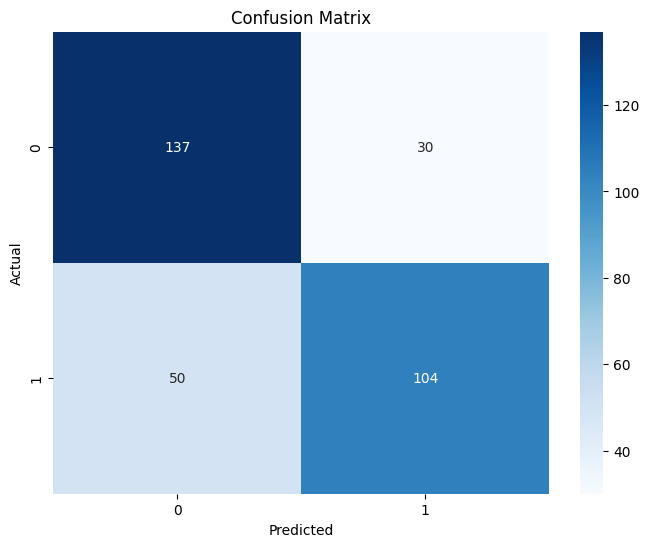

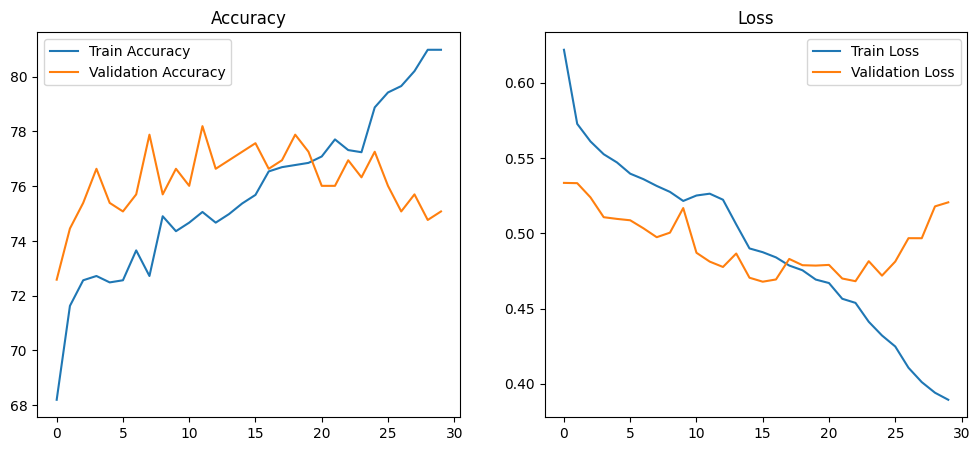

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, average_precision_score

# ============================
# ✅ Dataset Class untuk GRU
# ============================
class ViolenceDataset(Dataset):
    def __init__(self, csv_path, seq_len=16):
        df = pd.read_csv(csv_path)
        self.labels = df['label'].apply(lambda x: 1 if x.lower() == "fight" else 0).values  # Convert label ke 0/1
        self.seq_len = seq_len
        self.features = []

        for _, row in df.iterrows():
            # Parse list dari string ke list python
            jumlah_orang = ast.literal_eval(row['jumlah_orang_per_frame'])
            avg_speed = ast.literal_eval(row['avg_speed'])
            overlap = ast.literal_eval(row['overlap_count'])

            # Bentuk sequence: [[jumlah_orang, avg_speed, overlap], ...] dengan panjang seq_len   
            seq = []
            for i in range(len(jumlah_orang)):
                jml = float(jumlah_orang[i]) if i < len(jumlah_orang) else 0.0
                spd = float(avg_speed[i]) if i < len(avg_speed) else 0.0
                ovl = float(overlap[i]) if i < len(overlap) else 0.0
                seq.append([jml, spd, ovl])
            # Pastikan panjang sequence konsisten (pad atau truncate)
            if len(seq) < self.seq_len:
                seq += [[0.0, 0.0, 0.0]] * (self.seq_len - len(seq))
            else:
                seq = seq[:self.seq_len]

            self.features.append(seq)

        self.features = np.array(self.features, dtype=np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.features[idx]  # shape: (seq_len, 3)
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

class ViolenceConvGRUModel(nn.Module):
    def __init__(self, input_size=3, conv_channels=16, hidden_size=64, num_layers=2, num_classes=2):
        super(ViolenceConvGRUModel, self).__init__()
        
        # Conv1d untuk ekstraksi fitur awal
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
        # GRU untuk sequence modeling
        self.gru = nn.GRU(input_size=conv_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Fully connected untuk output
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # x: (batch, seq_len, input_size)
        
        # Transpose untuk Conv1d: (batch, input_size, seq_len)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)   # (batch, conv_channels, seq_len)
        x = self.relu(x)
        
        # Kembali ke format GRU: (batch, seq_len, conv_channels)
        x = x.permute(0, 2, 1)
        
        # GRU processing
        out, _ = self.gru(x)
        
        # Ambil output terakhir
        out = out[:, -1, :]
        
        # FC untuk klasifikasi
        out = self.fc(out)
        return out

csv_path = "hasil_deteksi_yolo_train.csv"
sequence_length = 16

dataset = ViolenceDataset(csv_path, seq_len=sequence_length)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Hyperparameters
input_size = 3
hidden_size = 64
num_layers = 2
num_classes = 2
num_epochs = 30
learning_rate = 0.001

# Model
model = ViolenceConvGRUModel(input_size=3, conv_channels=16, hidden_size=64, num_layers=2, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []
all_preds = []
all_labels = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        _, predicted_train = torch.max(outputs, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted_train == y_batch).sum().item()
        
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(100 * correct_train / total_train)

    # Validation
    model.eval()
    correct = 0
    total = 0
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()
            if epoch == num_epochs - 1:
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())
    
    val_losses.append(total_val_loss / len(val_loader))
    acc = 100 * correct / total
    val_accs.append(acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Val Acc: {acc:.2f}%")

torch.save(model.state_dict(), "violence_model.pth")
print("Model GRU disimpan ke violence_model.pth")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png')

# Accuracy and Loss Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.savefig('accuracy_loss.png')

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# mAP
ap = average_precision_score(all_labels, all_preds)
print(f"mAP: {ap:.4f}")

Epoch [1/30], Loss: 56.5574, Val Acc: 53.89%
Epoch [2/30], Loss: 56.3593, Val Acc: 54.21%
Epoch [3/30], Loss: 56.1697, Val Acc: 51.09%
Epoch [4/30], Loss: 56.0040, Val Acc: 47.98%
Epoch [5/30], Loss: 55.8463, Val Acc: 50.47%
Epoch [6/30], Loss: 55.7080, Val Acc: 51.40%
Epoch [7/30], Loss: 55.5599, Val Acc: 52.02%
Epoch [8/30], Loss: 55.4067, Val Acc: 51.71%
Epoch [9/30], Loss: 55.3187, Val Acc: 51.09%
Epoch [10/30], Loss: 55.1552, Val Acc: 52.02%
Epoch [11/30], Loss: 55.0243, Val Acc: 53.27%
Epoch [12/30], Loss: 54.9413, Val Acc: 55.45%
Epoch [13/30], Loss: 54.7754, Val Acc: 57.94%
Epoch [14/30], Loss: 54.6190, Val Acc: 57.94%
Epoch [15/30], Loss: 54.5006, Val Acc: 58.57%
Epoch [16/30], Loss: 54.2765, Val Acc: 60.44%
Epoch [17/30], Loss: 54.2175, Val Acc: 61.68%
Epoch [18/30], Loss: 54.0824, Val Acc: 62.62%
Epoch [19/30], Loss: 53.9259, Val Acc: 66.36%
Epoch [20/30], Loss: 53.7863, Val Acc: 67.29%
Epoch [21/30], Loss: 53.6086, Val Acc: 67.60%
Epoch [22/30], Loss: 53.4919, Val Acc: 67.2

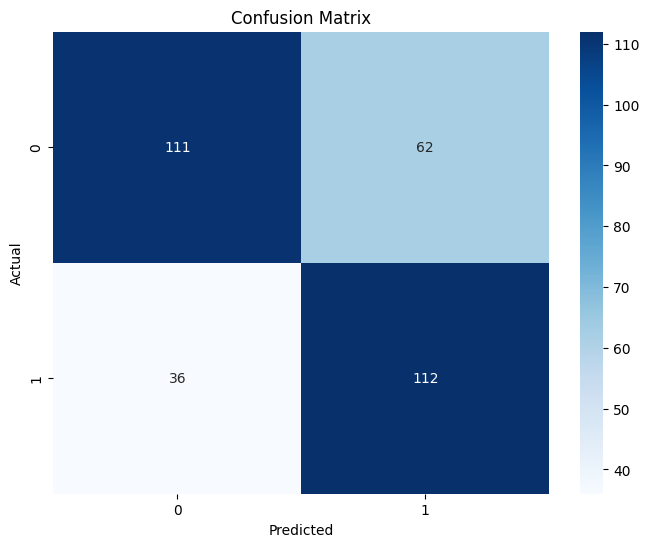

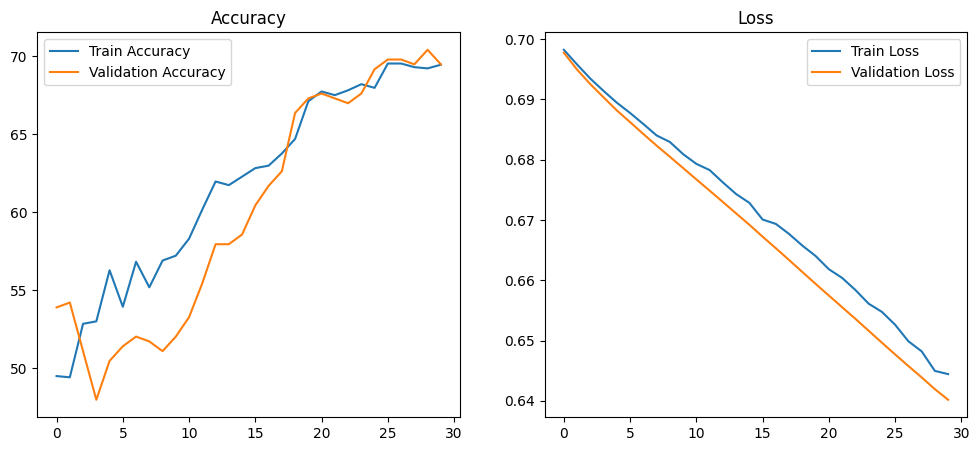

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, average_precision_score

# ============================
# ✅ Dataset Class untuk GRU
# ============================
class ViolenceDataset(Dataset):
    def __init__(self, csv_path, seq_len=16):
        df = pd.read_csv(csv_path)
        self.labels = df['label'].apply(lambda x: 1 if x.lower() == "fight" else 0).values  # Convert label ke 0/1
        self.seq_len = seq_len
        self.features = []

        for _, row in df.iterrows():
            # Parse list dari string ke list python
            jumlah_orang = ast.literal_eval(row['jumlah_orang_per_frame'])
            avg_speed = ast.literal_eval(row['avg_speed'])
            overlap = ast.literal_eval(row['overlap_count'])

            # Bentuk sequence: [[jumlah_orang, avg_speed, overlap], ...] dengan panjang seq_len   
            seq = []
            for i in range(len(jumlah_orang)):
                jml = float(jumlah_orang[i]) if i < len(jumlah_orang) else 0.0
                spd = float(avg_speed[i]) if i < len(avg_speed) else 0.0
                ovl = float(overlap[i]) if i < len(overlap) else 0.0
                seq.append([jml, spd, ovl])
            # Pastikan panjang sequence konsisten (pad atau truncate)
            if len(seq) < self.seq_len:
                seq += [[0.0, 0.0, 0.0]] * (self.seq_len - len(seq))
            else:
                seq = seq[:self.seq_len]

            self.features.append(seq)

        self.features = np.array(self.features, dtype=np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.features[idx]  # shape: (seq_len, 3)
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

class ViolenceConvGRUModel(nn.Module):
    def __init__(self, input_size=3, conv_channels=16, hidden_size=64, num_layers=2, num_classes=2):
        super(ViolenceConvGRUModel, self).__init__()
        
        # Conv1d untuk ekstraksi fitur awal
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
        # GRU untuk sequence modeling
        self.gru = nn.GRU(input_size=conv_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Fully connected untuk output
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # x: (batch, seq_len, input_size)
        
        # Transpose untuk Conv1d: (batch, input_size, seq_len)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)   # (batch, conv_channels, seq_len)
        x = self.relu(x)
        
        # Kembali ke format GRU: (batch, seq_len, conv_channels)
        x = x.permute(0, 2, 1)
        
        # GRU processing
        out, _ = self.gru(x)
        
        # Ambil output terakhir
        out = out[:, -1, :]
        
        # FC untuk klasifikasi
        out = self.fc(out)
        return out

csv_path = "hasil_deteksi_yolo_train.csv"
sequence_length = 16

dataset = ViolenceDataset(csv_path, seq_len=sequence_length)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Hyperparameters
input_size = 3
hidden_size = 64
num_layers = 2
num_classes = 2
num_epochs = 30
learning_rate = 0.001

# Model
model = ViolenceConvGRUModel(input_size=3, conv_channels=16, hidden_size=64, num_layers=2, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Lists to store metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []
all_preds = []
all_labels = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        _, predicted_train = torch.max(outputs, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted_train == y_batch).sum().item()
        
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(100 * correct_train / total_train)

    # Validation
    model.eval()
    correct = 0
    total = 0
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()
            if epoch == num_epochs - 1:
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())
    
    val_losses.append(total_val_loss / len(val_loader))
    acc = 100 * correct / total
    val_accs.append(acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Val Acc: {acc:.2f}%")

torch.save(model.state_dict(), "violence_model.pth")
print("Model GRU disimpan ke violence_model.pth")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png')

# Accuracy and Loss Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.savefig('accuracy_loss.png')

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# mAP
ap = average_precision_score(all_labels, all_preds)
print(f"mAP: {ap:.4f}")

Epoch [1/30], Loss: 50.2929, Val Acc: 71.03%
Epoch [2/30], Loss: 45.6787, Val Acc: 72.59%
Epoch [3/30], Loss: 45.3402, Val Acc: 73.52%
Epoch [4/30], Loss: 44.4478, Val Acc: 73.21%
Epoch [5/30], Loss: 44.4839, Val Acc: 73.21%
Epoch [6/30], Loss: 43.8514, Val Acc: 72.90%
Epoch [7/30], Loss: 44.2067, Val Acc: 74.14%
Epoch [8/30], Loss: 43.2060, Val Acc: 74.14%
Epoch [9/30], Loss: 42.2903, Val Acc: 76.32%
Epoch [10/30], Loss: 42.4115, Val Acc: 77.26%
Epoch [11/30], Loss: 42.4788, Val Acc: 76.32%
Epoch [12/30], Loss: 42.4024, Val Acc: 74.14%
Epoch [13/30], Loss: 40.5019, Val Acc: 75.70%
Epoch [14/30], Loss: 41.9836, Val Acc: 76.01%
Epoch [15/30], Loss: 40.2531, Val Acc: 73.52%
Epoch [16/30], Loss: 39.2482, Val Acc: 74.77%
Epoch [17/30], Loss: 39.8979, Val Acc: 74.14%
Epoch [18/30], Loss: 38.3131, Val Acc: 78.19%
Epoch [19/30], Loss: 38.7009, Val Acc: 77.26%
Epoch [20/30], Loss: 38.5695, Val Acc: 77.88%
Epoch [21/30], Loss: 37.8021, Val Acc: 76.95%
Epoch [22/30], Loss: 39.0974, Val Acc: 78.1

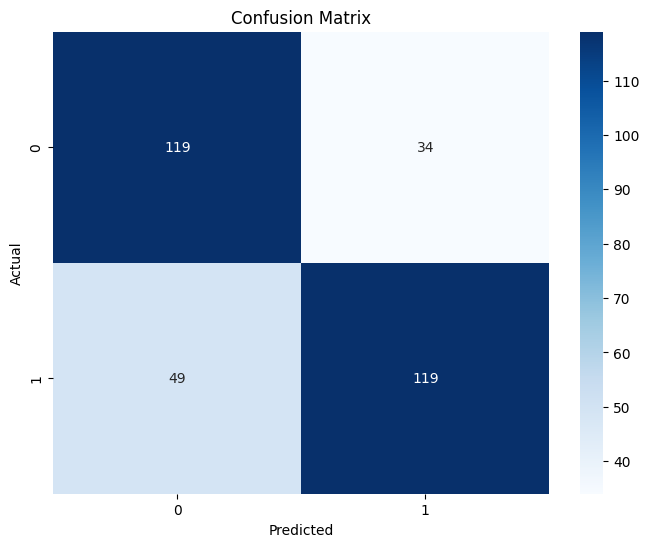

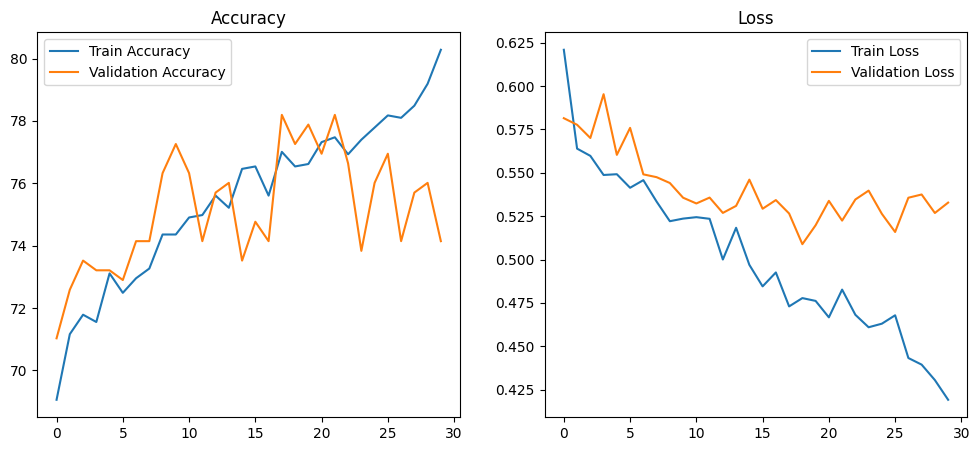

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, average_precision_score

# ============================
# ✅ Dataset Class untuk GRU
# ============================
class ViolenceDataset(Dataset):
    def __init__(self, csv_path, seq_len=16):
        df = pd.read_csv(csv_path)
        self.labels = df['label'].apply(lambda x: 1 if x.lower() == "fight" else 0).values  # Convert label ke 0/1
        self.seq_len = seq_len
        self.features = []

        for _, row in df.iterrows():
            # Parse list dari string ke list python
            jumlah_orang = ast.literal_eval(row['jumlah_orang_per_frame'])
            avg_speed = ast.literal_eval(row['avg_speed'])
            overlap = ast.literal_eval(row['overlap_count'])

            # Bentuk sequence: [[jumlah_orang, avg_speed, overlap], ...] dengan panjang seq_len   
            seq = []
            for i in range(len(jumlah_orang)):
                jml = float(jumlah_orang[i]) if i < len(jumlah_orang) else 0.0
                spd = float(avg_speed[i]) if i < len(avg_speed) else 0.0
                ovl = float(overlap[i]) if i < len(overlap) else 0.0
                seq.append([jml, spd, ovl])
            # Pastikan panjang sequence konsisten (pad atau truncate)
            if len(seq) < self.seq_len:
                seq += [[0.0, 0.0, 0.0]] * (self.seq_len - len(seq))
            else:
                seq = seq[:self.seq_len]

            self.features.append(seq)

        self.features = np.array(self.features, dtype=np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.features[idx]  # shape: (seq_len, 3)
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

class ViolenceConvGRUModel(nn.Module):
    def __init__(self, input_size=3, conv_channels=16, hidden_size=64, num_layers=2, num_classes=2):
        super(ViolenceConvGRUModel, self).__init__()
        
        # Conv1d untuk ekstraksi fitur awal
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
        # GRU untuk sequence modeling
        self.gru = nn.GRU(input_size=conv_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Fully connected untuk output
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # x: (batch, seq_len, input_size)
        
        # Transpose untuk Conv1d: (batch, input_size, seq_len)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)   # (batch, conv_channels, seq_len)
        x = self.relu(x)
        
        # Kembali ke format GRU: (batch, seq_len, conv_channels)
        x = x.permute(0, 2, 1)
        
        # GRU processing
        out, _ = self.gru(x)
        
        # Ambil output terakhir
        out = out[:, -1, :]
        
        # FC untuk klasifikasi
        out = self.fc(out)
        return out

csv_path = "hasil_deteksi_yolo_train.csv"
sequence_length = 16

dataset = ViolenceDataset(csv_path, seq_len=sequence_length)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Hyperparameters
input_size = 3
hidden_size = 64
num_layers = 2
num_classes = 2
num_epochs = 30
learning_rate = 0.001

# Model
model = ViolenceConvGRUModel(input_size=3, conv_channels=16, hidden_size=64, num_layers=2, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Lists to store metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []
all_preds = []
all_labels = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        _, predicted_train = torch.max(outputs, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted_train == y_batch).sum().item()
        
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(100 * correct_train / total_train)

    # Validation
    model.eval()
    correct = 0
    total = 0
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()
            if epoch == num_epochs - 1:
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())
    
    val_losses.append(total_val_loss / len(val_loader))
    acc = 100 * correct / total
    val_accs.append(acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Val Acc: {acc:.2f}%")

torch.save(model.state_dict(), "violence_model.pth")
print("Model GRU disimpan ke violence_model.pth")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png')

# Accuracy and Loss Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.savefig('accuracy_loss.png')

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# mAP
ap = average_precision_score(all_labels, all_preds)
print(f"mAP: {ap:.4f}")

Epoch [1/30], Loss: 52.3015, Val Acc: 66.67%
Epoch [2/30], Loss: 49.4188, Val Acc: 63.24%
Epoch [3/30], Loss: 48.4093, Val Acc: 65.11%
Epoch [4/30], Loss: 47.7004, Val Acc: 65.11%
Epoch [5/30], Loss: 47.3232, Val Acc: 65.11%
Epoch [6/30], Loss: 46.8797, Val Acc: 65.11%
Epoch [7/30], Loss: 46.4958, Val Acc: 67.60%
Epoch [8/30], Loss: 46.3374, Val Acc: 66.36%
Epoch [9/30], Loss: 46.3980, Val Acc: 66.36%
Epoch [10/30], Loss: 45.7475, Val Acc: 66.67%
Epoch [11/30], Loss: 45.7265, Val Acc: 66.98%
Epoch [12/30], Loss: 45.8238, Val Acc: 67.60%
Epoch [13/30], Loss: 45.3011, Val Acc: 68.22%
Epoch [14/30], Loss: 45.1122, Val Acc: 67.91%
Epoch [15/30], Loss: 45.2979, Val Acc: 67.60%
Epoch [16/30], Loss: 44.8581, Val Acc: 67.60%
Epoch [17/30], Loss: 45.3661, Val Acc: 67.60%
Epoch [18/30], Loss: 45.3227, Val Acc: 67.60%
Epoch [19/30], Loss: 44.6374, Val Acc: 67.91%
Epoch [20/30], Loss: 44.8931, Val Acc: 67.60%
Epoch [21/30], Loss: 44.9061, Val Acc: 68.22%
Epoch [22/30], Loss: 44.9126, Val Acc: 66.9

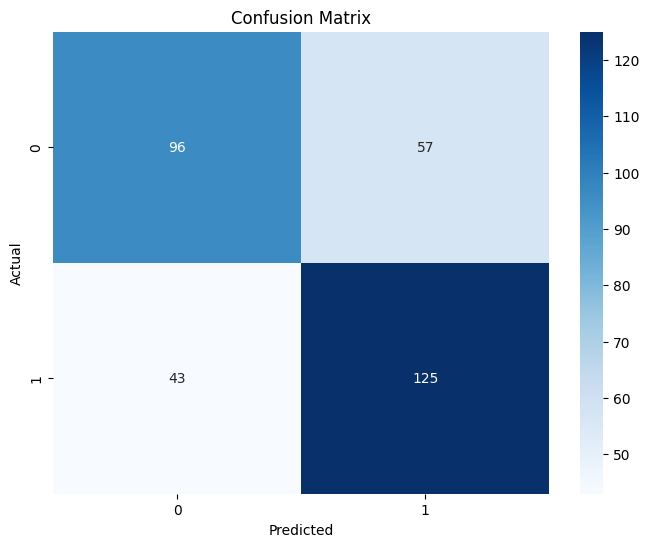

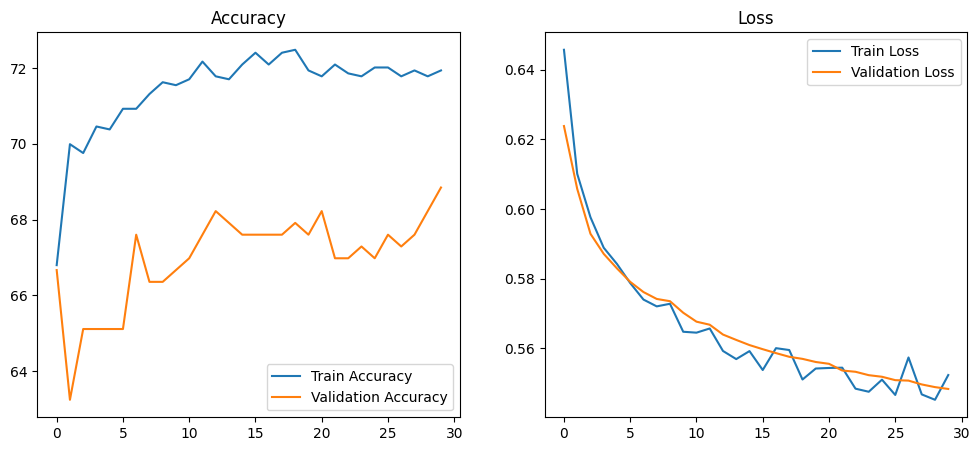

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, average_precision_score

# ============================
# ✅ Dataset Class untuk GRU
# ============================
class ViolenceDataset(Dataset):
    def __init__(self, csv_path, seq_len=16):
        df = pd.read_csv(csv_path)
        self.labels = df['label'].apply(lambda x: 1 if x.lower() == "fight" else 0).values  # Convert label ke 0/1
        self.seq_len = seq_len
        self.features = []

        for _, row in df.iterrows():
            # Parse list dari string ke list python
            jumlah_orang = ast.literal_eval(row['jumlah_orang_per_frame'])
            avg_speed = ast.literal_eval(row['avg_speed'])
            overlap = ast.literal_eval(row['overlap_count'])

            # Bentuk sequence: [[jumlah_orang, avg_speed, overlap], ...] dengan panjang seq_len   
            seq = []
            for i in range(len(jumlah_orang)):
                jml = float(jumlah_orang[i]) if i < len(jumlah_orang) else 0.0
                spd = float(avg_speed[i]) if i < len(avg_speed) else 0.0
                ovl = float(overlap[i]) if i < len(overlap) else 0.0
                seq.append([jml, spd, ovl])
            # Pastikan panjang sequence konsisten (pad atau truncate)
            if len(seq) < self.seq_len:
                seq += [[0.0, 0.0, 0.0]] * (self.seq_len - len(seq))
            else:
                seq = seq[:self.seq_len]

            self.features.append(seq)

        self.features = np.array(self.features, dtype=np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.features[idx]  # shape: (seq_len, 3)
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

class ViolenceConvGRUModel(nn.Module):
    def __init__(self, input_size=3, conv_channels=16, hidden_size=64, num_layers=2, num_classes=2):
        super(ViolenceConvGRUModel, self).__init__()
        
        # Conv1d untuk ekstraksi fitur awal
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
        # GRU untuk sequence modeling
        self.gru = nn.GRU(input_size=conv_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Fully connected untuk output
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # x: (batch, seq_len, input_size)
        
        # Transpose untuk Conv1d: (batch, input_size, seq_len)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)   # (batch, conv_channels, seq_len)
        x = self.relu(x)
        
        # Kembali ke format GRU: (batch, seq_len, conv_channels)
        x = x.permute(0, 2, 1)
        
        # GRU processing
        out, _ = self.gru(x)
        
        # Ambil output terakhir
        out = out[:, -1, :]
        
        # FC untuk klasifikasi
        out = self.fc(out)
        return out

csv_path = "hasil_deteksi_yolo_train.csv"
sequence_length = 16

dataset = ViolenceDataset(csv_path, seq_len=sequence_length)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Hyperparameters
input_size = 3
hidden_size = 64
num_layers = 2
num_classes = 2
num_epochs = 30
learning_rate = 0.001

# Model
model = ViolenceConvGRUModel(input_size=3, conv_channels=16, hidden_size=64, num_layers=2, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)

# Lists to store metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []
all_preds = []
all_labels = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        _, predicted_train = torch.max(outputs, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted_train == y_batch).sum().item()
        
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(100 * correct_train / total_train)

    # Validation
    model.eval()
    correct = 0
    total = 0
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()
            if epoch == num_epochs - 1:
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())
    
    val_losses.append(total_val_loss / len(val_loader))
    acc = 100 * correct / total
    val_accs.append(acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Val Acc: {acc:.2f}%")

torch.save(model.state_dict(), "violence_model.pth")
print("Model GRU disimpan ke violence_model.pth")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png')

# Accuracy and Loss Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.savefig('accuracy_loss.png')

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# mAP
ap = average_precision_score(all_labels, all_preds)
print(f"mAP: {ap:.4f}")